In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("SL", "CB", "CT") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("SL", "CB", "CT")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['line_drive'], axis=1).copy()
train_label = training_features['line_drive'].copy()
testing_data = testing_features.drop(['line_drive'], axis=1).copy()
testing_label = testing_features['line_drive'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5040437678401523
Log Loss: 0.6816703453145277


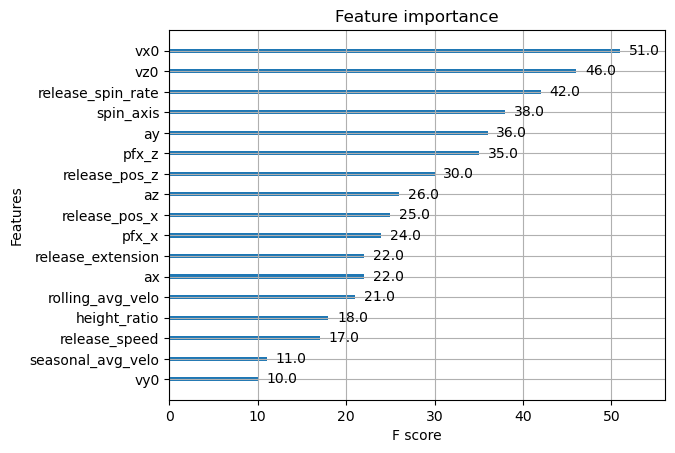

In [13]:
xgb.plot_importance(model)
plt.show()

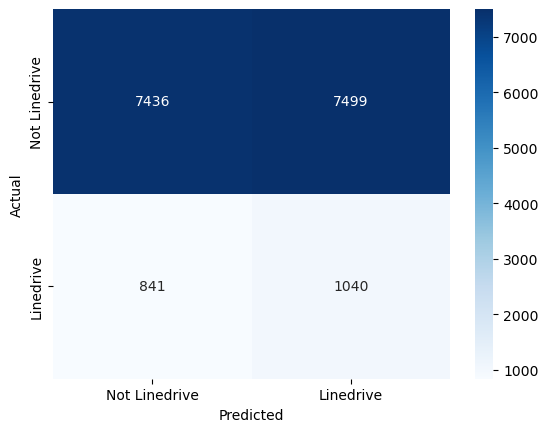

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [ ]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [ ]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-13 13:07:12,501] A new study created in memory with name: no-name-f533b11d-8a45-4927-8054-ec1979199a66


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68976
[3]	eval-logloss:0.68869
[4]	eval-logloss:0.68862
[5]	eval-logloss:0.68752
[6]	eval-logloss:0.68693
[7]	eval-logloss:0.68635
[8]	eval-logloss:0.68483
[9]	eval-logloss:0.68432
[10]	eval-logloss:0.68346
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68194
[13]	eval-logloss:0.68143
[14]	eval-logloss:0.68075
[15]	eval-logloss:0.67982
[16]	eval-logloss:0.67913
[17]	eval-logloss:0.67920
[18]	eval-logloss:0.67908
[19]	eval-logloss:0.67912
[20]	eval-logloss:0.67896
[21]	eval-logloss:0.67805
[22]	eval-logloss:0.67844
[23]	eval-logloss:0.67726
[24]	eval-logloss:0.67645
[25]	eval-logloss:0.67618
[26]	eval-logloss:0.67545
[27]	eval-logloss:0.67482
[28]	eval-logloss:0.67485
[29]	eval-logloss:0.67399
[30]	eval-logloss:0.67255
[31]	eval-logloss:0.67250
[32]	eval-logloss:0.67259
[33]	eval-logloss:0.67113
[34]	eval-logloss:0.66996
[35]	eval-logloss:0.66997
[36]	eval-logloss:0.66951
[37]	eval-logloss:0.66925
[38]	eval-logloss:0.66

[I 2023-11-13 13:07:13,439] Trial 0 finished with value: 0.6462018902016133 and parameters: {'max_depth': 5, 'eta': 0.108396917876366, 'subsample': 0.7865367972732333, 'colsample_bytree': 0.5748502097728363}. Best is trial 0 with value: 0.6462018902016133.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67646
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.66683
[5]	eval-logloss:0.65784
[6]	eval-logloss:0.65283
[7]	eval-logloss:0.65210
[8]	eval-logloss:0.64929
[9]	eval-logloss:0.64714
[10]	eval-logloss:0.64500
[11]	eval-logloss:0.64039
[12]	eval-logloss:0.63610
[13]	eval-logloss:0.63369
[14]	eval-logloss:0.63305
[15]	eval-logloss:0.63142
[16]	eval-logloss:0.63185
[17]	eval-logloss:0.63168
[18]	eval-logloss:0.62665
[19]	eval-logloss:0.62592
[20]	eval-logloss:0.62293
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.62308
[23]	eval-logloss:0.61975
[24]	eval-logloss:0.61667
[25]	eval-logloss:0.61330
[26]	eval-logloss:0.61272
[27]	eval-logloss:0.60979
[28]	eval-logloss:0.61164
[29]	eval-logloss:0.61092
[30]	eval-logloss:0.60936
[31]	eval-logloss:0.60661
[32]	eval-logloss:0.60521
[33]	eval-logloss:0.60150
[34]	eval-logloss:0.59962
[35]	eval-logloss:0.59803
[36]	eval-logloss:0.59437
[37]	eval-logloss:0.59499
[38]	eval-logloss:0.59

[I 2023-11-13 13:07:15,012] Trial 1 finished with value: 0.5273434696251033 and parameters: {'max_depth': 8, 'eta': 0.24926594879134364, 'subsample': 0.6136561144257607, 'colsample_bytree': 0.8609345160052025}. Best is trial 1 with value: 0.5273434696251033.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69253
[2]	eval-logloss:0.69225
[3]	eval-logloss:0.69201
[4]	eval-logloss:0.69193
[5]	eval-logloss:0.69151
[6]	eval-logloss:0.69170
[7]	eval-logloss:0.69170
[8]	eval-logloss:0.69107
[9]	eval-logloss:0.69066
[10]	eval-logloss:0.69033
[11]	eval-logloss:0.69009
[12]	eval-logloss:0.68985
[13]	eval-logloss:0.68937
[14]	eval-logloss:0.68897
[15]	eval-logloss:0.68849
[16]	eval-logloss:0.68827
[17]	eval-logloss:0.68835
[18]	eval-logloss:0.68809
[19]	eval-logloss:0.68804
[20]	eval-logloss:0.68801
[21]	eval-logloss:0.68774
[22]	eval-logloss:0.68761
[23]	eval-logloss:0.68722
[24]	eval-logloss:0.68698
[25]	eval-logloss:0.68679
[26]	eval-logloss:0.68686
[27]	eval-logloss:0.68663
[28]	eval-logloss:0.68659
[29]	eval-logloss:0.68661
[30]	eval-logloss:0.68608
[31]	eval-logloss:0.68599
[32]	eval-logloss:0.68601
[33]	eval-logloss:0.68555
[34]	eval-logloss:0.68530
[35]	eval-logloss:0.68565
[36]	eval-logloss:0.68541
[37]	eval-logloss:0.68537
[38]	eval-logloss:0.68

[I 2023-11-13 13:07:16,096] Trial 2 finished with value: 0.6793639581827304 and parameters: {'max_depth': 3, 'eta': 0.06749019860096568, 'subsample': 0.8666340128586223, 'colsample_bytree': 0.8964625377852979}. Best is trial 1 with value: 0.5273434696251033.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.66464
[4]	eval-logloss:0.66137
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64982
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.63927
[9]	eval-logloss:0.63671
[10]	eval-logloss:0.63228
[11]	eval-logloss:0.63025
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62376
[14]	eval-logloss:0.62071
[15]	eval-logloss:0.61743
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.61046
[18]	eval-logloss:0.60740
[19]	eval-logloss:0.60644
[20]	eval-logloss:0.60547
[21]	eval-logloss:0.60392
[22]	eval-logloss:0.60142
[23]	eval-logloss:0.59944
[24]	eval-logloss:0.59743
[25]	eval-logloss:0.59451
[26]	eval-logloss:0.59342
[27]	eval-logloss:0.58995
[28]	eval-logloss:0.58824
[29]	eval-logloss:0.58621
[30]	eval-logloss:0.58299
[31]	eval-logloss:0.58178
[32]	eval-logloss:0.58002
[33]	eval-logloss:0.57622
[34]	eval-logloss:0.57267
[35]	eval-logloss:0.57204
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.56850
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:17,884] Trial 3 finished with value: 0.4777523944584854 and parameters: {'max_depth': 9, 'eta': 0.223654911306404, 'subsample': 0.8217242585534512, 'colsample_bytree': 0.7691057554706635}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.69110
[2]	eval-logloss:0.69053
[3]	eval-logloss:0.68950
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68913
[6]	eval-logloss:0.68824
[7]	eval-logloss:0.68804
[8]	eval-logloss:0.68650
[9]	eval-logloss:0.68606
[10]	eval-logloss:0.68431
[11]	eval-logloss:0.68393
[12]	eval-logloss:0.68283
[13]	eval-logloss:0.68249
[14]	eval-logloss:0.68185
[15]	eval-logloss:0.68128
[16]	eval-logloss:0.68105
[17]	eval-logloss:0.68160
[18]	eval-logloss:0.68087
[19]	eval-logloss:0.68105
[20]	eval-logloss:0.68094
[21]	eval-logloss:0.67958
[22]	eval-logloss:0.68041
[23]	eval-logloss:0.67854
[24]	eval-logloss:0.67819
[25]	eval-logloss:0.67784
[26]	eval-logloss:0.67761
[27]	eval-logloss:0.67723
[28]	eval-logloss:0.67738
[29]	eval-logloss:0.67677
[30]	eval-logloss:0.67507
[31]	eval-logloss:0.67504
[32]	eval-logloss:0.67602
[33]	eval-logloss:0.67477
[34]	eval-logloss:0.67393
[35]	eval-logloss:0.67423
[36]	eval-logloss:0.67391
[37]	eval-logloss:0.67354
[38]	eval-logloss:0.67

[I 2023-11-13 13:07:18,723] Trial 4 finished with value: 0.6546430057804581 and parameters: {'max_depth': 4, 'eta': 0.18166897476943875, 'subsample': 0.7703154699107615, 'colsample_bytree': 0.9092712409229957}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67475
[3]	eval-logloss:0.66923
[4]	eval-logloss:0.66476
[5]	eval-logloss:0.65702
[6]	eval-logloss:0.65341
[7]	eval-logloss:0.65193
[8]	eval-logloss:0.64811
[9]	eval-logloss:0.64476
[10]	eval-logloss:0.64341
[11]	eval-logloss:0.64186
[12]	eval-logloss:0.63956
[13]	eval-logloss:0.63479
[14]	eval-logloss:0.63332
[15]	eval-logloss:0.63161
[16]	eval-logloss:0.62928
[17]	eval-logloss:0.62631
[18]	eval-logloss:0.62409
[19]	eval-logloss:0.62206
[20]	eval-logloss:0.61994
[21]	eval-logloss:0.61749
[22]	eval-logloss:0.61684
[23]	eval-logloss:0.61449
[24]	eval-logloss:0.61316
[25]	eval-logloss:0.61052
[26]	eval-logloss:0.60953
[27]	eval-logloss:0.60660
[28]	eval-logloss:0.60540
[29]	eval-logloss:0.60173
[30]	eval-logloss:0.59835
[31]	eval-logloss:0.59571
[32]	eval-logloss:0.59453
[33]	eval-logloss:0.59229
[34]	eval-logloss:0.59072
[35]	eval-logloss:0.58964
[36]	eval-logloss:0.58745
[37]	eval-logloss:0.58675
[38]	eval-logloss:0.58

[I 2023-11-13 13:07:20,521] Trial 5 finished with value: 0.5012443387751105 and parameters: {'max_depth': 9, 'eta': 0.1394047891372762, 'subsample': 0.716751299957227, 'colsample_bytree': 0.9719153455749839}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68692
[4]	eval-logloss:0.68615
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68332
[7]	eval-logloss:0.68234
[8]	eval-logloss:0.68068
[9]	eval-logloss:0.67911
[10]	eval-logloss:0.67803
[11]	eval-logloss:0.67717
[12]	eval-logloss:0.67602
[13]	eval-logloss:0.67556
[14]	eval-logloss:0.67467
[15]	eval-logloss:0.67384
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67304
[18]	eval-logloss:0.67213
[19]	eval-logloss:0.67175
[20]	eval-logloss:0.67109
[21]	eval-logloss:0.67012
[22]	eval-logloss:0.66999
[23]	eval-logloss:0.66917
[24]	eval-logloss:0.66867
[25]	eval-logloss:0.66828
[26]	eval-logloss:0.66736
[27]	eval-logloss:0.66602
[28]	eval-logloss:0.66578
[29]	eval-logloss:0.66526
[30]	eval-logloss:0.66450
[31]	eval-logloss:0.66412
[32]	eval-logloss:0.66422
[33]	eval-logloss:0.66297
[34]	eval-logloss:0.66236
[35]	eval-logloss:0.66244
[36]	eval-logloss:0.66161
[37]	eval-logloss:0.66148
[38]	eval-logloss:0.66

[I 2023-11-13 13:07:21,672] Trial 6 finished with value: 0.6286743654413186 and parameters: {'max_depth': 6, 'eta': 0.08887103627944354, 'subsample': 0.7414899756489375, 'colsample_bytree': 0.9428345917797814}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69184
[1]	eval-logloss:0.69168
[2]	eval-logloss:0.69142
[3]	eval-logloss:0.68992
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68909
[6]	eval-logloss:0.68859
[7]	eval-logloss:0.68950
[8]	eval-logloss:0.68718
[9]	eval-logloss:0.68684
[10]	eval-logloss:0.68546
[11]	eval-logloss:0.68528
[12]	eval-logloss:0.68466
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68347
[15]	eval-logloss:0.68359
[16]	eval-logloss:0.68353
[17]	eval-logloss:0.68524
[18]	eval-logloss:0.68383
[19]	eval-logloss:0.68433
[20]	eval-logloss:0.68422
[21]	eval-logloss:0.68188
[22]	eval-logloss:0.68291
[23]	eval-logloss:0.68080
[24]	eval-logloss:0.68055
[25]	eval-logloss:0.68115
[26]	eval-logloss:0.68105
[27]	eval-logloss:0.67958
[28]	eval-logloss:0.68046
[29]	eval-logloss:0.68056
[30]	eval-logloss:0.67906
[31]	eval-logloss:0.67950
[32]	eval-logloss:0.68111
[33]	eval-logloss:0.67890
[34]	eval-logloss:0.67811
[35]	eval-logloss:0.67913
[36]	eval-logloss:0.67861
[37]	eval-logloss:0.67857
[38]	eval-logloss:0.67

[I 2023-11-13 13:07:22,469] Trial 7 finished with value: 0.6673806005646655 and parameters: {'max_depth': 3, 'eta': 0.2561565841037543, 'subsample': 0.7402281660812198, 'colsample_bytree': 0.9163704961672969}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69069
[1]	eval-logloss:0.69014
[2]	eval-logloss:0.68853
[3]	eval-logloss:0.68677
[4]	eval-logloss:0.68763
[5]	eval-logloss:0.68550
[6]	eval-logloss:0.68427
[7]	eval-logloss:0.68353
[8]	eval-logloss:0.68126
[9]	eval-logloss:0.68085
[10]	eval-logloss:0.67897
[11]	eval-logloss:0.67841
[12]	eval-logloss:0.67664
[13]	eval-logloss:0.67656
[14]	eval-logloss:0.67548
[15]	eval-logloss:0.67468
[16]	eval-logloss:0.67422
[17]	eval-logloss:0.67479
[18]	eval-logloss:0.67427
[19]	eval-logloss:0.67438
[20]	eval-logloss:0.67460
[21]	eval-logloss:0.67343
[22]	eval-logloss:0.67355
[23]	eval-logloss:0.67171
[24]	eval-logloss:0.67104
[25]	eval-logloss:0.67104
[26]	eval-logloss:0.67018
[27]	eval-logloss:0.66958
[28]	eval-logloss:0.66917
[29]	eval-logloss:0.66860
[30]	eval-logloss:0.66636
[31]	eval-logloss:0.66594
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66504
[34]	eval-logloss:0.66380
[35]	eval-logloss:0.66433
[36]	eval-logloss:0.66385
[37]	eval-logloss:0.66325
[38]	eval-logloss:0.66

[I 2023-11-13 13:07:23,616] Trial 8 finished with value: 0.6299495171600772 and parameters: {'max_depth': 5, 'eta': 0.19910478843640278, 'subsample': 0.7741980111772413, 'colsample_bytree': 0.5123483084316094}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68983
[2]	eval-logloss:0.68909
[3]	eval-logloss:0.68701
[4]	eval-logloss:0.68632
[5]	eval-logloss:0.68449
[6]	eval-logloss:0.68328
[7]	eval-logloss:0.68263
[8]	eval-logloss:0.68077
[9]	eval-logloss:0.67968
[10]	eval-logloss:0.67899
[11]	eval-logloss:0.67819
[12]	eval-logloss:0.67662
[13]	eval-logloss:0.67559
[14]	eval-logloss:0.67490
[15]	eval-logloss:0.67427
[16]	eval-logloss:0.67336
[17]	eval-logloss:0.67350
[18]	eval-logloss:0.67263
[19]	eval-logloss:0.67266
[20]	eval-logloss:0.67244
[21]	eval-logloss:0.67153
[22]	eval-logloss:0.67179
[23]	eval-logloss:0.67062
[24]	eval-logloss:0.67008
[25]	eval-logloss:0.66972
[26]	eval-logloss:0.66855
[27]	eval-logloss:0.66765
[28]	eval-logloss:0.66723
[29]	eval-logloss:0.66616
[30]	eval-logloss:0.66519
[31]	eval-logloss:0.66469
[32]	eval-logloss:0.66530
[33]	eval-logloss:0.66392
[34]	eval-logloss:0.66312
[35]	eval-logloss:0.66294
[36]	eval-logloss:0.66213
[37]	eval-logloss:0.66205
[38]	eval-logloss:0.66

[I 2023-11-13 13:07:24,689] Trial 9 finished with value: 0.6331560694190228 and parameters: {'max_depth': 6, 'eta': 0.09053997120747652, 'subsample': 0.7324242152375356, 'colsample_bytree': 0.6228294811043367}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67057
[4]	eval-logloss:0.66568
[5]	eval-logloss:0.66227
[6]	eval-logloss:0.65928
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65067
[9]	eval-logloss:0.64515
[10]	eval-logloss:0.64153
[11]	eval-logloss:0.63687
[12]	eval-logloss:0.63406
[13]	eval-logloss:0.62772
[14]	eval-logloss:0.62586
[15]	eval-logloss:0.62220
[16]	eval-logloss:0.62095
[17]	eval-logloss:0.62041
[18]	eval-logloss:0.61517
[19]	eval-logloss:0.61083
[20]	eval-logloss:0.60924
[21]	eval-logloss:0.60768
[22]	eval-logloss:0.60506
[23]	eval-logloss:0.60272
[24]	eval-logloss:0.60133
[25]	eval-logloss:0.59888
[26]	eval-logloss:0.59809
[27]	eval-logloss:0.59647
[28]	eval-logloss:0.59436
[29]	eval-logloss:0.59229
[30]	eval-logloss:0.58828
[31]	eval-logloss:0.58524
[32]	eval-logloss:0.58336
[33]	eval-logloss:0.57959
[34]	eval-logloss:0.57674
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57111
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:26,317] Trial 10 finished with value: 0.49751074539331863 and parameters: {'max_depth': 8, 'eta': 0.2931009435300401, 'subsample': 0.8705536533615775, 'colsample_bytree': 0.7439555829880167}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67416
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66472
[5]	eval-logloss:0.66180
[6]	eval-logloss:0.65842
[7]	eval-logloss:0.65590
[8]	eval-logloss:0.65107
[9]	eval-logloss:0.64745
[10]	eval-logloss:0.64490
[11]	eval-logloss:0.64289
[12]	eval-logloss:0.63897
[13]	eval-logloss:0.63651
[14]	eval-logloss:0.63473
[15]	eval-logloss:0.63123
[16]	eval-logloss:0.62825
[17]	eval-logloss:0.62720
[18]	eval-logloss:0.62311
[19]	eval-logloss:0.62158
[20]	eval-logloss:0.61923
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61609
[23]	eval-logloss:0.61312
[24]	eval-logloss:0.61072
[25]	eval-logloss:0.60687
[26]	eval-logloss:0.60658
[27]	eval-logloss:0.60498
[28]	eval-logloss:0.60234
[29]	eval-logloss:0.60065
[30]	eval-logloss:0.59803
[31]	eval-logloss:0.59386
[32]	eval-logloss:0.59323
[33]	eval-logloss:0.59054
[34]	eval-logloss:0.58840
[35]	eval-logloss:0.58830
[36]	eval-logloss:0.58616
[37]	eval-logloss:0.58393
[38]	eval-logloss:0.58

[I 2023-11-13 13:07:27,835] Trial 11 finished with value: 0.49783996764592925 and parameters: {'max_depth': 8, 'eta': 0.29470448364574786, 'subsample': 0.8930189483248594, 'colsample_bytree': 0.7697648407587295}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69160
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69056
[4]	eval-logloss:0.68984
[5]	eval-logloss:0.68927
[6]	eval-logloss:0.68869
[7]	eval-logloss:0.68800
[8]	eval-logloss:0.68724
[9]	eval-logloss:0.68641
[10]	eval-logloss:0.68586
[11]	eval-logloss:0.68514
[12]	eval-logloss:0.68451
[13]	eval-logloss:0.68389
[14]	eval-logloss:0.68329
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68194
[17]	eval-logloss:0.68152
[18]	eval-logloss:0.68096
[19]	eval-logloss:0.68047
[20]	eval-logloss:0.67992
[21]	eval-logloss:0.67926
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67828
[24]	eval-logloss:0.67762
[25]	eval-logloss:0.67710
[26]	eval-logloss:0.67651
[27]	eval-logloss:0.67599
[28]	eval-logloss:0.67544
[29]	eval-logloss:0.67508
[30]	eval-logloss:0.67424
[31]	eval-logloss:0.67367
[32]	eval-logloss:0.67306
[33]	eval-logloss:0.67249
[34]	eval-logloss:0.67194
[35]	eval-logloss:0.67135
[36]	eval-logloss:0.67071
[37]	eval-logloss:0.67023
[38]	eval-logloss:0.66

[I 2023-11-13 13:07:29,654] Trial 12 finished with value: 0.6453069700434815 and parameters: {'max_depth': 9, 'eta': 0.013573324358144956, 'subsample': 0.8454581023266045, 'colsample_bytree': 0.7562293587899612}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68214
[1]	eval-logloss:0.67733
[2]	eval-logloss:0.67319
[3]	eval-logloss:0.66747
[4]	eval-logloss:0.66239
[5]	eval-logloss:0.65641
[6]	eval-logloss:0.65449
[7]	eval-logloss:0.65332
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64312
[10]	eval-logloss:0.63960
[11]	eval-logloss:0.63870
[12]	eval-logloss:0.63554
[13]	eval-logloss:0.63330
[14]	eval-logloss:0.63071
[15]	eval-logloss:0.62645
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62351
[18]	eval-logloss:0.62304
[19]	eval-logloss:0.61884
[20]	eval-logloss:0.61592
[21]	eval-logloss:0.61335
[22]	eval-logloss:0.61262
[23]	eval-logloss:0.60922
[24]	eval-logloss:0.60638
[25]	eval-logloss:0.60314
[26]	eval-logloss:0.59997
[27]	eval-logloss:0.59749
[28]	eval-logloss:0.59547
[29]	eval-logloss:0.59408
[30]	eval-logloss:0.59113
[31]	eval-logloss:0.58983
[32]	eval-logloss:0.58815
[33]	eval-logloss:0.58373
[34]	eval-logloss:0.58165
[35]	eval-logloss:0.58083
[36]	eval-logloss:0.57750
[37]	eval-logloss:0.57507
[38]	eval-logloss:0.57

[I 2023-11-13 13:07:31,068] Trial 13 finished with value: 0.4990604979040638 and parameters: {'max_depth': 8, 'eta': 0.29837519800619366, 'subsample': 0.834681904958912, 'colsample_bytree': 0.6851938878968179}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67826
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67319
[6]	eval-logloss:0.67304
[7]	eval-logloss:0.67127
[8]	eval-logloss:0.66677
[9]	eval-logloss:0.66423
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65670
[14]	eval-logloss:0.65413
[15]	eval-logloss:0.65140
[16]	eval-logloss:0.64921
[17]	eval-logloss:0.64725
[18]	eval-logloss:0.64509
[19]	eval-logloss:0.64437
[20]	eval-logloss:0.64283
[21]	eval-logloss:0.64019
[22]	eval-logloss:0.63722
[23]	eval-logloss:0.63473
[24]	eval-logloss:0.63222
[25]	eval-logloss:0.63002
[26]	eval-logloss:0.62953
[27]	eval-logloss:0.62759
[28]	eval-logloss:0.62645
[29]	eval-logloss:0.62572
[30]	eval-logloss:0.62357
[31]	eval-logloss:0.62178
[32]	eval-logloss:0.62098
[33]	eval-logloss:0.61909
[34]	eval-logloss:0.61725
[35]	eval-logloss:0.61632
[36]	eval-logloss:0.61410
[37]	eval-logloss:0.61372
[38]	eval-logloss:0.61

[I 2023-11-13 13:07:32,533] Trial 14 finished with value: 0.5484340361607536 and parameters: {'max_depth': 7, 'eta': 0.22835135193767497, 'subsample': 0.8979151973750055, 'colsample_bytree': 0.8172096229371797}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67648
[2]	eval-logloss:0.67182
[3]	eval-logloss:0.66543
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65101
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64017
[8]	eval-logloss:0.63565
[9]	eval-logloss:0.63112
[10]	eval-logloss:0.62467
[11]	eval-logloss:0.62409
[12]	eval-logloss:0.62279
[13]	eval-logloss:0.62120
[14]	eval-logloss:0.61795
[15]	eval-logloss:0.61442
[16]	eval-logloss:0.61168
[17]	eval-logloss:0.60732
[18]	eval-logloss:0.60355
[19]	eval-logloss:0.60170
[20]	eval-logloss:0.60054
[21]	eval-logloss:0.59636
[22]	eval-logloss:0.59598
[23]	eval-logloss:0.59322
[24]	eval-logloss:0.59008
[25]	eval-logloss:0.58715
[26]	eval-logloss:0.58592
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57923
[30]	eval-logloss:0.57344
[31]	eval-logloss:0.57207
[32]	eval-logloss:0.57037
[33]	eval-logloss:0.56754
[34]	eval-logloss:0.56614
[35]	eval-logloss:0.56562
[36]	eval-logloss:0.56445
[37]	eval-logloss:0.56386
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:34,696] Trial 15 finished with value: 0.48285242855544025 and parameters: {'max_depth': 9, 'eta': 0.21628597145697365, 'subsample': 0.8070677961127475, 'colsample_bytree': 0.7037571022682878}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68401
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.66584
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.64917
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.63883
[9]	eval-logloss:0.63604
[10]	eval-logloss:0.63188
[11]	eval-logloss:0.63027
[12]	eval-logloss:0.62657
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61805
[16]	eval-logloss:0.61611
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.61115
[19]	eval-logloss:0.61133
[20]	eval-logloss:0.61022
[21]	eval-logloss:0.60690
[22]	eval-logloss:0.60671
[23]	eval-logloss:0.60389
[24]	eval-logloss:0.60189
[25]	eval-logloss:0.60046
[26]	eval-logloss:0.60001
[27]	eval-logloss:0.59680
[28]	eval-logloss:0.59649
[29]	eval-logloss:0.59451
[30]	eval-logloss:0.59002
[31]	eval-logloss:0.58710
[32]	eval-logloss:0.58558
[33]	eval-logloss:0.58363
[34]	eval-logloss:0.58012
[35]	eval-logloss:0.57835
[36]	eval-logloss:0.57391
[37]	eval-logloss:0.57240
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:36,763] Trial 16 finished with value: 0.48659729092399556 and parameters: {'max_depth': 9, 'eta': 0.19303631072016872, 'subsample': 0.8156118471009841, 'colsample_bytree': 0.6846031803493702}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68284
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67803
[5]	eval-logloss:0.67455
[6]	eval-logloss:0.67331
[7]	eval-logloss:0.67191
[8]	eval-logloss:0.66857
[9]	eval-logloss:0.66715
[10]	eval-logloss:0.66573
[11]	eval-logloss:0.66471
[12]	eval-logloss:0.66263
[13]	eval-logloss:0.66056
[14]	eval-logloss:0.65875
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65558
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65374
[19]	eval-logloss:0.65361
[20]	eval-logloss:0.65324
[21]	eval-logloss:0.64970
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64696
[24]	eval-logloss:0.64577
[25]	eval-logloss:0.64424
[26]	eval-logloss:0.64400
[27]	eval-logloss:0.64309
[28]	eval-logloss:0.64283
[29]	eval-logloss:0.64157
[30]	eval-logloss:0.63944
[31]	eval-logloss:0.63706
[32]	eval-logloss:0.63664
[33]	eval-logloss:0.63510
[34]	eval-logloss:0.63284
[35]	eval-logloss:0.63184
[36]	eval-logloss:0.63065
[37]	eval-logloss:0.62993
[38]	eval-logloss:0.62

[I 2023-11-13 13:07:38,026] Trial 17 finished with value: 0.5700923911762622 and parameters: {'max_depth': 7, 'eta': 0.15690604856453966, 'subsample': 0.8077905781727964, 'colsample_bytree': 0.8288821159528876}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68707
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68127
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67575
[5]	eval-logloss:0.67085
[6]	eval-logloss:0.66914
[7]	eval-logloss:0.66704
[8]	eval-logloss:0.66412
[9]	eval-logloss:0.66159
[10]	eval-logloss:0.65849
[11]	eval-logloss:0.65652
[12]	eval-logloss:0.65511
[13]	eval-logloss:0.65414
[14]	eval-logloss:0.65183
[15]	eval-logloss:0.65000
[16]	eval-logloss:0.64807
[17]	eval-logloss:0.64765
[18]	eval-logloss:0.64636
[19]	eval-logloss:0.64494
[20]	eval-logloss:0.64354
[21]	eval-logloss:0.64245
[22]	eval-logloss:0.64222
[23]	eval-logloss:0.63836
[24]	eval-logloss:0.63735
[25]	eval-logloss:0.63561
[26]	eval-logloss:0.63463
[27]	eval-logloss:0.63414
[28]	eval-logloss:0.63284
[29]	eval-logloss:0.63047
[30]	eval-logloss:0.62644
[31]	eval-logloss:0.62553
[32]	eval-logloss:0.62529
[33]	eval-logloss:0.62276
[34]	eval-logloss:0.62120
[35]	eval-logloss:0.62064
[36]	eval-logloss:0.61846
[37]	eval-logloss:0.61745
[38]	eval-logloss:0.61

[I 2023-11-13 13:07:39,066] Trial 18 finished with value: 0.5503680213514888 and parameters: {'max_depth': 7, 'eta': 0.22359287170011766, 'subsample': 0.8094368452312017, 'colsample_bytree': 0.6993628362967887}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67460
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66532
[5]	eval-logloss:0.66188
[6]	eval-logloss:0.65788
[7]	eval-logloss:0.65484
[8]	eval-logloss:0.64955
[9]	eval-logloss:0.64579
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63416
[14]	eval-logloss:0.63328
[15]	eval-logloss:0.62956
[16]	eval-logloss:0.62676
[17]	eval-logloss:0.62364
[18]	eval-logloss:0.62172
[19]	eval-logloss:0.62071
[20]	eval-logloss:0.61721
[21]	eval-logloss:0.61229
[22]	eval-logloss:0.61160
[23]	eval-logloss:0.60852
[24]	eval-logloss:0.60651
[25]	eval-logloss:0.60298
[26]	eval-logloss:0.60296
[27]	eval-logloss:0.60042
[28]	eval-logloss:0.59827
[29]	eval-logloss:0.59712
[30]	eval-logloss:0.59434
[31]	eval-logloss:0.59181
[32]	eval-logloss:0.58896
[33]	eval-logloss:0.58544
[34]	eval-logloss:0.58140
[35]	eval-logloss:0.58034
[36]	eval-logloss:0.57837
[37]	eval-logloss:0.57644
[38]	eval-logloss:0.57

[I 2023-11-13 13:07:40,437] Trial 19 finished with value: 0.4933181206545276 and parameters: {'max_depth': 9, 'eta': 0.16311413239215566, 'subsample': 0.837577576360636, 'colsample_bytree': 0.8108040617993261}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68735
[2]	eval-logloss:0.68562
[3]	eval-logloss:0.68299
[4]	eval-logloss:0.68166
[5]	eval-logloss:0.67852
[6]	eval-logloss:0.67719
[7]	eval-logloss:0.67574
[8]	eval-logloss:0.67401
[9]	eval-logloss:0.67340
[10]	eval-logloss:0.67128
[11]	eval-logloss:0.67064
[12]	eval-logloss:0.66889
[13]	eval-logloss:0.66829
[14]	eval-logloss:0.66651
[15]	eval-logloss:0.66428
[16]	eval-logloss:0.66358
[17]	eval-logloss:0.66461
[18]	eval-logloss:0.66353
[19]	eval-logloss:0.66263
[20]	eval-logloss:0.66211
[21]	eval-logloss:0.66038
[22]	eval-logloss:0.66027
[23]	eval-logloss:0.65735
[24]	eval-logloss:0.65616
[25]	eval-logloss:0.65520
[26]	eval-logloss:0.65379
[27]	eval-logloss:0.65268
[28]	eval-logloss:0.65163
[29]	eval-logloss:0.64995
[30]	eval-logloss:0.64712
[31]	eval-logloss:0.64547
[32]	eval-logloss:0.64457
[33]	eval-logloss:0.64308
[34]	eval-logloss:0.64168
[35]	eval-logloss:0.64157
[36]	eval-logloss:0.64061
[37]	eval-logloss:0.64022
[38]	eval-logloss:0.63

[I 2023-11-13 13:07:41,411] Trial 20 finished with value: 0.592267317959918 and parameters: {'max_depth': 6, 'eta': 0.21688617064488475, 'subsample': 0.800433965038703, 'colsample_bytree': 0.6099967531217357}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67703
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.66752
[4]	eval-logloss:0.66274
[5]	eval-logloss:0.65609
[6]	eval-logloss:0.65229
[7]	eval-logloss:0.65047
[8]	eval-logloss:0.64447
[9]	eval-logloss:0.63905
[10]	eval-logloss:0.63562
[11]	eval-logloss:0.63335
[12]	eval-logloss:0.63009
[13]	eval-logloss:0.62762
[14]	eval-logloss:0.62486
[15]	eval-logloss:0.62041
[16]	eval-logloss:0.61781
[17]	eval-logloss:0.61737
[18]	eval-logloss:0.61309
[19]	eval-logloss:0.61176
[20]	eval-logloss:0.60941
[21]	eval-logloss:0.60697
[22]	eval-logloss:0.60615
[23]	eval-logloss:0.60332
[24]	eval-logloss:0.60170
[25]	eval-logloss:0.59943
[26]	eval-logloss:0.59800
[27]	eval-logloss:0.59563
[28]	eval-logloss:0.59301
[29]	eval-logloss:0.59055
[30]	eval-logloss:0.58766
[31]	eval-logloss:0.58425
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57404
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57017
[37]	eval-logloss:0.56760
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:42,875] Trial 21 finished with value: 0.4820664364886094 and parameters: {'max_depth': 9, 'eta': 0.199816537121003, 'subsample': 0.8276171770725287, 'colsample_bytree': 0.6935181714725558}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68440
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67234
[3]	eval-logloss:0.66562
[4]	eval-logloss:0.65976
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65129
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64285
[9]	eval-logloss:0.63895
[10]	eval-logloss:0.63444
[11]	eval-logloss:0.63281
[12]	eval-logloss:0.63048
[13]	eval-logloss:0.62828
[14]	eval-logloss:0.62449
[15]	eval-logloss:0.62136
[16]	eval-logloss:0.61932
[17]	eval-logloss:0.61734
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61394
[20]	eval-logloss:0.61216
[21]	eval-logloss:0.61137
[22]	eval-logloss:0.60890
[23]	eval-logloss:0.60564
[24]	eval-logloss:0.60102
[25]	eval-logloss:0.59798
[26]	eval-logloss:0.59679
[27]	eval-logloss:0.59537
[28]	eval-logloss:0.59424
[29]	eval-logloss:0.59013
[30]	eval-logloss:0.58675
[31]	eval-logloss:0.58191
[32]	eval-logloss:0.58000
[33]	eval-logloss:0.57761
[34]	eval-logloss:0.57518
[35]	eval-logloss:0.57418
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57082
[38]	eval-logloss:0.56

[I 2023-11-13 13:07:44,394] Trial 22 finished with value: 0.4860137174739167 and parameters: {'max_depth': 9, 'eta': 0.18216929272486762, 'subsample': 0.8388810814196521, 'colsample_bytree': 0.7257070398654635}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67012
[4]	eval-logloss:0.66831
[5]	eval-logloss:0.66314
[6]	eval-logloss:0.65969
[7]	eval-logloss:0.65670
[8]	eval-logloss:0.65162
[9]	eval-logloss:0.65150
[10]	eval-logloss:0.64701
[11]	eval-logloss:0.64591
[12]	eval-logloss:0.64150
[13]	eval-logloss:0.63881
[14]	eval-logloss:0.63525
[15]	eval-logloss:0.63253
[16]	eval-logloss:0.62948
[17]	eval-logloss:0.63075
[18]	eval-logloss:0.62685
[19]	eval-logloss:0.62595
[20]	eval-logloss:0.62597
[21]	eval-logloss:0.62526
[22]	eval-logloss:0.62554
[23]	eval-logloss:0.62117
[24]	eval-logloss:0.61903
[25]	eval-logloss:0.61599
[26]	eval-logloss:0.61472
[27]	eval-logloss:0.61274
[28]	eval-logloss:0.61068
[29]	eval-logloss:0.60562
[30]	eval-logloss:0.60250
[31]	eval-logloss:0.60128
[32]	eval-logloss:0.60038
[33]	eval-logloss:0.59749
[34]	eval-logloss:0.59509
[35]	eval-logloss:0.59396
[36]	eval-logloss:0.59155
[37]	eval-logloss:0.58941
[38]	eval-logloss:0.58

[I 2023-11-13 13:07:45,698] Trial 23 finished with value: 0.5047598947121902 and parameters: {'max_depth': 8, 'eta': 0.24879109252512974, 'subsample': 0.7757035630683835, 'colsample_bytree': 0.6635104346897881}. Best is trial 3 with value: 0.4777523944584854.


[0]	eval-logloss:0.68253
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66648
[4]	eval-logloss:0.66080
[5]	eval-logloss:0.65657
[6]	eval-logloss:0.65317
[7]	eval-logloss:0.65024
[8]	eval-logloss:0.64331
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63527
[11]	eval-logloss:0.63383
[12]	eval-logloss:0.62945
[13]	eval-logloss:0.62503
[14]	eval-logloss:0.61985
[15]	eval-logloss:0.61775
[16]	eval-logloss:0.61343
[17]	eval-logloss:0.61189
[18]	eval-logloss:0.60983
[19]	eval-logloss:0.60714
[20]	eval-logloss:0.60378
[21]	eval-logloss:0.59751
[22]	eval-logloss:0.59498
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.58907
[25]	eval-logloss:0.58725
[26]	eval-logloss:0.58573
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.57778
[30]	eval-logloss:0.57444
[31]	eval-logloss:0.57190
[32]	eval-logloss:0.57062
[33]	eval-logloss:0.56768
[34]	eval-logloss:0.56503
[35]	eval-logloss:0.56277
[36]	eval-logloss:0.56132
[37]	eval-logloss:0.56001
[38]	eval-logloss:0.55

[I 2023-11-13 13:07:47,163] Trial 24 finished with value: 0.475851166568818 and parameters: {'max_depth': 9, 'eta': 0.20946601996120018, 'subsample': 0.8595614944121459, 'colsample_bytree': 0.777660926063429}. Best is trial 24 with value: 0.475851166568818.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67143
[4]	eval-logloss:0.66715
[5]	eval-logloss:0.66495
[6]	eval-logloss:0.66228
[7]	eval-logloss:0.65983
[8]	eval-logloss:0.65486
[9]	eval-logloss:0.65095
[10]	eval-logloss:0.64863
[11]	eval-logloss:0.64754
[12]	eval-logloss:0.64402
[13]	eval-logloss:0.64062
[14]	eval-logloss:0.63831
[15]	eval-logloss:0.63551
[16]	eval-logloss:0.63336
[17]	eval-logloss:0.63269
[18]	eval-logloss:0.63068
[19]	eval-logloss:0.62875
[20]	eval-logloss:0.62729
[21]	eval-logloss:0.62521
[22]	eval-logloss:0.62490
[23]	eval-logloss:0.62354
[24]	eval-logloss:0.62047
[25]	eval-logloss:0.61822
[26]	eval-logloss:0.61835
[27]	eval-logloss:0.61714
[28]	eval-logloss:0.61421
[29]	eval-logloss:0.61238
[30]	eval-logloss:0.60895
[31]	eval-logloss:0.60752
[32]	eval-logloss:0.60530
[33]	eval-logloss:0.60307
[34]	eval-logloss:0.60027
[35]	eval-logloss:0.59975
[36]	eval-logloss:0.59828
[37]	eval-logloss:0.59730
[38]	eval-logloss:0.59

[I 2023-11-13 13:07:48,440] Trial 25 finished with value: 0.5134224062971411 and parameters: {'max_depth': 8, 'eta': 0.19836091859125832, 'subsample': 0.8644737257032347, 'colsample_bytree': 0.7867110885014161}. Best is trial 24 with value: 0.475851166568818.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.68157
[3]	eval-logloss:0.67842
[4]	eval-logloss:0.67428
[5]	eval-logloss:0.67271
[6]	eval-logloss:0.67219
[7]	eval-logloss:0.67008
[8]	eval-logloss:0.66465
[9]	eval-logloss:0.66296
[10]	eval-logloss:0.65935
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65372
[14]	eval-logloss:0.65004
[15]	eval-logloss:0.64761
[16]	eval-logloss:0.64564
[17]	eval-logloss:0.64587
[18]	eval-logloss:0.64351
[19]	eval-logloss:0.64131
[20]	eval-logloss:0.63879
[21]	eval-logloss:0.63700
[22]	eval-logloss:0.63694
[23]	eval-logloss:0.63385
[24]	eval-logloss:0.63191
[25]	eval-logloss:0.62914
[26]	eval-logloss:0.62894
[27]	eval-logloss:0.62664
[28]	eval-logloss:0.62440
[29]	eval-logloss:0.62385
[30]	eval-logloss:0.62144
[31]	eval-logloss:0.61964
[32]	eval-logloss:0.61871
[33]	eval-logloss:0.61526
[34]	eval-logloss:0.61297
[35]	eval-logloss:0.61231
[36]	eval-logloss:0.61072
[37]	eval-logloss:0.60958
[38]	eval-logloss:0.60

[I 2023-11-13 13:07:49,480] Trial 26 finished with value: 0.53695132724964 and parameters: {'max_depth': 7, 'eta': 0.2652348141053591, 'subsample': 0.8775988112335897, 'colsample_bytree': 0.7395409124532915}. Best is trial 24 with value: 0.475851166568818.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.66983
[3]	eval-logloss:0.66628
[4]	eval-logloss:0.65844
[5]	eval-logloss:0.65240
[6]	eval-logloss:0.64837
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63662
[10]	eval-logloss:0.63201
[11]	eval-logloss:0.63109
[12]	eval-logloss:0.62562
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61893
[15]	eval-logloss:0.61428
[16]	eval-logloss:0.61068
[17]	eval-logloss:0.60688
[18]	eval-logloss:0.60425
[19]	eval-logloss:0.60086
[20]	eval-logloss:0.59597
[21]	eval-logloss:0.59295
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.58971
[24]	eval-logloss:0.58706
[25]	eval-logloss:0.58463
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58174
[28]	eval-logloss:0.57798
[29]	eval-logloss:0.57634
[30]	eval-logloss:0.57388
[31]	eval-logloss:0.57119
[32]	eval-logloss:0.56846
[33]	eval-logloss:0.56480
[34]	eval-logloss:0.56097
[35]	eval-logloss:0.56013
[36]	eval-logloss:0.55679
[37]	eval-logloss:0.55450
[38]	eval-logloss:0.55

[I 2023-11-13 13:07:50,916] Trial 27 finished with value: 0.4730316083965309 and parameters: {'max_depth': 9, 'eta': 0.23262825469530235, 'subsample': 0.8585432721479708, 'colsample_bytree': 0.7881220608835632}. Best is trial 27 with value: 0.4730316083965309.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.67222
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.66233
[5]	eval-logloss:0.65625
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65145
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63892
[11]	eval-logloss:0.63704
[12]	eval-logloss:0.63636
[13]	eval-logloss:0.63187
[14]	eval-logloss:0.63005
[15]	eval-logloss:0.62635
[16]	eval-logloss:0.62466
[17]	eval-logloss:0.62327
[18]	eval-logloss:0.61993
[19]	eval-logloss:0.61819
[20]	eval-logloss:0.61620
[21]	eval-logloss:0.61182
[22]	eval-logloss:0.61050
[23]	eval-logloss:0.60685
[24]	eval-logloss:0.60393
[25]	eval-logloss:0.60162
[26]	eval-logloss:0.60027
[27]	eval-logloss:0.59758
[28]	eval-logloss:0.59638
[29]	eval-logloss:0.59351
[30]	eval-logloss:0.59044
[31]	eval-logloss:0.58723
[32]	eval-logloss:0.58589
[33]	eval-logloss:0.58376
[34]	eval-logloss:0.58019
[35]	eval-logloss:0.58022
[36]	eval-logloss:0.57905
[37]	eval-logloss:0.57685
[38]	eval-logloss:0.57

[I 2023-11-13 13:07:52,018] Trial 28 finished with value: 0.49711252484403873 and parameters: {'max_depth': 8, 'eta': 0.27432429100615685, 'subsample': 0.8535257504612974, 'colsample_bytree': 0.858169788589884}. Best is trial 27 with value: 0.4730316083965309.


[0]	eval-logloss:0.69020
[1]	eval-logloss:0.68850
[2]	eval-logloss:0.68694
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68393
[5]	eval-logloss:0.68247
[6]	eval-logloss:0.68350
[7]	eval-logloss:0.68327
[8]	eval-logloss:0.68019
[9]	eval-logloss:0.67850
[10]	eval-logloss:0.67743
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67529
[13]	eval-logloss:0.67346
[14]	eval-logloss:0.67243
[15]	eval-logloss:0.67103
[16]	eval-logloss:0.67021
[17]	eval-logloss:0.67040
[18]	eval-logloss:0.66949
[19]	eval-logloss:0.66926
[20]	eval-logloss:0.66876
[21]	eval-logloss:0.66819
[22]	eval-logloss:0.66768
[23]	eval-logloss:0.66650
[24]	eval-logloss:0.66578
[25]	eval-logloss:0.66411
[26]	eval-logloss:0.66459
[27]	eval-logloss:0.66363
[28]	eval-logloss:0.66342
[29]	eval-logloss:0.66341
[30]	eval-logloss:0.66227
[31]	eval-logloss:0.66200
[32]	eval-logloss:0.66204
[33]	eval-logloss:0.65974
[34]	eval-logloss:0.65846
[35]	eval-logloss:0.65908
[36]	eval-logloss:0.65820
[37]	eval-logloss:0.65785
[38]	eval-logloss:0.65

[I 2023-11-13 13:07:52,849] Trial 29 finished with value: 0.6224623867377969 and parameters: {'max_depth': 5, 'eta': 0.2328501887704703, 'subsample': 0.8799185644610812, 'colsample_bytree': 0.7808754153210596}. Best is trial 27 with value: 0.4730316083965309.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66536
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65566
[6]	eval-logloss:0.65238
[7]	eval-logloss:0.64977
[8]	eval-logloss:0.64335
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63304
[11]	eval-logloss:0.62987
[12]	eval-logloss:0.62630
[13]	eval-logloss:0.62255
[14]	eval-logloss:0.62138
[15]	eval-logloss:0.61709
[16]	eval-logloss:0.61418
[17]	eval-logloss:0.61071
[18]	eval-logloss:0.60687
[19]	eval-logloss:0.60528
[20]	eval-logloss:0.60104
[21]	eval-logloss:0.59750
[22]	eval-logloss:0.59475
[23]	eval-logloss:0.59139
[24]	eval-logloss:0.58990
[25]	eval-logloss:0.58627
[26]	eval-logloss:0.58622
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.57911
[30]	eval-logloss:0.57667
[31]	eval-logloss:0.57377
[32]	eval-logloss:0.57138
[33]	eval-logloss:0.56800
[34]	eval-logloss:0.56393
[35]	eval-logloss:0.56340
[36]	eval-logloss:0.56117
[37]	eval-logloss:0.55830
[38]	eval-logloss:0.55

[I 2023-11-13 13:07:54,161] Trial 30 finished with value: 0.4760491534986186 and parameters: {'max_depth': 9, 'eta': 0.23868043560033939, 'subsample': 0.8506325036890943, 'colsample_bytree': 0.7938988992760698}. Best is trial 27 with value: 0.4730316083965309.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66479
[4]	eval-logloss:0.65900
[5]	eval-logloss:0.64940
[6]	eval-logloss:0.64595
[7]	eval-logloss:0.64240
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63022
[10]	eval-logloss:0.62632
[11]	eval-logloss:0.62261
[12]	eval-logloss:0.62003
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61279
[15]	eval-logloss:0.60950
[16]	eval-logloss:0.60657
[17]	eval-logloss:0.60401
[18]	eval-logloss:0.60021
[19]	eval-logloss:0.59766
[20]	eval-logloss:0.59408
[21]	eval-logloss:0.59148
[22]	eval-logloss:0.59020
[23]	eval-logloss:0.58446
[24]	eval-logloss:0.58022
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57246
[28]	eval-logloss:0.57038
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56481
[31]	eval-logloss:0.56159
[32]	eval-logloss:0.55917
[33]	eval-logloss:0.55644
[34]	eval-logloss:0.55311
[35]	eval-logloss:0.55185
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54794
[38]	eval-logloss:0.54

[I 2023-11-13 13:07:55,667] Trial 31 finished with value: 0.46594842903366973 and parameters: {'max_depth': 9, 'eta': 0.24136168734287824, 'subsample': 0.8512519048789033, 'colsample_bytree': 0.805826087033573}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67326
[2]	eval-logloss:0.66764
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.66027
[5]	eval-logloss:0.65370
[6]	eval-logloss:0.65252
[7]	eval-logloss:0.64896
[8]	eval-logloss:0.64312
[9]	eval-logloss:0.63868
[10]	eval-logloss:0.63526
[11]	eval-logloss:0.63143
[12]	eval-logloss:0.62949
[13]	eval-logloss:0.62659
[14]	eval-logloss:0.62433
[15]	eval-logloss:0.61670
[16]	eval-logloss:0.61485
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.60918
[19]	eval-logloss:0.60503
[20]	eval-logloss:0.60133
[21]	eval-logloss:0.59857
[22]	eval-logloss:0.59701
[23]	eval-logloss:0.59311
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58739
[26]	eval-logloss:0.58748
[27]	eval-logloss:0.58575
[28]	eval-logloss:0.58248
[29]	eval-logloss:0.57996
[30]	eval-logloss:0.57644
[31]	eval-logloss:0.57348
[32]	eval-logloss:0.57196
[33]	eval-logloss:0.56752
[34]	eval-logloss:0.56376
[35]	eval-logloss:0.56234
[36]	eval-logloss:0.56063
[37]	eval-logloss:0.55953
[38]	eval-logloss:0.55

[I 2023-11-13 13:07:57,141] Trial 32 finished with value: 0.4707124453523446 and parameters: {'max_depth': 9, 'eta': 0.2422766868283769, 'subsample': 0.8552145889123003, 'colsample_bytree': 0.8448556748572943}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.67076
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.66177
[5]	eval-logloss:0.65955
[6]	eval-logloss:0.65834
[7]	eval-logloss:0.65519
[8]	eval-logloss:0.64763
[9]	eval-logloss:0.64256
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63692
[12]	eval-logloss:0.63290
[13]	eval-logloss:0.62870
[14]	eval-logloss:0.62387
[15]	eval-logloss:0.61993
[16]	eval-logloss:0.61771
[17]	eval-logloss:0.61827
[18]	eval-logloss:0.61523
[19]	eval-logloss:0.61336
[20]	eval-logloss:0.60990
[21]	eval-logloss:0.60760
[22]	eval-logloss:0.60560
[23]	eval-logloss:0.60247
[24]	eval-logloss:0.59938
[25]	eval-logloss:0.59652
[26]	eval-logloss:0.59610
[27]	eval-logloss:0.59351
[28]	eval-logloss:0.59122
[29]	eval-logloss:0.58949
[30]	eval-logloss:0.58676
[31]	eval-logloss:0.58493
[32]	eval-logloss:0.58351
[33]	eval-logloss:0.58035
[34]	eval-logloss:0.57674
[35]	eval-logloss:0.57532
[36]	eval-logloss:0.57341
[37]	eval-logloss:0.57254
[38]	eval-logloss:0.57

[I 2023-11-13 13:07:58,372] Trial 33 finished with value: 0.4908908945299347 and parameters: {'max_depth': 8, 'eta': 0.2712742109891434, 'subsample': 0.8625170279801245, 'colsample_bytree': 0.8422548688212104}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68201
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66993
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.65581
[6]	eval-logloss:0.65205
[7]	eval-logloss:0.64670
[8]	eval-logloss:0.63995
[9]	eval-logloss:0.63566
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62877
[12]	eval-logloss:0.62467
[13]	eval-logloss:0.61937
[14]	eval-logloss:0.61638
[15]	eval-logloss:0.61212
[16]	eval-logloss:0.60524
[17]	eval-logloss:0.60433
[18]	eval-logloss:0.60018
[19]	eval-logloss:0.59899
[20]	eval-logloss:0.59542
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.58984
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58211
[25]	eval-logloss:0.57820
[26]	eval-logloss:0.57692
[27]	eval-logloss:0.57472
[28]	eval-logloss:0.57290
[29]	eval-logloss:0.57091
[30]	eval-logloss:0.56760
[31]	eval-logloss:0.56565
[32]	eval-logloss:0.56269
[33]	eval-logloss:0.55982
[34]	eval-logloss:0.55586
[35]	eval-logloss:0.55445
[36]	eval-logloss:0.55380
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.54

[I 2023-11-13 13:07:59,882] Trial 34 finished with value: 0.46708213017331046 and parameters: {'max_depth': 9, 'eta': 0.24696280189533623, 'subsample': 0.8923279470806877, 'colsample_bytree': 0.8648812357312269}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.67021
[4]	eval-logloss:0.66467
[5]	eval-logloss:0.66288
[6]	eval-logloss:0.66168
[7]	eval-logloss:0.65755
[8]	eval-logloss:0.65032
[9]	eval-logloss:0.64648
[10]	eval-logloss:0.64318
[11]	eval-logloss:0.63902
[12]	eval-logloss:0.63668
[13]	eval-logloss:0.63358
[14]	eval-logloss:0.62986
[15]	eval-logloss:0.62800
[16]	eval-logloss:0.62478
[17]	eval-logloss:0.62471
[18]	eval-logloss:0.62214
[19]	eval-logloss:0.61988
[20]	eval-logloss:0.61759
[21]	eval-logloss:0.61517
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61100
[24]	eval-logloss:0.60922
[25]	eval-logloss:0.60637
[26]	eval-logloss:0.60533
[27]	eval-logloss:0.60203
[28]	eval-logloss:0.60073
[29]	eval-logloss:0.60019
[30]	eval-logloss:0.59587
[31]	eval-logloss:0.59367
[32]	eval-logloss:0.59233
[33]	eval-logloss:0.59028
[34]	eval-logloss:0.58805
[35]	eval-logloss:0.58752
[36]	eval-logloss:0.58431
[37]	eval-logloss:0.58326
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:01,039] Trial 35 finished with value: 0.5035604158807381 and parameters: {'max_depth': 8, 'eta': 0.2523820959192233, 'subsample': 0.8885484611407365, 'colsample_bytree': 0.8714934017345587}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67531
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66160
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65269
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64639
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.63008
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.61901
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60640
[17]	eval-logloss:0.60212
[18]	eval-logloss:0.59802
[19]	eval-logloss:0.59625
[20]	eval-logloss:0.59227
[21]	eval-logloss:0.59001
[22]	eval-logloss:0.58735
[23]	eval-logloss:0.58435
[24]	eval-logloss:0.58122
[25]	eval-logloss:0.57887
[26]	eval-logloss:0.57935
[27]	eval-logloss:0.57266
[28]	eval-logloss:0.57000
[29]	eval-logloss:0.56693
[30]	eval-logloss:0.56416
[31]	eval-logloss:0.56140
[32]	eval-logloss:0.56098
[33]	eval-logloss:0.55685
[34]	eval-logloss:0.55455
[35]	eval-logloss:0.55301
[36]	eval-logloss:0.55089
[37]	eval-logloss:0.54916
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:02,592] Trial 36 finished with value: 0.4682524740997748 and parameters: {'max_depth': 9, 'eta': 0.23993561468778374, 'subsample': 0.8804644121425246, 'colsample_bytree': 0.874886357195014}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68939
[2]	eval-logloss:0.68798
[3]	eval-logloss:0.68658
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68472
[6]	eval-logloss:0.68609
[7]	eval-logloss:0.68645
[8]	eval-logloss:0.68430
[9]	eval-logloss:0.68334
[10]	eval-logloss:0.68202
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68076
[13]	eval-logloss:0.67944
[14]	eval-logloss:0.67855
[15]	eval-logloss:0.67675
[16]	eval-logloss:0.67603
[17]	eval-logloss:0.67673
[18]	eval-logloss:0.67574
[19]	eval-logloss:0.67564
[20]	eval-logloss:0.67461
[21]	eval-logloss:0.67421
[22]	eval-logloss:0.67417
[23]	eval-logloss:0.67265
[24]	eval-logloss:0.67199
[25]	eval-logloss:0.67130
[26]	eval-logloss:0.67199
[27]	eval-logloss:0.67179
[28]	eval-logloss:0.67142
[29]	eval-logloss:0.67153
[30]	eval-logloss:0.66993
[31]	eval-logloss:0.66979
[32]	eval-logloss:0.66930
[33]	eval-logloss:0.66759
[34]	eval-logloss:0.66661
[35]	eval-logloss:0.66777
[36]	eval-logloss:0.66739
[37]	eval-logloss:0.66750
[38]	eval-logloss:0.66

[I 2023-11-13 13:08:03,354] Trial 37 finished with value: 0.643099676012435 and parameters: {'max_depth': 4, 'eta': 0.2747368158761425, 'subsample': 0.8821197102256468, 'colsample_bytree': 0.8838538821549353}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67011
[4]	eval-logloss:0.66680
[5]	eval-logloss:0.66514
[6]	eval-logloss:0.66312
[7]	eval-logloss:0.66048
[8]	eval-logloss:0.65544
[9]	eval-logloss:0.65345
[10]	eval-logloss:0.64984
[11]	eval-logloss:0.64749
[12]	eval-logloss:0.64199
[13]	eval-logloss:0.63944
[14]	eval-logloss:0.63722
[15]	eval-logloss:0.63404
[16]	eval-logloss:0.63162
[17]	eval-logloss:0.62914
[18]	eval-logloss:0.62717
[19]	eval-logloss:0.62578
[20]	eval-logloss:0.62318
[21]	eval-logloss:0.62039
[22]	eval-logloss:0.61776
[23]	eval-logloss:0.61429
[24]	eval-logloss:0.61194
[25]	eval-logloss:0.60853
[26]	eval-logloss:0.60844
[27]	eval-logloss:0.60508
[28]	eval-logloss:0.60320
[29]	eval-logloss:0.60185
[30]	eval-logloss:0.59910
[31]	eval-logloss:0.59743
[32]	eval-logloss:0.59599
[33]	eval-logloss:0.59341
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.58966
[36]	eval-logloss:0.58534
[37]	eval-logloss:0.58391
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:04,541] Trial 38 finished with value: 0.5027496090619902 and parameters: {'max_depth': 8, 'eta': 0.24603459659419522, 'subsample': 0.89954527045473, 'colsample_bytree': 0.8454072350057937}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68750
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.68144
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67278
[6]	eval-logloss:0.67071
[7]	eval-logloss:0.66932
[8]	eval-logloss:0.66512
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.65836
[11]	eval-logloss:0.65626
[12]	eval-logloss:0.65202
[13]	eval-logloss:0.65029
[14]	eval-logloss:0.64611
[15]	eval-logloss:0.64447
[16]	eval-logloss:0.64315
[17]	eval-logloss:0.64210
[18]	eval-logloss:0.63898
[19]	eval-logloss:0.63866
[20]	eval-logloss:0.63764
[21]	eval-logloss:0.63634
[22]	eval-logloss:0.63547
[23]	eval-logloss:0.63339
[24]	eval-logloss:0.63246
[25]	eval-logloss:0.62948
[26]	eval-logloss:0.62897
[27]	eval-logloss:0.62756
[28]	eval-logloss:0.62686
[29]	eval-logloss:0.62562
[30]	eval-logloss:0.62195
[31]	eval-logloss:0.62106
[32]	eval-logloss:0.61984
[33]	eval-logloss:0.61717
[34]	eval-logloss:0.61573
[35]	eval-logloss:0.61507
[36]	eval-logloss:0.61390
[37]	eval-logloss:0.61217
[38]	eval-logloss:0.61

[I 2023-11-13 13:08:05,600] Trial 39 finished with value: 0.5423767502615541 and parameters: {'max_depth': 7, 'eta': 0.2556495805022673, 'subsample': 0.8745218930727113, 'colsample_bytree': 0.8976945857403782}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68427
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66120
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.65074
[6]	eval-logloss:0.64836
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.63935
[9]	eval-logloss:0.63263
[10]	eval-logloss:0.62803
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62186
[13]	eval-logloss:0.61880
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61009
[17]	eval-logloss:0.60512
[18]	eval-logloss:0.60212
[19]	eval-logloss:0.59914
[20]	eval-logloss:0.59503
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.58854
[23]	eval-logloss:0.58517
[24]	eval-logloss:0.58435
[25]	eval-logloss:0.58122
[26]	eval-logloss:0.58104
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57729
[29]	eval-logloss:0.57606
[30]	eval-logloss:0.57312
[31]	eval-logloss:0.57161
[32]	eval-logloss:0.56993
[33]	eval-logloss:0.56700
[34]	eval-logloss:0.56124
[35]	eval-logloss:0.55869
[36]	eval-logloss:0.55682
[37]	eval-logloss:0.55544
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:07,076] Trial 40 finished with value: 0.47368791894008094 and parameters: {'max_depth': 9, 'eta': 0.23564529825141128, 'subsample': 0.8994262335488228, 'colsample_bytree': 0.9294703407527313}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67297
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65526
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64902
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.63909
[9]	eval-logloss:0.63527
[10]	eval-logloss:0.63147
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62282
[13]	eval-logloss:0.61813
[14]	eval-logloss:0.61482
[15]	eval-logloss:0.61137
[16]	eval-logloss:0.61005
[17]	eval-logloss:0.60983
[18]	eval-logloss:0.60676
[19]	eval-logloss:0.60337
[20]	eval-logloss:0.60188
[21]	eval-logloss:0.59653
[22]	eval-logloss:0.59558
[23]	eval-logloss:0.59173
[24]	eval-logloss:0.58937
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58543
[27]	eval-logloss:0.58085
[28]	eval-logloss:0.57747
[29]	eval-logloss:0.57621
[30]	eval-logloss:0.57304
[31]	eval-logloss:0.57190
[32]	eval-logloss:0.56965
[33]	eval-logloss:0.56687
[34]	eval-logloss:0.56481
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.55958
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:08,510] Trial 41 finished with value: 0.4785697130372654 and parameters: {'max_depth': 9, 'eta': 0.2393861609069465, 'subsample': 0.8516579289990819, 'colsample_bytree': 0.8715288147343183}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.66992
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65452
[6]	eval-logloss:0.65199
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63824
[10]	eval-logloss:0.63383
[11]	eval-logloss:0.63246
[12]	eval-logloss:0.62868
[13]	eval-logloss:0.62706
[14]	eval-logloss:0.62437
[15]	eval-logloss:0.61953
[16]	eval-logloss:0.61672
[17]	eval-logloss:0.61600
[18]	eval-logloss:0.61190
[19]	eval-logloss:0.61116
[20]	eval-logloss:0.60691
[21]	eval-logloss:0.60294
[22]	eval-logloss:0.59941
[23]	eval-logloss:0.59638
[24]	eval-logloss:0.59373
[25]	eval-logloss:0.58924
[26]	eval-logloss:0.58921
[27]	eval-logloss:0.58702
[28]	eval-logloss:0.58561
[29]	eval-logloss:0.58303
[30]	eval-logloss:0.57982
[31]	eval-logloss:0.57811
[32]	eval-logloss:0.57641
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.56839
[35]	eval-logloss:0.56637
[36]	eval-logloss:0.56517
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-13 13:08:09,875] Trial 42 finished with value: 0.4719535875585084 and parameters: {'max_depth': 9, 'eta': 0.22333784190780687, 'subsample': 0.8743546339068438, 'colsample_bytree': 0.8147596149750991}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67091
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.65966
[5]	eval-logloss:0.65633
[6]	eval-logloss:0.65438
[7]	eval-logloss:0.65158
[8]	eval-logloss:0.64398
[9]	eval-logloss:0.63911
[10]	eval-logloss:0.63458
[11]	eval-logloss:0.63263
[12]	eval-logloss:0.62740
[13]	eval-logloss:0.62652
[14]	eval-logloss:0.62274
[15]	eval-logloss:0.61809
[16]	eval-logloss:0.61381
[17]	eval-logloss:0.61020
[18]	eval-logloss:0.60728
[19]	eval-logloss:0.60566
[20]	eval-logloss:0.60205
[21]	eval-logloss:0.59915
[22]	eval-logloss:0.59829
[23]	eval-logloss:0.59662
[24]	eval-logloss:0.59304
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58974
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58539
[29]	eval-logloss:0.58315
[30]	eval-logloss:0.58062
[31]	eval-logloss:0.57911
[32]	eval-logloss:0.57751
[33]	eval-logloss:0.57359
[34]	eval-logloss:0.57023
[35]	eval-logloss:0.56943
[36]	eval-logloss:0.56800
[37]	eval-logloss:0.56534
[38]	eval-logloss:0.56

[I 2023-11-13 13:08:11,327] Trial 43 finished with value: 0.4760490279143969 and parameters: {'max_depth': 9, 'eta': 0.21670298483795214, 'subsample': 0.8732240023884175, 'colsample_bytree': 0.8342165237178882}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67393
[3]	eval-logloss:0.66998
[4]	eval-logloss:0.66701
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65502
[8]	eval-logloss:0.64850
[9]	eval-logloss:0.64542
[10]	eval-logloss:0.64132
[11]	eval-logloss:0.63957
[12]	eval-logloss:0.63677
[13]	eval-logloss:0.63311
[14]	eval-logloss:0.62959
[15]	eval-logloss:0.62556
[16]	eval-logloss:0.62388
[17]	eval-logloss:0.62096
[18]	eval-logloss:0.61868
[19]	eval-logloss:0.61808
[20]	eval-logloss:0.61543
[21]	eval-logloss:0.61399
[22]	eval-logloss:0.61137
[23]	eval-logloss:0.60739
[24]	eval-logloss:0.60486
[25]	eval-logloss:0.60150
[26]	eval-logloss:0.60071
[27]	eval-logloss:0.59695
[28]	eval-logloss:0.59516
[29]	eval-logloss:0.59393
[30]	eval-logloss:0.59122
[31]	eval-logloss:0.58930
[32]	eval-logloss:0.58878
[33]	eval-logloss:0.58509
[34]	eval-logloss:0.58180
[35]	eval-logloss:0.58078
[36]	eval-logloss:0.57791
[37]	eval-logloss:0.57553
[38]	eval-logloss:0.57

[I 2023-11-13 13:08:12,532] Trial 44 finished with value: 0.5009194232546219 and parameters: {'max_depth': 8, 'eta': 0.2647650130196631, 'subsample': 0.82767504763869, 'colsample_bytree': 0.9098318372862759}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.66722
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65350
[5]	eval-logloss:0.64466
[6]	eval-logloss:0.64119
[7]	eval-logloss:0.63740
[8]	eval-logloss:0.63047
[9]	eval-logloss:0.62432
[10]	eval-logloss:0.62144
[11]	eval-logloss:0.61945
[12]	eval-logloss:0.61259
[13]	eval-logloss:0.60910
[14]	eval-logloss:0.60590
[15]	eval-logloss:0.60249
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59759
[18]	eval-logloss:0.59192
[19]	eval-logloss:0.59023
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58242
[22]	eval-logloss:0.58000
[23]	eval-logloss:0.57541
[24]	eval-logloss:0.57281
[25]	eval-logloss:0.57001
[26]	eval-logloss:0.56845
[27]	eval-logloss:0.56389
[28]	eval-logloss:0.56162
[29]	eval-logloss:0.56090
[30]	eval-logloss:0.55776
[31]	eval-logloss:0.55526
[32]	eval-logloss:0.55268
[33]	eval-logloss:0.55079
[34]	eval-logloss:0.54653
[35]	eval-logloss:0.54602
[36]	eval-logloss:0.54265
[37]	eval-logloss:0.54156
[38]	eval-logloss:0.53

[I 2023-11-13 13:08:14,022] Trial 45 finished with value: 0.4709117146990493 and parameters: {'max_depth': 9, 'eta': 0.28329897834073975, 'subsample': 0.8785793898822614, 'colsample_bytree': 0.9548855729921129}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.69040
[2]	eval-logloss:0.68840
[3]	eval-logloss:0.68741
[4]	eval-logloss:0.68728
[5]	eval-logloss:0.68628
[6]	eval-logloss:0.68743
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68489
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68294
[11]	eval-logloss:0.68182
[12]	eval-logloss:0.68173
[13]	eval-logloss:0.68040
[14]	eval-logloss:0.67955
[15]	eval-logloss:0.67793
[16]	eval-logloss:0.67716
[17]	eval-logloss:0.67747
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67695
[20]	eval-logloss:0.67667
[21]	eval-logloss:0.67657
[22]	eval-logloss:0.67664
[23]	eval-logloss:0.67500
[24]	eval-logloss:0.67456
[25]	eval-logloss:0.67381
[26]	eval-logloss:0.67454
[27]	eval-logloss:0.67350
[28]	eval-logloss:0.67296
[29]	eval-logloss:0.67278
[30]	eval-logloss:0.67178
[31]	eval-logloss:0.67144
[32]	eval-logloss:0.67139
[33]	eval-logloss:0.67027
[34]	eval-logloss:0.66860
[35]	eval-logloss:0.66930
[36]	eval-logloss:0.66888
[37]	eval-logloss:0.66945
[38]	eval-logloss:0.66

[I 2023-11-13 13:08:14,759] Trial 46 finished with value: 0.6441588223376823 and parameters: {'max_depth': 4, 'eta': 0.27737308731275756, 'subsample': 0.8878044857364404, 'colsample_bytree': 0.977746508179844}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67414
[2]	eval-logloss:0.66958
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65126
[5]	eval-logloss:0.64144
[6]	eval-logloss:0.63695
[7]	eval-logloss:0.63223
[8]	eval-logloss:0.62476
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61700
[11]	eval-logloss:0.61460
[12]	eval-logloss:0.61086
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60525
[15]	eval-logloss:0.60260
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59613
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.58786
[21]	eval-logloss:0.58281
[22]	eval-logloss:0.58133
[23]	eval-logloss:0.57641
[24]	eval-logloss:0.57440
[25]	eval-logloss:0.57075
[26]	eval-logloss:0.57017
[27]	eval-logloss:0.56674
[28]	eval-logloss:0.56395
[29]	eval-logloss:0.56278
[30]	eval-logloss:0.55883
[31]	eval-logloss:0.55640
[32]	eval-logloss:0.55549
[33]	eval-logloss:0.55180
[34]	eval-logloss:0.54995
[35]	eval-logloss:0.54978
[36]	eval-logloss:0.54635
[37]	eval-logloss:0.54386
[38]	eval-logloss:0.53

[I 2023-11-13 13:08:16,193] Trial 47 finished with value: 0.4711896177299098 and parameters: {'max_depth': 9, 'eta': 0.29292857717535387, 'subsample': 0.8497269633730571, 'colsample_bytree': 0.9476267249005619}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.69133
[1]	eval-logloss:0.69123
[2]	eval-logloss:0.69030
[3]	eval-logloss:0.68915
[4]	eval-logloss:0.68926
[5]	eval-logloss:0.68812
[6]	eval-logloss:0.68945
[7]	eval-logloss:0.68953
[8]	eval-logloss:0.68687
[9]	eval-logloss:0.68658
[10]	eval-logloss:0.68564
[11]	eval-logloss:0.68529
[12]	eval-logloss:0.68488
[13]	eval-logloss:0.68390
[14]	eval-logloss:0.68310
[15]	eval-logloss:0.68211
[16]	eval-logloss:0.68159
[17]	eval-logloss:0.68237
[18]	eval-logloss:0.68172
[19]	eval-logloss:0.68217
[20]	eval-logloss:0.68206
[21]	eval-logloss:0.68228
[22]	eval-logloss:0.68213
[23]	eval-logloss:0.68099
[24]	eval-logloss:0.68049
[25]	eval-logloss:0.67929
[26]	eval-logloss:0.68014
[27]	eval-logloss:0.67926
[28]	eval-logloss:0.67913
[29]	eval-logloss:0.67965
[30]	eval-logloss:0.67877
[31]	eval-logloss:0.67823
[32]	eval-logloss:0.67856
[33]	eval-logloss:0.67684
[34]	eval-logloss:0.67559
[35]	eval-logloss:0.67683
[36]	eval-logloss:0.67644
[37]	eval-logloss:0.67692
[38]	eval-logloss:0.67

[I 2023-11-13 13:08:16,824] Trial 48 finished with value: 0.6630623429394513 and parameters: {'max_depth': 3, 'eta': 0.28195083980327484, 'subsample': 0.8856858142079572, 'colsample_bytree': 0.8900814903157771}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67317
[3]	eval-logloss:0.66878
[4]	eval-logloss:0.66592
[5]	eval-logloss:0.65649
[6]	eval-logloss:0.65401
[7]	eval-logloss:0.65018
[8]	eval-logloss:0.64565
[9]	eval-logloss:0.64357
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63733
[12]	eval-logloss:0.63319
[13]	eval-logloss:0.63084
[14]	eval-logloss:0.62866
[15]	eval-logloss:0.62479
[16]	eval-logloss:0.62020
[17]	eval-logloss:0.62074
[18]	eval-logloss:0.61865
[19]	eval-logloss:0.61619
[20]	eval-logloss:0.61549
[21]	eval-logloss:0.61246
[22]	eval-logloss:0.61152
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60627
[25]	eval-logloss:0.60403
[26]	eval-logloss:0.60324
[27]	eval-logloss:0.60170
[28]	eval-logloss:0.59916
[29]	eval-logloss:0.59697
[30]	eval-logloss:0.59411
[31]	eval-logloss:0.59350
[32]	eval-logloss:0.59215
[33]	eval-logloss:0.58909
[34]	eval-logloss:0.58704
[35]	eval-logloss:0.58549
[36]	eval-logloss:0.58394
[37]	eval-logloss:0.58310
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:18,023] Trial 49 finished with value: 0.5034105724109113 and parameters: {'max_depth': 8, 'eta': 0.260336339114558, 'subsample': 0.823700979189337, 'colsample_bytree': 0.9441244199458642}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68074
[1]	eval-logloss:0.67408
[2]	eval-logloss:0.66868
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65653
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.65099
[7]	eval-logloss:0.64743
[8]	eval-logloss:0.64180
[9]	eval-logloss:0.63626
[10]	eval-logloss:0.63275
[11]	eval-logloss:0.62995
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62322
[14]	eval-logloss:0.61661
[15]	eval-logloss:0.61309
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60776
[18]	eval-logloss:0.60401
[19]	eval-logloss:0.60087
[20]	eval-logloss:0.59689
[21]	eval-logloss:0.59122
[22]	eval-logloss:0.58856
[23]	eval-logloss:0.58410
[24]	eval-logloss:0.57957
[25]	eval-logloss:0.57792
[26]	eval-logloss:0.57559
[27]	eval-logloss:0.57397
[28]	eval-logloss:0.57143
[29]	eval-logloss:0.57015
[30]	eval-logloss:0.56459
[31]	eval-logloss:0.56368
[32]	eval-logloss:0.56152
[33]	eval-logloss:0.55796
[34]	eval-logloss:0.55345
[35]	eval-logloss:0.55188
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54666
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:19,509] Trial 50 finished with value: 0.4723644497409059 and parameters: {'max_depth': 9, 'eta': 0.24603115624986163, 'subsample': 0.8654619029771826, 'colsample_bytree': 0.9078513473270383}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.65745
[4]	eval-logloss:0.65464
[5]	eval-logloss:0.64630
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.64065
[8]	eval-logloss:0.63457
[9]	eval-logloss:0.63093
[10]	eval-logloss:0.62458
[11]	eval-logloss:0.62292
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61412
[14]	eval-logloss:0.61054
[15]	eval-logloss:0.60609
[16]	eval-logloss:0.60280
[17]	eval-logloss:0.60037
[18]	eval-logloss:0.59540
[19]	eval-logloss:0.59326
[20]	eval-logloss:0.59002
[21]	eval-logloss:0.58347
[22]	eval-logloss:0.58407
[23]	eval-logloss:0.58071
[24]	eval-logloss:0.57785
[25]	eval-logloss:0.57425
[26]	eval-logloss:0.57423
[27]	eval-logloss:0.57119
[28]	eval-logloss:0.56746
[29]	eval-logloss:0.56622
[30]	eval-logloss:0.56431
[31]	eval-logloss:0.56133
[32]	eval-logloss:0.55955
[33]	eval-logloss:0.55680
[34]	eval-logloss:0.55488
[35]	eval-logloss:0.55371
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54560
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:20,985] Trial 51 finished with value: 0.47321390771921984 and parameters: {'max_depth': 9, 'eta': 0.2842460717829628, 'subsample': 0.8517491118551151, 'colsample_bytree': 0.9944139490032863}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67277
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.66065
[4]	eval-logloss:0.65843
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.64097
[8]	eval-logloss:0.63399
[9]	eval-logloss:0.63008
[10]	eval-logloss:0.62243
[11]	eval-logloss:0.61777
[12]	eval-logloss:0.61324
[13]	eval-logloss:0.60899
[14]	eval-logloss:0.60736
[15]	eval-logloss:0.60397
[16]	eval-logloss:0.60059
[17]	eval-logloss:0.59825
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59385
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58473
[22]	eval-logloss:0.58266
[23]	eval-logloss:0.57991
[24]	eval-logloss:0.57596
[25]	eval-logloss:0.57308
[26]	eval-logloss:0.57198
[27]	eval-logloss:0.57030
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56221
[30]	eval-logloss:0.55886
[31]	eval-logloss:0.55579
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55084
[34]	eval-logloss:0.54807
[35]	eval-logloss:0.54743
[36]	eval-logloss:0.54580
[37]	eval-logloss:0.54421
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:22,574] Trial 52 finished with value: 0.47415022427916426 and parameters: {'max_depth': 9, 'eta': 0.29849751203531705, 'subsample': 0.8390880629638524, 'colsample_bytree': 0.9500325293896302}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67155
[2]	eval-logloss:0.66555
[3]	eval-logloss:0.65792
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64333
[6]	eval-logloss:0.64040
[7]	eval-logloss:0.63670
[8]	eval-logloss:0.62926
[9]	eval-logloss:0.62602
[10]	eval-logloss:0.62183
[11]	eval-logloss:0.61972
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61287
[14]	eval-logloss:0.61004
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60463
[17]	eval-logloss:0.60127
[18]	eval-logloss:0.59752
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59360
[21]	eval-logloss:0.58912
[22]	eval-logloss:0.58770
[23]	eval-logloss:0.58404
[24]	eval-logloss:0.58066
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57701
[27]	eval-logloss:0.57589
[28]	eval-logloss:0.57208
[29]	eval-logloss:0.56893
[30]	eval-logloss:0.56415
[31]	eval-logloss:0.56295
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.55793
[34]	eval-logloss:0.55503
[35]	eval-logloss:0.55113
[36]	eval-logloss:0.54919
[37]	eval-logloss:0.54728
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:23,959] Trial 53 finished with value: 0.4736773189998351 and parameters: {'max_depth': 9, 'eta': 0.2876413175106219, 'subsample': 0.8433895454775656, 'colsample_bytree': 0.9253097520723784}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68366
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67270
[3]	eval-logloss:0.66796
[4]	eval-logloss:0.66243
[5]	eval-logloss:0.66096
[6]	eval-logloss:0.65748
[7]	eval-logloss:0.65497
[8]	eval-logloss:0.64836
[9]	eval-logloss:0.64403
[10]	eval-logloss:0.64230
[11]	eval-logloss:0.64012
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63467
[14]	eval-logloss:0.63128
[15]	eval-logloss:0.62941
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62260
[18]	eval-logloss:0.62012
[19]	eval-logloss:0.61742
[20]	eval-logloss:0.61449
[21]	eval-logloss:0.61315
[22]	eval-logloss:0.61137
[23]	eval-logloss:0.60882
[24]	eval-logloss:0.60509
[25]	eval-logloss:0.60258
[26]	eval-logloss:0.60207
[27]	eval-logloss:0.60032
[28]	eval-logloss:0.59938
[29]	eval-logloss:0.59862
[30]	eval-logloss:0.59596
[31]	eval-logloss:0.59418
[32]	eval-logloss:0.59040
[33]	eval-logloss:0.58765
[34]	eval-logloss:0.58424
[35]	eval-logloss:0.58408
[36]	eval-logloss:0.58237
[37]	eval-logloss:0.58145
[38]	eval-logloss:0.57

[I 2023-11-13 13:08:25,103] Trial 54 finished with value: 0.4948571417527829 and parameters: {'max_depth': 8, 'eta': 0.2645048401712813, 'subsample': 0.8914173263393833, 'colsample_bytree': 0.8558914358193758}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.67250
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.65102
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.64156
[9]	eval-logloss:0.63816
[10]	eval-logloss:0.62990
[11]	eval-logloss:0.62681
[12]	eval-logloss:0.62406
[13]	eval-logloss:0.62004
[14]	eval-logloss:0.61701
[15]	eval-logloss:0.60907
[16]	eval-logloss:0.60625
[17]	eval-logloss:0.60638
[18]	eval-logloss:0.60415
[19]	eval-logloss:0.60074
[20]	eval-logloss:0.59652
[21]	eval-logloss:0.59307
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58539
[24]	eval-logloss:0.58214
[25]	eval-logloss:0.57981
[26]	eval-logloss:0.57420
[27]	eval-logloss:0.57285
[28]	eval-logloss:0.56964
[29]	eval-logloss:0.56688
[30]	eval-logloss:0.56263
[31]	eval-logloss:0.56208
[32]	eval-logloss:0.55972
[33]	eval-logloss:0.55583
[34]	eval-logloss:0.55099
[35]	eval-logloss:0.55029
[36]	eval-logloss:0.54958
[37]	eval-logloss:0.54712
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:26,613] Trial 55 finished with value: 0.4778331171226117 and parameters: {'max_depth': 9, 'eta': 0.29947410846750416, 'subsample': 0.8662720784444421, 'colsample_bytree': 0.8838916844505527}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66756
[3]	eval-logloss:0.65750
[4]	eval-logloss:0.64908
[5]	eval-logloss:0.64285
[6]	eval-logloss:0.63958
[7]	eval-logloss:0.63681
[8]	eval-logloss:0.63096
[9]	eval-logloss:0.62686
[10]	eval-logloss:0.62210
[11]	eval-logloss:0.61775
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.61071
[14]	eval-logloss:0.60694
[15]	eval-logloss:0.60377
[16]	eval-logloss:0.60011
[17]	eval-logloss:0.59545
[18]	eval-logloss:0.59165
[19]	eval-logloss:0.59015
[20]	eval-logloss:0.58305
[21]	eval-logloss:0.58029
[22]	eval-logloss:0.57688
[23]	eval-logloss:0.57258
[24]	eval-logloss:0.56886
[25]	eval-logloss:0.56527
[26]	eval-logloss:0.56358
[27]	eval-logloss:0.56181
[28]	eval-logloss:0.55750
[29]	eval-logloss:0.55411
[30]	eval-logloss:0.55207
[31]	eval-logloss:0.55035
[32]	eval-logloss:0.54932
[33]	eval-logloss:0.54636
[34]	eval-logloss:0.54409
[35]	eval-logloss:0.54315
[36]	eval-logloss:0.53824
[37]	eval-logloss:0.53740
[38]	eval-logloss:0.53

[I 2023-11-13 13:08:28,120] Trial 56 finished with value: 0.47072170546331965 and parameters: {'max_depth': 9, 'eta': 0.2843060385079525, 'subsample': 0.8843662944820985, 'colsample_bytree': 0.9567709892589239}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68561
[3]	eval-logloss:0.68333
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67777
[7]	eval-logloss:0.67677
[8]	eval-logloss:0.67375
[9]	eval-logloss:0.67254
[10]	eval-logloss:0.67015
[11]	eval-logloss:0.66908
[12]	eval-logloss:0.66743
[13]	eval-logloss:0.66583
[14]	eval-logloss:0.66412
[15]	eval-logloss:0.66211
[16]	eval-logloss:0.66057
[17]	eval-logloss:0.65991
[18]	eval-logloss:0.65870
[19]	eval-logloss:0.65831
[20]	eval-logloss:0.65608
[21]	eval-logloss:0.65528
[22]	eval-logloss:0.65489
[23]	eval-logloss:0.65321
[24]	eval-logloss:0.65165
[25]	eval-logloss:0.65023
[26]	eval-logloss:0.65037
[27]	eval-logloss:0.64937
[28]	eval-logloss:0.64934
[29]	eval-logloss:0.64933
[30]	eval-logloss:0.64701
[31]	eval-logloss:0.64643
[32]	eval-logloss:0.64511
[33]	eval-logloss:0.64283
[34]	eval-logloss:0.64114
[35]	eval-logloss:0.64145
[36]	eval-logloss:0.63967
[37]	eval-logloss:0.63920
[38]	eval-logloss:0.63

[I 2023-11-13 13:08:28,990] Trial 57 finished with value: 0.5820554531386862 and parameters: {'max_depth': 6, 'eta': 0.25680049507456637, 'subsample': 0.8837439945566951, 'colsample_bytree': 0.9647897069028448}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67865
[2]	eval-logloss:0.67386
[3]	eval-logloss:0.66923
[4]	eval-logloss:0.66606
[5]	eval-logloss:0.66200
[6]	eval-logloss:0.65932
[7]	eval-logloss:0.65764
[8]	eval-logloss:0.65062
[9]	eval-logloss:0.64717
[10]	eval-logloss:0.64422
[11]	eval-logloss:0.64102
[12]	eval-logloss:0.63748
[13]	eval-logloss:0.63335
[14]	eval-logloss:0.63121
[15]	eval-logloss:0.62703
[16]	eval-logloss:0.62430
[17]	eval-logloss:0.62283
[18]	eval-logloss:0.61774
[19]	eval-logloss:0.61373
[20]	eval-logloss:0.61106
[21]	eval-logloss:0.61053
[22]	eval-logloss:0.60927
[23]	eval-logloss:0.60623
[24]	eval-logloss:0.60485
[25]	eval-logloss:0.60210
[26]	eval-logloss:0.60044
[27]	eval-logloss:0.59664
[28]	eval-logloss:0.59314
[29]	eval-logloss:0.59074
[30]	eval-logloss:0.58694
[31]	eval-logloss:0.58486
[32]	eval-logloss:0.58242
[33]	eval-logloss:0.58084
[34]	eval-logloss:0.57847
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57594
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-13 13:08:30,156] Trial 58 finished with value: 0.49774684393503305 and parameters: {'max_depth': 8, 'eta': 0.28465815687466817, 'subsample': 0.8911971334039755, 'colsample_bytree': 0.9291940026483991}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67529
[2]	eval-logloss:0.66795
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65132
[6]	eval-logloss:0.64756
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63397
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62586
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.61756
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61218
[15]	eval-logloss:0.60790
[16]	eval-logloss:0.60361
[17]	eval-logloss:0.59906
[18]	eval-logloss:0.59671
[19]	eval-logloss:0.59532
[20]	eval-logloss:0.59285
[21]	eval-logloss:0.58682
[22]	eval-logloss:0.58354
[23]	eval-logloss:0.58097
[24]	eval-logloss:0.57577
[25]	eval-logloss:0.57325
[26]	eval-logloss:0.57071
[27]	eval-logloss:0.56863
[28]	eval-logloss:0.56528
[29]	eval-logloss:0.56210
[30]	eval-logloss:0.56062
[31]	eval-logloss:0.55657
[32]	eval-logloss:0.55424
[33]	eval-logloss:0.55169
[34]	eval-logloss:0.54730
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54294
[37]	eval-logloss:0.54185
[38]	eval-logloss:0.53

[I 2023-11-13 13:08:31,690] Trial 59 finished with value: 0.4692286778157265 and parameters: {'max_depth': 9, 'eta': 0.2709444045506268, 'subsample': 0.8999604561876798, 'colsample_bytree': 0.8663776871925977}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67000
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66218
[6]	eval-logloss:0.65801
[7]	eval-logloss:0.65685
[8]	eval-logloss:0.65067
[9]	eval-logloss:0.64754
[10]	eval-logloss:0.64438
[11]	eval-logloss:0.64254
[12]	eval-logloss:0.64005
[13]	eval-logloss:0.63880
[14]	eval-logloss:0.63675
[15]	eval-logloss:0.63328
[16]	eval-logloss:0.63062
[17]	eval-logloss:0.62783
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62480
[20]	eval-logloss:0.62297
[21]	eval-logloss:0.62083
[22]	eval-logloss:0.61716
[23]	eval-logloss:0.61530
[24]	eval-logloss:0.61351
[25]	eval-logloss:0.61072
[26]	eval-logloss:0.61019
[27]	eval-logloss:0.60909
[28]	eval-logloss:0.60610
[29]	eval-logloss:0.60503
[30]	eval-logloss:0.60168
[31]	eval-logloss:0.59926
[32]	eval-logloss:0.59735
[33]	eval-logloss:0.59474
[34]	eval-logloss:0.59233
[35]	eval-logloss:0.59187
[36]	eval-logloss:0.58701
[37]	eval-logloss:0.58566
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:32,814] Trial 60 finished with value: 0.5023862994110515 and parameters: {'max_depth': 8, 'eta': 0.24416023652213673, 'subsample': 0.8970203622150568, 'colsample_bytree': 0.8213200063693046}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.65099
[6]	eval-logloss:0.64772
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63487
[10]	eval-logloss:0.63069
[11]	eval-logloss:0.62895
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.61981
[14]	eval-logloss:0.61479
[15]	eval-logloss:0.61086
[16]	eval-logloss:0.60779
[17]	eval-logloss:0.60535
[18]	eval-logloss:0.60160
[19]	eval-logloss:0.60041
[20]	eval-logloss:0.59818
[21]	eval-logloss:0.59429
[22]	eval-logloss:0.59310
[23]	eval-logloss:0.59028
[24]	eval-logloss:0.58738
[25]	eval-logloss:0.58549
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.58078
[28]	eval-logloss:0.57822
[29]	eval-logloss:0.57518
[30]	eval-logloss:0.57006
[31]	eval-logloss:0.56813
[32]	eval-logloss:0.56599
[33]	eval-logloss:0.56424
[34]	eval-logloss:0.56246
[35]	eval-logloss:0.56009
[36]	eval-logloss:0.55922
[37]	eval-logloss:0.55739
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:34,318] Trial 61 finished with value: 0.47714613890243535 and parameters: {'max_depth': 9, 'eta': 0.2741493206877315, 'subsample': 0.874308571079079, 'colsample_bytree': 0.855940726713048}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.67061
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.65867
[5]	eval-logloss:0.65567
[6]	eval-logloss:0.65209
[7]	eval-logloss:0.64922
[8]	eval-logloss:0.64056
[9]	eval-logloss:0.63608
[10]	eval-logloss:0.63267
[11]	eval-logloss:0.62915
[12]	eval-logloss:0.62364
[13]	eval-logloss:0.61986
[14]	eval-logloss:0.61458
[15]	eval-logloss:0.60963
[16]	eval-logloss:0.60794
[17]	eval-logloss:0.60607
[18]	eval-logloss:0.60223
[19]	eval-logloss:0.60076
[20]	eval-logloss:0.59820
[21]	eval-logloss:0.59448
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.58819
[24]	eval-logloss:0.58451
[25]	eval-logloss:0.58213
[26]	eval-logloss:0.58158
[27]	eval-logloss:0.58032
[28]	eval-logloss:0.57574
[29]	eval-logloss:0.57304
[30]	eval-logloss:0.56869
[31]	eval-logloss:0.56669
[32]	eval-logloss:0.56362
[33]	eval-logloss:0.55901
[34]	eval-logloss:0.55480
[35]	eval-logloss:0.55255
[36]	eval-logloss:0.55071
[37]	eval-logloss:0.54986
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:35,789] Trial 62 finished with value: 0.47358679154378 and parameters: {'max_depth': 9, 'eta': 0.25513060174571783, 'subsample': 0.8677787922341955, 'colsample_bytree': 0.9019909664468737}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66771
[4]	eval-logloss:0.66028
[5]	eval-logloss:0.65645
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64782
[8]	eval-logloss:0.64020
[9]	eval-logloss:0.63423
[10]	eval-logloss:0.63058
[11]	eval-logloss:0.62964
[12]	eval-logloss:0.62695
[13]	eval-logloss:0.62438
[14]	eval-logloss:0.62059
[15]	eval-logloss:0.61603
[16]	eval-logloss:0.61217
[17]	eval-logloss:0.60807
[18]	eval-logloss:0.60475
[19]	eval-logloss:0.60209
[20]	eval-logloss:0.59810
[21]	eval-logloss:0.59482
[22]	eval-logloss:0.59205
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58651
[25]	eval-logloss:0.58423
[26]	eval-logloss:0.58390
[27]	eval-logloss:0.57969
[28]	eval-logloss:0.57769
[29]	eval-logloss:0.57556
[30]	eval-logloss:0.57101
[31]	eval-logloss:0.56819
[32]	eval-logloss:0.56680
[33]	eval-logloss:0.56510
[34]	eval-logloss:0.56258
[35]	eval-logloss:0.56004
[36]	eval-logloss:0.55757
[37]	eval-logloss:0.55605
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:37,208] Trial 63 finished with value: 0.4749336082298465 and parameters: {'max_depth': 9, 'eta': 0.2273207080083881, 'subsample': 0.8818302920610668, 'colsample_bytree': 0.8748233625373045}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.67041
[3]	eval-logloss:0.66586
[4]	eval-logloss:0.65974
[5]	eval-logloss:0.65625
[6]	eval-logloss:0.65466
[7]	eval-logloss:0.65198
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.63929
[10]	eval-logloss:0.63369
[11]	eval-logloss:0.63053
[12]	eval-logloss:0.62514
[13]	eval-logloss:0.62177
[14]	eval-logloss:0.61535
[15]	eval-logloss:0.60995
[16]	eval-logloss:0.60511
[17]	eval-logloss:0.60225
[18]	eval-logloss:0.59693
[19]	eval-logloss:0.59540
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58748
[22]	eval-logloss:0.58564
[23]	eval-logloss:0.58197
[24]	eval-logloss:0.57925
[25]	eval-logloss:0.57660
[26]	eval-logloss:0.57569
[27]	eval-logloss:0.57209
[28]	eval-logloss:0.56946
[29]	eval-logloss:0.56661
[30]	eval-logloss:0.56429
[31]	eval-logloss:0.56166
[32]	eval-logloss:0.56087
[33]	eval-logloss:0.55695
[34]	eval-logloss:0.55428
[35]	eval-logloss:0.55385
[36]	eval-logloss:0.55145
[37]	eval-logloss:0.54931
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:38,523] Trial 64 finished with value: 0.4739373718178444 and parameters: {'max_depth': 9, 'eta': 0.26909252758601654, 'subsample': 0.8596878888813095, 'colsample_bytree': 0.8032076255955833}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.66040
[4]	eval-logloss:0.65315
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64467
[7]	eval-logloss:0.63835
[8]	eval-logloss:0.63182
[9]	eval-logloss:0.62848
[10]	eval-logloss:0.62413
[11]	eval-logloss:0.62034
[12]	eval-logloss:0.61508
[13]	eval-logloss:0.61245
[14]	eval-logloss:0.60677
[15]	eval-logloss:0.60179
[16]	eval-logloss:0.59907
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59348
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.58757
[21]	eval-logloss:0.58562
[22]	eval-logloss:0.58286
[23]	eval-logloss:0.57924
[24]	eval-logloss:0.57424
[25]	eval-logloss:0.57136
[26]	eval-logloss:0.56723
[27]	eval-logloss:0.56467
[28]	eval-logloss:0.56086
[29]	eval-logloss:0.56010
[30]	eval-logloss:0.55633
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55051
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54582
[35]	eval-logloss:0.54493
[36]	eval-logloss:0.54280
[37]	eval-logloss:0.54136
[38]	eval-logloss:0.53

[I 2023-11-13 13:08:39,863] Trial 65 finished with value: 0.47032483367885786 and parameters: {'max_depth': 9, 'eta': 0.2871500954774486, 'subsample': 0.8887190238262608, 'colsample_bytree': 0.8340399751258137}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66986
[4]	eval-logloss:0.66540
[5]	eval-logloss:0.66290
[6]	eval-logloss:0.66011
[7]	eval-logloss:0.65829
[8]	eval-logloss:0.65225
[9]	eval-logloss:0.64748
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.64127
[12]	eval-logloss:0.63689
[13]	eval-logloss:0.63418
[14]	eval-logloss:0.63079
[15]	eval-logloss:0.62612
[16]	eval-logloss:0.62240
[17]	eval-logloss:0.62233
[18]	eval-logloss:0.61983
[19]	eval-logloss:0.61882
[20]	eval-logloss:0.61663
[21]	eval-logloss:0.61430
[22]	eval-logloss:0.61249
[23]	eval-logloss:0.61112
[24]	eval-logloss:0.60966
[25]	eval-logloss:0.60660
[26]	eval-logloss:0.60575
[27]	eval-logloss:0.60216
[28]	eval-logloss:0.60049
[29]	eval-logloss:0.59933
[30]	eval-logloss:0.59643
[31]	eval-logloss:0.59499
[32]	eval-logloss:0.59397
[33]	eval-logloss:0.59240
[34]	eval-logloss:0.58827
[35]	eval-logloss:0.58589
[36]	eval-logloss:0.58356
[37]	eval-logloss:0.58262
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:40,906] Trial 66 finished with value: 0.5013880633315734 and parameters: {'max_depth': 8, 'eta': 0.26306624208748947, 'subsample': 0.8911770030024586, 'colsample_bytree': 0.8339122140752501}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65692
[5]	eval-logloss:0.65329
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63382
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62644
[12]	eval-logloss:0.62037
[13]	eval-logloss:0.61786
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.60937
[16]	eval-logloss:0.60715
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.60150
[19]	eval-logloss:0.59980
[20]	eval-logloss:0.59436
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58679
[23]	eval-logloss:0.58311
[24]	eval-logloss:0.57885
[25]	eval-logloss:0.57583
[26]	eval-logloss:0.57463
[27]	eval-logloss:0.57139
[28]	eval-logloss:0.56987
[29]	eval-logloss:0.56736
[30]	eval-logloss:0.56534
[31]	eval-logloss:0.56252
[32]	eval-logloss:0.56086
[33]	eval-logloss:0.55756
[34]	eval-logloss:0.55521
[35]	eval-logloss:0.55367
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.55083
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:42,161] Trial 67 finished with value: 0.4690725534761796 and parameters: {'max_depth': 9, 'eta': 0.24854518376457577, 'subsample': 0.8992599369350162, 'colsample_bytree': 0.8260773460604529}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67246
[3]	eval-logloss:0.66667
[4]	eval-logloss:0.66162
[5]	eval-logloss:0.65749
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64058
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.62960
[12]	eval-logloss:0.62572
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62156
[15]	eval-logloss:0.61799
[16]	eval-logloss:0.61495
[17]	eval-logloss:0.61248
[18]	eval-logloss:0.60988
[19]	eval-logloss:0.60819
[20]	eval-logloss:0.60487
[21]	eval-logloss:0.60150
[22]	eval-logloss:0.59653
[23]	eval-logloss:0.59382
[24]	eval-logloss:0.59174
[25]	eval-logloss:0.58779
[26]	eval-logloss:0.58735
[27]	eval-logloss:0.58478
[28]	eval-logloss:0.58239
[29]	eval-logloss:0.58159
[30]	eval-logloss:0.57899
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57451
[33]	eval-logloss:0.57320
[34]	eval-logloss:0.57101
[35]	eval-logloss:0.56974
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56429
[38]	eval-logloss:0.56

[I 2023-11-13 13:08:43,442] Trial 68 finished with value: 0.4834977054402522 and parameters: {'max_depth': 9, 'eta': 0.20863863040411368, 'subsample': 0.8990540206451002, 'colsample_bytree': 0.8113822530425601}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68553
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67491
[3]	eval-logloss:0.66975
[4]	eval-logloss:0.66572
[5]	eval-logloss:0.66246
[6]	eval-logloss:0.65992
[7]	eval-logloss:0.65719
[8]	eval-logloss:0.65153
[9]	eval-logloss:0.64896
[10]	eval-logloss:0.64508
[11]	eval-logloss:0.64394
[12]	eval-logloss:0.64152
[13]	eval-logloss:0.63847
[14]	eval-logloss:0.63559
[15]	eval-logloss:0.63092
[16]	eval-logloss:0.62961
[17]	eval-logloss:0.62857
[18]	eval-logloss:0.62648
[19]	eval-logloss:0.62304
[20]	eval-logloss:0.62053
[21]	eval-logloss:0.61683
[22]	eval-logloss:0.61387
[23]	eval-logloss:0.61178
[24]	eval-logloss:0.61015
[25]	eval-logloss:0.60549
[26]	eval-logloss:0.60527
[27]	eval-logloss:0.60091
[28]	eval-logloss:0.59907
[29]	eval-logloss:0.59751
[30]	eval-logloss:0.59425
[31]	eval-logloss:0.59226
[32]	eval-logloss:0.58983
[33]	eval-logloss:0.58734
[34]	eval-logloss:0.58541
[35]	eval-logloss:0.58427
[36]	eval-logloss:0.58141
[37]	eval-logloss:0.58041
[38]	eval-logloss:0.57

[I 2023-11-13 13:08:44,611] Trial 69 finished with value: 0.5009903227412416 and parameters: {'max_depth': 8, 'eta': 0.24939100045036683, 'subsample': 0.869330458336065, 'colsample_bytree': 0.840530638779755}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67523
[2]	eval-logloss:0.66821
[3]	eval-logloss:0.66329
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65230
[6]	eval-logloss:0.64753
[7]	eval-logloss:0.64339
[8]	eval-logloss:0.63761
[9]	eval-logloss:0.63224
[10]	eval-logloss:0.62897
[11]	eval-logloss:0.62476
[12]	eval-logloss:0.62105
[13]	eval-logloss:0.61677
[14]	eval-logloss:0.61357
[15]	eval-logloss:0.60957
[16]	eval-logloss:0.60735
[17]	eval-logloss:0.60287
[18]	eval-logloss:0.60125
[19]	eval-logloss:0.59628
[20]	eval-logloss:0.59320
[21]	eval-logloss:0.58962
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58637
[24]	eval-logloss:0.58293
[25]	eval-logloss:0.57925
[26]	eval-logloss:0.57766
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57173
[29]	eval-logloss:0.56811
[30]	eval-logloss:0.56376
[31]	eval-logloss:0.56267
[32]	eval-logloss:0.56051
[33]	eval-logloss:0.55821
[34]	eval-logloss:0.55612
[35]	eval-logloss:0.55518
[36]	eval-logloss:0.55239
[37]	eval-logloss:0.55011
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:45,922] Trial 70 finished with value: 0.47322958700807316 and parameters: {'max_depth': 9, 'eta': 0.2376182151187095, 'subsample': 0.8554307821408401, 'colsample_bytree': 0.8247872957799793}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65378
[5]	eval-logloss:0.65125
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64391
[8]	eval-logloss:0.63733
[9]	eval-logloss:0.63400
[10]	eval-logloss:0.62766
[11]	eval-logloss:0.62459
[12]	eval-logloss:0.62124
[13]	eval-logloss:0.61934
[14]	eval-logloss:0.61598
[15]	eval-logloss:0.61159
[16]	eval-logloss:0.60890
[17]	eval-logloss:0.60738
[18]	eval-logloss:0.60231
[19]	eval-logloss:0.59984
[20]	eval-logloss:0.59570
[21]	eval-logloss:0.59236
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58637
[24]	eval-logloss:0.58254
[25]	eval-logloss:0.57892
[26]	eval-logloss:0.57806
[27]	eval-logloss:0.57312
[28]	eval-logloss:0.57143
[29]	eval-logloss:0.57099
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56564
[32]	eval-logloss:0.56255
[33]	eval-logloss:0.55823
[34]	eval-logloss:0.55599
[35]	eval-logloss:0.55303
[36]	eval-logloss:0.55126
[37]	eval-logloss:0.55002
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:47,301] Trial 71 finished with value: 0.47890946552894426 and parameters: {'max_depth': 9, 'eta': 0.27132515890363645, 'subsample': 0.886956584502126, 'colsample_bytree': 0.863512770204557}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66330
[4]	eval-logloss:0.65652
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64743
[7]	eval-logloss:0.64393
[8]	eval-logloss:0.63732
[9]	eval-logloss:0.63196
[10]	eval-logloss:0.62640
[11]	eval-logloss:0.62368
[12]	eval-logloss:0.61945
[13]	eval-logloss:0.61758
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61038
[16]	eval-logloss:0.60570
[17]	eval-logloss:0.60415
[18]	eval-logloss:0.59990
[19]	eval-logloss:0.59515
[20]	eval-logloss:0.59156
[21]	eval-logloss:0.58999
[22]	eval-logloss:0.58804
[23]	eval-logloss:0.58526
[24]	eval-logloss:0.58113
[25]	eval-logloss:0.57710
[26]	eval-logloss:0.57517
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.56950
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56421
[31]	eval-logloss:0.56122
[32]	eval-logloss:0.55942
[33]	eval-logloss:0.55504
[34]	eval-logloss:0.55189
[35]	eval-logloss:0.55025
[36]	eval-logloss:0.54752
[37]	eval-logloss:0.54642
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:48,572] Trial 72 finished with value: 0.46772310524765287 and parameters: {'max_depth': 9, 'eta': 0.25605409811957164, 'subsample': 0.8802589218750192, 'colsample_bytree': 0.7999560127909477}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67657
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66685
[4]	eval-logloss:0.66015
[5]	eval-logloss:0.65685
[6]	eval-logloss:0.65384
[7]	eval-logloss:0.65082
[8]	eval-logloss:0.64351
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63573
[11]	eval-logloss:0.63146
[12]	eval-logloss:0.62602
[13]	eval-logloss:0.62110
[14]	eval-logloss:0.61761
[15]	eval-logloss:0.61377
[16]	eval-logloss:0.61174
[17]	eval-logloss:0.60955
[18]	eval-logloss:0.60521
[19]	eval-logloss:0.60116
[20]	eval-logloss:0.59801
[21]	eval-logloss:0.59434
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.58826
[24]	eval-logloss:0.58550
[25]	eval-logloss:0.58307
[26]	eval-logloss:0.58161
[27]	eval-logloss:0.57908
[28]	eval-logloss:0.57603
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57228
[31]	eval-logloss:0.56908
[32]	eval-logloss:0.56635
[33]	eval-logloss:0.56191
[34]	eval-logloss:0.56001
[35]	eval-logloss:0.55826
[36]	eval-logloss:0.55533
[37]	eval-logloss:0.55493
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:49,878] Trial 73 finished with value: 0.4748998542544018 and parameters: {'max_depth': 9, 'eta': 0.2524000611348496, 'subsample': 0.899015096742268, 'colsample_bytree': 0.7994818892385098}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64769
[8]	eval-logloss:0.64152
[9]	eval-logloss:0.63788
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63198
[12]	eval-logloss:0.62897
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.61713
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61255
[18]	eval-logloss:0.60830
[19]	eval-logloss:0.60609
[20]	eval-logloss:0.60095
[21]	eval-logloss:0.59790
[22]	eval-logloss:0.59741
[23]	eval-logloss:0.59579
[24]	eval-logloss:0.59175
[25]	eval-logloss:0.58785
[26]	eval-logloss:0.58602
[27]	eval-logloss:0.58165
[28]	eval-logloss:0.57974
[29]	eval-logloss:0.57682
[30]	eval-logloss:0.57331
[31]	eval-logloss:0.57041
[32]	eval-logloss:0.56757
[33]	eval-logloss:0.56405
[34]	eval-logloss:0.56085
[35]	eval-logloss:0.55963
[36]	eval-logloss:0.55850
[37]	eval-logloss:0.55698
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:51,226] Trial 74 finished with value: 0.4727801202750025 and parameters: {'max_depth': 9, 'eta': 0.2296526183960803, 'subsample': 0.8755200886141203, 'colsample_bytree': 0.8471920558853471}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68963
[1]	eval-logloss:0.68771
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68474
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68194
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67807
[10]	eval-logloss:0.67624
[11]	eval-logloss:0.67525
[12]	eval-logloss:0.67456
[13]	eval-logloss:0.67326
[14]	eval-logloss:0.67172
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66926
[17]	eval-logloss:0.66955
[18]	eval-logloss:0.66904
[19]	eval-logloss:0.66883
[20]	eval-logloss:0.66747
[21]	eval-logloss:0.66673
[22]	eval-logloss:0.66695
[23]	eval-logloss:0.66582
[24]	eval-logloss:0.66503
[25]	eval-logloss:0.66420
[26]	eval-logloss:0.66483
[27]	eval-logloss:0.66398
[28]	eval-logloss:0.66353
[29]	eval-logloss:0.66326
[30]	eval-logloss:0.66074
[31]	eval-logloss:0.66051
[32]	eval-logloss:0.66072
[33]	eval-logloss:0.65848
[34]	eval-logloss:0.65700
[35]	eval-logloss:0.65791
[36]	eval-logloss:0.65729
[37]	eval-logloss:0.65673
[38]	eval-logloss:0.65

[I 2023-11-13 13:08:51,924] Trial 75 finished with value: 0.6207047906293829 and parameters: {'max_depth': 5, 'eta': 0.24177043929309536, 'subsample': 0.8603305807425667, 'colsample_bytree': 0.7682281877347895}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67169
[3]	eval-logloss:0.66672
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.64926
[7]	eval-logloss:0.64634
[8]	eval-logloss:0.64110
[9]	eval-logloss:0.63654
[10]	eval-logloss:0.63279
[11]	eval-logloss:0.63059
[12]	eval-logloss:0.62499
[13]	eval-logloss:0.62261
[14]	eval-logloss:0.61903
[15]	eval-logloss:0.61239
[16]	eval-logloss:0.60960
[17]	eval-logloss:0.60892
[18]	eval-logloss:0.60466
[19]	eval-logloss:0.60218
[20]	eval-logloss:0.59932
[21]	eval-logloss:0.59746
[22]	eval-logloss:0.59280
[23]	eval-logloss:0.58898
[24]	eval-logloss:0.58639
[25]	eval-logloss:0.58207
[26]	eval-logloss:0.58158
[27]	eval-logloss:0.57884
[28]	eval-logloss:0.57429
[29]	eval-logloss:0.57236
[30]	eval-logloss:0.56894
[31]	eval-logloss:0.56471
[32]	eval-logloss:0.56306
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.55741
[35]	eval-logloss:0.55487
[36]	eval-logloss:0.55277
[37]	eval-logloss:0.55077
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:53,254] Trial 76 finished with value: 0.4754340511819902 and parameters: {'max_depth': 9, 'eta': 0.26571870081739024, 'subsample': 0.8919650565460211, 'colsample_bytree': 0.8229046817447683}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68477
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67051
[4]	eval-logloss:0.66640
[5]	eval-logloss:0.66200
[6]	eval-logloss:0.65892
[7]	eval-logloss:0.65715
[8]	eval-logloss:0.65297
[9]	eval-logloss:0.64899
[10]	eval-logloss:0.64517
[11]	eval-logloss:0.64338
[12]	eval-logloss:0.64027
[13]	eval-logloss:0.63768
[14]	eval-logloss:0.63541
[15]	eval-logloss:0.63314
[16]	eval-logloss:0.63102
[17]	eval-logloss:0.62949
[18]	eval-logloss:0.62789
[19]	eval-logloss:0.62604
[20]	eval-logloss:0.62394
[21]	eval-logloss:0.62295
[22]	eval-logloss:0.62221
[23]	eval-logloss:0.61829
[24]	eval-logloss:0.61565
[25]	eval-logloss:0.61135
[26]	eval-logloss:0.61094
[27]	eval-logloss:0.60807
[28]	eval-logloss:0.60595
[29]	eval-logloss:0.60495
[30]	eval-logloss:0.60257
[31]	eval-logloss:0.60025
[32]	eval-logloss:0.59775
[33]	eval-logloss:0.59529
[34]	eval-logloss:0.59323
[35]	eval-logloss:0.59280
[36]	eval-logloss:0.59086
[37]	eval-logloss:0.58926
[38]	eval-logloss:0.58

[I 2023-11-13 13:08:54,277] Trial 77 finished with value: 0.5186075796609906 and parameters: {'max_depth': 8, 'eta': 0.22088728098227695, 'subsample': 0.8444117090934348, 'colsample_bytree': 0.7994361767689436}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67353
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.65155
[7]	eval-logloss:0.64935
[8]	eval-logloss:0.64344
[9]	eval-logloss:0.64014
[10]	eval-logloss:0.63416
[11]	eval-logloss:0.63141
[12]	eval-logloss:0.62472
[13]	eval-logloss:0.62280
[14]	eval-logloss:0.61870
[15]	eval-logloss:0.61355
[16]	eval-logloss:0.60942
[17]	eval-logloss:0.60769
[18]	eval-logloss:0.60356
[19]	eval-logloss:0.60120
[20]	eval-logloss:0.59833
[21]	eval-logloss:0.59719
[22]	eval-logloss:0.59405
[23]	eval-logloss:0.59014
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58541
[26]	eval-logloss:0.58509
[27]	eval-logloss:0.58229
[28]	eval-logloss:0.58029
[29]	eval-logloss:0.57650
[30]	eval-logloss:0.57333
[31]	eval-logloss:0.57062
[32]	eval-logloss:0.57061
[33]	eval-logloss:0.56725
[34]	eval-logloss:0.56565
[35]	eval-logloss:0.56464
[36]	eval-logloss:0.56300
[37]	eval-logloss:0.56122
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:55,592] Trial 78 finished with value: 0.4743799040460945 and parameters: {'max_depth': 9, 'eta': 0.25794667738675875, 'subsample': 0.87095455004971, 'colsample_bytree': 0.8503040234700711}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67744
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65593
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64924
[7]	eval-logloss:0.64411
[8]	eval-logloss:0.63845
[9]	eval-logloss:0.63345
[10]	eval-logloss:0.62968
[11]	eval-logloss:0.62730
[12]	eval-logloss:0.62402
[13]	eval-logloss:0.62179
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61440
[16]	eval-logloss:0.61098
[17]	eval-logloss:0.61091
[18]	eval-logloss:0.60700
[19]	eval-logloss:0.60406
[20]	eval-logloss:0.60040
[21]	eval-logloss:0.59742
[22]	eval-logloss:0.59357
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58572
[26]	eval-logloss:0.58265
[27]	eval-logloss:0.58033
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57742
[30]	eval-logloss:0.57259
[31]	eval-logloss:0.57170
[32]	eval-logloss:0.56985
[33]	eval-logloss:0.56613
[34]	eval-logloss:0.56224
[35]	eval-logloss:0.55975
[36]	eval-logloss:0.55577
[37]	eval-logloss:0.55439
[38]	eval-logloss:0.55

[I 2023-11-13 13:08:56,941] Trial 79 finished with value: 0.47213818195696816 and parameters: {'max_depth': 9, 'eta': 0.2315955236156245, 'subsample': 0.8811682444351551, 'colsample_bytree': 0.8339880137156556}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.67287
[3]	eval-logloss:0.66760
[4]	eval-logloss:0.66359
[5]	eval-logloss:0.65879
[6]	eval-logloss:0.65706
[7]	eval-logloss:0.65461
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64599
[10]	eval-logloss:0.64271
[11]	eval-logloss:0.64168
[12]	eval-logloss:0.63830
[13]	eval-logloss:0.63586
[14]	eval-logloss:0.63363
[15]	eval-logloss:0.62984
[16]	eval-logloss:0.62689
[17]	eval-logloss:0.62374
[18]	eval-logloss:0.62216
[19]	eval-logloss:0.61993
[20]	eval-logloss:0.61798
[21]	eval-logloss:0.61508
[22]	eval-logloss:0.61251
[23]	eval-logloss:0.61051
[24]	eval-logloss:0.60751
[25]	eval-logloss:0.60399
[26]	eval-logloss:0.60358
[27]	eval-logloss:0.59987
[28]	eval-logloss:0.59760
[29]	eval-logloss:0.59404
[30]	eval-logloss:0.59190
[31]	eval-logloss:0.59058
[32]	eval-logloss:0.58817
[33]	eval-logloss:0.58599
[34]	eval-logloss:0.58249
[35]	eval-logloss:0.58311
[36]	eval-logloss:0.58097
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-13 13:08:58,023] Trial 80 finished with value: 0.49938575142390934 and parameters: {'max_depth': 8, 'eta': 0.2458775922909944, 'subsample': 0.8634849110169067, 'colsample_bytree': 0.8671269323463721}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66921
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65492
[5]	eval-logloss:0.64927
[6]	eval-logloss:0.64719
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63594
[9]	eval-logloss:0.63143
[10]	eval-logloss:0.62648
[11]	eval-logloss:0.62482
[12]	eval-logloss:0.62087
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61336
[15]	eval-logloss:0.61042
[16]	eval-logloss:0.60799
[17]	eval-logloss:0.60458
[18]	eval-logloss:0.59967
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59106
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58651
[23]	eval-logloss:0.57962
[24]	eval-logloss:0.57844
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57446
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.56910
[29]	eval-logloss:0.56639
[30]	eval-logloss:0.56333
[31]	eval-logloss:0.56129
[32]	eval-logloss:0.55818
[33]	eval-logloss:0.55457
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55248
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.55002
[38]	eval-logloss:0.54

[I 2023-11-13 13:08:59,406] Trial 81 finished with value: 0.47260711717886844 and parameters: {'max_depth': 9, 'eta': 0.28910101499146845, 'subsample': 0.8860189227477121, 'colsample_bytree': 0.8901608508915724}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67577
[2]	eval-logloss:0.66844
[3]	eval-logloss:0.66294
[4]	eval-logloss:0.65635
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.65002
[7]	eval-logloss:0.64577
[8]	eval-logloss:0.64004
[9]	eval-logloss:0.63462
[10]	eval-logloss:0.63027
[11]	eval-logloss:0.62829
[12]	eval-logloss:0.62381
[13]	eval-logloss:0.61786
[14]	eval-logloss:0.61386
[15]	eval-logloss:0.61046
[16]	eval-logloss:0.60747
[17]	eval-logloss:0.60514
[18]	eval-logloss:0.60225
[19]	eval-logloss:0.60077
[20]	eval-logloss:0.59728
[21]	eval-logloss:0.59414
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59067
[24]	eval-logloss:0.58777
[25]	eval-logloss:0.58270
[26]	eval-logloss:0.58180
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57678
[29]	eval-logloss:0.57532
[30]	eval-logloss:0.57222
[31]	eval-logloss:0.57007
[32]	eval-logloss:0.56700
[33]	eval-logloss:0.56401
[34]	eval-logloss:0.56279
[35]	eval-logloss:0.56190
[36]	eval-logloss:0.55985
[37]	eval-logloss:0.55819
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:00,762] Trial 82 finished with value: 0.4810963465535237 and parameters: {'max_depth': 9, 'eta': 0.277588003600463, 'subsample': 0.8796210960222655, 'colsample_bytree': 0.8064238965501394}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66403
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65441
[6]	eval-logloss:0.65082
[7]	eval-logloss:0.64767
[8]	eval-logloss:0.64025
[9]	eval-logloss:0.63838
[10]	eval-logloss:0.63548
[11]	eval-logloss:0.63335
[12]	eval-logloss:0.62793
[13]	eval-logloss:0.62519
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.61680
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61329
[18]	eval-logloss:0.60757
[19]	eval-logloss:0.60451
[20]	eval-logloss:0.60122
[21]	eval-logloss:0.59712
[22]	eval-logloss:0.59512
[23]	eval-logloss:0.59162
[24]	eval-logloss:0.58937
[25]	eval-logloss:0.58671
[26]	eval-logloss:0.58663
[27]	eval-logloss:0.58514
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58135
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57479
[32]	eval-logloss:0.57194
[33]	eval-logloss:0.56996
[34]	eval-logloss:0.56727
[35]	eval-logloss:0.56516
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56296
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:02,138] Trial 83 finished with value: 0.4743412097986808 and parameters: {'max_depth': 9, 'eta': 0.2606842235812683, 'subsample': 0.8927346742941716, 'colsample_bytree': 0.7863077523080868}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66992
[3]	eval-logloss:0.66332
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65192
[6]	eval-logloss:0.64709
[7]	eval-logloss:0.64384
[8]	eval-logloss:0.63475
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62332
[12]	eval-logloss:0.61869
[13]	eval-logloss:0.61172
[14]	eval-logloss:0.60834
[15]	eval-logloss:0.60490
[16]	eval-logloss:0.60115
[17]	eval-logloss:0.60040
[18]	eval-logloss:0.59734
[19]	eval-logloss:0.59198
[20]	eval-logloss:0.58801
[21]	eval-logloss:0.58557
[22]	eval-logloss:0.58100
[23]	eval-logloss:0.57679
[24]	eval-logloss:0.57378
[25]	eval-logloss:0.57035
[26]	eval-logloss:0.56925
[27]	eval-logloss:0.56503
[28]	eval-logloss:0.56262
[29]	eval-logloss:0.56172
[30]	eval-logloss:0.55880
[31]	eval-logloss:0.55763
[32]	eval-logloss:0.55563
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.54853
[35]	eval-logloss:0.54659
[36]	eval-logloss:0.54246
[37]	eval-logloss:0.54132
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:03,553] Trial 84 finished with value: 0.4669062019357904 and parameters: {'max_depth': 9, 'eta': 0.2794825450703994, 'subsample': 0.8759465394498414, 'colsample_bytree': 0.8766835203774698}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68379
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.66827
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65630
[5]	eval-logloss:0.65281
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.63949
[9]	eval-logloss:0.63555
[10]	eval-logloss:0.63089
[11]	eval-logloss:0.62951
[12]	eval-logloss:0.62594
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.61978
[15]	eval-logloss:0.61697
[16]	eval-logloss:0.61443
[17]	eval-logloss:0.61434
[18]	eval-logloss:0.60974
[19]	eval-logloss:0.60763
[20]	eval-logloss:0.60526
[21]	eval-logloss:0.60063
[22]	eval-logloss:0.59660
[23]	eval-logloss:0.59400
[24]	eval-logloss:0.59050
[25]	eval-logloss:0.58808
[26]	eval-logloss:0.58582
[27]	eval-logloss:0.58467
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58030
[30]	eval-logloss:0.57473
[31]	eval-logloss:0.57212
[32]	eval-logloss:0.57053
[33]	eval-logloss:0.56677
[34]	eval-logloss:0.56606
[35]	eval-logloss:0.56467
[36]	eval-logloss:0.56326
[37]	eval-logloss:0.56160
[38]	eval-logloss:0.56

[I 2023-11-13 13:09:04,829] Trial 85 finished with value: 0.4774243786085432 and parameters: {'max_depth': 9, 'eta': 0.2515002302628475, 'subsample': 0.8701683455534204, 'colsample_bytree': 0.8771294963839992}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68093
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.64688
[6]	eval-logloss:0.64231
[7]	eval-logloss:0.63690
[8]	eval-logloss:0.63001
[9]	eval-logloss:0.62547
[10]	eval-logloss:0.62071
[11]	eval-logloss:0.61914
[12]	eval-logloss:0.61874
[13]	eval-logloss:0.61472
[14]	eval-logloss:0.61041
[15]	eval-logloss:0.60694
[16]	eval-logloss:0.60349
[17]	eval-logloss:0.60122
[18]	eval-logloss:0.59823
[19]	eval-logloss:0.59475
[20]	eval-logloss:0.59067
[21]	eval-logloss:0.58912
[22]	eval-logloss:0.58614
[23]	eval-logloss:0.58221
[24]	eval-logloss:0.57695
[25]	eval-logloss:0.57259
[26]	eval-logloss:0.57046
[27]	eval-logloss:0.56874
[28]	eval-logloss:0.56710
[29]	eval-logloss:0.56535
[30]	eval-logloss:0.56249
[31]	eval-logloss:0.56050
[32]	eval-logloss:0.56013
[33]	eval-logloss:0.55585
[34]	eval-logloss:0.55444
[35]	eval-logloss:0.55308
[36]	eval-logloss:0.55181
[37]	eval-logloss:0.54933
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:06,171] Trial 86 finished with value: 0.47414328578423737 and parameters: {'max_depth': 9, 'eta': 0.26990089114358945, 'subsample': 0.8314576172293683, 'colsample_bytree': 0.8597115203521919}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67373
[2]	eval-logloss:0.66990
[3]	eval-logloss:0.66396
[4]	eval-logloss:0.65773
[5]	eval-logloss:0.65537
[6]	eval-logloss:0.65241
[7]	eval-logloss:0.64947
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63303
[11]	eval-logloss:0.63100
[12]	eval-logloss:0.62485
[13]	eval-logloss:0.62239
[14]	eval-logloss:0.61696
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.61001
[17]	eval-logloss:0.60823
[18]	eval-logloss:0.60597
[19]	eval-logloss:0.60426
[20]	eval-logloss:0.60021
[21]	eval-logloss:0.59722
[22]	eval-logloss:0.59416
[23]	eval-logloss:0.59011
[24]	eval-logloss:0.58626
[25]	eval-logloss:0.58423
[26]	eval-logloss:0.58120
[27]	eval-logloss:0.57663
[28]	eval-logloss:0.57529
[29]	eval-logloss:0.57330
[30]	eval-logloss:0.56955
[31]	eval-logloss:0.56591
[32]	eval-logloss:0.56333
[33]	eval-logloss:0.55986
[34]	eval-logloss:0.55762
[35]	eval-logloss:0.55483
[36]	eval-logloss:0.55347
[37]	eval-logloss:0.55155
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:07,436] Trial 87 finished with value: 0.4733365336848136 and parameters: {'max_depth': 9, 'eta': 0.23493774666807637, 'subsample': 0.8772499120653663, 'colsample_bytree': 0.846368090440237}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67801
[2]	eval-logloss:0.67374
[3]	eval-logloss:0.66787
[4]	eval-logloss:0.66374
[5]	eval-logloss:0.65936
[6]	eval-logloss:0.65521
[7]	eval-logloss:0.64956
[8]	eval-logloss:0.64298
[9]	eval-logloss:0.64087
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63602
[12]	eval-logloss:0.63491
[13]	eval-logloss:0.63278
[14]	eval-logloss:0.62929
[15]	eval-logloss:0.62626
[16]	eval-logloss:0.62421
[17]	eval-logloss:0.62439
[18]	eval-logloss:0.62127
[19]	eval-logloss:0.61795
[20]	eval-logloss:0.61493
[21]	eval-logloss:0.61077
[22]	eval-logloss:0.60962
[23]	eval-logloss:0.60712
[24]	eval-logloss:0.60173
[25]	eval-logloss:0.59964
[26]	eval-logloss:0.59860
[27]	eval-logloss:0.59714
[28]	eval-logloss:0.59475
[29]	eval-logloss:0.59303
[30]	eval-logloss:0.58831
[31]	eval-logloss:0.58562
[32]	eval-logloss:0.58505
[33]	eval-logloss:0.58264
[34]	eval-logloss:0.58044
[35]	eval-logloss:0.57853
[36]	eval-logloss:0.57684
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-13 13:09:08,508] Trial 88 finished with value: 0.4992599048976554 and parameters: {'max_depth': 8, 'eta': 0.29250064131779796, 'subsample': 0.8556743576122325, 'colsample_bytree': 0.8180939746398141}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.66281
[4]	eval-logloss:0.65482
[5]	eval-logloss:0.64733
[6]	eval-logloss:0.64207
[7]	eval-logloss:0.64079
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62614
[11]	eval-logloss:0.62517
[12]	eval-logloss:0.61854
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61249
[15]	eval-logloss:0.60894
[16]	eval-logloss:0.60297
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59712
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58780
[22]	eval-logloss:0.58543
[23]	eval-logloss:0.58450
[24]	eval-logloss:0.58184
[25]	eval-logloss:0.57917
[26]	eval-logloss:0.57728
[27]	eval-logloss:0.57387
[28]	eval-logloss:0.56959
[29]	eval-logloss:0.56651
[30]	eval-logloss:0.56182
[31]	eval-logloss:0.55809
[32]	eval-logloss:0.55704
[33]	eval-logloss:0.55326
[34]	eval-logloss:0.55166
[35]	eval-logloss:0.55076
[36]	eval-logloss:0.54875
[37]	eval-logloss:0.54751
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:09,775] Trial 89 finished with value: 0.4723862036659456 and parameters: {'max_depth': 9, 'eta': 0.2777635118690585, 'subsample': 0.8996766413019628, 'colsample_bytree': 0.8317425627316317}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67493
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.65262
[6]	eval-logloss:0.64935
[7]	eval-logloss:0.64662
[8]	eval-logloss:0.64007
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.63078
[11]	eval-logloss:0.62941
[12]	eval-logloss:0.62297
[13]	eval-logloss:0.62012
[14]	eval-logloss:0.61758
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61168
[17]	eval-logloss:0.60952
[18]	eval-logloss:0.60685
[19]	eval-logloss:0.60432
[20]	eval-logloss:0.60033
[21]	eval-logloss:0.59735
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59057
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58104
[26]	eval-logloss:0.57963
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57528
[29]	eval-logloss:0.57207
[30]	eval-logloss:0.56865
[31]	eval-logloss:0.56684
[32]	eval-logloss:0.56474
[33]	eval-logloss:0.56254
[34]	eval-logloss:0.55945
[35]	eval-logloss:0.55931
[36]	eval-logloss:0.55842
[37]	eval-logloss:0.55433
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:11,135] Trial 90 finished with value: 0.4764237735897862 and parameters: {'max_depth': 9, 'eta': 0.24180138987859806, 'subsample': 0.8481944741243352, 'colsample_bytree': 0.8928775217493412}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65763
[5]	eval-logloss:0.65100
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64687
[8]	eval-logloss:0.63966
[9]	eval-logloss:0.63460
[10]	eval-logloss:0.62835
[11]	eval-logloss:0.62550
[12]	eval-logloss:0.62131
[13]	eval-logloss:0.61887
[14]	eval-logloss:0.61387
[15]	eval-logloss:0.61141
[16]	eval-logloss:0.60827
[17]	eval-logloss:0.60403
[18]	eval-logloss:0.60026
[19]	eval-logloss:0.59646
[20]	eval-logloss:0.59330
[21]	eval-logloss:0.58983
[22]	eval-logloss:0.58608
[23]	eval-logloss:0.58179
[24]	eval-logloss:0.57924
[25]	eval-logloss:0.57626
[26]	eval-logloss:0.57511
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56639
[30]	eval-logloss:0.56301
[31]	eval-logloss:0.56084
[32]	eval-logloss:0.55858
[33]	eval-logloss:0.55725
[34]	eval-logloss:0.55364
[35]	eval-logloss:0.55117
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54695
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:12,467] Trial 91 finished with value: 0.47310477153239033 and parameters: {'max_depth': 9, 'eta': 0.2818325269667459, 'subsample': 0.8849232923913961, 'colsample_bytree': 0.9131342947110523}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67327
[2]	eval-logloss:0.66701
[3]	eval-logloss:0.66263
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64588
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.63523
[9]	eval-logloss:0.63144
[10]	eval-logloss:0.62301
[11]	eval-logloss:0.62030
[12]	eval-logloss:0.61592
[13]	eval-logloss:0.61277
[14]	eval-logloss:0.60868
[15]	eval-logloss:0.60399
[16]	eval-logloss:0.60087
[17]	eval-logloss:0.59939
[18]	eval-logloss:0.59526
[19]	eval-logloss:0.59419
[20]	eval-logloss:0.59016
[21]	eval-logloss:0.58903
[22]	eval-logloss:0.58642
[23]	eval-logloss:0.58370
[24]	eval-logloss:0.58037
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57598
[27]	eval-logloss:0.56919
[28]	eval-logloss:0.56791
[29]	eval-logloss:0.56335
[30]	eval-logloss:0.55950
[31]	eval-logloss:0.55701
[32]	eval-logloss:0.55661
[33]	eval-logloss:0.55324
[34]	eval-logloss:0.55159
[35]	eval-logloss:0.54903
[36]	eval-logloss:0.54514
[37]	eval-logloss:0.54393
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:13,801] Trial 92 finished with value: 0.467167012218345 and parameters: {'max_depth': 9, 'eta': 0.28985981853745996, 'subsample': 0.8930071054825325, 'colsample_bytree': 0.8410128710816394}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67451
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.65962
[4]	eval-logloss:0.65091
[5]	eval-logloss:0.64725
[6]	eval-logloss:0.64351
[7]	eval-logloss:0.63910
[8]	eval-logloss:0.63075
[9]	eval-logloss:0.62764
[10]	eval-logloss:0.62426
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61556
[13]	eval-logloss:0.60929
[14]	eval-logloss:0.60703
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59727
[18]	eval-logloss:0.59239
[19]	eval-logloss:0.59064
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58739
[22]	eval-logloss:0.58534
[23]	eval-logloss:0.58063
[24]	eval-logloss:0.57813
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57344
[27]	eval-logloss:0.57147
[28]	eval-logloss:0.56717
[29]	eval-logloss:0.56299
[30]	eval-logloss:0.56018
[31]	eval-logloss:0.55917
[32]	eval-logloss:0.55807
[33]	eval-logloss:0.55614
[34]	eval-logloss:0.55168
[35]	eval-logloss:0.54873
[36]	eval-logloss:0.54700
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:15,182] Trial 93 finished with value: 0.4759649066784908 and parameters: {'max_depth': 9, 'eta': 0.29481856123039707, 'subsample': 0.8918049720925664, 'colsample_bytree': 0.8678158008636588}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67266
[2]	eval-logloss:0.66955
[3]	eval-logloss:0.66437
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65586
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64621
[8]	eval-logloss:0.63846
[9]	eval-logloss:0.63373
[10]	eval-logloss:0.62944
[11]	eval-logloss:0.62746
[12]	eval-logloss:0.62397
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.61832
[15]	eval-logloss:0.61588
[16]	eval-logloss:0.61180
[17]	eval-logloss:0.60928
[18]	eval-logloss:0.60588
[19]	eval-logloss:0.60369
[20]	eval-logloss:0.60066
[21]	eval-logloss:0.59807
[22]	eval-logloss:0.59386
[23]	eval-logloss:0.58893
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58178
[26]	eval-logloss:0.58055
[27]	eval-logloss:0.57835
[28]	eval-logloss:0.57600
[29]	eval-logloss:0.57167
[30]	eval-logloss:0.56823
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56354
[33]	eval-logloss:0.56130
[34]	eval-logloss:0.55904
[35]	eval-logloss:0.55770
[36]	eval-logloss:0.55587
[37]	eval-logloss:0.55469
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:16,478] Trial 94 finished with value: 0.47820146088641646 and parameters: {'max_depth': 9, 'eta': 0.25787336271890965, 'subsample': 0.8763218597464575, 'colsample_bytree': 0.8401283447106996}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66207
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64963
[7]	eval-logloss:0.64553
[8]	eval-logloss:0.63864
[9]	eval-logloss:0.63644
[10]	eval-logloss:0.62764
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62367
[13]	eval-logloss:0.62061
[14]	eval-logloss:0.61732
[15]	eval-logloss:0.61175
[16]	eval-logloss:0.60885
[17]	eval-logloss:0.60728
[18]	eval-logloss:0.60400
[19]	eval-logloss:0.60158
[20]	eval-logloss:0.59834
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.59090
[23]	eval-logloss:0.58855
[24]	eval-logloss:0.58614
[25]	eval-logloss:0.58207
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.57700
[28]	eval-logloss:0.57405
[29]	eval-logloss:0.57225
[30]	eval-logloss:0.56801
[31]	eval-logloss:0.56580
[32]	eval-logloss:0.56485
[33]	eval-logloss:0.56061
[34]	eval-logloss:0.55629
[35]	eval-logloss:0.55464
[36]	eval-logloss:0.55185
[37]	eval-logloss:0.54994
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:17,818] Trial 95 finished with value: 0.4692188947703616 and parameters: {'max_depth': 9, 'eta': 0.26581532440843303, 'subsample': 0.8657210872743688, 'colsample_bytree': 0.883391186657539}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.68004
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67436
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66918
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66703
[8]	eval-logloss:0.66282
[9]	eval-logloss:0.65901
[10]	eval-logloss:0.65642
[11]	eval-logloss:0.65565
[12]	eval-logloss:0.65222
[13]	eval-logloss:0.64884
[14]	eval-logloss:0.64697
[15]	eval-logloss:0.64407
[16]	eval-logloss:0.64254
[17]	eval-logloss:0.64084
[18]	eval-logloss:0.63820
[19]	eval-logloss:0.63699
[20]	eval-logloss:0.63498
[21]	eval-logloss:0.63234
[22]	eval-logloss:0.63177
[23]	eval-logloss:0.62908
[24]	eval-logloss:0.62721
[25]	eval-logloss:0.62517
[26]	eval-logloss:0.62524
[27]	eval-logloss:0.62366
[28]	eval-logloss:0.62226
[29]	eval-logloss:0.62135
[30]	eval-logloss:0.61776
[31]	eval-logloss:0.61620
[32]	eval-logloss:0.61498
[33]	eval-logloss:0.61377
[34]	eval-logloss:0.61235
[35]	eval-logloss:0.61231
[36]	eval-logloss:0.60863
[37]	eval-logloss:0.60845
[38]	eval-logloss:0.60

[I 2023-11-13 13:09:18,783] Trial 96 finished with value: 0.5379794216111614 and parameters: {'max_depth': 7, 'eta': 0.2712968160418134, 'subsample': 0.8666703526602864, 'colsample_bytree': 0.8808394773173076}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67389
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66170
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65007
[6]	eval-logloss:0.64652
[7]	eval-logloss:0.63885
[8]	eval-logloss:0.63285
[9]	eval-logloss:0.62941
[10]	eval-logloss:0.62600
[11]	eval-logloss:0.62389
[12]	eval-logloss:0.61867
[13]	eval-logloss:0.61476
[14]	eval-logloss:0.61138
[15]	eval-logloss:0.60783
[16]	eval-logloss:0.60376
[17]	eval-logloss:0.60058
[18]	eval-logloss:0.59670
[19]	eval-logloss:0.59390
[20]	eval-logloss:0.59141
[21]	eval-logloss:0.58942
[22]	eval-logloss:0.58896
[23]	eval-logloss:0.58493
[24]	eval-logloss:0.58156
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57813
[27]	eval-logloss:0.57509
[28]	eval-logloss:0.57324
[29]	eval-logloss:0.57177
[30]	eval-logloss:0.56878
[31]	eval-logloss:0.56508
[32]	eval-logloss:0.56017
[33]	eval-logloss:0.55689
[34]	eval-logloss:0.55248
[35]	eval-logloss:0.55242
[36]	eval-logloss:0.55048
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:20,194] Trial 97 finished with value: 0.47177827282473384 and parameters: {'max_depth': 9, 'eta': 0.29133620187852854, 'subsample': 0.8927774915679781, 'colsample_bytree': 0.857194902249109}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68641
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68068
[4]	eval-logloss:0.67898
[5]	eval-logloss:0.67692
[6]	eval-logloss:0.67750
[7]	eval-logloss:0.67666
[8]	eval-logloss:0.67262
[9]	eval-logloss:0.67017
[10]	eval-logloss:0.66795
[11]	eval-logloss:0.66635
[12]	eval-logloss:0.66443
[13]	eval-logloss:0.66299
[14]	eval-logloss:0.66204
[15]	eval-logloss:0.66009
[16]	eval-logloss:0.65862
[17]	eval-logloss:0.65705
[18]	eval-logloss:0.65539
[19]	eval-logloss:0.65522
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65301
[23]	eval-logloss:0.65113
[24]	eval-logloss:0.64966
[25]	eval-logloss:0.64836
[26]	eval-logloss:0.64868
[27]	eval-logloss:0.64764
[28]	eval-logloss:0.64510
[29]	eval-logloss:0.64508
[30]	eval-logloss:0.64301
[31]	eval-logloss:0.64188
[32]	eval-logloss:0.64097
[33]	eval-logloss:0.63859
[34]	eval-logloss:0.63677
[35]	eval-logloss:0.63754
[36]	eval-logloss:0.63676
[37]	eval-logloss:0.63644
[38]	eval-logloss:0.63

[I 2023-11-13 13:09:21,016] Trial 98 finished with value: 0.5800161828258773 and parameters: {'max_depth': 6, 'eta': 0.264935884942898, 'subsample': 0.8858590633697239, 'colsample_bytree': 0.8994681865799096}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67393
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66400
[5]	eval-logloss:0.66119
[6]	eval-logloss:0.66026
[7]	eval-logloss:0.65845
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65046
[10]	eval-logloss:0.64531
[11]	eval-logloss:0.64467
[12]	eval-logloss:0.64137
[13]	eval-logloss:0.63806
[14]	eval-logloss:0.63624
[15]	eval-logloss:0.63206
[16]	eval-logloss:0.62905
[17]	eval-logloss:0.62811
[18]	eval-logloss:0.62460
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.62093
[21]	eval-logloss:0.61737
[22]	eval-logloss:0.61508
[23]	eval-logloss:0.61016
[24]	eval-logloss:0.60752
[25]	eval-logloss:0.60606
[26]	eval-logloss:0.60316
[27]	eval-logloss:0.60045
[28]	eval-logloss:0.59893
[29]	eval-logloss:0.59601
[30]	eval-logloss:0.59353
[31]	eval-logloss:0.59041
[32]	eval-logloss:0.59026
[33]	eval-logloss:0.58777
[34]	eval-logloss:0.58669
[35]	eval-logloss:0.58723
[36]	eval-logloss:0.58586
[37]	eval-logloss:0.58376
[38]	eval-logloss:0.58

[I 2023-11-13 13:09:22,041] Trial 99 finished with value: 0.495866731510505 and parameters: {'max_depth': 8, 'eta': 0.287677946419824, 'subsample': 0.8787888465886702, 'colsample_bytree': 0.8121236647528728}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67409
[2]	eval-logloss:0.66741
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.65014
[6]	eval-logloss:0.64682
[7]	eval-logloss:0.64260
[8]	eval-logloss:0.63744
[9]	eval-logloss:0.63285
[10]	eval-logloss:0.63010
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62150
[13]	eval-logloss:0.61833
[14]	eval-logloss:0.61431
[15]	eval-logloss:0.61200
[16]	eval-logloss:0.60841
[17]	eval-logloss:0.60513
[18]	eval-logloss:0.60140
[19]	eval-logloss:0.59742
[20]	eval-logloss:0.59376
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58622
[23]	eval-logloss:0.58330
[24]	eval-logloss:0.58089
[25]	eval-logloss:0.57825
[26]	eval-logloss:0.57796
[27]	eval-logloss:0.57353
[28]	eval-logloss:0.56875
[29]	eval-logloss:0.56702
[30]	eval-logloss:0.56195
[31]	eval-logloss:0.56099
[32]	eval-logloss:0.55904
[33]	eval-logloss:0.55604
[34]	eval-logloss:0.55178
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.55029
[37]	eval-logloss:0.54824
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:23,365] Trial 100 finished with value: 0.4707136827272067 and parameters: {'max_depth': 9, 'eta': 0.2753861638697115, 'subsample': 0.8707175763003041, 'colsample_bytree': 0.8749668358592337}. Best is trial 31 with value: 0.46594842903366973.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.64963
[7]	eval-logloss:0.64528
[8]	eval-logloss:0.63886
[9]	eval-logloss:0.63415
[10]	eval-logloss:0.63064
[11]	eval-logloss:0.62877
[12]	eval-logloss:0.62601
[13]	eval-logloss:0.62233
[14]	eval-logloss:0.62002
[15]	eval-logloss:0.61599
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61146
[18]	eval-logloss:0.60831
[19]	eval-logloss:0.60535
[20]	eval-logloss:0.60051
[21]	eval-logloss:0.59654
[22]	eval-logloss:0.59616
[23]	eval-logloss:0.59340
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58614
[26]	eval-logloss:0.58646
[27]	eval-logloss:0.58269
[28]	eval-logloss:0.58087
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57413
[31]	eval-logloss:0.57015
[32]	eval-logloss:0.56780
[33]	eval-logloss:0.56545
[34]	eval-logloss:0.56417
[35]	eval-logloss:0.56226
[36]	eval-logloss:0.55844
[37]	eval-logloss:0.55651
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:24,663] Trial 101 finished with value: 0.46588728293190323 and parameters: {'max_depth': 9, 'eta': 0.25134925042238043, 'subsample': 0.8610264775633784, 'colsample_bytree': 0.850577238134448}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67106
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65540
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.64623
[7]	eval-logloss:0.64228
[8]	eval-logloss:0.63492
[9]	eval-logloss:0.63054
[10]	eval-logloss:0.62576
[11]	eval-logloss:0.62232
[12]	eval-logloss:0.62048
[13]	eval-logloss:0.61874
[14]	eval-logloss:0.61650
[15]	eval-logloss:0.60839
[16]	eval-logloss:0.60267
[17]	eval-logloss:0.60185
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59817
[20]	eval-logloss:0.59670
[21]	eval-logloss:0.59487
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.58810
[24]	eval-logloss:0.58494
[25]	eval-logloss:0.58246
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.57827
[28]	eval-logloss:0.57362
[29]	eval-logloss:0.57174
[30]	eval-logloss:0.56866
[31]	eval-logloss:0.56708
[32]	eval-logloss:0.56452
[33]	eval-logloss:0.56152
[34]	eval-logloss:0.55816
[35]	eval-logloss:0.55720
[36]	eval-logloss:0.55505
[37]	eval-logloss:0.55250
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:25,948] Trial 102 finished with value: 0.47199015884983636 and parameters: {'max_depth': 9, 'eta': 0.2530996490169521, 'subsample': 0.8608177415989428, 'colsample_bytree': 0.8515883728840309}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.66803
[3]	eval-logloss:0.66288
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.64961
[7]	eval-logloss:0.64495
[8]	eval-logloss:0.63691
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.62822
[11]	eval-logloss:0.62304
[12]	eval-logloss:0.61760
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61174
[15]	eval-logloss:0.60772
[16]	eval-logloss:0.60395
[17]	eval-logloss:0.60029
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59428
[20]	eval-logloss:0.59090
[21]	eval-logloss:0.58732
[22]	eval-logloss:0.58408
[23]	eval-logloss:0.57994
[24]	eval-logloss:0.57671
[25]	eval-logloss:0.57194
[26]	eval-logloss:0.57041
[27]	eval-logloss:0.56772
[28]	eval-logloss:0.56683
[29]	eval-logloss:0.56583
[30]	eval-logloss:0.56364
[31]	eval-logloss:0.55973
[32]	eval-logloss:0.55652
[33]	eval-logloss:0.55259
[34]	eval-logloss:0.55028
[35]	eval-logloss:0.54986
[36]	eval-logloss:0.54956
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:27,248] Trial 103 finished with value: 0.46790673597659943 and parameters: {'max_depth': 9, 'eta': 0.26213341084975716, 'subsample': 0.8954830329781687, 'colsample_bytree': 0.8266626621558626}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.66835
[3]	eval-logloss:0.66333
[4]	eval-logloss:0.65724
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64862
[8]	eval-logloss:0.64281
[9]	eval-logloss:0.63849
[10]	eval-logloss:0.63546
[11]	eval-logloss:0.63135
[12]	eval-logloss:0.62653
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.61824
[15]	eval-logloss:0.61528
[16]	eval-logloss:0.61105
[17]	eval-logloss:0.61094
[18]	eval-logloss:0.60474
[19]	eval-logloss:0.59925
[20]	eval-logloss:0.59433
[21]	eval-logloss:0.59164
[22]	eval-logloss:0.58881
[23]	eval-logloss:0.58490
[24]	eval-logloss:0.58302
[25]	eval-logloss:0.57847
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57198
[29]	eval-logloss:0.57095
[30]	eval-logloss:0.56828
[31]	eval-logloss:0.56644
[32]	eval-logloss:0.56359
[33]	eval-logloss:0.56133
[34]	eval-logloss:0.55853
[35]	eval-logloss:0.55657
[36]	eval-logloss:0.55473
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:28,568] Trial 104 finished with value: 0.46694935128369747 and parameters: {'max_depth': 9, 'eta': 0.2462987046949886, 'subsample': 0.8930686061709057, 'colsample_bytree': 0.8647423712182769}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.65933
[5]	eval-logloss:0.65634
[6]	eval-logloss:0.65255
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64247
[9]	eval-logloss:0.63716
[10]	eval-logloss:0.63391
[11]	eval-logloss:0.63142
[12]	eval-logloss:0.62686
[13]	eval-logloss:0.62468
[14]	eval-logloss:0.62108
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61216
[17]	eval-logloss:0.61075
[18]	eval-logloss:0.60677
[19]	eval-logloss:0.60538
[20]	eval-logloss:0.60173
[21]	eval-logloss:0.59742
[22]	eval-logloss:0.59327
[23]	eval-logloss:0.59055
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58282
[26]	eval-logloss:0.58291
[27]	eval-logloss:0.58183
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57209
[31]	eval-logloss:0.56975
[32]	eval-logloss:0.56681
[33]	eval-logloss:0.56456
[34]	eval-logloss:0.56083
[35]	eval-logloss:0.55759
[36]	eval-logloss:0.55589
[37]	eval-logloss:0.55460
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:29,924] Trial 105 finished with value: 0.47745760542577537 and parameters: {'max_depth': 9, 'eta': 0.24941606281337583, 'subsample': 0.8932788129550152, 'colsample_bytree': 0.8252691943937819}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.67047
[3]	eval-logloss:0.66406
[4]	eval-logloss:0.65668
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64783
[7]	eval-logloss:0.64454
[8]	eval-logloss:0.63775
[9]	eval-logloss:0.63245
[10]	eval-logloss:0.62853
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62418
[13]	eval-logloss:0.62082
[14]	eval-logloss:0.61468
[15]	eval-logloss:0.60867
[16]	eval-logloss:0.60491
[17]	eval-logloss:0.60257
[18]	eval-logloss:0.60048
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59192
[21]	eval-logloss:0.58961
[22]	eval-logloss:0.58764
[23]	eval-logloss:0.58464
[24]	eval-logloss:0.58020
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57597
[27]	eval-logloss:0.57265
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.56832
[30]	eval-logloss:0.56367
[31]	eval-logloss:0.56160
[32]	eval-logloss:0.55988
[33]	eval-logloss:0.55826
[34]	eval-logloss:0.55338
[35]	eval-logloss:0.55173
[36]	eval-logloss:0.54889
[37]	eval-logloss:0.54671
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:31,290] Trial 106 finished with value: 0.47283689341136953 and parameters: {'max_depth': 9, 'eta': 0.2604442841037553, 'subsample': 0.8805746749702376, 'colsample_bytree': 0.885083621059651}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.67603
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66368
[4]	eval-logloss:0.65673
[5]	eval-logloss:0.65283
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64450
[8]	eval-logloss:0.63931
[9]	eval-logloss:0.63386
[10]	eval-logloss:0.62866
[11]	eval-logloss:0.62695
[12]	eval-logloss:0.62164
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61775
[15]	eval-logloss:0.61269
[16]	eval-logloss:0.60803
[17]	eval-logloss:0.60640
[18]	eval-logloss:0.60326
[19]	eval-logloss:0.59926
[20]	eval-logloss:0.59529
[21]	eval-logloss:0.59192
[22]	eval-logloss:0.59148
[23]	eval-logloss:0.58851
[24]	eval-logloss:0.58534
[25]	eval-logloss:0.58389
[26]	eval-logloss:0.58353
[27]	eval-logloss:0.57888
[28]	eval-logloss:0.57748
[29]	eval-logloss:0.57618
[30]	eval-logloss:0.57215
[31]	eval-logloss:0.56952
[32]	eval-logloss:0.56747
[33]	eval-logloss:0.56432
[34]	eval-logloss:0.56020
[35]	eval-logloss:0.55947
[36]	eval-logloss:0.55501
[37]	eval-logloss:0.55359
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:32,642] Trial 107 finished with value: 0.467136682990602 and parameters: {'max_depth': 9, 'eta': 0.23908742851523845, 'subsample': 0.8643597142545432, 'colsample_bytree': 0.8611611651503935}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68293
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.64930
[6]	eval-logloss:0.64565
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.63618
[9]	eval-logloss:0.63274
[10]	eval-logloss:0.62880
[11]	eval-logloss:0.62759
[12]	eval-logloss:0.62523
[13]	eval-logloss:0.62296
[14]	eval-logloss:0.61997
[15]	eval-logloss:0.61562
[16]	eval-logloss:0.61296
[17]	eval-logloss:0.61158
[18]	eval-logloss:0.60786
[19]	eval-logloss:0.60532
[20]	eval-logloss:0.60174
[21]	eval-logloss:0.59855
[22]	eval-logloss:0.59613
[23]	eval-logloss:0.59393
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.58664
[26]	eval-logloss:0.58500
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.57701
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57202
[31]	eval-logloss:0.57050
[32]	eval-logloss:0.56764
[33]	eval-logloss:0.56338
[34]	eval-logloss:0.56114
[35]	eval-logloss:0.55958
[36]	eval-logloss:0.55884
[37]	eval-logloss:0.55721
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:34,038] Trial 108 finished with value: 0.47129555788703137 and parameters: {'max_depth': 9, 'eta': 0.23653017458132009, 'subsample': 0.8725166310652235, 'colsample_bytree': 0.7934566367333162}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.66711
[4]	eval-logloss:0.66205
[5]	eval-logloss:0.65901
[6]	eval-logloss:0.65643
[7]	eval-logloss:0.65334
[8]	eval-logloss:0.64833
[9]	eval-logloss:0.64592
[10]	eval-logloss:0.64235
[11]	eval-logloss:0.64024
[12]	eval-logloss:0.63879
[13]	eval-logloss:0.63326
[14]	eval-logloss:0.63036
[15]	eval-logloss:0.62726
[16]	eval-logloss:0.62569
[17]	eval-logloss:0.62559
[18]	eval-logloss:0.62424
[19]	eval-logloss:0.62256
[20]	eval-logloss:0.61861
[21]	eval-logloss:0.61426
[22]	eval-logloss:0.61324
[23]	eval-logloss:0.61072
[24]	eval-logloss:0.60877
[25]	eval-logloss:0.60582
[26]	eval-logloss:0.60576
[27]	eval-logloss:0.60246
[28]	eval-logloss:0.60050
[29]	eval-logloss:0.59758
[30]	eval-logloss:0.59338
[31]	eval-logloss:0.59128
[32]	eval-logloss:0.58947
[33]	eval-logloss:0.58696
[34]	eval-logloss:0.58359
[35]	eval-logloss:0.58130
[36]	eval-logloss:0.57970
[37]	eval-logloss:0.57854
[38]	eval-logloss:0.57

[I 2023-11-13 13:09:35,182] Trial 109 finished with value: 0.5034858557602071 and parameters: {'max_depth': 8, 'eta': 0.24379839816884635, 'subsample': 0.8572674140515755, 'colsample_bytree': 0.8576512911617329}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66279
[4]	eval-logloss:0.65611
[5]	eval-logloss:0.65373
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64437
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63447
[10]	eval-logloss:0.63074
[11]	eval-logloss:0.62858
[12]	eval-logloss:0.62562
[13]	eval-logloss:0.62370
[14]	eval-logloss:0.62051
[15]	eval-logloss:0.61745
[16]	eval-logloss:0.61406
[17]	eval-logloss:0.61145
[18]	eval-logloss:0.60870
[19]	eval-logloss:0.60578
[20]	eval-logloss:0.60345
[21]	eval-logloss:0.60087
[22]	eval-logloss:0.59960
[23]	eval-logloss:0.59666
[24]	eval-logloss:0.59568
[25]	eval-logloss:0.59306
[26]	eval-logloss:0.59262
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58347
[29]	eval-logloss:0.58132
[30]	eval-logloss:0.57867
[31]	eval-logloss:0.57651
[32]	eval-logloss:0.57309
[33]	eval-logloss:0.57041
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56750
[36]	eval-logloss:0.56608
[37]	eval-logloss:0.56464
[38]	eval-logloss:0.56

[I 2023-11-13 13:09:36,474] Trial 110 finished with value: 0.47129912631424525 and parameters: {'max_depth': 9, 'eta': 0.22235370830816342, 'subsample': 0.8954377243227523, 'colsample_bytree': 0.84090259857425}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.66379
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.65270
[6]	eval-logloss:0.64993
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.64033
[9]	eval-logloss:0.63783
[10]	eval-logloss:0.63300
[11]	eval-logloss:0.63099
[12]	eval-logloss:0.62585
[13]	eval-logloss:0.62200
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61288
[16]	eval-logloss:0.60965
[17]	eval-logloss:0.60711
[18]	eval-logloss:0.60322
[19]	eval-logloss:0.59796
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59054
[22]	eval-logloss:0.58895
[23]	eval-logloss:0.58626
[24]	eval-logloss:0.58358
[25]	eval-logloss:0.58005
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57574
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.56897
[30]	eval-logloss:0.56551
[31]	eval-logloss:0.56430
[32]	eval-logloss:0.56106
[33]	eval-logloss:0.55821
[34]	eval-logloss:0.55551
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55235
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:37,787] Trial 111 finished with value: 0.47481880385582903 and parameters: {'max_depth': 9, 'eta': 0.24719672807315646, 'subsample': 0.8651562831757394, 'colsample_bytree': 0.8691316305128678}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67163
[3]	eval-logloss:0.66418
[4]	eval-logloss:0.65884
[5]	eval-logloss:0.65556
[6]	eval-logloss:0.65370
[7]	eval-logloss:0.64972
[8]	eval-logloss:0.64326
[9]	eval-logloss:0.63990
[10]	eval-logloss:0.63519
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.62772
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61748
[16]	eval-logloss:0.61491
[17]	eval-logloss:0.61410
[18]	eval-logloss:0.60847
[19]	eval-logloss:0.60685
[20]	eval-logloss:0.60097
[21]	eval-logloss:0.59813
[22]	eval-logloss:0.59586
[23]	eval-logloss:0.59230
[24]	eval-logloss:0.58946
[25]	eval-logloss:0.58396
[26]	eval-logloss:0.58359
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.57969
[29]	eval-logloss:0.57866
[30]	eval-logloss:0.57504
[31]	eval-logloss:0.57014
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56418
[34]	eval-logloss:0.56229
[35]	eval-logloss:0.55972
[36]	eval-logloss:0.55689
[37]	eval-logloss:0.55419
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:39,166] Trial 112 finished with value: 0.47216088704132003 and parameters: {'max_depth': 9, 'eta': 0.22888102175091038, 'subsample': 0.8861660222030311, 'colsample_bytree': 0.8810204901704508}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67483
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66148
[5]	eval-logloss:0.65586
[6]	eval-logloss:0.65011
[7]	eval-logloss:0.64340
[8]	eval-logloss:0.63883
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63047
[11]	eval-logloss:0.62631
[12]	eval-logloss:0.62101
[13]	eval-logloss:0.61629
[14]	eval-logloss:0.61341
[15]	eval-logloss:0.60939
[16]	eval-logloss:0.60763
[17]	eval-logloss:0.60558
[18]	eval-logloss:0.60431
[19]	eval-logloss:0.60092
[20]	eval-logloss:0.59665
[21]	eval-logloss:0.59332
[22]	eval-logloss:0.58976
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58162
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57467
[28]	eval-logloss:0.57291
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.56603
[31]	eval-logloss:0.56413
[32]	eval-logloss:0.56030
[33]	eval-logloss:0.55677
[34]	eval-logloss:0.55379
[35]	eval-logloss:0.55360
[36]	eval-logloss:0.54899
[37]	eval-logloss:0.54777
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:40,473] Trial 113 finished with value: 0.4735624884665639 and parameters: {'max_depth': 9, 'eta': 0.255136438173024, 'subsample': 0.8421728468810774, 'colsample_bytree': 0.8217590607284172}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.66924
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65462
[6]	eval-logloss:0.65041
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63569
[10]	eval-logloss:0.63188
[11]	eval-logloss:0.62929
[12]	eval-logloss:0.62522
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.61768
[15]	eval-logloss:0.61250
[16]	eval-logloss:0.60879
[17]	eval-logloss:0.60688
[18]	eval-logloss:0.60395
[19]	eval-logloss:0.60339
[20]	eval-logloss:0.60158
[21]	eval-logloss:0.59584
[22]	eval-logloss:0.59218
[23]	eval-logloss:0.58862
[24]	eval-logloss:0.58559
[25]	eval-logloss:0.58258
[26]	eval-logloss:0.58220
[27]	eval-logloss:0.57928
[28]	eval-logloss:0.57731
[29]	eval-logloss:0.57397
[30]	eval-logloss:0.57016
[31]	eval-logloss:0.56852
[32]	eval-logloss:0.56802
[33]	eval-logloss:0.56502
[34]	eval-logloss:0.56282
[35]	eval-logloss:0.56117
[36]	eval-logloss:0.55981
[37]	eval-logloss:0.55840
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:41,803] Trial 114 finished with value: 0.4741061090774601 and parameters: {'max_depth': 9, 'eta': 0.24036693220639338, 'subsample': 0.8758697238904571, 'colsample_bytree': 0.8506949145878366}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66878
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64938
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.63702
[8]	eval-logloss:0.63188
[9]	eval-logloss:0.62577
[10]	eval-logloss:0.62196
[11]	eval-logloss:0.61920
[12]	eval-logloss:0.61461
[13]	eval-logloss:0.61096
[14]	eval-logloss:0.60622
[15]	eval-logloss:0.60275
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59998
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59396
[20]	eval-logloss:0.59182
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58604
[23]	eval-logloss:0.58237
[24]	eval-logloss:0.57954
[25]	eval-logloss:0.57764
[26]	eval-logloss:0.57606
[27]	eval-logloss:0.57174
[28]	eval-logloss:0.57023
[29]	eval-logloss:0.56896
[30]	eval-logloss:0.56557
[31]	eval-logloss:0.56255
[32]	eval-logloss:0.55885
[33]	eval-logloss:0.55601
[34]	eval-logloss:0.55116
[35]	eval-logloss:0.54864
[36]	eval-logloss:0.54473
[37]	eval-logloss:0.54203
[38]	eval-logloss:0.53

[I 2023-11-13 13:09:43,254] Trial 115 finished with value: 0.46729760536503123 and parameters: {'max_depth': 9, 'eta': 0.2653639565562829, 'subsample': 0.8626399840913531, 'colsample_bytree': 0.8989973845921608}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65672
[5]	eval-logloss:0.65423
[6]	eval-logloss:0.65180
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.63752
[9]	eval-logloss:0.63468
[10]	eval-logloss:0.62970
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62346
[13]	eval-logloss:0.62090
[14]	eval-logloss:0.61543
[15]	eval-logloss:0.61295
[16]	eval-logloss:0.61097
[17]	eval-logloss:0.60798
[18]	eval-logloss:0.60639
[19]	eval-logloss:0.60523
[20]	eval-logloss:0.60024
[21]	eval-logloss:0.59583
[22]	eval-logloss:0.59388
[23]	eval-logloss:0.58983
[24]	eval-logloss:0.58708
[25]	eval-logloss:0.58414
[26]	eval-logloss:0.58309
[27]	eval-logloss:0.57892
[28]	eval-logloss:0.57689
[29]	eval-logloss:0.57468
[30]	eval-logloss:0.57048
[31]	eval-logloss:0.56781
[32]	eval-logloss:0.56634
[33]	eval-logloss:0.56281
[34]	eval-logloss:0.56104
[35]	eval-logloss:0.55900
[36]	eval-logloss:0.55694
[37]	eval-logloss:0.55540
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:44,577] Trial 116 finished with value: 0.47806932879637626 and parameters: {'max_depth': 9, 'eta': 0.23473932415864146, 'subsample': 0.8533125549446563, 'colsample_bytree': 0.8986284429127024}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67208
[2]	eval-logloss:0.66695
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64713
[7]	eval-logloss:0.64215
[8]	eval-logloss:0.63562
[9]	eval-logloss:0.63116
[10]	eval-logloss:0.62716
[11]	eval-logloss:0.62510
[12]	eval-logloss:0.62019
[13]	eval-logloss:0.61477
[14]	eval-logloss:0.61184
[15]	eval-logloss:0.60640
[16]	eval-logloss:0.60431
[17]	eval-logloss:0.60194
[18]	eval-logloss:0.59808
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59366
[21]	eval-logloss:0.59033
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58414
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.57732
[26]	eval-logloss:0.57692
[27]	eval-logloss:0.57354
[28]	eval-logloss:0.57061
[29]	eval-logloss:0.56958
[30]	eval-logloss:0.56595
[31]	eval-logloss:0.56409
[32]	eval-logloss:0.56196
[33]	eval-logloss:0.55928
[34]	eval-logloss:0.55450
[35]	eval-logloss:0.55330
[36]	eval-logloss:0.55071
[37]	eval-logloss:0.54864
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:45,917] Trial 117 finished with value: 0.46984281357149965 and parameters: {'max_depth': 9, 'eta': 0.25164216999893085, 'subsample': 0.8355792260433703, 'colsample_bytree': 0.8079990688057136}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67028
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65514
[6]	eval-logloss:0.65213
[7]	eval-logloss:0.64494
[8]	eval-logloss:0.63892
[9]	eval-logloss:0.63509
[10]	eval-logloss:0.63047
[11]	eval-logloss:0.62838
[12]	eval-logloss:0.62156
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.61203
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60722
[17]	eval-logloss:0.60632
[18]	eval-logloss:0.60354
[19]	eval-logloss:0.60163
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59532
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.58966
[24]	eval-logloss:0.58641
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.57716
[28]	eval-logloss:0.57259
[29]	eval-logloss:0.57042
[30]	eval-logloss:0.56612
[31]	eval-logloss:0.56336
[32]	eval-logloss:0.55899
[33]	eval-logloss:0.55625
[34]	eval-logloss:0.55318
[35]	eval-logloss:0.55341
[36]	eval-logloss:0.55238
[37]	eval-logloss:0.55160
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:47,268] Trial 118 finished with value: 0.4775217973594003 and parameters: {'max_depth': 9, 'eta': 0.259308356796644, 'subsample': 0.8815584214013881, 'colsample_bytree': 0.8632214345098499}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.67091
[3]	eval-logloss:0.66619
[4]	eval-logloss:0.65921
[5]	eval-logloss:0.65677
[6]	eval-logloss:0.65217
[7]	eval-logloss:0.64940
[8]	eval-logloss:0.64296
[9]	eval-logloss:0.63916
[10]	eval-logloss:0.63482
[11]	eval-logloss:0.63208
[12]	eval-logloss:0.62806
[13]	eval-logloss:0.62225
[14]	eval-logloss:0.62158
[15]	eval-logloss:0.61623
[16]	eval-logloss:0.61414
[17]	eval-logloss:0.60935
[18]	eval-logloss:0.60750
[19]	eval-logloss:0.60526
[20]	eval-logloss:0.60100
[21]	eval-logloss:0.59900
[22]	eval-logloss:0.59696
[23]	eval-logloss:0.59338
[24]	eval-logloss:0.59005
[25]	eval-logloss:0.58581
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58281
[28]	eval-logloss:0.58123
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57804
[31]	eval-logloss:0.57462
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57143
[34]	eval-logloss:0.56919
[35]	eval-logloss:0.56672
[36]	eval-logloss:0.56353
[37]	eval-logloss:0.56204
[38]	eval-logloss:0.56

[I 2023-11-13 13:09:48,576] Trial 119 finished with value: 0.47734038200209444 and parameters: {'max_depth': 9, 'eta': 0.22795393979242504, 'subsample': 0.8459732384579806, 'colsample_bytree': 0.8383600211699149}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67871
[2]	eval-logloss:0.67261
[3]	eval-logloss:0.66751
[4]	eval-logloss:0.66478
[5]	eval-logloss:0.65757
[6]	eval-logloss:0.65489
[7]	eval-logloss:0.65170
[8]	eval-logloss:0.64606
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63677
[12]	eval-logloss:0.63295
[13]	eval-logloss:0.63075
[14]	eval-logloss:0.62802
[15]	eval-logloss:0.62360
[16]	eval-logloss:0.62184
[17]	eval-logloss:0.61963
[18]	eval-logloss:0.61475
[19]	eval-logloss:0.61398
[20]	eval-logloss:0.61076
[21]	eval-logloss:0.60942
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60662
[24]	eval-logloss:0.60311
[25]	eval-logloss:0.59939
[26]	eval-logloss:0.59942
[27]	eval-logloss:0.59827
[28]	eval-logloss:0.59511
[29]	eval-logloss:0.59260
[30]	eval-logloss:0.59038
[31]	eval-logloss:0.58857
[32]	eval-logloss:0.58703
[33]	eval-logloss:0.58453
[34]	eval-logloss:0.58211
[35]	eval-logloss:0.58049
[36]	eval-logloss:0.57886
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-13 13:09:49,751] Trial 120 finished with value: 0.4942285703802426 and parameters: {'max_depth': 8, 'eta': 0.2800265364793491, 'subsample': 0.8938110444057433, 'colsample_bytree': 0.920815177480235}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.67396
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66248
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65110
[6]	eval-logloss:0.64690
[7]	eval-logloss:0.64154
[8]	eval-logloss:0.63443
[9]	eval-logloss:0.63050
[10]	eval-logloss:0.62651
[11]	eval-logloss:0.62451
[12]	eval-logloss:0.62035
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61230
[15]	eval-logloss:0.60735
[16]	eval-logloss:0.60564
[17]	eval-logloss:0.60411
[18]	eval-logloss:0.60097
[19]	eval-logloss:0.59877
[20]	eval-logloss:0.59538
[21]	eval-logloss:0.59150
[22]	eval-logloss:0.58871
[23]	eval-logloss:0.58405
[24]	eval-logloss:0.58187
[25]	eval-logloss:0.57748
[26]	eval-logloss:0.57748
[27]	eval-logloss:0.57150
[28]	eval-logloss:0.56993
[29]	eval-logloss:0.56655
[30]	eval-logloss:0.56485
[31]	eval-logloss:0.56313
[32]	eval-logloss:0.56193
[33]	eval-logloss:0.55591
[34]	eval-logloss:0.55243
[35]	eval-logloss:0.55171
[36]	eval-logloss:0.55023
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:51,136] Trial 121 finished with value: 0.4754129050323413 and parameters: {'max_depth': 9, 'eta': 0.26739536406229764, 'subsample': 0.8640563267547553, 'colsample_bytree': 0.8883425645547111}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66400
[4]	eval-logloss:0.65606
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.65155
[7]	eval-logloss:0.64882
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.63860
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62824
[12]	eval-logloss:0.62343
[13]	eval-logloss:0.61912
[14]	eval-logloss:0.61286
[15]	eval-logloss:0.61024
[16]	eval-logloss:0.60810
[17]	eval-logloss:0.60354
[18]	eval-logloss:0.60028
[19]	eval-logloss:0.59844
[20]	eval-logloss:0.59437
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58623
[23]	eval-logloss:0.58306
[24]	eval-logloss:0.58150
[25]	eval-logloss:0.57603
[26]	eval-logloss:0.57570
[27]	eval-logloss:0.57381
[28]	eval-logloss:0.57102
[29]	eval-logloss:0.56701
[30]	eval-logloss:0.56430
[31]	eval-logloss:0.56288
[32]	eval-logloss:0.55957
[33]	eval-logloss:0.55637
[34]	eval-logloss:0.55390
[35]	eval-logloss:0.55300
[36]	eval-logloss:0.55219
[37]	eval-logloss:0.54957
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:52,443] Trial 122 finished with value: 0.47168452446312104 and parameters: {'max_depth': 9, 'eta': 0.2660803627436436, 'subsample': 0.8717764139522015, 'colsample_bytree': 0.9020057227888832}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66323
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65472
[6]	eval-logloss:0.65000
[7]	eval-logloss:0.64383
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63475
[10]	eval-logloss:0.63048
[11]	eval-logloss:0.62799
[12]	eval-logloss:0.62283
[13]	eval-logloss:0.61962
[14]	eval-logloss:0.61669
[15]	eval-logloss:0.61327
[16]	eval-logloss:0.60876
[17]	eval-logloss:0.60743
[18]	eval-logloss:0.60286
[19]	eval-logloss:0.60062
[20]	eval-logloss:0.59861
[21]	eval-logloss:0.59696
[22]	eval-logloss:0.59296
[23]	eval-logloss:0.58793
[24]	eval-logloss:0.58565
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.58094
[27]	eval-logloss:0.57871
[28]	eval-logloss:0.57638
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57187
[31]	eval-logloss:0.57062
[32]	eval-logloss:0.56755
[33]	eval-logloss:0.56492
[34]	eval-logloss:0.56255
[35]	eval-logloss:0.56236
[36]	eval-logloss:0.55904
[37]	eval-logloss:0.55811
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:53,781] Trial 123 finished with value: 0.4711124388141208 and parameters: {'max_depth': 9, 'eta': 0.24459800644243396, 'subsample': 0.8878239320261595, 'colsample_bytree': 0.8744031364461544}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65579
[4]	eval-logloss:0.64957
[5]	eval-logloss:0.64599
[6]	eval-logloss:0.64321
[7]	eval-logloss:0.63977
[8]	eval-logloss:0.63634
[9]	eval-logloss:0.63090
[10]	eval-logloss:0.62694
[11]	eval-logloss:0.62441
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61500
[14]	eval-logloss:0.61057
[15]	eval-logloss:0.60704
[16]	eval-logloss:0.60475
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60140
[19]	eval-logloss:0.59842
[20]	eval-logloss:0.59682
[21]	eval-logloss:0.59357
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.58844
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.57912
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57561
[29]	eval-logloss:0.57406
[30]	eval-logloss:0.57100
[31]	eval-logloss:0.56898
[32]	eval-logloss:0.56673
[33]	eval-logloss:0.56222
[34]	eval-logloss:0.55787
[35]	eval-logloss:0.55800
[36]	eval-logloss:0.55335
[37]	eval-logloss:0.55228
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:55,119] Trial 124 finished with value: 0.47379531645864775 and parameters: {'max_depth': 9, 'eta': 0.26072666353156915, 'subsample': 0.8669782838094764, 'colsample_bytree': 0.8504939467939586}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66985
[3]	eval-logloss:0.66314
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64150
[8]	eval-logloss:0.63380
[9]	eval-logloss:0.62885
[10]	eval-logloss:0.62506
[11]	eval-logloss:0.61878
[12]	eval-logloss:0.61446
[13]	eval-logloss:0.61278
[14]	eval-logloss:0.60937
[15]	eval-logloss:0.60457
[16]	eval-logloss:0.60104
[17]	eval-logloss:0.59900
[18]	eval-logloss:0.59531
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.58884
[21]	eval-logloss:0.58860
[22]	eval-logloss:0.58689
[23]	eval-logloss:0.58439
[24]	eval-logloss:0.58159
[25]	eval-logloss:0.57747
[26]	eval-logloss:0.57733
[27]	eval-logloss:0.57316
[28]	eval-logloss:0.57134
[29]	eval-logloss:0.56846
[30]	eval-logloss:0.56508
[31]	eval-logloss:0.56164
[32]	eval-logloss:0.56026
[33]	eval-logloss:0.55789
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55181
[36]	eval-logloss:0.54963
[37]	eval-logloss:0.54850
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:56,488] Trial 125 finished with value: 0.47047591925812304 and parameters: {'max_depth': 9, 'eta': 0.25063323426913797, 'subsample': 0.8817207063165683, 'colsample_bytree': 0.8284763572644819}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67030
[2]	eval-logloss:0.66448
[3]	eval-logloss:0.66022
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.64961
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63101
[10]	eval-logloss:0.62631
[11]	eval-logloss:0.62407
[12]	eval-logloss:0.62015
[13]	eval-logloss:0.61536
[14]	eval-logloss:0.61384
[15]	eval-logloss:0.61018
[16]	eval-logloss:0.60391
[17]	eval-logloss:0.59882
[18]	eval-logloss:0.59356
[19]	eval-logloss:0.59083
[20]	eval-logloss:0.58861
[21]	eval-logloss:0.58541
[22]	eval-logloss:0.58390
[23]	eval-logloss:0.58003
[24]	eval-logloss:0.57738
[25]	eval-logloss:0.57367
[26]	eval-logloss:0.57344
[27]	eval-logloss:0.57115
[28]	eval-logloss:0.56695
[29]	eval-logloss:0.56525
[30]	eval-logloss:0.56038
[31]	eval-logloss:0.55769
[32]	eval-logloss:0.55551
[33]	eval-logloss:0.55192
[34]	eval-logloss:0.54876
[35]	eval-logloss:0.54796
[36]	eval-logloss:0.54418
[37]	eval-logloss:0.54237
[38]	eval-logloss:0.54

[I 2023-11-13 13:09:57,873] Trial 126 finished with value: 0.47295240099952557 and parameters: {'max_depth': 9, 'eta': 0.2754140913792643, 'subsample': 0.8614358792758658, 'colsample_bytree': 0.9088893375720335}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.65044
[6]	eval-logloss:0.64735
[7]	eval-logloss:0.64362
[8]	eval-logloss:0.63808
[9]	eval-logloss:0.63414
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62838
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62391
[14]	eval-logloss:0.62070
[15]	eval-logloss:0.61632
[16]	eval-logloss:0.60984
[17]	eval-logloss:0.60437
[18]	eval-logloss:0.60171
[19]	eval-logloss:0.59964
[20]	eval-logloss:0.59793
[21]	eval-logloss:0.59366
[22]	eval-logloss:0.59194
[23]	eval-logloss:0.58913
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58351
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58003
[28]	eval-logloss:0.57742
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57361
[31]	eval-logloss:0.57270
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.56927
[34]	eval-logloss:0.56646
[35]	eval-logloss:0.56468
[36]	eval-logloss:0.56251
[37]	eval-logloss:0.55893
[38]	eval-logloss:0.55

[I 2023-11-13 13:09:59,198] Trial 127 finished with value: 0.4747955229715882 and parameters: {'max_depth': 9, 'eta': 0.23908839184644992, 'subsample': 0.8747857909246023, 'colsample_bytree': 0.864855564601409}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68873
[3]	eval-logloss:0.68763
[4]	eval-logloss:0.68760
[5]	eval-logloss:0.68584
[6]	eval-logloss:0.68620
[7]	eval-logloss:0.68596
[8]	eval-logloss:0.68313
[9]	eval-logloss:0.68272
[10]	eval-logloss:0.68117
[11]	eval-logloss:0.68035
[12]	eval-logloss:0.68009
[13]	eval-logloss:0.67823
[14]	eval-logloss:0.67743
[15]	eval-logloss:0.67588
[16]	eval-logloss:0.67478
[17]	eval-logloss:0.67549
[18]	eval-logloss:0.67556
[19]	eval-logloss:0.67542
[20]	eval-logloss:0.67544
[21]	eval-logloss:0.67433
[22]	eval-logloss:0.67472
[23]	eval-logloss:0.67310
[24]	eval-logloss:0.67173
[25]	eval-logloss:0.67111
[26]	eval-logloss:0.67156
[27]	eval-logloss:0.67118
[28]	eval-logloss:0.67085
[29]	eval-logloss:0.67057
[30]	eval-logloss:0.66838
[31]	eval-logloss:0.66852
[32]	eval-logloss:0.66887
[33]	eval-logloss:0.66761
[34]	eval-logloss:0.66705
[35]	eval-logloss:0.66831
[36]	eval-logloss:0.66717
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-13 13:09:59,833] Trial 128 finished with value: 0.6449301291116655 and parameters: {'max_depth': 4, 'eta': 0.255262914674537, 'subsample': 0.8521974792516935, 'colsample_bytree': 0.8927940489880773}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.69201
[1]	eval-logloss:0.69181
[2]	eval-logloss:0.69065
[3]	eval-logloss:0.68959
[4]	eval-logloss:0.68949
[5]	eval-logloss:0.68874
[6]	eval-logloss:0.68975
[7]	eval-logloss:0.68967
[8]	eval-logloss:0.68750
[9]	eval-logloss:0.68656
[10]	eval-logloss:0.68569
[11]	eval-logloss:0.68588
[12]	eval-logloss:0.68567
[13]	eval-logloss:0.68452
[14]	eval-logloss:0.68401
[15]	eval-logloss:0.68311
[16]	eval-logloss:0.68229
[17]	eval-logloss:0.68272
[18]	eval-logloss:0.68205
[19]	eval-logloss:0.68222
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68205
[22]	eval-logloss:0.68217
[23]	eval-logloss:0.68119
[24]	eval-logloss:0.68119
[25]	eval-logloss:0.68019
[26]	eval-logloss:0.68097
[27]	eval-logloss:0.68029
[28]	eval-logloss:0.68011
[29]	eval-logloss:0.68023
[30]	eval-logloss:0.67923
[31]	eval-logloss:0.67928
[32]	eval-logloss:0.67955
[33]	eval-logloss:0.67853
[34]	eval-logloss:0.67791
[35]	eval-logloss:0.67872
[36]	eval-logloss:0.67839
[37]	eval-logloss:0.67903
[38]	eval-logloss:0.67

[I 2023-11-13 13:10:00,505] Trial 129 finished with value: 0.6660969270573008 and parameters: {'max_depth': 3, 'eta': 0.2659847913014436, 'subsample': 0.8963924519606543, 'colsample_bytree': 0.8167718766183856}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.65806
[5]	eval-logloss:0.65573
[6]	eval-logloss:0.65101
[7]	eval-logloss:0.64732
[8]	eval-logloss:0.64163
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63376
[11]	eval-logloss:0.63222
[12]	eval-logloss:0.62684
[13]	eval-logloss:0.62354
[14]	eval-logloss:0.61945
[15]	eval-logloss:0.61502
[16]	eval-logloss:0.61255
[17]	eval-logloss:0.60927
[18]	eval-logloss:0.60515
[19]	eval-logloss:0.60453
[20]	eval-logloss:0.60137
[21]	eval-logloss:0.59905
[22]	eval-logloss:0.59686
[23]	eval-logloss:0.59354
[24]	eval-logloss:0.58999
[25]	eval-logloss:0.58742
[26]	eval-logloss:0.58649
[27]	eval-logloss:0.58227
[28]	eval-logloss:0.58083
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57447
[32]	eval-logloss:0.57194
[33]	eval-logloss:0.57004
[34]	eval-logloss:0.56713
[35]	eval-logloss:0.56554
[36]	eval-logloss:0.56149
[37]	eval-logloss:0.55938
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:01,828] Trial 130 finished with value: 0.47427833558374 and parameters: {'max_depth': 9, 'eta': 0.21313234563844974, 'subsample': 0.8873084303234327, 'colsample_bytree': 0.8445948389260706}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66713
[3]	eval-logloss:0.66161
[4]	eval-logloss:0.65390
[5]	eval-logloss:0.65143
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.63531
[9]	eval-logloss:0.63135
[10]	eval-logloss:0.62837
[11]	eval-logloss:0.62697
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.61919
[14]	eval-logloss:0.61565
[15]	eval-logloss:0.61069
[16]	eval-logloss:0.60689
[17]	eval-logloss:0.60484
[18]	eval-logloss:0.60136
[19]	eval-logloss:0.59822
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59180
[22]	eval-logloss:0.58855
[23]	eval-logloss:0.58534
[24]	eval-logloss:0.58015
[25]	eval-logloss:0.57524
[26]	eval-logloss:0.57405
[27]	eval-logloss:0.57209
[28]	eval-logloss:0.56725
[29]	eval-logloss:0.56607
[30]	eval-logloss:0.56003
[31]	eval-logloss:0.55760
[32]	eval-logloss:0.55649
[33]	eval-logloss:0.55422
[34]	eval-logloss:0.55239
[35]	eval-logloss:0.55150
[36]	eval-logloss:0.54931
[37]	eval-logloss:0.54869
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:03,171] Trial 131 finished with value: 0.4704282033130324 and parameters: {'max_depth': 9, 'eta': 0.270986631683527, 'subsample': 0.8989734034719514, 'colsample_bytree': 0.8777521206099266}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.66792
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.65296
[6]	eval-logloss:0.64767
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.63841
[9]	eval-logloss:0.63433
[10]	eval-logloss:0.62981
[11]	eval-logloss:0.62568
[12]	eval-logloss:0.62066
[13]	eval-logloss:0.61860
[14]	eval-logloss:0.61471
[15]	eval-logloss:0.61104
[16]	eval-logloss:0.60649
[17]	eval-logloss:0.60493
[18]	eval-logloss:0.59952
[19]	eval-logloss:0.59659
[20]	eval-logloss:0.59463
[21]	eval-logloss:0.59119
[22]	eval-logloss:0.58998
[23]	eval-logloss:0.58575
[24]	eval-logloss:0.58347
[25]	eval-logloss:0.57884
[26]	eval-logloss:0.57640
[27]	eval-logloss:0.57457
[28]	eval-logloss:0.57312
[29]	eval-logloss:0.57138
[30]	eval-logloss:0.56769
[31]	eval-logloss:0.56675
[32]	eval-logloss:0.56601
[33]	eval-logloss:0.56152
[34]	eval-logloss:0.55751
[35]	eval-logloss:0.55499
[36]	eval-logloss:0.55274
[37]	eval-logloss:0.55158
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:04,497] Trial 132 finished with value: 0.47169534381395695 and parameters: {'max_depth': 9, 'eta': 0.2475720733919611, 'subsample': 0.8898725103917356, 'colsample_bytree': 0.8619318648993549}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67593
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66252
[4]	eval-logloss:0.65641
[5]	eval-logloss:0.65234
[6]	eval-logloss:0.65024
[7]	eval-logloss:0.64871
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63781
[10]	eval-logloss:0.63545
[11]	eval-logloss:0.63253
[12]	eval-logloss:0.62561
[13]	eval-logloss:0.62324
[14]	eval-logloss:0.61934
[15]	eval-logloss:0.61425
[16]	eval-logloss:0.61268
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60775
[19]	eval-logloss:0.60371
[20]	eval-logloss:0.59901
[21]	eval-logloss:0.59507
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58802
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58158
[26]	eval-logloss:0.58133
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57573
[29]	eval-logloss:0.57242
[30]	eval-logloss:0.56798
[31]	eval-logloss:0.56446
[32]	eval-logloss:0.56223
[33]	eval-logloss:0.55907
[34]	eval-logloss:0.55639
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55073
[37]	eval-logloss:0.54899
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:05,814] Trial 133 finished with value: 0.46860647496786273 and parameters: {'max_depth': 9, 'eta': 0.2731140841568318, 'subsample': 0.8998590196551998, 'colsample_bytree': 0.8305491418774416}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66757
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65122
[6]	eval-logloss:0.64853
[7]	eval-logloss:0.64433
[8]	eval-logloss:0.63691
[9]	eval-logloss:0.63278
[10]	eval-logloss:0.62837
[11]	eval-logloss:0.62628
[12]	eval-logloss:0.62002
[13]	eval-logloss:0.61787
[14]	eval-logloss:0.61556
[15]	eval-logloss:0.61117
[16]	eval-logloss:0.60786
[17]	eval-logloss:0.60598
[18]	eval-logloss:0.60243
[19]	eval-logloss:0.60055
[20]	eval-logloss:0.59724
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59227
[23]	eval-logloss:0.58958
[24]	eval-logloss:0.58646
[25]	eval-logloss:0.58252
[26]	eval-logloss:0.58027
[27]	eval-logloss:0.57800
[28]	eval-logloss:0.57577
[29]	eval-logloss:0.57404
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56747
[32]	eval-logloss:0.56584
[33]	eval-logloss:0.56225
[34]	eval-logloss:0.55649
[35]	eval-logloss:0.55537
[36]	eval-logloss:0.55406
[37]	eval-logloss:0.55220
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:07,187] Trial 134 finished with value: 0.47112567261667293 and parameters: {'max_depth': 9, 'eta': 0.27929422367097745, 'subsample': 0.8782753195939988, 'colsample_bytree': 0.8357391937979891}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.66882
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.64867
[7]	eval-logloss:0.64681
[8]	eval-logloss:0.64036
[9]	eval-logloss:0.63545
[10]	eval-logloss:0.63195
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62472
[13]	eval-logloss:0.62232
[14]	eval-logloss:0.61815
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61089
[17]	eval-logloss:0.60716
[18]	eval-logloss:0.60402
[19]	eval-logloss:0.60255
[20]	eval-logloss:0.60065
[21]	eval-logloss:0.59700
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.58991
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.57883
[28]	eval-logloss:0.57744
[29]	eval-logloss:0.57286
[30]	eval-logloss:0.57110
[31]	eval-logloss:0.57016
[32]	eval-logloss:0.56803
[33]	eval-logloss:0.56437
[34]	eval-logloss:0.55985
[35]	eval-logloss:0.55934
[36]	eval-logloss:0.55846
[37]	eval-logloss:0.55743
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:08,494] Trial 135 finished with value: 0.47751532129737106 and parameters: {'max_depth': 9, 'eta': 0.26221649461279645, 'subsample': 0.8999741564005905, 'colsample_bytree': 0.8263225358026506}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65307
[5]	eval-logloss:0.64654
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.64048
[8]	eval-logloss:0.63341
[9]	eval-logloss:0.62913
[10]	eval-logloss:0.62738
[11]	eval-logloss:0.62517
[12]	eval-logloss:0.61985
[13]	eval-logloss:0.61739
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61075
[16]	eval-logloss:0.60768
[17]	eval-logloss:0.60546
[18]	eval-logloss:0.60208
[19]	eval-logloss:0.60058
[20]	eval-logloss:0.59838
[21]	eval-logloss:0.59572
[22]	eval-logloss:0.59258
[23]	eval-logloss:0.59099
[24]	eval-logloss:0.58678
[25]	eval-logloss:0.58406
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.57987
[28]	eval-logloss:0.57749
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57228
[31]	eval-logloss:0.56990
[32]	eval-logloss:0.56734
[33]	eval-logloss:0.56498
[34]	eval-logloss:0.56104
[35]	eval-logloss:0.56088
[36]	eval-logloss:0.55831
[37]	eval-logloss:0.55672
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:09,815] Trial 136 finished with value: 0.4729355692858056 and parameters: {'max_depth': 9, 'eta': 0.25470612812812105, 'subsample': 0.8686799962177557, 'colsample_bytree': 0.803947820744725}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.66995
[3]	eval-logloss:0.66555
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.64616
[6]	eval-logloss:0.64418
[7]	eval-logloss:0.63999
[8]	eval-logloss:0.63340
[9]	eval-logloss:0.62865
[10]	eval-logloss:0.62281
[11]	eval-logloss:0.61989
[12]	eval-logloss:0.61626
[13]	eval-logloss:0.61357
[14]	eval-logloss:0.60947
[15]	eval-logloss:0.60445
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59796
[18]	eval-logloss:0.59466
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.58943
[21]	eval-logloss:0.58545
[22]	eval-logloss:0.58145
[23]	eval-logloss:0.57828
[24]	eval-logloss:0.57537
[25]	eval-logloss:0.57252
[26]	eval-logloss:0.57307
[27]	eval-logloss:0.57035
[28]	eval-logloss:0.56910
[29]	eval-logloss:0.56635
[30]	eval-logloss:0.56189
[31]	eval-logloss:0.55954
[32]	eval-logloss:0.55743
[33]	eval-logloss:0.55438
[34]	eval-logloss:0.55095
[35]	eval-logloss:0.54977
[36]	eval-logloss:0.54651
[37]	eval-logloss:0.54419
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:11,089] Trial 137 finished with value: 0.4688178622659169 and parameters: {'max_depth': 9, 'eta': 0.28445693200201416, 'subsample': 0.8831243413348981, 'colsample_bytree': 0.7784317715269488}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67571
[2]	eval-logloss:0.66923
[3]	eval-logloss:0.66391
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64266
[8]	eval-logloss:0.63354
[9]	eval-logloss:0.62904
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.61548
[13]	eval-logloss:0.61384
[14]	eval-logloss:0.60949
[15]	eval-logloss:0.60687
[16]	eval-logloss:0.60415
[17]	eval-logloss:0.59924
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59072
[21]	eval-logloss:0.58784
[22]	eval-logloss:0.58594
[23]	eval-logloss:0.58414
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57718
[26]	eval-logloss:0.57642
[27]	eval-logloss:0.57515
[28]	eval-logloss:0.57312
[29]	eval-logloss:0.57156
[30]	eval-logloss:0.56762
[31]	eval-logloss:0.56519
[32]	eval-logloss:0.56184
[33]	eval-logloss:0.55710
[34]	eval-logloss:0.55381
[35]	eval-logloss:0.55261
[36]	eval-logloss:0.55100
[37]	eval-logloss:0.54999
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:12,466] Trial 138 finished with value: 0.4706578690297034 and parameters: {'max_depth': 9, 'eta': 0.29644092766513197, 'subsample': 0.8835119682455642, 'colsample_bytree': 0.7980961334360416}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.67231
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65143
[5]	eval-logloss:0.64389
[6]	eval-logloss:0.63836
[7]	eval-logloss:0.63181
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.62198
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61556
[13]	eval-logloss:0.61259
[14]	eval-logloss:0.60904
[15]	eval-logloss:0.60361
[16]	eval-logloss:0.60024
[17]	eval-logloss:0.59893
[18]	eval-logloss:0.59500
[19]	eval-logloss:0.59267
[20]	eval-logloss:0.59059
[21]	eval-logloss:0.58557
[22]	eval-logloss:0.58421
[23]	eval-logloss:0.58099
[24]	eval-logloss:0.57737
[25]	eval-logloss:0.57570
[26]	eval-logloss:0.57518
[27]	eval-logloss:0.57112
[28]	eval-logloss:0.56699
[29]	eval-logloss:0.56264
[30]	eval-logloss:0.55799
[31]	eval-logloss:0.55707
[32]	eval-logloss:0.55675
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55191
[35]	eval-logloss:0.55020
[36]	eval-logloss:0.54744
[37]	eval-logloss:0.54443
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:13,792] Trial 139 finished with value: 0.47204592064721357 and parameters: {'max_depth': 9, 'eta': 0.2825811464947073, 'subsample': 0.8180107350989828, 'colsample_bytree': 0.778039553818224}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66910
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64765
[8]	eval-logloss:0.64212
[9]	eval-logloss:0.63648
[10]	eval-logloss:0.63247
[11]	eval-logloss:0.62993
[12]	eval-logloss:0.62548
[13]	eval-logloss:0.62193
[14]	eval-logloss:0.61824
[15]	eval-logloss:0.61192
[16]	eval-logloss:0.60952
[17]	eval-logloss:0.60835
[18]	eval-logloss:0.60308
[19]	eval-logloss:0.59744
[20]	eval-logloss:0.59400
[21]	eval-logloss:0.59229
[22]	eval-logloss:0.58814
[23]	eval-logloss:0.58601
[24]	eval-logloss:0.58458
[25]	eval-logloss:0.58257
[26]	eval-logloss:0.57950
[27]	eval-logloss:0.57501
[28]	eval-logloss:0.57021
[29]	eval-logloss:0.56836
[30]	eval-logloss:0.56339
[31]	eval-logloss:0.56140
[32]	eval-logloss:0.55872
[33]	eval-logloss:0.55527
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55218
[36]	eval-logloss:0.54858
[37]	eval-logloss:0.54745
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:15,089] Trial 140 finished with value: 0.46853898861237075 and parameters: {'max_depth': 9, 'eta': 0.29973981963959545, 'subsample': 0.8921378762311369, 'colsample_bytree': 0.7921294547929846}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67498
[2]	eval-logloss:0.66845
[3]	eval-logloss:0.66453
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65361
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64529
[8]	eval-logloss:0.64010
[9]	eval-logloss:0.63720
[10]	eval-logloss:0.63244
[11]	eval-logloss:0.62983
[12]	eval-logloss:0.62321
[13]	eval-logloss:0.62106
[14]	eval-logloss:0.61579
[15]	eval-logloss:0.61059
[16]	eval-logloss:0.60785
[17]	eval-logloss:0.60340
[18]	eval-logloss:0.59983
[19]	eval-logloss:0.59720
[20]	eval-logloss:0.59247
[21]	eval-logloss:0.59129
[22]	eval-logloss:0.58933
[23]	eval-logloss:0.58513
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57783
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57139
[28]	eval-logloss:0.56770
[29]	eval-logloss:0.56673
[30]	eval-logloss:0.56191
[31]	eval-logloss:0.55673
[32]	eval-logloss:0.55371
[33]	eval-logloss:0.54890
[34]	eval-logloss:0.54660
[35]	eval-logloss:0.54646
[36]	eval-logloss:0.54538
[37]	eval-logloss:0.54423
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:16,457] Trial 141 finished with value: 0.46748134198809455 and parameters: {'max_depth': 9, 'eta': 0.29803054580620925, 'subsample': 0.8925608456426356, 'colsample_bytree': 0.7715017983085243}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68196
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66251
[3]	eval-logloss:0.65778
[4]	eval-logloss:0.65167
[5]	eval-logloss:0.64760
[6]	eval-logloss:0.64419
[7]	eval-logloss:0.64081
[8]	eval-logloss:0.63525
[9]	eval-logloss:0.63086
[10]	eval-logloss:0.62666
[11]	eval-logloss:0.62478
[12]	eval-logloss:0.61856
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61031
[15]	eval-logloss:0.60568
[16]	eval-logloss:0.60096
[17]	eval-logloss:0.59918
[18]	eval-logloss:0.59504
[19]	eval-logloss:0.59451
[20]	eval-logloss:0.59073
[21]	eval-logloss:0.58862
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.58123
[24]	eval-logloss:0.57851
[25]	eval-logloss:0.57636
[26]	eval-logloss:0.57176
[27]	eval-logloss:0.56990
[28]	eval-logloss:0.56648
[29]	eval-logloss:0.56353
[30]	eval-logloss:0.55907
[31]	eval-logloss:0.55586
[32]	eval-logloss:0.55303
[33]	eval-logloss:0.54910
[34]	eval-logloss:0.54593
[35]	eval-logloss:0.54500
[36]	eval-logloss:0.54348
[37]	eval-logloss:0.54142
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:17,810] Trial 142 finished with value: 0.4690565471333676 and parameters: {'max_depth': 9, 'eta': 0.2991233809410952, 'subsample': 0.8896440550355063, 'colsample_bytree': 0.7727828786588052}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67321
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65666
[5]	eval-logloss:0.65375
[6]	eval-logloss:0.65123
[7]	eval-logloss:0.64827
[8]	eval-logloss:0.64142
[9]	eval-logloss:0.63830
[10]	eval-logloss:0.63459
[11]	eval-logloss:0.63311
[12]	eval-logloss:0.62707
[13]	eval-logloss:0.62473
[14]	eval-logloss:0.62158
[15]	eval-logloss:0.61738
[16]	eval-logloss:0.61221
[17]	eval-logloss:0.60884
[18]	eval-logloss:0.60512
[19]	eval-logloss:0.60013
[20]	eval-logloss:0.59519
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59281
[23]	eval-logloss:0.59030
[24]	eval-logloss:0.58590
[25]	eval-logloss:0.58228
[26]	eval-logloss:0.58190
[27]	eval-logloss:0.58078
[28]	eval-logloss:0.57774
[29]	eval-logloss:0.57415
[30]	eval-logloss:0.56911
[31]	eval-logloss:0.56614
[32]	eval-logloss:0.56562
[33]	eval-logloss:0.56349
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.56000
[36]	eval-logloss:0.55775
[37]	eval-logloss:0.55626
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:19,150] Trial 143 finished with value: 0.478087939024942 and parameters: {'max_depth': 9, 'eta': 0.2897884333630549, 'subsample': 0.8929869902575158, 'colsample_bytree': 0.7631193249067015}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67693
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66343
[4]	eval-logloss:0.65603
[5]	eval-logloss:0.65233
[6]	eval-logloss:0.64928
[7]	eval-logloss:0.64283
[8]	eval-logloss:0.63508
[9]	eval-logloss:0.63107
[10]	eval-logloss:0.62638
[11]	eval-logloss:0.62228
[12]	eval-logloss:0.62055
[13]	eval-logloss:0.61843
[14]	eval-logloss:0.61532
[15]	eval-logloss:0.60794
[16]	eval-logloss:0.60458
[17]	eval-logloss:0.60328
[18]	eval-logloss:0.60024
[19]	eval-logloss:0.59689
[20]	eval-logloss:0.59333
[21]	eval-logloss:0.58983
[22]	eval-logloss:0.58659
[23]	eval-logloss:0.58298
[24]	eval-logloss:0.57992
[25]	eval-logloss:0.57731
[26]	eval-logloss:0.57670
[27]	eval-logloss:0.57396
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.56694
[31]	eval-logloss:0.56279
[32]	eval-logloss:0.56030
[33]	eval-logloss:0.55712
[34]	eval-logloss:0.55544
[35]	eval-logloss:0.55470
[36]	eval-logloss:0.55323
[37]	eval-logloss:0.55114
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:20,501] Trial 144 finished with value: 0.4753663271895257 and parameters: {'max_depth': 9, 'eta': 0.28700450214375883, 'subsample': 0.8790277239532598, 'colsample_bytree': 0.7560718749537572}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.67007
[3]	eval-logloss:0.66561
[4]	eval-logloss:0.65824
[5]	eval-logloss:0.65433
[6]	eval-logloss:0.64847
[7]	eval-logloss:0.64428
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63631
[10]	eval-logloss:0.63131
[11]	eval-logloss:0.62829
[12]	eval-logloss:0.62459
[13]	eval-logloss:0.62180
[14]	eval-logloss:0.61819
[15]	eval-logloss:0.61283
[16]	eval-logloss:0.60862
[17]	eval-logloss:0.60532
[18]	eval-logloss:0.59985
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59324
[21]	eval-logloss:0.59031
[22]	eval-logloss:0.58890
[23]	eval-logloss:0.58466
[24]	eval-logloss:0.58263
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57926
[27]	eval-logloss:0.57535
[28]	eval-logloss:0.57431
[29]	eval-logloss:0.56969
[30]	eval-logloss:0.56505
[31]	eval-logloss:0.56286
[32]	eval-logloss:0.56113
[33]	eval-logloss:0.55881
[34]	eval-logloss:0.55455
[35]	eval-logloss:0.55358
[36]	eval-logloss:0.55155
[37]	eval-logloss:0.54969
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:21,751] Trial 145 finished with value: 0.476966202083739 and parameters: {'max_depth': 9, 'eta': 0.2984388491298379, 'subsample': 0.8842261454971405, 'colsample_bytree': 0.7837415206888658}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.67044
[3]	eval-logloss:0.66472
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.64893
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.63768
[9]	eval-logloss:0.63285
[10]	eval-logloss:0.63000
[11]	eval-logloss:0.62716
[12]	eval-logloss:0.62396
[13]	eval-logloss:0.62048
[14]	eval-logloss:0.61433
[15]	eval-logloss:0.61011
[16]	eval-logloss:0.60719
[17]	eval-logloss:0.60666
[18]	eval-logloss:0.60322
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59588
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58821
[23]	eval-logloss:0.58353
[24]	eval-logloss:0.58018
[25]	eval-logloss:0.57858
[26]	eval-logloss:0.57811
[27]	eval-logloss:0.57219
[28]	eval-logloss:0.57017
[29]	eval-logloss:0.56674
[30]	eval-logloss:0.56437
[31]	eval-logloss:0.56237
[32]	eval-logloss:0.56350
[33]	eval-logloss:0.56195
[34]	eval-logloss:0.55967
[35]	eval-logloss:0.55716
[36]	eval-logloss:0.55475
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:23,126] Trial 146 finished with value: 0.4774149238806403 and parameters: {'max_depth': 9, 'eta': 0.29252798561594273, 'subsample': 0.7879629543309264, 'colsample_bytree': 0.7806505022836268}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66506
[4]	eval-logloss:0.65721
[5]	eval-logloss:0.65274
[6]	eval-logloss:0.64665
[7]	eval-logloss:0.64028
[8]	eval-logloss:0.63398
[9]	eval-logloss:0.62911
[10]	eval-logloss:0.62613
[11]	eval-logloss:0.62362
[12]	eval-logloss:0.61897
[13]	eval-logloss:0.61442
[14]	eval-logloss:0.61141
[15]	eval-logloss:0.60724
[16]	eval-logloss:0.60357
[17]	eval-logloss:0.60339
[18]	eval-logloss:0.59934
[19]	eval-logloss:0.59526
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.58892
[22]	eval-logloss:0.58502
[23]	eval-logloss:0.58323
[24]	eval-logloss:0.58084
[25]	eval-logloss:0.57941
[26]	eval-logloss:0.57703
[27]	eval-logloss:0.57398
[28]	eval-logloss:0.56988
[29]	eval-logloss:0.56811
[30]	eval-logloss:0.56457
[31]	eval-logloss:0.56121
[32]	eval-logloss:0.55827
[33]	eval-logloss:0.55599
[34]	eval-logloss:0.55405
[35]	eval-logloss:0.55129
[36]	eval-logloss:0.54943
[37]	eval-logloss:0.54848
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:24,389] Trial 147 finished with value: 0.4722931792582987 and parameters: {'max_depth': 9, 'eta': 0.28162159465822306, 'subsample': 0.8927185214998133, 'colsample_bytree': 0.7892066691925217}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66302
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.65036
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.64345
[8]	eval-logloss:0.63708
[9]	eval-logloss:0.63164
[10]	eval-logloss:0.62297
[11]	eval-logloss:0.61861
[12]	eval-logloss:0.61360
[13]	eval-logloss:0.61192
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60326
[16]	eval-logloss:0.59991
[17]	eval-logloss:0.59962
[18]	eval-logloss:0.59537
[19]	eval-logloss:0.59291
[20]	eval-logloss:0.59011
[21]	eval-logloss:0.58891
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58430
[24]	eval-logloss:0.58314
[25]	eval-logloss:0.57784
[26]	eval-logloss:0.57445
[27]	eval-logloss:0.57229
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56705
[30]	eval-logloss:0.56441
[31]	eval-logloss:0.56261
[32]	eval-logloss:0.56072
[33]	eval-logloss:0.55744
[34]	eval-logloss:0.55300
[35]	eval-logloss:0.55172
[36]	eval-logloss:0.55092
[37]	eval-logloss:0.54958
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:25,710] Trial 148 finished with value: 0.4694823681743832 and parameters: {'max_depth': 9, 'eta': 0.2773442354723029, 'subsample': 0.8735862067012191, 'colsample_bytree': 0.7452001170018878}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65393
[5]	eval-logloss:0.65187
[6]	eval-logloss:0.64892
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.63951
[9]	eval-logloss:0.63432
[10]	eval-logloss:0.62977
[11]	eval-logloss:0.62561
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.62086
[14]	eval-logloss:0.61513
[15]	eval-logloss:0.61003
[16]	eval-logloss:0.60635
[17]	eval-logloss:0.60078
[18]	eval-logloss:0.59572
[19]	eval-logloss:0.59493
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.58996
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58571
[24]	eval-logloss:0.58150
[25]	eval-logloss:0.57489
[26]	eval-logloss:0.57192
[27]	eval-logloss:0.56972
[28]	eval-logloss:0.56558
[29]	eval-logloss:0.56497
[30]	eval-logloss:0.56046
[31]	eval-logloss:0.55796
[32]	eval-logloss:0.55735
[33]	eval-logloss:0.55468
[34]	eval-logloss:0.55264
[35]	eval-logloss:0.55164
[36]	eval-logloss:0.54932
[37]	eval-logloss:0.54727
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:27,015] Trial 149 finished with value: 0.47338999578634694 and parameters: {'max_depth': 9, 'eta': 0.28817499911331734, 'subsample': 0.8870633103989978, 'colsample_bytree': 0.8136516113949351}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67525
[3]	eval-logloss:0.67016
[4]	eval-logloss:0.66683
[5]	eval-logloss:0.66290
[6]	eval-logloss:0.66132
[7]	eval-logloss:0.65875
[8]	eval-logloss:0.65194
[9]	eval-logloss:0.64698
[10]	eval-logloss:0.64126
[11]	eval-logloss:0.64022
[12]	eval-logloss:0.63813
[13]	eval-logloss:0.63578
[14]	eval-logloss:0.63009
[15]	eval-logloss:0.62627
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.62389
[18]	eval-logloss:0.61969
[19]	eval-logloss:0.61679
[20]	eval-logloss:0.61457
[21]	eval-logloss:0.61180
[22]	eval-logloss:0.60980
[23]	eval-logloss:0.60703
[24]	eval-logloss:0.60346
[25]	eval-logloss:0.59887
[26]	eval-logloss:0.59783
[27]	eval-logloss:0.59297
[28]	eval-logloss:0.59094
[29]	eval-logloss:0.58828
[30]	eval-logloss:0.58556
[31]	eval-logloss:0.58347
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.57883
[34]	eval-logloss:0.57786
[35]	eval-logloss:0.57745
[36]	eval-logloss:0.57592
[37]	eval-logloss:0.57556
[38]	eval-logloss:0.57

[I 2023-11-13 13:10:28,186] Trial 150 finished with value: 0.5029334021719268 and parameters: {'max_depth': 8, 'eta': 0.29955260685975105, 'subsample': 0.8594888908783895, 'colsample_bytree': 0.805289149101035}. Best is trial 101 with value: 0.46588728293190323.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67502
[2]	eval-logloss:0.66834
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.63531
[9]	eval-logloss:0.62973
[10]	eval-logloss:0.62632
[11]	eval-logloss:0.62515
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61636
[14]	eval-logloss:0.61183
[15]	eval-logloss:0.60745
[16]	eval-logloss:0.60608
[17]	eval-logloss:0.60297
[18]	eval-logloss:0.59954
[19]	eval-logloss:0.59722
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59075
[22]	eval-logloss:0.58796
[23]	eval-logloss:0.58303
[24]	eval-logloss:0.58129
[25]	eval-logloss:0.57657
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.56999
[28]	eval-logloss:0.56762
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56272
[31]	eval-logloss:0.56056
[32]	eval-logloss:0.55604
[33]	eval-logloss:0.54975
[34]	eval-logloss:0.54517
[35]	eval-logloss:0.54320
[36]	eval-logloss:0.54213
[37]	eval-logloss:0.54048
[38]	eval-logloss:0.53

[I 2023-11-13 13:10:29,533] Trial 151 finished with value: 0.4658352496488341 and parameters: {'max_depth': 9, 'eta': 0.2953355290474294, 'subsample': 0.8908186962624276, 'colsample_bytree': 0.7738386038415986}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66935
[3]	eval-logloss:0.66425
[4]	eval-logloss:0.65634
[5]	eval-logloss:0.64998
[6]	eval-logloss:0.64509
[7]	eval-logloss:0.64285
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62399
[11]	eval-logloss:0.62183
[12]	eval-logloss:0.61745
[13]	eval-logloss:0.61383
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60682
[16]	eval-logloss:0.60225
[17]	eval-logloss:0.59999
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59252
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58637
[22]	eval-logloss:0.58148
[23]	eval-logloss:0.57871
[24]	eval-logloss:0.57653
[25]	eval-logloss:0.57270
[26]	eval-logloss:0.57163
[27]	eval-logloss:0.56775
[28]	eval-logloss:0.56415
[29]	eval-logloss:0.56182
[30]	eval-logloss:0.55707
[31]	eval-logloss:0.55348
[32]	eval-logloss:0.54870
[33]	eval-logloss:0.54630
[34]	eval-logloss:0.54223
[35]	eval-logloss:0.54185
[36]	eval-logloss:0.53987
[37]	eval-logloss:0.53922
[38]	eval-logloss:0.53

[I 2023-11-13 13:10:30,886] Trial 152 finished with value: 0.47090938153532874 and parameters: {'max_depth': 9, 'eta': 0.2939331597549452, 'subsample': 0.8820580562595731, 'colsample_bytree': 0.7663365648736691}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66344
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.65422
[6]	eval-logloss:0.64904
[7]	eval-logloss:0.64598
[8]	eval-logloss:0.63556
[9]	eval-logloss:0.63104
[10]	eval-logloss:0.62709
[11]	eval-logloss:0.62371
[12]	eval-logloss:0.62056
[13]	eval-logloss:0.61937
[14]	eval-logloss:0.61531
[15]	eval-logloss:0.60924
[16]	eval-logloss:0.60598
[17]	eval-logloss:0.60621
[18]	eval-logloss:0.60322
[19]	eval-logloss:0.59869
[20]	eval-logloss:0.59553
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59162
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58487
[25]	eval-logloss:0.58077
[26]	eval-logloss:0.58014
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57448
[29]	eval-logloss:0.57291
[30]	eval-logloss:0.56884
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56171
[33]	eval-logloss:0.55678
[34]	eval-logloss:0.55475
[35]	eval-logloss:0.55230
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54805
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:32,198] Trial 153 finished with value: 0.4674418778384313 and parameters: {'max_depth': 9, 'eta': 0.2736824070020692, 'subsample': 0.8942700766809137, 'colsample_bytree': 0.7899485715463894}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68262
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.66946
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65745
[5]	eval-logloss:0.65297
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64536
[8]	eval-logloss:0.63891
[9]	eval-logloss:0.63407
[10]	eval-logloss:0.63080
[11]	eval-logloss:0.62891
[12]	eval-logloss:0.62338
[13]	eval-logloss:0.62147
[14]	eval-logloss:0.61773
[15]	eval-logloss:0.61279
[16]	eval-logloss:0.60911
[17]	eval-logloss:0.60739
[18]	eval-logloss:0.60312
[19]	eval-logloss:0.60107
[20]	eval-logloss:0.59830
[21]	eval-logloss:0.59321
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.57836
[25]	eval-logloss:0.57402
[26]	eval-logloss:0.57210
[27]	eval-logloss:0.57045
[28]	eval-logloss:0.56699
[29]	eval-logloss:0.56628
[30]	eval-logloss:0.56293
[31]	eval-logloss:0.56031
[32]	eval-logloss:0.55877
[33]	eval-logloss:0.55682
[34]	eval-logloss:0.55534
[35]	eval-logloss:0.55473
[36]	eval-logloss:0.55335
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:33,415] Trial 154 finished with value: 0.4675168742779863 and parameters: {'max_depth': 9, 'eta': 0.2760762990021726, 'subsample': 0.8915429350634516, 'colsample_bytree': 0.7944453442336493}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68132
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65699
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64187
[7]	eval-logloss:0.63673
[8]	eval-logloss:0.63225
[9]	eval-logloss:0.62892
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62472
[12]	eval-logloss:0.61920
[13]	eval-logloss:0.61643
[14]	eval-logloss:0.61218
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60539
[17]	eval-logloss:0.60400
[18]	eval-logloss:0.60055
[19]	eval-logloss:0.59736
[20]	eval-logloss:0.59162
[21]	eval-logloss:0.58864
[22]	eval-logloss:0.58445
[23]	eval-logloss:0.58218
[24]	eval-logloss:0.57976
[25]	eval-logloss:0.57675
[26]	eval-logloss:0.57503
[27]	eval-logloss:0.57291
[28]	eval-logloss:0.56784
[29]	eval-logloss:0.56633
[30]	eval-logloss:0.56144
[31]	eval-logloss:0.55900
[32]	eval-logloss:0.55497
[33]	eval-logloss:0.55233
[34]	eval-logloss:0.55054
[35]	eval-logloss:0.54999
[36]	eval-logloss:0.54800
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:34,761] Trial 155 finished with value: 0.4699986004090329 and parameters: {'max_depth': 9, 'eta': 0.2928911289337338, 'subsample': 0.8913990863029053, 'colsample_bytree': 0.7561463386642195}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65456
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.64175
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63105
[11]	eval-logloss:0.63024
[12]	eval-logloss:0.62672
[13]	eval-logloss:0.62423
[14]	eval-logloss:0.61776
[15]	eval-logloss:0.61404
[16]	eval-logloss:0.61056
[17]	eval-logloss:0.60914
[18]	eval-logloss:0.60425
[19]	eval-logloss:0.60132
[20]	eval-logloss:0.59770
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59281
[23]	eval-logloss:0.58982
[24]	eval-logloss:0.58724
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58374
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57246
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56322
[31]	eval-logloss:0.56280
[32]	eval-logloss:0.56184
[33]	eval-logloss:0.55996
[34]	eval-logloss:0.55787
[35]	eval-logloss:0.55731
[36]	eval-logloss:0.55544
[37]	eval-logloss:0.55341
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:36,102] Trial 156 finished with value: 0.47040640473799805 and parameters: {'max_depth': 9, 'eta': 0.2710076629192946, 'subsample': 0.8756000522403714, 'colsample_bytree': 0.8019328122712143}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66715
[3]	eval-logloss:0.65888
[4]	eval-logloss:0.65091
[5]	eval-logloss:0.64195
[6]	eval-logloss:0.63882
[7]	eval-logloss:0.63463
[8]	eval-logloss:0.62987
[9]	eval-logloss:0.62518
[10]	eval-logloss:0.61886
[11]	eval-logloss:0.61685
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.61126
[14]	eval-logloss:0.60698
[15]	eval-logloss:0.60499
[16]	eval-logloss:0.60197
[17]	eval-logloss:0.60306
[18]	eval-logloss:0.59794
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59009
[21]	eval-logloss:0.58911
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58204
[24]	eval-logloss:0.57931
[25]	eval-logloss:0.57341
[26]	eval-logloss:0.57286
[27]	eval-logloss:0.56965
[28]	eval-logloss:0.56412
[29]	eval-logloss:0.56236
[30]	eval-logloss:0.55803
[31]	eval-logloss:0.55346
[32]	eval-logloss:0.55272
[33]	eval-logloss:0.55007
[34]	eval-logloss:0.54643
[35]	eval-logloss:0.54421
[36]	eval-logloss:0.54394
[37]	eval-logloss:0.54232
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:37,424] Trial 157 finished with value: 0.476948616807773 and parameters: {'max_depth': 9, 'eta': 0.2772463550451626, 'subsample': 0.7575125837031126, 'colsample_bytree': 0.7888818371706199}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68220
[1]	eval-logloss:0.67579
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66237
[4]	eval-logloss:0.65543
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64775
[7]	eval-logloss:0.64167
[8]	eval-logloss:0.63507
[9]	eval-logloss:0.62829
[10]	eval-logloss:0.62384
[11]	eval-logloss:0.62149
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61334
[14]	eval-logloss:0.61113
[15]	eval-logloss:0.60605
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.59610
[18]	eval-logloss:0.59295
[19]	eval-logloss:0.59092
[20]	eval-logloss:0.58783
[21]	eval-logloss:0.58562
[22]	eval-logloss:0.58349
[23]	eval-logloss:0.57934
[24]	eval-logloss:0.57683
[25]	eval-logloss:0.57399
[26]	eval-logloss:0.57334
[27]	eval-logloss:0.56948
[28]	eval-logloss:0.56535
[29]	eval-logloss:0.56292
[30]	eval-logloss:0.55941
[31]	eval-logloss:0.55790
[32]	eval-logloss:0.55484
[33]	eval-logloss:0.55172
[34]	eval-logloss:0.54705
[35]	eval-logloss:0.54568
[36]	eval-logloss:0.54501
[37]	eval-logloss:0.54332
[38]	eval-logloss:0.53

[I 2023-11-13 13:10:38,655] Trial 158 finished with value: 0.4695509662793152 and parameters: {'max_depth': 9, 'eta': 0.28505963137755536, 'subsample': 0.8946593995127056, 'colsample_bytree': 0.7916115771222657}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.67017
[4]	eval-logloss:0.66611
[5]	eval-logloss:0.66417
[6]	eval-logloss:0.66032
[7]	eval-logloss:0.65738
[8]	eval-logloss:0.65124
[9]	eval-logloss:0.64700
[10]	eval-logloss:0.64209
[11]	eval-logloss:0.64022
[12]	eval-logloss:0.63585
[13]	eval-logloss:0.63442
[14]	eval-logloss:0.63032
[15]	eval-logloss:0.62677
[16]	eval-logloss:0.62395
[17]	eval-logloss:0.62356
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.61895
[20]	eval-logloss:0.61767
[21]	eval-logloss:0.61501
[22]	eval-logloss:0.61227
[23]	eval-logloss:0.60856
[24]	eval-logloss:0.60620
[25]	eval-logloss:0.60322
[26]	eval-logloss:0.60211
[27]	eval-logloss:0.60036
[28]	eval-logloss:0.59896
[29]	eval-logloss:0.59599
[30]	eval-logloss:0.59299
[31]	eval-logloss:0.59002
[32]	eval-logloss:0.58946
[33]	eval-logloss:0.58644
[34]	eval-logloss:0.58260
[35]	eval-logloss:0.58241
[36]	eval-logloss:0.58156
[37]	eval-logloss:0.58031
[38]	eval-logloss:0.57

[I 2023-11-13 13:10:39,965] Trial 159 finished with value: 0.48838848988248107 and parameters: {'max_depth': 9, 'eta': 0.17274453830087583, 'subsample': 0.8692031795829376, 'colsample_bytree': 0.766911353612782}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.66890
[3]	eval-logloss:0.66391
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65287
[6]	eval-logloss:0.64628
[7]	eval-logloss:0.64445
[8]	eval-logloss:0.63801
[9]	eval-logloss:0.63392
[10]	eval-logloss:0.62940
[11]	eval-logloss:0.62654
[12]	eval-logloss:0.62292
[13]	eval-logloss:0.61664
[14]	eval-logloss:0.61347
[15]	eval-logloss:0.60935
[16]	eval-logloss:0.60641
[17]	eval-logloss:0.60144
[18]	eval-logloss:0.59556
[19]	eval-logloss:0.59313
[20]	eval-logloss:0.59014
[21]	eval-logloss:0.58657
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58329
[24]	eval-logloss:0.58168
[25]	eval-logloss:0.57761
[26]	eval-logloss:0.57644
[27]	eval-logloss:0.57140
[28]	eval-logloss:0.56744
[29]	eval-logloss:0.56675
[30]	eval-logloss:0.56254
[31]	eval-logloss:0.56081
[32]	eval-logloss:0.55942
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55249
[35]	eval-logloss:0.55073
[36]	eval-logloss:0.54996
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:41,283] Trial 160 finished with value: 0.473623122736856 and parameters: {'max_depth': 9, 'eta': 0.2592762989440439, 'subsample': 0.8881511266438666, 'colsample_bytree': 0.7776528236149162}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.66760
[3]	eval-logloss:0.66266
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65083
[6]	eval-logloss:0.64525
[7]	eval-logloss:0.63971
[8]	eval-logloss:0.63258
[9]	eval-logloss:0.62895
[10]	eval-logloss:0.62458
[11]	eval-logloss:0.62096
[12]	eval-logloss:0.61712
[13]	eval-logloss:0.61450
[14]	eval-logloss:0.60985
[15]	eval-logloss:0.60440
[16]	eval-logloss:0.59939
[17]	eval-logloss:0.59597
[18]	eval-logloss:0.59379
[19]	eval-logloss:0.59286
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58568
[22]	eval-logloss:0.58230
[23]	eval-logloss:0.57930
[24]	eval-logloss:0.57571
[25]	eval-logloss:0.57314
[26]	eval-logloss:0.57264
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56898
[29]	eval-logloss:0.56565
[30]	eval-logloss:0.56230
[31]	eval-logloss:0.55913
[32]	eval-logloss:0.55782
[33]	eval-logloss:0.55563
[34]	eval-logloss:0.55236
[35]	eval-logloss:0.55228
[36]	eval-logloss:0.55064
[37]	eval-logloss:0.54926
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:42,638] Trial 161 finished with value: 0.4695673666500471 and parameters: {'max_depth': 9, 'eta': 0.2717813689365541, 'subsample': 0.8988057770706476, 'colsample_bytree': 0.8172778827493974}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.65693
[5]	eval-logloss:0.65410
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.63633
[9]	eval-logloss:0.63357
[10]	eval-logloss:0.62992
[11]	eval-logloss:0.62808
[12]	eval-logloss:0.62471
[13]	eval-logloss:0.62351
[14]	eval-logloss:0.62107
[15]	eval-logloss:0.61698
[16]	eval-logloss:0.60821
[17]	eval-logloss:0.60620
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.59807
[20]	eval-logloss:0.59543
[21]	eval-logloss:0.59188
[22]	eval-logloss:0.59051
[23]	eval-logloss:0.58656
[24]	eval-logloss:0.58513
[25]	eval-logloss:0.58094
[26]	eval-logloss:0.58023
[27]	eval-logloss:0.57798
[28]	eval-logloss:0.57279
[29]	eval-logloss:0.57162
[30]	eval-logloss:0.56940
[31]	eval-logloss:0.56599
[32]	eval-logloss:0.56266
[33]	eval-logloss:0.56028
[34]	eval-logloss:0.55861
[35]	eval-logloss:0.55675
[36]	eval-logloss:0.55527
[37]	eval-logloss:0.55252
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:43,971] Trial 162 finished with value: 0.4704184468080871 and parameters: {'max_depth': 9, 'eta': 0.2761085954204893, 'subsample': 0.8942714165141362, 'colsample_bytree': 0.7967322739530653}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68021
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66819
[3]	eval-logloss:0.65997
[4]	eval-logloss:0.65305
[5]	eval-logloss:0.64972
[6]	eval-logloss:0.64719
[7]	eval-logloss:0.64153
[8]	eval-logloss:0.63324
[9]	eval-logloss:0.62734
[10]	eval-logloss:0.62343
[11]	eval-logloss:0.61805
[12]	eval-logloss:0.61206
[13]	eval-logloss:0.60930
[14]	eval-logloss:0.60536
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59558
[18]	eval-logloss:0.59196
[19]	eval-logloss:0.58892
[20]	eval-logloss:0.58667
[21]	eval-logloss:0.58402
[22]	eval-logloss:0.58209
[23]	eval-logloss:0.57870
[24]	eval-logloss:0.57507
[25]	eval-logloss:0.57047
[26]	eval-logloss:0.57015
[27]	eval-logloss:0.56681
[28]	eval-logloss:0.56438
[29]	eval-logloss:0.56079
[30]	eval-logloss:0.55566
[31]	eval-logloss:0.55254
[32]	eval-logloss:0.54845
[33]	eval-logloss:0.54503
[34]	eval-logloss:0.54237
[35]	eval-logloss:0.54072
[36]	eval-logloss:0.53787
[37]	eval-logloss:0.53629
[38]	eval-logloss:0.53

[I 2023-11-13 13:10:45,278] Trial 163 finished with value: 0.4703013679223023 and parameters: {'max_depth': 9, 'eta': 0.29055781615464116, 'subsample': 0.8784980741668358, 'colsample_bytree': 0.8569814208693974}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67632
[2]	eval-logloss:0.67094
[3]	eval-logloss:0.66319
[4]	eval-logloss:0.65706
[5]	eval-logloss:0.65445
[6]	eval-logloss:0.64921
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.63887
[9]	eval-logloss:0.63532
[10]	eval-logloss:0.63156
[11]	eval-logloss:0.62988
[12]	eval-logloss:0.62595
[13]	eval-logloss:0.62238
[14]	eval-logloss:0.61960
[15]	eval-logloss:0.61665
[16]	eval-logloss:0.61186
[17]	eval-logloss:0.61031
[18]	eval-logloss:0.60755
[19]	eval-logloss:0.60440
[20]	eval-logloss:0.60185
[21]	eval-logloss:0.59647
[22]	eval-logloss:0.59445
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.58932
[25]	eval-logloss:0.58557
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58011
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57344
[31]	eval-logloss:0.57006
[32]	eval-logloss:0.56863
[33]	eval-logloss:0.56657
[34]	eval-logloss:0.56401
[35]	eval-logloss:0.56354
[36]	eval-logloss:0.56060
[37]	eval-logloss:0.55880
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:46,557] Trial 164 finished with value: 0.4746995948183593 and parameters: {'max_depth': 9, 'eta': 0.24094728528000867, 'subsample': 0.8895593324543838, 'colsample_bytree': 0.7367267194317639}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.66236
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.65166
[6]	eval-logloss:0.64883
[7]	eval-logloss:0.64508
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63242
[10]	eval-logloss:0.62912
[11]	eval-logloss:0.62692
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.61533
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61074
[16]	eval-logloss:0.60548
[17]	eval-logloss:0.60303
[18]	eval-logloss:0.59979
[19]	eval-logloss:0.59665
[20]	eval-logloss:0.59447
[21]	eval-logloss:0.59222
[22]	eval-logloss:0.59074
[23]	eval-logloss:0.58685
[24]	eval-logloss:0.58513
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.57966
[27]	eval-logloss:0.57692
[28]	eval-logloss:0.57453
[29]	eval-logloss:0.57197
[30]	eval-logloss:0.56731
[31]	eval-logloss:0.56505
[32]	eval-logloss:0.56044
[33]	eval-logloss:0.55765
[34]	eval-logloss:0.55476
[35]	eval-logloss:0.55241
[36]	eval-logloss:0.55095
[37]	eval-logloss:0.55019
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:47,902] Trial 165 finished with value: 0.4698074617189098 and parameters: {'max_depth': 9, 'eta': 0.26437814428579254, 'subsample': 0.8846957064509755, 'colsample_bytree': 0.8336624383399093}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65342
[5]	eval-logloss:0.65061
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.63352
[9]	eval-logloss:0.62977
[10]	eval-logloss:0.62577
[11]	eval-logloss:0.62076
[12]	eval-logloss:0.61589
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.60956
[15]	eval-logloss:0.60542
[16]	eval-logloss:0.60200
[17]	eval-logloss:0.60041
[18]	eval-logloss:0.59756
[19]	eval-logloss:0.59547
[20]	eval-logloss:0.59144
[21]	eval-logloss:0.58721
[22]	eval-logloss:0.58561
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.57908
[25]	eval-logloss:0.57656
[26]	eval-logloss:0.57706
[27]	eval-logloss:0.57456
[28]	eval-logloss:0.57073
[29]	eval-logloss:0.56831
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56359
[32]	eval-logloss:0.56065
[33]	eval-logloss:0.55897
[34]	eval-logloss:0.55686
[35]	eval-logloss:0.55264
[36]	eval-logloss:0.55062
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:49,357] Trial 166 finished with value: 0.47354466894340874 and parameters: {'max_depth': 9, 'eta': 0.28246206913894745, 'subsample': 0.8999985403197646, 'colsample_bytree': 0.8104776230470655}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68207
[1]	eval-logloss:0.67417
[2]	eval-logloss:0.66955
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.65817
[5]	eval-logloss:0.65478
[6]	eval-logloss:0.65153
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63808
[10]	eval-logloss:0.63321
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62602
[13]	eval-logloss:0.62303
[14]	eval-logloss:0.61846
[15]	eval-logloss:0.61412
[16]	eval-logloss:0.61105
[17]	eval-logloss:0.61000
[18]	eval-logloss:0.60623
[19]	eval-logloss:0.60212
[20]	eval-logloss:0.59920
[21]	eval-logloss:0.59633
[22]	eval-logloss:0.59577
[23]	eval-logloss:0.59170
[24]	eval-logloss:0.58686
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58385
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.58045
[29]	eval-logloss:0.57946
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57421
[33]	eval-logloss:0.57108
[34]	eval-logloss:0.56901
[35]	eval-logloss:0.56814
[36]	eval-logloss:0.56619
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56

[I 2023-11-13 13:10:50,639] Trial 167 finished with value: 0.47565889974164466 and parameters: {'max_depth': 9, 'eta': 0.23320991642522299, 'subsample': 0.8758057534916006, 'colsample_bytree': 0.8449519606153613}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.67731
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67002
[5]	eval-logloss:0.66762
[6]	eval-logloss:0.66465
[7]	eval-logloss:0.66251
[8]	eval-logloss:0.65770
[9]	eval-logloss:0.65409
[10]	eval-logloss:0.65176
[11]	eval-logloss:0.64936
[12]	eval-logloss:0.64676
[13]	eval-logloss:0.64546
[14]	eval-logloss:0.64220
[15]	eval-logloss:0.64000
[16]	eval-logloss:0.63749
[17]	eval-logloss:0.63579
[18]	eval-logloss:0.63300
[19]	eval-logloss:0.63053
[20]	eval-logloss:0.62887
[21]	eval-logloss:0.62707
[22]	eval-logloss:0.62605
[23]	eval-logloss:0.62401
[24]	eval-logloss:0.62189
[25]	eval-logloss:0.61870
[26]	eval-logloss:0.61700
[27]	eval-logloss:0.61515
[28]	eval-logloss:0.61365
[29]	eval-logloss:0.61227
[30]	eval-logloss:0.60878
[31]	eval-logloss:0.60707
[32]	eval-logloss:0.60358
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.59956
[35]	eval-logloss:0.59792
[36]	eval-logloss:0.59684
[37]	eval-logloss:0.59529
[38]	eval-logloss:0.59

[I 2023-11-13 13:10:51,884] Trial 168 finished with value: 0.5118972771687428 and parameters: {'max_depth': 9, 'eta': 0.13136533432565495, 'subsample': 0.8942454078996357, 'colsample_bytree': 0.7956940067554474}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67773
[2]	eval-logloss:0.67272
[3]	eval-logloss:0.66469
[4]	eval-logloss:0.65541
[5]	eval-logloss:0.65123
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64563
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.62917
[11]	eval-logloss:0.62622
[12]	eval-logloss:0.62226
[13]	eval-logloss:0.62108
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61025
[16]	eval-logloss:0.60798
[17]	eval-logloss:0.60757
[18]	eval-logloss:0.60369
[19]	eval-logloss:0.60293
[20]	eval-logloss:0.59881
[21]	eval-logloss:0.59410
[22]	eval-logloss:0.59008
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58642
[25]	eval-logloss:0.58245
[26]	eval-logloss:0.58251
[27]	eval-logloss:0.57895
[28]	eval-logloss:0.57618
[29]	eval-logloss:0.57448
[30]	eval-logloss:0.57006
[31]	eval-logloss:0.56685
[32]	eval-logloss:0.56578
[33]	eval-logloss:0.56301
[34]	eval-logloss:0.56055
[35]	eval-logloss:0.56014
[36]	eval-logloss:0.55866
[37]	eval-logloss:0.55635
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:53,137] Trial 169 finished with value: 0.4708811392379814 and parameters: {'max_depth': 9, 'eta': 0.26907628724403154, 'subsample': 0.8719858672988476, 'colsample_bytree': 0.7858242329917313}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.67013
[2]	eval-logloss:0.66453
[3]	eval-logloss:0.65990
[4]	eval-logloss:0.65322
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.63752
[7]	eval-logloss:0.63484
[8]	eval-logloss:0.62995
[9]	eval-logloss:0.62705
[10]	eval-logloss:0.62397
[11]	eval-logloss:0.62042
[12]	eval-logloss:0.61487
[13]	eval-logloss:0.61166
[14]	eval-logloss:0.61100
[15]	eval-logloss:0.60715
[16]	eval-logloss:0.60607
[17]	eval-logloss:0.60431
[18]	eval-logloss:0.59919
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59328
[21]	eval-logloss:0.58843
[22]	eval-logloss:0.58711
[23]	eval-logloss:0.58344
[24]	eval-logloss:0.58128
[25]	eval-logloss:0.57964
[26]	eval-logloss:0.57749
[27]	eval-logloss:0.57283
[28]	eval-logloss:0.56865
[29]	eval-logloss:0.56593
[30]	eval-logloss:0.56224
[31]	eval-logloss:0.56021
[32]	eval-logloss:0.55849
[33]	eval-logloss:0.55517
[34]	eval-logloss:0.55419
[35]	eval-logloss:0.55167
[36]	eval-logloss:0.55034
[37]	eval-logloss:0.54844
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:54,384] Trial 170 finished with value: 0.481976165327449 and parameters: {'max_depth': 9, 'eta': 0.2999933628197475, 'subsample': 0.7122983948559447, 'colsample_bytree': 0.871679616271152}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.65073
[6]	eval-logloss:0.64615
[7]	eval-logloss:0.64257
[8]	eval-logloss:0.63763
[9]	eval-logloss:0.63220
[10]	eval-logloss:0.62578
[11]	eval-logloss:0.62294
[12]	eval-logloss:0.61732
[13]	eval-logloss:0.61539
[14]	eval-logloss:0.61114
[15]	eval-logloss:0.60802
[16]	eval-logloss:0.60561
[17]	eval-logloss:0.60148
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59580
[20]	eval-logloss:0.59247
[21]	eval-logloss:0.58946
[22]	eval-logloss:0.58753
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.57657
[26]	eval-logloss:0.57655
[27]	eval-logloss:0.57330
[28]	eval-logloss:0.57198
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56501
[31]	eval-logloss:0.56303
[32]	eval-logloss:0.55884
[33]	eval-logloss:0.55666
[34]	eval-logloss:0.55218
[35]	eval-logloss:0.55037
[36]	eval-logloss:0.54947
[37]	eval-logloss:0.54767
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:55,657] Trial 171 finished with value: 0.47511376793213117 and parameters: {'max_depth': 9, 'eta': 0.29412835631662587, 'subsample': 0.882485437219945, 'colsample_bytree': 0.778445511172249}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67541
[2]	eval-logloss:0.66843
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65711
[5]	eval-logloss:0.65367
[6]	eval-logloss:0.64832
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63560
[9]	eval-logloss:0.62983
[10]	eval-logloss:0.62633
[11]	eval-logloss:0.62258
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61627
[14]	eval-logloss:0.61374
[15]	eval-logloss:0.60729
[16]	eval-logloss:0.60166
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59585
[19]	eval-logloss:0.59382
[20]	eval-logloss:0.59164
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58798
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58323
[26]	eval-logloss:0.57945
[27]	eval-logloss:0.57699
[28]	eval-logloss:0.57332
[29]	eval-logloss:0.57288
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56625
[32]	eval-logloss:0.56314
[33]	eval-logloss:0.56043
[34]	eval-logloss:0.55818
[35]	eval-logloss:0.55814
[36]	eval-logloss:0.55632
[37]	eval-logloss:0.55507
[38]	eval-logloss:0.55

[I 2023-11-13 13:10:56,932] Trial 172 finished with value: 0.47509498890496626 and parameters: {'max_depth': 9, 'eta': 0.28449861685670813, 'subsample': 0.8876759229704241, 'colsample_bytree': 0.7639574406730512}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66098
[4]	eval-logloss:0.65225
[5]	eval-logloss:0.64858
[6]	eval-logloss:0.64422
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63215
[10]	eval-logloss:0.62829
[11]	eval-logloss:0.62576
[12]	eval-logloss:0.61931
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.61082
[16]	eval-logloss:0.60825
[17]	eval-logloss:0.60505
[18]	eval-logloss:0.60008
[19]	eval-logloss:0.59930
[20]	eval-logloss:0.59661
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.58997
[23]	eval-logloss:0.58590
[24]	eval-logloss:0.58384
[25]	eval-logloss:0.57939
[26]	eval-logloss:0.57930
[27]	eval-logloss:0.57530
[28]	eval-logloss:0.57206
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56564
[31]	eval-logloss:0.56154
[32]	eval-logloss:0.55831
[33]	eval-logloss:0.55679
[34]	eval-logloss:0.55339
[35]	eval-logloss:0.55126
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.54903
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:58,238] Trial 173 finished with value: 0.47586558601885787 and parameters: {'max_depth': 9, 'eta': 0.2872149691533623, 'subsample': 0.8819132843241048, 'colsample_bytree': 0.7752655119277506}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67635
[2]	eval-logloss:0.66801
[3]	eval-logloss:0.66320
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65363
[6]	eval-logloss:0.65117
[7]	eval-logloss:0.64806
[8]	eval-logloss:0.64225
[9]	eval-logloss:0.63773
[10]	eval-logloss:0.63402
[11]	eval-logloss:0.63016
[12]	eval-logloss:0.62422
[13]	eval-logloss:0.61721
[14]	eval-logloss:0.61168
[15]	eval-logloss:0.60862
[16]	eval-logloss:0.60506
[17]	eval-logloss:0.60313
[18]	eval-logloss:0.59846
[19]	eval-logloss:0.59556
[20]	eval-logloss:0.59222
[21]	eval-logloss:0.59034
[22]	eval-logloss:0.58733
[23]	eval-logloss:0.58409
[24]	eval-logloss:0.58014
[25]	eval-logloss:0.57754
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57501
[28]	eval-logloss:0.57379
[29]	eval-logloss:0.57113
[30]	eval-logloss:0.56860
[31]	eval-logloss:0.56578
[32]	eval-logloss:0.56377
[33]	eval-logloss:0.56059
[34]	eval-logloss:0.55676
[35]	eval-logloss:0.55413
[36]	eval-logloss:0.54987
[37]	eval-logloss:0.54845
[38]	eval-logloss:0.54

[I 2023-11-13 13:10:59,490] Trial 174 finished with value: 0.4694782683821414 and parameters: {'max_depth': 9, 'eta': 0.2793985849508513, 'subsample': 0.8927837361153105, 'colsample_bytree': 0.8231342879294616}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.66238
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64310
[8]	eval-logloss:0.63586
[9]	eval-logloss:0.63198
[10]	eval-logloss:0.62695
[11]	eval-logloss:0.62378
[12]	eval-logloss:0.61713
[13]	eval-logloss:0.61469
[14]	eval-logloss:0.61138
[15]	eval-logloss:0.60764
[16]	eval-logloss:0.60430
[17]	eval-logloss:0.60204
[18]	eval-logloss:0.59781
[19]	eval-logloss:0.59746
[20]	eval-logloss:0.59487
[21]	eval-logloss:0.59052
[22]	eval-logloss:0.58690
[23]	eval-logloss:0.58122
[24]	eval-logloss:0.57965
[25]	eval-logloss:0.57761
[26]	eval-logloss:0.57642
[27]	eval-logloss:0.57474
[28]	eval-logloss:0.57159
[29]	eval-logloss:0.57042
[30]	eval-logloss:0.56913
[31]	eval-logloss:0.56591
[32]	eval-logloss:0.56370
[33]	eval-logloss:0.56204
[34]	eval-logloss:0.55811
[35]	eval-logloss:0.55686
[36]	eval-logloss:0.55533
[37]	eval-logloss:0.55365
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:00,869] Trial 175 finished with value: 0.46660757850361045 and parameters: {'max_depth': 9, 'eta': 0.27394569231044974, 'subsample': 0.8997897174438764, 'colsample_bytree': 0.8098444583557806}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67719
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66333
[4]	eval-logloss:0.65580
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64584
[8]	eval-logloss:0.63839
[9]	eval-logloss:0.63389
[10]	eval-logloss:0.63033
[11]	eval-logloss:0.62899
[12]	eval-logloss:0.62539
[13]	eval-logloss:0.62229
[14]	eval-logloss:0.61809
[15]	eval-logloss:0.61346
[16]	eval-logloss:0.61157
[17]	eval-logloss:0.60795
[18]	eval-logloss:0.60478
[19]	eval-logloss:0.60182
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59330
[22]	eval-logloss:0.58992
[23]	eval-logloss:0.58652
[24]	eval-logloss:0.58415
[25]	eval-logloss:0.58027
[26]	eval-logloss:0.57905
[27]	eval-logloss:0.57761
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.56948
[31]	eval-logloss:0.56463
[32]	eval-logloss:0.56299
[33]	eval-logloss:0.55951
[34]	eval-logloss:0.55713
[35]	eval-logloss:0.55496
[36]	eval-logloss:0.55184
[37]	eval-logloss:0.55072
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:02,288] Trial 176 finished with value: 0.46900857643376875 and parameters: {'max_depth': 9, 'eta': 0.25828464336211565, 'subsample': 0.8991622289867113, 'colsample_bytree': 0.8089489193957647}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68685
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68201
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67817
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67552
[8]	eval-logloss:0.67137
[9]	eval-logloss:0.66905
[10]	eval-logloss:0.66709
[11]	eval-logloss:0.66465
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66137
[14]	eval-logloss:0.66038
[15]	eval-logloss:0.65825
[16]	eval-logloss:0.65673
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65452
[19]	eval-logloss:0.65386
[20]	eval-logloss:0.65252
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.64967
[23]	eval-logloss:0.64783
[24]	eval-logloss:0.64650
[25]	eval-logloss:0.64467
[26]	eval-logloss:0.64463
[27]	eval-logloss:0.64303
[28]	eval-logloss:0.64149
[29]	eval-logloss:0.64096
[30]	eval-logloss:0.63873
[31]	eval-logloss:0.63820
[32]	eval-logloss:0.63734
[33]	eval-logloss:0.63499
[34]	eval-logloss:0.63347
[35]	eval-logloss:0.63392
[36]	eval-logloss:0.63263
[37]	eval-logloss:0.63221
[38]	eval-logloss:0.63

[I 2023-11-13 13:11:03,086] Trial 177 finished with value: 0.5778292736158489 and parameters: {'max_depth': 6, 'eta': 0.2500708192395631, 'subsample': 0.889434392311949, 'colsample_bytree': 0.851164496614962}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66725
[3]	eval-logloss:0.66190
[4]	eval-logloss:0.65631
[5]	eval-logloss:0.65097
[6]	eval-logloss:0.64824
[7]	eval-logloss:0.64501
[8]	eval-logloss:0.63685
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.62886
[11]	eval-logloss:0.62639
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.62083
[14]	eval-logloss:0.61587
[15]	eval-logloss:0.61345
[16]	eval-logloss:0.60953
[17]	eval-logloss:0.60366
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.59875
[20]	eval-logloss:0.59497
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59177
[23]	eval-logloss:0.58822
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58436
[26]	eval-logloss:0.58301
[27]	eval-logloss:0.58076
[28]	eval-logloss:0.57806
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57296
[31]	eval-logloss:0.56972
[32]	eval-logloss:0.56848
[33]	eval-logloss:0.56538
[34]	eval-logloss:0.56086
[35]	eval-logloss:0.55839
[36]	eval-logloss:0.55629
[37]	eval-logloss:0.55498
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:04,374] Trial 178 finished with value: 0.4708617395761544 and parameters: {'max_depth': 9, 'eta': 0.2750195679547658, 'subsample': 0.8953699406959835, 'colsample_bytree': 0.8338768824330576}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67627
[2]	eval-logloss:0.67114
[3]	eval-logloss:0.66606
[4]	eval-logloss:0.65921
[5]	eval-logloss:0.65562
[6]	eval-logloss:0.65214
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64115
[9]	eval-logloss:0.63627
[10]	eval-logloss:0.63279
[11]	eval-logloss:0.62748
[12]	eval-logloss:0.62313
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61011
[16]	eval-logloss:0.60687
[17]	eval-logloss:0.60249
[18]	eval-logloss:0.59999
[19]	eval-logloss:0.59791
[20]	eval-logloss:0.59532
[21]	eval-logloss:0.59281
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58861
[24]	eval-logloss:0.58613
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57395
[29]	eval-logloss:0.57298
[30]	eval-logloss:0.56938
[31]	eval-logloss:0.56574
[32]	eval-logloss:0.56482
[33]	eval-logloss:0.56219
[34]	eval-logloss:0.55847
[35]	eval-logloss:0.55720
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55328
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:05,672] Trial 179 finished with value: 0.472668109851314 and parameters: {'max_depth': 9, 'eta': 0.26282025056889774, 'subsample': 0.8996052006885055, 'colsample_bytree': 0.7974424564614886}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68681
[1]	eval-logloss:0.68434
[2]	eval-logloss:0.68104
[3]	eval-logloss:0.67741
[4]	eval-logloss:0.67358
[5]	eval-logloss:0.67154
[6]	eval-logloss:0.67099
[7]	eval-logloss:0.66976
[8]	eval-logloss:0.66410
[9]	eval-logloss:0.66151
[10]	eval-logloss:0.65843
[11]	eval-logloss:0.65619
[12]	eval-logloss:0.65390
[13]	eval-logloss:0.65158
[14]	eval-logloss:0.65023
[15]	eval-logloss:0.64778
[16]	eval-logloss:0.64574
[17]	eval-logloss:0.64528
[18]	eval-logloss:0.64339
[19]	eval-logloss:0.64104
[20]	eval-logloss:0.63784
[21]	eval-logloss:0.63558
[22]	eval-logloss:0.63517
[23]	eval-logloss:0.63322
[24]	eval-logloss:0.63151
[25]	eval-logloss:0.63049
[26]	eval-logloss:0.63070
[27]	eval-logloss:0.62923
[28]	eval-logloss:0.62741
[29]	eval-logloss:0.62644
[30]	eval-logloss:0.62352
[31]	eval-logloss:0.62263
[32]	eval-logloss:0.62144
[33]	eval-logloss:0.61900
[34]	eval-logloss:0.61674
[35]	eval-logloss:0.61678
[36]	eval-logloss:0.61451
[37]	eval-logloss:0.61356
[38]	eval-logloss:0.61

[I 2023-11-13 13:11:06,631] Trial 180 finished with value: 0.5441961231436524 and parameters: {'max_depth': 7, 'eta': 0.24469386110235197, 'subsample': 0.8781755993047988, 'colsample_bytree': 0.8199485190618605}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67678
[2]	eval-logloss:0.66934
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.65618
[5]	eval-logloss:0.65074
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64311
[8]	eval-logloss:0.63659
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.62757
[11]	eval-logloss:0.62605
[12]	eval-logloss:0.62251
[13]	eval-logloss:0.61831
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61182
[16]	eval-logloss:0.60856
[17]	eval-logloss:0.60469
[18]	eval-logloss:0.59988
[19]	eval-logloss:0.59835
[20]	eval-logloss:0.59569
[21]	eval-logloss:0.59394
[22]	eval-logloss:0.59139
[23]	eval-logloss:0.58423
[24]	eval-logloss:0.58053
[25]	eval-logloss:0.57795
[26]	eval-logloss:0.57521
[27]	eval-logloss:0.57184
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56900
[30]	eval-logloss:0.56420
[31]	eval-logloss:0.56163
[32]	eval-logloss:0.55858
[33]	eval-logloss:0.55597
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.54896
[36]	eval-logloss:0.54616
[37]	eval-logloss:0.54577
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:07,961] Trial 181 finished with value: 0.469850270830696 and parameters: {'max_depth': 9, 'eta': 0.2709494984883406, 'subsample': 0.884758805975845, 'colsample_bytree': 0.7867596256376306}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65436
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64256
[7]	eval-logloss:0.63687
[8]	eval-logloss:0.63195
[9]	eval-logloss:0.62749
[10]	eval-logloss:0.62416
[11]	eval-logloss:0.62091
[12]	eval-logloss:0.61806
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61241
[15]	eval-logloss:0.60766
[16]	eval-logloss:0.60472
[17]	eval-logloss:0.60398
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59712
[20]	eval-logloss:0.59235
[21]	eval-logloss:0.58940
[22]	eval-logloss:0.58612
[23]	eval-logloss:0.58283
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.57661
[26]	eval-logloss:0.57592
[27]	eval-logloss:0.57157
[28]	eval-logloss:0.56869
[29]	eval-logloss:0.56748
[30]	eval-logloss:0.56288
[31]	eval-logloss:0.56035
[32]	eval-logloss:0.55761
[33]	eval-logloss:0.55358
[34]	eval-logloss:0.54949
[35]	eval-logloss:0.54960
[36]	eval-logloss:0.54632
[37]	eval-logloss:0.54453
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:09,315] Trial 182 finished with value: 0.469495019731761 and parameters: {'max_depth': 9, 'eta': 0.2823520510702878, 'subsample': 0.8913724195253656, 'colsample_bytree': 0.8088403871122907}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67476
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65620
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.64858
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.63727
[9]	eval-logloss:0.63299
[10]	eval-logloss:0.62974
[11]	eval-logloss:0.62800
[12]	eval-logloss:0.62245
[13]	eval-logloss:0.61906
[14]	eval-logloss:0.61430
[15]	eval-logloss:0.60983
[16]	eval-logloss:0.60692
[17]	eval-logloss:0.60523
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59819
[20]	eval-logloss:0.59532
[21]	eval-logloss:0.59286
[22]	eval-logloss:0.59100
[23]	eval-logloss:0.58817
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58337
[26]	eval-logloss:0.57943
[27]	eval-logloss:0.57573
[28]	eval-logloss:0.57322
[29]	eval-logloss:0.57120
[30]	eval-logloss:0.56772
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56325
[33]	eval-logloss:0.56055
[34]	eval-logloss:0.55658
[35]	eval-logloss:0.55442
[36]	eval-logloss:0.55281
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:10,698] Trial 183 finished with value: 0.4789180839422869 and parameters: {'max_depth': 9, 'eta': 0.28981840825872407, 'subsample': 0.8817889242211985, 'colsample_bytree': 0.8645394630755274}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.67110
[3]	eval-logloss:0.66717
[4]	eval-logloss:0.65991
[5]	eval-logloss:0.65744
[6]	eval-logloss:0.65137
[7]	eval-logloss:0.64814
[8]	eval-logloss:0.64185
[9]	eval-logloss:0.63730
[10]	eval-logloss:0.63350
[11]	eval-logloss:0.63116
[12]	eval-logloss:0.62679
[13]	eval-logloss:0.62574
[14]	eval-logloss:0.62402
[15]	eval-logloss:0.61942
[16]	eval-logloss:0.61467
[17]	eval-logloss:0.61416
[18]	eval-logloss:0.61099
[19]	eval-logloss:0.60641
[20]	eval-logloss:0.60473
[21]	eval-logloss:0.60063
[22]	eval-logloss:0.59756
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58376
[26]	eval-logloss:0.58357
[27]	eval-logloss:0.58076
[28]	eval-logloss:0.57837
[29]	eval-logloss:0.57767
[30]	eval-logloss:0.57412
[31]	eval-logloss:0.57143
[32]	eval-logloss:0.56765
[33]	eval-logloss:0.56568
[34]	eval-logloss:0.56298
[35]	eval-logloss:0.55988
[36]	eval-logloss:0.55736
[37]	eval-logloss:0.55523
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:11,933] Trial 184 finished with value: 0.4734792525649613 and parameters: {'max_depth': 9, 'eta': 0.23707124910044688, 'subsample': 0.8878272736717232, 'colsample_bytree': 0.770663412437808}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67343
[2]	eval-logloss:0.66731
[3]	eval-logloss:0.66261
[4]	eval-logloss:0.65521
[5]	eval-logloss:0.65113
[6]	eval-logloss:0.64651
[7]	eval-logloss:0.64331
[8]	eval-logloss:0.63606
[9]	eval-logloss:0.63068
[10]	eval-logloss:0.62720
[11]	eval-logloss:0.62445
[12]	eval-logloss:0.62075
[13]	eval-logloss:0.61875
[14]	eval-logloss:0.61590
[15]	eval-logloss:0.61073
[16]	eval-logloss:0.60583
[17]	eval-logloss:0.60348
[18]	eval-logloss:0.59982
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59501
[21]	eval-logloss:0.59382
[22]	eval-logloss:0.58947
[23]	eval-logloss:0.58635
[24]	eval-logloss:0.58468
[25]	eval-logloss:0.58014
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57688
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.56891
[31]	eval-logloss:0.56751
[32]	eval-logloss:0.56436
[33]	eval-logloss:0.56061
[34]	eval-logloss:0.55926
[35]	eval-logloss:0.55820
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55180
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:13,484] Trial 185 finished with value: 0.4744675593630172 and parameters: {'max_depth': 9, 'eta': 0.2542195857493208, 'subsample': 0.8645896830581233, 'colsample_bytree': 0.7917251320922246}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67281
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65404
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64147
[9]	eval-logloss:0.63528
[10]	eval-logloss:0.63129
[11]	eval-logloss:0.62934
[12]	eval-logloss:0.62211
[13]	eval-logloss:0.61813
[14]	eval-logloss:0.61545
[15]	eval-logloss:0.61245
[16]	eval-logloss:0.61016
[17]	eval-logloss:0.60775
[18]	eval-logloss:0.60301
[19]	eval-logloss:0.60016
[20]	eval-logloss:0.59489
[21]	eval-logloss:0.59145
[22]	eval-logloss:0.58904
[23]	eval-logloss:0.58383
[24]	eval-logloss:0.58120
[25]	eval-logloss:0.57643
[26]	eval-logloss:0.57528
[27]	eval-logloss:0.57292
[28]	eval-logloss:0.57188
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.56505
[31]	eval-logloss:0.56280
[32]	eval-logloss:0.56092
[33]	eval-logloss:0.55615
[34]	eval-logloss:0.55263
[35]	eval-logloss:0.55076
[36]	eval-logloss:0.54935
[37]	eval-logloss:0.54722
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:14,926] Trial 186 finished with value: 0.46941421158017776 and parameters: {'max_depth': 9, 'eta': 0.26585975543814555, 'subsample': 0.8716126594057197, 'colsample_bytree': 0.8879805496618042}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67355
[2]	eval-logloss:0.66510
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.65083
[6]	eval-logloss:0.64611
[7]	eval-logloss:0.64239
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63155
[10]	eval-logloss:0.62735
[11]	eval-logloss:0.62524
[12]	eval-logloss:0.61971
[13]	eval-logloss:0.61728
[14]	eval-logloss:0.61436
[15]	eval-logloss:0.61193
[16]	eval-logloss:0.60988
[17]	eval-logloss:0.60717
[18]	eval-logloss:0.60320
[19]	eval-logloss:0.60094
[20]	eval-logloss:0.59910
[21]	eval-logloss:0.59602
[22]	eval-logloss:0.59548
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58648
[25]	eval-logloss:0.57964
[26]	eval-logloss:0.57906
[27]	eval-logloss:0.57463
[28]	eval-logloss:0.57195
[29]	eval-logloss:0.57085
[30]	eval-logloss:0.56669
[31]	eval-logloss:0.56415
[32]	eval-logloss:0.56194
[33]	eval-logloss:0.55764
[34]	eval-logloss:0.55556
[35]	eval-logloss:0.55327
[36]	eval-logloss:0.55217
[37]	eval-logloss:0.55107
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:16,219] Trial 187 finished with value: 0.4661816254447547 and parameters: {'max_depth': 9, 'eta': 0.27356682328939524, 'subsample': 0.8943212783687282, 'colsample_bytree': 0.8415926723661723}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.66891
[3]	eval-logloss:0.66266
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65309
[6]	eval-logloss:0.65018
[7]	eval-logloss:0.64613
[8]	eval-logloss:0.64114
[9]	eval-logloss:0.63511
[10]	eval-logloss:0.63145
[11]	eval-logloss:0.62783
[12]	eval-logloss:0.62353
[13]	eval-logloss:0.62190
[14]	eval-logloss:0.61780
[15]	eval-logloss:0.61519
[16]	eval-logloss:0.61256
[17]	eval-logloss:0.61035
[18]	eval-logloss:0.60638
[19]	eval-logloss:0.60160
[20]	eval-logloss:0.59853
[21]	eval-logloss:0.59706
[22]	eval-logloss:0.59527
[23]	eval-logloss:0.59182
[24]	eval-logloss:0.58912
[25]	eval-logloss:0.58561
[26]	eval-logloss:0.58414
[27]	eval-logloss:0.58224
[28]	eval-logloss:0.57965
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57310
[32]	eval-logloss:0.57005
[33]	eval-logloss:0.56771
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56232
[36]	eval-logloss:0.56028
[37]	eval-logloss:0.55867
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:17,594] Trial 188 finished with value: 0.46694275969149573 and parameters: {'max_depth': 9, 'eta': 0.22473884708197261, 'subsample': 0.8952921101341526, 'colsample_bytree': 0.8413264658201828}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68247
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65861
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.65089
[7]	eval-logloss:0.64880
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63348
[11]	eval-logloss:0.63196
[12]	eval-logloss:0.62899
[13]	eval-logloss:0.62541
[14]	eval-logloss:0.62198
[15]	eval-logloss:0.61857
[16]	eval-logloss:0.61548
[17]	eval-logloss:0.61456
[18]	eval-logloss:0.61176
[19]	eval-logloss:0.61034
[20]	eval-logloss:0.60705
[21]	eval-logloss:0.60502
[22]	eval-logloss:0.60388
[23]	eval-logloss:0.60091
[24]	eval-logloss:0.59651
[25]	eval-logloss:0.59322
[26]	eval-logloss:0.59222
[27]	eval-logloss:0.59039
[28]	eval-logloss:0.58823
[29]	eval-logloss:0.58579
[30]	eval-logloss:0.58237
[31]	eval-logloss:0.57856
[32]	eval-logloss:0.57585
[33]	eval-logloss:0.57404
[34]	eval-logloss:0.56980
[35]	eval-logloss:0.56650
[36]	eval-logloss:0.56538
[37]	eval-logloss:0.56431
[38]	eval-logloss:0.56

[I 2023-11-13 13:11:18,944] Trial 189 finished with value: 0.47897863381625383 and parameters: {'max_depth': 9, 'eta': 0.22538222419361392, 'subsample': 0.8937901997247233, 'colsample_bytree': 0.8583852047498773}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68888
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68618
[3]	eval-logloss:0.68416
[4]	eval-logloss:0.68334
[5]	eval-logloss:0.68170
[6]	eval-logloss:0.68196
[7]	eval-logloss:0.68174
[8]	eval-logloss:0.67902
[9]	eval-logloss:0.67817
[10]	eval-logloss:0.67682
[11]	eval-logloss:0.67606
[12]	eval-logloss:0.67487
[13]	eval-logloss:0.67351
[14]	eval-logloss:0.67178
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66908
[17]	eval-logloss:0.66847
[18]	eval-logloss:0.66801
[19]	eval-logloss:0.66823
[20]	eval-logloss:0.66767
[21]	eval-logloss:0.66633
[22]	eval-logloss:0.66638
[23]	eval-logloss:0.66465
[24]	eval-logloss:0.66368
[25]	eval-logloss:0.66307
[26]	eval-logloss:0.66322
[27]	eval-logloss:0.66252
[28]	eval-logloss:0.66227
[29]	eval-logloss:0.66166
[30]	eval-logloss:0.66004
[31]	eval-logloss:0.65965
[32]	eval-logloss:0.65967
[33]	eval-logloss:0.65823
[34]	eval-logloss:0.65680
[35]	eval-logloss:0.65777
[36]	eval-logloss:0.65683
[37]	eval-logloss:0.65705
[38]	eval-logloss:0.65

[I 2023-11-13 13:11:19,679] Trial 190 finished with value: 0.6228763266374181 and parameters: {'max_depth': 5, 'eta': 0.23335663150977232, 'subsample': 0.857373803517885, 'colsample_bytree': 0.8424855921673245}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68304
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.67187
[3]	eval-logloss:0.66681
[4]	eval-logloss:0.66038
[5]	eval-logloss:0.65763
[6]	eval-logloss:0.65211
[7]	eval-logloss:0.64841
[8]	eval-logloss:0.64072
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63424
[11]	eval-logloss:0.63236
[12]	eval-logloss:0.62676
[13]	eval-logloss:0.62338
[14]	eval-logloss:0.61959
[15]	eval-logloss:0.61512
[16]	eval-logloss:0.61217
[17]	eval-logloss:0.60940
[18]	eval-logloss:0.60429
[19]	eval-logloss:0.60176
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59367
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.58998
[24]	eval-logloss:0.58788
[25]	eval-logloss:0.58195
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.57824
[28]	eval-logloss:0.57651
[29]	eval-logloss:0.57513
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.57088
[32]	eval-logloss:0.56678
[33]	eval-logloss:0.56465
[34]	eval-logloss:0.56280
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.55907
[37]	eval-logloss:0.55787
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:21,020] Trial 191 finished with value: 0.4714058544271914 and parameters: {'max_depth': 9, 'eta': 0.2491010259918785, 'subsample': 0.8940933636325187, 'colsample_bytree': 0.8304877751678073}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66922
[3]	eval-logloss:0.66180
[4]	eval-logloss:0.65431
[5]	eval-logloss:0.65213
[6]	eval-logloss:0.65055
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64306
[9]	eval-logloss:0.63678
[10]	eval-logloss:0.63193
[11]	eval-logloss:0.63048
[12]	eval-logloss:0.62571
[13]	eval-logloss:0.62062
[14]	eval-logloss:0.61820
[15]	eval-logloss:0.61414
[16]	eval-logloss:0.61107
[17]	eval-logloss:0.60963
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60189
[20]	eval-logloss:0.59548
[21]	eval-logloss:0.59370
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58343
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.58008
[27]	eval-logloss:0.57520
[28]	eval-logloss:0.57299
[29]	eval-logloss:0.57219
[30]	eval-logloss:0.57034
[31]	eval-logloss:0.56556
[32]	eval-logloss:0.56165
[33]	eval-logloss:0.55969
[34]	eval-logloss:0.55726
[35]	eval-logloss:0.55640
[36]	eval-logloss:0.55510
[37]	eval-logloss:0.55412
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:22,373] Trial 192 finished with value: 0.471842450331372 and parameters: {'max_depth': 9, 'eta': 0.24445984396968254, 'subsample': 0.8872441357204134, 'colsample_bytree': 0.8486521919443467}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68298
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66183
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64674
[7]	eval-logloss:0.64009
[8]	eval-logloss:0.63342
[9]	eval-logloss:0.62970
[10]	eval-logloss:0.62598
[11]	eval-logloss:0.62313
[12]	eval-logloss:0.62053
[13]	eval-logloss:0.61746
[14]	eval-logloss:0.61500
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.59978
[18]	eval-logloss:0.59697
[19]	eval-logloss:0.59373
[20]	eval-logloss:0.58807
[21]	eval-logloss:0.58696
[22]	eval-logloss:0.58236
[23]	eval-logloss:0.57933
[24]	eval-logloss:0.57656
[25]	eval-logloss:0.57504
[26]	eval-logloss:0.57373
[27]	eval-logloss:0.56879
[28]	eval-logloss:0.56512
[29]	eval-logloss:0.56425
[30]	eval-logloss:0.56119
[31]	eval-logloss:0.55817
[32]	eval-logloss:0.55375
[33]	eval-logloss:0.55189
[34]	eval-logloss:0.54989
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54753
[37]	eval-logloss:0.54489
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:23,804] Trial 193 finished with value: 0.46834748690321215 and parameters: {'max_depth': 9, 'eta': 0.25690056698319386, 'subsample': 0.8989993845812657, 'colsample_bytree': 0.876920202863577}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66147
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64497
[7]	eval-logloss:0.64214
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63120
[10]	eval-logloss:0.62824
[11]	eval-logloss:0.62416
[12]	eval-logloss:0.61775
[13]	eval-logloss:0.61389
[14]	eval-logloss:0.60920
[15]	eval-logloss:0.60382
[16]	eval-logloss:0.60040
[17]	eval-logloss:0.59991
[18]	eval-logloss:0.59580
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59147
[21]	eval-logloss:0.58763
[22]	eval-logloss:0.58535
[23]	eval-logloss:0.58169
[24]	eval-logloss:0.57926
[25]	eval-logloss:0.57610
[26]	eval-logloss:0.57608
[27]	eval-logloss:0.57007
[28]	eval-logloss:0.56918
[29]	eval-logloss:0.56780
[30]	eval-logloss:0.56354
[31]	eval-logloss:0.56092
[32]	eval-logloss:0.55975
[33]	eval-logloss:0.55464
[34]	eval-logloss:0.55181
[35]	eval-logloss:0.54987
[36]	eval-logloss:0.54664
[37]	eval-logloss:0.54593
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:25,098] Trial 194 finished with value: 0.46622001789741185 and parameters: {'max_depth': 9, 'eta': 0.25759086048816965, 'subsample': 0.8940661175331348, 'colsample_bytree': 0.8768642343135991}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67577
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65684
[5]	eval-logloss:0.65449
[6]	eval-logloss:0.65145
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.64108
[9]	eval-logloss:0.63607
[10]	eval-logloss:0.63170
[11]	eval-logloss:0.62876
[12]	eval-logloss:0.62366
[13]	eval-logloss:0.62216
[14]	eval-logloss:0.61785
[15]	eval-logloss:0.61338
[16]	eval-logloss:0.61047
[17]	eval-logloss:0.60453
[18]	eval-logloss:0.60111
[19]	eval-logloss:0.59890
[20]	eval-logloss:0.59375
[21]	eval-logloss:0.59087
[22]	eval-logloss:0.58614
[23]	eval-logloss:0.58258
[24]	eval-logloss:0.58083
[25]	eval-logloss:0.57546
[26]	eval-logloss:0.57518
[27]	eval-logloss:0.57176
[28]	eval-logloss:0.56977
[29]	eval-logloss:0.56854
[30]	eval-logloss:0.56679
[31]	eval-logloss:0.56391
[32]	eval-logloss:0.56290
[33]	eval-logloss:0.55916
[34]	eval-logloss:0.55579
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55243
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:26,399] Trial 195 finished with value: 0.46704075947295026 and parameters: {'max_depth': 9, 'eta': 0.2561844537806078, 'subsample': 0.8998129659838164, 'colsample_bytree': 0.8780540661902132}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65729
[5]	eval-logloss:0.65308
[6]	eval-logloss:0.65147
[7]	eval-logloss:0.64892
[8]	eval-logloss:0.64096
[9]	eval-logloss:0.63550
[10]	eval-logloss:0.63013
[11]	eval-logloss:0.62759
[12]	eval-logloss:0.62126
[13]	eval-logloss:0.62084
[14]	eval-logloss:0.61838
[15]	eval-logloss:0.61276
[16]	eval-logloss:0.60957
[17]	eval-logloss:0.60728
[18]	eval-logloss:0.60253
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59185
[22]	eval-logloss:0.58938
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58439
[25]	eval-logloss:0.58176
[26]	eval-logloss:0.58132
[27]	eval-logloss:0.57884
[28]	eval-logloss:0.57695
[29]	eval-logloss:0.57386
[30]	eval-logloss:0.56908
[31]	eval-logloss:0.56644
[32]	eval-logloss:0.56388
[33]	eval-logloss:0.55867
[34]	eval-logloss:0.55412
[35]	eval-logloss:0.55142
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54786
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:27,734] Trial 196 finished with value: 0.4718580090800636 and parameters: {'max_depth': 9, 'eta': 0.2609246829874297, 'subsample': 0.8772693017593993, 'colsample_bytree': 0.8660349835266548}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66001
[4]	eval-logloss:0.65356
[5]	eval-logloss:0.64895
[6]	eval-logloss:0.64534
[7]	eval-logloss:0.64188
[8]	eval-logloss:0.63620
[9]	eval-logloss:0.63210
[10]	eval-logloss:0.62826
[11]	eval-logloss:0.62499
[12]	eval-logloss:0.62126
[13]	eval-logloss:0.61794
[14]	eval-logloss:0.61589
[15]	eval-logloss:0.61122
[16]	eval-logloss:0.60867
[17]	eval-logloss:0.60682
[18]	eval-logloss:0.60379
[19]	eval-logloss:0.60146
[20]	eval-logloss:0.59770
[21]	eval-logloss:0.59584
[22]	eval-logloss:0.59331
[23]	eval-logloss:0.58773
[24]	eval-logloss:0.58310
[25]	eval-logloss:0.57787
[26]	eval-logloss:0.57695
[27]	eval-logloss:0.57205
[28]	eval-logloss:0.56958
[29]	eval-logloss:0.56820
[30]	eval-logloss:0.56350
[31]	eval-logloss:0.55909
[32]	eval-logloss:0.55555
[33]	eval-logloss:0.55394
[34]	eval-logloss:0.55062
[35]	eval-logloss:0.54888
[36]	eval-logloss:0.54589
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:29,102] Trial 197 finished with value: 0.46882780685379893 and parameters: {'max_depth': 9, 'eta': 0.25402218859795794, 'subsample': 0.887048004724713, 'colsample_bytree': 0.8760899447636424}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66417
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65360
[6]	eval-logloss:0.64922
[7]	eval-logloss:0.64242
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62861
[11]	eval-logloss:0.62438
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61967
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61280
[16]	eval-logloss:0.60910
[17]	eval-logloss:0.60578
[18]	eval-logloss:0.60193
[19]	eval-logloss:0.60072
[20]	eval-logloss:0.59462
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59071
[23]	eval-logloss:0.58906
[24]	eval-logloss:0.58460
[25]	eval-logloss:0.57978
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57592
[28]	eval-logloss:0.57285
[29]	eval-logloss:0.56978
[30]	eval-logloss:0.56663
[31]	eval-logloss:0.56401
[32]	eval-logloss:0.56131
[33]	eval-logloss:0.55977
[34]	eval-logloss:0.55582
[35]	eval-logloss:0.55347
[36]	eval-logloss:0.55207
[37]	eval-logloss:0.55064
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:30,486] Trial 198 finished with value: 0.47027385190173837 and parameters: {'max_depth': 9, 'eta': 0.24131517505896583, 'subsample': 0.8947374728588676, 'colsample_bytree': 0.8950322023164441}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67344
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66375
[5]	eval-logloss:0.66097
[6]	eval-logloss:0.65768
[7]	eval-logloss:0.65504
[8]	eval-logloss:0.64820
[9]	eval-logloss:0.64356
[10]	eval-logloss:0.64010
[11]	eval-logloss:0.63617
[12]	eval-logloss:0.63309
[13]	eval-logloss:0.63043
[14]	eval-logloss:0.62589
[15]	eval-logloss:0.62171
[16]	eval-logloss:0.61880
[17]	eval-logloss:0.61586
[18]	eval-logloss:0.61235
[19]	eval-logloss:0.60952
[20]	eval-logloss:0.60791
[21]	eval-logloss:0.60558
[22]	eval-logloss:0.60453
[23]	eval-logloss:0.60160
[24]	eval-logloss:0.59963
[25]	eval-logloss:0.59559
[26]	eval-logloss:0.59334
[27]	eval-logloss:0.59200
[28]	eval-logloss:0.58962
[29]	eval-logloss:0.58848
[30]	eval-logloss:0.58457
[31]	eval-logloss:0.58159
[32]	eval-logloss:0.58152
[33]	eval-logloss:0.57716
[34]	eval-logloss:0.57306
[35]	eval-logloss:0.57095
[36]	eval-logloss:0.56774
[37]	eval-logloss:0.56561
[38]	eval-logloss:0.56

[I 2023-11-13 13:11:31,868] Trial 199 finished with value: 0.48664425783600035 and parameters: {'max_depth': 9, 'eta': 0.20334927543865516, 'subsample': 0.881891897006312, 'colsample_bytree': 0.8859572130342902}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.65933
[4]	eval-logloss:0.65237
[5]	eval-logloss:0.64766
[6]	eval-logloss:0.64380
[7]	eval-logloss:0.64038
[8]	eval-logloss:0.63306
[9]	eval-logloss:0.62928
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62493
[12]	eval-logloss:0.62032
[13]	eval-logloss:0.61505
[14]	eval-logloss:0.61346
[15]	eval-logloss:0.60883
[16]	eval-logloss:0.60617
[17]	eval-logloss:0.60014
[18]	eval-logloss:0.59874
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59563
[21]	eval-logloss:0.59133
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58540
[24]	eval-logloss:0.58296
[25]	eval-logloss:0.57952
[26]	eval-logloss:0.57874
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57401
[29]	eval-logloss:0.57213
[30]	eval-logloss:0.56681
[31]	eval-logloss:0.56413
[32]	eval-logloss:0.56214
[33]	eval-logloss:0.56022
[34]	eval-logloss:0.55828
[35]	eval-logloss:0.55511
[36]	eval-logloss:0.55420
[37]	eval-logloss:0.55113
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:33,250] Trial 200 finished with value: 0.4723587447402406 and parameters: {'max_depth': 9, 'eta': 0.24766089337687516, 'subsample': 0.8488080117434958, 'colsample_bytree': 0.8583915556119239}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67604
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66277
[4]	eval-logloss:0.65638
[5]	eval-logloss:0.65192
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64309
[8]	eval-logloss:0.63620
[9]	eval-logloss:0.63075
[10]	eval-logloss:0.62698
[11]	eval-logloss:0.62428
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61287
[15]	eval-logloss:0.60903
[16]	eval-logloss:0.60560
[17]	eval-logloss:0.60385
[18]	eval-logloss:0.59902
[19]	eval-logloss:0.59664
[20]	eval-logloss:0.59174
[21]	eval-logloss:0.58882
[22]	eval-logloss:0.58463
[23]	eval-logloss:0.58227
[24]	eval-logloss:0.57906
[25]	eval-logloss:0.57507
[26]	eval-logloss:0.57321
[27]	eval-logloss:0.57209
[28]	eval-logloss:0.57069
[29]	eval-logloss:0.56848
[30]	eval-logloss:0.56582
[31]	eval-logloss:0.56226
[32]	eval-logloss:0.55812
[33]	eval-logloss:0.55656
[34]	eval-logloss:0.55350
[35]	eval-logloss:0.55116
[36]	eval-logloss:0.55033
[37]	eval-logloss:0.54964
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:34,638] Trial 201 finished with value: 0.46921419393389036 and parameters: {'max_depth': 9, 'eta': 0.25496564271198435, 'subsample': 0.8991104539040778, 'colsample_bytree': 0.8808463040877653}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67584
[2]	eval-logloss:0.66864
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65547
[5]	eval-logloss:0.65164
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64488
[8]	eval-logloss:0.63932
[9]	eval-logloss:0.63459
[10]	eval-logloss:0.63039
[11]	eval-logloss:0.62859
[12]	eval-logloss:0.62579
[13]	eval-logloss:0.62312
[14]	eval-logloss:0.62077
[15]	eval-logloss:0.61735
[16]	eval-logloss:0.61414
[17]	eval-logloss:0.61350
[18]	eval-logloss:0.60816
[19]	eval-logloss:0.60620
[20]	eval-logloss:0.60416
[21]	eval-logloss:0.60089
[22]	eval-logloss:0.59696
[23]	eval-logloss:0.59349
[24]	eval-logloss:0.58972
[25]	eval-logloss:0.58576
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.57608
[28]	eval-logloss:0.57316
[29]	eval-logloss:0.56944
[30]	eval-logloss:0.56703
[31]	eval-logloss:0.56284
[32]	eval-logloss:0.55965
[33]	eval-logloss:0.55627
[34]	eval-logloss:0.55436
[35]	eval-logloss:0.55291
[36]	eval-logloss:0.55141
[37]	eval-logloss:0.54935
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:35,939] Trial 202 finished with value: 0.4713577628568205 and parameters: {'max_depth': 9, 'eta': 0.25944100974386564, 'subsample': 0.8894642639015171, 'colsample_bytree': 0.8699238695421335}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66788
[3]	eval-logloss:0.66060
[4]	eval-logloss:0.65369
[5]	eval-logloss:0.65175
[6]	eval-logloss:0.64924
[7]	eval-logloss:0.64278
[8]	eval-logloss:0.63687
[9]	eval-logloss:0.63210
[10]	eval-logloss:0.62819
[11]	eval-logloss:0.62474
[12]	eval-logloss:0.62004
[13]	eval-logloss:0.61802
[14]	eval-logloss:0.61529
[15]	eval-logloss:0.61153
[16]	eval-logloss:0.60720
[17]	eval-logloss:0.60080
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59240
[20]	eval-logloss:0.58940
[21]	eval-logloss:0.58729
[22]	eval-logloss:0.58338
[23]	eval-logloss:0.58058
[24]	eval-logloss:0.57831
[25]	eval-logloss:0.57310
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.56813
[28]	eval-logloss:0.56600
[29]	eval-logloss:0.56498
[30]	eval-logloss:0.56053
[31]	eval-logloss:0.55829
[32]	eval-logloss:0.55655
[33]	eval-logloss:0.55386
[34]	eval-logloss:0.54892
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54440
[37]	eval-logloss:0.54246
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:37,278] Trial 203 finished with value: 0.4674053669265942 and parameters: {'max_depth': 9, 'eta': 0.267779847989371, 'subsample': 0.8956999898655995, 'colsample_bytree': 0.8742861024817956}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68179
[1]	eval-logloss:0.67455
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65175
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64433
[7]	eval-logloss:0.63896
[8]	eval-logloss:0.63157
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62418
[11]	eval-logloss:0.62204
[12]	eval-logloss:0.61839
[13]	eval-logloss:0.61565
[14]	eval-logloss:0.61354
[15]	eval-logloss:0.60842
[16]	eval-logloss:0.60246
[17]	eval-logloss:0.59917
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59238
[20]	eval-logloss:0.59051
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58687
[23]	eval-logloss:0.58432
[24]	eval-logloss:0.58237
[25]	eval-logloss:0.57733
[26]	eval-logloss:0.57667
[27]	eval-logloss:0.57380
[28]	eval-logloss:0.57181
[29]	eval-logloss:0.56935
[30]	eval-logloss:0.56717
[31]	eval-logloss:0.56323
[32]	eval-logloss:0.56189
[33]	eval-logloss:0.55878
[34]	eval-logloss:0.55669
[35]	eval-logloss:0.55393
[36]	eval-logloss:0.55322
[37]	eval-logloss:0.55253
[38]	eval-logloss:0.55

[I 2023-11-13 13:11:38,570] Trial 204 finished with value: 0.4662603939887057 and parameters: {'max_depth': 9, 'eta': 0.2657572727060895, 'subsample': 0.8914968148999232, 'colsample_bytree': 0.8524564161432522}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68117
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66318
[4]	eval-logloss:0.65642
[5]	eval-logloss:0.65397
[6]	eval-logloss:0.64983
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.63862
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.62955
[11]	eval-logloss:0.62545
[12]	eval-logloss:0.62179
[13]	eval-logloss:0.62022
[14]	eval-logloss:0.61424
[15]	eval-logloss:0.61071
[16]	eval-logloss:0.60834
[17]	eval-logloss:0.60444
[18]	eval-logloss:0.60017
[19]	eval-logloss:0.59468
[20]	eval-logloss:0.59010
[21]	eval-logloss:0.58671
[22]	eval-logloss:0.58414
[23]	eval-logloss:0.58043
[24]	eval-logloss:0.57874
[25]	eval-logloss:0.57523
[26]	eval-logloss:0.57373
[27]	eval-logloss:0.56821
[28]	eval-logloss:0.56556
[29]	eval-logloss:0.56427
[30]	eval-logloss:0.56125
[31]	eval-logloss:0.55857
[32]	eval-logloss:0.55595
[33]	eval-logloss:0.55362
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.54909
[36]	eval-logloss:0.54823
[37]	eval-logloss:0.54628
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:39,883] Trial 205 finished with value: 0.47269388721367805 and parameters: {'max_depth': 9, 'eta': 0.2659663043635485, 'subsample': 0.8941251697019196, 'colsample_bytree': 0.8469829642538249}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66060
[4]	eval-logloss:0.65390
[5]	eval-logloss:0.65082
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64014
[8]	eval-logloss:0.63329
[9]	eval-logloss:0.62840
[10]	eval-logloss:0.62412
[11]	eval-logloss:0.62117
[12]	eval-logloss:0.61857
[13]	eval-logloss:0.61427
[14]	eval-logloss:0.61259
[15]	eval-logloss:0.60898
[16]	eval-logloss:0.60479
[17]	eval-logloss:0.60264
[18]	eval-logloss:0.59973
[19]	eval-logloss:0.59771
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59180
[22]	eval-logloss:0.58872
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.57722
[27]	eval-logloss:0.57342
[28]	eval-logloss:0.57092
[29]	eval-logloss:0.56903
[30]	eval-logloss:0.56442
[31]	eval-logloss:0.56341
[32]	eval-logloss:0.56142
[33]	eval-logloss:0.55783
[34]	eval-logloss:0.55576
[35]	eval-logloss:0.55395
[36]	eval-logloss:0.55304
[37]	eval-logloss:0.55183
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:41,197] Trial 206 finished with value: 0.47422272666827847 and parameters: {'max_depth': 9, 'eta': 0.2708561729765662, 'subsample': 0.8887461853452863, 'colsample_bytree': 0.8575017212043502}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68278
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66263
[4]	eval-logloss:0.65533
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64696
[7]	eval-logloss:0.64336
[8]	eval-logloss:0.63536
[9]	eval-logloss:0.63128
[10]	eval-logloss:0.62641
[11]	eval-logloss:0.62406
[12]	eval-logloss:0.61961
[13]	eval-logloss:0.61850
[14]	eval-logloss:0.61530
[15]	eval-logloss:0.61004
[16]	eval-logloss:0.60618
[17]	eval-logloss:0.60419
[18]	eval-logloss:0.60155
[19]	eval-logloss:0.59716
[20]	eval-logloss:0.59457
[21]	eval-logloss:0.59076
[22]	eval-logloss:0.58858
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.57689
[25]	eval-logloss:0.57419
[26]	eval-logloss:0.57251
[27]	eval-logloss:0.57082
[28]	eval-logloss:0.56951
[29]	eval-logloss:0.56797
[30]	eval-logloss:0.56518
[31]	eval-logloss:0.56356
[32]	eval-logloss:0.56091
[33]	eval-logloss:0.55906
[34]	eval-logloss:0.55626
[35]	eval-logloss:0.55315
[36]	eval-logloss:0.55234
[37]	eval-logloss:0.54918
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:42,555] Trial 207 finished with value: 0.47173520790522466 and parameters: {'max_depth': 9, 'eta': 0.2623146043818712, 'subsample': 0.899942118403793, 'colsample_bytree': 0.8406851950194534}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67450
[3]	eval-logloss:0.66815
[4]	eval-logloss:0.66401
[5]	eval-logloss:0.66192
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.65414
[8]	eval-logloss:0.64886
[9]	eval-logloss:0.64605
[10]	eval-logloss:0.64289
[11]	eval-logloss:0.63914
[12]	eval-logloss:0.63673
[13]	eval-logloss:0.63573
[14]	eval-logloss:0.63326
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62553
[17]	eval-logloss:0.62272
[18]	eval-logloss:0.62029
[19]	eval-logloss:0.61663
[20]	eval-logloss:0.61523
[21]	eval-logloss:0.61319
[22]	eval-logloss:0.61163
[23]	eval-logloss:0.60841
[24]	eval-logloss:0.60562
[25]	eval-logloss:0.60242
[26]	eval-logloss:0.60081
[27]	eval-logloss:0.59839
[28]	eval-logloss:0.59677
[29]	eval-logloss:0.59649
[30]	eval-logloss:0.59396
[31]	eval-logloss:0.59144
[32]	eval-logloss:0.59033
[33]	eval-logloss:0.58720
[34]	eval-logloss:0.58498
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.57985
[37]	eval-logloss:0.57770
[38]	eval-logloss:0.57

[I 2023-11-13 13:11:43,869] Trial 208 finished with value: 0.4882944475308518 and parameters: {'max_depth': 9, 'eta': 0.18589675843796774, 'subsample': 0.885813835816804, 'colsample_bytree': 0.9049550127259259}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67492
[2]	eval-logloss:0.66987
[3]	eval-logloss:0.66402
[4]	eval-logloss:0.65812
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.65017
[7]	eval-logloss:0.64697
[8]	eval-logloss:0.64133
[9]	eval-logloss:0.63764
[10]	eval-logloss:0.63101
[11]	eval-logloss:0.62721
[12]	eval-logloss:0.62448
[13]	eval-logloss:0.62100
[14]	eval-logloss:0.61573
[15]	eval-logloss:0.61051
[16]	eval-logloss:0.60646
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.59733
[19]	eval-logloss:0.59607
[20]	eval-logloss:0.59175
[21]	eval-logloss:0.58920
[22]	eval-logloss:0.58763
[23]	eval-logloss:0.58441
[24]	eval-logloss:0.58090
[25]	eval-logloss:0.57862
[26]	eval-logloss:0.57893
[27]	eval-logloss:0.57628
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.56964
[30]	eval-logloss:0.56511
[31]	eval-logloss:0.56371
[32]	eval-logloss:0.56153
[33]	eval-logloss:0.55532
[34]	eval-logloss:0.55176
[35]	eval-logloss:0.55210
[36]	eval-logloss:0.55080
[37]	eval-logloss:0.54938
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:45,293] Trial 209 finished with value: 0.4667819842477515 and parameters: {'max_depth': 9, 'eta': 0.2692819807011462, 'subsample': 0.8925239662531422, 'colsample_bytree': 0.8677998928232925}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66704
[3]	eval-logloss:0.65960
[4]	eval-logloss:0.65098
[5]	eval-logloss:0.64797
[6]	eval-logloss:0.64381
[7]	eval-logloss:0.64111
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.62809
[10]	eval-logloss:0.62133
[11]	eval-logloss:0.61924
[12]	eval-logloss:0.61440
[13]	eval-logloss:0.60954
[14]	eval-logloss:0.60704
[15]	eval-logloss:0.59953
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59448
[18]	eval-logloss:0.58873
[19]	eval-logloss:0.58373
[20]	eval-logloss:0.58095
[21]	eval-logloss:0.57952
[22]	eval-logloss:0.57497
[23]	eval-logloss:0.57130
[24]	eval-logloss:0.56952
[25]	eval-logloss:0.56637
[26]	eval-logloss:0.56540
[27]	eval-logloss:0.56386
[28]	eval-logloss:0.56230
[29]	eval-logloss:0.56011
[30]	eval-logloss:0.55501
[31]	eval-logloss:0.55270
[32]	eval-logloss:0.55039
[33]	eval-logloss:0.54837
[34]	eval-logloss:0.54672
[35]	eval-logloss:0.54443
[36]	eval-logloss:0.54253
[37]	eval-logloss:0.54148
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:46,638] Trial 210 finished with value: 0.4675211145958227 and parameters: {'max_depth': 9, 'eta': 0.2748900732629939, 'subsample': 0.891412829239341, 'colsample_bytree': 0.8729033380345811}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66753
[3]	eval-logloss:0.66268
[4]	eval-logloss:0.65645
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64808
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.63674
[9]	eval-logloss:0.63085
[10]	eval-logloss:0.62715
[11]	eval-logloss:0.62593
[12]	eval-logloss:0.62309
[13]	eval-logloss:0.62124
[14]	eval-logloss:0.61779
[15]	eval-logloss:0.61461
[16]	eval-logloss:0.61227
[17]	eval-logloss:0.60854
[18]	eval-logloss:0.60366
[19]	eval-logloss:0.59868
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59063
[22]	eval-logloss:0.58940
[23]	eval-logloss:0.58699
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58073
[26]	eval-logloss:0.57861
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57175
[29]	eval-logloss:0.56986
[30]	eval-logloss:0.56528
[31]	eval-logloss:0.56186
[32]	eval-logloss:0.55963
[33]	eval-logloss:0.55826
[34]	eval-logloss:0.55484
[35]	eval-logloss:0.55315
[36]	eval-logloss:0.55160
[37]	eval-logloss:0.54932
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:47,963] Trial 211 finished with value: 0.4796635400666638 and parameters: {'max_depth': 9, 'eta': 0.2763984431931203, 'subsample': 0.892207801710465, 'colsample_bytree': 0.8691154844084821}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68017
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66143
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65353
[6]	eval-logloss:0.65219
[7]	eval-logloss:0.64755
[8]	eval-logloss:0.63890
[9]	eval-logloss:0.63384
[10]	eval-logloss:0.62970
[11]	eval-logloss:0.62913
[12]	eval-logloss:0.62426
[13]	eval-logloss:0.62069
[14]	eval-logloss:0.61720
[15]	eval-logloss:0.61143
[16]	eval-logloss:0.60449
[17]	eval-logloss:0.60239
[18]	eval-logloss:0.59792
[19]	eval-logloss:0.59639
[20]	eval-logloss:0.58850
[21]	eval-logloss:0.58331
[22]	eval-logloss:0.58165
[23]	eval-logloss:0.57529
[24]	eval-logloss:0.57273
[25]	eval-logloss:0.56925
[26]	eval-logloss:0.56902
[27]	eval-logloss:0.56633
[28]	eval-logloss:0.56213
[29]	eval-logloss:0.56065
[30]	eval-logloss:0.55725
[31]	eval-logloss:0.55513
[32]	eval-logloss:0.55326
[33]	eval-logloss:0.55051
[34]	eval-logloss:0.54736
[35]	eval-logloss:0.54480
[36]	eval-logloss:0.54112
[37]	eval-logloss:0.53957
[38]	eval-logloss:0.53

[I 2023-11-13 13:11:49,339] Trial 212 finished with value: 0.4720568761235059 and parameters: {'max_depth': 9, 'eta': 0.2707803800507049, 'subsample': 0.8853141259548686, 'colsample_bytree': 0.8852575333796178}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66824
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65001
[6]	eval-logloss:0.64455
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.63573
[9]	eval-logloss:0.63030
[10]	eval-logloss:0.62703
[11]	eval-logloss:0.62425
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61497
[14]	eval-logloss:0.61179
[15]	eval-logloss:0.60679
[16]	eval-logloss:0.60397
[17]	eval-logloss:0.60201
[18]	eval-logloss:0.59954
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58732
[22]	eval-logloss:0.58604
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.57869
[25]	eval-logloss:0.57571
[26]	eval-logloss:0.57566
[27]	eval-logloss:0.57327
[28]	eval-logloss:0.57036
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56240
[31]	eval-logloss:0.56046
[32]	eval-logloss:0.55768
[33]	eval-logloss:0.55607
[34]	eval-logloss:0.55237
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.54995
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:50,667] Trial 213 finished with value: 0.47184776078293533 and parameters: {'max_depth': 9, 'eta': 0.26764739644346064, 'subsample': 0.8933193224947599, 'colsample_bytree': 0.8637219430069529}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67185
[2]	eval-logloss:0.66797
[3]	eval-logloss:0.66158
[4]	eval-logloss:0.65591
[5]	eval-logloss:0.65163
[6]	eval-logloss:0.64969
[7]	eval-logloss:0.64193
[8]	eval-logloss:0.63642
[9]	eval-logloss:0.63109
[10]	eval-logloss:0.62829
[11]	eval-logloss:0.62462
[12]	eval-logloss:0.62142
[13]	eval-logloss:0.61833
[14]	eval-logloss:0.61663
[15]	eval-logloss:0.61157
[16]	eval-logloss:0.60795
[17]	eval-logloss:0.60308
[18]	eval-logloss:0.59981
[19]	eval-logloss:0.59676
[20]	eval-logloss:0.59368
[21]	eval-logloss:0.58898
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58230
[24]	eval-logloss:0.57996
[25]	eval-logloss:0.57727
[26]	eval-logloss:0.57744
[27]	eval-logloss:0.57389
[28]	eval-logloss:0.57136
[29]	eval-logloss:0.56862
[30]	eval-logloss:0.56316
[31]	eval-logloss:0.56067
[32]	eval-logloss:0.56027
[33]	eval-logloss:0.55645
[34]	eval-logloss:0.55372
[35]	eval-logloss:0.55314
[36]	eval-logloss:0.54991
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:52,009] Trial 214 finished with value: 0.4714116388617754 and parameters: {'max_depth': 9, 'eta': 0.27753278715452506, 'subsample': 0.8772881337725232, 'colsample_bytree': 0.8541806789600698}. Best is trial 151 with value: 0.4658352496488341.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66705
[3]	eval-logloss:0.66068
[4]	eval-logloss:0.65331
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.64047
[8]	eval-logloss:0.63308
[9]	eval-logloss:0.62827
[10]	eval-logloss:0.62464
[11]	eval-logloss:0.62182
[12]	eval-logloss:0.61568
[13]	eval-logloss:0.61145
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60435
[16]	eval-logloss:0.60201
[17]	eval-logloss:0.59958
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59258
[20]	eval-logloss:0.58910
[21]	eval-logloss:0.58578
[22]	eval-logloss:0.58007
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57277
[25]	eval-logloss:0.56921
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56398
[28]	eval-logloss:0.56256
[29]	eval-logloss:0.55838
[30]	eval-logloss:0.55551
[31]	eval-logloss:0.55256
[32]	eval-logloss:0.54974
[33]	eval-logloss:0.54755
[34]	eval-logloss:0.54533
[35]	eval-logloss:0.54416
[36]	eval-logloss:0.54280
[37]	eval-logloss:0.54038
[38]	eval-logloss:0.53

[I 2023-11-13 13:11:53,286] Trial 215 finished with value: 0.46321233289282077 and parameters: {'max_depth': 9, 'eta': 0.2746957903265845, 'subsample': 0.8911993935702442, 'colsample_bytree': 0.8745838932427689}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66166
[4]	eval-logloss:0.65472
[5]	eval-logloss:0.65177
[6]	eval-logloss:0.64831
[7]	eval-logloss:0.64308
[8]	eval-logloss:0.63773
[9]	eval-logloss:0.63368
[10]	eval-logloss:0.62804
[11]	eval-logloss:0.62468
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61880
[14]	eval-logloss:0.61368
[15]	eval-logloss:0.61012
[16]	eval-logloss:0.60484
[17]	eval-logloss:0.60395
[18]	eval-logloss:0.60064
[19]	eval-logloss:0.59806
[20]	eval-logloss:0.59470
[21]	eval-logloss:0.59177
[22]	eval-logloss:0.58883
[23]	eval-logloss:0.58398
[24]	eval-logloss:0.58147
[25]	eval-logloss:0.57594
[26]	eval-logloss:0.57408
[27]	eval-logloss:0.57034
[28]	eval-logloss:0.56763
[29]	eval-logloss:0.56672
[30]	eval-logloss:0.56446
[31]	eval-logloss:0.56256
[32]	eval-logloss:0.55992
[33]	eval-logloss:0.55676
[34]	eval-logloss:0.55355
[35]	eval-logloss:0.55085
[36]	eval-logloss:0.54771
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:54,523] Trial 216 finished with value: 0.469626409624855 and parameters: {'max_depth': 9, 'eta': 0.27569534805782425, 'subsample': 0.8999463333053735, 'colsample_bytree': 0.877238069265087}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.64937
[6]	eval-logloss:0.64463
[7]	eval-logloss:0.63793
[8]	eval-logloss:0.63132
[9]	eval-logloss:0.62771
[10]	eval-logloss:0.62372
[11]	eval-logloss:0.62058
[12]	eval-logloss:0.61510
[13]	eval-logloss:0.61307
[14]	eval-logloss:0.60760
[15]	eval-logloss:0.60454
[16]	eval-logloss:0.60175
[17]	eval-logloss:0.59831
[18]	eval-logloss:0.59489
[19]	eval-logloss:0.59287
[20]	eval-logloss:0.58903
[21]	eval-logloss:0.58783
[22]	eval-logloss:0.58298
[23]	eval-logloss:0.57884
[24]	eval-logloss:0.57559
[25]	eval-logloss:0.57057
[26]	eval-logloss:0.57040
[27]	eval-logloss:0.56851
[28]	eval-logloss:0.56522
[29]	eval-logloss:0.55997
[30]	eval-logloss:0.55750
[31]	eval-logloss:0.55486
[32]	eval-logloss:0.55387
[33]	eval-logloss:0.55191
[34]	eval-logloss:0.54768
[35]	eval-logloss:0.54655
[36]	eval-logloss:0.54360
[37]	eval-logloss:0.54162
[38]	eval-logloss:0.53

[I 2023-11-13 13:11:55,845] Trial 217 finished with value: 0.46522316457675705 and parameters: {'max_depth': 9, 'eta': 0.28131281286363186, 'subsample': 0.8901299706591673, 'colsample_bytree': 0.8956693858112597}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66726
[3]	eval-logloss:0.66155
[4]	eval-logloss:0.65575
[5]	eval-logloss:0.65083
[6]	eval-logloss:0.64931
[7]	eval-logloss:0.64290
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63100
[10]	eval-logloss:0.62705
[11]	eval-logloss:0.62462
[12]	eval-logloss:0.62159
[13]	eval-logloss:0.61854
[14]	eval-logloss:0.61628
[15]	eval-logloss:0.61029
[16]	eval-logloss:0.60803
[17]	eval-logloss:0.60310
[18]	eval-logloss:0.59836
[19]	eval-logloss:0.59498
[20]	eval-logloss:0.59264
[21]	eval-logloss:0.59001
[22]	eval-logloss:0.58828
[23]	eval-logloss:0.58385
[24]	eval-logloss:0.58208
[25]	eval-logloss:0.57967
[26]	eval-logloss:0.57736
[27]	eval-logloss:0.57439
[28]	eval-logloss:0.57140
[29]	eval-logloss:0.57026
[30]	eval-logloss:0.56797
[31]	eval-logloss:0.56322
[32]	eval-logloss:0.56102
[33]	eval-logloss:0.55758
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55169
[36]	eval-logloss:0.54927
[37]	eval-logloss:0.54804
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:57,155] Trial 218 finished with value: 0.47151288959279003 and parameters: {'max_depth': 9, 'eta': 0.2846544561670934, 'subsample': 0.8887553472095938, 'colsample_bytree': 0.8947537149873459}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67697
[2]	eval-logloss:0.67401
[3]	eval-logloss:0.66692
[4]	eval-logloss:0.65860
[5]	eval-logloss:0.65607
[6]	eval-logloss:0.65289
[7]	eval-logloss:0.65019
[8]	eval-logloss:0.64230
[9]	eval-logloss:0.63923
[10]	eval-logloss:0.63612
[11]	eval-logloss:0.63341
[12]	eval-logloss:0.63082
[13]	eval-logloss:0.62767
[14]	eval-logloss:0.62616
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61547
[17]	eval-logloss:0.61256
[18]	eval-logloss:0.60997
[19]	eval-logloss:0.60556
[20]	eval-logloss:0.60292
[21]	eval-logloss:0.60059
[22]	eval-logloss:0.59946
[23]	eval-logloss:0.59500
[24]	eval-logloss:0.59248
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58818
[27]	eval-logloss:0.58632
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58280
[30]	eval-logloss:0.57938
[31]	eval-logloss:0.57773
[32]	eval-logloss:0.57414
[33]	eval-logloss:0.57093
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56768
[36]	eval-logloss:0.56639
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-13 13:11:58,548] Trial 219 finished with value: 0.4782908179114615 and parameters: {'max_depth': 9, 'eta': 0.21875107152436557, 'subsample': 0.8843654597704734, 'colsample_bytree': 0.8900895889819}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68106
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66155
[4]	eval-logloss:0.65552
[5]	eval-logloss:0.65155
[6]	eval-logloss:0.64991
[7]	eval-logloss:0.64548
[8]	eval-logloss:0.63832
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.62912
[11]	eval-logloss:0.62569
[12]	eval-logloss:0.62193
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61427
[15]	eval-logloss:0.61055
[16]	eval-logloss:0.60664
[17]	eval-logloss:0.60347
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59133
[21]	eval-logloss:0.58854
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58148
[24]	eval-logloss:0.57975
[25]	eval-logloss:0.57504
[26]	eval-logloss:0.57408
[27]	eval-logloss:0.57188
[28]	eval-logloss:0.57014
[29]	eval-logloss:0.56872
[30]	eval-logloss:0.56644
[31]	eval-logloss:0.56487
[32]	eval-logloss:0.55978
[33]	eval-logloss:0.55863
[34]	eval-logloss:0.55555
[35]	eval-logloss:0.55211
[36]	eval-logloss:0.55119
[37]	eval-logloss:0.54988
[38]	eval-logloss:0.54

[I 2023-11-13 13:11:59,951] Trial 220 finished with value: 0.47004075651132265 and parameters: {'max_depth': 9, 'eta': 0.2673957813274024, 'subsample': 0.8944661588688896, 'colsample_bytree': 0.9060279583855666}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.66163
[4]	eval-logloss:0.65505
[5]	eval-logloss:0.65188
[6]	eval-logloss:0.64541
[7]	eval-logloss:0.64213
[8]	eval-logloss:0.63715
[9]	eval-logloss:0.63298
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62851
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61320
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60536
[17]	eval-logloss:0.60372
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59803
[20]	eval-logloss:0.59338
[21]	eval-logloss:0.59017
[22]	eval-logloss:0.58648
[23]	eval-logloss:0.58449
[24]	eval-logloss:0.58205
[25]	eval-logloss:0.57595
[26]	eval-logloss:0.57341
[27]	eval-logloss:0.57106
[28]	eval-logloss:0.56819
[29]	eval-logloss:0.56679
[30]	eval-logloss:0.56222
[31]	eval-logloss:0.55998
[32]	eval-logloss:0.55916
[33]	eval-logloss:0.55602
[34]	eval-logloss:0.55284
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54560
[37]	eval-logloss:0.54310
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:01,295] Trial 221 finished with value: 0.47198656373489595 and parameters: {'max_depth': 9, 'eta': 0.2809865358992854, 'subsample': 0.8908823948566502, 'colsample_bytree': 0.8694504482828647}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68090
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66501
[3]	eval-logloss:0.66064
[4]	eval-logloss:0.65427
[5]	eval-logloss:0.64870
[6]	eval-logloss:0.64582
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63530
[9]	eval-logloss:0.63045
[10]	eval-logloss:0.62542
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61719
[13]	eval-logloss:0.61444
[14]	eval-logloss:0.60941
[15]	eval-logloss:0.60633
[16]	eval-logloss:0.60317
[17]	eval-logloss:0.59999
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59268
[21]	eval-logloss:0.59027
[22]	eval-logloss:0.58778
[23]	eval-logloss:0.58261
[24]	eval-logloss:0.58057
[25]	eval-logloss:0.57559
[26]	eval-logloss:0.57439
[27]	eval-logloss:0.57248
[28]	eval-logloss:0.56929
[29]	eval-logloss:0.56658
[30]	eval-logloss:0.56248
[31]	eval-logloss:0.55720
[32]	eval-logloss:0.55457
[33]	eval-logloss:0.55056
[34]	eval-logloss:0.54651
[35]	eval-logloss:0.54320
[36]	eval-logloss:0.54091
[37]	eval-logloss:0.53962
[38]	eval-logloss:0.53

[I 2023-11-13 13:12:02,659] Trial 222 finished with value: 0.46824852480395335 and parameters: {'max_depth': 9, 'eta': 0.27494084658442325, 'subsample': 0.8943850371849623, 'colsample_bytree': 0.8786347667760575}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65497
[5]	eval-logloss:0.65041
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.63970
[8]	eval-logloss:0.63545
[9]	eval-logloss:0.63257
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62606
[12]	eval-logloss:0.62206
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61551
[15]	eval-logloss:0.61161
[16]	eval-logloss:0.60681
[17]	eval-logloss:0.60457
[18]	eval-logloss:0.59956
[19]	eval-logloss:0.59697
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59169
[22]	eval-logloss:0.58672
[23]	eval-logloss:0.58288
[24]	eval-logloss:0.57973
[25]	eval-logloss:0.57523
[26]	eval-logloss:0.57306
[27]	eval-logloss:0.56696
[28]	eval-logloss:0.56272
[29]	eval-logloss:0.56108
[30]	eval-logloss:0.55814
[31]	eval-logloss:0.55523
[32]	eval-logloss:0.55293
[33]	eval-logloss:0.55093
[34]	eval-logloss:0.54873
[35]	eval-logloss:0.54724
[36]	eval-logloss:0.54665
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:04,003] Trial 223 finished with value: 0.47648982812801793 and parameters: {'max_depth': 9, 'eta': 0.271880497024113, 'subsample': 0.8891379041498291, 'colsample_bytree': 0.8577258853469887}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65574
[5]	eval-logloss:0.64763
[6]	eval-logloss:0.64362
[7]	eval-logloss:0.63756
[8]	eval-logloss:0.62904
[9]	eval-logloss:0.62578
[10]	eval-logloss:0.62208
[11]	eval-logloss:0.61965
[12]	eval-logloss:0.61559
[13]	eval-logloss:0.61352
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.60686
[16]	eval-logloss:0.60558
[17]	eval-logloss:0.60150
[18]	eval-logloss:0.59815
[19]	eval-logloss:0.59466
[20]	eval-logloss:0.59017
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58844
[23]	eval-logloss:0.58484
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57599
[28]	eval-logloss:0.57390
[29]	eval-logloss:0.57131
[30]	eval-logloss:0.56601
[31]	eval-logloss:0.56282
[32]	eval-logloss:0.56048
[33]	eval-logloss:0.55726
[34]	eval-logloss:0.55392
[35]	eval-logloss:0.55097
[36]	eval-logloss:0.55010
[37]	eval-logloss:0.54915
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:05,420] Trial 224 finished with value: 0.4734491523677246 and parameters: {'max_depth': 9, 'eta': 0.2792288711598148, 'subsample': 0.8385975921066404, 'colsample_bytree': 0.9131741161901032}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66434
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64992
[7]	eval-logloss:0.64637
[8]	eval-logloss:0.63999
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63346
[11]	eval-logloss:0.63179
[12]	eval-logloss:0.62768
[13]	eval-logloss:0.62393
[14]	eval-logloss:0.62218
[15]	eval-logloss:0.61937
[16]	eval-logloss:0.61636
[17]	eval-logloss:0.61230
[18]	eval-logloss:0.60993
[19]	eval-logloss:0.60868
[20]	eval-logloss:0.60732
[21]	eval-logloss:0.60218
[22]	eval-logloss:0.60118
[23]	eval-logloss:0.59621
[24]	eval-logloss:0.59331
[25]	eval-logloss:0.58775
[26]	eval-logloss:0.58722
[27]	eval-logloss:0.58537
[28]	eval-logloss:0.58252
[29]	eval-logloss:0.57880
[30]	eval-logloss:0.57465
[31]	eval-logloss:0.57350
[32]	eval-logloss:0.57070
[33]	eval-logloss:0.56715
[34]	eval-logloss:0.56497
[35]	eval-logloss:0.56183
[36]	eval-logloss:0.55915
[37]	eval-logloss:0.55793
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:06,763] Trial 225 finished with value: 0.4755902951576662 and parameters: {'max_depth': 9, 'eta': 0.26645415327932676, 'subsample': 0.8024072664108614, 'colsample_bytree': 0.8712195684006323}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68343
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67225
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65676
[5]	eval-logloss:0.64834
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.63957
[8]	eval-logloss:0.63463
[9]	eval-logloss:0.63229
[10]	eval-logloss:0.62706
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.62068
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61339
[15]	eval-logloss:0.60889
[16]	eval-logloss:0.60428
[17]	eval-logloss:0.60217
[18]	eval-logloss:0.59915
[19]	eval-logloss:0.59731
[20]	eval-logloss:0.59260
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58401
[23]	eval-logloss:0.58010
[24]	eval-logloss:0.57844
[25]	eval-logloss:0.57483
[26]	eval-logloss:0.57260
[27]	eval-logloss:0.56777
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56346
[30]	eval-logloss:0.55857
[31]	eval-logloss:0.55707
[32]	eval-logloss:0.55682
[33]	eval-logloss:0.55559
[34]	eval-logloss:0.55394
[35]	eval-logloss:0.55213
[36]	eval-logloss:0.54810
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:08,212] Trial 226 finished with value: 0.4754150629359567 and parameters: {'max_depth': 9, 'eta': 0.2885150528338653, 'subsample': 0.8154142512762924, 'colsample_bytree': 0.8882467989049099}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67625
[2]	eval-logloss:0.67033
[3]	eval-logloss:0.66497
[4]	eval-logloss:0.65837
[5]	eval-logloss:0.65601
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64082
[9]	eval-logloss:0.63715
[10]	eval-logloss:0.63275
[11]	eval-logloss:0.62861
[12]	eval-logloss:0.62466
[13]	eval-logloss:0.62032
[14]	eval-logloss:0.61809
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.60837
[17]	eval-logloss:0.60788
[18]	eval-logloss:0.60433
[19]	eval-logloss:0.60274
[20]	eval-logloss:0.59743
[21]	eval-logloss:0.59530
[22]	eval-logloss:0.59368
[23]	eval-logloss:0.58913
[24]	eval-logloss:0.58634
[25]	eval-logloss:0.58421
[26]	eval-logloss:0.58402
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58045
[29]	eval-logloss:0.57984
[30]	eval-logloss:0.57689
[31]	eval-logloss:0.57348
[32]	eval-logloss:0.57151
[33]	eval-logloss:0.56766
[34]	eval-logloss:0.56568
[35]	eval-logloss:0.56314
[36]	eval-logloss:0.56049
[37]	eval-logloss:0.55936
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:09,609] Trial 227 finished with value: 0.4681278548249674 and parameters: {'max_depth': 9, 'eta': 0.251836321487744, 'subsample': 0.899909699176848, 'colsample_bytree': 0.8975161150760201}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68375
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67384
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.65957
[5]	eval-logloss:0.65671
[6]	eval-logloss:0.65275
[7]	eval-logloss:0.64976
[8]	eval-logloss:0.64394
[9]	eval-logloss:0.64042
[10]	eval-logloss:0.63722
[11]	eval-logloss:0.63423
[12]	eval-logloss:0.62954
[13]	eval-logloss:0.62709
[14]	eval-logloss:0.62326
[15]	eval-logloss:0.62095
[16]	eval-logloss:0.61823
[17]	eval-logloss:0.61568
[18]	eval-logloss:0.61214
[19]	eval-logloss:0.61059
[20]	eval-logloss:0.60615
[21]	eval-logloss:0.60408
[22]	eval-logloss:0.60386
[23]	eval-logloss:0.60021
[24]	eval-logloss:0.59793
[25]	eval-logloss:0.59596
[26]	eval-logloss:0.59599
[27]	eval-logloss:0.59452
[28]	eval-logloss:0.59142
[29]	eval-logloss:0.59026
[30]	eval-logloss:0.58764
[31]	eval-logloss:0.58379
[32]	eval-logloss:0.58268
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57567
[36]	eval-logloss:0.57161
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.56

[I 2023-11-13 13:12:10,863] Trial 228 finished with value: 0.4815545430689714 and parameters: {'max_depth': 9, 'eta': 0.19293497126405454, 'subsample': 0.8822643312585846, 'colsample_bytree': 0.8640026337452511}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.66135
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.65131
[6]	eval-logloss:0.64898
[7]	eval-logloss:0.64520
[8]	eval-logloss:0.63783
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.62824
[11]	eval-logloss:0.62651
[12]	eval-logloss:0.62471
[13]	eval-logloss:0.61987
[14]	eval-logloss:0.61563
[15]	eval-logloss:0.60945
[16]	eval-logloss:0.60719
[17]	eval-logloss:0.60319
[18]	eval-logloss:0.60046
[19]	eval-logloss:0.59953
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59101
[22]	eval-logloss:0.58852
[23]	eval-logloss:0.58409
[24]	eval-logloss:0.58202
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57812
[27]	eval-logloss:0.57348
[28]	eval-logloss:0.57039
[29]	eval-logloss:0.56633
[30]	eval-logloss:0.56219
[31]	eval-logloss:0.55943
[32]	eval-logloss:0.55897
[33]	eval-logloss:0.55623
[34]	eval-logloss:0.55241
[35]	eval-logloss:0.55032
[36]	eval-logloss:0.54765
[37]	eval-logloss:0.54607
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:12,195] Trial 229 finished with value: 0.4732699938943287 and parameters: {'max_depth': 9, 'eta': 0.28135036614650727, 'subsample': 0.8711901477934668, 'colsample_bytree': 0.847944699743713}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68918
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68439
[3]	eval-logloss:0.68146
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67674
[6]	eval-logloss:0.67517
[7]	eval-logloss:0.67272
[8]	eval-logloss:0.66928
[9]	eval-logloss:0.66728
[10]	eval-logloss:0.66501
[11]	eval-logloss:0.66308
[12]	eval-logloss:0.66019
[13]	eval-logloss:0.65819
[14]	eval-logloss:0.65670
[15]	eval-logloss:0.65480
[16]	eval-logloss:0.65265
[17]	eval-logloss:0.65199
[18]	eval-logloss:0.65004
[19]	eval-logloss:0.64919
[20]	eval-logloss:0.64839
[21]	eval-logloss:0.64646
[22]	eval-logloss:0.64545
[23]	eval-logloss:0.64444
[24]	eval-logloss:0.64236
[25]	eval-logloss:0.64129
[26]	eval-logloss:0.64028
[27]	eval-logloss:0.63889
[28]	eval-logloss:0.63788
[29]	eval-logloss:0.63692
[30]	eval-logloss:0.63413
[31]	eval-logloss:0.63295
[32]	eval-logloss:0.63187
[33]	eval-logloss:0.63016
[34]	eval-logloss:0.62852
[35]	eval-logloss:0.62783
[36]	eval-logloss:0.62705
[37]	eval-logloss:0.62602
[38]	eval-logloss:0.62

[I 2023-11-13 13:12:13,498] Trial 230 finished with value: 0.5696501655260813 and parameters: {'max_depth': 9, 'eta': 0.06383748398787009, 'subsample': 0.8611438428811974, 'colsample_bytree': 0.8734219383036942}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.66528
[4]	eval-logloss:0.66012
[5]	eval-logloss:0.65748
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.64813
[8]	eval-logloss:0.64045
[9]	eval-logloss:0.63659
[10]	eval-logloss:0.63237
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62193
[13]	eval-logloss:0.61857
[14]	eval-logloss:0.61394
[15]	eval-logloss:0.61025
[16]	eval-logloss:0.60772
[17]	eval-logloss:0.60379
[18]	eval-logloss:0.59890
[19]	eval-logloss:0.59646
[20]	eval-logloss:0.59222
[21]	eval-logloss:0.58974
[22]	eval-logloss:0.58739
[23]	eval-logloss:0.58464
[24]	eval-logloss:0.58039
[25]	eval-logloss:0.57685
[26]	eval-logloss:0.57581
[27]	eval-logloss:0.57320
[28]	eval-logloss:0.57249
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56326
[32]	eval-logloss:0.56237
[33]	eval-logloss:0.55998
[34]	eval-logloss:0.55906
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55215
[37]	eval-logloss:0.55120
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:14,844] Trial 231 finished with value: 0.4748211023102306 and parameters: {'max_depth': 9, 'eta': 0.25953418238652237, 'subsample': 0.8787737758252262, 'colsample_bytree': 0.8557149830445777}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67439
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65476
[5]	eval-logloss:0.65058
[6]	eval-logloss:0.64486
[7]	eval-logloss:0.63930
[8]	eval-logloss:0.63357
[9]	eval-logloss:0.62723
[10]	eval-logloss:0.62286
[11]	eval-logloss:0.62106
[12]	eval-logloss:0.61785
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61123
[15]	eval-logloss:0.60828
[16]	eval-logloss:0.60619
[17]	eval-logloss:0.60375
[18]	eval-logloss:0.59918
[19]	eval-logloss:0.59714
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59075
[22]	eval-logloss:0.58923
[23]	eval-logloss:0.58701
[24]	eval-logloss:0.58436
[25]	eval-logloss:0.57994
[26]	eval-logloss:0.58016
[27]	eval-logloss:0.57658
[28]	eval-logloss:0.57258
[29]	eval-logloss:0.57078
[30]	eval-logloss:0.56756
[31]	eval-logloss:0.56556
[32]	eval-logloss:0.56498
[33]	eval-logloss:0.56191
[34]	eval-logloss:0.55901
[35]	eval-logloss:0.55645
[36]	eval-logloss:0.55367
[37]	eval-logloss:0.55292
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:16,236] Trial 232 finished with value: 0.475961469474656 and parameters: {'max_depth': 9, 'eta': 0.2719100559035891, 'subsample': 0.8899037459418766, 'colsample_bytree': 0.8413912222967473}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66737
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65045
[6]	eval-logloss:0.64794
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63580
[10]	eval-logloss:0.63162
[11]	eval-logloss:0.62658
[12]	eval-logloss:0.62218
[13]	eval-logloss:0.62016
[14]	eval-logloss:0.61637
[15]	eval-logloss:0.61101
[16]	eval-logloss:0.60818
[17]	eval-logloss:0.60478
[18]	eval-logloss:0.60213
[19]	eval-logloss:0.59870
[20]	eval-logloss:0.59433
[21]	eval-logloss:0.59185
[22]	eval-logloss:0.58862
[23]	eval-logloss:0.58531
[24]	eval-logloss:0.58269
[25]	eval-logloss:0.57756
[26]	eval-logloss:0.57544
[27]	eval-logloss:0.57336
[28]	eval-logloss:0.57009
[29]	eval-logloss:0.56851
[30]	eval-logloss:0.56479
[31]	eval-logloss:0.56345
[32]	eval-logloss:0.56043
[33]	eval-logloss:0.55730
[34]	eval-logloss:0.55253
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54608
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:17,578] Trial 233 finished with value: 0.4692797446276994 and parameters: {'max_depth': 9, 'eta': 0.26404093244856064, 'subsample': 0.8943319144989457, 'colsample_bytree': 0.8808953888548641}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68130
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.66934
[3]	eval-logloss:0.66192
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.65344
[6]	eval-logloss:0.64981
[7]	eval-logloss:0.64601
[8]	eval-logloss:0.63951
[9]	eval-logloss:0.63444
[10]	eval-logloss:0.63030
[11]	eval-logloss:0.62776
[12]	eval-logloss:0.62300
[13]	eval-logloss:0.62105
[14]	eval-logloss:0.61825
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61202
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.60725
[19]	eval-logloss:0.60217
[20]	eval-logloss:0.60010
[21]	eval-logloss:0.59618
[22]	eval-logloss:0.59333
[23]	eval-logloss:0.58951
[24]	eval-logloss:0.58494
[25]	eval-logloss:0.58022
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.57805
[28]	eval-logloss:0.57612
[29]	eval-logloss:0.57443
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56741
[32]	eval-logloss:0.56609
[33]	eval-logloss:0.56375
[34]	eval-logloss:0.56263
[35]	eval-logloss:0.56105
[36]	eval-logloss:0.56026
[37]	eval-logloss:0.55801
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:18,920] Trial 234 finished with value: 0.47096110609922465 and parameters: {'max_depth': 9, 'eta': 0.24860157902359892, 'subsample': 0.8843775924893593, 'colsample_bytree': 0.8616956786592825}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68141
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65787
[4]	eval-logloss:0.65503
[5]	eval-logloss:0.64657
[6]	eval-logloss:0.64186
[7]	eval-logloss:0.63539
[8]	eval-logloss:0.62997
[9]	eval-logloss:0.62998
[10]	eval-logloss:0.62526
[11]	eval-logloss:0.62195
[12]	eval-logloss:0.61834
[13]	eval-logloss:0.61379
[14]	eval-logloss:0.60835
[15]	eval-logloss:0.60555
[16]	eval-logloss:0.60236
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59434
[19]	eval-logloss:0.59215
[20]	eval-logloss:0.59092
[21]	eval-logloss:0.58704
[22]	eval-logloss:0.58521
[23]	eval-logloss:0.58052
[24]	eval-logloss:0.57688
[25]	eval-logloss:0.57394
[26]	eval-logloss:0.57320
[27]	eval-logloss:0.56873
[28]	eval-logloss:0.56771
[29]	eval-logloss:0.56657
[30]	eval-logloss:0.56437
[31]	eval-logloss:0.56295
[32]	eval-logloss:0.56277
[33]	eval-logloss:0.55838
[34]	eval-logloss:0.55582
[35]	eval-logloss:0.55255
[36]	eval-logloss:0.55075
[37]	eval-logloss:0.54925
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:20,316] Trial 235 finished with value: 0.4745170260153889 and parameters: {'max_depth': 9, 'eta': 0.25643482422349045, 'subsample': 0.8278516922412361, 'colsample_bytree': 0.9206710590017975}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68281
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66286
[4]	eval-logloss:0.65726
[5]	eval-logloss:0.65348
[6]	eval-logloss:0.65076
[7]	eval-logloss:0.64572
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63492
[10]	eval-logloss:0.63051
[11]	eval-logloss:0.62580
[12]	eval-logloss:0.62104
[13]	eval-logloss:0.61859
[14]	eval-logloss:0.61462
[15]	eval-logloss:0.61081
[16]	eval-logloss:0.60787
[17]	eval-logloss:0.60632
[18]	eval-logloss:0.60309
[19]	eval-logloss:0.59964
[20]	eval-logloss:0.59705
[21]	eval-logloss:0.59455
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58150
[25]	eval-logloss:0.57841
[26]	eval-logloss:0.57787
[27]	eval-logloss:0.57498
[28]	eval-logloss:0.57266
[29]	eval-logloss:0.57202
[30]	eval-logloss:0.56872
[31]	eval-logloss:0.56696
[32]	eval-logloss:0.56465
[33]	eval-logloss:0.56231
[34]	eval-logloss:0.56060
[35]	eval-logloss:0.55878
[36]	eval-logloss:0.55632
[37]	eval-logloss:0.55386
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:21,658] Trial 236 finished with value: 0.47356298188355445 and parameters: {'max_depth': 9, 'eta': 0.2382952996762838, 'subsample': 0.889429111884067, 'colsample_bytree': 0.8509609601410923}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67578
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.66036
[5]	eval-logloss:0.65561
[6]	eval-logloss:0.65298
[7]	eval-logloss:0.64614
[8]	eval-logloss:0.63958
[9]	eval-logloss:0.63442
[10]	eval-logloss:0.62941
[11]	eval-logloss:0.62588
[12]	eval-logloss:0.62290
[13]	eval-logloss:0.61931
[14]	eval-logloss:0.61527
[15]	eval-logloss:0.61236
[16]	eval-logloss:0.60800
[17]	eval-logloss:0.60634
[18]	eval-logloss:0.60383
[19]	eval-logloss:0.60020
[20]	eval-logloss:0.59651
[21]	eval-logloss:0.59222
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58691
[24]	eval-logloss:0.58464
[25]	eval-logloss:0.57964
[26]	eval-logloss:0.57837
[27]	eval-logloss:0.57413
[28]	eval-logloss:0.57221
[29]	eval-logloss:0.57144
[30]	eval-logloss:0.56943
[31]	eval-logloss:0.56558
[32]	eval-logloss:0.56258
[33]	eval-logloss:0.55933
[34]	eval-logloss:0.55773
[35]	eval-logloss:0.55683
[36]	eval-logloss:0.55351
[37]	eval-logloss:0.55270
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:23,002] Trial 237 finished with value: 0.47103725989452305 and parameters: {'max_depth': 9, 'eta': 0.22897760424440855, 'subsample': 0.8951243706827223, 'colsample_bytree': 0.9329179913151926}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.67335
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.66038
[4]	eval-logloss:0.65459
[5]	eval-logloss:0.64815
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64142
[8]	eval-logloss:0.63393
[9]	eval-logloss:0.62961
[10]	eval-logloss:0.62646
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62029
[13]	eval-logloss:0.61626
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.60756
[16]	eval-logloss:0.60583
[17]	eval-logloss:0.60238
[18]	eval-logloss:0.60015
[19]	eval-logloss:0.59658
[20]	eval-logloss:0.59462
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.58747
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58207
[25]	eval-logloss:0.58007
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57373
[29]	eval-logloss:0.57142
[30]	eval-logloss:0.56701
[31]	eval-logloss:0.56439
[32]	eval-logloss:0.56246
[33]	eval-logloss:0.56058
[34]	eval-logloss:0.55756
[35]	eval-logloss:0.55734
[36]	eval-logloss:0.55562
[37]	eval-logloss:0.55456
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:24,355] Trial 238 finished with value: 0.47286136117745575 and parameters: {'max_depth': 9, 'eta': 0.274152020531479, 'subsample': 0.8536648463162051, 'colsample_bytree': 0.8858727022558237}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67231
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65431
[6]	eval-logloss:0.65121
[7]	eval-logloss:0.64480
[8]	eval-logloss:0.63598
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.62917
[11]	eval-logloss:0.62418
[12]	eval-logloss:0.62064
[13]	eval-logloss:0.61858
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61237
[16]	eval-logloss:0.60971
[17]	eval-logloss:0.60550
[18]	eval-logloss:0.60389
[19]	eval-logloss:0.60131
[20]	eval-logloss:0.59825
[21]	eval-logloss:0.59396
[22]	eval-logloss:0.59072
[23]	eval-logloss:0.58781
[24]	eval-logloss:0.58490
[25]	eval-logloss:0.58116
[26]	eval-logloss:0.58004
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57568
[29]	eval-logloss:0.57364
[30]	eval-logloss:0.57219
[31]	eval-logloss:0.57025
[32]	eval-logloss:0.56725
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56252
[35]	eval-logloss:0.56083
[36]	eval-logloss:0.55930
[37]	eval-logloss:0.55707
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:25,567] Trial 239 finished with value: 0.4746479565939269 and parameters: {'max_depth': 9, 'eta': 0.24444323600600582, 'subsample': 0.8798446930356792, 'colsample_bytree': 0.5653333473563948}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66232
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.65076
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64062
[8]	eval-logloss:0.63257
[9]	eval-logloss:0.62934
[10]	eval-logloss:0.62350
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61911
[13]	eval-logloss:0.61684
[14]	eval-logloss:0.61305
[15]	eval-logloss:0.60712
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.59992
[18]	eval-logloss:0.59702
[19]	eval-logloss:0.59442
[20]	eval-logloss:0.59066
[21]	eval-logloss:0.58702
[22]	eval-logloss:0.58320
[23]	eval-logloss:0.57872
[24]	eval-logloss:0.57571
[25]	eval-logloss:0.56933
[26]	eval-logloss:0.56412
[27]	eval-logloss:0.56179
[28]	eval-logloss:0.55884
[29]	eval-logloss:0.55583
[30]	eval-logloss:0.55275
[31]	eval-logloss:0.55119
[32]	eval-logloss:0.54978
[33]	eval-logloss:0.54642
[34]	eval-logloss:0.54286
[35]	eval-logloss:0.54119
[36]	eval-logloss:0.53906
[37]	eval-logloss:0.53762
[38]	eval-logloss:0.53

[I 2023-11-13 13:12:26,959] Trial 240 finished with value: 0.4688564723948487 and parameters: {'max_depth': 9, 'eta': 0.29467792751855915, 'subsample': 0.8677418968904542, 'colsample_bytree': 0.8739014126743297}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67626
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66247
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65115
[6]	eval-logloss:0.64723
[7]	eval-logloss:0.64321
[8]	eval-logloss:0.63600
[9]	eval-logloss:0.63014
[10]	eval-logloss:0.62601
[11]	eval-logloss:0.62373
[12]	eval-logloss:0.61756
[13]	eval-logloss:0.61586
[14]	eval-logloss:0.61284
[15]	eval-logloss:0.60887
[16]	eval-logloss:0.60490
[17]	eval-logloss:0.60142
[18]	eval-logloss:0.60010
[19]	eval-logloss:0.59721
[20]	eval-logloss:0.59325
[21]	eval-logloss:0.58930
[22]	eval-logloss:0.58541
[23]	eval-logloss:0.58248
[24]	eval-logloss:0.58009
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57362
[27]	eval-logloss:0.57212
[28]	eval-logloss:0.56863
[29]	eval-logloss:0.56727
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56155
[32]	eval-logloss:0.56000
[33]	eval-logloss:0.55855
[34]	eval-logloss:0.55610
[35]	eval-logloss:0.55391
[36]	eval-logloss:0.54969
[37]	eval-logloss:0.54797
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:28,292] Trial 241 finished with value: 0.4681473625969574 and parameters: {'max_depth': 9, 'eta': 0.26537750896790047, 'subsample': 0.8998587294730503, 'colsample_bytree': 0.8160850530961632}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68286
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66223
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.65098
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.64277
[8]	eval-logloss:0.63609
[9]	eval-logloss:0.63127
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62565
[12]	eval-logloss:0.62014
[13]	eval-logloss:0.61305
[14]	eval-logloss:0.60933
[15]	eval-logloss:0.60533
[16]	eval-logloss:0.60109
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59073
[20]	eval-logloss:0.58906
[21]	eval-logloss:0.58766
[22]	eval-logloss:0.58605
[23]	eval-logloss:0.58352
[24]	eval-logloss:0.57739
[25]	eval-logloss:0.57418
[26]	eval-logloss:0.57379
[27]	eval-logloss:0.57129
[28]	eval-logloss:0.56698
[29]	eval-logloss:0.56518
[30]	eval-logloss:0.56150
[31]	eval-logloss:0.55776
[32]	eval-logloss:0.55620
[33]	eval-logloss:0.55471
[34]	eval-logloss:0.55190
[35]	eval-logloss:0.54836
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54352
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:29,623] Trial 242 finished with value: 0.4674646814863709 and parameters: {'max_depth': 9, 'eta': 0.2607209957259428, 'subsample': 0.8937532382272771, 'colsample_bytree': 0.838162021873078}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.66916
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65767
[5]	eval-logloss:0.65515
[6]	eval-logloss:0.64962
[7]	eval-logloss:0.64739
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.63801
[10]	eval-logloss:0.63450
[11]	eval-logloss:0.63257
[12]	eval-logloss:0.62632
[13]	eval-logloss:0.62510
[14]	eval-logloss:0.62187
[15]	eval-logloss:0.61877
[16]	eval-logloss:0.61293
[17]	eval-logloss:0.61039
[18]	eval-logloss:0.60830
[19]	eval-logloss:0.60538
[20]	eval-logloss:0.60217
[21]	eval-logloss:0.59786
[22]	eval-logloss:0.59599
[23]	eval-logloss:0.59111
[24]	eval-logloss:0.58692
[25]	eval-logloss:0.58358
[26]	eval-logloss:0.58263
[27]	eval-logloss:0.58103
[28]	eval-logloss:0.57776
[29]	eval-logloss:0.57297
[30]	eval-logloss:0.57026
[31]	eval-logloss:0.56629
[32]	eval-logloss:0.56289
[33]	eval-logloss:0.55931
[34]	eval-logloss:0.55744
[35]	eval-logloss:0.55624
[36]	eval-logloss:0.55546
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:30,936] Trial 243 finished with value: 0.47380911253642016 and parameters: {'max_depth': 9, 'eta': 0.2575883502239715, 'subsample': 0.8874792279393026, 'colsample_bytree': 0.8382319353097177}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67486
[2]	eval-logloss:0.66688
[3]	eval-logloss:0.66228
[4]	eval-logloss:0.65542
[5]	eval-logloss:0.65252
[6]	eval-logloss:0.64844
[7]	eval-logloss:0.64159
[8]	eval-logloss:0.63620
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62770
[11]	eval-logloss:0.62540
[12]	eval-logloss:0.61983
[13]	eval-logloss:0.61682
[14]	eval-logloss:0.61401
[15]	eval-logloss:0.61142
[16]	eval-logloss:0.60795
[17]	eval-logloss:0.60646
[18]	eval-logloss:0.60278
[19]	eval-logloss:0.60145
[20]	eval-logloss:0.59855
[21]	eval-logloss:0.59388
[22]	eval-logloss:0.59226
[23]	eval-logloss:0.58863
[24]	eval-logloss:0.58519
[25]	eval-logloss:0.58305
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57871
[29]	eval-logloss:0.57711
[30]	eval-logloss:0.57466
[31]	eval-logloss:0.57286
[32]	eval-logloss:0.57136
[33]	eval-logloss:0.56795
[34]	eval-logloss:0.56577
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56143
[37]	eval-logloss:0.56075
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:32,230] Trial 244 finished with value: 0.48220381928091466 and parameters: {'max_depth': 9, 'eta': 0.2511039055697666, 'subsample': 0.894022169855059, 'colsample_bytree': 0.8493456352492721}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67646
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65138
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64598
[8]	eval-logloss:0.64032
[9]	eval-logloss:0.63679
[10]	eval-logloss:0.63317
[11]	eval-logloss:0.63174
[12]	eval-logloss:0.62533
[13]	eval-logloss:0.62177
[14]	eval-logloss:0.61653
[15]	eval-logloss:0.61222
[16]	eval-logloss:0.60727
[17]	eval-logloss:0.60421
[18]	eval-logloss:0.60129
[19]	eval-logloss:0.60035
[20]	eval-logloss:0.59696
[21]	eval-logloss:0.59474
[22]	eval-logloss:0.59134
[23]	eval-logloss:0.58829
[24]	eval-logloss:0.58523
[25]	eval-logloss:0.58163
[26]	eval-logloss:0.58142
[27]	eval-logloss:0.57991
[28]	eval-logloss:0.57595
[29]	eval-logloss:0.57392
[30]	eval-logloss:0.56917
[31]	eval-logloss:0.56434
[32]	eval-logloss:0.56187
[33]	eval-logloss:0.55925
[34]	eval-logloss:0.55624
[35]	eval-logloss:0.55470
[36]	eval-logloss:0.55275
[37]	eval-logloss:0.55182
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:33,516] Trial 245 finished with value: 0.46943675887784697 and parameters: {'max_depth': 9, 'eta': 0.2687413562396875, 'subsample': 0.8837905825735642, 'colsample_bytree': 0.8036051102314143}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67427
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.66304
[4]	eval-logloss:0.65553
[5]	eval-logloss:0.65183
[6]	eval-logloss:0.64624
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.63750
[9]	eval-logloss:0.63302
[10]	eval-logloss:0.62853
[11]	eval-logloss:0.62488
[12]	eval-logloss:0.62235
[13]	eval-logloss:0.61998
[14]	eval-logloss:0.61526
[15]	eval-logloss:0.61008
[16]	eval-logloss:0.60565
[17]	eval-logloss:0.60234
[18]	eval-logloss:0.59843
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59342
[21]	eval-logloss:0.59139
[22]	eval-logloss:0.58744
[23]	eval-logloss:0.58314
[24]	eval-logloss:0.58012
[25]	eval-logloss:0.57753
[26]	eval-logloss:0.57542
[27]	eval-logloss:0.56878
[28]	eval-logloss:0.56647
[29]	eval-logloss:0.56331
[30]	eval-logloss:0.55956
[31]	eval-logloss:0.55788
[32]	eval-logloss:0.55533
[33]	eval-logloss:0.55322
[34]	eval-logloss:0.54974
[35]	eval-logloss:0.54874
[36]	eval-logloss:0.54638
[37]	eval-logloss:0.54372
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:34,926] Trial 246 finished with value: 0.47090502252202776 and parameters: {'max_depth': 9, 'eta': 0.26173000604279445, 'subsample': 0.8926300808615746, 'colsample_bytree': 0.8652538795139274}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65513
[5]	eval-logloss:0.65096
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.63435
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.62731
[11]	eval-logloss:0.62454
[12]	eval-logloss:0.62120
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61501
[15]	eval-logloss:0.61176
[16]	eval-logloss:0.60901
[17]	eval-logloss:0.60433
[18]	eval-logloss:0.60093
[19]	eval-logloss:0.59851
[20]	eval-logloss:0.59561
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58425
[25]	eval-logloss:0.57954
[26]	eval-logloss:0.57894
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57434
[29]	eval-logloss:0.57203
[30]	eval-logloss:0.56949
[31]	eval-logloss:0.56667
[32]	eval-logloss:0.56327
[33]	eval-logloss:0.56045
[34]	eval-logloss:0.55742
[35]	eval-logloss:0.55659
[36]	eval-logloss:0.55457
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:36,274] Trial 247 finished with value: 0.47806280734659884 and parameters: {'max_depth': 9, 'eta': 0.2802510634326842, 'subsample': 0.889861115874611, 'colsample_bytree': 0.8964836847811499}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67605
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.66066
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65046
[6]	eval-logloss:0.64863
[7]	eval-logloss:0.64387
[8]	eval-logloss:0.63476
[9]	eval-logloss:0.63069
[10]	eval-logloss:0.62646
[11]	eval-logloss:0.62384
[12]	eval-logloss:0.61782
[13]	eval-logloss:0.61180
[14]	eval-logloss:0.60799
[15]	eval-logloss:0.60396
[16]	eval-logloss:0.60012
[17]	eval-logloss:0.59707
[18]	eval-logloss:0.59376
[19]	eval-logloss:0.59127
[20]	eval-logloss:0.58725
[21]	eval-logloss:0.58372
[22]	eval-logloss:0.58118
[23]	eval-logloss:0.57834
[24]	eval-logloss:0.57622
[25]	eval-logloss:0.57318
[26]	eval-logloss:0.57267
[27]	eval-logloss:0.57068
[28]	eval-logloss:0.56741
[29]	eval-logloss:0.56456
[30]	eval-logloss:0.56005
[31]	eval-logloss:0.55623
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55114
[34]	eval-logloss:0.54806
[35]	eval-logloss:0.54761
[36]	eval-logloss:0.54286
[37]	eval-logloss:0.54214
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:37,548] Trial 248 finished with value: 0.47505862386721676 and parameters: {'max_depth': 9, 'eta': 0.2864039134213057, 'subsample': 0.8952045953432451, 'colsample_bytree': 0.834478139790233}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68241
[1]	eval-logloss:0.67770
[2]	eval-logloss:0.67204
[3]	eval-logloss:0.66623
[4]	eval-logloss:0.65935
[5]	eval-logloss:0.65515
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64638
[8]	eval-logloss:0.64008
[9]	eval-logloss:0.63507
[10]	eval-logloss:0.63092
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62499
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.60993
[16]	eval-logloss:0.60565
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59552
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59018
[22]	eval-logloss:0.58777
[23]	eval-logloss:0.58280
[24]	eval-logloss:0.58012
[25]	eval-logloss:0.57773
[26]	eval-logloss:0.57691
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57130
[29]	eval-logloss:0.56920
[30]	eval-logloss:0.56518
[31]	eval-logloss:0.56331
[32]	eval-logloss:0.55915
[33]	eval-logloss:0.55651
[34]	eval-logloss:0.55468
[35]	eval-logloss:0.55360
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.54979
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:38,893] Trial 249 finished with value: 0.4691756231169944 and parameters: {'max_depth': 9, 'eta': 0.2524289147805704, 'subsample': 0.8846829999194136, 'colsample_bytree': 0.7560991134493646}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66811
[3]	eval-logloss:0.66079
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.64810
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.63805
[9]	eval-logloss:0.63425
[10]	eval-logloss:0.62754
[11]	eval-logloss:0.62539
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61473
[15]	eval-logloss:0.61021
[16]	eval-logloss:0.60609
[17]	eval-logloss:0.60509
[18]	eval-logloss:0.60070
[19]	eval-logloss:0.59654
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.58761
[22]	eval-logloss:0.58652
[23]	eval-logloss:0.58131
[24]	eval-logloss:0.57923
[25]	eval-logloss:0.57506
[26]	eval-logloss:0.57377
[27]	eval-logloss:0.57083
[28]	eval-logloss:0.56801
[29]	eval-logloss:0.56741
[30]	eval-logloss:0.56247
[31]	eval-logloss:0.55697
[32]	eval-logloss:0.55542
[33]	eval-logloss:0.55255
[34]	eval-logloss:0.55038
[35]	eval-logloss:0.55059
[36]	eval-logloss:0.54872
[37]	eval-logloss:0.54711
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:40,230] Trial 250 finished with value: 0.4677566301490158 and parameters: {'max_depth': 9, 'eta': 0.27570222739407274, 'subsample': 0.875326369954457, 'colsample_bytree': 0.8581543228334095}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.66675
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65519
[5]	eval-logloss:0.65102
[6]	eval-logloss:0.64676
[7]	eval-logloss:0.64318
[8]	eval-logloss:0.63676
[9]	eval-logloss:0.62999
[10]	eval-logloss:0.62578
[11]	eval-logloss:0.61950
[12]	eval-logloss:0.61603
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.61032
[15]	eval-logloss:0.60730
[16]	eval-logloss:0.60270
[17]	eval-logloss:0.60041
[18]	eval-logloss:0.59821
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.58803
[21]	eval-logloss:0.58473
[22]	eval-logloss:0.58231
[23]	eval-logloss:0.57875
[24]	eval-logloss:0.57564
[25]	eval-logloss:0.57283
[26]	eval-logloss:0.57224
[27]	eval-logloss:0.57061
[28]	eval-logloss:0.56885
[29]	eval-logloss:0.56625
[30]	eval-logloss:0.56346
[31]	eval-logloss:0.55954
[32]	eval-logloss:0.55729
[33]	eval-logloss:0.55549
[34]	eval-logloss:0.55290
[35]	eval-logloss:0.55069
[36]	eval-logloss:0.54900
[37]	eval-logloss:0.54722
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:41,536] Trial 251 finished with value: 0.4680177460850369 and parameters: {'max_depth': 9, 'eta': 0.26730001117693797, 'subsample': 0.8952825713151104, 'colsample_bytree': 0.8815572130969234}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.67098
[3]	eval-logloss:0.66417
[4]	eval-logloss:0.65644
[5]	eval-logloss:0.65251
[6]	eval-logloss:0.65019
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.63990
[9]	eval-logloss:0.63642
[10]	eval-logloss:0.62939
[11]	eval-logloss:0.62669
[12]	eval-logloss:0.62197
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61346
[15]	eval-logloss:0.60991
[16]	eval-logloss:0.60705
[17]	eval-logloss:0.60432
[18]	eval-logloss:0.60260
[19]	eval-logloss:0.60114
[20]	eval-logloss:0.59744
[21]	eval-logloss:0.59358
[22]	eval-logloss:0.59120
[23]	eval-logloss:0.58912
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58292
[27]	eval-logloss:0.58135
[28]	eval-logloss:0.57841
[29]	eval-logloss:0.57729
[30]	eval-logloss:0.57393
[31]	eval-logloss:0.57187
[32]	eval-logloss:0.56823
[33]	eval-logloss:0.56655
[34]	eval-logloss:0.56524
[35]	eval-logloss:0.56345
[36]	eval-logloss:0.56038
[37]	eval-logloss:0.55791
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:42,883] Trial 252 finished with value: 0.4686502505210654 and parameters: {'max_depth': 9, 'eta': 0.24312972244756784, 'subsample': 0.8472229931145848, 'colsample_bytree': 0.8269711988001177}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.66849
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65617
[5]	eval-logloss:0.65347
[6]	eval-logloss:0.64836
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.63584
[9]	eval-logloss:0.63136
[10]	eval-logloss:0.62608
[11]	eval-logloss:0.62493
[12]	eval-logloss:0.62261
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61657
[15]	eval-logloss:0.61069
[16]	eval-logloss:0.60821
[17]	eval-logloss:0.60553
[18]	eval-logloss:0.60203
[19]	eval-logloss:0.59980
[20]	eval-logloss:0.59568
[21]	eval-logloss:0.59293
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58701
[24]	eval-logloss:0.58443
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58217
[27]	eval-logloss:0.57949
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57100
[30]	eval-logloss:0.56796
[31]	eval-logloss:0.56518
[32]	eval-logloss:0.56383
[33]	eval-logloss:0.55970
[34]	eval-logloss:0.55514
[35]	eval-logloss:0.55521
[36]	eval-logloss:0.55186
[37]	eval-logloss:0.54984
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:44,381] Trial 253 finished with value: 0.4757109719543756 and parameters: {'max_depth': 9, 'eta': 0.25814784897164567, 'subsample': 0.8997611987351193, 'colsample_bytree': 0.8659159097031333}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67820
[2]	eval-logloss:0.67119
[3]	eval-logloss:0.66433
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65538
[6]	eval-logloss:0.65115
[7]	eval-logloss:0.64694
[8]	eval-logloss:0.64048
[9]	eval-logloss:0.63695
[10]	eval-logloss:0.63384
[11]	eval-logloss:0.63217
[12]	eval-logloss:0.62638
[13]	eval-logloss:0.62460
[14]	eval-logloss:0.62100
[15]	eval-logloss:0.61795
[16]	eval-logloss:0.61527
[17]	eval-logloss:0.61337
[18]	eval-logloss:0.60929
[19]	eval-logloss:0.60671
[20]	eval-logloss:0.60467
[21]	eval-logloss:0.60171
[22]	eval-logloss:0.60148
[23]	eval-logloss:0.59555
[24]	eval-logloss:0.59326
[25]	eval-logloss:0.59002
[26]	eval-logloss:0.58913
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58165
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57720
[31]	eval-logloss:0.57389
[32]	eval-logloss:0.57227
[33]	eval-logloss:0.56965
[34]	eval-logloss:0.56725
[35]	eval-logloss:0.56596
[36]	eval-logloss:0.56287
[37]	eval-logloss:0.56156
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:45,782] Trial 254 finished with value: 0.47881226303065133 and parameters: {'max_depth': 9, 'eta': 0.21258167138431636, 'subsample': 0.8886105989712221, 'colsample_bytree': 0.8421293305546227}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66800
[3]	eval-logloss:0.66378
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.65099
[6]	eval-logloss:0.64594
[7]	eval-logloss:0.64312
[8]	eval-logloss:0.63562
[9]	eval-logloss:0.62991
[10]	eval-logloss:0.62578
[11]	eval-logloss:0.62217
[12]	eval-logloss:0.61820
[13]	eval-logloss:0.61560
[14]	eval-logloss:0.61200
[15]	eval-logloss:0.60649
[16]	eval-logloss:0.60380
[17]	eval-logloss:0.60116
[18]	eval-logloss:0.59698
[19]	eval-logloss:0.59375
[20]	eval-logloss:0.58988
[21]	eval-logloss:0.58643
[22]	eval-logloss:0.58470
[23]	eval-logloss:0.58194
[24]	eval-logloss:0.57863
[25]	eval-logloss:0.57542
[26]	eval-logloss:0.57498
[27]	eval-logloss:0.57200
[28]	eval-logloss:0.56951
[29]	eval-logloss:0.56768
[30]	eval-logloss:0.56304
[31]	eval-logloss:0.56039
[32]	eval-logloss:0.55779
[33]	eval-logloss:0.55345
[34]	eval-logloss:0.54977
[35]	eval-logloss:0.54835
[36]	eval-logloss:0.54686
[37]	eval-logloss:0.54475
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:47,100] Trial 255 finished with value: 0.46974160436299645 and parameters: {'max_depth': 9, 'eta': 0.2728230791926398, 'subsample': 0.8793385467345952, 'colsample_bytree': 0.7839157115250077}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.67061
[3]	eval-logloss:0.66579
[4]	eval-logloss:0.65858
[5]	eval-logloss:0.65544
[6]	eval-logloss:0.65338
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64243
[9]	eval-logloss:0.63975
[10]	eval-logloss:0.63704
[11]	eval-logloss:0.63543
[12]	eval-logloss:0.62993
[13]	eval-logloss:0.62757
[14]	eval-logloss:0.62364
[15]	eval-logloss:0.61908
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61288
[18]	eval-logloss:0.61024
[19]	eval-logloss:0.60817
[20]	eval-logloss:0.60350
[21]	eval-logloss:0.59877
[22]	eval-logloss:0.59588
[23]	eval-logloss:0.59329
[24]	eval-logloss:0.58968
[25]	eval-logloss:0.58703
[26]	eval-logloss:0.58714
[27]	eval-logloss:0.58516
[28]	eval-logloss:0.58331
[29]	eval-logloss:0.58120
[30]	eval-logloss:0.57851
[31]	eval-logloss:0.57614
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57054
[34]	eval-logloss:0.56616
[35]	eval-logloss:0.56508
[36]	eval-logloss:0.56232
[37]	eval-logloss:0.56058
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:48,494] Trial 256 finished with value: 0.47529892611240127 and parameters: {'max_depth': 9, 'eta': 0.2345787610215907, 'subsample': 0.8577596622951263, 'colsample_bytree': 0.8019674525040111}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67420
[2]	eval-logloss:0.66872
[3]	eval-logloss:0.66307
[4]	eval-logloss:0.65946
[5]	eval-logloss:0.64910
[6]	eval-logloss:0.64421
[7]	eval-logloss:0.63859
[8]	eval-logloss:0.63238
[9]	eval-logloss:0.62790
[10]	eval-logloss:0.62267
[11]	eval-logloss:0.61981
[12]	eval-logloss:0.61708
[13]	eval-logloss:0.61572
[14]	eval-logloss:0.61314
[15]	eval-logloss:0.60926
[16]	eval-logloss:0.60562
[17]	eval-logloss:0.60428
[18]	eval-logloss:0.60005
[19]	eval-logloss:0.59823
[20]	eval-logloss:0.59485
[21]	eval-logloss:0.59214
[22]	eval-logloss:0.59098
[23]	eval-logloss:0.58828
[24]	eval-logloss:0.58650
[25]	eval-logloss:0.58410
[26]	eval-logloss:0.58176
[27]	eval-logloss:0.57509
[28]	eval-logloss:0.57128
[29]	eval-logloss:0.56987
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56398
[32]	eval-logloss:0.56169
[33]	eval-logloss:0.56036
[34]	eval-logloss:0.55849
[35]	eval-logloss:0.55674
[36]	eval-logloss:0.55448
[37]	eval-logloss:0.55278
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:49,858] Trial 257 finished with value: 0.477957146253239 and parameters: {'max_depth': 9, 'eta': 0.29282666742775726, 'subsample': 0.7687615307001961, 'colsample_bytree': 0.87144106385735}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67434
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64370
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.62879
[11]	eval-logloss:0.62512
[12]	eval-logloss:0.62224
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61546
[15]	eval-logloss:0.61022
[16]	eval-logloss:0.60642
[17]	eval-logloss:0.60403
[18]	eval-logloss:0.59963
[19]	eval-logloss:0.59743
[20]	eval-logloss:0.59500
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58667
[24]	eval-logloss:0.58498
[25]	eval-logloss:0.58137
[26]	eval-logloss:0.58126
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57539
[29]	eval-logloss:0.57394
[30]	eval-logloss:0.57083
[31]	eval-logloss:0.56890
[32]	eval-logloss:0.56582
[33]	eval-logloss:0.56052
[34]	eval-logloss:0.55880
[35]	eval-logloss:0.55703
[36]	eval-logloss:0.55509
[37]	eval-logloss:0.55237
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:51,229] Trial 258 finished with value: 0.4689012039980841 and parameters: {'max_depth': 9, 'eta': 0.2636655226453006, 'subsample': 0.8731493034806376, 'colsample_bytree': 0.8507785165535175}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.67219
[3]	eval-logloss:0.66761
[4]	eval-logloss:0.66188
[5]	eval-logloss:0.65457
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64505
[8]	eval-logloss:0.64182
[9]	eval-logloss:0.63652
[10]	eval-logloss:0.63140
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62581
[13]	eval-logloss:0.62292
[14]	eval-logloss:0.62033
[15]	eval-logloss:0.61611
[16]	eval-logloss:0.61502
[17]	eval-logloss:0.61448
[18]	eval-logloss:0.61208
[19]	eval-logloss:0.61022
[20]	eval-logloss:0.60704
[21]	eval-logloss:0.60419
[22]	eval-logloss:0.60148
[23]	eval-logloss:0.59759
[24]	eval-logloss:0.59620
[25]	eval-logloss:0.59259
[26]	eval-logloss:0.59004
[27]	eval-logloss:0.58559
[28]	eval-logloss:0.58299
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.57749
[31]	eval-logloss:0.57414
[32]	eval-logloss:0.57410
[33]	eval-logloss:0.57276
[34]	eval-logloss:0.57054
[35]	eval-logloss:0.56974
[36]	eval-logloss:0.56861
[37]	eval-logloss:0.56663
[38]	eval-logloss:0.56

[I 2023-11-13 13:12:52,623] Trial 259 finished with value: 0.4841441961647359 and parameters: {'max_depth': 9, 'eta': 0.22124329827998857, 'subsample': 0.7182928046334724, 'colsample_bytree': 0.9026818588524479}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67453
[2]	eval-logloss:0.67169
[3]	eval-logloss:0.66636
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.65046
[6]	eval-logloss:0.64964
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.63878
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.63231
[11]	eval-logloss:0.62805
[12]	eval-logloss:0.62091
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61294
[15]	eval-logloss:0.60892
[16]	eval-logloss:0.60391
[17]	eval-logloss:0.59978
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59251
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58659
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.57944
[24]	eval-logloss:0.57784
[25]	eval-logloss:0.57246
[26]	eval-logloss:0.57265
[27]	eval-logloss:0.56911
[28]	eval-logloss:0.56682
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56090
[31]	eval-logloss:0.55761
[32]	eval-logloss:0.55289
[33]	eval-logloss:0.55077
[34]	eval-logloss:0.54772
[35]	eval-logloss:0.54688
[36]	eval-logloss:0.54431
[37]	eval-logloss:0.54274
[38]	eval-logloss:0.53

[I 2023-11-13 13:12:54,006] Trial 260 finished with value: 0.4693412975164849 and parameters: {'max_depth': 9, 'eta': 0.28716486358648974, 'subsample': 0.8845936052742139, 'colsample_bytree': 0.8868806290186861}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68916
[2]	eval-logloss:0.68830
[3]	eval-logloss:0.68682
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68495
[6]	eval-logloss:0.68586
[7]	eval-logloss:0.68551
[8]	eval-logloss:0.68299
[9]	eval-logloss:0.68237
[10]	eval-logloss:0.68087
[11]	eval-logloss:0.68042
[12]	eval-logloss:0.67963
[13]	eval-logloss:0.67786
[14]	eval-logloss:0.67690
[15]	eval-logloss:0.67508
[16]	eval-logloss:0.67470
[17]	eval-logloss:0.67643
[18]	eval-logloss:0.67613
[19]	eval-logloss:0.67647
[20]	eval-logloss:0.67566
[21]	eval-logloss:0.67467
[22]	eval-logloss:0.67459
[23]	eval-logloss:0.67296
[24]	eval-logloss:0.67216
[25]	eval-logloss:0.67210
[26]	eval-logloss:0.67285
[27]	eval-logloss:0.67238
[28]	eval-logloss:0.67182
[29]	eval-logloss:0.67137
[30]	eval-logloss:0.66980
[31]	eval-logloss:0.66966
[32]	eval-logloss:0.67052
[33]	eval-logloss:0.66931
[34]	eval-logloss:0.66862
[35]	eval-logloss:0.67016
[36]	eval-logloss:0.66896
[37]	eval-logloss:0.66914
[38]	eval-logloss:0.66

[I 2023-11-13 13:12:54,690] Trial 261 finished with value: 0.6444765791020017 and parameters: {'max_depth': 4, 'eta': 0.2799697708186198, 'subsample': 0.8637885639214398, 'colsample_bytree': 0.815480195600232}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64925
[7]	eval-logloss:0.64350
[8]	eval-logloss:0.63803
[9]	eval-logloss:0.63362
[10]	eval-logloss:0.62903
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62334
[13]	eval-logloss:0.61753
[14]	eval-logloss:0.61320
[15]	eval-logloss:0.60647
[16]	eval-logloss:0.60296
[17]	eval-logloss:0.59895
[18]	eval-logloss:0.59666
[19]	eval-logloss:0.59368
[20]	eval-logloss:0.59186
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58514
[23]	eval-logloss:0.58227
[24]	eval-logloss:0.58083
[25]	eval-logloss:0.57788
[26]	eval-logloss:0.57737
[27]	eval-logloss:0.57264
[28]	eval-logloss:0.56871
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56450
[31]	eval-logloss:0.56359
[32]	eval-logloss:0.56166
[33]	eval-logloss:0.55776
[34]	eval-logloss:0.55558
[35]	eval-logloss:0.55350
[36]	eval-logloss:0.55102
[37]	eval-logloss:0.54950
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:55,950] Trial 262 finished with value: 0.47126102321287244 and parameters: {'max_depth': 9, 'eta': 0.24768736223085652, 'subsample': 0.8907644219089735, 'colsample_bytree': 0.7712766964754971}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67305
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66208
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.64686
[6]	eval-logloss:0.64295
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63259
[9]	eval-logloss:0.62833
[10]	eval-logloss:0.62302
[11]	eval-logloss:0.61935
[12]	eval-logloss:0.61390
[13]	eval-logloss:0.61121
[14]	eval-logloss:0.60893
[15]	eval-logloss:0.60549
[16]	eval-logloss:0.60265
[17]	eval-logloss:0.60092
[18]	eval-logloss:0.59788
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59290
[21]	eval-logloss:0.59173
[22]	eval-logloss:0.59012
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58058
[25]	eval-logloss:0.57681
[26]	eval-logloss:0.57571
[27]	eval-logloss:0.57382
[28]	eval-logloss:0.57186
[29]	eval-logloss:0.57023
[30]	eval-logloss:0.56659
[31]	eval-logloss:0.56602
[32]	eval-logloss:0.56450
[33]	eval-logloss:0.56163
[34]	eval-logloss:0.56088
[35]	eval-logloss:0.55896
[36]	eval-logloss:0.55543
[37]	eval-logloss:0.55414
[38]	eval-logloss:0.55

[I 2023-11-13 13:12:57,260] Trial 263 finished with value: 0.4749012651845647 and parameters: {'max_depth': 9, 'eta': 0.2546766140720707, 'subsample': 0.7971810132644508, 'colsample_bytree': 0.8566357227895387}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67563
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.66397
[4]	eval-logloss:0.65609
[5]	eval-logloss:0.65327
[6]	eval-logloss:0.64842
[7]	eval-logloss:0.64223
[8]	eval-logloss:0.63409
[9]	eval-logloss:0.62833
[10]	eval-logloss:0.62340
[11]	eval-logloss:0.61939
[12]	eval-logloss:0.61592
[13]	eval-logloss:0.61334
[14]	eval-logloss:0.60970
[15]	eval-logloss:0.60649
[16]	eval-logloss:0.60391
[17]	eval-logloss:0.60184
[18]	eval-logloss:0.59860
[19]	eval-logloss:0.59634
[20]	eval-logloss:0.59251
[21]	eval-logloss:0.58979
[22]	eval-logloss:0.58457
[23]	eval-logloss:0.58202
[24]	eval-logloss:0.58060
[25]	eval-logloss:0.57650
[26]	eval-logloss:0.57354
[27]	eval-logloss:0.56913
[28]	eval-logloss:0.56607
[29]	eval-logloss:0.56506
[30]	eval-logloss:0.56176
[31]	eval-logloss:0.55962
[32]	eval-logloss:0.55648
[33]	eval-logloss:0.55338
[34]	eval-logloss:0.55016
[35]	eval-logloss:0.54860
[36]	eval-logloss:0.54736
[37]	eval-logloss:0.54550
[38]	eval-logloss:0.54

[I 2023-11-13 13:12:58,537] Trial 264 finished with value: 0.46849165920081937 and parameters: {'max_depth': 9, 'eta': 0.2688547046523899, 'subsample': 0.8998995016666648, 'colsample_bytree': 0.7159631645655621}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.66996
[3]	eval-logloss:0.66492
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.65748
[6]	eval-logloss:0.65404
[7]	eval-logloss:0.65114
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.63786
[10]	eval-logloss:0.63511
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.63030
[13]	eval-logloss:0.62809
[14]	eval-logloss:0.62351
[15]	eval-logloss:0.62080
[16]	eval-logloss:0.61780
[17]	eval-logloss:0.61592
[18]	eval-logloss:0.61365
[19]	eval-logloss:0.61000
[20]	eval-logloss:0.60704
[21]	eval-logloss:0.60536
[22]	eval-logloss:0.60355
[23]	eval-logloss:0.60025
[24]	eval-logloss:0.59652
[25]	eval-logloss:0.59231
[26]	eval-logloss:0.59128
[27]	eval-logloss:0.58887
[28]	eval-logloss:0.58734
[29]	eval-logloss:0.58573
[30]	eval-logloss:0.58227
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57805
[33]	eval-logloss:0.57601
[34]	eval-logloss:0.57138
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56713
[37]	eval-logloss:0.56579
[38]	eval-logloss:0.56

[I 2023-11-13 13:12:59,784] Trial 265 finished with value: 0.48139771710949797 and parameters: {'max_depth': 9, 'eta': 0.2043187033052748, 'subsample': 0.8940585316841848, 'colsample_bytree': 0.8759275044449077}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.67063
[4]	eval-logloss:0.66555
[5]	eval-logloss:0.66273
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65442
[8]	eval-logloss:0.64960
[9]	eval-logloss:0.64521
[10]	eval-logloss:0.64200
[11]	eval-logloss:0.63949
[12]	eval-logloss:0.63622
[13]	eval-logloss:0.63151
[14]	eval-logloss:0.62763
[15]	eval-logloss:0.62314
[16]	eval-logloss:0.62024
[17]	eval-logloss:0.61872
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61432
[20]	eval-logloss:0.61267
[21]	eval-logloss:0.61081
[22]	eval-logloss:0.60950
[23]	eval-logloss:0.60573
[24]	eval-logloss:0.60406
[25]	eval-logloss:0.60090
[26]	eval-logloss:0.59885
[27]	eval-logloss:0.59719
[28]	eval-logloss:0.59583
[29]	eval-logloss:0.59519
[30]	eval-logloss:0.59203
[31]	eval-logloss:0.59031
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58733
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.57864
[37]	eval-logloss:0.57624
[38]	eval-logloss:0.57

[I 2023-11-13 13:13:01,128] Trial 266 finished with value: 0.492757841786702 and parameters: {'max_depth': 9, 'eta': 0.16990734160139045, 'subsample': 0.8821845395842927, 'colsample_bytree': 0.8243746204347897}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67629
[2]	eval-logloss:0.66940
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65602
[5]	eval-logloss:0.65280
[6]	eval-logloss:0.64602
[7]	eval-logloss:0.64375
[8]	eval-logloss:0.63816
[9]	eval-logloss:0.63357
[10]	eval-logloss:0.62865
[11]	eval-logloss:0.62768
[12]	eval-logloss:0.62398
[13]	eval-logloss:0.62193
[14]	eval-logloss:0.61861
[15]	eval-logloss:0.61454
[16]	eval-logloss:0.61276
[17]	eval-logloss:0.60960
[18]	eval-logloss:0.60505
[19]	eval-logloss:0.60292
[20]	eval-logloss:0.59813
[21]	eval-logloss:0.59710
[22]	eval-logloss:0.59454
[23]	eval-logloss:0.59053
[24]	eval-logloss:0.58626
[25]	eval-logloss:0.58418
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.57743
[28]	eval-logloss:0.57263
[29]	eval-logloss:0.56947
[30]	eval-logloss:0.56682
[31]	eval-logloss:0.56387
[32]	eval-logloss:0.55998
[33]	eval-logloss:0.55770
[34]	eval-logloss:0.55594
[35]	eval-logloss:0.55536
[36]	eval-logloss:0.55409
[37]	eval-logloss:0.55280
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:02,486] Trial 267 finished with value: 0.46620328217697865 and parameters: {'max_depth': 9, 'eta': 0.26186391269217735, 'subsample': 0.8881296931130803, 'colsample_bytree': 0.8383882124372589}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67581
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65512
[5]	eval-logloss:0.65099
[6]	eval-logloss:0.64618
[7]	eval-logloss:0.64259
[8]	eval-logloss:0.63416
[9]	eval-logloss:0.63113
[10]	eval-logloss:0.62761
[11]	eval-logloss:0.62465
[12]	eval-logloss:0.61861
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.60916
[17]	eval-logloss:0.60551
[18]	eval-logloss:0.60023
[19]	eval-logloss:0.59828
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59311
[22]	eval-logloss:0.59002
[23]	eval-logloss:0.58744
[24]	eval-logloss:0.58548
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57537
[28]	eval-logloss:0.57068
[29]	eval-logloss:0.56906
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56187
[32]	eval-logloss:0.55847
[33]	eval-logloss:0.55548
[34]	eval-logloss:0.55280
[35]	eval-logloss:0.55177
[36]	eval-logloss:0.54980
[37]	eval-logloss:0.54890
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:03,807] Trial 268 finished with value: 0.4692979006017565 and parameters: {'max_depth': 9, 'eta': 0.27438466581244664, 'subsample': 0.8885262548956036, 'colsample_bytree': 0.8388409228768239}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66590
[3]	eval-logloss:0.66116
[4]	eval-logloss:0.65450
[5]	eval-logloss:0.64934
[6]	eval-logloss:0.64552
[7]	eval-logloss:0.64005
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.62894
[10]	eval-logloss:0.62581
[11]	eval-logloss:0.62288
[12]	eval-logloss:0.61945
[13]	eval-logloss:0.61690
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61145
[16]	eval-logloss:0.60646
[17]	eval-logloss:0.60222
[18]	eval-logloss:0.60008
[19]	eval-logloss:0.59646
[20]	eval-logloss:0.59449
[21]	eval-logloss:0.59109
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58279
[24]	eval-logloss:0.58008
[25]	eval-logloss:0.57634
[26]	eval-logloss:0.57461
[27]	eval-logloss:0.56866
[28]	eval-logloss:0.56482
[29]	eval-logloss:0.56332
[30]	eval-logloss:0.56035
[31]	eval-logloss:0.55820
[32]	eval-logloss:0.55625
[33]	eval-logloss:0.55451
[34]	eval-logloss:0.55070
[35]	eval-logloss:0.54872
[36]	eval-logloss:0.54497
[37]	eval-logloss:0.54315
[38]	eval-logloss:0.53

[I 2023-11-13 13:13:05,123] Trial 269 finished with value: 0.46965989886316944 and parameters: {'max_depth': 9, 'eta': 0.28115252080254743, 'subsample': 0.8946791703035546, 'colsample_bytree': 0.847800385940785}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66778
[3]	eval-logloss:0.66057
[4]	eval-logloss:0.65395
[5]	eval-logloss:0.65189
[6]	eval-logloss:0.64929
[7]	eval-logloss:0.64625
[8]	eval-logloss:0.63796
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62718
[11]	eval-logloss:0.62601
[12]	eval-logloss:0.62176
[13]	eval-logloss:0.61917
[14]	eval-logloss:0.61635
[15]	eval-logloss:0.61264
[16]	eval-logloss:0.60988
[17]	eval-logloss:0.60759
[18]	eval-logloss:0.60186
[19]	eval-logloss:0.60024
[20]	eval-logloss:0.59613
[21]	eval-logloss:0.59293
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58586
[24]	eval-logloss:0.58353
[25]	eval-logloss:0.58105
[26]	eval-logloss:0.57885
[27]	eval-logloss:0.57293
[28]	eval-logloss:0.57058
[29]	eval-logloss:0.56949
[30]	eval-logloss:0.56688
[31]	eval-logloss:0.56482
[32]	eval-logloss:0.56259
[33]	eval-logloss:0.55753
[34]	eval-logloss:0.55588
[35]	eval-logloss:0.55486
[36]	eval-logloss:0.55409
[37]	eval-logloss:0.55230
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:06,474] Trial 270 finished with value: 0.4723269829703547 and parameters: {'max_depth': 9, 'eta': 0.2620664404390003, 'subsample': 0.8883837673972329, 'colsample_bytree': 0.8633168229192908}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67877
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.66739
[6]	eval-logloss:0.66560
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66006
[9]	eval-logloss:0.65742
[10]	eval-logloss:0.65461
[11]	eval-logloss:0.65394
[12]	eval-logloss:0.65318
[13]	eval-logloss:0.64943
[14]	eval-logloss:0.64853
[15]	eval-logloss:0.64578
[16]	eval-logloss:0.64371
[17]	eval-logloss:0.64305
[18]	eval-logloss:0.64117
[19]	eval-logloss:0.63971
[20]	eval-logloss:0.63754
[21]	eval-logloss:0.63470
[22]	eval-logloss:0.63389
[23]	eval-logloss:0.63089
[24]	eval-logloss:0.62899
[25]	eval-logloss:0.62672
[26]	eval-logloss:0.62601
[27]	eval-logloss:0.62507
[28]	eval-logloss:0.62443
[29]	eval-logloss:0.62164
[30]	eval-logloss:0.61690
[31]	eval-logloss:0.61625
[32]	eval-logloss:0.61700
[33]	eval-logloss:0.61450
[34]	eval-logloss:0.61311
[35]	eval-logloss:0.61326
[36]	eval-logloss:0.61192
[37]	eval-logloss:0.61006
[38]	eval-logloss:0.60

[I 2023-11-13 13:13:07,387] Trial 271 finished with value: 0.5347296148708055 and parameters: {'max_depth': 7, 'eta': 0.2914981049962994, 'subsample': 0.8374528055440404, 'colsample_bytree': 0.8373651748581723}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67342
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66040
[4]	eval-logloss:0.65553
[5]	eval-logloss:0.64796
[6]	eval-logloss:0.64375
[7]	eval-logloss:0.63810
[8]	eval-logloss:0.63192
[9]	eval-logloss:0.62971
[10]	eval-logloss:0.62492
[11]	eval-logloss:0.62244
[12]	eval-logloss:0.61686
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.61032
[15]	eval-logloss:0.60614
[16]	eval-logloss:0.60233
[17]	eval-logloss:0.60172
[18]	eval-logloss:0.59518
[19]	eval-logloss:0.59437
[20]	eval-logloss:0.58963
[21]	eval-logloss:0.58645
[22]	eval-logloss:0.58364
[23]	eval-logloss:0.57946
[24]	eval-logloss:0.57703
[25]	eval-logloss:0.57406
[26]	eval-logloss:0.56802
[27]	eval-logloss:0.56632
[28]	eval-logloss:0.56346
[29]	eval-logloss:0.56133
[30]	eval-logloss:0.55642
[31]	eval-logloss:0.55480
[32]	eval-logloss:0.55337
[33]	eval-logloss:0.55016
[34]	eval-logloss:0.54917
[35]	eval-logloss:0.54882
[36]	eval-logloss:0.54761
[37]	eval-logloss:0.54450
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:08,733] Trial 272 finished with value: 0.47115042383227557 and parameters: {'max_depth': 9, 'eta': 0.267498806539184, 'subsample': 0.8133482175714052, 'colsample_bytree': 0.8510027297102042}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.66870
[3]	eval-logloss:0.66285
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65406
[6]	eval-logloss:0.65156
[7]	eval-logloss:0.64931
[8]	eval-logloss:0.64154
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63375
[11]	eval-logloss:0.63194
[12]	eval-logloss:0.62441
[13]	eval-logloss:0.62244
[14]	eval-logloss:0.61913
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.61237
[17]	eval-logloss:0.61064
[18]	eval-logloss:0.60795
[19]	eval-logloss:0.60642
[20]	eval-logloss:0.60170
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59463
[23]	eval-logloss:0.59159
[24]	eval-logloss:0.58840
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58463
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57346
[29]	eval-logloss:0.57238
[30]	eval-logloss:0.56827
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56470
[33]	eval-logloss:0.56249
[34]	eval-logloss:0.55975
[35]	eval-logloss:0.55820
[36]	eval-logloss:0.55691
[37]	eval-logloss:0.55587
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:10,031] Trial 273 finished with value: 0.4783785923089451 and parameters: {'max_depth': 9, 'eta': 0.23890205566717468, 'subsample': 0.8934212498125608, 'colsample_bytree': 0.8728557502249132}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.67179
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66031
[4]	eval-logloss:0.65340
[5]	eval-logloss:0.65124
[6]	eval-logloss:0.64535
[7]	eval-logloss:0.64151
[8]	eval-logloss:0.63359
[9]	eval-logloss:0.62793
[10]	eval-logloss:0.62241
[11]	eval-logloss:0.62078
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61323
[14]	eval-logloss:0.60987
[15]	eval-logloss:0.60497
[16]	eval-logloss:0.60272
[17]	eval-logloss:0.60056
[18]	eval-logloss:0.59850
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59410
[21]	eval-logloss:0.59123
[22]	eval-logloss:0.58809
[23]	eval-logloss:0.58469
[24]	eval-logloss:0.58202
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.57935
[27]	eval-logloss:0.57617
[28]	eval-logloss:0.57263
[29]	eval-logloss:0.57130
[30]	eval-logloss:0.56729
[31]	eval-logloss:0.56407
[32]	eval-logloss:0.56141
[33]	eval-logloss:0.55690
[34]	eval-logloss:0.55544
[35]	eval-logloss:0.55353
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.54954
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:11,429] Trial 274 finished with value: 0.4746152953558526 and parameters: {'max_depth': 9, 'eta': 0.2725472900496122, 'subsample': 0.8758068250702765, 'colsample_bytree': 0.8958477048580311}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66335
[4]	eval-logloss:0.65681
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.64987
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64022
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.62928
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62324
[13]	eval-logloss:0.62041
[14]	eval-logloss:0.61852
[15]	eval-logloss:0.61230
[16]	eval-logloss:0.60899
[17]	eval-logloss:0.60688
[18]	eval-logloss:0.60325
[19]	eval-logloss:0.59955
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.58898
[23]	eval-logloss:0.58650
[24]	eval-logloss:0.58160
[25]	eval-logloss:0.57831
[26]	eval-logloss:0.57712
[27]	eval-logloss:0.57393
[28]	eval-logloss:0.57097
[29]	eval-logloss:0.56995
[30]	eval-logloss:0.56332
[31]	eval-logloss:0.56273
[32]	eval-logloss:0.56032
[33]	eval-logloss:0.55745
[34]	eval-logloss:0.55561
[35]	eval-logloss:0.55319
[36]	eval-logloss:0.55222
[37]	eval-logloss:0.55128
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:12,732] Trial 275 finished with value: 0.4671176236275496 and parameters: {'max_depth': 9, 'eta': 0.2605728291210314, 'subsample': 0.8995797673238867, 'colsample_bytree': 0.830457754978691}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68252
[1]	eval-logloss:0.67406
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65506
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.64066
[8]	eval-logloss:0.63405
[9]	eval-logloss:0.63061
[10]	eval-logloss:0.62602
[11]	eval-logloss:0.62368
[12]	eval-logloss:0.61703
[13]	eval-logloss:0.61466
[14]	eval-logloss:0.61259
[15]	eval-logloss:0.60874
[16]	eval-logloss:0.60782
[17]	eval-logloss:0.60315
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.60215
[20]	eval-logloss:0.60039
[21]	eval-logloss:0.59531
[22]	eval-logloss:0.59505
[23]	eval-logloss:0.59162
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58545
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58098
[29]	eval-logloss:0.57891
[30]	eval-logloss:0.57567
[31]	eval-logloss:0.57319
[32]	eval-logloss:0.57166
[33]	eval-logloss:0.56733
[34]	eval-logloss:0.56582
[35]	eval-logloss:0.56399
[36]	eval-logloss:0.56090
[37]	eval-logloss:0.56033
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:14,088] Trial 276 finished with value: 0.49252834353806413 and parameters: {'max_depth': 9, 'eta': 0.2601326873472215, 'subsample': 0.6781606911957297, 'colsample_bytree': 0.828617284212449}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67672
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66365
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64970
[7]	eval-logloss:0.64689
[8]	eval-logloss:0.63908
[9]	eval-logloss:0.63365
[10]	eval-logloss:0.63097
[11]	eval-logloss:0.62893
[12]	eval-logloss:0.62501
[13]	eval-logloss:0.62270
[14]	eval-logloss:0.61896
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61175
[17]	eval-logloss:0.61018
[18]	eval-logloss:0.60498
[19]	eval-logloss:0.60188
[20]	eval-logloss:0.59953
[21]	eval-logloss:0.59836
[22]	eval-logloss:0.59692
[23]	eval-logloss:0.59113
[24]	eval-logloss:0.58956
[25]	eval-logloss:0.58693
[26]	eval-logloss:0.58290
[27]	eval-logloss:0.58136
[28]	eval-logloss:0.57771
[29]	eval-logloss:0.57634
[30]	eval-logloss:0.57144
[31]	eval-logloss:0.56826
[32]	eval-logloss:0.56443
[33]	eval-logloss:0.56218
[34]	eval-logloss:0.55787
[35]	eval-logloss:0.55787
[36]	eval-logloss:0.55677
[37]	eval-logloss:0.55585
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:15,463] Trial 277 finished with value: 0.47109555074367826 and parameters: {'max_depth': 9, 'eta': 0.2555233972319642, 'subsample': 0.8995102930303402, 'colsample_bytree': 0.8191088178366733}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67353
[2]	eval-logloss:0.66758
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65535
[6]	eval-logloss:0.65206
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.64038
[9]	eval-logloss:0.63529
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62874
[12]	eval-logloss:0.62570
[13]	eval-logloss:0.62077
[14]	eval-logloss:0.61806
[15]	eval-logloss:0.61403
[16]	eval-logloss:0.61079
[17]	eval-logloss:0.60966
[18]	eval-logloss:0.60729
[19]	eval-logloss:0.60548
[20]	eval-logloss:0.60254
[21]	eval-logloss:0.59808
[22]	eval-logloss:0.59611
[23]	eval-logloss:0.59277
[24]	eval-logloss:0.58964
[25]	eval-logloss:0.58753
[26]	eval-logloss:0.58796
[27]	eval-logloss:0.58390
[28]	eval-logloss:0.57893
[29]	eval-logloss:0.57553
[30]	eval-logloss:0.57295
[31]	eval-logloss:0.56931
[32]	eval-logloss:0.56588
[33]	eval-logloss:0.56414
[34]	eval-logloss:0.55857
[35]	eval-logloss:0.55769
[36]	eval-logloss:0.55427
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:16,789] Trial 278 finished with value: 0.4688236295428775 and parameters: {'max_depth': 9, 'eta': 0.2487638472117951, 'subsample': 0.8555651519854368, 'colsample_bytree': 0.8406417292630975}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65679
[4]	eval-logloss:0.65029
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.63991
[7]	eval-logloss:0.63732
[8]	eval-logloss:0.63165
[9]	eval-logloss:0.62861
[10]	eval-logloss:0.62445
[11]	eval-logloss:0.62303
[12]	eval-logloss:0.61997
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61339
[15]	eval-logloss:0.60955
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60140
[18]	eval-logloss:0.59715
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59244
[21]	eval-logloss:0.58894
[22]	eval-logloss:0.58623
[23]	eval-logloss:0.58281
[24]	eval-logloss:0.58001
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57344
[27]	eval-logloss:0.56819
[28]	eval-logloss:0.56493
[29]	eval-logloss:0.56375
[30]	eval-logloss:0.56118
[31]	eval-logloss:0.55950
[32]	eval-logloss:0.55745
[33]	eval-logloss:0.55372
[34]	eval-logloss:0.55145
[35]	eval-logloss:0.55047
[36]	eval-logloss:0.54805
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:18,247] Trial 279 finished with value: 0.47230676307440306 and parameters: {'max_depth': 9, 'eta': 0.262209393586958, 'subsample': 0.833171477171022, 'colsample_bytree': 0.9783338008310827}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66894
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.64918
[7]	eval-logloss:0.64644
[8]	eval-logloss:0.63976
[9]	eval-logloss:0.63663
[10]	eval-logloss:0.63113
[11]	eval-logloss:0.62791
[12]	eval-logloss:0.62516
[13]	eval-logloss:0.62239
[14]	eval-logloss:0.61884
[15]	eval-logloss:0.61411
[16]	eval-logloss:0.61209
[17]	eval-logloss:0.61093
[18]	eval-logloss:0.60900
[19]	eval-logloss:0.60744
[20]	eval-logloss:0.60427
[21]	eval-logloss:0.60024
[22]	eval-logloss:0.59968
[23]	eval-logloss:0.59671
[24]	eval-logloss:0.59310
[25]	eval-logloss:0.59039
[26]	eval-logloss:0.58886
[27]	eval-logloss:0.58593
[28]	eval-logloss:0.58462
[29]	eval-logloss:0.58303
[30]	eval-logloss:0.57909
[31]	eval-logloss:0.57634
[32]	eval-logloss:0.57317
[33]	eval-logloss:0.56918
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56372
[36]	eval-logloss:0.56040
[37]	eval-logloss:0.55819
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:19,630] Trial 280 finished with value: 0.4737477460611524 and parameters: {'max_depth': 9, 'eta': 0.23147940274677214, 'subsample': 0.8293140698890847, 'colsample_bytree': 0.8297682942647578}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68213
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65354
[5]	eval-logloss:0.64765
[6]	eval-logloss:0.64420
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.63478
[9]	eval-logloss:0.62909
[10]	eval-logloss:0.62617
[11]	eval-logloss:0.62216
[12]	eval-logloss:0.61712
[13]	eval-logloss:0.61488
[14]	eval-logloss:0.60734
[15]	eval-logloss:0.59937
[16]	eval-logloss:0.59633
[17]	eval-logloss:0.59316
[18]	eval-logloss:0.59066
[19]	eval-logloss:0.58672
[20]	eval-logloss:0.58422
[21]	eval-logloss:0.57938
[22]	eval-logloss:0.57635
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57095
[25]	eval-logloss:0.56941
[26]	eval-logloss:0.56959
[27]	eval-logloss:0.56804
[28]	eval-logloss:0.56558
[29]	eval-logloss:0.56470
[30]	eval-logloss:0.56025
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55665
[33]	eval-logloss:0.55324
[34]	eval-logloss:0.55050
[35]	eval-logloss:0.54895
[36]	eval-logloss:0.54615
[37]	eval-logloss:0.54433
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:21,073] Trial 281 finished with value: 0.47268831524181215 and parameters: {'max_depth': 9, 'eta': 0.2530121337757847, 'subsample': 0.8680161004368699, 'colsample_bytree': 0.8102655236991412}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.67173
[3]	eval-logloss:0.66678
[4]	eval-logloss:0.66182
[5]	eval-logloss:0.65777
[6]	eval-logloss:0.65432
[7]	eval-logloss:0.64878
[8]	eval-logloss:0.64170
[9]	eval-logloss:0.63712
[10]	eval-logloss:0.63173
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62395
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.61781
[15]	eval-logloss:0.61396
[16]	eval-logloss:0.61109
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60539
[19]	eval-logloss:0.60257
[20]	eval-logloss:0.59974
[21]	eval-logloss:0.59810
[22]	eval-logloss:0.59751
[23]	eval-logloss:0.59483
[24]	eval-logloss:0.59110
[25]	eval-logloss:0.58622
[26]	eval-logloss:0.58567
[27]	eval-logloss:0.58262
[28]	eval-logloss:0.58112
[29]	eval-logloss:0.57938
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57304
[32]	eval-logloss:0.57106
[33]	eval-logloss:0.56722
[34]	eval-logloss:0.56450
[35]	eval-logloss:0.56292
[36]	eval-logloss:0.55918
[37]	eval-logloss:0.55743
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:22,325] Trial 282 finished with value: 0.47168058930390105 and parameters: {'max_depth': 9, 'eta': 0.24404617646045826, 'subsample': 0.8844593208016567, 'colsample_bytree': 0.9106476036744976}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.66990
[3]	eval-logloss:0.66542
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65532
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64481
[8]	eval-logloss:0.63653
[9]	eval-logloss:0.63117
[10]	eval-logloss:0.62850
[11]	eval-logloss:0.62432
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61282
[15]	eval-logloss:0.60865
[16]	eval-logloss:0.60490
[17]	eval-logloss:0.60151
[18]	eval-logloss:0.59851
[19]	eval-logloss:0.59250
[20]	eval-logloss:0.58887
[21]	eval-logloss:0.58658
[22]	eval-logloss:0.58496
[23]	eval-logloss:0.58367
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.57662
[26]	eval-logloss:0.57486
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57074
[29]	eval-logloss:0.56684
[30]	eval-logloss:0.56512
[31]	eval-logloss:0.56162
[32]	eval-logloss:0.55815
[33]	eval-logloss:0.55458
[34]	eval-logloss:0.55219
[35]	eval-logloss:0.54999
[36]	eval-logloss:0.54918
[37]	eval-logloss:0.54750
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:23,619] Trial 283 finished with value: 0.468153444467954 and parameters: {'max_depth': 9, 'eta': 0.2851156203091582, 'subsample': 0.8952341988641248, 'colsample_bytree': 0.7519438427932973}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67190
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66151
[4]	eval-logloss:0.65553
[5]	eval-logloss:0.64871
[6]	eval-logloss:0.64522
[7]	eval-logloss:0.64075
[8]	eval-logloss:0.63574
[9]	eval-logloss:0.63094
[10]	eval-logloss:0.62492
[11]	eval-logloss:0.62411
[12]	eval-logloss:0.62289
[13]	eval-logloss:0.61847
[14]	eval-logloss:0.61461
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.60921
[17]	eval-logloss:0.60629
[18]	eval-logloss:0.60366
[19]	eval-logloss:0.60286
[20]	eval-logloss:0.59841
[21]	eval-logloss:0.59777
[22]	eval-logloss:0.59637
[23]	eval-logloss:0.59186
[24]	eval-logloss:0.58735
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58225
[27]	eval-logloss:0.57683
[28]	eval-logloss:0.57409
[29]	eval-logloss:0.57023
[30]	eval-logloss:0.56678
[31]	eval-logloss:0.56484
[32]	eval-logloss:0.56432
[33]	eval-logloss:0.56154
[34]	eval-logloss:0.55965
[35]	eval-logloss:0.55744
[36]	eval-logloss:0.55263
[37]	eval-logloss:0.55146
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:24,983] Trial 284 finished with value: 0.47447817097488626 and parameters: {'max_depth': 9, 'eta': 0.26796916366846824, 'subsample': 0.8260121166450564, 'colsample_bytree': 0.8540864088549608}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67539
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66440
[4]	eval-logloss:0.65882
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64720
[7]	eval-logloss:0.63966
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.63178
[10]	eval-logloss:0.62708
[11]	eval-logloss:0.62555
[12]	eval-logloss:0.62189
[13]	eval-logloss:0.61876
[14]	eval-logloss:0.61656
[15]	eval-logloss:0.61367
[16]	eval-logloss:0.61062
[17]	eval-logloss:0.60783
[18]	eval-logloss:0.60690
[19]	eval-logloss:0.60460
[20]	eval-logloss:0.60153
[21]	eval-logloss:0.59908
[22]	eval-logloss:0.59834
[23]	eval-logloss:0.59581
[24]	eval-logloss:0.59034
[25]	eval-logloss:0.58816
[26]	eval-logloss:0.58559
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.57926
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57246
[31]	eval-logloss:0.57091
[32]	eval-logloss:0.56958
[33]	eval-logloss:0.56647
[34]	eval-logloss:0.56478
[35]	eval-logloss:0.56235
[36]	eval-logloss:0.55939
[37]	eval-logloss:0.55783
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:26,231] Trial 285 finished with value: 0.4738446184223189 and parameters: {'max_depth': 9, 'eta': 0.22709935721279084, 'subsample': 0.8431443425419147, 'colsample_bytree': 0.6781125388883975}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67793
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66797
[4]	eval-logloss:0.66344
[5]	eval-logloss:0.65942
[6]	eval-logloss:0.65642
[7]	eval-logloss:0.65493
[8]	eval-logloss:0.64868
[9]	eval-logloss:0.64513
[10]	eval-logloss:0.64207
[11]	eval-logloss:0.64068
[12]	eval-logloss:0.63626
[13]	eval-logloss:0.63318
[14]	eval-logloss:0.63099
[15]	eval-logloss:0.62611
[16]	eval-logloss:0.62385
[17]	eval-logloss:0.62346
[18]	eval-logloss:0.62105
[19]	eval-logloss:0.61882
[20]	eval-logloss:0.61599
[21]	eval-logloss:0.61234
[22]	eval-logloss:0.60897
[23]	eval-logloss:0.60625
[24]	eval-logloss:0.60490
[25]	eval-logloss:0.60018
[26]	eval-logloss:0.59758
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59312
[29]	eval-logloss:0.59267
[30]	eval-logloss:0.58988
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58417
[33]	eval-logloss:0.58098
[34]	eval-logloss:0.57885
[35]	eval-logloss:0.57716
[36]	eval-logloss:0.57630
[37]	eval-logloss:0.57508
[38]	eval-logloss:0.57

[I 2023-11-13 13:13:27,428] Trial 286 finished with value: 0.49491318897312037 and parameters: {'max_depth': 8, 'eta': 0.295729845479617, 'subsample': 0.8879726784566501, 'colsample_bytree': 0.843364330672424}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68340
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66700
[4]	eval-logloss:0.65926
[5]	eval-logloss:0.65755
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.63886
[9]	eval-logloss:0.63455
[10]	eval-logloss:0.63013
[11]	eval-logloss:0.62804
[12]	eval-logloss:0.62376
[13]	eval-logloss:0.62182
[14]	eval-logloss:0.61895
[15]	eval-logloss:0.61090
[16]	eval-logloss:0.60671
[17]	eval-logloss:0.60398
[18]	eval-logloss:0.60234
[19]	eval-logloss:0.59926
[20]	eval-logloss:0.59637
[21]	eval-logloss:0.59316
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.58897
[24]	eval-logloss:0.58509
[25]	eval-logloss:0.58195
[26]	eval-logloss:0.57981
[27]	eval-logloss:0.57799
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57454
[30]	eval-logloss:0.57100
[31]	eval-logloss:0.56797
[32]	eval-logloss:0.56603
[33]	eval-logloss:0.56188
[34]	eval-logloss:0.55927
[35]	eval-logloss:0.55569
[36]	eval-logloss:0.55311
[37]	eval-logloss:0.55265
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:28,725] Trial 287 finished with value: 0.47200641419601064 and parameters: {'max_depth': 9, 'eta': 0.25757036522858073, 'subsample': 0.8999947225711022, 'colsample_bytree': 0.7356682175499216}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68131
[1]	eval-logloss:0.67483
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64857
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63267
[10]	eval-logloss:0.62828
[11]	eval-logloss:0.62398
[12]	eval-logloss:0.61975
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61317
[15]	eval-logloss:0.60742
[16]	eval-logloss:0.60514
[17]	eval-logloss:0.60338
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59713
[20]	eval-logloss:0.59450
[21]	eval-logloss:0.59082
[22]	eval-logloss:0.58806
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.57884
[25]	eval-logloss:0.57692
[26]	eval-logloss:0.57707
[27]	eval-logloss:0.57196
[28]	eval-logloss:0.57043
[29]	eval-logloss:0.56964
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56309
[32]	eval-logloss:0.56131
[33]	eval-logloss:0.55843
[34]	eval-logloss:0.55489
[35]	eval-logloss:0.55380
[36]	eval-logloss:0.54965
[37]	eval-logloss:0.54837
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:30,112] Trial 288 finished with value: 0.4692376777420534 and parameters: {'max_depth': 9, 'eta': 0.262950551098744, 'subsample': 0.879414265971614, 'colsample_bytree': 0.8627130962401053}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.66924
[3]	eval-logloss:0.66251
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.65279
[6]	eval-logloss:0.64958
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.63888
[9]	eval-logloss:0.63392
[10]	eval-logloss:0.63008
[11]	eval-logloss:0.62801
[12]	eval-logloss:0.62233
[13]	eval-logloss:0.62051
[14]	eval-logloss:0.61679
[15]	eval-logloss:0.61231
[16]	eval-logloss:0.60993
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60444
[19]	eval-logloss:0.60119
[20]	eval-logloss:0.59800
[21]	eval-logloss:0.59536
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.58895
[24]	eval-logloss:0.58305
[25]	eval-logloss:0.57957
[26]	eval-logloss:0.57971
[27]	eval-logloss:0.57713
[28]	eval-logloss:0.57298
[29]	eval-logloss:0.57166
[30]	eval-logloss:0.56945
[31]	eval-logloss:0.56746
[32]	eval-logloss:0.56354
[33]	eval-logloss:0.56219
[34]	eval-logloss:0.55800
[35]	eval-logloss:0.55682
[36]	eval-logloss:0.55394
[37]	eval-logloss:0.55321
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:31,513] Trial 289 finished with value: 0.4672833101475889 and parameters: {'max_depth': 9, 'eta': 0.23852067726054701, 'subsample': 0.8999951317845571, 'colsample_bytree': 0.8309076741845653}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.68133
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.66960
[4]	eval-logloss:0.66471
[5]	eval-logloss:0.66210
[6]	eval-logloss:0.65830
[7]	eval-logloss:0.65376
[8]	eval-logloss:0.64847
[9]	eval-logloss:0.64537
[10]	eval-logloss:0.64246
[11]	eval-logloss:0.64070
[12]	eval-logloss:0.63697
[13]	eval-logloss:0.63303
[14]	eval-logloss:0.63006
[15]	eval-logloss:0.62671
[16]	eval-logloss:0.62501
[17]	eval-logloss:0.62231
[18]	eval-logloss:0.61932
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61655
[21]	eval-logloss:0.61320
[22]	eval-logloss:0.61068
[23]	eval-logloss:0.60862
[24]	eval-logloss:0.60643
[25]	eval-logloss:0.60369
[26]	eval-logloss:0.60284
[27]	eval-logloss:0.60067
[28]	eval-logloss:0.59910
[29]	eval-logloss:0.59862
[30]	eval-logloss:0.59630
[31]	eval-logloss:0.59424
[32]	eval-logloss:0.59138
[33]	eval-logloss:0.59000
[34]	eval-logloss:0.58698
[35]	eval-logloss:0.58581
[36]	eval-logloss:0.58388
[37]	eval-logloss:0.58242
[38]	eval-logloss:0.58

[I 2023-11-13 13:13:32,737] Trial 290 finished with value: 0.49358123781311425 and parameters: {'max_depth': 9, 'eta': 0.1564851881454003, 'subsample': 0.8963275784019484, 'colsample_bytree': 0.828710169600775}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.66817
[3]	eval-logloss:0.66282
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64976
[7]	eval-logloss:0.64382
[8]	eval-logloss:0.63656
[9]	eval-logloss:0.63413
[10]	eval-logloss:0.63140
[11]	eval-logloss:0.62889
[12]	eval-logloss:0.62600
[13]	eval-logloss:0.62397
[14]	eval-logloss:0.62074
[15]	eval-logloss:0.61782
[16]	eval-logloss:0.61244
[17]	eval-logloss:0.60689
[18]	eval-logloss:0.60372
[19]	eval-logloss:0.60086
[20]	eval-logloss:0.59801
[21]	eval-logloss:0.59486
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.59035
[24]	eval-logloss:0.58580
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.57964
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57602
[29]	eval-logloss:0.57272
[30]	eval-logloss:0.57052
[31]	eval-logloss:0.56816
[32]	eval-logloss:0.56582
[33]	eval-logloss:0.56395
[34]	eval-logloss:0.56131
[35]	eval-logloss:0.55863
[36]	eval-logloss:0.55605
[37]	eval-logloss:0.55574
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:34,012] Trial 291 finished with value: 0.47164586178251583 and parameters: {'max_depth': 9, 'eta': 0.24111076901677966, 'subsample': 0.8952480420460509, 'colsample_bytree': 0.8349786152642457}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65879
[5]	eval-logloss:0.65078
[6]	eval-logloss:0.64698
[7]	eval-logloss:0.64407
[8]	eval-logloss:0.63817
[9]	eval-logloss:0.63483
[10]	eval-logloss:0.63056
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62398
[13]	eval-logloss:0.62137
[14]	eval-logloss:0.61831
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61114
[17]	eval-logloss:0.60924
[18]	eval-logloss:0.60358
[19]	eval-logloss:0.60137
[20]	eval-logloss:0.59513
[21]	eval-logloss:0.59243
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.58877
[24]	eval-logloss:0.58627
[25]	eval-logloss:0.58178
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.57856
[28]	eval-logloss:0.57675
[29]	eval-logloss:0.57502
[30]	eval-logloss:0.57132
[31]	eval-logloss:0.56772
[32]	eval-logloss:0.56596
[33]	eval-logloss:0.56408
[34]	eval-logloss:0.56090
[35]	eval-logloss:0.55871
[36]	eval-logloss:0.55559
[37]	eval-logloss:0.55404
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:35,358] Trial 292 finished with value: 0.47707053414411366 and parameters: {'max_depth': 9, 'eta': 0.23830823395643946, 'subsample': 0.8516772205940969, 'colsample_bytree': 0.8205208047477928}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67230
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65910
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64131
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63460
[12]	eval-logloss:0.63148
[13]	eval-logloss:0.62902
[14]	eval-logloss:0.62573
[15]	eval-logloss:0.62248
[16]	eval-logloss:0.61912
[17]	eval-logloss:0.61671
[18]	eval-logloss:0.61253
[19]	eval-logloss:0.61131
[20]	eval-logloss:0.60914
[21]	eval-logloss:0.60454
[22]	eval-logloss:0.60134
[23]	eval-logloss:0.59957
[24]	eval-logloss:0.59683
[25]	eval-logloss:0.59422
[26]	eval-logloss:0.59427
[27]	eval-logloss:0.59290
[28]	eval-logloss:0.58956
[29]	eval-logloss:0.58871
[30]	eval-logloss:0.58577
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.57994
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.57150
[37]	eval-logloss:0.56960
[38]	eval-logloss:0.56

[I 2023-11-13 13:13:36,694] Trial 293 finished with value: 0.48063305530116385 and parameters: {'max_depth': 9, 'eta': 0.19740165816306496, 'subsample': 0.8878922017799855, 'colsample_bytree': 0.8455018708201162}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.67035
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.65863
[5]	eval-logloss:0.65550
[6]	eval-logloss:0.65122
[7]	eval-logloss:0.64715
[8]	eval-logloss:0.64213
[9]	eval-logloss:0.63727
[10]	eval-logloss:0.63491
[11]	eval-logloss:0.63221
[12]	eval-logloss:0.62632
[13]	eval-logloss:0.62353
[14]	eval-logloss:0.61883
[15]	eval-logloss:0.61641
[16]	eval-logloss:0.61291
[17]	eval-logloss:0.61080
[18]	eval-logloss:0.60759
[19]	eval-logloss:0.60294
[20]	eval-logloss:0.60041
[21]	eval-logloss:0.59667
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59220
[24]	eval-logloss:0.58880
[25]	eval-logloss:0.58485
[26]	eval-logloss:0.58406
[27]	eval-logloss:0.58024
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57559
[30]	eval-logloss:0.57283
[31]	eval-logloss:0.57015
[32]	eval-logloss:0.56876
[33]	eval-logloss:0.56615
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.56030
[36]	eval-logloss:0.55841
[37]	eval-logloss:0.55827
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:38,012] Trial 294 finished with value: 0.47905978322521986 and parameters: {'max_depth': 9, 'eta': 0.21598835575815728, 'subsample': 0.8659572367647308, 'colsample_bytree': 0.8811418147483544}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67530
[2]	eval-logloss:0.66827
[3]	eval-logloss:0.66082
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.63925
[8]	eval-logloss:0.63298
[9]	eval-logloss:0.62822
[10]	eval-logloss:0.62571
[11]	eval-logloss:0.62279
[12]	eval-logloss:0.61830
[13]	eval-logloss:0.61499
[14]	eval-logloss:0.61092
[15]	eval-logloss:0.60765
[16]	eval-logloss:0.60506
[17]	eval-logloss:0.60203
[18]	eval-logloss:0.59981
[19]	eval-logloss:0.59878
[20]	eval-logloss:0.59352
[21]	eval-logloss:0.58949
[22]	eval-logloss:0.58748
[23]	eval-logloss:0.58308
[24]	eval-logloss:0.58075
[25]	eval-logloss:0.57935
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57549
[28]	eval-logloss:0.57011
[29]	eval-logloss:0.56701
[30]	eval-logloss:0.56323
[31]	eval-logloss:0.56075
[32]	eval-logloss:0.56021
[33]	eval-logloss:0.55717
[34]	eval-logloss:0.55353
[35]	eval-logloss:0.55147
[36]	eval-logloss:0.54918
[37]	eval-logloss:0.54763
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:39,345] Trial 295 finished with value: 0.4694548701109654 and parameters: {'max_depth': 9, 'eta': 0.2469283846841578, 'subsample': 0.8195629929920294, 'colsample_bytree': 0.8593218700957256}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67616
[2]	eval-logloss:0.66999
[3]	eval-logloss:0.66576
[4]	eval-logloss:0.65958
[5]	eval-logloss:0.65142
[6]	eval-logloss:0.64664
[7]	eval-logloss:0.64265
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63208
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62621
[12]	eval-logloss:0.62332
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61505
[15]	eval-logloss:0.61135
[16]	eval-logloss:0.60987
[17]	eval-logloss:0.60916
[18]	eval-logloss:0.60542
[19]	eval-logloss:0.60299
[20]	eval-logloss:0.60068
[21]	eval-logloss:0.59673
[22]	eval-logloss:0.59561
[23]	eval-logloss:0.59253
[24]	eval-logloss:0.59042
[25]	eval-logloss:0.58720
[26]	eval-logloss:0.58610
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58139
[29]	eval-logloss:0.57944
[30]	eval-logloss:0.57668
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57373
[33]	eval-logloss:0.57154
[34]	eval-logloss:0.57002
[35]	eval-logloss:0.56826
[36]	eval-logloss:0.56707
[37]	eval-logloss:0.56515
[38]	eval-logloss:0.56

[I 2023-11-13 13:13:40,683] Trial 296 finished with value: 0.47630161566189794 and parameters: {'max_depth': 9, 'eta': 0.23589999376622067, 'subsample': 0.8219631217396473, 'colsample_bytree': 0.8321280321168396}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.65861
[5]	eval-logloss:0.65599
[6]	eval-logloss:0.65299
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64185
[9]	eval-logloss:0.63672
[10]	eval-logloss:0.63276
[11]	eval-logloss:0.63092
[12]	eval-logloss:0.62686
[13]	eval-logloss:0.62141
[14]	eval-logloss:0.61862
[15]	eval-logloss:0.61416
[16]	eval-logloss:0.61031
[17]	eval-logloss:0.60758
[18]	eval-logloss:0.60346
[19]	eval-logloss:0.59992
[20]	eval-logloss:0.59769
[21]	eval-logloss:0.59485
[22]	eval-logloss:0.59340
[23]	eval-logloss:0.58909
[24]	eval-logloss:0.58661
[25]	eval-logloss:0.58391
[26]	eval-logloss:0.58309
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.57914
[29]	eval-logloss:0.57656
[30]	eval-logloss:0.57432
[31]	eval-logloss:0.57287
[32]	eval-logloss:0.57033
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56288
[35]	eval-logloss:0.56003
[36]	eval-logloss:0.55682
[37]	eval-logloss:0.55493
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:42,026] Trial 297 finished with value: 0.47883448139974466 and parameters: {'max_depth': 9, 'eta': 0.2233937729380838, 'subsample': 0.8826802319781549, 'colsample_bytree': 0.8488152090258656}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68247
[2]	eval-logloss:0.67691
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.66835
[5]	eval-logloss:0.66646
[6]	eval-logloss:0.66300
[7]	eval-logloss:0.65788
[8]	eval-logloss:0.65264
[9]	eval-logloss:0.64964
[10]	eval-logloss:0.64679
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64087
[13]	eval-logloss:0.63856
[14]	eval-logloss:0.63592
[15]	eval-logloss:0.63309
[16]	eval-logloss:0.63096
[17]	eval-logloss:0.62902
[18]	eval-logloss:0.62705
[19]	eval-logloss:0.62585
[20]	eval-logloss:0.62258
[21]	eval-logloss:0.62104
[22]	eval-logloss:0.62011
[23]	eval-logloss:0.61883
[24]	eval-logloss:0.61612
[25]	eval-logloss:0.61246
[26]	eval-logloss:0.61039
[27]	eval-logloss:0.60953
[28]	eval-logloss:0.60815
[29]	eval-logloss:0.60756
[30]	eval-logloss:0.60350
[31]	eval-logloss:0.60120
[32]	eval-logloss:0.59872
[33]	eval-logloss:0.59651
[34]	eval-logloss:0.59505
[35]	eval-logloss:0.59346
[36]	eval-logloss:0.59233
[37]	eval-logloss:0.59175
[38]	eval-logloss:0.58

[I 2023-11-13 13:13:43,433] Trial 298 finished with value: 0.5099886112064191 and parameters: {'max_depth': 9, 'eta': 0.13609275580691899, 'subsample': 0.8999709129769753, 'colsample_bytree': 0.8898878111336478}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68874
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68682
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68203
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.67854
[9]	eval-logloss:0.67736
[10]	eval-logloss:0.67544
[11]	eval-logloss:0.67478
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67179
[14]	eval-logloss:0.67020
[15]	eval-logloss:0.66824
[16]	eval-logloss:0.66744
[17]	eval-logloss:0.66676
[18]	eval-logloss:0.66603
[19]	eval-logloss:0.66606
[20]	eval-logloss:0.66503
[21]	eval-logloss:0.66371
[22]	eval-logloss:0.66372
[23]	eval-logloss:0.66215
[24]	eval-logloss:0.66166
[25]	eval-logloss:0.66035
[26]	eval-logloss:0.66009
[27]	eval-logloss:0.65945
[28]	eval-logloss:0.65864
[29]	eval-logloss:0.65771
[30]	eval-logloss:0.65582
[31]	eval-logloss:0.65489
[32]	eval-logloss:0.65536
[33]	eval-logloss:0.65412
[34]	eval-logloss:0.65284
[35]	eval-logloss:0.65393
[36]	eval-logloss:0.65313
[37]	eval-logloss:0.65329
[38]	eval-logloss:0.65

[I 2023-11-13 13:13:44,127] Trial 299 finished with value: 0.6156575380465465 and parameters: {'max_depth': 5, 'eta': 0.24997068122205796, 'subsample': 0.8613559703731958, 'colsample_bytree': 0.8657283216663062}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67679
[2]	eval-logloss:0.67042
[3]	eval-logloss:0.66510
[4]	eval-logloss:0.65928
[5]	eval-logloss:0.65633
[6]	eval-logloss:0.65297
[7]	eval-logloss:0.65084
[8]	eval-logloss:0.64441
[9]	eval-logloss:0.64010
[10]	eval-logloss:0.63645
[11]	eval-logloss:0.63516
[12]	eval-logloss:0.63141
[13]	eval-logloss:0.62646
[14]	eval-logloss:0.62154
[15]	eval-logloss:0.61854
[16]	eval-logloss:0.61607
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.60960
[19]	eval-logloss:0.60708
[20]	eval-logloss:0.60430
[21]	eval-logloss:0.60118
[22]	eval-logloss:0.59675
[23]	eval-logloss:0.59399
[24]	eval-logloss:0.59183
[25]	eval-logloss:0.58760
[26]	eval-logloss:0.58803
[27]	eval-logloss:0.58587
[28]	eval-logloss:0.58427
[29]	eval-logloss:0.58142
[30]	eval-logloss:0.57732
[31]	eval-logloss:0.57477
[32]	eval-logloss:0.57252
[33]	eval-logloss:0.56935
[34]	eval-logloss:0.56633
[35]	eval-logloss:0.56421
[36]	eval-logloss:0.56330
[37]	eval-logloss:0.56210
[38]	eval-logloss:0.56

[I 2023-11-13 13:13:45,536] Trial 300 finished with value: 0.4788814669317941 and parameters: {'max_depth': 9, 'eta': 0.20970645700669577, 'subsample': 0.8720426742328508, 'colsample_bytree': 0.9162514068063257}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68687
[2]	eval-logloss:0.68383
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.67919
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67563
[8]	eval-logloss:0.67293
[9]	eval-logloss:0.67154
[10]	eval-logloss:0.67007
[11]	eval-logloss:0.66873
[12]	eval-logloss:0.66660
[13]	eval-logloss:0.66527
[14]	eval-logloss:0.66374
[15]	eval-logloss:0.66211
[16]	eval-logloss:0.65983
[17]	eval-logloss:0.65953
[18]	eval-logloss:0.65757
[19]	eval-logloss:0.65723
[20]	eval-logloss:0.65593
[21]	eval-logloss:0.65465
[22]	eval-logloss:0.65384
[23]	eval-logloss:0.65212
[24]	eval-logloss:0.65085
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64948
[27]	eval-logloss:0.64857
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64663
[30]	eval-logloss:0.64479
[31]	eval-logloss:0.64360
[32]	eval-logloss:0.64244
[33]	eval-logloss:0.63991
[34]	eval-logloss:0.63860
[35]	eval-logloss:0.63777
[36]	eval-logloss:0.63742
[37]	eval-logloss:0.63718
[38]	eval-logloss:0.63

[I 2023-11-13 13:13:46,364] Trial 301 finished with value: 0.5821321921006855 and parameters: {'max_depth': 6, 'eta': 0.24340668898087917, 'subsample': 0.8907401193263931, 'colsample_bytree': 0.8170444017774792}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67568
[2]	eval-logloss:0.66796
[3]	eval-logloss:0.66258
[4]	eval-logloss:0.65735
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64589
[8]	eval-logloss:0.63871
[9]	eval-logloss:0.63473
[10]	eval-logloss:0.63134
[11]	eval-logloss:0.62595
[12]	eval-logloss:0.62220
[13]	eval-logloss:0.61992
[14]	eval-logloss:0.61631
[15]	eval-logloss:0.61106
[16]	eval-logloss:0.60711
[17]	eval-logloss:0.60422
[18]	eval-logloss:0.60058
[19]	eval-logloss:0.59881
[20]	eval-logloss:0.59634
[21]	eval-logloss:0.59405
[22]	eval-logloss:0.59029
[23]	eval-logloss:0.58639
[24]	eval-logloss:0.58314
[25]	eval-logloss:0.57760
[26]	eval-logloss:0.57764
[27]	eval-logloss:0.57264
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56625
[31]	eval-logloss:0.56375
[32]	eval-logloss:0.55956
[33]	eval-logloss:0.55802
[34]	eval-logloss:0.55398
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.55020
[37]	eval-logloss:0.54859
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:47,747] Trial 302 finished with value: 0.47130252262382644 and parameters: {'max_depth': 9, 'eta': 0.23083426363448523, 'subsample': 0.8942526101224949, 'colsample_bytree': 0.8824366496657389}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67640
[3]	eval-logloss:0.67158
[4]	eval-logloss:0.66799
[5]	eval-logloss:0.66474
[6]	eval-logloss:0.65981
[7]	eval-logloss:0.65564
[8]	eval-logloss:0.65069
[9]	eval-logloss:0.64723
[10]	eval-logloss:0.64493
[11]	eval-logloss:0.64301
[12]	eval-logloss:0.63826
[13]	eval-logloss:0.63606
[14]	eval-logloss:0.63241
[15]	eval-logloss:0.62857
[16]	eval-logloss:0.62688
[17]	eval-logloss:0.62538
[18]	eval-logloss:0.62263
[19]	eval-logloss:0.62094
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61691
[22]	eval-logloss:0.61536
[23]	eval-logloss:0.61288
[24]	eval-logloss:0.61097
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60806
[27]	eval-logloss:0.60575
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60274
[30]	eval-logloss:0.59957
[31]	eval-logloss:0.59778
[32]	eval-logloss:0.59625
[33]	eval-logloss:0.59247
[34]	eval-logloss:0.59043
[35]	eval-logloss:0.58732
[36]	eval-logloss:0.58484
[37]	eval-logloss:0.58283
[38]	eval-logloss:0.58

[I 2023-11-13 13:13:49,028] Trial 303 finished with value: 0.4977131540050293 and parameters: {'max_depth': 9, 'eta': 0.1533987453997316, 'subsample': 0.8850145300635763, 'colsample_bytree': 0.9001763671093246}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66408
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65048
[6]	eval-logloss:0.64783
[7]	eval-logloss:0.64438
[8]	eval-logloss:0.63922
[9]	eval-logloss:0.63368
[10]	eval-logloss:0.62982
[11]	eval-logloss:0.62935
[12]	eval-logloss:0.62556
[13]	eval-logloss:0.62371
[14]	eval-logloss:0.62094
[15]	eval-logloss:0.61670
[16]	eval-logloss:0.61345
[17]	eval-logloss:0.61346
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60687
[20]	eval-logloss:0.60542
[21]	eval-logloss:0.59975
[22]	eval-logloss:0.59814
[23]	eval-logloss:0.59338
[24]	eval-logloss:0.59037
[25]	eval-logloss:0.58709
[26]	eval-logloss:0.58693
[27]	eval-logloss:0.58351
[28]	eval-logloss:0.58185
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57244
[32]	eval-logloss:0.57159
[33]	eval-logloss:0.57021
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56454
[36]	eval-logloss:0.56244
[37]	eval-logloss:0.56084
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:50,436] Trial 304 finished with value: 0.4799502610639688 and parameters: {'max_depth': 9, 'eta': 0.254231184703021, 'subsample': 0.8112530736310304, 'colsample_bytree': 0.8394995497804354}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68015
[1]	eval-logloss:0.67253
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.66146
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65238
[6]	eval-logloss:0.64870
[7]	eval-logloss:0.64444
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63227
[10]	eval-logloss:0.62828
[11]	eval-logloss:0.62388
[12]	eval-logloss:0.61714
[13]	eval-logloss:0.61380
[14]	eval-logloss:0.60979
[15]	eval-logloss:0.60593
[16]	eval-logloss:0.60188
[17]	eval-logloss:0.59953
[18]	eval-logloss:0.59445
[19]	eval-logloss:0.59293
[20]	eval-logloss:0.58913
[21]	eval-logloss:0.58555
[22]	eval-logloss:0.58251
[23]	eval-logloss:0.57812
[24]	eval-logloss:0.57661
[25]	eval-logloss:0.57285
[26]	eval-logloss:0.57329
[27]	eval-logloss:0.56668
[28]	eval-logloss:0.56352
[29]	eval-logloss:0.56073
[30]	eval-logloss:0.55626
[31]	eval-logloss:0.55385
[32]	eval-logloss:0.55198
[33]	eval-logloss:0.54919
[34]	eval-logloss:0.54663
[35]	eval-logloss:0.54554
[36]	eval-logloss:0.54117
[37]	eval-logloss:0.53916
[38]	eval-logloss:0.53

[I 2023-11-13 13:13:51,924] Trial 305 finished with value: 0.4730119934228882 and parameters: {'max_depth': 9, 'eta': 0.28779789144809764, 'subsample': 0.8780714274221845, 'colsample_bytree': 0.8559765940758337}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67567
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.64722
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63606
[9]	eval-logloss:0.63222
[10]	eval-logloss:0.62799
[11]	eval-logloss:0.62349
[12]	eval-logloss:0.61928
[13]	eval-logloss:0.61679
[14]	eval-logloss:0.61106
[15]	eval-logloss:0.60766
[16]	eval-logloss:0.60451
[17]	eval-logloss:0.60367
[18]	eval-logloss:0.60045
[19]	eval-logloss:0.59358
[20]	eval-logloss:0.59126
[21]	eval-logloss:0.58939
[22]	eval-logloss:0.58778
[23]	eval-logloss:0.58470
[24]	eval-logloss:0.58019
[25]	eval-logloss:0.57708
[26]	eval-logloss:0.57687
[27]	eval-logloss:0.57457
[28]	eval-logloss:0.57072
[29]	eval-logloss:0.56855
[30]	eval-logloss:0.56618
[31]	eval-logloss:0.56371
[32]	eval-logloss:0.56241
[33]	eval-logloss:0.55837
[34]	eval-logloss:0.55574
[35]	eval-logloss:0.55361
[36]	eval-logloss:0.55221
[37]	eval-logloss:0.55107
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:53,254] Trial 306 finished with value: 0.46861728905500605 and parameters: {'max_depth': 9, 'eta': 0.2685697402803448, 'subsample': 0.8993172832536973, 'colsample_bytree': 0.762745015392921}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66827
[3]	eval-logloss:0.66264
[4]	eval-logloss:0.65849
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64124
[8]	eval-logloss:0.63391
[9]	eval-logloss:0.62976
[10]	eval-logloss:0.62464
[11]	eval-logloss:0.62262
[12]	eval-logloss:0.61724
[13]	eval-logloss:0.61378
[14]	eval-logloss:0.61069
[15]	eval-logloss:0.60611
[16]	eval-logloss:0.60436
[17]	eval-logloss:0.60277
[18]	eval-logloss:0.59912
[19]	eval-logloss:0.59598
[20]	eval-logloss:0.59460
[21]	eval-logloss:0.59305
[22]	eval-logloss:0.59148
[23]	eval-logloss:0.58915
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58192
[26]	eval-logloss:0.58084
[27]	eval-logloss:0.57664
[28]	eval-logloss:0.57367
[29]	eval-logloss:0.57194
[30]	eval-logloss:0.56759
[31]	eval-logloss:0.56441
[32]	eval-logloss:0.56486
[33]	eval-logloss:0.55869
[34]	eval-logloss:0.55481
[35]	eval-logloss:0.55481
[36]	eval-logloss:0.55279
[37]	eval-logloss:0.55110
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:54,732] Trial 307 finished with value: 0.47627316066351916 and parameters: {'max_depth': 9, 'eta': 0.25991505997149533, 'subsample': 0.8007558590270096, 'colsample_bytree': 0.8666526215358219}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66218
[4]	eval-logloss:0.65648
[5]	eval-logloss:0.65273
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64044
[8]	eval-logloss:0.63421
[9]	eval-logloss:0.62973
[10]	eval-logloss:0.62526
[11]	eval-logloss:0.62221
[12]	eval-logloss:0.61722
[13]	eval-logloss:0.61569
[14]	eval-logloss:0.61068
[15]	eval-logloss:0.60611
[16]	eval-logloss:0.60236
[17]	eval-logloss:0.59969
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.58938
[20]	eval-logloss:0.58638
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58309
[23]	eval-logloss:0.58023
[24]	eval-logloss:0.57678
[25]	eval-logloss:0.57323
[26]	eval-logloss:0.57156
[27]	eval-logloss:0.57046
[28]	eval-logloss:0.56767
[29]	eval-logloss:0.56157
[30]	eval-logloss:0.55798
[31]	eval-logloss:0.55625
[32]	eval-logloss:0.55297
[33]	eval-logloss:0.55087
[34]	eval-logloss:0.54771
[35]	eval-logloss:0.54656
[36]	eval-logloss:0.54292
[37]	eval-logloss:0.54064
[38]	eval-logloss:0.53

[I 2023-11-13 13:13:56,610] Trial 308 finished with value: 0.47214510481495514 and parameters: {'max_depth': 9, 'eta': 0.29870964517658566, 'subsample': 0.890856202086485, 'colsample_bytree': 0.8255258895469418}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.66808
[3]	eval-logloss:0.66099
[4]	eval-logloss:0.65398
[5]	eval-logloss:0.64986
[6]	eval-logloss:0.64702
[7]	eval-logloss:0.64246
[8]	eval-logloss:0.63634
[9]	eval-logloss:0.63170
[10]	eval-logloss:0.62706
[11]	eval-logloss:0.62556
[12]	eval-logloss:0.62113
[13]	eval-logloss:0.61937
[14]	eval-logloss:0.61514
[15]	eval-logloss:0.61133
[16]	eval-logloss:0.60770
[17]	eval-logloss:0.60470
[18]	eval-logloss:0.60086
[19]	eval-logloss:0.59857
[20]	eval-logloss:0.59591
[21]	eval-logloss:0.59470
[22]	eval-logloss:0.59083
[23]	eval-logloss:0.58859
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.58126
[27]	eval-logloss:0.57893
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57520
[30]	eval-logloss:0.57089
[31]	eval-logloss:0.56813
[32]	eval-logloss:0.56528
[33]	eval-logloss:0.56176
[34]	eval-logloss:0.55877
[35]	eval-logloss:0.55767
[36]	eval-logloss:0.55554
[37]	eval-logloss:0.55399
[38]	eval-logloss:0.54

[I 2023-11-13 13:13:58,661] Trial 309 finished with value: 0.4727359290829753 and parameters: {'max_depth': 9, 'eta': 0.28052142085708826, 'subsample': 0.8846925852108134, 'colsample_bytree': 0.8094379046889}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.66863
[3]	eval-logloss:0.66125
[4]	eval-logloss:0.65490
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64516
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63247
[9]	eval-logloss:0.62645
[10]	eval-logloss:0.62332
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61585
[14]	eval-logloss:0.61133
[15]	eval-logloss:0.60796
[16]	eval-logloss:0.60296
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59483
[20]	eval-logloss:0.59369
[21]	eval-logloss:0.59155
[22]	eval-logloss:0.59176
[23]	eval-logloss:0.58831
[24]	eval-logloss:0.58521
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.57664
[28]	eval-logloss:0.57408
[29]	eval-logloss:0.57313
[30]	eval-logloss:0.56961
[31]	eval-logloss:0.56643
[32]	eval-logloss:0.56359
[33]	eval-logloss:0.56181
[34]	eval-logloss:0.56016
[35]	eval-logloss:0.55851
[36]	eval-logloss:0.55506
[37]	eval-logloss:0.55365
[38]	eval-logloss:0.55

[I 2023-11-13 13:13:59,997] Trial 310 finished with value: 0.47911137956317557 and parameters: {'max_depth': 9, 'eta': 0.2512753037343397, 'subsample': 0.8053328694862117, 'colsample_bytree': 0.663628420256562}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67369
[2]	eval-logloss:0.66981
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.66052
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64656
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63203
[9]	eval-logloss:0.62950
[10]	eval-logloss:0.62482
[11]	eval-logloss:0.62204
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61032
[14]	eval-logloss:0.60614
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60177
[17]	eval-logloss:0.59802
[18]	eval-logloss:0.59497
[19]	eval-logloss:0.59366
[20]	eval-logloss:0.59291
[21]	eval-logloss:0.58731
[22]	eval-logloss:0.58595
[23]	eval-logloss:0.58193
[24]	eval-logloss:0.57993
[25]	eval-logloss:0.57751
[26]	eval-logloss:0.57647
[27]	eval-logloss:0.57394
[28]	eval-logloss:0.57119
[29]	eval-logloss:0.56781
[30]	eval-logloss:0.56434
[31]	eval-logloss:0.56124
[32]	eval-logloss:0.55920
[33]	eval-logloss:0.55562
[34]	eval-logloss:0.55426
[35]	eval-logloss:0.55265
[36]	eval-logloss:0.54942
[37]	eval-logloss:0.54657
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:01,496] Trial 311 finished with value: 0.4767714497360349 and parameters: {'max_depth': 9, 'eta': 0.2638280200350993, 'subsample': 0.7945379853937965, 'colsample_bytree': 0.8502828265424798}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67298
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.66383
[4]	eval-logloss:0.65749
[5]	eval-logloss:0.65255
[6]	eval-logloss:0.64954
[7]	eval-logloss:0.64774
[8]	eval-logloss:0.64018
[9]	eval-logloss:0.63576
[10]	eval-logloss:0.62933
[11]	eval-logloss:0.62491
[12]	eval-logloss:0.62265
[13]	eval-logloss:0.61733
[14]	eval-logloss:0.61495
[15]	eval-logloss:0.61002
[16]	eval-logloss:0.60739
[17]	eval-logloss:0.60736
[18]	eval-logloss:0.60456
[19]	eval-logloss:0.60173
[20]	eval-logloss:0.59746
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59048
[23]	eval-logloss:0.58677
[24]	eval-logloss:0.58271
[25]	eval-logloss:0.57817
[26]	eval-logloss:0.57669
[27]	eval-logloss:0.57305
[28]	eval-logloss:0.57031
[29]	eval-logloss:0.56843
[30]	eval-logloss:0.56263
[31]	eval-logloss:0.55968
[32]	eval-logloss:0.55974
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55615
[35]	eval-logloss:0.55517
[36]	eval-logloss:0.55039
[37]	eval-logloss:0.54800
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:03,015] Trial 312 finished with value: 0.4716539966438249 and parameters: {'max_depth': 9, 'eta': 0.27276546112806765, 'subsample': 0.8442513814124223, 'colsample_bytree': 0.8379755350232114}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.64840
[6]	eval-logloss:0.64247
[7]	eval-logloss:0.63877
[8]	eval-logloss:0.63392
[9]	eval-logloss:0.63118
[10]	eval-logloss:0.62947
[11]	eval-logloss:0.62827
[12]	eval-logloss:0.62368
[13]	eval-logloss:0.61776
[14]	eval-logloss:0.61139
[15]	eval-logloss:0.60865
[16]	eval-logloss:0.60817
[17]	eval-logloss:0.60738
[18]	eval-logloss:0.60360
[19]	eval-logloss:0.60249
[20]	eval-logloss:0.59750
[21]	eval-logloss:0.59141
[22]	eval-logloss:0.59382
[23]	eval-logloss:0.59155
[24]	eval-logloss:0.58715
[25]	eval-logloss:0.58207
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.57837
[28]	eval-logloss:0.57875
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57283
[31]	eval-logloss:0.57308
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.56950
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56840
[36]	eval-logloss:0.56847
[37]	eval-logloss:0.56835
[38]	eval-logloss:0.56

[I 2023-11-13 13:14:04,529] Trial 313 finished with value: 0.5046004295588601 and parameters: {'max_depth': 9, 'eta': 0.2908696352421868, 'subsample': 0.6046527999063912, 'colsample_bytree': 0.8757219818496593}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.69127
[2]	eval-logloss:0.69073
[3]	eval-logloss:0.68977
[4]	eval-logloss:0.69084
[5]	eval-logloss:0.68981
[6]	eval-logloss:0.68928
[7]	eval-logloss:0.68876
[8]	eval-logloss:0.68740
[9]	eval-logloss:0.68730
[10]	eval-logloss:0.68644
[11]	eval-logloss:0.68592
[12]	eval-logloss:0.68533
[13]	eval-logloss:0.68528
[14]	eval-logloss:0.68471
[15]	eval-logloss:0.68391
[16]	eval-logloss:0.68341
[17]	eval-logloss:0.68457
[18]	eval-logloss:0.68440
[19]	eval-logloss:0.68474
[20]	eval-logloss:0.68483
[21]	eval-logloss:0.68382
[22]	eval-logloss:0.68492
[23]	eval-logloss:0.68262
[24]	eval-logloss:0.68217
[25]	eval-logloss:0.68230
[26]	eval-logloss:0.68198
[27]	eval-logloss:0.68185
[28]	eval-logloss:0.68234
[29]	eval-logloss:0.68162
[30]	eval-logloss:0.67970
[31]	eval-logloss:0.67977
[32]	eval-logloss:0.68096
[33]	eval-logloss:0.68009
[34]	eval-logloss:0.67895
[35]	eval-logloss:0.68025
[36]	eval-logloss:0.68002
[37]	eval-logloss:0.67928
[38]	eval-logloss:0.67

[I 2023-11-13 13:14:05,177] Trial 314 finished with value: 0.6666937027626276 and parameters: {'max_depth': 3, 'eta': 0.2429427802267091, 'subsample': 0.7866795713669422, 'colsample_bytree': 0.6192513013007666}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.67263
[3]	eval-logloss:0.66802
[4]	eval-logloss:0.66318
[5]	eval-logloss:0.65903
[6]	eval-logloss:0.65580
[7]	eval-logloss:0.65374
[8]	eval-logloss:0.64755
[9]	eval-logloss:0.64423
[10]	eval-logloss:0.64121
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63391
[13]	eval-logloss:0.63103
[14]	eval-logloss:0.62728
[15]	eval-logloss:0.62392
[16]	eval-logloss:0.62121
[17]	eval-logloss:0.61934
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61420
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.60942
[22]	eval-logloss:0.60736
[23]	eval-logloss:0.60418
[24]	eval-logloss:0.60145
[25]	eval-logloss:0.59926
[26]	eval-logloss:0.59866
[27]	eval-logloss:0.59623
[28]	eval-logloss:0.59009
[29]	eval-logloss:0.58827
[30]	eval-logloss:0.58575
[31]	eval-logloss:0.58321
[32]	eval-logloss:0.58053
[33]	eval-logloss:0.57794
[34]	eval-logloss:0.57457
[35]	eval-logloss:0.57142
[36]	eval-logloss:0.56993
[37]	eval-logloss:0.56749
[38]	eval-logloss:0.56

[I 2023-11-13 13:14:06,599] Trial 315 finished with value: 0.4815005540986498 and parameters: {'max_depth': 9, 'eta': 0.18330019662148742, 'subsample': 0.893838466203279, 'colsample_bytree': 0.888208098194511}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.67805
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.67012
[5]	eval-logloss:0.66540
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.65972
[8]	eval-logloss:0.65652
[9]	eval-logloss:0.65361
[10]	eval-logloss:0.65024
[11]	eval-logloss:0.64941
[12]	eval-logloss:0.64681
[13]	eval-logloss:0.64584
[14]	eval-logloss:0.64325
[15]	eval-logloss:0.64072
[16]	eval-logloss:0.63881
[17]	eval-logloss:0.63776
[18]	eval-logloss:0.63520
[19]	eval-logloss:0.63306
[20]	eval-logloss:0.63201
[21]	eval-logloss:0.63048
[22]	eval-logloss:0.62950
[23]	eval-logloss:0.62709
[24]	eval-logloss:0.62479
[25]	eval-logloss:0.62239
[26]	eval-logloss:0.62064
[27]	eval-logloss:0.61760
[28]	eval-logloss:0.61555
[29]	eval-logloss:0.61249
[30]	eval-logloss:0.60987
[31]	eval-logloss:0.60691
[32]	eval-logloss:0.60591
[33]	eval-logloss:0.60289
[34]	eval-logloss:0.59995
[35]	eval-logloss:0.59925
[36]	eval-logloss:0.59807
[37]	eval-logloss:0.59623
[38]	eval-logloss:0.59

[I 2023-11-13 13:14:07,830] Trial 316 finished with value: 0.5178537061058126 and parameters: {'max_depth': 9, 'eta': 0.12039127991331228, 'subsample': 0.7803399401319046, 'colsample_bytree': 0.7805562773570188}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.66720
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65477
[5]	eval-logloss:0.65142
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64720
[8]	eval-logloss:0.63809
[9]	eval-logloss:0.63425
[10]	eval-logloss:0.62815
[11]	eval-logloss:0.62748
[12]	eval-logloss:0.62120
[13]	eval-logloss:0.61525
[14]	eval-logloss:0.61387
[15]	eval-logloss:0.61002
[16]	eval-logloss:0.60608
[17]	eval-logloss:0.60357
[18]	eval-logloss:0.59927
[19]	eval-logloss:0.59675
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58806
[23]	eval-logloss:0.58288
[24]	eval-logloss:0.57955
[25]	eval-logloss:0.57720
[26]	eval-logloss:0.57546
[27]	eval-logloss:0.57334
[28]	eval-logloss:0.57092
[29]	eval-logloss:0.56983
[30]	eval-logloss:0.56579
[31]	eval-logloss:0.56319
[32]	eval-logloss:0.55972
[33]	eval-logloss:0.55605
[34]	eval-logloss:0.55220
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54756
[37]	eval-logloss:0.54520
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:09,195] Trial 317 finished with value: 0.4675713459158123 and parameters: {'max_depth': 9, 'eta': 0.2580859549681001, 'subsample': 0.8724944252278051, 'colsample_bytree': 0.8571969184138549}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67522
[3]	eval-logloss:0.66935
[4]	eval-logloss:0.66559
[5]	eval-logloss:0.66133
[6]	eval-logloss:0.65721
[7]	eval-logloss:0.65390
[8]	eval-logloss:0.64856
[9]	eval-logloss:0.64413
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63673
[12]	eval-logloss:0.63107
[13]	eval-logloss:0.63013
[14]	eval-logloss:0.62760
[15]	eval-logloss:0.62383
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.61970
[18]	eval-logloss:0.61803
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61240
[21]	eval-logloss:0.61016
[22]	eval-logloss:0.60675
[23]	eval-logloss:0.60602
[24]	eval-logloss:0.60229
[25]	eval-logloss:0.59808
[26]	eval-logloss:0.59568
[27]	eval-logloss:0.59303
[28]	eval-logloss:0.58908
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58380
[31]	eval-logloss:0.58138
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57546
[34]	eval-logloss:0.57274
[35]	eval-logloss:0.57199
[36]	eval-logloss:0.57076
[37]	eval-logloss:0.56926
[38]	eval-logloss:0.56

[I 2023-11-13 13:14:10,355] Trial 318 finished with value: 0.4770210984931912 and parameters: {'max_depth': 9, 'eta': 0.23411071182588672, 'subsample': 0.8998674708289335, 'colsample_bytree': 0.5007351392256255}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67736
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.66751
[5]	eval-logloss:0.66537
[6]	eval-logloss:0.66170
[7]	eval-logloss:0.65766
[8]	eval-logloss:0.65311
[9]	eval-logloss:0.65014
[10]	eval-logloss:0.64678
[11]	eval-logloss:0.64274
[12]	eval-logloss:0.64007
[13]	eval-logloss:0.63705
[14]	eval-logloss:0.63416
[15]	eval-logloss:0.63136
[16]	eval-logloss:0.62868
[17]	eval-logloss:0.62745
[18]	eval-logloss:0.62522
[19]	eval-logloss:0.62443
[20]	eval-logloss:0.62251
[21]	eval-logloss:0.61947
[22]	eval-logloss:0.61626
[23]	eval-logloss:0.61366
[24]	eval-logloss:0.61114
[25]	eval-logloss:0.60889
[26]	eval-logloss:0.60636
[27]	eval-logloss:0.60425
[28]	eval-logloss:0.60268
[29]	eval-logloss:0.60171
[30]	eval-logloss:0.59923
[31]	eval-logloss:0.59699
[32]	eval-logloss:0.59618
[33]	eval-logloss:0.59451
[34]	eval-logloss:0.59152
[35]	eval-logloss:0.59094
[36]	eval-logloss:0.58986
[37]	eval-logloss:0.58887
[38]	eval-logloss:0.58

[I 2023-11-13 13:14:11,641] Trial 319 finished with value: 0.5084373415498239 and parameters: {'max_depth': 9, 'eta': 0.1482523544593727, 'subsample': 0.8889511374849821, 'colsample_bytree': 0.7473852671460026}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67649
[2]	eval-logloss:0.66959
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.65718
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64439
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63133
[10]	eval-logloss:0.62837
[11]	eval-logloss:0.62443
[12]	eval-logloss:0.62045
[13]	eval-logloss:0.61908
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61218
[16]	eval-logloss:0.60597
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60101
[19]	eval-logloss:0.60014
[20]	eval-logloss:0.59815
[21]	eval-logloss:0.59512
[22]	eval-logloss:0.59229
[23]	eval-logloss:0.58944
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58427
[27]	eval-logloss:0.58249
[28]	eval-logloss:0.58083
[29]	eval-logloss:0.57817
[30]	eval-logloss:0.57348
[31]	eval-logloss:0.57005
[32]	eval-logloss:0.56652
[33]	eval-logloss:0.56341
[34]	eval-logloss:0.56004
[35]	eval-logloss:0.55892
[36]	eval-logloss:0.55774
[37]	eval-logloss:0.55615
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:13,007] Trial 320 finished with value: 0.4733815801313908 and parameters: {'max_depth': 9, 'eta': 0.27878763224628494, 'subsample': 0.8820937183735788, 'colsample_bytree': 0.7969631232555385}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.66687
[3]	eval-logloss:0.66225
[4]	eval-logloss:0.65537
[5]	eval-logloss:0.65258
[6]	eval-logloss:0.64730
[7]	eval-logloss:0.64406
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63438
[10]	eval-logloss:0.63094
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62249
[13]	eval-logloss:0.62013
[14]	eval-logloss:0.61755
[15]	eval-logloss:0.61483
[16]	eval-logloss:0.61211
[17]	eval-logloss:0.61071
[18]	eval-logloss:0.60797
[19]	eval-logloss:0.60477
[20]	eval-logloss:0.60123
[21]	eval-logloss:0.59711
[22]	eval-logloss:0.59530
[23]	eval-logloss:0.59255
[24]	eval-logloss:0.59052
[25]	eval-logloss:0.58553
[26]	eval-logloss:0.58558
[27]	eval-logloss:0.58311
[28]	eval-logloss:0.57857
[29]	eval-logloss:0.57711
[30]	eval-logloss:0.57391
[31]	eval-logloss:0.57135
[32]	eval-logloss:0.56878
[33]	eval-logloss:0.56721
[34]	eval-logloss:0.56386
[35]	eval-logloss:0.56094
[36]	eval-logloss:0.55802
[37]	eval-logloss:0.55618
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:14,367] Trial 321 finished with value: 0.4703449024226834 and parameters: {'max_depth': 9, 'eta': 0.2514241195659197, 'subsample': 0.8939553139603451, 'colsample_bytree': 0.841297815707647}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67289
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66040
[5]	eval-logloss:0.65421
[6]	eval-logloss:0.64769
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.63931
[9]	eval-logloss:0.63625
[10]	eval-logloss:0.63378
[11]	eval-logloss:0.63107
[12]	eval-logloss:0.62789
[13]	eval-logloss:0.62652
[14]	eval-logloss:0.62470
[15]	eval-logloss:0.62035
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61535
[18]	eval-logloss:0.61143
[19]	eval-logloss:0.60995
[20]	eval-logloss:0.60709
[21]	eval-logloss:0.60295
[22]	eval-logloss:0.60185
[23]	eval-logloss:0.59962
[24]	eval-logloss:0.59867
[25]	eval-logloss:0.59497
[26]	eval-logloss:0.59236
[27]	eval-logloss:0.59057
[28]	eval-logloss:0.58861
[29]	eval-logloss:0.58750
[30]	eval-logloss:0.58543
[31]	eval-logloss:0.58239
[32]	eval-logloss:0.58253
[33]	eval-logloss:0.58043
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.58017
[36]	eval-logloss:0.57904
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-13 13:14:15,769] Trial 322 finished with value: 0.4864520763728172 and parameters: {'max_depth': 9, 'eta': 0.1897443009156755, 'subsample': 0.7588017295407143, 'colsample_bytree': 0.9034077331919116}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68019
[1]	eval-logloss:0.67006
[2]	eval-logloss:0.66364
[3]	eval-logloss:0.65877
[4]	eval-logloss:0.65257
[5]	eval-logloss:0.64889
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.63552
[9]	eval-logloss:0.63131
[10]	eval-logloss:0.62658
[11]	eval-logloss:0.62399
[12]	eval-logloss:0.61821
[13]	eval-logloss:0.61590
[14]	eval-logloss:0.61265
[15]	eval-logloss:0.60745
[16]	eval-logloss:0.60502
[17]	eval-logloss:0.60222
[18]	eval-logloss:0.59941
[19]	eval-logloss:0.59611
[20]	eval-logloss:0.59331
[21]	eval-logloss:0.59095
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58619
[24]	eval-logloss:0.58360
[25]	eval-logloss:0.58116
[26]	eval-logloss:0.57909
[27]	eval-logloss:0.57580
[28]	eval-logloss:0.57194
[29]	eval-logloss:0.56941
[30]	eval-logloss:0.56357
[31]	eval-logloss:0.56075
[32]	eval-logloss:0.55865
[33]	eval-logloss:0.55502
[34]	eval-logloss:0.55115
[35]	eval-logloss:0.54906
[36]	eval-logloss:0.54825
[37]	eval-logloss:0.54609
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:17,136] Trial 323 finished with value: 0.46676598368952765 and parameters: {'max_depth': 9, 'eta': 0.2675504633755904, 'subsample': 0.8603499961692697, 'colsample_bytree': 0.869584162811191}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66622
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64791
[6]	eval-logloss:0.64469
[7]	eval-logloss:0.63948
[8]	eval-logloss:0.63327
[9]	eval-logloss:0.62819
[10]	eval-logloss:0.62604
[11]	eval-logloss:0.62350
[12]	eval-logloss:0.61662
[13]	eval-logloss:0.61169
[14]	eval-logloss:0.60670
[15]	eval-logloss:0.60216
[16]	eval-logloss:0.59899
[17]	eval-logloss:0.59653
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.58730
[20]	eval-logloss:0.58457
[21]	eval-logloss:0.58045
[22]	eval-logloss:0.57836
[23]	eval-logloss:0.57548
[24]	eval-logloss:0.57265
[25]	eval-logloss:0.57055
[26]	eval-logloss:0.56909
[27]	eval-logloss:0.56617
[28]	eval-logloss:0.56284
[29]	eval-logloss:0.55955
[30]	eval-logloss:0.55704
[31]	eval-logloss:0.55283
[32]	eval-logloss:0.55110
[33]	eval-logloss:0.54729
[34]	eval-logloss:0.54550
[35]	eval-logloss:0.54393
[36]	eval-logloss:0.54211
[37]	eval-logloss:0.54097
[38]	eval-logloss:0.53

[I 2023-11-13 13:14:18,512] Trial 324 finished with value: 0.4706213798773971 and parameters: {'max_depth': 9, 'eta': 0.26856608372804863, 'subsample': 0.8546672662444114, 'colsample_bytree': 0.8667822880641286}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67414
[3]	eval-logloss:0.66949
[4]	eval-logloss:0.66545
[5]	eval-logloss:0.66246
[6]	eval-logloss:0.65914
[7]	eval-logloss:0.65747
[8]	eval-logloss:0.65185
[9]	eval-logloss:0.64628
[10]	eval-logloss:0.64030
[11]	eval-logloss:0.63977
[12]	eval-logloss:0.63556
[13]	eval-logloss:0.63228
[14]	eval-logloss:0.62934
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62222
[17]	eval-logloss:0.62088
[18]	eval-logloss:0.61919
[19]	eval-logloss:0.61827
[20]	eval-logloss:0.61499
[21]	eval-logloss:0.61076
[22]	eval-logloss:0.60867
[23]	eval-logloss:0.60572
[24]	eval-logloss:0.60461
[25]	eval-logloss:0.60283
[26]	eval-logloss:0.60336
[27]	eval-logloss:0.60136
[28]	eval-logloss:0.59842
[29]	eval-logloss:0.59651
[30]	eval-logloss:0.59261
[31]	eval-logloss:0.59036
[32]	eval-logloss:0.58845
[33]	eval-logloss:0.58627
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.58280
[36]	eval-logloss:0.57934
[37]	eval-logloss:0.57808
[38]	eval-logloss:0.57

[I 2023-11-13 13:14:19,561] Trial 325 finished with value: 0.49887770992903957 and parameters: {'max_depth': 8, 'eta': 0.2641109819070364, 'subsample': 0.8645291000795503, 'colsample_bytree': 0.8788334361119837}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66950
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65562
[5]	eval-logloss:0.65372
[6]	eval-logloss:0.65168
[7]	eval-logloss:0.64838
[8]	eval-logloss:0.64124
[9]	eval-logloss:0.63569
[10]	eval-logloss:0.63009
[11]	eval-logloss:0.62564
[12]	eval-logloss:0.62168
[13]	eval-logloss:0.61816
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.60892
[16]	eval-logloss:0.60816
[17]	eval-logloss:0.60639
[18]	eval-logloss:0.60374
[19]	eval-logloss:0.60300
[20]	eval-logloss:0.60135
[21]	eval-logloss:0.59732
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59021
[24]	eval-logloss:0.58840
[25]	eval-logloss:0.58550
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58034
[28]	eval-logloss:0.57714
[29]	eval-logloss:0.57579
[30]	eval-logloss:0.57210
[31]	eval-logloss:0.56896
[32]	eval-logloss:0.56598
[33]	eval-logloss:0.56048
[34]	eval-logloss:0.55881
[35]	eval-logloss:0.55848
[36]	eval-logloss:0.55505
[37]	eval-logloss:0.55198
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:20,757] Trial 326 finished with value: 0.4732276875572946 and parameters: {'max_depth': 9, 'eta': 0.27224680334417634, 'subsample': 0.8596547561704091, 'colsample_bytree': 0.9351513585554341}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.66086
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64500
[8]	eval-logloss:0.63834
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.62872
[11]	eval-logloss:0.62596
[12]	eval-logloss:0.61974
[13]	eval-logloss:0.61725
[14]	eval-logloss:0.61217
[15]	eval-logloss:0.60908
[16]	eval-logloss:0.60631
[17]	eval-logloss:0.60324
[18]	eval-logloss:0.59930
[19]	eval-logloss:0.59767
[20]	eval-logloss:0.59391
[21]	eval-logloss:0.59152
[22]	eval-logloss:0.58941
[23]	eval-logloss:0.58481
[24]	eval-logloss:0.58330
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.58019
[27]	eval-logloss:0.57799
[28]	eval-logloss:0.57328
[29]	eval-logloss:0.57084
[30]	eval-logloss:0.56725
[31]	eval-logloss:0.56473
[32]	eval-logloss:0.56322
[33]	eval-logloss:0.56093
[34]	eval-logloss:0.55685
[35]	eval-logloss:0.55529
[36]	eval-logloss:0.55371
[37]	eval-logloss:0.55098
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:21,959] Trial 327 finished with value: 0.47279308713162693 and parameters: {'max_depth': 9, 'eta': 0.2573142512101938, 'subsample': 0.8507867563007901, 'colsample_bytree': 0.8551367275162585}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.67128
[2]	eval-logloss:0.66480
[3]	eval-logloss:0.65885
[4]	eval-logloss:0.65350
[5]	eval-logloss:0.64894
[6]	eval-logloss:0.64581
[7]	eval-logloss:0.64207
[8]	eval-logloss:0.63416
[9]	eval-logloss:0.62892
[10]	eval-logloss:0.62413
[11]	eval-logloss:0.62216
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61820
[14]	eval-logloss:0.61327
[15]	eval-logloss:0.60932
[16]	eval-logloss:0.60733
[17]	eval-logloss:0.60479
[18]	eval-logloss:0.59846
[19]	eval-logloss:0.59820
[20]	eval-logloss:0.59348
[21]	eval-logloss:0.59036
[22]	eval-logloss:0.58646
[23]	eval-logloss:0.58067
[24]	eval-logloss:0.57587
[25]	eval-logloss:0.57335
[26]	eval-logloss:0.57285
[27]	eval-logloss:0.56989
[28]	eval-logloss:0.56888
[29]	eval-logloss:0.56637
[30]	eval-logloss:0.56258
[31]	eval-logloss:0.55933
[32]	eval-logloss:0.55746
[33]	eval-logloss:0.55458
[34]	eval-logloss:0.55169
[35]	eval-logloss:0.55138
[36]	eval-logloss:0.54993
[37]	eval-logloss:0.54867
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:23,209] Trial 328 finished with value: 0.46514440261372364 and parameters: {'max_depth': 9, 'eta': 0.26681874644883397, 'subsample': 0.8749797275229413, 'colsample_bytree': 0.8924662270606962}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67264
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.65049
[7]	eval-logloss:0.64608
[8]	eval-logloss:0.64089
[9]	eval-logloss:0.63327
[10]	eval-logloss:0.62630
[11]	eval-logloss:0.62106
[12]	eval-logloss:0.61624
[13]	eval-logloss:0.61253
[14]	eval-logloss:0.60990
[15]	eval-logloss:0.60683
[16]	eval-logloss:0.60472
[17]	eval-logloss:0.60011
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.58973
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58293
[23]	eval-logloss:0.57895
[24]	eval-logloss:0.57736
[25]	eval-logloss:0.57431
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57157
[28]	eval-logloss:0.56926
[29]	eval-logloss:0.56766
[30]	eval-logloss:0.56328
[31]	eval-logloss:0.56010
[32]	eval-logloss:0.55767
[33]	eval-logloss:0.55353
[34]	eval-logloss:0.55037
[35]	eval-logloss:0.54733
[36]	eval-logloss:0.54376
[37]	eval-logloss:0.54261
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:24,491] Trial 329 finished with value: 0.47094469943772505 and parameters: {'max_depth': 9, 'eta': 0.2758122747081831, 'subsample': 0.8662123008630683, 'colsample_bytree': 0.8929799871026516}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68464
[2]	eval-logloss:0.68281
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67694
[5]	eval-logloss:0.67491
[6]	eval-logloss:0.67353
[7]	eval-logloss:0.67163
[8]	eval-logloss:0.66808
[9]	eval-logloss:0.66557
[10]	eval-logloss:0.66405
[11]	eval-logloss:0.66336
[12]	eval-logloss:0.66088
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65693
[15]	eval-logloss:0.65512
[16]	eval-logloss:0.65384
[17]	eval-logloss:0.65292
[18]	eval-logloss:0.65108
[19]	eval-logloss:0.65018
[20]	eval-logloss:0.64773
[21]	eval-logloss:0.64535
[22]	eval-logloss:0.64508
[23]	eval-logloss:0.64319
[24]	eval-logloss:0.64178
[25]	eval-logloss:0.64020
[26]	eval-logloss:0.64032
[27]	eval-logloss:0.63916
[28]	eval-logloss:0.63823
[29]	eval-logloss:0.63621
[30]	eval-logloss:0.63416
[31]	eval-logloss:0.63312
[32]	eval-logloss:0.63234
[33]	eval-logloss:0.63046
[34]	eval-logloss:0.62874
[35]	eval-logloss:0.62774
[36]	eval-logloss:0.62690
[37]	eval-logloss:0.62595
[38]	eval-logloss:0.62

[I 2023-11-13 13:14:25,393] Trial 330 finished with value: 0.5654710160205536 and parameters: {'max_depth': 7, 'eta': 0.16729345690656128, 'subsample': 0.8738887661810789, 'colsample_bytree': 0.8856194432489395}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68184
[3]	eval-logloss:0.67768
[4]	eval-logloss:0.67405
[5]	eval-logloss:0.67147
[6]	eval-logloss:0.66943
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.66220
[9]	eval-logloss:0.65878
[10]	eval-logloss:0.65583
[11]	eval-logloss:0.65388
[12]	eval-logloss:0.65076
[13]	eval-logloss:0.64899
[14]	eval-logloss:0.64589
[15]	eval-logloss:0.64447
[16]	eval-logloss:0.64279
[17]	eval-logloss:0.64102
[18]	eval-logloss:0.63880
[19]	eval-logloss:0.63639
[20]	eval-logloss:0.63475
[21]	eval-logloss:0.63308
[22]	eval-logloss:0.63228
[23]	eval-logloss:0.63052
[24]	eval-logloss:0.62758
[25]	eval-logloss:0.62565
[26]	eval-logloss:0.62415
[27]	eval-logloss:0.62240
[28]	eval-logloss:0.62101
[29]	eval-logloss:0.61948
[30]	eval-logloss:0.61788
[31]	eval-logloss:0.61710
[32]	eval-logloss:0.61534
[33]	eval-logloss:0.61233
[34]	eval-logloss:0.61011
[35]	eval-logloss:0.60852
[36]	eval-logloss:0.60750
[37]	eval-logloss:0.60610
[38]	eval-logloss:0.60

[I 2023-11-13 13:14:26,607] Trial 331 finished with value: 0.5325737320283985 and parameters: {'max_depth': 9, 'eta': 0.09893250835908005, 'subsample': 0.8716554164082795, 'colsample_bytree': 0.9169065791575948}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66684
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.65135
[6]	eval-logloss:0.64843
[7]	eval-logloss:0.64526
[8]	eval-logloss:0.63698
[9]	eval-logloss:0.63256
[10]	eval-logloss:0.62672
[11]	eval-logloss:0.62513
[12]	eval-logloss:0.61912
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61205
[15]	eval-logloss:0.60633
[16]	eval-logloss:0.60452
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59652
[20]	eval-logloss:0.59132
[21]	eval-logloss:0.58757
[22]	eval-logloss:0.58577
[23]	eval-logloss:0.58375
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57611
[26]	eval-logloss:0.57513
[27]	eval-logloss:0.57207
[28]	eval-logloss:0.56814
[29]	eval-logloss:0.56688
[30]	eval-logloss:0.56308
[31]	eval-logloss:0.56078
[32]	eval-logloss:0.55891
[33]	eval-logloss:0.55700
[34]	eval-logloss:0.55456
[35]	eval-logloss:0.55459
[36]	eval-logloss:0.55259
[37]	eval-logloss:0.55010
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:27,880] Trial 332 finished with value: 0.47499480794045607 and parameters: {'max_depth': 9, 'eta': 0.26776961588093107, 'subsample': 0.8610911823342959, 'colsample_bytree': 0.8720753250521832}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66351
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.65151
[7]	eval-logloss:0.64546
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63349
[10]	eval-logloss:0.62952
[11]	eval-logloss:0.62708
[12]	eval-logloss:0.62310
[13]	eval-logloss:0.62140
[14]	eval-logloss:0.61789
[15]	eval-logloss:0.61334
[16]	eval-logloss:0.60985
[17]	eval-logloss:0.60669
[18]	eval-logloss:0.60399
[19]	eval-logloss:0.60333
[20]	eval-logloss:0.60013
[21]	eval-logloss:0.59621
[22]	eval-logloss:0.59423
[23]	eval-logloss:0.59189
[24]	eval-logloss:0.58773
[25]	eval-logloss:0.58329
[26]	eval-logloss:0.58300
[27]	eval-logloss:0.57976
[28]	eval-logloss:0.57844
[29]	eval-logloss:0.57752
[30]	eval-logloss:0.57313
[31]	eval-logloss:0.57196
[32]	eval-logloss:0.56734
[33]	eval-logloss:0.56352
[34]	eval-logloss:0.56143
[35]	eval-logloss:0.55879
[36]	eval-logloss:0.55786
[37]	eval-logloss:0.55646
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:29,096] Trial 333 finished with value: 0.46951831156244384 and parameters: {'max_depth': 9, 'eta': 0.22721361094017767, 'subsample': 0.8783907885019064, 'colsample_bytree': 0.9062670850889055}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66212
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.64811
[6]	eval-logloss:0.64410
[7]	eval-logloss:0.63844
[8]	eval-logloss:0.63353
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62376
[11]	eval-logloss:0.62147
[12]	eval-logloss:0.61658
[13]	eval-logloss:0.61350
[14]	eval-logloss:0.61127
[15]	eval-logloss:0.60766
[16]	eval-logloss:0.60365
[17]	eval-logloss:0.59873
[18]	eval-logloss:0.59482
[19]	eval-logloss:0.58994
[20]	eval-logloss:0.58492
[21]	eval-logloss:0.58241
[22]	eval-logloss:0.57973
[23]	eval-logloss:0.57591
[24]	eval-logloss:0.57427
[25]	eval-logloss:0.57134
[26]	eval-logloss:0.56955
[27]	eval-logloss:0.56740
[28]	eval-logloss:0.56319
[29]	eval-logloss:0.56082
[30]	eval-logloss:0.55712
[31]	eval-logloss:0.55562
[32]	eval-logloss:0.55456
[33]	eval-logloss:0.55274
[34]	eval-logloss:0.55078
[35]	eval-logloss:0.54841
[36]	eval-logloss:0.54640
[37]	eval-logloss:0.54367
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:30,381] Trial 334 finished with value: 0.47887429749885707 and parameters: {'max_depth': 9, 'eta': 0.2827995204129593, 'subsample': 0.8382192870821772, 'colsample_bytree': 0.8961468858201463}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68100
[1]	eval-logloss:0.67376
[2]	eval-logloss:0.66875
[3]	eval-logloss:0.66114
[4]	eval-logloss:0.65716
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64547
[8]	eval-logloss:0.63766
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.63008
[11]	eval-logloss:0.62841
[12]	eval-logloss:0.62264
[13]	eval-logloss:0.62031
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.60978
[16]	eval-logloss:0.60943
[17]	eval-logloss:0.60468
[18]	eval-logloss:0.60235
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59322
[21]	eval-logloss:0.59106
[22]	eval-logloss:0.58973
[23]	eval-logloss:0.58697
[24]	eval-logloss:0.58374
[25]	eval-logloss:0.58184
[26]	eval-logloss:0.58055
[27]	eval-logloss:0.57849
[28]	eval-logloss:0.57596
[29]	eval-logloss:0.57385
[30]	eval-logloss:0.57002
[31]	eval-logloss:0.56732
[32]	eval-logloss:0.56523
[33]	eval-logloss:0.56265
[34]	eval-logloss:0.55966
[35]	eval-logloss:0.55679
[36]	eval-logloss:0.55329
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:31,690] Trial 335 finished with value: 0.47369081067182583 and parameters: {'max_depth': 9, 'eta': 0.24585066667937333, 'subsample': 0.857276591681383, 'colsample_bytree': 0.8798644255359984}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.67381
[2]	eval-logloss:0.66764
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65625
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64619
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63496
[10]	eval-logloss:0.63170
[11]	eval-logloss:0.63057
[12]	eval-logloss:0.62680
[13]	eval-logloss:0.62384
[14]	eval-logloss:0.61734
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61043
[17]	eval-logloss:0.60994
[18]	eval-logloss:0.60699
[19]	eval-logloss:0.60557
[20]	eval-logloss:0.60270
[21]	eval-logloss:0.59768
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59301
[24]	eval-logloss:0.58888
[25]	eval-logloss:0.58508
[26]	eval-logloss:0.58399
[27]	eval-logloss:0.58029
[28]	eval-logloss:0.57634
[29]	eval-logloss:0.57412
[30]	eval-logloss:0.56904
[31]	eval-logloss:0.56583
[32]	eval-logloss:0.56429
[33]	eval-logloss:0.56059
[34]	eval-logloss:0.55846
[35]	eval-logloss:0.55621
[36]	eval-logloss:0.55104
[37]	eval-logloss:0.54941
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:32,953] Trial 336 finished with value: 0.4729402786958436 and parameters: {'max_depth': 9, 'eta': 0.2724263771775543, 'subsample': 0.8679742619960523, 'colsample_bytree': 0.8651968338001653}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67598
[2]	eval-logloss:0.67127
[3]	eval-logloss:0.66504
[4]	eval-logloss:0.65851
[5]	eval-logloss:0.65416
[6]	eval-logloss:0.64811
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.63904
[9]	eval-logloss:0.63430
[10]	eval-logloss:0.62846
[11]	eval-logloss:0.62776
[12]	eval-logloss:0.62301
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61793
[15]	eval-logloss:0.61474
[16]	eval-logloss:0.61320
[17]	eval-logloss:0.61193
[18]	eval-logloss:0.60820
[19]	eval-logloss:0.60478
[20]	eval-logloss:0.60137
[21]	eval-logloss:0.59796
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59208
[24]	eval-logloss:0.58827
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58070
[28]	eval-logloss:0.57812
[29]	eval-logloss:0.57534
[30]	eval-logloss:0.57200
[31]	eval-logloss:0.56994
[32]	eval-logloss:0.56892
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56427
[35]	eval-logloss:0.56429
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56000
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:34,229] Trial 337 finished with value: 0.48190517381794507 and parameters: {'max_depth': 9, 'eta': 0.2149139583656572, 'subsample': 0.8459383467912353, 'colsample_bytree': 0.8745714320485737}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.69187
[2]	eval-logloss:0.69127
[3]	eval-logloss:0.69061
[4]	eval-logloss:0.68995
[5]	eval-logloss:0.68940
[6]	eval-logloss:0.68893
[7]	eval-logloss:0.68828
[8]	eval-logloss:0.68755
[9]	eval-logloss:0.68699
[10]	eval-logloss:0.68640
[11]	eval-logloss:0.68583
[12]	eval-logloss:0.68532
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68407
[15]	eval-logloss:0.68357
[16]	eval-logloss:0.68292
[17]	eval-logloss:0.68241
[18]	eval-logloss:0.68193
[19]	eval-logloss:0.68146
[20]	eval-logloss:0.68102
[21]	eval-logloss:0.68058
[22]	eval-logloss:0.68013
[23]	eval-logloss:0.67973
[24]	eval-logloss:0.67915
[25]	eval-logloss:0.67855
[26]	eval-logloss:0.67803
[27]	eval-logloss:0.67755
[28]	eval-logloss:0.67714
[29]	eval-logloss:0.67665
[30]	eval-logloss:0.67610
[31]	eval-logloss:0.67554
[32]	eval-logloss:0.67501
[33]	eval-logloss:0.67446
[34]	eval-logloss:0.67391
[35]	eval-logloss:0.67356
[36]	eval-logloss:0.67322
[37]	eval-logloss:0.67268
[38]	eval-logloss:0.67

[I 2023-11-13 13:14:35,413] Trial 338 finished with value: 0.6522323960314831 and parameters: {'max_depth': 8, 'eta': 0.017007210676753703, 'subsample': 0.8780046897882203, 'colsample_bytree': 0.8937511522481482}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.66918
[4]	eval-logloss:0.66459
[5]	eval-logloss:0.66260
[6]	eval-logloss:0.66013
[7]	eval-logloss:0.65627
[8]	eval-logloss:0.65077
[9]	eval-logloss:0.64762
[10]	eval-logloss:0.64395
[11]	eval-logloss:0.64074
[12]	eval-logloss:0.63734
[13]	eval-logloss:0.63548
[14]	eval-logloss:0.63249
[15]	eval-logloss:0.62903
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62404
[18]	eval-logloss:0.61981
[19]	eval-logloss:0.61759
[20]	eval-logloss:0.61270
[21]	eval-logloss:0.60951
[22]	eval-logloss:0.60869
[23]	eval-logloss:0.60658
[24]	eval-logloss:0.60366
[25]	eval-logloss:0.60075
[26]	eval-logloss:0.60034
[27]	eval-logloss:0.59828
[28]	eval-logloss:0.59514
[29]	eval-logloss:0.59398
[30]	eval-logloss:0.59091
[31]	eval-logloss:0.58841
[32]	eval-logloss:0.58479
[33]	eval-logloss:0.58313
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57824
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57586
[38]	eval-logloss:0.57

[I 2023-11-13 13:14:36,736] Trial 339 finished with value: 0.4948884971393685 and parameters: {'max_depth': 9, 'eta': 0.16306529714056783, 'subsample': 0.8856665445737992, 'colsample_bytree': 0.862525547065866}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67293
[3]	eval-logloss:0.66634
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65681
[6]	eval-logloss:0.65400
[7]	eval-logloss:0.65105
[8]	eval-logloss:0.64513
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63738
[11]	eval-logloss:0.63453
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62658
[14]	eval-logloss:0.62425
[15]	eval-logloss:0.61990
[16]	eval-logloss:0.61328
[17]	eval-logloss:0.61271
[18]	eval-logloss:0.60959
[19]	eval-logloss:0.60624
[20]	eval-logloss:0.60382
[21]	eval-logloss:0.60158
[22]	eval-logloss:0.59862
[23]	eval-logloss:0.59251
[24]	eval-logloss:0.58884
[25]	eval-logloss:0.58481
[26]	eval-logloss:0.58340
[27]	eval-logloss:0.58089
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57184
[31]	eval-logloss:0.56996
[32]	eval-logloss:0.56831
[33]	eval-logloss:0.56607
[34]	eval-logloss:0.56338
[35]	eval-logloss:0.56150
[36]	eval-logloss:0.55853
[37]	eval-logloss:0.55731
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:37,935] Trial 340 finished with value: 0.47472603356350007 and parameters: {'max_depth': 9, 'eta': 0.238857945955293, 'subsample': 0.8876221451878046, 'colsample_bytree': 0.5359144895654675}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66805
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65620
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.65114
[7]	eval-logloss:0.64368
[8]	eval-logloss:0.63689
[9]	eval-logloss:0.63098
[10]	eval-logloss:0.62572
[11]	eval-logloss:0.62326
[12]	eval-logloss:0.61854
[13]	eval-logloss:0.61520
[14]	eval-logloss:0.61121
[15]	eval-logloss:0.60822
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60368
[18]	eval-logloss:0.60007
[19]	eval-logloss:0.59880
[20]	eval-logloss:0.59504
[21]	eval-logloss:0.59241
[22]	eval-logloss:0.58968
[23]	eval-logloss:0.58453
[24]	eval-logloss:0.58052
[25]	eval-logloss:0.57726
[26]	eval-logloss:0.57573
[27]	eval-logloss:0.57425
[28]	eval-logloss:0.57285
[29]	eval-logloss:0.57177
[30]	eval-logloss:0.56782
[31]	eval-logloss:0.56706
[32]	eval-logloss:0.56572
[33]	eval-logloss:0.56303
[34]	eval-logloss:0.56115
[35]	eval-logloss:0.55871
[36]	eval-logloss:0.55455
[37]	eval-logloss:0.55345
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:39,291] Trial 341 finished with value: 0.47587738163529486 and parameters: {'max_depth': 9, 'eta': 0.26540050627826334, 'subsample': 0.8998811107862842, 'colsample_bytree': 0.847690289675497}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68108
[1]	eval-logloss:0.67397
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.66290
[4]	eval-logloss:0.65797
[5]	eval-logloss:0.64675
[6]	eval-logloss:0.64326
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63015
[9]	eval-logloss:0.62647
[10]	eval-logloss:0.62081
[11]	eval-logloss:0.61864
[12]	eval-logloss:0.61617
[13]	eval-logloss:0.61415
[14]	eval-logloss:0.61159
[15]	eval-logloss:0.60864
[16]	eval-logloss:0.60471
[17]	eval-logloss:0.60196
[18]	eval-logloss:0.59781
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.59246
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58531
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.57602
[25]	eval-logloss:0.57168
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.56819
[28]	eval-logloss:0.56797
[29]	eval-logloss:0.56462
[30]	eval-logloss:0.56011
[31]	eval-logloss:0.55903
[32]	eval-logloss:0.55889
[33]	eval-logloss:0.55691
[34]	eval-logloss:0.55509
[35]	eval-logloss:0.55061
[36]	eval-logloss:0.54940
[37]	eval-logloss:0.54811
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:40,719] Trial 342 finished with value: 0.4765886809891116 and parameters: {'max_depth': 9, 'eta': 0.27856635104864536, 'subsample': 0.8147769939725086, 'colsample_bytree': 0.8859554564519505}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67432
[3]	eval-logloss:0.66639
[4]	eval-logloss:0.66054
[5]	eval-logloss:0.65604
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.64754
[8]	eval-logloss:0.63955
[9]	eval-logloss:0.63486
[10]	eval-logloss:0.62875
[11]	eval-logloss:0.62621
[12]	eval-logloss:0.62351
[13]	eval-logloss:0.62074
[14]	eval-logloss:0.61734
[15]	eval-logloss:0.61319
[16]	eval-logloss:0.60916
[17]	eval-logloss:0.60811
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60217
[20]	eval-logloss:0.60000
[21]	eval-logloss:0.59766
[22]	eval-logloss:0.59645
[23]	eval-logloss:0.59352
[24]	eval-logloss:0.58770
[25]	eval-logloss:0.58446
[26]	eval-logloss:0.58344
[27]	eval-logloss:0.58187
[28]	eval-logloss:0.57926
[29]	eval-logloss:0.57523
[30]	eval-logloss:0.57185
[31]	eval-logloss:0.56812
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56466
[34]	eval-logloss:0.56213
[35]	eval-logloss:0.56049
[36]	eval-logloss:0.55763
[37]	eval-logloss:0.55584
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:42,055] Trial 343 finished with value: 0.47264461771501537 and parameters: {'max_depth': 9, 'eta': 0.2561633095271809, 'subsample': 0.880410288291887, 'colsample_bytree': 0.6294286420453464}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67394
[3]	eval-logloss:0.66946
[4]	eval-logloss:0.66330
[5]	eval-logloss:0.66015
[6]	eval-logloss:0.65741
[7]	eval-logloss:0.65420
[8]	eval-logloss:0.64907
[9]	eval-logloss:0.64414
[10]	eval-logloss:0.64101
[11]	eval-logloss:0.63889
[12]	eval-logloss:0.63431
[13]	eval-logloss:0.63150
[14]	eval-logloss:0.62756
[15]	eval-logloss:0.62425
[16]	eval-logloss:0.62158
[17]	eval-logloss:0.61978
[18]	eval-logloss:0.61709
[19]	eval-logloss:0.61598
[20]	eval-logloss:0.61181
[21]	eval-logloss:0.60967
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60578
[24]	eval-logloss:0.60310
[25]	eval-logloss:0.60094
[26]	eval-logloss:0.59974
[27]	eval-logloss:0.59762
[28]	eval-logloss:0.59542
[29]	eval-logloss:0.59398
[30]	eval-logloss:0.58975
[31]	eval-logloss:0.58810
[32]	eval-logloss:0.58555
[33]	eval-logloss:0.58290
[34]	eval-logloss:0.58096
[35]	eval-logloss:0.57930
[36]	eval-logloss:0.57789
[37]	eval-logloss:0.57568
[38]	eval-logloss:0.57

[I 2023-11-13 13:14:43,422] Trial 344 finished with value: 0.4885954101362549 and parameters: {'max_depth': 9, 'eta': 0.18042910560476175, 'subsample': 0.8726607443772824, 'colsample_bytree': 0.822046001025011}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67710
[2]	eval-logloss:0.67179
[3]	eval-logloss:0.66523
[4]	eval-logloss:0.66182
[5]	eval-logloss:0.65852
[6]	eval-logloss:0.65323
[7]	eval-logloss:0.65072
[8]	eval-logloss:0.64449
[9]	eval-logloss:0.64053
[10]	eval-logloss:0.63695
[11]	eval-logloss:0.63428
[12]	eval-logloss:0.63189
[13]	eval-logloss:0.62816
[14]	eval-logloss:0.62401
[15]	eval-logloss:0.62016
[16]	eval-logloss:0.61650
[17]	eval-logloss:0.61242
[18]	eval-logloss:0.60890
[19]	eval-logloss:0.60274
[20]	eval-logloss:0.60186
[21]	eval-logloss:0.59995
[22]	eval-logloss:0.59837
[23]	eval-logloss:0.59484
[24]	eval-logloss:0.59354
[25]	eval-logloss:0.59003
[26]	eval-logloss:0.58880
[27]	eval-logloss:0.58549
[28]	eval-logloss:0.58453
[29]	eval-logloss:0.58331
[30]	eval-logloss:0.58013
[31]	eval-logloss:0.57633
[32]	eval-logloss:0.57578
[33]	eval-logloss:0.57246
[34]	eval-logloss:0.57004
[35]	eval-logloss:0.56847
[36]	eval-logloss:0.56728
[37]	eval-logloss:0.56452
[38]	eval-logloss:0.56

[I 2023-11-13 13:14:44,783] Trial 345 finished with value: 0.4809560320667033 and parameters: {'max_depth': 9, 'eta': 0.2048545966471816, 'subsample': 0.8899474558475868, 'colsample_bytree': 0.9224696209262374}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67564
[2]	eval-logloss:0.66988
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.65841
[5]	eval-logloss:0.65158
[6]	eval-logloss:0.64700
[7]	eval-logloss:0.64328
[8]	eval-logloss:0.63678
[9]	eval-logloss:0.63090
[10]	eval-logloss:0.62621
[11]	eval-logloss:0.62417
[12]	eval-logloss:0.62023
[13]	eval-logloss:0.61511
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.60860
[16]	eval-logloss:0.60567
[17]	eval-logloss:0.60415
[18]	eval-logloss:0.59978
[19]	eval-logloss:0.59908
[20]	eval-logloss:0.59812
[21]	eval-logloss:0.59292
[22]	eval-logloss:0.59161
[23]	eval-logloss:0.58963
[24]	eval-logloss:0.58486
[25]	eval-logloss:0.58142
[26]	eval-logloss:0.58078
[27]	eval-logloss:0.57758
[28]	eval-logloss:0.57598
[29]	eval-logloss:0.57221
[30]	eval-logloss:0.56866
[31]	eval-logloss:0.56587
[32]	eval-logloss:0.56420
[33]	eval-logloss:0.56261
[34]	eval-logloss:0.56169
[35]	eval-logloss:0.55903
[36]	eval-logloss:0.55618
[37]	eval-logloss:0.55476
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:46,171] Trial 346 finished with value: 0.4766877059612416 and parameters: {'max_depth': 9, 'eta': 0.24856364506429618, 'subsample': 0.8224979666058287, 'colsample_bytree': 0.806605683647267}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66597
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65717
[5]	eval-logloss:0.64627
[6]	eval-logloss:0.64347
[7]	eval-logloss:0.64001
[8]	eval-logloss:0.63356
[9]	eval-logloss:0.63124
[10]	eval-logloss:0.62474
[11]	eval-logloss:0.62128
[12]	eval-logloss:0.61724
[13]	eval-logloss:0.61239
[14]	eval-logloss:0.61056
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60587
[17]	eval-logloss:0.60259
[18]	eval-logloss:0.59896
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59445
[21]	eval-logloss:0.59157
[22]	eval-logloss:0.58901
[23]	eval-logloss:0.58365
[24]	eval-logloss:0.57819
[25]	eval-logloss:0.57555
[26]	eval-logloss:0.57436
[27]	eval-logloss:0.57101
[28]	eval-logloss:0.56744
[29]	eval-logloss:0.56538
[30]	eval-logloss:0.56129
[31]	eval-logloss:0.55748
[32]	eval-logloss:0.55589
[33]	eval-logloss:0.55269
[34]	eval-logloss:0.55097
[35]	eval-logloss:0.54985
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54648
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:47,641] Trial 347 finished with value: 0.4663209180759749 and parameters: {'max_depth': 9, 'eta': 0.2627072661744933, 'subsample': 0.8340362459406707, 'colsample_bytree': 0.9547494825162516}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66662
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65027
[5]	eval-logloss:0.64806
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64078
[8]	eval-logloss:0.63304
[9]	eval-logloss:0.62774
[10]	eval-logloss:0.62281
[11]	eval-logloss:0.62080
[12]	eval-logloss:0.61953
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61150
[15]	eval-logloss:0.60731
[16]	eval-logloss:0.60494
[17]	eval-logloss:0.60311
[18]	eval-logloss:0.60118
[19]	eval-logloss:0.59599
[20]	eval-logloss:0.59197
[21]	eval-logloss:0.58833
[22]	eval-logloss:0.58547
[23]	eval-logloss:0.58112
[24]	eval-logloss:0.57724
[25]	eval-logloss:0.57576
[26]	eval-logloss:0.57533
[27]	eval-logloss:0.57475
[28]	eval-logloss:0.57249
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56706
[31]	eval-logloss:0.56350
[32]	eval-logloss:0.56268
[33]	eval-logloss:0.56002
[34]	eval-logloss:0.55439
[35]	eval-logloss:0.55506
[36]	eval-logloss:0.55326
[37]	eval-logloss:0.55183
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:48,997] Trial 348 finished with value: 0.477282123526216 and parameters: {'max_depth': 9, 'eta': 0.26090100118430354, 'subsample': 0.8527732565005117, 'colsample_bytree': 0.9624747224553806}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67570
[2]	eval-logloss:0.67174
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64981
[6]	eval-logloss:0.64693
[7]	eval-logloss:0.64359
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63029
[10]	eval-logloss:0.62710
[11]	eval-logloss:0.62495
[12]	eval-logloss:0.62158
[13]	eval-logloss:0.61799
[14]	eval-logloss:0.61590
[15]	eval-logloss:0.61071
[16]	eval-logloss:0.60770
[17]	eval-logloss:0.60559
[18]	eval-logloss:0.60276
[19]	eval-logloss:0.60033
[20]	eval-logloss:0.59734
[21]	eval-logloss:0.59483
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.58941
[24]	eval-logloss:0.58778
[25]	eval-logloss:0.58260
[26]	eval-logloss:0.58237
[27]	eval-logloss:0.57873
[28]	eval-logloss:0.57489
[29]	eval-logloss:0.57181
[30]	eval-logloss:0.56856
[31]	eval-logloss:0.56507
[32]	eval-logloss:0.56242
[33]	eval-logloss:0.55876
[34]	eval-logloss:0.55757
[35]	eval-logloss:0.55628
[36]	eval-logloss:0.55458
[37]	eval-logloss:0.55385
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:50,468] Trial 349 finished with value: 0.47445142444335014 and parameters: {'max_depth': 9, 'eta': 0.2532650636127769, 'subsample': 0.8499141790548362, 'colsample_bytree': 0.9202149644523648}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67997
[1]	eval-logloss:0.67070
[2]	eval-logloss:0.66499
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65507
[5]	eval-logloss:0.64852
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64252
[8]	eval-logloss:0.63202
[9]	eval-logloss:0.62807
[10]	eval-logloss:0.62328
[11]	eval-logloss:0.62170
[12]	eval-logloss:0.61277
[13]	eval-logloss:0.61129
[14]	eval-logloss:0.60809
[15]	eval-logloss:0.60527
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59155
[20]	eval-logloss:0.58539
[21]	eval-logloss:0.58093
[22]	eval-logloss:0.57849
[23]	eval-logloss:0.57486
[24]	eval-logloss:0.57043
[25]	eval-logloss:0.56662
[26]	eval-logloss:0.56410
[27]	eval-logloss:0.56070
[28]	eval-logloss:0.55870
[29]	eval-logloss:0.55768
[30]	eval-logloss:0.55558
[31]	eval-logloss:0.55310
[32]	eval-logloss:0.55309
[33]	eval-logloss:0.54983
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54713
[36]	eval-logloss:0.54504
[37]	eval-logloss:0.54295
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:51,823] Trial 350 finished with value: 0.46922894658098563 and parameters: {'max_depth': 9, 'eta': 0.2658809711411083, 'subsample': 0.8614602573693014, 'colsample_bytree': 0.9016169940733636}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67317
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65996
[4]	eval-logloss:0.65260
[5]	eval-logloss:0.64610
[6]	eval-logloss:0.64254
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.63617
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62804
[11]	eval-logloss:0.62590
[12]	eval-logloss:0.62388
[13]	eval-logloss:0.62163
[14]	eval-logloss:0.61797
[15]	eval-logloss:0.61426
[16]	eval-logloss:0.61144
[17]	eval-logloss:0.61048
[18]	eval-logloss:0.60742
[19]	eval-logloss:0.60405
[20]	eval-logloss:0.60043
[21]	eval-logloss:0.59634
[22]	eval-logloss:0.59403
[23]	eval-logloss:0.58897
[24]	eval-logloss:0.58489
[25]	eval-logloss:0.58277
[26]	eval-logloss:0.58086
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.57527
[29]	eval-logloss:0.57249
[30]	eval-logloss:0.56923
[31]	eval-logloss:0.56810
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56402
[34]	eval-logloss:0.56085
[35]	eval-logloss:0.55951
[36]	eval-logloss:0.55866
[37]	eval-logloss:0.55587
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:53,325] Trial 351 finished with value: 0.4758988137950744 and parameters: {'max_depth': 9, 'eta': 0.22139708702836336, 'subsample': 0.8285530366542002, 'colsample_bytree': 0.9757837793275476}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67604
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.66039
[4]	eval-logloss:0.65443
[5]	eval-logloss:0.64819
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64205
[8]	eval-logloss:0.63628
[9]	eval-logloss:0.63427
[10]	eval-logloss:0.62996
[11]	eval-logloss:0.62669
[12]	eval-logloss:0.62207
[13]	eval-logloss:0.61959
[14]	eval-logloss:0.61691
[15]	eval-logloss:0.61291
[16]	eval-logloss:0.61034
[17]	eval-logloss:0.60388
[18]	eval-logloss:0.59986
[19]	eval-logloss:0.59796
[20]	eval-logloss:0.59508
[21]	eval-logloss:0.59280
[22]	eval-logloss:0.58878
[23]	eval-logloss:0.58420
[24]	eval-logloss:0.57806
[25]	eval-logloss:0.57580
[26]	eval-logloss:0.57537
[27]	eval-logloss:0.57334
[28]	eval-logloss:0.57166
[29]	eval-logloss:0.57024
[30]	eval-logloss:0.56599
[31]	eval-logloss:0.56267
[32]	eval-logloss:0.56153
[33]	eval-logloss:0.55917
[34]	eval-logloss:0.55664
[35]	eval-logloss:0.55560
[36]	eval-logloss:0.55256
[37]	eval-logloss:0.55086
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:54,726] Trial 352 finished with value: 0.4724015513075944 and parameters: {'max_depth': 9, 'eta': 0.23713348432068884, 'subsample': 0.8408651802587885, 'colsample_bytree': 0.9979350372253963}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68174
[1]	eval-logloss:0.67244
[2]	eval-logloss:0.66187
[3]	eval-logloss:0.65503
[4]	eval-logloss:0.65339
[5]	eval-logloss:0.64882
[6]	eval-logloss:0.64472
[7]	eval-logloss:0.63830
[8]	eval-logloss:0.63233
[9]	eval-logloss:0.63121
[10]	eval-logloss:0.62592
[11]	eval-logloss:0.62374
[12]	eval-logloss:0.61997
[13]	eval-logloss:0.61607
[14]	eval-logloss:0.61408
[15]	eval-logloss:0.61007
[16]	eval-logloss:0.60797
[17]	eval-logloss:0.60711
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60065
[20]	eval-logloss:0.59854
[21]	eval-logloss:0.59695
[22]	eval-logloss:0.59607
[23]	eval-logloss:0.59217
[24]	eval-logloss:0.58831
[25]	eval-logloss:0.58549
[26]	eval-logloss:0.58435
[27]	eval-logloss:0.58232
[28]	eval-logloss:0.57960
[29]	eval-logloss:0.57746
[30]	eval-logloss:0.57428
[31]	eval-logloss:0.57187
[32]	eval-logloss:0.57140
[33]	eval-logloss:0.56883
[34]	eval-logloss:0.56628
[35]	eval-logloss:0.56537
[36]	eval-logloss:0.56156
[37]	eval-logloss:0.56029
[38]	eval-logloss:0.55

[I 2023-11-13 13:14:56,186] Trial 353 finished with value: 0.4751498686035838 and parameters: {'max_depth': 9, 'eta': 0.2450003335071787, 'subsample': 0.7917048748958534, 'colsample_bytree': 0.9646011316642589}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.66152
[4]	eval-logloss:0.65738
[5]	eval-logloss:0.65069
[6]	eval-logloss:0.64664
[7]	eval-logloss:0.64397
[8]	eval-logloss:0.63530
[9]	eval-logloss:0.63036
[10]	eval-logloss:0.62534
[11]	eval-logloss:0.62347
[12]	eval-logloss:0.61929
[13]	eval-logloss:0.61611
[14]	eval-logloss:0.61200
[15]	eval-logloss:0.60774
[16]	eval-logloss:0.60539
[17]	eval-logloss:0.60581
[18]	eval-logloss:0.60255
[19]	eval-logloss:0.60048
[20]	eval-logloss:0.59597
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58255
[24]	eval-logloss:0.57873
[25]	eval-logloss:0.57598
[26]	eval-logloss:0.57331
[27]	eval-logloss:0.56938
[28]	eval-logloss:0.56837
[29]	eval-logloss:0.56618
[30]	eval-logloss:0.56078
[31]	eval-logloss:0.55779
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55200
[34]	eval-logloss:0.54701
[35]	eval-logloss:0.54570
[36]	eval-logloss:0.54509
[37]	eval-logloss:0.54300
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:57,615] Trial 354 finished with value: 0.46874929416460026 and parameters: {'max_depth': 9, 'eta': 0.26215675438630404, 'subsample': 0.8342727844881023, 'colsample_bytree': 0.8305117685911554}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67967
[1]	eval-logloss:0.67264
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66195
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.65075
[6]	eval-logloss:0.64791
[7]	eval-logloss:0.64290
[8]	eval-logloss:0.63642
[9]	eval-logloss:0.63238
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62485
[12]	eval-logloss:0.62191
[13]	eval-logloss:0.61768
[14]	eval-logloss:0.61310
[15]	eval-logloss:0.60803
[16]	eval-logloss:0.60668
[17]	eval-logloss:0.60628
[18]	eval-logloss:0.60361
[19]	eval-logloss:0.60058
[20]	eval-logloss:0.59636
[21]	eval-logloss:0.59410
[22]	eval-logloss:0.59121
[23]	eval-logloss:0.58769
[24]	eval-logloss:0.58238
[25]	eval-logloss:0.57861
[26]	eval-logloss:0.57774
[27]	eval-logloss:0.57354
[28]	eval-logloss:0.57162
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56392
[31]	eval-logloss:0.56319
[32]	eval-logloss:0.56038
[33]	eval-logloss:0.55691
[34]	eval-logloss:0.55403
[35]	eval-logloss:0.55281
[36]	eval-logloss:0.55227
[37]	eval-logloss:0.54981
[38]	eval-logloss:0.54

[I 2023-11-13 13:14:58,998] Trial 355 finished with value: 0.4762989951294932 and parameters: {'max_depth': 9, 'eta': 0.2684198849446552, 'subsample': 0.8645112423880412, 'colsample_bytree': 0.8542492428773488}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66141
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.64960
[6]	eval-logloss:0.64477
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.63380
[9]	eval-logloss:0.62844
[10]	eval-logloss:0.62484
[11]	eval-logloss:0.62292
[12]	eval-logloss:0.61710
[13]	eval-logloss:0.61321
[14]	eval-logloss:0.61019
[15]	eval-logloss:0.60656
[16]	eval-logloss:0.60402
[17]	eval-logloss:0.60160
[18]	eval-logloss:0.60061
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59254
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58743
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.57896
[25]	eval-logloss:0.57710
[26]	eval-logloss:0.57641
[27]	eval-logloss:0.57278
[28]	eval-logloss:0.57052
[29]	eval-logloss:0.56922
[30]	eval-logloss:0.56669
[31]	eval-logloss:0.56457
[32]	eval-logloss:0.56402
[33]	eval-logloss:0.55963
[34]	eval-logloss:0.55757
[35]	eval-logloss:0.55660
[36]	eval-logloss:0.55454
[37]	eval-logloss:0.55303
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:00,405] Trial 356 finished with value: 0.47335566003840684 and parameters: {'max_depth': 9, 'eta': 0.25260322714152494, 'subsample': 0.8544409894515597, 'colsample_bytree': 0.8686323917792372}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.65987
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64651
[7]	eval-logloss:0.64401
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63362
[10]	eval-logloss:0.63155
[11]	eval-logloss:0.62876
[12]	eval-logloss:0.62649
[13]	eval-logloss:0.62462
[14]	eval-logloss:0.61806
[15]	eval-logloss:0.61084
[16]	eval-logloss:0.60893
[17]	eval-logloss:0.60460
[18]	eval-logloss:0.59920
[19]	eval-logloss:0.59764
[20]	eval-logloss:0.59232
[21]	eval-logloss:0.58849
[22]	eval-logloss:0.58649
[23]	eval-logloss:0.58398
[24]	eval-logloss:0.57984
[25]	eval-logloss:0.57737
[26]	eval-logloss:0.57615
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57100
[29]	eval-logloss:0.56941
[30]	eval-logloss:0.56551
[31]	eval-logloss:0.56311
[32]	eval-logloss:0.56303
[33]	eval-logloss:0.56038
[34]	eval-logloss:0.55740
[35]	eval-logloss:0.55707
[36]	eval-logloss:0.55458
[37]	eval-logloss:0.55142
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:01,825] Trial 357 finished with value: 0.46772527899320526 and parameters: {'max_depth': 9, 'eta': 0.25822516216344454, 'subsample': 0.870384159155565, 'colsample_bytree': 0.9700368212733903}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67499
[2]	eval-logloss:0.66881
[3]	eval-logloss:0.65866
[4]	eval-logloss:0.65373
[5]	eval-logloss:0.64955
[6]	eval-logloss:0.64776
[7]	eval-logloss:0.64323
[8]	eval-logloss:0.63580
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62398
[11]	eval-logloss:0.61964
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61113
[14]	eval-logloss:0.60785
[15]	eval-logloss:0.60330
[16]	eval-logloss:0.59886
[17]	eval-logloss:0.59352
[18]	eval-logloss:0.58941
[19]	eval-logloss:0.58673
[20]	eval-logloss:0.58482
[21]	eval-logloss:0.58345
[22]	eval-logloss:0.58237
[23]	eval-logloss:0.57796
[24]	eval-logloss:0.57503
[25]	eval-logloss:0.57191
[26]	eval-logloss:0.56631
[27]	eval-logloss:0.56434
[28]	eval-logloss:0.56083
[29]	eval-logloss:0.56048
[30]	eval-logloss:0.55574
[31]	eval-logloss:0.55005
[32]	eval-logloss:0.54740
[33]	eval-logloss:0.54456
[34]	eval-logloss:0.54281
[35]	eval-logloss:0.54048
[36]	eval-logloss:0.53768
[37]	eval-logloss:0.53663
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:03,226] Trial 358 finished with value: 0.4678083535490384 and parameters: {'max_depth': 9, 'eta': 0.2849150372425899, 'subsample': 0.8824192846474535, 'colsample_bytree': 0.9427963098597247}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.67101
[2]	eval-logloss:0.66515
[3]	eval-logloss:0.65879
[4]	eval-logloss:0.65063
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63716
[8]	eval-logloss:0.62967
[9]	eval-logloss:0.62569
[10]	eval-logloss:0.61727
[11]	eval-logloss:0.61540
[12]	eval-logloss:0.61076
[13]	eval-logloss:0.60701
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59883
[17]	eval-logloss:0.59360
[18]	eval-logloss:0.58995
[19]	eval-logloss:0.58334
[20]	eval-logloss:0.57886
[21]	eval-logloss:0.57643
[22]	eval-logloss:0.57509
[23]	eval-logloss:0.57188
[24]	eval-logloss:0.56960
[25]	eval-logloss:0.56698
[26]	eval-logloss:0.56590
[27]	eval-logloss:0.56327
[28]	eval-logloss:0.56050
[29]	eval-logloss:0.55938
[30]	eval-logloss:0.55493
[31]	eval-logloss:0.55139
[32]	eval-logloss:0.54902
[33]	eval-logloss:0.54813
[34]	eval-logloss:0.54488
[35]	eval-logloss:0.54352
[36]	eval-logloss:0.54199
[37]	eval-logloss:0.54032
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:04,641] Trial 359 finished with value: 0.4706377843607018 and parameters: {'max_depth': 9, 'eta': 0.27690561205744224, 'subsample': 0.8595974034277308, 'colsample_bytree': 0.8790444652035565}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67438
[2]	eval-logloss:0.66426
[3]	eval-logloss:0.65622
[4]	eval-logloss:0.64894
[5]	eval-logloss:0.64585
[6]	eval-logloss:0.64374
[7]	eval-logloss:0.64125
[8]	eval-logloss:0.63419
[9]	eval-logloss:0.62959
[10]	eval-logloss:0.62628
[11]	eval-logloss:0.62494
[12]	eval-logloss:0.62124
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61246
[15]	eval-logloss:0.60856
[16]	eval-logloss:0.60501
[17]	eval-logloss:0.60010
[18]	eval-logloss:0.59660
[19]	eval-logloss:0.59212
[20]	eval-logloss:0.58820
[21]	eval-logloss:0.58470
[22]	eval-logloss:0.58217
[23]	eval-logloss:0.57778
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57220
[26]	eval-logloss:0.57294
[27]	eval-logloss:0.56955
[28]	eval-logloss:0.56534
[29]	eval-logloss:0.56431
[30]	eval-logloss:0.56178
[31]	eval-logloss:0.56028
[32]	eval-logloss:0.55914
[33]	eval-logloss:0.55493
[34]	eval-logloss:0.55215
[35]	eval-logloss:0.55112
[36]	eval-logloss:0.54826
[37]	eval-logloss:0.54608
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:06,015] Trial 360 finished with value: 0.471317892248468 and parameters: {'max_depth': 9, 'eta': 0.2702468666835766, 'subsample': 0.8762538137278868, 'colsample_bytree': 0.9446692141572379}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67881
[2]	eval-logloss:0.67458
[3]	eval-logloss:0.66883
[4]	eval-logloss:0.66189
[5]	eval-logloss:0.65703
[6]	eval-logloss:0.65070
[7]	eval-logloss:0.64830
[8]	eval-logloss:0.64488
[9]	eval-logloss:0.64208
[10]	eval-logloss:0.63909
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.62910
[13]	eval-logloss:0.62822
[14]	eval-logloss:0.62614
[15]	eval-logloss:0.62318
[16]	eval-logloss:0.62084
[17]	eval-logloss:0.61873
[18]	eval-logloss:0.61479
[19]	eval-logloss:0.61332
[20]	eval-logloss:0.61340
[21]	eval-logloss:0.61151
[22]	eval-logloss:0.61081
[23]	eval-logloss:0.60800
[24]	eval-logloss:0.60390
[25]	eval-logloss:0.60090
[26]	eval-logloss:0.59938
[27]	eval-logloss:0.59657
[28]	eval-logloss:0.59405
[29]	eval-logloss:0.59270
[30]	eval-logloss:0.58808
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58515
[33]	eval-logloss:0.58287
[34]	eval-logloss:0.57954
[35]	eval-logloss:0.57793
[36]	eval-logloss:0.57596
[37]	eval-logloss:0.57480
[38]	eval-logloss:0.57

[I 2023-11-13 13:15:07,344] Trial 361 finished with value: 0.4893028885389025 and parameters: {'max_depth': 9, 'eta': 0.2015408503078501, 'subsample': 0.7480373393905579, 'colsample_bytree': 0.9065505178397311}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67030
[4]	eval-logloss:0.66216
[5]	eval-logloss:0.65821
[6]	eval-logloss:0.65491
[7]	eval-logloss:0.65356
[8]	eval-logloss:0.64666
[9]	eval-logloss:0.64419
[10]	eval-logloss:0.63947
[11]	eval-logloss:0.63793
[12]	eval-logloss:0.63471
[13]	eval-logloss:0.63266
[14]	eval-logloss:0.63072
[15]	eval-logloss:0.62780
[16]	eval-logloss:0.62619
[17]	eval-logloss:0.62653
[18]	eval-logloss:0.62246
[19]	eval-logloss:0.61923
[20]	eval-logloss:0.61472
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.61032
[23]	eval-logloss:0.60680
[24]	eval-logloss:0.60648
[25]	eval-logloss:0.60387
[26]	eval-logloss:0.60320
[27]	eval-logloss:0.60048
[28]	eval-logloss:0.59895
[29]	eval-logloss:0.59723
[30]	eval-logloss:0.59452
[31]	eval-logloss:0.59368
[32]	eval-logloss:0.59416
[33]	eval-logloss:0.59140
[34]	eval-logloss:0.59020
[35]	eval-logloss:0.58993
[36]	eval-logloss:0.58734
[37]	eval-logloss:0.58581
[38]	eval-logloss:0.58

[I 2023-11-13 13:15:08,439] Trial 362 finished with value: 0.5118461410009167 and parameters: {'max_depth': 8, 'eta': 0.23304405811106402, 'subsample': 0.7396533779553113, 'colsample_bytree': 0.8458358889580191}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67606
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65628
[5]	eval-logloss:0.65229
[6]	eval-logloss:0.65022
[7]	eval-logloss:0.64623
[8]	eval-logloss:0.63954
[9]	eval-logloss:0.63638
[10]	eval-logloss:0.63330
[11]	eval-logloss:0.63055
[12]	eval-logloss:0.62578
[13]	eval-logloss:0.62302
[14]	eval-logloss:0.62146
[15]	eval-logloss:0.61573
[16]	eval-logloss:0.61146
[17]	eval-logloss:0.60661
[18]	eval-logloss:0.60333
[19]	eval-logloss:0.59832
[20]	eval-logloss:0.59571
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59138
[23]	eval-logloss:0.58697
[24]	eval-logloss:0.58259
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.57783
[27]	eval-logloss:0.57510
[28]	eval-logloss:0.57231
[29]	eval-logloss:0.56989
[30]	eval-logloss:0.56712
[31]	eval-logloss:0.56507
[32]	eval-logloss:0.56101
[33]	eval-logloss:0.55758
[34]	eval-logloss:0.55654
[35]	eval-logloss:0.55459
[36]	eval-logloss:0.55257
[37]	eval-logloss:0.55122
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:09,809] Trial 363 finished with value: 0.4711937330143061 and parameters: {'max_depth': 9, 'eta': 0.24950131621512378, 'subsample': 0.8999029709017254, 'colsample_bytree': 0.8577387084924912}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.66551
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65343
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.63775
[7]	eval-logloss:0.63493
[8]	eval-logloss:0.62920
[9]	eval-logloss:0.62472
[10]	eval-logloss:0.62430
[11]	eval-logloss:0.62302
[12]	eval-logloss:0.62123
[13]	eval-logloss:0.61723
[14]	eval-logloss:0.61588
[15]	eval-logloss:0.61214
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60856
[18]	eval-logloss:0.60542
[19]	eval-logloss:0.60544
[20]	eval-logloss:0.60134
[21]	eval-logloss:0.59622
[22]	eval-logloss:0.59515
[23]	eval-logloss:0.59244
[24]	eval-logloss:0.59090
[25]	eval-logloss:0.58874
[26]	eval-logloss:0.58706
[27]	eval-logloss:0.58487
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58102
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57746
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57194
[34]	eval-logloss:0.57069
[35]	eval-logloss:0.57019
[36]	eval-logloss:0.56844
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-13 13:15:11,170] Trial 364 finished with value: 0.4924388858599159 and parameters: {'max_depth': 9, 'eta': 0.2424347669274695, 'subsample': 0.6832562409474594, 'colsample_bytree': 0.9349870023058447}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67101
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66048
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.64450
[6]	eval-logloss:0.63938
[7]	eval-logloss:0.63880
[8]	eval-logloss:0.63587
[9]	eval-logloss:0.63334
[10]	eval-logloss:0.63181
[11]	eval-logloss:0.63094
[12]	eval-logloss:0.62624
[13]	eval-logloss:0.62508
[14]	eval-logloss:0.62196
[15]	eval-logloss:0.62014
[16]	eval-logloss:0.61980
[17]	eval-logloss:0.61833
[18]	eval-logloss:0.61672
[19]	eval-logloss:0.61450
[20]	eval-logloss:0.61186
[21]	eval-logloss:0.60663
[22]	eval-logloss:0.60573
[23]	eval-logloss:0.60189
[24]	eval-logloss:0.59526
[25]	eval-logloss:0.59029
[26]	eval-logloss:0.58866
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58766
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.58018
[32]	eval-logloss:0.58022
[33]	eval-logloss:0.57727
[34]	eval-logloss:0.57302
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56954
[37]	eval-logloss:0.56793
[38]	eval-logloss:0.56

[I 2023-11-13 13:15:12,607] Trial 365 finished with value: 0.49272337992300125 and parameters: {'max_depth': 9, 'eta': 0.20911619025465933, 'subsample': 0.6363929148000833, 'colsample_bytree': 0.9947237483038427}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68163
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66509
[4]	eval-logloss:0.66216
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64400
[7]	eval-logloss:0.63823
[8]	eval-logloss:0.63471
[9]	eval-logloss:0.63110
[10]	eval-logloss:0.62899
[11]	eval-logloss:0.62544
[12]	eval-logloss:0.62446
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62010
[15]	eval-logloss:0.61520
[16]	eval-logloss:0.61453
[17]	eval-logloss:0.61376
[18]	eval-logloss:0.60940
[19]	eval-logloss:0.60604
[20]	eval-logloss:0.60327
[21]	eval-logloss:0.59801
[22]	eval-logloss:0.59671
[23]	eval-logloss:0.59434
[24]	eval-logloss:0.59402
[25]	eval-logloss:0.59267
[26]	eval-logloss:0.58994
[27]	eval-logloss:0.58726
[28]	eval-logloss:0.58435
[29]	eval-logloss:0.57943
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.56967
[32]	eval-logloss:0.56977
[33]	eval-logloss:0.56597
[34]	eval-logloss:0.56148
[35]	eval-logloss:0.55796
[36]	eval-logloss:0.55574
[37]	eval-logloss:0.55428
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:13,997] Trial 366 finished with value: 0.4849898567855945 and parameters: {'max_depth': 9, 'eta': 0.26329203911092686, 'subsample': 0.7626880893096851, 'colsample_bytree': 0.8316696544418625}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67575
[2]	eval-logloss:0.66941
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65710
[5]	eval-logloss:0.65073
[6]	eval-logloss:0.64737
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.63965
[9]	eval-logloss:0.63550
[10]	eval-logloss:0.63072
[11]	eval-logloss:0.62644
[12]	eval-logloss:0.62282
[13]	eval-logloss:0.61994
[14]	eval-logloss:0.61687
[15]	eval-logloss:0.61343
[16]	eval-logloss:0.61150
[17]	eval-logloss:0.60693
[18]	eval-logloss:0.60367
[19]	eval-logloss:0.60116
[20]	eval-logloss:0.59974
[21]	eval-logloss:0.59523
[22]	eval-logloss:0.59179
[23]	eval-logloss:0.58993
[24]	eval-logloss:0.58736
[25]	eval-logloss:0.58349
[26]	eval-logloss:0.58380
[27]	eval-logloss:0.58068
[28]	eval-logloss:0.57928
[29]	eval-logloss:0.57828
[30]	eval-logloss:0.57581
[31]	eval-logloss:0.57065
[32]	eval-logloss:0.56659
[33]	eval-logloss:0.56398
[34]	eval-logloss:0.55994
[35]	eval-logloss:0.55941
[36]	eval-logloss:0.55683
[37]	eval-logloss:0.55510
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:15,424] Trial 367 finished with value: 0.47646019473012047 and parameters: {'max_depth': 9, 'eta': 0.254968580585122, 'subsample': 0.8896440037633433, 'colsample_bytree': 0.9530265161580627}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65029
[5]	eval-logloss:0.64562
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.63898
[8]	eval-logloss:0.63352
[9]	eval-logloss:0.62778
[10]	eval-logloss:0.62288
[11]	eval-logloss:0.62063
[12]	eval-logloss:0.61532
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.61163
[15]	eval-logloss:0.60710
[16]	eval-logloss:0.60503
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59666
[19]	eval-logloss:0.59488
[20]	eval-logloss:0.58925
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58228
[23]	eval-logloss:0.57817
[24]	eval-logloss:0.57574
[25]	eval-logloss:0.57149
[26]	eval-logloss:0.57159
[27]	eval-logloss:0.56849
[28]	eval-logloss:0.56679
[29]	eval-logloss:0.56394
[30]	eval-logloss:0.56070
[31]	eval-logloss:0.55860
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55362
[34]	eval-logloss:0.55073
[35]	eval-logloss:0.54998
[36]	eval-logloss:0.54657
[37]	eval-logloss:0.54470
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:16,907] Trial 368 finished with value: 0.4705378229917045 and parameters: {'max_depth': 9, 'eta': 0.27156415962153185, 'subsample': 0.8468555109564112, 'colsample_bytree': 0.9518024907898407}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.67004
[3]	eval-logloss:0.66133
[4]	eval-logloss:0.65362
[5]	eval-logloss:0.64932
[6]	eval-logloss:0.64460
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.63665
[9]	eval-logloss:0.63266
[10]	eval-logloss:0.62801
[11]	eval-logloss:0.62469
[12]	eval-logloss:0.62180
[13]	eval-logloss:0.61397
[14]	eval-logloss:0.60942
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.59943
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59349
[19]	eval-logloss:0.59126
[20]	eval-logloss:0.58845
[21]	eval-logloss:0.58560
[22]	eval-logloss:0.58306
[23]	eval-logloss:0.57817
[24]	eval-logloss:0.57507
[25]	eval-logloss:0.57292
[26]	eval-logloss:0.57171
[27]	eval-logloss:0.56950
[28]	eval-logloss:0.56820
[29]	eval-logloss:0.56739
[30]	eval-logloss:0.56470
[31]	eval-logloss:0.56162
[32]	eval-logloss:0.55950
[33]	eval-logloss:0.55697
[34]	eval-logloss:0.55515
[35]	eval-logloss:0.55316
[36]	eval-logloss:0.54903
[37]	eval-logloss:0.54652
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:18,375] Trial 369 finished with value: 0.4778383667759904 and parameters: {'max_depth': 9, 'eta': 0.2870295338111769, 'subsample': 0.8850586940373217, 'colsample_bytree': 0.9312290462740164}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.66743
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65511
[5]	eval-logloss:0.65249
[6]	eval-logloss:0.64773
[7]	eval-logloss:0.64432
[8]	eval-logloss:0.63829
[9]	eval-logloss:0.63594
[10]	eval-logloss:0.63137
[11]	eval-logloss:0.62888
[12]	eval-logloss:0.62238
[13]	eval-logloss:0.61953
[14]	eval-logloss:0.61453
[15]	eval-logloss:0.60742
[16]	eval-logloss:0.60659
[17]	eval-logloss:0.60378
[18]	eval-logloss:0.59990
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59270
[21]	eval-logloss:0.58889
[22]	eval-logloss:0.58727
[23]	eval-logloss:0.58413
[24]	eval-logloss:0.58088
[25]	eval-logloss:0.57677
[26]	eval-logloss:0.57564
[27]	eval-logloss:0.57297
[28]	eval-logloss:0.57066
[29]	eval-logloss:0.56938
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56233
[32]	eval-logloss:0.56116
[33]	eval-logloss:0.55742
[34]	eval-logloss:0.55250
[35]	eval-logloss:0.55121
[36]	eval-logloss:0.55056
[37]	eval-logloss:0.54865
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:19,662] Trial 370 finished with value: 0.4741250014984025 and parameters: {'max_depth': 9, 'eta': 0.279937775399045, 'subsample': 0.8676325477561279, 'colsample_bytree': 0.8738135183755052}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68289
[1]	eval-logloss:0.67640
[2]	eval-logloss:0.66975
[3]	eval-logloss:0.66292
[4]	eval-logloss:0.65697
[5]	eval-logloss:0.65459
[6]	eval-logloss:0.65179
[7]	eval-logloss:0.64656
[8]	eval-logloss:0.64053
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63113
[11]	eval-logloss:0.62810
[12]	eval-logloss:0.62235
[13]	eval-logloss:0.62023
[14]	eval-logloss:0.61498
[15]	eval-logloss:0.61152
[16]	eval-logloss:0.60658
[17]	eval-logloss:0.60291
[18]	eval-logloss:0.60076
[19]	eval-logloss:0.59883
[20]	eval-logloss:0.59549
[21]	eval-logloss:0.59378
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.58814
[24]	eval-logloss:0.58541
[25]	eval-logloss:0.58114
[26]	eval-logloss:0.58040
[27]	eval-logloss:0.57835
[28]	eval-logloss:0.57610
[29]	eval-logloss:0.57336
[30]	eval-logloss:0.57065
[31]	eval-logloss:0.56906
[32]	eval-logloss:0.56653
[33]	eval-logloss:0.56452
[34]	eval-logloss:0.56262
[35]	eval-logloss:0.56084
[36]	eval-logloss:0.55916
[37]	eval-logloss:0.55652
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:21,067] Trial 371 finished with value: 0.47259397990725605 and parameters: {'max_depth': 9, 'eta': 0.22757165461668205, 'subsample': 0.8956954106403914, 'colsample_bytree': 0.9145646176402358}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68123
[1]	eval-logloss:0.67257
[2]	eval-logloss:0.66806
[3]	eval-logloss:0.66288
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.64683
[6]	eval-logloss:0.64370
[7]	eval-logloss:0.63919
[8]	eval-logloss:0.63251
[9]	eval-logloss:0.62765
[10]	eval-logloss:0.62204
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61820
[13]	eval-logloss:0.61652
[14]	eval-logloss:0.61362
[15]	eval-logloss:0.60886
[16]	eval-logloss:0.60522
[17]	eval-logloss:0.60113
[18]	eval-logloss:0.59707
[19]	eval-logloss:0.59489
[20]	eval-logloss:0.59179
[21]	eval-logloss:0.58664
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.58079
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57565
[26]	eval-logloss:0.57459
[27]	eval-logloss:0.57114
[28]	eval-logloss:0.57031
[29]	eval-logloss:0.56958
[30]	eval-logloss:0.56550
[31]	eval-logloss:0.56463
[32]	eval-logloss:0.56349
[33]	eval-logloss:0.56126
[34]	eval-logloss:0.55923
[35]	eval-logloss:0.55678
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55176
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:22,473] Trial 372 finished with value: 0.47365469195095466 and parameters: {'max_depth': 9, 'eta': 0.259755318339217, 'subsample': 0.8057294693360546, 'colsample_bytree': 0.8912486873335154}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67318
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66127
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.65191
[6]	eval-logloss:0.64978
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.63737
[9]	eval-logloss:0.63208
[10]	eval-logloss:0.62931
[11]	eval-logloss:0.62741
[12]	eval-logloss:0.62530
[13]	eval-logloss:0.62192
[14]	eval-logloss:0.61648
[15]	eval-logloss:0.61121
[16]	eval-logloss:0.60701
[17]	eval-logloss:0.60664
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60192
[20]	eval-logloss:0.60022
[21]	eval-logloss:0.59748
[22]	eval-logloss:0.59544
[23]	eval-logloss:0.59121
[24]	eval-logloss:0.58900
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.57612
[29]	eval-logloss:0.57269
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56725
[32]	eval-logloss:0.56457
[33]	eval-logloss:0.56152
[34]	eval-logloss:0.55795
[35]	eval-logloss:0.55643
[36]	eval-logloss:0.55444
[37]	eval-logloss:0.55245
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:23,819] Trial 373 finished with value: 0.4679861557393919 and parameters: {'max_depth': 9, 'eta': 0.24749788554123656, 'subsample': 0.8775055253108904, 'colsample_bytree': 0.8625259182934891}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.67107
[3]	eval-logloss:0.66394
[4]	eval-logloss:0.66110
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64866
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.63580
[9]	eval-logloss:0.63222
[10]	eval-logloss:0.62705
[11]	eval-logloss:0.62292
[12]	eval-logloss:0.61819
[13]	eval-logloss:0.61791
[14]	eval-logloss:0.61463
[15]	eval-logloss:0.60996
[16]	eval-logloss:0.60707
[17]	eval-logloss:0.60786
[18]	eval-logloss:0.60554
[19]	eval-logloss:0.60299
[20]	eval-logloss:0.60103
[21]	eval-logloss:0.59963
[22]	eval-logloss:0.59892
[23]	eval-logloss:0.59252
[24]	eval-logloss:0.58925
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58410
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.58001
[29]	eval-logloss:0.57818
[30]	eval-logloss:0.57308
[31]	eval-logloss:0.56944
[32]	eval-logloss:0.56855
[33]	eval-logloss:0.56567
[34]	eval-logloss:0.56450
[35]	eval-logloss:0.56137
[36]	eval-logloss:0.56037
[37]	eval-logloss:0.55715
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:25,240] Trial 374 finished with value: 0.4775348476689094 and parameters: {'max_depth': 9, 'eta': 0.26552264242403, 'subsample': 0.7724160906295823, 'colsample_bytree': 0.7264106139576563}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67404
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66304
[4]	eval-logloss:0.65831
[5]	eval-logloss:0.64890
[6]	eval-logloss:0.64386
[7]	eval-logloss:0.64071
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63138
[11]	eval-logloss:0.62854
[12]	eval-logloss:0.62490
[13]	eval-logloss:0.62173
[14]	eval-logloss:0.61646
[15]	eval-logloss:0.61295
[16]	eval-logloss:0.61126
[17]	eval-logloss:0.60808
[18]	eval-logloss:0.60667
[19]	eval-logloss:0.60367
[20]	eval-logloss:0.60349
[21]	eval-logloss:0.60049
[22]	eval-logloss:0.59839
[23]	eval-logloss:0.59510
[24]	eval-logloss:0.59226
[25]	eval-logloss:0.58822
[26]	eval-logloss:0.58786
[27]	eval-logloss:0.58486
[28]	eval-logloss:0.58369
[29]	eval-logloss:0.57682
[30]	eval-logloss:0.57234
[31]	eval-logloss:0.57013
[32]	eval-logloss:0.56805
[33]	eval-logloss:0.56712
[34]	eval-logloss:0.56409
[35]	eval-logloss:0.56273
[36]	eval-logloss:0.55941
[37]	eval-logloss:0.55701
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:26,629] Trial 375 finished with value: 0.4764667277472049 and parameters: {'max_depth': 9, 'eta': 0.2380968553992111, 'subsample': 0.795553116611665, 'colsample_bytree': 0.8452493456570688}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.65006
[6]	eval-logloss:0.64407
[7]	eval-logloss:0.64147
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63211
[10]	eval-logloss:0.62807
[11]	eval-logloss:0.62343
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61455
[14]	eval-logloss:0.61190
[15]	eval-logloss:0.60973
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60017
[18]	eval-logloss:0.59671
[19]	eval-logloss:0.59490
[20]	eval-logloss:0.59252
[21]	eval-logloss:0.59047
[22]	eval-logloss:0.58738
[23]	eval-logloss:0.58412
[24]	eval-logloss:0.58003
[25]	eval-logloss:0.57615
[26]	eval-logloss:0.57428
[27]	eval-logloss:0.57192
[28]	eval-logloss:0.56888
[29]	eval-logloss:0.56727
[30]	eval-logloss:0.56315
[31]	eval-logloss:0.55988
[32]	eval-logloss:0.55864
[33]	eval-logloss:0.55689
[34]	eval-logloss:0.55517
[35]	eval-logloss:0.55405
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.54945
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:27,970] Trial 376 finished with value: 0.46700439391593507 and parameters: {'max_depth': 9, 'eta': 0.27485509437791134, 'subsample': 0.8914384678643817, 'colsample_bytree': 0.8141966355673623}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66512
[4]	eval-logloss:0.65810
[5]	eval-logloss:0.65415
[6]	eval-logloss:0.64952
[7]	eval-logloss:0.64596
[8]	eval-logloss:0.63643
[9]	eval-logloss:0.63196
[10]	eval-logloss:0.62811
[11]	eval-logloss:0.62535
[12]	eval-logloss:0.62068
[13]	eval-logloss:0.61922
[14]	eval-logloss:0.61455
[15]	eval-logloss:0.61021
[16]	eval-logloss:0.60615
[17]	eval-logloss:0.60374
[18]	eval-logloss:0.59910
[19]	eval-logloss:0.59884
[20]	eval-logloss:0.59426
[21]	eval-logloss:0.59301
[22]	eval-logloss:0.58956
[23]	eval-logloss:0.58587
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.57738
[27]	eval-logloss:0.57542
[28]	eval-logloss:0.57267
[29]	eval-logloss:0.57091
[30]	eval-logloss:0.56743
[31]	eval-logloss:0.56571
[32]	eval-logloss:0.56453
[33]	eval-logloss:0.56156
[34]	eval-logloss:0.55730
[35]	eval-logloss:0.55633
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.55275
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:29,288] Trial 377 finished with value: 0.4697815916583371 and parameters: {'max_depth': 9, 'eta': 0.27661272710937784, 'subsample': 0.8854896414079975, 'colsample_bytree': 0.8201314735373859}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67283
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.66087
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.64667
[6]	eval-logloss:0.64036
[7]	eval-logloss:0.63531
[8]	eval-logloss:0.62816
[9]	eval-logloss:0.62311
[10]	eval-logloss:0.61731
[11]	eval-logloss:0.61584
[12]	eval-logloss:0.61267
[13]	eval-logloss:0.61268
[14]	eval-logloss:0.60952
[15]	eval-logloss:0.60412
[16]	eval-logloss:0.59967
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59438
[19]	eval-logloss:0.59122
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58275
[22]	eval-logloss:0.58026
[23]	eval-logloss:0.57754
[24]	eval-logloss:0.57386
[25]	eval-logloss:0.57128
[26]	eval-logloss:0.56751
[27]	eval-logloss:0.56436
[28]	eval-logloss:0.56148
[29]	eval-logloss:0.55568
[30]	eval-logloss:0.55190
[31]	eval-logloss:0.54948
[32]	eval-logloss:0.54797
[33]	eval-logloss:0.54541
[34]	eval-logloss:0.54413
[35]	eval-logloss:0.54346
[36]	eval-logloss:0.54320
[37]	eval-logloss:0.54107
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:30,674] Trial 378 finished with value: 0.47906582781286666 and parameters: {'max_depth': 9, 'eta': 0.29017359332962017, 'subsample': 0.7817101593235601, 'colsample_bytree': 0.8287572183185954}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67400
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65749
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.64790
[6]	eval-logloss:0.64229
[7]	eval-logloss:0.64000
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.62974
[10]	eval-logloss:0.62595
[11]	eval-logloss:0.62122
[12]	eval-logloss:0.61838
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.61016
[15]	eval-logloss:0.60564
[16]	eval-logloss:0.60148
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59480
[20]	eval-logloss:0.58882
[21]	eval-logloss:0.58786
[22]	eval-logloss:0.58351
[23]	eval-logloss:0.57901
[24]	eval-logloss:0.57695
[25]	eval-logloss:0.57248
[26]	eval-logloss:0.57150
[27]	eval-logloss:0.56818
[28]	eval-logloss:0.56522
[29]	eval-logloss:0.56358
[30]	eval-logloss:0.56039
[31]	eval-logloss:0.55754
[32]	eval-logloss:0.55695
[33]	eval-logloss:0.55414
[34]	eval-logloss:0.55026
[35]	eval-logloss:0.54790
[36]	eval-logloss:0.54437
[37]	eval-logloss:0.54285
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:32,113] Trial 379 finished with value: 0.4666863301164654 and parameters: {'max_depth': 9, 'eta': 0.28183285620746673, 'subsample': 0.8910659126116283, 'colsample_bytree': 0.9587655389176497}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67364
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.65876
[4]	eval-logloss:0.65380
[5]	eval-logloss:0.65133
[6]	eval-logloss:0.64678
[7]	eval-logloss:0.64360
[8]	eval-logloss:0.63697
[9]	eval-logloss:0.63401
[10]	eval-logloss:0.62975
[11]	eval-logloss:0.62638
[12]	eval-logloss:0.62413
[13]	eval-logloss:0.62139
[14]	eval-logloss:0.61765
[15]	eval-logloss:0.61255
[16]	eval-logloss:0.61077
[17]	eval-logloss:0.60857
[18]	eval-logloss:0.60369
[19]	eval-logloss:0.59767
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58880
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58141
[25]	eval-logloss:0.57827
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57330
[28]	eval-logloss:0.57024
[29]	eval-logloss:0.56800
[30]	eval-logloss:0.56385
[31]	eval-logloss:0.55976
[32]	eval-logloss:0.55453
[33]	eval-logloss:0.55310
[34]	eval-logloss:0.55117
[35]	eval-logloss:0.55017
[36]	eval-logloss:0.54520
[37]	eval-logloss:0.54312
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:33,490] Trial 380 finished with value: 0.46973886009687277 and parameters: {'max_depth': 9, 'eta': 0.2815207522713078, 'subsample': 0.8912666661784862, 'colsample_bytree': 0.9852364116063486}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68138
[4]	eval-logloss:0.67973
[5]	eval-logloss:0.67568
[6]	eval-logloss:0.67594
[7]	eval-logloss:0.67550
[8]	eval-logloss:0.67215
[9]	eval-logloss:0.67025
[10]	eval-logloss:0.66788
[11]	eval-logloss:0.66688
[12]	eval-logloss:0.66461
[13]	eval-logloss:0.66331
[14]	eval-logloss:0.66128
[15]	eval-logloss:0.65924
[16]	eval-logloss:0.65708
[17]	eval-logloss:0.65570
[18]	eval-logloss:0.65373
[19]	eval-logloss:0.65284
[20]	eval-logloss:0.65107
[21]	eval-logloss:0.65021
[22]	eval-logloss:0.64998
[23]	eval-logloss:0.64724
[24]	eval-logloss:0.64601
[25]	eval-logloss:0.64416
[26]	eval-logloss:0.64450
[27]	eval-logloss:0.64278
[28]	eval-logloss:0.64118
[29]	eval-logloss:0.64064
[30]	eval-logloss:0.63716
[31]	eval-logloss:0.63654
[32]	eval-logloss:0.63569
[33]	eval-logloss:0.63350
[34]	eval-logloss:0.63131
[35]	eval-logloss:0.63123
[36]	eval-logloss:0.62990
[37]	eval-logloss:0.62978
[38]	eval-logloss:0.62

[I 2023-11-13 13:15:34,339] Trial 381 finished with value: 0.5750752669377264 and parameters: {'max_depth': 6, 'eta': 0.29360800584449637, 'subsample': 0.8828216903593977, 'colsample_bytree': 0.9886569050279032}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65874
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64786
[6]	eval-logloss:0.64467
[7]	eval-logloss:0.63947
[8]	eval-logloss:0.63342
[9]	eval-logloss:0.62747
[10]	eval-logloss:0.62326
[11]	eval-logloss:0.62044
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61289
[14]	eval-logloss:0.60928
[15]	eval-logloss:0.60517
[16]	eval-logloss:0.60079
[17]	eval-logloss:0.59914
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.58990
[20]	eval-logloss:0.58749
[21]	eval-logloss:0.58371
[22]	eval-logloss:0.58069
[23]	eval-logloss:0.57600
[24]	eval-logloss:0.57368
[25]	eval-logloss:0.57075
[26]	eval-logloss:0.57083
[27]	eval-logloss:0.56708
[28]	eval-logloss:0.56293
[29]	eval-logloss:0.56030
[30]	eval-logloss:0.55777
[31]	eval-logloss:0.55503
[32]	eval-logloss:0.55395
[33]	eval-logloss:0.55066
[34]	eval-logloss:0.54803
[35]	eval-logloss:0.54668
[36]	eval-logloss:0.54587
[37]	eval-logloss:0.54445
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:35,806] Trial 382 finished with value: 0.4731878950676973 and parameters: {'max_depth': 9, 'eta': 0.28467285897010924, 'subsample': 0.8904063434514169, 'colsample_bytree': 0.9654464427244016}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67345
[2]	eval-logloss:0.66657
[3]	eval-logloss:0.65955
[4]	eval-logloss:0.65637
[5]	eval-logloss:0.65322
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64752
[8]	eval-logloss:0.63967
[9]	eval-logloss:0.63212
[10]	eval-logloss:0.62750
[11]	eval-logloss:0.62468
[12]	eval-logloss:0.62249
[13]	eval-logloss:0.61944
[14]	eval-logloss:0.61594
[15]	eval-logloss:0.60979
[16]	eval-logloss:0.60369
[17]	eval-logloss:0.60061
[18]	eval-logloss:0.59714
[19]	eval-logloss:0.59578
[20]	eval-logloss:0.59163
[21]	eval-logloss:0.59011
[22]	eval-logloss:0.58625
[23]	eval-logloss:0.58360
[24]	eval-logloss:0.58228
[25]	eval-logloss:0.57684
[26]	eval-logloss:0.57658
[27]	eval-logloss:0.57090
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56628
[30]	eval-logloss:0.56413
[31]	eval-logloss:0.56163
[32]	eval-logloss:0.55781
[33]	eval-logloss:0.55514
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.54878
[37]	eval-logloss:0.54676
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:37,180] Trial 383 finished with value: 0.4660536802854057 and parameters: {'max_depth': 9, 'eta': 0.27507783713894146, 'subsample': 0.8947730198423003, 'colsample_bytree': 0.9596066867823515}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68295
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65790
[5]	eval-logloss:0.65352
[6]	eval-logloss:0.65091
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.63927
[9]	eval-logloss:0.63457
[10]	eval-logloss:0.62518
[11]	eval-logloss:0.62226
[12]	eval-logloss:0.61576
[13]	eval-logloss:0.61312
[14]	eval-logloss:0.60742
[15]	eval-logloss:0.60212
[16]	eval-logloss:0.59797
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59119
[19]	eval-logloss:0.58845
[20]	eval-logloss:0.58653
[21]	eval-logloss:0.58274
[22]	eval-logloss:0.57934
[23]	eval-logloss:0.57528
[24]	eval-logloss:0.57252
[25]	eval-logloss:0.56933
[26]	eval-logloss:0.56862
[27]	eval-logloss:0.56626
[28]	eval-logloss:0.56462
[29]	eval-logloss:0.56371
[30]	eval-logloss:0.55911
[31]	eval-logloss:0.55567
[32]	eval-logloss:0.55180
[33]	eval-logloss:0.55000
[34]	eval-logloss:0.54675
[35]	eval-logloss:0.54411
[36]	eval-logloss:0.54142
[37]	eval-logloss:0.54068
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:38,612] Trial 384 finished with value: 0.46959306364424386 and parameters: {'max_depth': 9, 'eta': 0.27666222829558923, 'subsample': 0.8799609943455852, 'colsample_bytree': 0.9652808687093892}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66748
[3]	eval-logloss:0.65788
[4]	eval-logloss:0.65043
[5]	eval-logloss:0.64329
[6]	eval-logloss:0.64062
[7]	eval-logloss:0.63751
[8]	eval-logloss:0.63218
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62235
[11]	eval-logloss:0.61582
[12]	eval-logloss:0.61283
[13]	eval-logloss:0.61128
[14]	eval-logloss:0.60825
[15]	eval-logloss:0.60459
[16]	eval-logloss:0.59983
[17]	eval-logloss:0.59781
[18]	eval-logloss:0.59385
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.58916
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58252
[23]	eval-logloss:0.57874
[24]	eval-logloss:0.57666
[25]	eval-logloss:0.57274
[26]	eval-logloss:0.57211
[27]	eval-logloss:0.56931
[28]	eval-logloss:0.56812
[29]	eval-logloss:0.56758
[30]	eval-logloss:0.56598
[31]	eval-logloss:0.56334
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.55912
[34]	eval-logloss:0.55520
[35]	eval-logloss:0.55466
[36]	eval-logloss:0.55134
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:40,039] Trial 385 finished with value: 0.47438048698107327 and parameters: {'max_depth': 9, 'eta': 0.28436262833006437, 'subsample': 0.8875839616447533, 'colsample_bytree': 0.954494800749557}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66430
[3]	eval-logloss:0.66002
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64264
[8]	eval-logloss:0.63728
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.62994
[11]	eval-logloss:0.62612
[12]	eval-logloss:0.62269
[13]	eval-logloss:0.62102
[14]	eval-logloss:0.61760
[15]	eval-logloss:0.61365
[16]	eval-logloss:0.60984
[17]	eval-logloss:0.60361
[18]	eval-logloss:0.60119
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59541
[21]	eval-logloss:0.59273
[22]	eval-logloss:0.59037
[23]	eval-logloss:0.58459
[24]	eval-logloss:0.58111
[25]	eval-logloss:0.57769
[26]	eval-logloss:0.57611
[27]	eval-logloss:0.57386
[28]	eval-logloss:0.57174
[29]	eval-logloss:0.57028
[30]	eval-logloss:0.56627
[31]	eval-logloss:0.56538
[32]	eval-logloss:0.56551
[33]	eval-logloss:0.56244
[34]	eval-logloss:0.56037
[35]	eval-logloss:0.55592
[36]	eval-logloss:0.55432
[37]	eval-logloss:0.55237
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:41,520] Trial 386 finished with value: 0.47486523772483497 and parameters: {'max_depth': 9, 'eta': 0.27232710810143845, 'subsample': 0.8113884545797636, 'colsample_bytree': 0.9564463060541227}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.65885
[4]	eval-logloss:0.65653
[5]	eval-logloss:0.65265
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64622
[8]	eval-logloss:0.63990
[9]	eval-logloss:0.63323
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62478
[12]	eval-logloss:0.61923
[13]	eval-logloss:0.61526
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.60603
[16]	eval-logloss:0.59809
[17]	eval-logloss:0.59595
[18]	eval-logloss:0.59227
[19]	eval-logloss:0.58967
[20]	eval-logloss:0.58611
[21]	eval-logloss:0.58323
[22]	eval-logloss:0.58269
[23]	eval-logloss:0.57971
[24]	eval-logloss:0.57458
[25]	eval-logloss:0.57092
[26]	eval-logloss:0.57076
[27]	eval-logloss:0.56602
[28]	eval-logloss:0.56417
[29]	eval-logloss:0.56170
[30]	eval-logloss:0.55895
[31]	eval-logloss:0.55614
[32]	eval-logloss:0.55378
[33]	eval-logloss:0.55104
[34]	eval-logloss:0.54691
[35]	eval-logloss:0.54610
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54223
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:42,938] Trial 387 finished with value: 0.46662896439497864 and parameters: {'max_depth': 9, 'eta': 0.27902294758818375, 'subsample': 0.8946876171531751, 'colsample_bytree': 0.9412916708400079}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67387
[2]	eval-logloss:0.66747
[3]	eval-logloss:0.65918
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.64827
[6]	eval-logloss:0.64383
[7]	eval-logloss:0.64029
[8]	eval-logloss:0.63198
[9]	eval-logloss:0.62938
[10]	eval-logloss:0.62664
[11]	eval-logloss:0.62370
[12]	eval-logloss:0.62243
[13]	eval-logloss:0.61990
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61010
[16]	eval-logloss:0.60607
[17]	eval-logloss:0.60361
[18]	eval-logloss:0.60050
[19]	eval-logloss:0.59867
[20]	eval-logloss:0.59527
[21]	eval-logloss:0.59025
[22]	eval-logloss:0.58815
[23]	eval-logloss:0.58451
[24]	eval-logloss:0.58050
[25]	eval-logloss:0.57749
[26]	eval-logloss:0.57574
[27]	eval-logloss:0.56934
[28]	eval-logloss:0.56572
[29]	eval-logloss:0.56504
[30]	eval-logloss:0.55992
[31]	eval-logloss:0.55625
[32]	eval-logloss:0.55252
[33]	eval-logloss:0.55098
[34]	eval-logloss:0.54933
[35]	eval-logloss:0.54694
[36]	eval-logloss:0.54388
[37]	eval-logloss:0.54149
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:44,325] Trial 388 finished with value: 0.469609602051166 and parameters: {'max_depth': 9, 'eta': 0.2769734221717141, 'subsample': 0.8938750561548067, 'colsample_bytree': 0.925550594078599}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68182
[2]	eval-logloss:0.67691
[3]	eval-logloss:0.66941
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.65838
[6]	eval-logloss:0.65424
[7]	eval-logloss:0.65253
[8]	eval-logloss:0.64757
[9]	eval-logloss:0.64247
[10]	eval-logloss:0.63980
[11]	eval-logloss:0.63683
[12]	eval-logloss:0.63418
[13]	eval-logloss:0.63242
[14]	eval-logloss:0.62937
[15]	eval-logloss:0.62562
[16]	eval-logloss:0.62260
[17]	eval-logloss:0.61874
[18]	eval-logloss:0.61642
[19]	eval-logloss:0.61516
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60859
[22]	eval-logloss:0.60753
[23]	eval-logloss:0.60325
[24]	eval-logloss:0.60147
[25]	eval-logloss:0.59870
[26]	eval-logloss:0.59813
[27]	eval-logloss:0.59589
[28]	eval-logloss:0.59349
[29]	eval-logloss:0.59210
[30]	eval-logloss:0.58820
[31]	eval-logloss:0.58638
[32]	eval-logloss:0.58319
[33]	eval-logloss:0.58115
[34]	eval-logloss:0.57834
[35]	eval-logloss:0.57680
[36]	eval-logloss:0.57410
[37]	eval-logloss:0.57346
[38]	eval-logloss:0.57

[I 2023-11-13 13:15:45,761] Trial 389 finished with value: 0.4878491735291362 and parameters: {'max_depth': 9, 'eta': 0.1765546422875843, 'subsample': 0.8854135214742721, 'colsample_bytree': 0.9758900617382235}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67633
[4]	eval-logloss:0.67268
[5]	eval-logloss:0.67089
[6]	eval-logloss:0.66885
[7]	eval-logloss:0.66784
[8]	eval-logloss:0.66318
[9]	eval-logloss:0.66118
[10]	eval-logloss:0.65900
[11]	eval-logloss:0.65726
[12]	eval-logloss:0.65500
[13]	eval-logloss:0.65379
[14]	eval-logloss:0.65190
[15]	eval-logloss:0.64807
[16]	eval-logloss:0.64581
[17]	eval-logloss:0.64306
[18]	eval-logloss:0.64043
[19]	eval-logloss:0.63683
[20]	eval-logloss:0.63395
[21]	eval-logloss:0.63154
[22]	eval-logloss:0.62916
[23]	eval-logloss:0.62532
[24]	eval-logloss:0.62312
[25]	eval-logloss:0.62082
[26]	eval-logloss:0.61882
[27]	eval-logloss:0.61703
[28]	eval-logloss:0.61516
[29]	eval-logloss:0.61413
[30]	eval-logloss:0.61157
[31]	eval-logloss:0.61037
[32]	eval-logloss:0.60818
[33]	eval-logloss:0.60718
[34]	eval-logloss:0.60526
[35]	eval-logloss:0.60397
[36]	eval-logloss:0.60296
[37]	eval-logloss:0.60253
[38]	eval-logloss:0.60

[I 2023-11-13 13:15:46,867] Trial 390 finished with value: 0.5205080747811323 and parameters: {'max_depth': 8, 'eta': 0.1740771919134966, 'subsample': 0.8943668952381247, 'colsample_bytree': 0.808991576059308}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68026
[1]	eval-logloss:0.67162
[2]	eval-logloss:0.66418
[3]	eval-logloss:0.65726
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.65160
[6]	eval-logloss:0.64656
[7]	eval-logloss:0.64232
[8]	eval-logloss:0.63845
[9]	eval-logloss:0.63329
[10]	eval-logloss:0.62858
[11]	eval-logloss:0.62502
[12]	eval-logloss:0.62291
[13]	eval-logloss:0.61913
[14]	eval-logloss:0.61669
[15]	eval-logloss:0.61197
[16]	eval-logloss:0.61059
[17]	eval-logloss:0.60884
[18]	eval-logloss:0.60506
[19]	eval-logloss:0.60213
[20]	eval-logloss:0.59939
[21]	eval-logloss:0.59514
[22]	eval-logloss:0.59271
[23]	eval-logloss:0.58514
[24]	eval-logloss:0.58331
[25]	eval-logloss:0.57963
[26]	eval-logloss:0.57849
[27]	eval-logloss:0.57516
[28]	eval-logloss:0.57223
[29]	eval-logloss:0.56974
[30]	eval-logloss:0.56552
[31]	eval-logloss:0.56449
[32]	eval-logloss:0.56333
[33]	eval-logloss:0.56046
[34]	eval-logloss:0.55689
[35]	eval-logloss:0.55275
[36]	eval-logloss:0.55215
[37]	eval-logloss:0.55071
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:48,361] Trial 391 finished with value: 0.4722145855627047 and parameters: {'max_depth': 9, 'eta': 0.2718243894243186, 'subsample': 0.8418622670761216, 'colsample_bytree': 0.9367307013404217}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67365
[2]	eval-logloss:0.66960
[3]	eval-logloss:0.66553
[4]	eval-logloss:0.66045
[5]	eval-logloss:0.64994
[6]	eval-logloss:0.64496
[7]	eval-logloss:0.63988
[8]	eval-logloss:0.63394
[9]	eval-logloss:0.63033
[10]	eval-logloss:0.62603
[11]	eval-logloss:0.62426
[12]	eval-logloss:0.61882
[13]	eval-logloss:0.61550
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.60730
[16]	eval-logloss:0.60499
[17]	eval-logloss:0.59938
[18]	eval-logloss:0.59680
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59269
[21]	eval-logloss:0.58975
[22]	eval-logloss:0.58850
[23]	eval-logloss:0.58562
[24]	eval-logloss:0.58398
[25]	eval-logloss:0.58143
[26]	eval-logloss:0.57954
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57592
[29]	eval-logloss:0.57379
[30]	eval-logloss:0.57017
[31]	eval-logloss:0.56768
[32]	eval-logloss:0.56650
[33]	eval-logloss:0.56322
[34]	eval-logloss:0.56041
[35]	eval-logloss:0.55954
[36]	eval-logloss:0.55692
[37]	eval-logloss:0.55530
[38]	eval-logloss:0.55

[I 2023-11-13 13:15:49,820] Trial 392 finished with value: 0.47789451260331217 and parameters: {'max_depth': 9, 'eta': 0.28050725145523725, 'subsample': 0.7846853002869046, 'colsample_bytree': 0.9612396579156838}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69105
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68952
[3]	eval-logloss:0.68784
[4]	eval-logloss:0.68812
[5]	eval-logloss:0.68673
[6]	eval-logloss:0.68755
[7]	eval-logloss:0.68748
[8]	eval-logloss:0.68443
[9]	eval-logloss:0.68355
[10]	eval-logloss:0.68198
[11]	eval-logloss:0.68084
[12]	eval-logloss:0.68002
[13]	eval-logloss:0.67865
[14]	eval-logloss:0.67745
[15]	eval-logloss:0.67605
[16]	eval-logloss:0.67566
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67554
[19]	eval-logloss:0.67550
[20]	eval-logloss:0.67468
[21]	eval-logloss:0.67394
[22]	eval-logloss:0.67387
[23]	eval-logloss:0.67264
[24]	eval-logloss:0.67213
[25]	eval-logloss:0.67150
[26]	eval-logloss:0.67169
[27]	eval-logloss:0.67104
[28]	eval-logloss:0.67076
[29]	eval-logloss:0.67040
[30]	eval-logloss:0.66877
[31]	eval-logloss:0.66885
[32]	eval-logloss:0.66863
[33]	eval-logloss:0.66699
[34]	eval-logloss:0.66572
[35]	eval-logloss:0.66706
[36]	eval-logloss:0.66636
[37]	eval-logloss:0.66612
[38]	eval-logloss:0.66

[I 2023-11-13 13:15:50,524] Trial 393 finished with value: 0.6432694024651087 and parameters: {'max_depth': 4, 'eta': 0.2692961550416486, 'subsample': 0.8741434815981302, 'colsample_bytree': 0.9409997428568351}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66802
[3]	eval-logloss:0.65973
[4]	eval-logloss:0.65597
[5]	eval-logloss:0.64868
[6]	eval-logloss:0.64493
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.62992
[10]	eval-logloss:0.62560
[11]	eval-logloss:0.62272
[12]	eval-logloss:0.61641
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61013
[15]	eval-logloss:0.60581
[16]	eval-logloss:0.60190
[17]	eval-logloss:0.59818
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59214
[20]	eval-logloss:0.58926
[21]	eval-logloss:0.58720
[22]	eval-logloss:0.58403
[23]	eval-logloss:0.58188
[24]	eval-logloss:0.57652
[25]	eval-logloss:0.57400
[26]	eval-logloss:0.57394
[27]	eval-logloss:0.57136
[28]	eval-logloss:0.56884
[29]	eval-logloss:0.56745
[30]	eval-logloss:0.56422
[31]	eval-logloss:0.56177
[32]	eval-logloss:0.56143
[33]	eval-logloss:0.55805
[34]	eval-logloss:0.55531
[35]	eval-logloss:0.55461
[36]	eval-logloss:0.55296
[37]	eval-logloss:0.54995
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:51,955] Trial 394 finished with value: 0.4787312662945642 and parameters: {'max_depth': 9, 'eta': 0.27406531835899295, 'subsample': 0.8805843498972581, 'colsample_bytree': 0.9547212072607985}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67456
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.65992
[4]	eval-logloss:0.65440
[5]	eval-logloss:0.64810
[6]	eval-logloss:0.64392
[7]	eval-logloss:0.63556
[8]	eval-logloss:0.62873
[9]	eval-logloss:0.62418
[10]	eval-logloss:0.61645
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.61200
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60613
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59704
[18]	eval-logloss:0.59451
[19]	eval-logloss:0.59062
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58428
[22]	eval-logloss:0.58297
[23]	eval-logloss:0.58003
[24]	eval-logloss:0.57913
[25]	eval-logloss:0.57449
[26]	eval-logloss:0.57323
[27]	eval-logloss:0.57075
[28]	eval-logloss:0.56813
[29]	eval-logloss:0.56369
[30]	eval-logloss:0.56056
[31]	eval-logloss:0.55893
[32]	eval-logloss:0.55481
[33]	eval-logloss:0.55364
[34]	eval-logloss:0.54973
[35]	eval-logloss:0.54758
[36]	eval-logloss:0.54223
[37]	eval-logloss:0.54043
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:53,396] Trial 395 finished with value: 0.46620261982256334 and parameters: {'max_depth': 9, 'eta': 0.28426404899483465, 'subsample': 0.8899004358936996, 'colsample_bytree': 0.9430299997614536}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.66782
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65622
[6]	eval-logloss:0.65295
[7]	eval-logloss:0.64925
[8]	eval-logloss:0.64315
[9]	eval-logloss:0.63987
[10]	eval-logloss:0.63657
[11]	eval-logloss:0.63317
[12]	eval-logloss:0.63028
[13]	eval-logloss:0.62621
[14]	eval-logloss:0.62503
[15]	eval-logloss:0.62140
[16]	eval-logloss:0.61884
[17]	eval-logloss:0.61368
[18]	eval-logloss:0.60959
[19]	eval-logloss:0.60723
[20]	eval-logloss:0.60323
[21]	eval-logloss:0.60159
[22]	eval-logloss:0.60097
[23]	eval-logloss:0.59748
[24]	eval-logloss:0.59442
[25]	eval-logloss:0.59170
[26]	eval-logloss:0.58909
[27]	eval-logloss:0.58679
[28]	eval-logloss:0.58408
[29]	eval-logloss:0.58257
[30]	eval-logloss:0.57941
[31]	eval-logloss:0.57699
[32]	eval-logloss:0.57374
[33]	eval-logloss:0.57173
[34]	eval-logloss:0.56886
[35]	eval-logloss:0.56656
[36]	eval-logloss:0.56423
[37]	eval-logloss:0.56358
[38]	eval-logloss:0.56

[I 2023-11-13 13:15:54,768] Trial 396 finished with value: 0.48147719362247265 and parameters: {'max_depth': 9, 'eta': 0.19360914629796805, 'subsample': 0.8885062439057113, 'colsample_bytree': 0.9430090036928424}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67422
[2]	eval-logloss:0.66867
[3]	eval-logloss:0.66104
[4]	eval-logloss:0.65809
[5]	eval-logloss:0.64717
[6]	eval-logloss:0.64372
[7]	eval-logloss:0.64130
[8]	eval-logloss:0.63515
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62285
[12]	eval-logloss:0.61993
[13]	eval-logloss:0.61359
[14]	eval-logloss:0.60855
[15]	eval-logloss:0.60574
[16]	eval-logloss:0.60320
[17]	eval-logloss:0.60063
[18]	eval-logloss:0.59554
[19]	eval-logloss:0.59478
[20]	eval-logloss:0.58973
[21]	eval-logloss:0.58527
[22]	eval-logloss:0.58275
[23]	eval-logloss:0.57667
[24]	eval-logloss:0.57168
[25]	eval-logloss:0.56881
[26]	eval-logloss:0.56843
[27]	eval-logloss:0.56624
[28]	eval-logloss:0.56411
[29]	eval-logloss:0.56168
[30]	eval-logloss:0.55899
[31]	eval-logloss:0.55686
[32]	eval-logloss:0.55245
[33]	eval-logloss:0.55030
[34]	eval-logloss:0.54742
[35]	eval-logloss:0.54631
[36]	eval-logloss:0.54244
[37]	eval-logloss:0.54242
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:56,101] Trial 397 finished with value: 0.46827497146387015 and parameters: {'max_depth': 9, 'eta': 0.27630588070780876, 'subsample': 0.8928544123452753, 'colsample_bytree': 0.9409121634442427}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67446
[2]	eval-logloss:0.66992
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65825
[5]	eval-logloss:0.64901
[6]	eval-logloss:0.64441
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63102
[10]	eval-logloss:0.62581
[11]	eval-logloss:0.62057
[12]	eval-logloss:0.61959
[13]	eval-logloss:0.61678
[14]	eval-logloss:0.61405
[15]	eval-logloss:0.61045
[16]	eval-logloss:0.60771
[17]	eval-logloss:0.60613
[18]	eval-logloss:0.60228
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59350
[21]	eval-logloss:0.59068
[22]	eval-logloss:0.58885
[23]	eval-logloss:0.58342
[24]	eval-logloss:0.57941
[25]	eval-logloss:0.57488
[26]	eval-logloss:0.57509
[27]	eval-logloss:0.57060
[28]	eval-logloss:0.57038
[29]	eval-logloss:0.56827
[30]	eval-logloss:0.56557
[31]	eval-logloss:0.56206
[32]	eval-logloss:0.55852
[33]	eval-logloss:0.55467
[34]	eval-logloss:0.55242
[35]	eval-logloss:0.54963
[36]	eval-logloss:0.54786
[37]	eval-logloss:0.54703
[38]	eval-logloss:0.54

[I 2023-11-13 13:15:57,505] Trial 398 finished with value: 0.468787754853531 and parameters: {'max_depth': 9, 'eta': 0.28727544560056995, 'subsample': 0.8865301894761478, 'colsample_bytree': 0.9432591411708096}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.66526
[3]	eval-logloss:0.65912
[4]	eval-logloss:0.65414
[5]	eval-logloss:0.64539
[6]	eval-logloss:0.64140
[7]	eval-logloss:0.63724
[8]	eval-logloss:0.63017
[9]	eval-logloss:0.62492
[10]	eval-logloss:0.62206
[11]	eval-logloss:0.61843
[12]	eval-logloss:0.61545
[13]	eval-logloss:0.61272
[14]	eval-logloss:0.60907
[15]	eval-logloss:0.60384
[16]	eval-logloss:0.60190
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59262
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58466
[22]	eval-logloss:0.58331
[23]	eval-logloss:0.57999
[24]	eval-logloss:0.57726
[25]	eval-logloss:0.57228
[26]	eval-logloss:0.56814
[27]	eval-logloss:0.56553
[28]	eval-logloss:0.56243
[29]	eval-logloss:0.56167
[30]	eval-logloss:0.55904
[31]	eval-logloss:0.55543
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54887
[34]	eval-logloss:0.54724
[35]	eval-logloss:0.54323
[36]	eval-logloss:0.54017
[37]	eval-logloss:0.53777
[38]	eval-logloss:0.53

[I 2023-11-13 13:15:58,882] Trial 399 finished with value: 0.4715901968316268 and parameters: {'max_depth': 9, 'eta': 0.28264337216110474, 'subsample': 0.8994406370337455, 'colsample_bytree': 0.953518048794371}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68035
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.66168
[4]	eval-logloss:0.65548
[5]	eval-logloss:0.64882
[6]	eval-logloss:0.64333
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63262
[9]	eval-logloss:0.62671
[10]	eval-logloss:0.62108
[11]	eval-logloss:0.61742
[12]	eval-logloss:0.61684
[13]	eval-logloss:0.61332
[14]	eval-logloss:0.60915
[15]	eval-logloss:0.60502
[16]	eval-logloss:0.60168
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59304
[19]	eval-logloss:0.59131
[20]	eval-logloss:0.59039
[21]	eval-logloss:0.58788
[22]	eval-logloss:0.58704
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.57960
[25]	eval-logloss:0.57611
[26]	eval-logloss:0.57530
[27]	eval-logloss:0.57318
[28]	eval-logloss:0.57060
[29]	eval-logloss:0.56686
[30]	eval-logloss:0.56274
[31]	eval-logloss:0.55853
[32]	eval-logloss:0.55764
[33]	eval-logloss:0.55486
[34]	eval-logloss:0.55360
[35]	eval-logloss:0.55011
[36]	eval-logloss:0.54653
[37]	eval-logloss:0.54554
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:00,336] Trial 400 finished with value: 0.47630195454876556 and parameters: {'max_depth': 9, 'eta': 0.2640861513366236, 'subsample': 0.8082525807371933, 'colsample_bytree': 0.9669020834902435}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66682
[3]	eval-logloss:0.65853
[4]	eval-logloss:0.65636
[5]	eval-logloss:0.64681
[6]	eval-logloss:0.64177
[7]	eval-logloss:0.63641
[8]	eval-logloss:0.63136
[9]	eval-logloss:0.62740
[10]	eval-logloss:0.62348
[11]	eval-logloss:0.61918
[12]	eval-logloss:0.61395
[13]	eval-logloss:0.61101
[14]	eval-logloss:0.60794
[15]	eval-logloss:0.60492
[16]	eval-logloss:0.59923
[17]	eval-logloss:0.59617
[18]	eval-logloss:0.59265
[19]	eval-logloss:0.59015
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58592
[22]	eval-logloss:0.58279
[23]	eval-logloss:0.57946
[24]	eval-logloss:0.57628
[25]	eval-logloss:0.57253
[26]	eval-logloss:0.57123
[27]	eval-logloss:0.56941
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56480
[30]	eval-logloss:0.56047
[31]	eval-logloss:0.55617
[32]	eval-logloss:0.55483
[33]	eval-logloss:0.55277
[34]	eval-logloss:0.55009
[35]	eval-logloss:0.54777
[36]	eval-logloss:0.54371
[37]	eval-logloss:0.54123
[38]	eval-logloss:0.53

[I 2023-11-13 13:16:01,732] Trial 401 finished with value: 0.47298484928565815 and parameters: {'max_depth': 9, 'eta': 0.2887610987767349, 'subsample': 0.8942386611993948, 'colsample_bytree': 0.9300062756816773}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67640
[2]	eval-logloss:0.67053
[3]	eval-logloss:0.66503
[4]	eval-logloss:0.66278
[5]	eval-logloss:0.65879
[6]	eval-logloss:0.65399
[7]	eval-logloss:0.64955
[8]	eval-logloss:0.64308
[9]	eval-logloss:0.63913
[10]	eval-logloss:0.63569
[11]	eval-logloss:0.63218
[12]	eval-logloss:0.62941
[13]	eval-logloss:0.62737
[14]	eval-logloss:0.62431
[15]	eval-logloss:0.62014
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61316
[18]	eval-logloss:0.61078
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60816
[21]	eval-logloss:0.60302
[22]	eval-logloss:0.60224
[23]	eval-logloss:0.59843
[24]	eval-logloss:0.59418
[25]	eval-logloss:0.59250
[26]	eval-logloss:0.59142
[27]	eval-logloss:0.58615
[28]	eval-logloss:0.58438
[29]	eval-logloss:0.58265
[30]	eval-logloss:0.57957
[31]	eval-logloss:0.57743
[32]	eval-logloss:0.57714
[33]	eval-logloss:0.57462
[34]	eval-logloss:0.57263
[35]	eval-logloss:0.57060
[36]	eval-logloss:0.56930
[37]	eval-logloss:0.56679
[38]	eval-logloss:0.56

[I 2023-11-13 13:16:03,126] Trial 402 finished with value: 0.4843609480640068 and parameters: {'max_depth': 9, 'eta': 0.18422101038620786, 'subsample': 0.7991767789080664, 'colsample_bytree': 0.9804077116483476}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66726
[5]	eval-logloss:0.66242
[6]	eval-logloss:0.66014
[7]	eval-logloss:0.65765
[8]	eval-logloss:0.65159
[9]	eval-logloss:0.65013
[10]	eval-logloss:0.64620
[11]	eval-logloss:0.64378
[12]	eval-logloss:0.63930
[13]	eval-logloss:0.63799
[14]	eval-logloss:0.63555
[15]	eval-logloss:0.63248
[16]	eval-logloss:0.62879
[17]	eval-logloss:0.62659
[18]	eval-logloss:0.62596
[19]	eval-logloss:0.62121
[20]	eval-logloss:0.61966
[21]	eval-logloss:0.61628
[22]	eval-logloss:0.61544
[23]	eval-logloss:0.60990
[24]	eval-logloss:0.60872
[25]	eval-logloss:0.60612
[26]	eval-logloss:0.60549
[27]	eval-logloss:0.60085
[28]	eval-logloss:0.59885
[29]	eval-logloss:0.59623
[30]	eval-logloss:0.59228
[31]	eval-logloss:0.59122
[32]	eval-logloss:0.59016
[33]	eval-logloss:0.58769
[34]	eval-logloss:0.58552
[35]	eval-logloss:0.58361
[36]	eval-logloss:0.58185
[37]	eval-logloss:0.58003
[38]	eval-logloss:0.57

[I 2023-11-13 13:16:04,248] Trial 403 finished with value: 0.5023043687411446 and parameters: {'max_depth': 8, 'eta': 0.2821036508485906, 'subsample': 0.7764801768010041, 'colsample_bytree': 0.9321925337095631}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68385
[2]	eval-logloss:0.67772
[3]	eval-logloss:0.67342
[4]	eval-logloss:0.66851
[5]	eval-logloss:0.66445
[6]	eval-logloss:0.66075
[7]	eval-logloss:0.65789
[8]	eval-logloss:0.65273
[9]	eval-logloss:0.64851
[10]	eval-logloss:0.64636
[11]	eval-logloss:0.64507
[12]	eval-logloss:0.64307
[13]	eval-logloss:0.64123
[14]	eval-logloss:0.63853
[15]	eval-logloss:0.63490
[16]	eval-logloss:0.63268
[17]	eval-logloss:0.62968
[18]	eval-logloss:0.62847
[19]	eval-logloss:0.62662
[20]	eval-logloss:0.62340
[21]	eval-logloss:0.62108
[22]	eval-logloss:0.61988
[23]	eval-logloss:0.61725
[24]	eval-logloss:0.61551
[25]	eval-logloss:0.61183
[26]	eval-logloss:0.61150
[27]	eval-logloss:0.61003
[28]	eval-logloss:0.60826
[29]	eval-logloss:0.60712
[30]	eval-logloss:0.60455
[31]	eval-logloss:0.60315
[32]	eval-logloss:0.60231
[33]	eval-logloss:0.59915
[34]	eval-logloss:0.59652
[35]	eval-logloss:0.59440
[36]	eval-logloss:0.59248
[37]	eval-logloss:0.59044
[38]	eval-logloss:0.58

[I 2023-11-13 13:16:05,601] Trial 404 finished with value: 0.5105305068086622 and parameters: {'max_depth': 9, 'eta': 0.12644751392339595, 'subsample': 0.8819641946703918, 'colsample_bytree': 0.949617125031596}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.66911
[4]	eval-logloss:0.66419
[5]	eval-logloss:0.66160
[6]	eval-logloss:0.65746
[7]	eval-logloss:0.65291
[8]	eval-logloss:0.64608
[9]	eval-logloss:0.64185
[10]	eval-logloss:0.63843
[11]	eval-logloss:0.63418
[12]	eval-logloss:0.62978
[13]	eval-logloss:0.62717
[14]	eval-logloss:0.62539
[15]	eval-logloss:0.62182
[16]	eval-logloss:0.61878
[17]	eval-logloss:0.61663
[18]	eval-logloss:0.61443
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61110
[21]	eval-logloss:0.60884
[22]	eval-logloss:0.60747
[23]	eval-logloss:0.60215
[24]	eval-logloss:0.59993
[25]	eval-logloss:0.59710
[26]	eval-logloss:0.59521
[27]	eval-logloss:0.59310
[28]	eval-logloss:0.59167
[29]	eval-logloss:0.58984
[30]	eval-logloss:0.58758
[31]	eval-logloss:0.58531
[32]	eval-logloss:0.58183
[33]	eval-logloss:0.58036
[34]	eval-logloss:0.57820
[35]	eval-logloss:0.57611
[36]	eval-logloss:0.57506
[37]	eval-logloss:0.57363
[38]	eval-logloss:0.57

[I 2023-11-13 13:16:06,949] Trial 405 finished with value: 0.4919344289060282 and parameters: {'max_depth': 9, 'eta': 0.16137251394315077, 'subsample': 0.889975038927345, 'colsample_bytree': 0.9619158863620662}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67517
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66330
[4]	eval-logloss:0.66131
[5]	eval-logloss:0.65302
[6]	eval-logloss:0.64645
[7]	eval-logloss:0.64344
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63365
[10]	eval-logloss:0.63009
[11]	eval-logloss:0.62429
[12]	eval-logloss:0.62170
[13]	eval-logloss:0.61662
[14]	eval-logloss:0.61237
[15]	eval-logloss:0.60739
[16]	eval-logloss:0.60512
[17]	eval-logloss:0.60198
[18]	eval-logloss:0.59880
[19]	eval-logloss:0.59573
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.58794
[22]	eval-logloss:0.58611
[23]	eval-logloss:0.58251
[24]	eval-logloss:0.57730
[25]	eval-logloss:0.57474
[26]	eval-logloss:0.57321
[27]	eval-logloss:0.56946
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56431
[30]	eval-logloss:0.56009
[31]	eval-logloss:0.55870
[32]	eval-logloss:0.55743
[33]	eval-logloss:0.55422
[34]	eval-logloss:0.55038
[35]	eval-logloss:0.54829
[36]	eval-logloss:0.54481
[37]	eval-logloss:0.54224
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:08,276] Trial 406 finished with value: 0.47330050183818595 and parameters: {'max_depth': 9, 'eta': 0.2687247825877036, 'subsample': 0.8360461586747959, 'colsample_bytree': 0.949801776785518}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68296
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67471
[4]	eval-logloss:0.67339
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66368
[8]	eval-logloss:0.65722
[9]	eval-logloss:0.65626
[10]	eval-logloss:0.65383
[11]	eval-logloss:0.65322
[12]	eval-logloss:0.65043
[13]	eval-logloss:0.64910
[14]	eval-logloss:0.64579
[15]	eval-logloss:0.64301
[16]	eval-logloss:0.64074
[17]	eval-logloss:0.64066
[18]	eval-logloss:0.63839
[19]	eval-logloss:0.63809
[20]	eval-logloss:0.63433
[21]	eval-logloss:0.63133
[22]	eval-logloss:0.63102
[23]	eval-logloss:0.62737
[24]	eval-logloss:0.62715
[25]	eval-logloss:0.62585
[26]	eval-logloss:0.62373
[27]	eval-logloss:0.62267
[28]	eval-logloss:0.62158
[29]	eval-logloss:0.61976
[30]	eval-logloss:0.61634
[31]	eval-logloss:0.61646
[32]	eval-logloss:0.61568
[33]	eval-logloss:0.61248
[34]	eval-logloss:0.61099
[35]	eval-logloss:0.61050
[36]	eval-logloss:0.60951
[37]	eval-logloss:0.60818
[38]	eval-logloss:0.60

[I 2023-11-13 13:16:09,304] Trial 407 finished with value: 0.543199445193807 and parameters: {'max_depth': 7, 'eta': 0.2930563219815261, 'subsample': 0.7682660675140984, 'colsample_bytree': 0.9720349797922813}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66847
[3]	eval-logloss:0.66362
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64283
[8]	eval-logloss:0.63635
[9]	eval-logloss:0.63351
[10]	eval-logloss:0.62786
[11]	eval-logloss:0.62507
[12]	eval-logloss:0.61941
[13]	eval-logloss:0.61694
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60199
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59650
[20]	eval-logloss:0.59320
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.58865
[23]	eval-logloss:0.58439
[24]	eval-logloss:0.58223
[25]	eval-logloss:0.57722
[26]	eval-logloss:0.57630
[27]	eval-logloss:0.57097
[28]	eval-logloss:0.56851
[29]	eval-logloss:0.56729
[30]	eval-logloss:0.56368
[31]	eval-logloss:0.56221
[32]	eval-logloss:0.56144
[33]	eval-logloss:0.55840
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55616
[36]	eval-logloss:0.55465
[37]	eval-logloss:0.55237
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:10,656] Trial 408 finished with value: 0.47746847520584934 and parameters: {'max_depth': 9, 'eta': 0.25855978098098314, 'subsample': 0.8306383243832062, 'colsample_bytree': 0.8121775442665087}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66671
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.64690
[6]	eval-logloss:0.64442
[7]	eval-logloss:0.64025
[8]	eval-logloss:0.63381
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62402
[11]	eval-logloss:0.62127
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61347
[14]	eval-logloss:0.61113
[15]	eval-logloss:0.60729
[16]	eval-logloss:0.60456
[17]	eval-logloss:0.60086
[18]	eval-logloss:0.59880
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59114
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58663
[23]	eval-logloss:0.58398
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.57624
[26]	eval-logloss:0.57576
[27]	eval-logloss:0.56766
[28]	eval-logloss:0.56066
[29]	eval-logloss:0.55931
[30]	eval-logloss:0.55420
[31]	eval-logloss:0.55174
[32]	eval-logloss:0.54922
[33]	eval-logloss:0.54737
[34]	eval-logloss:0.54418
[35]	eval-logloss:0.54164
[36]	eval-logloss:0.53776
[37]	eval-logloss:0.53599
[38]	eval-logloss:0.53

[I 2023-11-13 13:16:12,045] Trial 409 finished with value: 0.46819517017432416 and parameters: {'max_depth': 9, 'eta': 0.27674870047309535, 'subsample': 0.8947401371660317, 'colsample_bytree': 0.9246617881211966}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67121
[4]	eval-logloss:0.66607
[5]	eval-logloss:0.66267
[6]	eval-logloss:0.66032
[7]	eval-logloss:0.65830
[8]	eval-logloss:0.65355
[9]	eval-logloss:0.64980
[10]	eval-logloss:0.64786
[11]	eval-logloss:0.64620
[12]	eval-logloss:0.64241
[13]	eval-logloss:0.64017
[14]	eval-logloss:0.63759
[15]	eval-logloss:0.63362
[16]	eval-logloss:0.63135
[17]	eval-logloss:0.62770
[18]	eval-logloss:0.62570
[19]	eval-logloss:0.62443
[20]	eval-logloss:0.62315
[21]	eval-logloss:0.61998
[22]	eval-logloss:0.61807
[23]	eval-logloss:0.61525
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.60939
[26]	eval-logloss:0.60777
[27]	eval-logloss:0.60644
[28]	eval-logloss:0.60500
[29]	eval-logloss:0.60434
[30]	eval-logloss:0.60107
[31]	eval-logloss:0.59973
[32]	eval-logloss:0.59719
[33]	eval-logloss:0.59495
[34]	eval-logloss:0.59292
[35]	eval-logloss:0.59213
[36]	eval-logloss:0.58972
[37]	eval-logloss:0.58769
[38]	eval-logloss:0.58

[I 2023-11-13 13:16:13,372] Trial 410 finished with value: 0.5028129963076885 and parameters: {'max_depth': 9, 'eta': 0.14651048808293288, 'subsample': 0.8763116181869397, 'colsample_bytree': 0.9714371745343989}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66627
[4]	eval-logloss:0.66282
[5]	eval-logloss:0.65694
[6]	eval-logloss:0.65257
[7]	eval-logloss:0.64846
[8]	eval-logloss:0.64218
[9]	eval-logloss:0.63814
[10]	eval-logloss:0.63243
[11]	eval-logloss:0.63155
[12]	eval-logloss:0.62758
[13]	eval-logloss:0.62450
[14]	eval-logloss:0.62123
[15]	eval-logloss:0.61893
[16]	eval-logloss:0.61681
[17]	eval-logloss:0.61400
[18]	eval-logloss:0.61001
[19]	eval-logloss:0.60959
[20]	eval-logloss:0.60760
[21]	eval-logloss:0.60470
[22]	eval-logloss:0.60410
[23]	eval-logloss:0.60093
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59458
[26]	eval-logloss:0.59162
[27]	eval-logloss:0.58687
[28]	eval-logloss:0.58371
[29]	eval-logloss:0.58209
[30]	eval-logloss:0.58006
[31]	eval-logloss:0.57958
[32]	eval-logloss:0.57828
[33]	eval-logloss:0.57520
[34]	eval-logloss:0.57316
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57095
[37]	eval-logloss:0.56956
[38]	eval-logloss:0.56

[I 2023-11-13 13:16:14,744] Trial 411 finished with value: 0.4831915100540013 and parameters: {'max_depth': 9, 'eta': 0.19110099951999618, 'subsample': 0.8209061678583628, 'colsample_bytree': 0.9790159053471268}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68940
[2]	eval-logloss:0.68764
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68421
[5]	eval-logloss:0.68215
[6]	eval-logloss:0.68286
[7]	eval-logloss:0.68250
[8]	eval-logloss:0.67823
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67600
[11]	eval-logloss:0.67451
[12]	eval-logloss:0.67412
[13]	eval-logloss:0.67314
[14]	eval-logloss:0.67187
[15]	eval-logloss:0.66991
[16]	eval-logloss:0.66892
[17]	eval-logloss:0.66844
[18]	eval-logloss:0.66734
[19]	eval-logloss:0.66730
[20]	eval-logloss:0.66670
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66637
[23]	eval-logloss:0.66469
[24]	eval-logloss:0.66382
[25]	eval-logloss:0.66242
[26]	eval-logloss:0.66260
[27]	eval-logloss:0.66158
[28]	eval-logloss:0.66110
[29]	eval-logloss:0.65979
[30]	eval-logloss:0.65818
[31]	eval-logloss:0.65811
[32]	eval-logloss:0.65737
[33]	eval-logloss:0.65548
[34]	eval-logloss:0.65340
[35]	eval-logloss:0.65382
[36]	eval-logloss:0.65318
[37]	eval-logloss:0.65314
[38]	eval-logloss:0.65

[I 2023-11-13 13:16:15,522] Trial 412 finished with value: 0.6131211263468348 and parameters: {'max_depth': 5, 'eta': 0.2713803767024257, 'subsample': 0.8852930327739367, 'colsample_bytree': 0.9497961448255536}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67129
[3]	eval-logloss:0.66602
[4]	eval-logloss:0.65715
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.64749
[7]	eval-logloss:0.64182
[8]	eval-logloss:0.63526
[9]	eval-logloss:0.62998
[10]	eval-logloss:0.62619
[11]	eval-logloss:0.62162
[12]	eval-logloss:0.61769
[13]	eval-logloss:0.61617
[14]	eval-logloss:0.61160
[15]	eval-logloss:0.60870
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60352
[18]	eval-logloss:0.60109
[19]	eval-logloss:0.59984
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59567
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58623
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58299
[27]	eval-logloss:0.58028
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57565
[30]	eval-logloss:0.57164
[31]	eval-logloss:0.56723
[32]	eval-logloss:0.56448
[33]	eval-logloss:0.56087
[34]	eval-logloss:0.55773
[35]	eval-logloss:0.55670
[36]	eval-logloss:0.55578
[37]	eval-logloss:0.55445
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:16,846] Trial 413 finished with value: 0.47394581929076784 and parameters: {'max_depth': 9, 'eta': 0.2624468470706799, 'subsample': 0.889659917863523, 'colsample_bytree': 0.744851105909269}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67895
[2]	eval-logloss:0.67286
[3]	eval-logloss:0.66596
[4]	eval-logloss:0.65982
[5]	eval-logloss:0.65773
[6]	eval-logloss:0.65353
[7]	eval-logloss:0.65085
[8]	eval-logloss:0.64415
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63252
[12]	eval-logloss:0.62984
[13]	eval-logloss:0.62840
[14]	eval-logloss:0.62541
[15]	eval-logloss:0.62041
[16]	eval-logloss:0.61752
[17]	eval-logloss:0.61512
[18]	eval-logloss:0.61122
[19]	eval-logloss:0.60726
[20]	eval-logloss:0.60487
[21]	eval-logloss:0.60325
[22]	eval-logloss:0.60228
[23]	eval-logloss:0.59949
[24]	eval-logloss:0.59786
[25]	eval-logloss:0.59386
[26]	eval-logloss:0.59352
[27]	eval-logloss:0.59085
[28]	eval-logloss:0.58706
[29]	eval-logloss:0.58594
[30]	eval-logloss:0.58253
[31]	eval-logloss:0.58049
[32]	eval-logloss:0.57885
[33]	eval-logloss:0.57670
[34]	eval-logloss:0.57475
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57295
[37]	eval-logloss:0.57221
[38]	eval-logloss:0.56

[I 2023-11-13 13:16:18,150] Trial 414 finished with value: 0.4787996539689867 and parameters: {'max_depth': 9, 'eta': 0.20009612865648277, 'subsample': 0.8950003238585019, 'colsample_bytree': 0.7935862437446274}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67511
[3]	eval-logloss:0.66918
[4]	eval-logloss:0.66323
[5]	eval-logloss:0.66004
[6]	eval-logloss:0.65669
[7]	eval-logloss:0.65352
[8]	eval-logloss:0.64744
[9]	eval-logloss:0.64439
[10]	eval-logloss:0.64120
[11]	eval-logloss:0.64051
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63251
[14]	eval-logloss:0.62905
[15]	eval-logloss:0.62698
[16]	eval-logloss:0.62462
[17]	eval-logloss:0.62352
[18]	eval-logloss:0.62135
[19]	eval-logloss:0.61897
[20]	eval-logloss:0.61660
[21]	eval-logloss:0.61224
[22]	eval-logloss:0.61107
[23]	eval-logloss:0.60940
[24]	eval-logloss:0.60676
[25]	eval-logloss:0.60284
[26]	eval-logloss:0.60282
[27]	eval-logloss:0.59964
[28]	eval-logloss:0.59790
[29]	eval-logloss:0.59750
[30]	eval-logloss:0.59529
[31]	eval-logloss:0.59265
[32]	eval-logloss:0.58840
[33]	eval-logloss:0.58538
[34]	eval-logloss:0.58273
[35]	eval-logloss:0.58276
[36]	eval-logloss:0.58096
[37]	eval-logloss:0.57914
[38]	eval-logloss:0.57

[I 2023-11-13 13:16:19,485] Trial 415 finished with value: 0.49330871219425126 and parameters: {'max_depth': 9, 'eta': 0.16712167452463117, 'subsample': 0.8801726472294417, 'colsample_bytree': 0.8015525365919267}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66686
[3]	eval-logloss:0.66115
[4]	eval-logloss:0.65901
[5]	eval-logloss:0.65305
[6]	eval-logloss:0.64921
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63862
[10]	eval-logloss:0.63396
[11]	eval-logloss:0.63194
[12]	eval-logloss:0.62742
[13]	eval-logloss:0.62395
[14]	eval-logloss:0.62083
[15]	eval-logloss:0.61645
[16]	eval-logloss:0.61353
[17]	eval-logloss:0.60748
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.60211
[20]	eval-logloss:0.59930
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59630
[23]	eval-logloss:0.59329
[24]	eval-logloss:0.59016
[25]	eval-logloss:0.58828
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58585
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.57966
[30]	eval-logloss:0.57548
[31]	eval-logloss:0.57216
[32]	eval-logloss:0.57145
[33]	eval-logloss:0.56957
[34]	eval-logloss:0.56830
[35]	eval-logloss:0.56492
[36]	eval-logloss:0.56322
[37]	eval-logloss:0.56208
[38]	eval-logloss:0.56

[I 2023-11-13 13:16:20,845] Trial 416 finished with value: 0.47827898354733894 and parameters: {'max_depth': 9, 'eta': 0.2193309731940512, 'subsample': 0.7928172742017741, 'colsample_bytree': 0.9573267072229305}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.66641
[3]	eval-logloss:0.66088
[4]	eval-logloss:0.65770
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.65064
[7]	eval-logloss:0.64867
[8]	eval-logloss:0.64289
[9]	eval-logloss:0.63706
[10]	eval-logloss:0.63183
[11]	eval-logloss:0.62911
[12]	eval-logloss:0.62347
[13]	eval-logloss:0.62161
[14]	eval-logloss:0.61839
[15]	eval-logloss:0.61342
[16]	eval-logloss:0.60999
[17]	eval-logloss:0.60767
[18]	eval-logloss:0.60572
[19]	eval-logloss:0.60341
[20]	eval-logloss:0.60129
[21]	eval-logloss:0.59787
[22]	eval-logloss:0.59661
[23]	eval-logloss:0.59045
[24]	eval-logloss:0.58547
[25]	eval-logloss:0.58358
[26]	eval-logloss:0.58263
[27]	eval-logloss:0.57920
[28]	eval-logloss:0.57656
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57094
[31]	eval-logloss:0.56906
[32]	eval-logloss:0.56474
[33]	eval-logloss:0.56207
[34]	eval-logloss:0.56005
[35]	eval-logloss:0.55898
[36]	eval-logloss:0.55793
[37]	eval-logloss:0.55536
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:22,293] Trial 417 finished with value: 0.465647157693715 and parameters: {'max_depth': 9, 'eta': 0.25554345964842584, 'subsample': 0.8992441789886197, 'colsample_bytree': 0.9904353492076963}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.63651
[9]	eval-logloss:0.63176
[10]	eval-logloss:0.62408
[11]	eval-logloss:0.62212
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61163
[15]	eval-logloss:0.60870
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60489
[18]	eval-logloss:0.60331
[19]	eval-logloss:0.60098
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.58780
[23]	eval-logloss:0.58500
[24]	eval-logloss:0.58127
[25]	eval-logloss:0.57595
[26]	eval-logloss:0.57345
[27]	eval-logloss:0.57148
[28]	eval-logloss:0.56965
[29]	eval-logloss:0.56801
[30]	eval-logloss:0.56466
[31]	eval-logloss:0.56180
[32]	eval-logloss:0.56117
[33]	eval-logloss:0.55669
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55117
[36]	eval-logloss:0.54894
[37]	eval-logloss:0.54723
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:23,719] Trial 418 finished with value: 0.47214771275000467 and parameters: {'max_depth': 9, 'eta': 0.2832483043240431, 'subsample': 0.8874456969533133, 'colsample_bytree': 0.9984359067742179}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67489
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.66077
[4]	eval-logloss:0.65492
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64810
[7]	eval-logloss:0.64493
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63683
[10]	eval-logloss:0.63179
[11]	eval-logloss:0.62847
[12]	eval-logloss:0.62466
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.61707
[15]	eval-logloss:0.61308
[16]	eval-logloss:0.61052
[17]	eval-logloss:0.60807
[18]	eval-logloss:0.60580
[19]	eval-logloss:0.60275
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.59667
[22]	eval-logloss:0.59094
[23]	eval-logloss:0.58806
[24]	eval-logloss:0.58418
[25]	eval-logloss:0.58098
[26]	eval-logloss:0.57932
[27]	eval-logloss:0.57477
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57218
[30]	eval-logloss:0.56844
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56246
[33]	eval-logloss:0.56027
[34]	eval-logloss:0.55902
[35]	eval-logloss:0.55662
[36]	eval-logloss:0.55544
[37]	eval-logloss:0.55321
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:25,188] Trial 419 finished with value: 0.46975627227891836 and parameters: {'max_depth': 9, 'eta': 0.2517644602276585, 'subsample': 0.8998010613651101, 'colsample_bytree': 0.9955543508673164}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68444
[2]	eval-logloss:0.67943
[3]	eval-logloss:0.67439
[4]	eval-logloss:0.67070
[5]	eval-logloss:0.66776
[6]	eval-logloss:0.66524
[7]	eval-logloss:0.66211
[8]	eval-logloss:0.65718
[9]	eval-logloss:0.65461
[10]	eval-logloss:0.65081
[11]	eval-logloss:0.64920
[12]	eval-logloss:0.64636
[13]	eval-logloss:0.64432
[14]	eval-logloss:0.64193
[15]	eval-logloss:0.63884
[16]	eval-logloss:0.63742
[17]	eval-logloss:0.63622
[18]	eval-logloss:0.63363
[19]	eval-logloss:0.63271
[20]	eval-logloss:0.63127
[21]	eval-logloss:0.62940
[22]	eval-logloss:0.62835
[23]	eval-logloss:0.62571
[24]	eval-logloss:0.62290
[25]	eval-logloss:0.62042
[26]	eval-logloss:0.61954
[27]	eval-logloss:0.61731
[28]	eval-logloss:0.61553
[29]	eval-logloss:0.61474
[30]	eval-logloss:0.61092
[31]	eval-logloss:0.61017
[32]	eval-logloss:0.60961
[33]	eval-logloss:0.60712
[34]	eval-logloss:0.60358
[35]	eval-logloss:0.60203
[36]	eval-logloss:0.60106
[37]	eval-logloss:0.59967
[38]	eval-logloss:0.59

[I 2023-11-13 13:16:26,574] Trial 420 finished with value: 0.5223387969917828 and parameters: {'max_depth': 9, 'eta': 0.11299547107594185, 'subsample': 0.8713131313188018, 'colsample_bytree': 0.9749278768281557}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68306
[1]	eval-logloss:0.67611
[2]	eval-logloss:0.67025
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65399
[5]	eval-logloss:0.65102
[6]	eval-logloss:0.64685
[7]	eval-logloss:0.64340
[8]	eval-logloss:0.63716
[9]	eval-logloss:0.63276
[10]	eval-logloss:0.62670
[11]	eval-logloss:0.62295
[12]	eval-logloss:0.61928
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61070
[15]	eval-logloss:0.60579
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60030
[18]	eval-logloss:0.59664
[19]	eval-logloss:0.59605
[20]	eval-logloss:0.59169
[21]	eval-logloss:0.58631
[22]	eval-logloss:0.58500
[23]	eval-logloss:0.58197
[24]	eval-logloss:0.57729
[25]	eval-logloss:0.57504
[26]	eval-logloss:0.57415
[27]	eval-logloss:0.57138
[28]	eval-logloss:0.56780
[29]	eval-logloss:0.56526
[30]	eval-logloss:0.56037
[31]	eval-logloss:0.55907
[32]	eval-logloss:0.55821
[33]	eval-logloss:0.55495
[34]	eval-logloss:0.55220
[35]	eval-logloss:0.55049
[36]	eval-logloss:0.54770
[37]	eval-logloss:0.54506
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:27,987] Trial 421 finished with value: 0.4707459145791564 and parameters: {'max_depth': 9, 'eta': 0.2555180705154376, 'subsample': 0.8485670956684576, 'colsample_bytree': 0.986347089709125}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68294
[1]	eval-logloss:0.67306
[2]	eval-logloss:0.66331
[3]	eval-logloss:0.65779
[4]	eval-logloss:0.65228
[5]	eval-logloss:0.64734
[6]	eval-logloss:0.64506
[7]	eval-logloss:0.64060
[8]	eval-logloss:0.63534
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62168
[11]	eval-logloss:0.61801
[12]	eval-logloss:0.61400
[13]	eval-logloss:0.61154
[14]	eval-logloss:0.60719
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.60093
[17]	eval-logloss:0.59770
[18]	eval-logloss:0.59141
[19]	eval-logloss:0.58750
[20]	eval-logloss:0.58471
[21]	eval-logloss:0.58120
[22]	eval-logloss:0.57799
[23]	eval-logloss:0.57454
[24]	eval-logloss:0.57326
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.56945
[27]	eval-logloss:0.56573
[28]	eval-logloss:0.56117
[29]	eval-logloss:0.55803
[30]	eval-logloss:0.55407
[31]	eval-logloss:0.54964
[32]	eval-logloss:0.54788
[33]	eval-logloss:0.54491
[34]	eval-logloss:0.54305
[35]	eval-logloss:0.54265
[36]	eval-logloss:0.54044
[37]	eval-logloss:0.53885
[38]	eval-logloss:0.53

[I 2023-11-13 13:16:29,541] Trial 422 finished with value: 0.4680362629470951 and parameters: {'max_depth': 9, 'eta': 0.299650358588888, 'subsample': 0.8905896432596926, 'colsample_bytree': 0.9636973178425009}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66687
[4]	eval-logloss:0.65948
[5]	eval-logloss:0.65546
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64453
[8]	eval-logloss:0.63876
[9]	eval-logloss:0.63522
[10]	eval-logloss:0.62927
[11]	eval-logloss:0.62628
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.62052
[14]	eval-logloss:0.61781
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61150
[17]	eval-logloss:0.61147
[18]	eval-logloss:0.60633
[19]	eval-logloss:0.60610
[20]	eval-logloss:0.60341
[21]	eval-logloss:0.59853
[22]	eval-logloss:0.59740
[23]	eval-logloss:0.59326
[24]	eval-logloss:0.58906
[25]	eval-logloss:0.58678
[26]	eval-logloss:0.58599
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58231
[29]	eval-logloss:0.57912
[30]	eval-logloss:0.57481
[31]	eval-logloss:0.57209
[32]	eval-logloss:0.57215
[33]	eval-logloss:0.56734
[34]	eval-logloss:0.56676
[35]	eval-logloss:0.56491
[36]	eval-logloss:0.56245
[37]	eval-logloss:0.55976
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:31,232] Trial 423 finished with value: 0.48513408774054445 and parameters: {'max_depth': 9, 'eta': 0.2803826946170588, 'subsample': 0.7453325921139985, 'colsample_bytree': 0.9798666076604098}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68383
[1]	eval-logloss:0.67554
[2]	eval-logloss:0.66774
[3]	eval-logloss:0.65950
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.64544
[6]	eval-logloss:0.64335
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63368
[9]	eval-logloss:0.62967
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62354
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61757
[14]	eval-logloss:0.61472
[15]	eval-logloss:0.61091
[16]	eval-logloss:0.60656
[17]	eval-logloss:0.60374
[18]	eval-logloss:0.59966
[19]	eval-logloss:0.59769
[20]	eval-logloss:0.59386
[21]	eval-logloss:0.59188
[22]	eval-logloss:0.58932
[23]	eval-logloss:0.58585
[24]	eval-logloss:0.58313
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57850
[27]	eval-logloss:0.57691
[28]	eval-logloss:0.57193
[29]	eval-logloss:0.56908
[30]	eval-logloss:0.56599
[31]	eval-logloss:0.56282
[32]	eval-logloss:0.56130
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55425
[35]	eval-logloss:0.55119
[36]	eval-logloss:0.54812
[37]	eval-logloss:0.54440
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:32,713] Trial 424 finished with value: 0.4705091605372036 and parameters: {'max_depth': 9, 'eta': 0.2669975568151314, 'subsample': 0.8832547927401523, 'colsample_bytree': 0.9290969816203556}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66596
[3]	eval-logloss:0.66011
[4]	eval-logloss:0.65595
[5]	eval-logloss:0.64918
[6]	eval-logloss:0.64672
[7]	eval-logloss:0.64302
[8]	eval-logloss:0.63402
[9]	eval-logloss:0.62983
[10]	eval-logloss:0.62764
[11]	eval-logloss:0.62658
[12]	eval-logloss:0.62202
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61590
[15]	eval-logloss:0.61159
[16]	eval-logloss:0.60873
[17]	eval-logloss:0.60643
[18]	eval-logloss:0.60093
[19]	eval-logloss:0.59788
[20]	eval-logloss:0.59430
[21]	eval-logloss:0.59060
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58506
[24]	eval-logloss:0.58357
[25]	eval-logloss:0.57990
[26]	eval-logloss:0.57977
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57128
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56175
[31]	eval-logloss:0.55808
[32]	eval-logloss:0.55695
[33]	eval-logloss:0.55372
[34]	eval-logloss:0.55133
[35]	eval-logloss:0.54996
[36]	eval-logloss:0.54633
[37]	eval-logloss:0.54479
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:34,142] Trial 425 finished with value: 0.475047078534399 and parameters: {'max_depth': 9, 'eta': 0.2903425859395944, 'subsample': 0.8942122853512486, 'colsample_bytree': 0.9158771451994371}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.66624
[3]	eval-logloss:0.66172
[4]	eval-logloss:0.65764
[5]	eval-logloss:0.65493
[6]	eval-logloss:0.65093
[7]	eval-logloss:0.64709
[8]	eval-logloss:0.63830
[9]	eval-logloss:0.63535
[10]	eval-logloss:0.63148
[11]	eval-logloss:0.62975
[12]	eval-logloss:0.62590
[13]	eval-logloss:0.62222
[14]	eval-logloss:0.61808
[15]	eval-logloss:0.61266
[16]	eval-logloss:0.61014
[17]	eval-logloss:0.60293
[18]	eval-logloss:0.60011
[19]	eval-logloss:0.59932
[20]	eval-logloss:0.59486
[21]	eval-logloss:0.58999
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58456
[24]	eval-logloss:0.57982
[25]	eval-logloss:0.57836
[26]	eval-logloss:0.57789
[27]	eval-logloss:0.57521
[28]	eval-logloss:0.57486
[29]	eval-logloss:0.57264
[30]	eval-logloss:0.56839
[31]	eval-logloss:0.56437
[32]	eval-logloss:0.56125
[33]	eval-logloss:0.55734
[34]	eval-logloss:0.55353
[35]	eval-logloss:0.55093
[36]	eval-logloss:0.54631
[37]	eval-logloss:0.54494
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:35,668] Trial 426 finished with value: 0.47604690991529625 and parameters: {'max_depth': 9, 'eta': 0.27416787872354054, 'subsample': 0.8783050851740181, 'colsample_bytree': 0.9909830852912722}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.67910
[2]	eval-logloss:0.67273
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66089
[5]	eval-logloss:0.65621
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64850
[8]	eval-logloss:0.64196
[9]	eval-logloss:0.63865
[10]	eval-logloss:0.63630
[11]	eval-logloss:0.63468
[12]	eval-logloss:0.63200
[13]	eval-logloss:0.62907
[14]	eval-logloss:0.62621
[15]	eval-logloss:0.62228
[16]	eval-logloss:0.61947
[17]	eval-logloss:0.61622
[18]	eval-logloss:0.61376
[19]	eval-logloss:0.61284
[20]	eval-logloss:0.61050
[21]	eval-logloss:0.60796
[22]	eval-logloss:0.60723
[23]	eval-logloss:0.60463
[24]	eval-logloss:0.59962
[25]	eval-logloss:0.59628
[26]	eval-logloss:0.59541
[27]	eval-logloss:0.59381
[28]	eval-logloss:0.59112
[29]	eval-logloss:0.59016
[30]	eval-logloss:0.58772
[31]	eval-logloss:0.58547
[32]	eval-logloss:0.58403
[33]	eval-logloss:0.58205
[34]	eval-logloss:0.57994
[35]	eval-logloss:0.57946
[36]	eval-logloss:0.57760
[37]	eval-logloss:0.57507
[38]	eval-logloss:0.57

[I 2023-11-13 13:16:37,016] Trial 427 finished with value: 0.486043381051956 and parameters: {'max_depth': 9, 'eta': 0.1788195805892643, 'subsample': 0.8866147248222365, 'colsample_bytree': 0.9464635493164714}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68296
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.67120
[3]	eval-logloss:0.66632
[4]	eval-logloss:0.65984
[5]	eval-logloss:0.65499
[6]	eval-logloss:0.65116
[7]	eval-logloss:0.64960
[8]	eval-logloss:0.64223
[9]	eval-logloss:0.63698
[10]	eval-logloss:0.63404
[11]	eval-logloss:0.63203
[12]	eval-logloss:0.62734
[13]	eval-logloss:0.62521
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.61975
[16]	eval-logloss:0.61726
[17]	eval-logloss:0.61192
[18]	eval-logloss:0.60872
[19]	eval-logloss:0.60753
[20]	eval-logloss:0.60272
[21]	eval-logloss:0.59931
[22]	eval-logloss:0.59748
[23]	eval-logloss:0.59408
[24]	eval-logloss:0.59181
[25]	eval-logloss:0.58875
[26]	eval-logloss:0.58852
[27]	eval-logloss:0.58342
[28]	eval-logloss:0.58138
[29]	eval-logloss:0.57800
[30]	eval-logloss:0.57465
[31]	eval-logloss:0.57126
[32]	eval-logloss:0.56985
[33]	eval-logloss:0.56808
[34]	eval-logloss:0.56436
[35]	eval-logloss:0.56222
[36]	eval-logloss:0.56135
[37]	eval-logloss:0.55888
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:38,368] Trial 428 finished with value: 0.4767752050685452 and parameters: {'max_depth': 9, 'eta': 0.21121029669689825, 'subsample': 0.8946531788553008, 'colsample_bytree': 0.9097730163343642}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67366
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.65261
[6]	eval-logloss:0.64570
[7]	eval-logloss:0.64200
[8]	eval-logloss:0.63415
[9]	eval-logloss:0.62961
[10]	eval-logloss:0.62544
[11]	eval-logloss:0.62353
[12]	eval-logloss:0.62009
[13]	eval-logloss:0.61616
[14]	eval-logloss:0.61149
[15]	eval-logloss:0.60717
[16]	eval-logloss:0.60384
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59330
[19]	eval-logloss:0.58959
[20]	eval-logloss:0.58593
[21]	eval-logloss:0.58242
[22]	eval-logloss:0.58023
[23]	eval-logloss:0.57707
[24]	eval-logloss:0.57406
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56889
[27]	eval-logloss:0.56526
[28]	eval-logloss:0.56261
[29]	eval-logloss:0.56016
[30]	eval-logloss:0.55674
[31]	eval-logloss:0.55373
[32]	eval-logloss:0.55150
[33]	eval-logloss:0.54845
[34]	eval-logloss:0.54657
[35]	eval-logloss:0.54455
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.53973
[38]	eval-logloss:0.53

[I 2023-11-13 13:16:39,871] Trial 429 finished with value: 0.46987932122766174 and parameters: {'max_depth': 9, 'eta': 0.2557903144323268, 'subsample': 0.8568165597665925, 'colsample_bytree': 0.938978053632614}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67169
[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65594
[4]	eval-logloss:0.64934
[5]	eval-logloss:0.64316
[6]	eval-logloss:0.63807
[7]	eval-logloss:0.63356
[8]	eval-logloss:0.62926
[9]	eval-logloss:0.62369
[10]	eval-logloss:0.61809
[11]	eval-logloss:0.61528
[12]	eval-logloss:0.61189
[13]	eval-logloss:0.60963
[14]	eval-logloss:0.60688
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60002
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59413
[19]	eval-logloss:0.59279
[20]	eval-logloss:0.59190
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58664
[23]	eval-logloss:0.58002
[24]	eval-logloss:0.57570
[25]	eval-logloss:0.57283
[26]	eval-logloss:0.57029
[27]	eval-logloss:0.56800
[28]	eval-logloss:0.56598
[29]	eval-logloss:0.56311
[30]	eval-logloss:0.56066
[31]	eval-logloss:0.55875
[32]	eval-logloss:0.55850
[33]	eval-logloss:0.55628
[34]	eval-logloss:0.55376
[35]	eval-logloss:0.55115
[36]	eval-logloss:0.54941
[37]	eval-logloss:0.54730
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:41,329] Trial 430 finished with value: 0.4768342091557739 and parameters: {'max_depth': 9, 'eta': 0.27750626417068325, 'subsample': 0.8168837695655007, 'colsample_bytree': 0.9845352145722361}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66653
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65320
[5]	eval-logloss:0.64952
[6]	eval-logloss:0.64630
[7]	eval-logloss:0.64346
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.62899
[10]	eval-logloss:0.62268
[11]	eval-logloss:0.61935
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61346
[14]	eval-logloss:0.60955
[15]	eval-logloss:0.60463
[16]	eval-logloss:0.60149
[17]	eval-logloss:0.60084
[18]	eval-logloss:0.59656
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.58830
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.57953
[23]	eval-logloss:0.57479
[24]	eval-logloss:0.57263
[25]	eval-logloss:0.57138
[26]	eval-logloss:0.56964
[27]	eval-logloss:0.56805
[28]	eval-logloss:0.56255
[29]	eval-logloss:0.56150
[30]	eval-logloss:0.55924
[31]	eval-logloss:0.55637
[32]	eval-logloss:0.55430
[33]	eval-logloss:0.55034
[34]	eval-logloss:0.54731
[35]	eval-logloss:0.54535
[36]	eval-logloss:0.54397
[37]	eval-logloss:0.54254
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:42,752] Trial 431 finished with value: 0.4680091395921624 and parameters: {'max_depth': 9, 'eta': 0.2672690463992001, 'subsample': 0.8744000079371371, 'colsample_bytree': 0.8813977200389229}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68298
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67154
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66414
[6]	eval-logloss:0.66120
[7]	eval-logloss:0.65782
[8]	eval-logloss:0.65203
[9]	eval-logloss:0.64831
[10]	eval-logloss:0.64563
[11]	eval-logloss:0.64280
[12]	eval-logloss:0.63879
[13]	eval-logloss:0.63641
[14]	eval-logloss:0.63292
[15]	eval-logloss:0.62906
[16]	eval-logloss:0.62646
[17]	eval-logloss:0.62246
[18]	eval-logloss:0.62092
[19]	eval-logloss:0.61989
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61606
[22]	eval-logloss:0.61494
[23]	eval-logloss:0.61206
[24]	eval-logloss:0.61049
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60869
[27]	eval-logloss:0.60635
[28]	eval-logloss:0.60491
[29]	eval-logloss:0.60370
[30]	eval-logloss:0.60093
[31]	eval-logloss:0.59963
[32]	eval-logloss:0.59779
[33]	eval-logloss:0.59376
[34]	eval-logloss:0.59155
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58848
[37]	eval-logloss:0.58743
[38]	eval-logloss:0.58

[I 2023-11-13 13:16:44,252] Trial 432 finished with value: 0.5006310455833036 and parameters: {'max_depth': 9, 'eta': 0.1472859553037746, 'subsample': 0.8829889626351995, 'colsample_bytree': 0.9669049657003111}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68226
[1]	eval-logloss:0.67522
[2]	eval-logloss:0.66698
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.65114
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.64288
[8]	eval-logloss:0.63481
[9]	eval-logloss:0.63057
[10]	eval-logloss:0.62785
[11]	eval-logloss:0.62488
[12]	eval-logloss:0.62194
[13]	eval-logloss:0.61755
[14]	eval-logloss:0.61612
[15]	eval-logloss:0.61177
[16]	eval-logloss:0.61020
[17]	eval-logloss:0.60887
[18]	eval-logloss:0.60452
[19]	eval-logloss:0.60193
[20]	eval-logloss:0.59928
[21]	eval-logloss:0.59679
[22]	eval-logloss:0.59472
[23]	eval-logloss:0.59257
[24]	eval-logloss:0.59013
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58598
[27]	eval-logloss:0.57929
[28]	eval-logloss:0.57742
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57510
[31]	eval-logloss:0.57250
[32]	eval-logloss:0.56874
[33]	eval-logloss:0.56499
[34]	eval-logloss:0.56030
[35]	eval-logloss:0.55831
[36]	eval-logloss:0.55594
[37]	eval-logloss:0.55441
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:45,797] Trial 433 finished with value: 0.4694690427358625 and parameters: {'max_depth': 9, 'eta': 0.2493040467201945, 'subsample': 0.8902602757981951, 'colsample_bytree': 0.8670015867196184}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68357
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.66658
[3]	eval-logloss:0.65956
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.64700
[6]	eval-logloss:0.64108
[7]	eval-logloss:0.63880
[8]	eval-logloss:0.63321
[9]	eval-logloss:0.62898
[10]	eval-logloss:0.62478
[11]	eval-logloss:0.62104
[12]	eval-logloss:0.61697
[13]	eval-logloss:0.61210
[14]	eval-logloss:0.60675
[15]	eval-logloss:0.60423
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59525
[19]	eval-logloss:0.59300
[20]	eval-logloss:0.58674
[21]	eval-logloss:0.58463
[22]	eval-logloss:0.58241
[23]	eval-logloss:0.57955
[24]	eval-logloss:0.57831
[25]	eval-logloss:0.57608
[26]	eval-logloss:0.57626
[27]	eval-logloss:0.56955
[28]	eval-logloss:0.56618
[29]	eval-logloss:0.56427
[30]	eval-logloss:0.56047
[31]	eval-logloss:0.55930
[32]	eval-logloss:0.55459
[33]	eval-logloss:0.55221
[34]	eval-logloss:0.54920
[35]	eval-logloss:0.54755
[36]	eval-logloss:0.54457
[37]	eval-logloss:0.54206
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:47,302] Trial 434 finished with value: 0.4685067890543092 and parameters: {'max_depth': 9, 'eta': 0.28681884882947994, 'subsample': 0.8947219491300995, 'colsample_bytree': 0.9590074546497364}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.65194
[6]	eval-logloss:0.64627
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63245
[10]	eval-logloss:0.62738
[11]	eval-logloss:0.62589
[12]	eval-logloss:0.62069
[13]	eval-logloss:0.61751
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.60815
[16]	eval-logloss:0.60484
[17]	eval-logloss:0.60207
[18]	eval-logloss:0.60110
[19]	eval-logloss:0.59919
[20]	eval-logloss:0.59427
[21]	eval-logloss:0.59154
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58282
[24]	eval-logloss:0.58103
[25]	eval-logloss:0.57895
[26]	eval-logloss:0.57734
[27]	eval-logloss:0.57435
[28]	eval-logloss:0.57247
[29]	eval-logloss:0.56997
[30]	eval-logloss:0.56801
[31]	eval-logloss:0.56650
[32]	eval-logloss:0.56329
[33]	eval-logloss:0.56159
[34]	eval-logloss:0.55874
[35]	eval-logloss:0.55669
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55371
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:48,633] Trial 435 finished with value: 0.47274967721677724 and parameters: {'max_depth': 9, 'eta': 0.26108197001432193, 'subsample': 0.8996941044825187, 'colsample_bytree': 0.8530152338023148}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68136
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65368
[5]	eval-logloss:0.64833
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64267
[8]	eval-logloss:0.63641
[9]	eval-logloss:0.63223
[10]	eval-logloss:0.62598
[11]	eval-logloss:0.61998
[12]	eval-logloss:0.61523
[13]	eval-logloss:0.61150
[14]	eval-logloss:0.60883
[15]	eval-logloss:0.60644
[16]	eval-logloss:0.60108
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59322
[19]	eval-logloss:0.59030
[20]	eval-logloss:0.58670
[21]	eval-logloss:0.58319
[22]	eval-logloss:0.58193
[23]	eval-logloss:0.57742
[24]	eval-logloss:0.57472
[25]	eval-logloss:0.57160
[26]	eval-logloss:0.57105
[27]	eval-logloss:0.56746
[28]	eval-logloss:0.56384
[29]	eval-logloss:0.55828
[30]	eval-logloss:0.55594
[31]	eval-logloss:0.55533
[32]	eval-logloss:0.55423
[33]	eval-logloss:0.55342
[34]	eval-logloss:0.55142
[35]	eval-logloss:0.54872
[36]	eval-logloss:0.54651
[37]	eval-logloss:0.54511
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:50,022] Trial 436 finished with value: 0.474585069640571 and parameters: {'max_depth': 9, 'eta': 0.27113137252526337, 'subsample': 0.8414181525910979, 'colsample_bytree': 0.8861167888887034}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.66939
[3]	eval-logloss:0.66314
[4]	eval-logloss:0.65534
[5]	eval-logloss:0.65170
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64609
[8]	eval-logloss:0.63760
[9]	eval-logloss:0.63135
[10]	eval-logloss:0.62724
[11]	eval-logloss:0.62417
[12]	eval-logloss:0.61941
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61330
[15]	eval-logloss:0.60836
[16]	eval-logloss:0.60741
[17]	eval-logloss:0.60568
[18]	eval-logloss:0.60353
[19]	eval-logloss:0.60165
[20]	eval-logloss:0.59876
[21]	eval-logloss:0.59743
[22]	eval-logloss:0.59330
[23]	eval-logloss:0.58990
[24]	eval-logloss:0.58726
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58392
[27]	eval-logloss:0.58254
[28]	eval-logloss:0.57955
[29]	eval-logloss:0.57521
[30]	eval-logloss:0.57270
[31]	eval-logloss:0.56908
[32]	eval-logloss:0.56582
[33]	eval-logloss:0.56176
[34]	eval-logloss:0.55983
[35]	eval-logloss:0.55751
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55305
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:51,335] Trial 437 finished with value: 0.47443301512715425 and parameters: {'max_depth': 9, 'eta': 0.2815347275737685, 'subsample': 0.8668310570255007, 'colsample_bytree': 0.7543902744873215}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.65919
[4]	eval-logloss:0.65222
[5]	eval-logloss:0.64923
[6]	eval-logloss:0.64739
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63205
[10]	eval-logloss:0.62947
[11]	eval-logloss:0.62544
[12]	eval-logloss:0.62275
[13]	eval-logloss:0.62056
[14]	eval-logloss:0.61785
[15]	eval-logloss:0.61369
[16]	eval-logloss:0.61049
[17]	eval-logloss:0.60523
[18]	eval-logloss:0.60269
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59752
[21]	eval-logloss:0.59633
[22]	eval-logloss:0.59443
[23]	eval-logloss:0.58830
[24]	eval-logloss:0.58239
[25]	eval-logloss:0.57920
[26]	eval-logloss:0.57657
[27]	eval-logloss:0.57251
[28]	eval-logloss:0.56761
[29]	eval-logloss:0.56516
[30]	eval-logloss:0.56253
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.55539
[33]	eval-logloss:0.55215
[34]	eval-logloss:0.54983
[35]	eval-logloss:0.54650
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54326
[38]	eval-logloss:0.53

[I 2023-11-13 13:16:52,725] Trial 438 finished with value: 0.46675884218177877 and parameters: {'max_depth': 9, 'eta': 0.2927853695032469, 'subsample': 0.8881681500170112, 'colsample_bytree': 0.8707044607491318}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66071
[4]	eval-logloss:0.65457
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64298
[7]	eval-logloss:0.63938
[8]	eval-logloss:0.63532
[9]	eval-logloss:0.63010
[10]	eval-logloss:0.62609
[11]	eval-logloss:0.62215
[12]	eval-logloss:0.61783
[13]	eval-logloss:0.61592
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60226
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.60028
[18]	eval-logloss:0.59504
[19]	eval-logloss:0.59117
[20]	eval-logloss:0.58923
[21]	eval-logloss:0.58075
[22]	eval-logloss:0.57958
[23]	eval-logloss:0.57650
[24]	eval-logloss:0.57349
[25]	eval-logloss:0.56974
[26]	eval-logloss:0.56609
[27]	eval-logloss:0.56352
[28]	eval-logloss:0.56263
[29]	eval-logloss:0.56070
[30]	eval-logloss:0.55680
[31]	eval-logloss:0.55379
[32]	eval-logloss:0.55352
[33]	eval-logloss:0.54984
[34]	eval-logloss:0.54686
[35]	eval-logloss:0.54488
[36]	eval-logloss:0.54470
[37]	eval-logloss:0.54257
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:54,139] Trial 439 finished with value: 0.4851354280814764 and parameters: {'max_depth': 9, 'eta': 0.2952682629720398, 'subsample': 0.7525924216748094, 'colsample_bytree': 0.9006695979332662}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67448
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.65021
[6]	eval-logloss:0.64694
[7]	eval-logloss:0.64179
[8]	eval-logloss:0.63325
[9]	eval-logloss:0.62916
[10]	eval-logloss:0.62548
[11]	eval-logloss:0.62189
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61546
[14]	eval-logloss:0.61317
[15]	eval-logloss:0.60945
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60130
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59328
[20]	eval-logloss:0.59111
[21]	eval-logloss:0.58885
[22]	eval-logloss:0.58786
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58152
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57383
[27]	eval-logloss:0.57074
[28]	eval-logloss:0.56798
[29]	eval-logloss:0.56524
[30]	eval-logloss:0.56226
[31]	eval-logloss:0.55999
[32]	eval-logloss:0.55731
[33]	eval-logloss:0.55425
[34]	eval-logloss:0.55173
[35]	eval-logloss:0.54953
[36]	eval-logloss:0.54844
[37]	eval-logloss:0.54604
[38]	eval-logloss:0.54

[I 2023-11-13 13:16:55,561] Trial 440 finished with value: 0.4769366595243565 and parameters: {'max_depth': 9, 'eta': 0.29354925197332915, 'subsample': 0.8812640286320578, 'colsample_bytree': 0.87173195414269}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66980
[3]	eval-logloss:0.66562
[4]	eval-logloss:0.66073
[5]	eval-logloss:0.65548
[6]	eval-logloss:0.65204
[7]	eval-logloss:0.64993
[8]	eval-logloss:0.64249
[9]	eval-logloss:0.63962
[10]	eval-logloss:0.63577
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63031
[13]	eval-logloss:0.62824
[14]	eval-logloss:0.62399
[15]	eval-logloss:0.61928
[16]	eval-logloss:0.61691
[17]	eval-logloss:0.61540
[18]	eval-logloss:0.61212
[19]	eval-logloss:0.60954
[20]	eval-logloss:0.60809
[21]	eval-logloss:0.60594
[22]	eval-logloss:0.60315
[23]	eval-logloss:0.59996
[24]	eval-logloss:0.59590
[25]	eval-logloss:0.59364
[26]	eval-logloss:0.59269
[27]	eval-logloss:0.58969
[28]	eval-logloss:0.58844
[29]	eval-logloss:0.58770
[30]	eval-logloss:0.58401
[31]	eval-logloss:0.58228
[32]	eval-logloss:0.57948
[33]	eval-logloss:0.57639
[34]	eval-logloss:0.57374
[35]	eval-logloss:0.57304
[36]	eval-logloss:0.57101
[37]	eval-logloss:0.56915
[38]	eval-logloss:0.56

[I 2023-11-13 13:16:56,848] Trial 441 finished with value: 0.48666888334750785 and parameters: {'max_depth': 9, 'eta': 0.196211128363973, 'subsample': 0.8324078578576048, 'colsample_bytree': 0.7863135863907635}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67622
[3]	eval-logloss:0.67022
[4]	eval-logloss:0.66719
[5]	eval-logloss:0.66097
[6]	eval-logloss:0.65821
[7]	eval-logloss:0.65321
[8]	eval-logloss:0.64698
[9]	eval-logloss:0.64291
[10]	eval-logloss:0.63934
[11]	eval-logloss:0.63815
[12]	eval-logloss:0.63562
[13]	eval-logloss:0.63535
[14]	eval-logloss:0.63239
[15]	eval-logloss:0.63003
[16]	eval-logloss:0.62780
[17]	eval-logloss:0.62693
[18]	eval-logloss:0.62489
[19]	eval-logloss:0.62430
[20]	eval-logloss:0.62314
[21]	eval-logloss:0.61887
[22]	eval-logloss:0.61851
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61291
[25]	eval-logloss:0.60966
[26]	eval-logloss:0.60924
[27]	eval-logloss:0.60652
[28]	eval-logloss:0.60331
[29]	eval-logloss:0.59894
[30]	eval-logloss:0.59491
[31]	eval-logloss:0.59401
[32]	eval-logloss:0.59162
[33]	eval-logloss:0.58821
[34]	eval-logloss:0.58602
[35]	eval-logloss:0.58531
[36]	eval-logloss:0.58407
[37]	eval-logloss:0.58222
[38]	eval-logloss:0.57

[I 2023-11-13 13:16:57,924] Trial 442 finished with value: 0.5054329533273615 and parameters: {'max_depth': 8, 'eta': 0.28584170430324884, 'subsample': 0.7817800988187807, 'colsample_bytree': 0.6030464160650943}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68167
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.66272
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.65130
[6]	eval-logloss:0.64758
[7]	eval-logloss:0.64415
[8]	eval-logloss:0.63787
[9]	eval-logloss:0.63437
[10]	eval-logloss:0.62845
[11]	eval-logloss:0.62731
[12]	eval-logloss:0.62504
[13]	eval-logloss:0.62256
[14]	eval-logloss:0.61790
[15]	eval-logloss:0.61287
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60899
[18]	eval-logloss:0.60600
[19]	eval-logloss:0.60398
[20]	eval-logloss:0.59959
[21]	eval-logloss:0.59850
[22]	eval-logloss:0.59703
[23]	eval-logloss:0.59291
[24]	eval-logloss:0.59059
[25]	eval-logloss:0.58626
[26]	eval-logloss:0.58439
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.57957
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57475
[31]	eval-logloss:0.57120
[32]	eval-logloss:0.56833
[33]	eval-logloss:0.56584
[34]	eval-logloss:0.56173
[35]	eval-logloss:0.56066
[36]	eval-logloss:0.55661
[37]	eval-logloss:0.55558
[38]	eval-logloss:0.55

[I 2023-11-13 13:16:59,211] Trial 443 finished with value: 0.4717530349698112 and parameters: {'max_depth': 9, 'eta': 0.28827194853927235, 'subsample': 0.8884633907979526, 'colsample_bytree': 0.7033775138388644}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69129
[1]	eval-logloss:0.69156
[2]	eval-logloss:0.69070
[3]	eval-logloss:0.68960
[4]	eval-logloss:0.69116
[5]	eval-logloss:0.68994
[6]	eval-logloss:0.68917
[7]	eval-logloss:0.68879
[8]	eval-logloss:0.68661
[9]	eval-logloss:0.68675
[10]	eval-logloss:0.68456
[11]	eval-logloss:0.68466
[12]	eval-logloss:0.68382
[13]	eval-logloss:0.68411
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68274
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68370
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68286
[20]	eval-logloss:0.68261
[21]	eval-logloss:0.68120
[22]	eval-logloss:0.68270
[23]	eval-logloss:0.68008
[24]	eval-logloss:0.67973
[25]	eval-logloss:0.67993
[26]	eval-logloss:0.67962
[27]	eval-logloss:0.67937
[28]	eval-logloss:0.67994
[29]	eval-logloss:0.67934
[30]	eval-logloss:0.67705
[31]	eval-logloss:0.67766
[32]	eval-logloss:0.67948
[33]	eval-logloss:0.67810
[34]	eval-logloss:0.67757
[35]	eval-logloss:0.67860
[36]	eval-logloss:0.67820
[37]	eval-logloss:0.67789
[38]	eval-logloss:0.67

[I 2023-11-13 13:16:59,856] Trial 444 finished with value: 0.6661504797944303 and parameters: {'max_depth': 3, 'eta': 0.2958905552581008, 'subsample': 0.7667380877978558, 'colsample_bytree': 0.9260854844447831}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67152
[4]	eval-logloss:0.66898
[5]	eval-logloss:0.66203
[6]	eval-logloss:0.65811
[7]	eval-logloss:0.65321
[8]	eval-logloss:0.64683
[9]	eval-logloss:0.64214
[10]	eval-logloss:0.63824
[11]	eval-logloss:0.63683
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63411
[14]	eval-logloss:0.63070
[15]	eval-logloss:0.62779
[16]	eval-logloss:0.62572
[17]	eval-logloss:0.62413
[18]	eval-logloss:0.62112
[19]	eval-logloss:0.62014
[20]	eval-logloss:0.61926
[21]	eval-logloss:0.61717
[22]	eval-logloss:0.61613
[23]	eval-logloss:0.61378
[24]	eval-logloss:0.61171
[25]	eval-logloss:0.60784
[26]	eval-logloss:0.60383
[27]	eval-logloss:0.60063
[28]	eval-logloss:0.59818
[29]	eval-logloss:0.59629
[30]	eval-logloss:0.59345
[31]	eval-logloss:0.58971
[32]	eval-logloss:0.58823
[33]	eval-logloss:0.58548
[34]	eval-logloss:0.58292
[35]	eval-logloss:0.58222
[36]	eval-logloss:0.57865
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-13 13:17:01,180] Trial 445 finished with value: 0.4962203601599981 and parameters: {'max_depth': 9, 'eta': 0.17106115588504767, 'subsample': 0.7716214299117832, 'colsample_bytree': 0.7282678408087683}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66290
[3]	eval-logloss:0.65645
[4]	eval-logloss:0.65020
[5]	eval-logloss:0.64631
[6]	eval-logloss:0.64330
[7]	eval-logloss:0.64008
[8]	eval-logloss:0.63093
[9]	eval-logloss:0.62722
[10]	eval-logloss:0.62301
[11]	eval-logloss:0.62188
[12]	eval-logloss:0.61875
[13]	eval-logloss:0.61600
[14]	eval-logloss:0.60956
[15]	eval-logloss:0.60453
[16]	eval-logloss:0.60287
[17]	eval-logloss:0.59864
[18]	eval-logloss:0.59639
[19]	eval-logloss:0.59145
[20]	eval-logloss:0.59023
[21]	eval-logloss:0.58737
[22]	eval-logloss:0.58619
[23]	eval-logloss:0.58023
[24]	eval-logloss:0.57794
[25]	eval-logloss:0.57465
[26]	eval-logloss:0.57378
[27]	eval-logloss:0.57091
[28]	eval-logloss:0.56971
[29]	eval-logloss:0.56847
[30]	eval-logloss:0.56291
[31]	eval-logloss:0.55808
[32]	eval-logloss:0.55563
[33]	eval-logloss:0.55355
[34]	eval-logloss:0.54948
[35]	eval-logloss:0.54800
[36]	eval-logloss:0.54606
[37]	eval-logloss:0.54409
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:02,569] Trial 446 finished with value: 0.4671054562887732 and parameters: {'max_depth': 9, 'eta': 0.2776309167295305, 'subsample': 0.8748488317918921, 'colsample_bytree': 0.8910559046977647}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66612
[3]	eval-logloss:0.66037
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.64965
[6]	eval-logloss:0.64412
[7]	eval-logloss:0.63954
[8]	eval-logloss:0.63463
[9]	eval-logloss:0.63229
[10]	eval-logloss:0.62791
[11]	eval-logloss:0.62591
[12]	eval-logloss:0.62163
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61466
[15]	eval-logloss:0.60937
[16]	eval-logloss:0.60491
[17]	eval-logloss:0.60034
[18]	eval-logloss:0.59677
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59166
[21]	eval-logloss:0.58915
[22]	eval-logloss:0.58642
[23]	eval-logloss:0.58287
[24]	eval-logloss:0.57754
[25]	eval-logloss:0.57431
[26]	eval-logloss:0.57294
[27]	eval-logloss:0.57004
[28]	eval-logloss:0.56876
[29]	eval-logloss:0.56625
[30]	eval-logloss:0.56198
[31]	eval-logloss:0.56105
[32]	eval-logloss:0.56076
[33]	eval-logloss:0.55820
[34]	eval-logloss:0.55662
[35]	eval-logloss:0.55545
[36]	eval-logloss:0.55359
[37]	eval-logloss:0.55131
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:03,931] Trial 447 finished with value: 0.48083386511430154 and parameters: {'max_depth': 9, 'eta': 0.27228865539608466, 'subsample': 0.7884767737401254, 'colsample_bytree': 0.9982483319708344}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67620
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.65924
[5]	eval-logloss:0.65473
[6]	eval-logloss:0.64967
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63197
[10]	eval-logloss:0.62786
[11]	eval-logloss:0.62514
[12]	eval-logloss:0.61972
[13]	eval-logloss:0.61641
[14]	eval-logloss:0.61211
[15]	eval-logloss:0.60733
[16]	eval-logloss:0.60516
[17]	eval-logloss:0.60124
[18]	eval-logloss:0.59833
[19]	eval-logloss:0.59674
[20]	eval-logloss:0.59376
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58707
[23]	eval-logloss:0.58336
[24]	eval-logloss:0.57926
[25]	eval-logloss:0.57639
[26]	eval-logloss:0.57655
[27]	eval-logloss:0.57330
[28]	eval-logloss:0.57168
[29]	eval-logloss:0.57004
[30]	eval-logloss:0.56613
[31]	eval-logloss:0.56488
[32]	eval-logloss:0.56172
[33]	eval-logloss:0.56020
[34]	eval-logloss:0.55621
[35]	eval-logloss:0.55120
[36]	eval-logloss:0.55025
[37]	eval-logloss:0.54944
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:05,288] Trial 448 finished with value: 0.46558765234034066 and parameters: {'max_depth': 9, 'eta': 0.26453032352978, 'subsample': 0.8998096611875751, 'colsample_bytree': 0.7648641711738257}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68370
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66789
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65239
[5]	eval-logloss:0.64556
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63701
[8]	eval-logloss:0.63099
[9]	eval-logloss:0.62661
[10]	eval-logloss:0.62420
[11]	eval-logloss:0.62151
[12]	eval-logloss:0.61537
[13]	eval-logloss:0.61225
[14]	eval-logloss:0.60819
[15]	eval-logloss:0.60551
[16]	eval-logloss:0.60014
[17]	eval-logloss:0.59751
[18]	eval-logloss:0.59586
[19]	eval-logloss:0.59315
[20]	eval-logloss:0.58996
[21]	eval-logloss:0.58804
[22]	eval-logloss:0.58684
[23]	eval-logloss:0.57945
[24]	eval-logloss:0.57313
[25]	eval-logloss:0.57152
[26]	eval-logloss:0.57087
[27]	eval-logloss:0.56695
[28]	eval-logloss:0.56409
[29]	eval-logloss:0.56388
[30]	eval-logloss:0.56164
[31]	eval-logloss:0.55864
[32]	eval-logloss:0.55607
[33]	eval-logloss:0.55351
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.54858
[36]	eval-logloss:0.54600
[37]	eval-logloss:0.54450
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:06,721] Trial 449 finished with value: 0.4662714084241666 and parameters: {'max_depth': 9, 'eta': 0.26549918037873665, 'subsample': 0.8842999705531249, 'colsample_bytree': 0.9490680476791754}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64396
[6]	eval-logloss:0.64188
[7]	eval-logloss:0.63853
[8]	eval-logloss:0.63369
[9]	eval-logloss:0.63094
[10]	eval-logloss:0.62696
[11]	eval-logloss:0.62285
[12]	eval-logloss:0.61995
[13]	eval-logloss:0.61800
[14]	eval-logloss:0.61356
[15]	eval-logloss:0.60867
[16]	eval-logloss:0.60535
[17]	eval-logloss:0.60312
[18]	eval-logloss:0.59798
[19]	eval-logloss:0.59436
[20]	eval-logloss:0.59046
[21]	eval-logloss:0.58797
[22]	eval-logloss:0.58464
[23]	eval-logloss:0.58094
[24]	eval-logloss:0.57700
[25]	eval-logloss:0.57148
[26]	eval-logloss:0.56873
[27]	eval-logloss:0.56623
[28]	eval-logloss:0.56376
[29]	eval-logloss:0.56340
[30]	eval-logloss:0.56021
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55793
[33]	eval-logloss:0.55565
[34]	eval-logloss:0.55430
[35]	eval-logloss:0.55216
[36]	eval-logloss:0.55068
[37]	eval-logloss:0.54892
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:08,107] Trial 450 finished with value: 0.4721760937732417 and parameters: {'max_depth': 9, 'eta': 0.2654297582488106, 'subsample': 0.8800027412348135, 'colsample_bytree': 0.9508280815897506}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68266
[3]	eval-logloss:0.68024
[4]	eval-logloss:0.67802
[5]	eval-logloss:0.67576
[6]	eval-logloss:0.67613
[7]	eval-logloss:0.67543
[8]	eval-logloss:0.67154
[9]	eval-logloss:0.66919
[10]	eval-logloss:0.66740
[11]	eval-logloss:0.66621
[12]	eval-logloss:0.66495
[13]	eval-logloss:0.66361
[14]	eval-logloss:0.66118
[15]	eval-logloss:0.65961
[16]	eval-logloss:0.65891
[17]	eval-logloss:0.65877
[18]	eval-logloss:0.65705
[19]	eval-logloss:0.65535
[20]	eval-logloss:0.65451
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65205
[23]	eval-logloss:0.64998
[24]	eval-logloss:0.64951
[25]	eval-logloss:0.64768
[26]	eval-logloss:0.64743
[27]	eval-logloss:0.64645
[28]	eval-logloss:0.64615
[29]	eval-logloss:0.64587
[30]	eval-logloss:0.64358
[31]	eval-logloss:0.64253
[32]	eval-logloss:0.64195
[33]	eval-logloss:0.64021
[34]	eval-logloss:0.63844
[35]	eval-logloss:0.63850
[36]	eval-logloss:0.63770
[37]	eval-logloss:0.63719
[38]	eval-logloss:0.63

[I 2023-11-13 13:17:08,943] Trial 451 finished with value: 0.5788938592754321 and parameters: {'max_depth': 6, 'eta': 0.2636014635768024, 'subsample': 0.8682736777978909, 'colsample_bytree': 0.7645001436277598}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67318
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66030
[5]	eval-logloss:0.65707
[6]	eval-logloss:0.65454
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63964
[10]	eval-logloss:0.63647
[11]	eval-logloss:0.63486
[12]	eval-logloss:0.63203
[13]	eval-logloss:0.62986
[14]	eval-logloss:0.62636
[15]	eval-logloss:0.62326
[16]	eval-logloss:0.62001
[17]	eval-logloss:0.61757
[18]	eval-logloss:0.61540
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.61011
[21]	eval-logloss:0.60775
[22]	eval-logloss:0.60556
[23]	eval-logloss:0.60240
[24]	eval-logloss:0.59864
[25]	eval-logloss:0.59554
[26]	eval-logloss:0.59409
[27]	eval-logloss:0.59212
[28]	eval-logloss:0.59041
[29]	eval-logloss:0.58796
[30]	eval-logloss:0.58360
[31]	eval-logloss:0.58023
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57375
[34]	eval-logloss:0.57058
[35]	eval-logloss:0.56829
[36]	eval-logloss:0.56677
[37]	eval-logloss:0.56417
[38]	eval-logloss:0.56

[I 2023-11-13 13:17:10,245] Trial 452 finished with value: 0.48179730735648846 and parameters: {'max_depth': 9, 'eta': 0.20659725646315438, 'subsample': 0.8850328834716021, 'colsample_bytree': 0.7550624703324792}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68777
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68207
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67535
[7]	eval-logloss:0.67274
[8]	eval-logloss:0.66916
[9]	eval-logloss:0.66638
[10]	eval-logloss:0.66444
[11]	eval-logloss:0.66148
[12]	eval-logloss:0.65830
[13]	eval-logloss:0.65670
[14]	eval-logloss:0.65446
[15]	eval-logloss:0.65289
[16]	eval-logloss:0.65079
[17]	eval-logloss:0.64941
[18]	eval-logloss:0.64815
[19]	eval-logloss:0.64671
[20]	eval-logloss:0.64528
[21]	eval-logloss:0.64350
[22]	eval-logloss:0.64276
[23]	eval-logloss:0.64154
[24]	eval-logloss:0.63943
[25]	eval-logloss:0.63793
[26]	eval-logloss:0.63699
[27]	eval-logloss:0.63615
[28]	eval-logloss:0.63501
[29]	eval-logloss:0.63465
[30]	eval-logloss:0.63276
[31]	eval-logloss:0.63210
[32]	eval-logloss:0.63081
[33]	eval-logloss:0.62903
[34]	eval-logloss:0.62662
[35]	eval-logloss:0.62607
[36]	eval-logloss:0.62521
[37]	eval-logloss:0.62374
[38]	eval-logloss:0.62

[I 2023-11-13 13:17:11,564] Trial 453 finished with value: 0.5648828184105964 and parameters: {'max_depth': 9, 'eta': 0.06795332716142238, 'subsample': 0.8756303580608857, 'colsample_bytree': 0.9360467426416171}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66777
[3]	eval-logloss:0.66188
[4]	eval-logloss:0.65824
[5]	eval-logloss:0.65053
[6]	eval-logloss:0.64631
[7]	eval-logloss:0.64190
[8]	eval-logloss:0.63563
[9]	eval-logloss:0.63246
[10]	eval-logloss:0.62866
[11]	eval-logloss:0.62478
[12]	eval-logloss:0.62163
[13]	eval-logloss:0.62032
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61212
[16]	eval-logloss:0.60908
[17]	eval-logloss:0.60787
[18]	eval-logloss:0.60447
[19]	eval-logloss:0.60289
[20]	eval-logloss:0.60018
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59846
[23]	eval-logloss:0.59446
[24]	eval-logloss:0.59302
[25]	eval-logloss:0.58954
[26]	eval-logloss:0.58729
[27]	eval-logloss:0.58451
[28]	eval-logloss:0.57959
[29]	eval-logloss:0.57842
[30]	eval-logloss:0.57469
[31]	eval-logloss:0.57496
[32]	eval-logloss:0.57338
[33]	eval-logloss:0.57083
[34]	eval-logloss:0.56644
[35]	eval-logloss:0.56372
[36]	eval-logloss:0.56249
[37]	eval-logloss:0.56059
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:12,906] Trial 454 finished with value: 0.48099610946569077 and parameters: {'max_depth': 9, 'eta': 0.2692845230780023, 'subsample': 0.7567788787533161, 'colsample_bytree': 0.7796469009138035}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.67415
[2]	eval-logloss:0.67040
[3]	eval-logloss:0.66303
[4]	eval-logloss:0.65708
[5]	eval-logloss:0.65201
[6]	eval-logloss:0.64678
[7]	eval-logloss:0.64543
[8]	eval-logloss:0.63802
[9]	eval-logloss:0.63646
[10]	eval-logloss:0.63368
[11]	eval-logloss:0.63140
[12]	eval-logloss:0.62733
[13]	eval-logloss:0.62538
[14]	eval-logloss:0.62221
[15]	eval-logloss:0.61735
[16]	eval-logloss:0.61571
[17]	eval-logloss:0.61324
[18]	eval-logloss:0.60680
[19]	eval-logloss:0.60536
[20]	eval-logloss:0.60122
[21]	eval-logloss:0.59499
[22]	eval-logloss:0.59059
[23]	eval-logloss:0.58938
[24]	eval-logloss:0.58842
[25]	eval-logloss:0.58663
[26]	eval-logloss:0.58511
[27]	eval-logloss:0.58233
[28]	eval-logloss:0.57949
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57475
[31]	eval-logloss:0.57260
[32]	eval-logloss:0.57140
[33]	eval-logloss:0.56854
[34]	eval-logloss:0.56588
[35]	eval-logloss:0.56353
[36]	eval-logloss:0.56186
[37]	eval-logloss:0.56125
[38]	eval-logloss:0.56

[I 2023-11-13 13:17:14,225] Trial 455 finished with value: 0.48260756272750244 and parameters: {'max_depth': 9, 'eta': 0.2807877345469158, 'subsample': 0.7123510650794747, 'colsample_bytree': 0.7439402177773295}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68105
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66487
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64823
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.63704
[9]	eval-logloss:0.63171
[10]	eval-logloss:0.62836
[11]	eval-logloss:0.62582
[12]	eval-logloss:0.62396
[13]	eval-logloss:0.62097
[14]	eval-logloss:0.61611
[15]	eval-logloss:0.61269
[16]	eval-logloss:0.61080
[17]	eval-logloss:0.60893
[18]	eval-logloss:0.60730
[19]	eval-logloss:0.60481
[20]	eval-logloss:0.59996
[21]	eval-logloss:0.59555
[22]	eval-logloss:0.59395
[23]	eval-logloss:0.59040
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58419
[26]	eval-logloss:0.58404
[27]	eval-logloss:0.58181
[28]	eval-logloss:0.58043
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57454
[31]	eval-logloss:0.57008
[32]	eval-logloss:0.56756
[33]	eval-logloss:0.56384
[34]	eval-logloss:0.56079
[35]	eval-logloss:0.55843
[36]	eval-logloss:0.55360
[37]	eval-logloss:0.55251
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:15,519] Trial 456 finished with value: 0.470775390971704 and parameters: {'max_depth': 9, 'eta': 0.2596567412932396, 'subsample': 0.861751948896089, 'colsample_bytree': 0.7137719690961859}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67333
[2]	eval-logloss:0.66763
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65436
[5]	eval-logloss:0.64648
[6]	eval-logloss:0.64142
[7]	eval-logloss:0.63812
[8]	eval-logloss:0.63256
[9]	eval-logloss:0.62734
[10]	eval-logloss:0.62226
[11]	eval-logloss:0.62010
[12]	eval-logloss:0.61694
[13]	eval-logloss:0.61440
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60571
[16]	eval-logloss:0.60318
[17]	eval-logloss:0.59973
[18]	eval-logloss:0.59802
[19]	eval-logloss:0.59410
[20]	eval-logloss:0.59341
[21]	eval-logloss:0.58922
[22]	eval-logloss:0.58777
[23]	eval-logloss:0.58512
[24]	eval-logloss:0.58140
[25]	eval-logloss:0.57845
[26]	eval-logloss:0.57700
[27]	eval-logloss:0.57369
[28]	eval-logloss:0.57235
[29]	eval-logloss:0.56907
[30]	eval-logloss:0.56519
[31]	eval-logloss:0.56352
[32]	eval-logloss:0.56185
[33]	eval-logloss:0.55988
[34]	eval-logloss:0.55793
[35]	eval-logloss:0.55715
[36]	eval-logloss:0.55436
[37]	eval-logloss:0.55176
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:16,812] Trial 457 finished with value: 0.47903013460240096 and parameters: {'max_depth': 9, 'eta': 0.29073447335465724, 'subsample': 0.8241799792477864, 'colsample_bytree': 0.6887062885220819}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67728
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66879
[5]	eval-logloss:0.66370
[6]	eval-logloss:0.66118
[7]	eval-logloss:0.65760
[8]	eval-logloss:0.65318
[9]	eval-logloss:0.64895
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64443
[12]	eval-logloss:0.64119
[13]	eval-logloss:0.63854
[14]	eval-logloss:0.63489
[15]	eval-logloss:0.63100
[16]	eval-logloss:0.62919
[17]	eval-logloss:0.62703
[18]	eval-logloss:0.62405
[19]	eval-logloss:0.62267
[20]	eval-logloss:0.62190
[21]	eval-logloss:0.61988
[22]	eval-logloss:0.61922
[23]	eval-logloss:0.61721
[24]	eval-logloss:0.61314
[25]	eval-logloss:0.61068
[26]	eval-logloss:0.60912
[27]	eval-logloss:0.60757
[28]	eval-logloss:0.60612
[29]	eval-logloss:0.60220
[30]	eval-logloss:0.59958
[31]	eval-logloss:0.59636
[32]	eval-logloss:0.59559
[33]	eval-logloss:0.59400
[34]	eval-logloss:0.59244
[35]	eval-logloss:0.59144
[36]	eval-logloss:0.58947
[37]	eval-logloss:0.58810
[38]	eval-logloss:0.58

[I 2023-11-13 13:17:18,149] Trial 458 finished with value: 0.5051362724031866 and parameters: {'max_depth': 9, 'eta': 0.13609946423483582, 'subsample': 0.8060479296618827, 'colsample_bytree': 0.7732178890989582}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68412
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67324
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.66083
[5]	eval-logloss:0.65356
[6]	eval-logloss:0.64996
[7]	eval-logloss:0.64656
[8]	eval-logloss:0.63955
[9]	eval-logloss:0.63492
[10]	eval-logloss:0.63024
[11]	eval-logloss:0.62600
[12]	eval-logloss:0.62165
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61663
[15]	eval-logloss:0.61457
[16]	eval-logloss:0.61263
[17]	eval-logloss:0.60829
[18]	eval-logloss:0.60673
[19]	eval-logloss:0.60311
[20]	eval-logloss:0.60019
[21]	eval-logloss:0.59576
[22]	eval-logloss:0.59516
[23]	eval-logloss:0.59078
[24]	eval-logloss:0.58818
[25]	eval-logloss:0.58587
[26]	eval-logloss:0.58512
[27]	eval-logloss:0.58097
[28]	eval-logloss:0.57713
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57273
[31]	eval-logloss:0.57073
[32]	eval-logloss:0.56956
[33]	eval-logloss:0.56655
[34]	eval-logloss:0.56451
[35]	eval-logloss:0.56084
[36]	eval-logloss:0.55846
[37]	eval-logloss:0.55789
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:19,597] Trial 459 finished with value: 0.4774863867532516 and parameters: {'max_depth': 9, 'eta': 0.21883120058491373, 'subsample': 0.8521449259237558, 'colsample_bytree': 0.9572206054026359}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68312
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.67187
[3]	eval-logloss:0.66401
[4]	eval-logloss:0.66000
[5]	eval-logloss:0.65155
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64427
[8]	eval-logloss:0.63942
[9]	eval-logloss:0.63441
[10]	eval-logloss:0.62976
[11]	eval-logloss:0.62745
[12]	eval-logloss:0.62205
[13]	eval-logloss:0.61700
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61078
[16]	eval-logloss:0.60670
[17]	eval-logloss:0.60006
[18]	eval-logloss:0.59675
[19]	eval-logloss:0.59317
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58848
[22]	eval-logloss:0.58568
[23]	eval-logloss:0.58037
[24]	eval-logloss:0.57687
[25]	eval-logloss:0.57217
[26]	eval-logloss:0.57153
[27]	eval-logloss:0.56979
[28]	eval-logloss:0.56537
[29]	eval-logloss:0.56434
[30]	eval-logloss:0.56150
[31]	eval-logloss:0.55828
[32]	eval-logloss:0.55644
[33]	eval-logloss:0.55395
[34]	eval-logloss:0.55105
[35]	eval-logloss:0.55044
[36]	eval-logloss:0.54695
[37]	eval-logloss:0.54600
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:20,963] Trial 460 finished with value: 0.4751949774185956 and parameters: {'max_depth': 9, 'eta': 0.299598304530534, 'subsample': 0.88599603497121, 'colsample_bytree': 0.9450226968532729}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.67806
[3]	eval-logloss:0.67540
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66012
[9]	eval-logloss:0.65903
[10]	eval-logloss:0.65536
[11]	eval-logloss:0.65355
[12]	eval-logloss:0.65175
[13]	eval-logloss:0.65005
[14]	eval-logloss:0.64850
[15]	eval-logloss:0.64506
[16]	eval-logloss:0.64278
[17]	eval-logloss:0.64055
[18]	eval-logloss:0.63806
[19]	eval-logloss:0.63696
[20]	eval-logloss:0.63545
[21]	eval-logloss:0.63308
[22]	eval-logloss:0.63181
[23]	eval-logloss:0.62990
[24]	eval-logloss:0.62722
[25]	eval-logloss:0.62543
[26]	eval-logloss:0.62544
[27]	eval-logloss:0.62411
[28]	eval-logloss:0.62236
[29]	eval-logloss:0.62068
[30]	eval-logloss:0.61900
[31]	eval-logloss:0.61839
[32]	eval-logloss:0.61592
[33]	eval-logloss:0.61425
[34]	eval-logloss:0.61247
[35]	eval-logloss:0.61131
[36]	eval-logloss:0.61066
[37]	eval-logloss:0.60988
[38]	eval-logloss:0.60

[I 2023-11-13 13:17:21,954] Trial 461 finished with value: 0.5356936044690629 and parameters: {'max_depth': 7, 'eta': 0.26538481740179953, 'subsample': 0.8947056006682845, 'colsample_bytree': 0.9839708764397626}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.66887
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65725
[6]	eval-logloss:0.65538
[7]	eval-logloss:0.65200
[8]	eval-logloss:0.64745
[9]	eval-logloss:0.64282
[10]	eval-logloss:0.63939
[11]	eval-logloss:0.63696
[12]	eval-logloss:0.63499
[13]	eval-logloss:0.63170
[14]	eval-logloss:0.62824
[15]	eval-logloss:0.62415
[16]	eval-logloss:0.62064
[17]	eval-logloss:0.61617
[18]	eval-logloss:0.61323
[19]	eval-logloss:0.61287
[20]	eval-logloss:0.60889
[21]	eval-logloss:0.60749
[22]	eval-logloss:0.60530
[23]	eval-logloss:0.60293
[24]	eval-logloss:0.60188
[25]	eval-logloss:0.59912
[26]	eval-logloss:0.59878
[27]	eval-logloss:0.59447
[28]	eval-logloss:0.59232
[29]	eval-logloss:0.59021
[30]	eval-logloss:0.58651
[31]	eval-logloss:0.58484
[32]	eval-logloss:0.58162
[33]	eval-logloss:0.58007
[34]	eval-logloss:0.57617
[35]	eval-logloss:0.57485
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-13 13:17:23,290] Trial 462 finished with value: 0.48502949100375087 and parameters: {'max_depth': 9, 'eta': 0.1777229244531594, 'subsample': 0.8800834960305711, 'colsample_bytree': 0.9409684606748142}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67274
[2]	eval-logloss:0.66562
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65330
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64706
[7]	eval-logloss:0.64365
[8]	eval-logloss:0.63595
[9]	eval-logloss:0.63164
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62574
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61343
[14]	eval-logloss:0.60954
[15]	eval-logloss:0.60585
[16]	eval-logloss:0.60363
[17]	eval-logloss:0.60112
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.58953
[21]	eval-logloss:0.58718
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58209
[24]	eval-logloss:0.57966
[25]	eval-logloss:0.57619
[26]	eval-logloss:0.57609
[27]	eval-logloss:0.57347
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.56981
[30]	eval-logloss:0.56528
[31]	eval-logloss:0.56091
[32]	eval-logloss:0.56017
[33]	eval-logloss:0.55733
[34]	eval-logloss:0.55431
[35]	eval-logloss:0.54967
[36]	eval-logloss:0.54676
[37]	eval-logloss:0.54493
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:24,647] Trial 463 finished with value: 0.4673515317486579 and parameters: {'max_depth': 9, 'eta': 0.2833655246878465, 'subsample': 0.8891698086748276, 'colsample_bytree': 0.7695582999282509}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68265
[1]	eval-logloss:0.67211
[2]	eval-logloss:0.67108
[3]	eval-logloss:0.66385
[4]	eval-logloss:0.65831
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64160
[7]	eval-logloss:0.64184
[8]	eval-logloss:0.63449
[9]	eval-logloss:0.62710
[10]	eval-logloss:0.62435
[11]	eval-logloss:0.62238
[12]	eval-logloss:0.61858
[13]	eval-logloss:0.61647
[14]	eval-logloss:0.61497
[15]	eval-logloss:0.61010
[16]	eval-logloss:0.61070
[17]	eval-logloss:0.60794
[18]	eval-logloss:0.60518
[19]	eval-logloss:0.60469
[20]	eval-logloss:0.60272
[21]	eval-logloss:0.59814
[22]	eval-logloss:0.59722
[23]	eval-logloss:0.59228
[24]	eval-logloss:0.59067
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58824
[27]	eval-logloss:0.58728
[28]	eval-logloss:0.58534
[29]	eval-logloss:0.57971
[30]	eval-logloss:0.57300
[31]	eval-logloss:0.57069
[32]	eval-logloss:0.57365
[33]	eval-logloss:0.56969
[34]	eval-logloss:0.56539
[35]	eval-logloss:0.56262
[36]	eval-logloss:0.56019
[37]	eval-logloss:0.55876
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:26,127] Trial 464 finished with value: 0.4944160831915518 and parameters: {'max_depth': 9, 'eta': 0.27339512901496016, 'subsample': 0.6207447116061358, 'colsample_bytree': 0.9730281875480716}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68331
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66949
[3]	eval-logloss:0.66348
[4]	eval-logloss:0.65864
[5]	eval-logloss:0.64943
[6]	eval-logloss:0.64444
[7]	eval-logloss:0.63917
[8]	eval-logloss:0.63380
[9]	eval-logloss:0.62802
[10]	eval-logloss:0.62437
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61124
[15]	eval-logloss:0.60676
[16]	eval-logloss:0.60326
[17]	eval-logloss:0.60268
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59790
[20]	eval-logloss:0.59631
[21]	eval-logloss:0.59397
[22]	eval-logloss:0.59281
[23]	eval-logloss:0.59060
[24]	eval-logloss:0.58699
[25]	eval-logloss:0.58426
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.57695
[28]	eval-logloss:0.57557
[29]	eval-logloss:0.57100
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56461
[32]	eval-logloss:0.56449
[33]	eval-logloss:0.56122
[34]	eval-logloss:0.55863
[35]	eval-logloss:0.55718
[36]	eval-logloss:0.55348
[37]	eval-logloss:0.55295
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:27,808] Trial 465 finished with value: 0.47881316217728387 and parameters: {'max_depth': 9, 'eta': 0.2565580947531927, 'subsample': 0.7988622152329035, 'colsample_bytree': 0.7599877637236261}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68246
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65915
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64795
[6]	eval-logloss:0.64357
[7]	eval-logloss:0.64040
[8]	eval-logloss:0.63510
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62550
[11]	eval-logloss:0.62391
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61595
[14]	eval-logloss:0.61384
[15]	eval-logloss:0.60833
[16]	eval-logloss:0.60655
[17]	eval-logloss:0.60530
[18]	eval-logloss:0.60269
[19]	eval-logloss:0.60006
[20]	eval-logloss:0.59622
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59120
[23]	eval-logloss:0.58754
[24]	eval-logloss:0.58377
[25]	eval-logloss:0.57909
[26]	eval-logloss:0.57902
[27]	eval-logloss:0.57657
[28]	eval-logloss:0.57383
[29]	eval-logloss:0.56862
[30]	eval-logloss:0.56406
[31]	eval-logloss:0.56214
[32]	eval-logloss:0.56145
[33]	eval-logloss:0.55818
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55042
[36]	eval-logloss:0.54903
[37]	eval-logloss:0.54746
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:29,227] Trial 466 finished with value: 0.4686533804565797 and parameters: {'max_depth': 9, 'eta': 0.2697057045384207, 'subsample': 0.8700384407349678, 'colsample_bytree': 0.9702441336822535}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67371
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65832
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64621
[7]	eval-logloss:0.63833
[8]	eval-logloss:0.63204
[9]	eval-logloss:0.63122
[10]	eval-logloss:0.62776
[11]	eval-logloss:0.62575
[12]	eval-logloss:0.62036
[13]	eval-logloss:0.62120
[14]	eval-logloss:0.61912
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.60869
[17]	eval-logloss:0.60801
[18]	eval-logloss:0.60478
[19]	eval-logloss:0.60396
[20]	eval-logloss:0.59781
[21]	eval-logloss:0.59594
[22]	eval-logloss:0.59378
[23]	eval-logloss:0.59125
[24]	eval-logloss:0.58939
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58373
[27]	eval-logloss:0.57884
[28]	eval-logloss:0.57523
[29]	eval-logloss:0.57231
[30]	eval-logloss:0.56820
[31]	eval-logloss:0.56614
[32]	eval-logloss:0.56542
[33]	eval-logloss:0.56090
[34]	eval-logloss:0.55844
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55309
[37]	eval-logloss:0.55129
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:30,641] Trial 467 finished with value: 0.4813747497320684 and parameters: {'max_depth': 9, 'eta': 0.27867905126698506, 'subsample': 0.7763445908450237, 'colsample_bytree': 0.736371222942964}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68374
[1]	eval-logloss:0.67284
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.65778
[4]	eval-logloss:0.65101
[5]	eval-logloss:0.64687
[6]	eval-logloss:0.64500
[7]	eval-logloss:0.63850
[8]	eval-logloss:0.63274
[9]	eval-logloss:0.62800
[10]	eval-logloss:0.62366
[11]	eval-logloss:0.61944
[12]	eval-logloss:0.61501
[13]	eval-logloss:0.61216
[14]	eval-logloss:0.60773
[15]	eval-logloss:0.60516
[16]	eval-logloss:0.60251
[17]	eval-logloss:0.60129
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59298
[20]	eval-logloss:0.58925
[21]	eval-logloss:0.58645
[22]	eval-logloss:0.58398
[23]	eval-logloss:0.58049
[24]	eval-logloss:0.57773
[25]	eval-logloss:0.57261
[26]	eval-logloss:0.57155
[27]	eval-logloss:0.56743
[28]	eval-logloss:0.56567
[29]	eval-logloss:0.56504
[30]	eval-logloss:0.56162
[31]	eval-logloss:0.55671
[32]	eval-logloss:0.55520
[33]	eval-logloss:0.55352
[34]	eval-logloss:0.55210
[35]	eval-logloss:0.55056
[36]	eval-logloss:0.54724
[37]	eval-logloss:0.54627
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:32,035] Trial 468 finished with value: 0.47216842686476734 and parameters: {'max_depth': 9, 'eta': 0.2634748977954395, 'subsample': 0.8999018667872934, 'colsample_bytree': 0.9206204857929154}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67767
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.66707
[4]	eval-logloss:0.66178
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65243
[7]	eval-logloss:0.65028
[8]	eval-logloss:0.64457
[9]	eval-logloss:0.64310
[10]	eval-logloss:0.64077
[11]	eval-logloss:0.63972
[12]	eval-logloss:0.63877
[13]	eval-logloss:0.63344
[14]	eval-logloss:0.63035
[15]	eval-logloss:0.62901
[16]	eval-logloss:0.62767
[17]	eval-logloss:0.62689
[18]	eval-logloss:0.62372
[19]	eval-logloss:0.62382
[20]	eval-logloss:0.62102
[21]	eval-logloss:0.61707
[22]	eval-logloss:0.61357
[23]	eval-logloss:0.61004
[24]	eval-logloss:0.60800
[25]	eval-logloss:0.60461
[26]	eval-logloss:0.60199
[27]	eval-logloss:0.59982
[28]	eval-logloss:0.59848
[29]	eval-logloss:0.59771
[30]	eval-logloss:0.59547
[31]	eval-logloss:0.59371
[32]	eval-logloss:0.59306
[33]	eval-logloss:0.58852
[34]	eval-logloss:0.58581
[35]	eval-logloss:0.58366
[36]	eval-logloss:0.58265
[37]	eval-logloss:0.58199
[38]	eval-logloss:0.57

[I 2023-11-13 13:17:33,271] Trial 469 finished with value: 0.5038768143328503 and parameters: {'max_depth': 8, 'eta': 0.28933619285401396, 'subsample': 0.7412170345566239, 'colsample_bytree': 0.9619937439487356}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67917
[2]	eval-logloss:0.67275
[3]	eval-logloss:0.66664
[4]	eval-logloss:0.66117
[5]	eval-logloss:0.65949
[6]	eval-logloss:0.65591
[7]	eval-logloss:0.65280
[8]	eval-logloss:0.64617
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63553
[12]	eval-logloss:0.63274
[13]	eval-logloss:0.63023
[14]	eval-logloss:0.62803
[15]	eval-logloss:0.62511
[16]	eval-logloss:0.62087
[17]	eval-logloss:0.61898
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61298
[20]	eval-logloss:0.60896
[21]	eval-logloss:0.60783
[22]	eval-logloss:0.60644
[23]	eval-logloss:0.60278
[24]	eval-logloss:0.59965
[25]	eval-logloss:0.59736
[26]	eval-logloss:0.59692
[27]	eval-logloss:0.59495
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.59128
[30]	eval-logloss:0.58788
[31]	eval-logloss:0.58591
[32]	eval-logloss:0.58404
[33]	eval-logloss:0.58086
[34]	eval-logloss:0.57895
[35]	eval-logloss:0.57701
[36]	eval-logloss:0.57483
[37]	eval-logloss:0.57394
[38]	eval-logloss:0.57

[I 2023-11-13 13:17:34,577] Trial 470 finished with value: 0.48368364816062376 and parameters: {'max_depth': 9, 'eta': 0.1846840148679786, 'subsample': 0.8907671822403138, 'colsample_bytree': 0.8632369536410934}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67359
[2]	eval-logloss:0.66909
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65834
[5]	eval-logloss:0.65369
[6]	eval-logloss:0.65084
[7]	eval-logloss:0.64661
[8]	eval-logloss:0.63926
[9]	eval-logloss:0.63466
[10]	eval-logloss:0.62835
[11]	eval-logloss:0.62639
[12]	eval-logloss:0.61972
[13]	eval-logloss:0.61724
[14]	eval-logloss:0.61331
[15]	eval-logloss:0.60966
[16]	eval-logloss:0.60784
[17]	eval-logloss:0.60382
[18]	eval-logloss:0.60170
[19]	eval-logloss:0.59915
[20]	eval-logloss:0.59619
[21]	eval-logloss:0.59058
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58296
[25]	eval-logloss:0.58087
[26]	eval-logloss:0.57993
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57661
[29]	eval-logloss:0.57527
[30]	eval-logloss:0.57282
[31]	eval-logloss:0.57104
[32]	eval-logloss:0.57017
[33]	eval-logloss:0.56692
[34]	eval-logloss:0.56423
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56190
[37]	eval-logloss:0.55976
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:35,992] Trial 471 finished with value: 0.47269941295362067 and parameters: {'max_depth': 9, 'eta': 0.2543917279467298, 'subsample': 0.8470130311671954, 'colsample_bytree': 0.8532618650375055}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68652
[1]	eval-logloss:0.68289
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67451
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66853
[6]	eval-logloss:0.66568
[7]	eval-logloss:0.66275
[8]	eval-logloss:0.65759
[9]	eval-logloss:0.65499
[10]	eval-logloss:0.65151
[11]	eval-logloss:0.65055
[12]	eval-logloss:0.64749
[13]	eval-logloss:0.64565
[14]	eval-logloss:0.64313
[15]	eval-logloss:0.64121
[16]	eval-logloss:0.63871
[17]	eval-logloss:0.63760
[18]	eval-logloss:0.63558
[19]	eval-logloss:0.63476
[20]	eval-logloss:0.63345
[21]	eval-logloss:0.63240
[22]	eval-logloss:0.63163
[23]	eval-logloss:0.62965
[24]	eval-logloss:0.62682
[25]	eval-logloss:0.62388
[26]	eval-logloss:0.62090
[27]	eval-logloss:0.61913
[28]	eval-logloss:0.61788
[29]	eval-logloss:0.61656
[30]	eval-logloss:0.61453
[31]	eval-logloss:0.61216
[32]	eval-logloss:0.61050
[33]	eval-logloss:0.60756
[34]	eval-logloss:0.60579
[35]	eval-logloss:0.60419
[36]	eval-logloss:0.60258
[37]	eval-logloss:0.60202
[38]	eval-logloss:0.60

[I 2023-11-13 13:17:37,305] Trial 472 finished with value: 0.522091081508998 and parameters: {'max_depth': 9, 'eta': 0.12172709602181364, 'subsample': 0.8837241270912942, 'colsample_bytree': 0.9097106225834959}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66906
[3]	eval-logloss:0.66269
[4]	eval-logloss:0.65967
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64901
[8]	eval-logloss:0.64384
[9]	eval-logloss:0.64041
[10]	eval-logloss:0.63591
[11]	eval-logloss:0.63448
[12]	eval-logloss:0.62995
[13]	eval-logloss:0.62675
[14]	eval-logloss:0.62501
[15]	eval-logloss:0.62193
[16]	eval-logloss:0.61871
[17]	eval-logloss:0.61630
[18]	eval-logloss:0.61375
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60891
[21]	eval-logloss:0.60386
[22]	eval-logloss:0.60292
[23]	eval-logloss:0.59889
[24]	eval-logloss:0.59660
[25]	eval-logloss:0.58995
[26]	eval-logloss:0.58919
[27]	eval-logloss:0.58531
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58106
[30]	eval-logloss:0.57795
[31]	eval-logloss:0.57475
[32]	eval-logloss:0.57256
[33]	eval-logloss:0.56951
[34]	eval-logloss:0.56574
[35]	eval-logloss:0.56409
[36]	eval-logloss:0.56045
[37]	eval-logloss:0.55871
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:38,615] Trial 473 finished with value: 0.4683971345273745 and parameters: {'max_depth': 9, 'eta': 0.22513416118071633, 'subsample': 0.894039675036575, 'colsample_bytree': 0.9325614165693684}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67262
[2]	eval-logloss:0.66792
[3]	eval-logloss:0.66224
[4]	eval-logloss:0.65777
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64204
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.63053
[10]	eval-logloss:0.62471
[11]	eval-logloss:0.62293
[12]	eval-logloss:0.62018
[13]	eval-logloss:0.61753
[14]	eval-logloss:0.61481
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60850
[17]	eval-logloss:0.60687
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.60131
[20]	eval-logloss:0.59672
[21]	eval-logloss:0.59392
[22]	eval-logloss:0.59065
[23]	eval-logloss:0.58866
[24]	eval-logloss:0.58535
[25]	eval-logloss:0.58053
[26]	eval-logloss:0.57823
[27]	eval-logloss:0.57639
[28]	eval-logloss:0.57226
[29]	eval-logloss:0.57050
[30]	eval-logloss:0.56627
[31]	eval-logloss:0.56498
[32]	eval-logloss:0.56471
[33]	eval-logloss:0.56232
[34]	eval-logloss:0.55820
[35]	eval-logloss:0.55662
[36]	eval-logloss:0.55557
[37]	eval-logloss:0.55418
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:39,961] Trial 474 finished with value: 0.4749444336240415 and parameters: {'max_depth': 9, 'eta': 0.2754589393668112, 'subsample': 0.8564404841629644, 'colsample_bytree': 0.9575402627049963}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67136
[4]	eval-logloss:0.66605
[5]	eval-logloss:0.66334
[6]	eval-logloss:0.66022
[7]	eval-logloss:0.65609
[8]	eval-logloss:0.65079
[9]	eval-logloss:0.64759
[10]	eval-logloss:0.64517
[11]	eval-logloss:0.64362
[12]	eval-logloss:0.64118
[13]	eval-logloss:0.63897
[14]	eval-logloss:0.63557
[15]	eval-logloss:0.63134
[16]	eval-logloss:0.62949
[17]	eval-logloss:0.62839
[18]	eval-logloss:0.62528
[19]	eval-logloss:0.62470
[20]	eval-logloss:0.62274
[21]	eval-logloss:0.61971
[22]	eval-logloss:0.61779
[23]	eval-logloss:0.61573
[24]	eval-logloss:0.61335
[25]	eval-logloss:0.61131
[26]	eval-logloss:0.60834
[27]	eval-logloss:0.60709
[28]	eval-logloss:0.60359
[29]	eval-logloss:0.60294
[30]	eval-logloss:0.60098
[31]	eval-logloss:0.59837
[32]	eval-logloss:0.59732
[33]	eval-logloss:0.59479
[34]	eval-logloss:0.59308
[35]	eval-logloss:0.59279
[36]	eval-logloss:0.59167
[37]	eval-logloss:0.59040
[38]	eval-logloss:0.58

[I 2023-11-13 13:17:41,280] Trial 475 finished with value: 0.5032260200967366 and parameters: {'max_depth': 9, 'eta': 0.13906890210913936, 'subsample': 0.8748239819870738, 'colsample_bytree': 0.8445549806000211}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68068
[3]	eval-logloss:0.67655
[4]	eval-logloss:0.67255
[5]	eval-logloss:0.67027
[6]	eval-logloss:0.66801
[7]	eval-logloss:0.66573
[8]	eval-logloss:0.66203
[9]	eval-logloss:0.65912
[10]	eval-logloss:0.65639
[11]	eval-logloss:0.65446
[12]	eval-logloss:0.65223
[13]	eval-logloss:0.65060
[14]	eval-logloss:0.64805
[15]	eval-logloss:0.64589
[16]	eval-logloss:0.64371
[17]	eval-logloss:0.64093
[18]	eval-logloss:0.63916
[19]	eval-logloss:0.63817
[20]	eval-logloss:0.63639
[21]	eval-logloss:0.63234
[22]	eval-logloss:0.63157
[23]	eval-logloss:0.62920
[24]	eval-logloss:0.62741
[25]	eval-logloss:0.62509
[26]	eval-logloss:0.62452
[27]	eval-logloss:0.62349
[28]	eval-logloss:0.62175
[29]	eval-logloss:0.62149
[30]	eval-logloss:0.61892
[31]	eval-logloss:0.61731
[32]	eval-logloss:0.61581
[33]	eval-logloss:0.61382
[34]	eval-logloss:0.61114
[35]	eval-logloss:0.60983
[36]	eval-logloss:0.60810
[37]	eval-logloss:0.60761
[38]	eval-logloss:0.60

[I 2023-11-13 13:17:42,656] Trial 476 finished with value: 0.528611663361796 and parameters: {'max_depth': 9, 'eta': 0.10168335957169382, 'subsample': 0.8873965321574866, 'colsample_bytree': 0.988093806283526}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65744
[5]	eval-logloss:0.65378
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64458
[8]	eval-logloss:0.63731
[9]	eval-logloss:0.63188
[10]	eval-logloss:0.62759
[11]	eval-logloss:0.62367
[12]	eval-logloss:0.62113
[13]	eval-logloss:0.61835
[14]	eval-logloss:0.61609
[15]	eval-logloss:0.61331
[16]	eval-logloss:0.61036
[17]	eval-logloss:0.60722
[18]	eval-logloss:0.60332
[19]	eval-logloss:0.59961
[20]	eval-logloss:0.59529
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.58985
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58487
[25]	eval-logloss:0.58082
[26]	eval-logloss:0.58054
[27]	eval-logloss:0.57861
[28]	eval-logloss:0.57606
[29]	eval-logloss:0.57377
[30]	eval-logloss:0.56841
[31]	eval-logloss:0.56488
[32]	eval-logloss:0.56178
[33]	eval-logloss:0.55970
[34]	eval-logloss:0.55626
[35]	eval-logloss:0.55476
[36]	eval-logloss:0.55242
[37]	eval-logloss:0.55072
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:44,079] Trial 477 finished with value: 0.46984513658650934 and parameters: {'max_depth': 9, 'eta': 0.2682874507336907, 'subsample': 0.8944415363831402, 'colsample_bytree': 0.9459732402207408}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68940
[3]	eval-logloss:0.68696
[4]	eval-logloss:0.68778
[5]	eval-logloss:0.68603
[6]	eval-logloss:0.68445
[7]	eval-logloss:0.68480
[8]	eval-logloss:0.68241
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68013
[11]	eval-logloss:0.67971
[12]	eval-logloss:0.67841
[13]	eval-logloss:0.67816
[14]	eval-logloss:0.67660
[15]	eval-logloss:0.67571
[16]	eval-logloss:0.67516
[17]	eval-logloss:0.67665
[18]	eval-logloss:0.67576
[19]	eval-logloss:0.67593
[20]	eval-logloss:0.67580
[21]	eval-logloss:0.67389
[22]	eval-logloss:0.67462
[23]	eval-logloss:0.67248
[24]	eval-logloss:0.67225
[25]	eval-logloss:0.67243
[26]	eval-logloss:0.67205
[27]	eval-logloss:0.67069
[28]	eval-logloss:0.67083
[29]	eval-logloss:0.67046
[30]	eval-logloss:0.66812
[31]	eval-logloss:0.66833
[32]	eval-logloss:0.66971
[33]	eval-logloss:0.66760
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66826
[36]	eval-logloss:0.66711
[37]	eval-logloss:0.66685
[38]	eval-logloss:0.66

[I 2023-11-13 13:17:44,770] Trial 478 finished with value: 0.6460791333204993 and parameters: {'max_depth': 4, 'eta': 0.2838688101063661, 'subsample': 0.760090545571718, 'colsample_bytree': 0.7835299220977081}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66641
[4]	eval-logloss:0.66379
[5]	eval-logloss:0.65870
[6]	eval-logloss:0.65572
[7]	eval-logloss:0.65288
[8]	eval-logloss:0.64784
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64259
[11]	eval-logloss:0.64067
[12]	eval-logloss:0.63804
[13]	eval-logloss:0.63653
[14]	eval-logloss:0.63404
[15]	eval-logloss:0.63141
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62731
[18]	eval-logloss:0.62423
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.61949
[21]	eval-logloss:0.61688
[22]	eval-logloss:0.61469
[23]	eval-logloss:0.61211
[24]	eval-logloss:0.61092
[25]	eval-logloss:0.60822
[26]	eval-logloss:0.60645
[27]	eval-logloss:0.60493
[28]	eval-logloss:0.60075
[29]	eval-logloss:0.59861
[30]	eval-logloss:0.59507
[31]	eval-logloss:0.59360
[32]	eval-logloss:0.59191
[33]	eval-logloss:0.58903
[34]	eval-logloss:0.58711
[35]	eval-logloss:0.58627
[36]	eval-logloss:0.58360
[37]	eval-logloss:0.58364
[38]	eval-logloss:0.58

[I 2023-11-13 13:17:46,100] Trial 479 finished with value: 0.5016931234489473 and parameters: {'max_depth': 9, 'eta': 0.1633040439381104, 'subsample': 0.7229006627390441, 'colsample_bytree': 0.8782232719413992}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66982
[3]	eval-logloss:0.66281
[4]	eval-logloss:0.65578
[5]	eval-logloss:0.65202
[6]	eval-logloss:0.64939
[7]	eval-logloss:0.64474
[8]	eval-logloss:0.63870
[9]	eval-logloss:0.63526
[10]	eval-logloss:0.63050
[11]	eval-logloss:0.62851
[12]	eval-logloss:0.62384
[13]	eval-logloss:0.61988
[14]	eval-logloss:0.61611
[15]	eval-logloss:0.61203
[16]	eval-logloss:0.60893
[17]	eval-logloss:0.60545
[18]	eval-logloss:0.59813
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59126
[21]	eval-logloss:0.58792
[22]	eval-logloss:0.58631
[23]	eval-logloss:0.58363
[24]	eval-logloss:0.58201
[25]	eval-logloss:0.57827
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57370
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56985
[30]	eval-logloss:0.56659
[31]	eval-logloss:0.56391
[32]	eval-logloss:0.56045
[33]	eval-logloss:0.55826
[34]	eval-logloss:0.55614
[35]	eval-logloss:0.55532
[36]	eval-logloss:0.55058
[37]	eval-logloss:0.54922
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:47,489] Trial 480 finished with value: 0.46789118588323336 and parameters: {'max_depth': 9, 'eta': 0.24537339255523757, 'subsample': 0.8809891805750026, 'colsample_bytree': 0.8612520538050495}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67599
[2]	eval-logloss:0.66944
[3]	eval-logloss:0.66400
[4]	eval-logloss:0.65725
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65172
[7]	eval-logloss:0.64671
[8]	eval-logloss:0.64128
[9]	eval-logloss:0.63777
[10]	eval-logloss:0.63428
[11]	eval-logloss:0.63018
[12]	eval-logloss:0.62647
[13]	eval-logloss:0.62258
[14]	eval-logloss:0.61812
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61136
[17]	eval-logloss:0.60590
[18]	eval-logloss:0.60330
[19]	eval-logloss:0.60048
[20]	eval-logloss:0.59731
[21]	eval-logloss:0.59339
[22]	eval-logloss:0.59013
[23]	eval-logloss:0.58760
[24]	eval-logloss:0.58363
[25]	eval-logloss:0.58074
[26]	eval-logloss:0.57821
[27]	eval-logloss:0.57560
[28]	eval-logloss:0.57192
[29]	eval-logloss:0.56998
[30]	eval-logloss:0.56645
[31]	eval-logloss:0.56566
[32]	eval-logloss:0.56381
[33]	eval-logloss:0.56127
[34]	eval-logloss:0.55976
[35]	eval-logloss:0.55801
[36]	eval-logloss:0.55515
[37]	eval-logloss:0.55115
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:48,827] Trial 481 finished with value: 0.47355769087295574 and parameters: {'max_depth': 9, 'eta': 0.2614768582283327, 'subsample': 0.8999029611658893, 'colsample_bytree': 0.8928640946833287}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.65911
[4]	eval-logloss:0.65586
[5]	eval-logloss:0.64935
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.64363
[8]	eval-logloss:0.63848
[9]	eval-logloss:0.63445
[10]	eval-logloss:0.63012
[11]	eval-logloss:0.62693
[12]	eval-logloss:0.62510
[13]	eval-logloss:0.62305
[14]	eval-logloss:0.62112
[15]	eval-logloss:0.61897
[16]	eval-logloss:0.61727
[17]	eval-logloss:0.61412
[18]	eval-logloss:0.61043
[19]	eval-logloss:0.60820
[20]	eval-logloss:0.60557
[21]	eval-logloss:0.60066
[22]	eval-logloss:0.59849
[23]	eval-logloss:0.59601
[24]	eval-logloss:0.59412
[25]	eval-logloss:0.59091
[26]	eval-logloss:0.58693
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.57877
[29]	eval-logloss:0.57616
[30]	eval-logloss:0.57156
[31]	eval-logloss:0.57023
[32]	eval-logloss:0.57080
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56431
[35]	eval-logloss:0.56439
[36]	eval-logloss:0.56221
[37]	eval-logloss:0.55945
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:50,195] Trial 482 finished with value: 0.48428942286234494 and parameters: {'max_depth': 9, 'eta': 0.2924441810470285, 'subsample': 0.730630620922789, 'colsample_bytree': 0.7633782433580342}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66421
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64936
[7]	eval-logloss:0.64590
[8]	eval-logloss:0.64188
[9]	eval-logloss:0.63723
[10]	eval-logloss:0.63305
[11]	eval-logloss:0.63063
[12]	eval-logloss:0.62516
[13]	eval-logloss:0.62309
[14]	eval-logloss:0.61918
[15]	eval-logloss:0.61445
[16]	eval-logloss:0.61124
[17]	eval-logloss:0.60618
[18]	eval-logloss:0.60193
[19]	eval-logloss:0.60180
[20]	eval-logloss:0.59864
[21]	eval-logloss:0.59562
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.58895
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58423
[26]	eval-logloss:0.58307
[27]	eval-logloss:0.57856
[28]	eval-logloss:0.57622
[29]	eval-logloss:0.57452
[30]	eval-logloss:0.57169
[31]	eval-logloss:0.56988
[32]	eval-logloss:0.56822
[33]	eval-logloss:0.56566
[34]	eval-logloss:0.56366
[35]	eval-logloss:0.56106
[36]	eval-logloss:0.55670
[37]	eval-logloss:0.55390
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:51,632] Trial 483 finished with value: 0.47339144578408027 and parameters: {'max_depth': 9, 'eta': 0.23124963266369028, 'subsample': 0.8890986667662741, 'colsample_bytree': 0.9723885365190841}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66861
[3]	eval-logloss:0.66278
[4]	eval-logloss:0.65655
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64379
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.63800
[9]	eval-logloss:0.63447
[10]	eval-logloss:0.63022
[11]	eval-logloss:0.62792
[12]	eval-logloss:0.62455
[13]	eval-logloss:0.61976
[14]	eval-logloss:0.61697
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.61197
[17]	eval-logloss:0.60916
[18]	eval-logloss:0.60519
[19]	eval-logloss:0.60388
[20]	eval-logloss:0.60276
[21]	eval-logloss:0.59855
[22]	eval-logloss:0.59858
[23]	eval-logloss:0.59452
[24]	eval-logloss:0.59222
[25]	eval-logloss:0.58865
[26]	eval-logloss:0.58615
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58131
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57319
[31]	eval-logloss:0.57223
[32]	eval-logloss:0.57061
[33]	eval-logloss:0.56868
[34]	eval-logloss:0.56780
[35]	eval-logloss:0.56397
[36]	eval-logloss:0.56255
[37]	eval-logloss:0.55951
[38]	eval-logloss:0.55

[I 2023-11-13 13:17:53,006] Trial 484 finished with value: 0.48529775640327766 and parameters: {'max_depth': 9, 'eta': 0.2510746952413104, 'subsample': 0.6975381853897455, 'colsample_bytree': 0.8382791673579509}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67295
[3]	eval-logloss:0.66915
[4]	eval-logloss:0.66480
[5]	eval-logloss:0.65882
[6]	eval-logloss:0.65672
[7]	eval-logloss:0.65218
[8]	eval-logloss:0.64876
[9]	eval-logloss:0.64451
[10]	eval-logloss:0.64069
[11]	eval-logloss:0.63924
[12]	eval-logloss:0.63807
[13]	eval-logloss:0.63457
[14]	eval-logloss:0.63171
[15]	eval-logloss:0.62920
[16]	eval-logloss:0.62677
[17]	eval-logloss:0.62488
[18]	eval-logloss:0.62308
[19]	eval-logloss:0.62126
[20]	eval-logloss:0.61826
[21]	eval-logloss:0.61558
[22]	eval-logloss:0.61321
[23]	eval-logloss:0.61026
[24]	eval-logloss:0.60760
[25]	eval-logloss:0.60499
[26]	eval-logloss:0.60492
[27]	eval-logloss:0.60237
[28]	eval-logloss:0.60109
[29]	eval-logloss:0.59800
[30]	eval-logloss:0.59499
[31]	eval-logloss:0.59357
[32]	eval-logloss:0.59322
[33]	eval-logloss:0.59066
[34]	eval-logloss:0.58731
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58501
[37]	eval-logloss:0.58349
[38]	eval-logloss:0.58

[I 2023-11-13 13:17:54,149] Trial 485 finished with value: 0.5042411781800805 and parameters: {'max_depth': 8, 'eta': 0.2731985415003113, 'subsample': 0.825248185507033, 'colsample_bytree': 0.8716771388219492}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68469
[2]	eval-logloss:0.68193
[3]	eval-logloss:0.67814
[4]	eval-logloss:0.67413
[5]	eval-logloss:0.67205
[6]	eval-logloss:0.67012
[7]	eval-logloss:0.66689
[8]	eval-logloss:0.66322
[9]	eval-logloss:0.66066
[10]	eval-logloss:0.65833
[11]	eval-logloss:0.65624
[12]	eval-logloss:0.65335
[13]	eval-logloss:0.65090
[14]	eval-logloss:0.64906
[15]	eval-logloss:0.64673
[16]	eval-logloss:0.64457
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.64063
[19]	eval-logloss:0.63988
[20]	eval-logloss:0.63832
[21]	eval-logloss:0.63584
[22]	eval-logloss:0.63435
[23]	eval-logloss:0.63281
[24]	eval-logloss:0.63012
[25]	eval-logloss:0.62858
[26]	eval-logloss:0.62716
[27]	eval-logloss:0.62596
[28]	eval-logloss:0.62484
[29]	eval-logloss:0.62368
[30]	eval-logloss:0.62212
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.61960
[33]	eval-logloss:0.61768
[34]	eval-logloss:0.61551
[35]	eval-logloss:0.61446
[36]	eval-logloss:0.61336
[37]	eval-logloss:0.61215
[38]	eval-logloss:0.61

[I 2023-11-13 13:17:55,488] Trial 486 finished with value: 0.5461943047739847 and parameters: {'max_depth': 9, 'eta': 0.08835684881084717, 'subsample': 0.8671552135584149, 'colsample_bytree': 0.8520177834681201}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68352
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.65994
[4]	eval-logloss:0.65579
[5]	eval-logloss:0.65209
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.63311
[9]	eval-logloss:0.62651
[10]	eval-logloss:0.62352
[11]	eval-logloss:0.62190
[12]	eval-logloss:0.61965
[13]	eval-logloss:0.61547
[14]	eval-logloss:0.60986
[15]	eval-logloss:0.60232
[16]	eval-logloss:0.59712
[17]	eval-logloss:0.59428
[18]	eval-logloss:0.58958
[19]	eval-logloss:0.58600
[20]	eval-logloss:0.58314
[21]	eval-logloss:0.58016
[22]	eval-logloss:0.57867
[23]	eval-logloss:0.57448
[24]	eval-logloss:0.57141
[25]	eval-logloss:0.56736
[26]	eval-logloss:0.56669
[27]	eval-logloss:0.56525
[28]	eval-logloss:0.56296
[29]	eval-logloss:0.55889
[30]	eval-logloss:0.55555
[31]	eval-logloss:0.55369
[32]	eval-logloss:0.55210
[33]	eval-logloss:0.55015
[34]	eval-logloss:0.54700
[35]	eval-logloss:0.54597
[36]	eval-logloss:0.54383
[37]	eval-logloss:0.54164
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:56,909] Trial 487 finished with value: 0.4652073129329025 and parameters: {'max_depth': 9, 'eta': 0.2593490647944743, 'subsample': 0.8770768523674307, 'colsample_bytree': 0.927416958706796}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68244
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.64795
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64360
[8]	eval-logloss:0.63765
[9]	eval-logloss:0.63278
[10]	eval-logloss:0.62695
[11]	eval-logloss:0.62479
[12]	eval-logloss:0.62104
[13]	eval-logloss:0.61920
[14]	eval-logloss:0.61585
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60566
[17]	eval-logloss:0.60300
[18]	eval-logloss:0.59865
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59329
[21]	eval-logloss:0.59135
[22]	eval-logloss:0.58888
[23]	eval-logloss:0.58600
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58025
[26]	eval-logloss:0.57926
[27]	eval-logloss:0.57804
[28]	eval-logloss:0.57560
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.56902
[31]	eval-logloss:0.56702
[32]	eval-logloss:0.56612
[33]	eval-logloss:0.56302
[34]	eval-logloss:0.55911
[35]	eval-logloss:0.55689
[36]	eval-logloss:0.55293
[37]	eval-logloss:0.55029
[38]	eval-logloss:0.54

[I 2023-11-13 13:17:58,322] Trial 488 finished with value: 0.47236753472102505 and parameters: {'max_depth': 9, 'eta': 0.25999001623481166, 'subsample': 0.8725949336300729, 'colsample_bytree': 0.9212237141575519}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66466
[4]	eval-logloss:0.66011
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64627
[8]	eval-logloss:0.63898
[9]	eval-logloss:0.63489
[10]	eval-logloss:0.63125
[11]	eval-logloss:0.63045
[12]	eval-logloss:0.62544
[13]	eval-logloss:0.62044
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61373
[16]	eval-logloss:0.61045
[17]	eval-logloss:0.60947
[18]	eval-logloss:0.60727
[19]	eval-logloss:0.60630
[20]	eval-logloss:0.60289
[21]	eval-logloss:0.59945
[22]	eval-logloss:0.59956
[23]	eval-logloss:0.59831
[24]	eval-logloss:0.59487
[25]	eval-logloss:0.59212
[26]	eval-logloss:0.58956
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58291
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57617
[31]	eval-logloss:0.57554
[32]	eval-logloss:0.57355
[33]	eval-logloss:0.57085
[34]	eval-logloss:0.56858
[35]	eval-logloss:0.56903
[36]	eval-logloss:0.56704
[37]	eval-logloss:0.56550
[38]	eval-logloss:0.56

[I 2023-11-13 13:17:59,709] Trial 489 finished with value: 0.4822984888445388 and parameters: {'max_depth': 9, 'eta': 0.19084237674949456, 'subsample': 0.837627168997526, 'colsample_bytree': 0.9349865488631711}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68086
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67137
[4]	eval-logloss:0.66705
[5]	eval-logloss:0.66428
[6]	eval-logloss:0.66058
[7]	eval-logloss:0.65840
[8]	eval-logloss:0.65155
[9]	eval-logloss:0.64650
[10]	eval-logloss:0.64333
[11]	eval-logloss:0.64182
[12]	eval-logloss:0.63868
[13]	eval-logloss:0.63534
[14]	eval-logloss:0.63198
[15]	eval-logloss:0.62846
[16]	eval-logloss:0.62624
[17]	eval-logloss:0.62474
[18]	eval-logloss:0.62312
[19]	eval-logloss:0.62201
[20]	eval-logloss:0.61843
[21]	eval-logloss:0.61500
[22]	eval-logloss:0.61331
[23]	eval-logloss:0.60916
[24]	eval-logloss:0.60627
[25]	eval-logloss:0.60451
[26]	eval-logloss:0.60406
[27]	eval-logloss:0.60229
[28]	eval-logloss:0.60068
[29]	eval-logloss:0.59847
[30]	eval-logloss:0.59565
[31]	eval-logloss:0.59276
[32]	eval-logloss:0.59130
[33]	eval-logloss:0.58856
[34]	eval-logloss:0.58492
[35]	eval-logloss:0.58458
[36]	eval-logloss:0.58187
[37]	eval-logloss:0.58083
[38]	eval-logloss:0.57

[I 2023-11-13 13:18:01,161] Trial 490 finished with value: 0.4938379462017335 and parameters: {'max_depth': 9, 'eta': 0.1547784299674851, 'subsample': 0.8631357833228392, 'colsample_bytree': 0.9498675786519445}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.67304
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66270
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.64764
[6]	eval-logloss:0.64208
[7]	eval-logloss:0.63782
[8]	eval-logloss:0.63232
[9]	eval-logloss:0.62965
[10]	eval-logloss:0.62559
[11]	eval-logloss:0.62532
[12]	eval-logloss:0.62323
[13]	eval-logloss:0.61785
[14]	eval-logloss:0.61519
[15]	eval-logloss:0.61086
[16]	eval-logloss:0.60869
[17]	eval-logloss:0.60644
[18]	eval-logloss:0.60106
[19]	eval-logloss:0.59860
[20]	eval-logloss:0.59582
[21]	eval-logloss:0.59137
[22]	eval-logloss:0.59068
[23]	eval-logloss:0.58733
[24]	eval-logloss:0.58533
[25]	eval-logloss:0.58234
[26]	eval-logloss:0.57893
[27]	eval-logloss:0.57347
[28]	eval-logloss:0.57121
[29]	eval-logloss:0.56963
[30]	eval-logloss:0.56710
[31]	eval-logloss:0.56631
[32]	eval-logloss:0.56547
[33]	eval-logloss:0.56086
[34]	eval-logloss:0.55917
[35]	eval-logloss:0.55725
[36]	eval-logloss:0.55535
[37]	eval-logloss:0.55216
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:02,605] Trial 491 finished with value: 0.4804489462650496 and parameters: {'max_depth': 9, 'eta': 0.26616517151604985, 'subsample': 0.74987971881985, 'colsample_bytree': 0.9291116188355394}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67562
[3]	eval-logloss:0.67132
[4]	eval-logloss:0.66423
[5]	eval-logloss:0.66024
[6]	eval-logloss:0.65538
[7]	eval-logloss:0.65009
[8]	eval-logloss:0.64363
[9]	eval-logloss:0.63959
[10]	eval-logloss:0.63561
[11]	eval-logloss:0.63304
[12]	eval-logloss:0.63018
[13]	eval-logloss:0.62576
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.61930
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61446
[18]	eval-logloss:0.61152
[19]	eval-logloss:0.61077
[20]	eval-logloss:0.60717
[21]	eval-logloss:0.60321
[22]	eval-logloss:0.60057
[23]	eval-logloss:0.59662
[24]	eval-logloss:0.59415
[25]	eval-logloss:0.59157
[26]	eval-logloss:0.59104
[27]	eval-logloss:0.58538
[28]	eval-logloss:0.58370
[29]	eval-logloss:0.58348
[30]	eval-logloss:0.58120
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57621
[33]	eval-logloss:0.57427
[34]	eval-logloss:0.57071
[35]	eval-logloss:0.56744
[36]	eval-logloss:0.56592
[37]	eval-logloss:0.56450
[38]	eval-logloss:0.56

[I 2023-11-13 13:18:03,927] Trial 492 finished with value: 0.4766877920966427 and parameters: {'max_depth': 9, 'eta': 0.19912944315135758, 'subsample': 0.877882132268839, 'colsample_bytree': 0.748543391088426}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68394
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67144
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65907
[5]	eval-logloss:0.65481
[6]	eval-logloss:0.65182
[7]	eval-logloss:0.64832
[8]	eval-logloss:0.64173
[9]	eval-logloss:0.63797
[10]	eval-logloss:0.63591
[11]	eval-logloss:0.63332
[12]	eval-logloss:0.62796
[13]	eval-logloss:0.62682
[14]	eval-logloss:0.62489
[15]	eval-logloss:0.61999
[16]	eval-logloss:0.61441
[17]	eval-logloss:0.61332
[18]	eval-logloss:0.61014
[19]	eval-logloss:0.60785
[20]	eval-logloss:0.60465
[21]	eval-logloss:0.60188
[22]	eval-logloss:0.60006
[23]	eval-logloss:0.59552
[24]	eval-logloss:0.59420
[25]	eval-logloss:0.59186
[26]	eval-logloss:0.59189
[27]	eval-logloss:0.58874
[28]	eval-logloss:0.58575
[29]	eval-logloss:0.58469
[30]	eval-logloss:0.57974
[31]	eval-logloss:0.57735
[32]	eval-logloss:0.57434
[33]	eval-logloss:0.57209
[34]	eval-logloss:0.56869
[35]	eval-logloss:0.56757
[36]	eval-logloss:0.56657
[37]	eval-logloss:0.56406
[38]	eval-logloss:0.56

[I 2023-11-13 13:18:05,214] Trial 493 finished with value: 0.4727437264272456 and parameters: {'max_depth': 9, 'eta': 0.2152187421210393, 'subsample': 0.8831171245452423, 'colsample_bytree': 0.7922999076260708}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68069
[1]	eval-logloss:0.67214
[2]	eval-logloss:0.66546
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65328
[5]	eval-logloss:0.64743
[6]	eval-logloss:0.64469
[7]	eval-logloss:0.64136
[8]	eval-logloss:0.63443
[9]	eval-logloss:0.62637
[10]	eval-logloss:0.62282
[11]	eval-logloss:0.62134
[12]	eval-logloss:0.62044
[13]	eval-logloss:0.61609
[14]	eval-logloss:0.60910
[15]	eval-logloss:0.60574
[16]	eval-logloss:0.60331
[17]	eval-logloss:0.59947
[18]	eval-logloss:0.59538
[19]	eval-logloss:0.59260
[20]	eval-logloss:0.58791
[21]	eval-logloss:0.58518
[22]	eval-logloss:0.58357
[23]	eval-logloss:0.57985
[24]	eval-logloss:0.57775
[25]	eval-logloss:0.57339
[26]	eval-logloss:0.57264
[27]	eval-logloss:0.56872
[28]	eval-logloss:0.56519
[29]	eval-logloss:0.56325
[30]	eval-logloss:0.55714
[31]	eval-logloss:0.55403
[32]	eval-logloss:0.55344
[33]	eval-logloss:0.55094
[34]	eval-logloss:0.54972
[35]	eval-logloss:0.54836
[36]	eval-logloss:0.54756
[37]	eval-logloss:0.54601
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:06,605] Trial 494 finished with value: 0.47716230689776834 and parameters: {'max_depth': 9, 'eta': 0.2785734279330274, 'subsample': 0.8429505403721496, 'colsample_bytree': 0.9100000975918421}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65653
[5]	eval-logloss:0.64828
[6]	eval-logloss:0.64679
[7]	eval-logloss:0.63994
[8]	eval-logloss:0.63067
[9]	eval-logloss:0.62810
[10]	eval-logloss:0.62605
[11]	eval-logloss:0.62426
[12]	eval-logloss:0.61994
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61219
[15]	eval-logloss:0.60797
[16]	eval-logloss:0.60667
[17]	eval-logloss:0.60311
[18]	eval-logloss:0.60236
[19]	eval-logloss:0.60023
[20]	eval-logloss:0.59579
[21]	eval-logloss:0.59209
[22]	eval-logloss:0.59183
[23]	eval-logloss:0.58820
[24]	eval-logloss:0.58489
[25]	eval-logloss:0.57977
[26]	eval-logloss:0.57951
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57215
[30]	eval-logloss:0.57015
[31]	eval-logloss:0.56655
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56120
[34]	eval-logloss:0.55819
[35]	eval-logloss:0.55709
[36]	eval-logloss:0.55463
[37]	eval-logloss:0.55214
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:07,920] Trial 495 finished with value: 0.47490240532441336 and parameters: {'max_depth': 9, 'eta': 0.2688472667142589, 'subsample': 0.8584500141395426, 'colsample_bytree': 0.5628808246218724}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66719
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65627
[5]	eval-logloss:0.65161
[6]	eval-logloss:0.64463
[7]	eval-logloss:0.64042
[8]	eval-logloss:0.63543
[9]	eval-logloss:0.63124
[10]	eval-logloss:0.62748
[11]	eval-logloss:0.62333
[12]	eval-logloss:0.62130
[13]	eval-logloss:0.61853
[14]	eval-logloss:0.61403
[15]	eval-logloss:0.60935
[16]	eval-logloss:0.60702
[17]	eval-logloss:0.60546
[18]	eval-logloss:0.60054
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.58953
[22]	eval-logloss:0.58593
[23]	eval-logloss:0.58294
[24]	eval-logloss:0.57974
[25]	eval-logloss:0.57825
[26]	eval-logloss:0.57673
[27]	eval-logloss:0.57356
[28]	eval-logloss:0.57145
[29]	eval-logloss:0.56887
[30]	eval-logloss:0.56296
[31]	eval-logloss:0.56170
[32]	eval-logloss:0.56093
[33]	eval-logloss:0.55838
[34]	eval-logloss:0.55550
[35]	eval-logloss:0.55252
[36]	eval-logloss:0.54937
[37]	eval-logloss:0.54814
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:09,254] Trial 496 finished with value: 0.4724539117005954 and parameters: {'max_depth': 9, 'eta': 0.25798185654648564, 'subsample': 0.8702845003944104, 'colsample_bytree': 0.7702580917132866}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.67249
[2]	eval-logloss:0.66445
[3]	eval-logloss:0.65920
[4]	eval-logloss:0.65720
[5]	eval-logloss:0.64924
[6]	eval-logloss:0.64429
[7]	eval-logloss:0.64074
[8]	eval-logloss:0.63173
[9]	eval-logloss:0.62778
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.62057
[12]	eval-logloss:0.61687
[13]	eval-logloss:0.61511
[14]	eval-logloss:0.61245
[15]	eval-logloss:0.60917
[16]	eval-logloss:0.60639
[17]	eval-logloss:0.60446
[18]	eval-logloss:0.60029
[19]	eval-logloss:0.59813
[20]	eval-logloss:0.59573
[21]	eval-logloss:0.59185
[22]	eval-logloss:0.59079
[23]	eval-logloss:0.58526
[24]	eval-logloss:0.58302
[25]	eval-logloss:0.58093
[26]	eval-logloss:0.57899
[27]	eval-logloss:0.57672
[28]	eval-logloss:0.57453
[29]	eval-logloss:0.57067
[30]	eval-logloss:0.56365
[31]	eval-logloss:0.56128
[32]	eval-logloss:0.55869
[33]	eval-logloss:0.55638
[34]	eval-logloss:0.55317
[35]	eval-logloss:0.55129
[36]	eval-logloss:0.54692
[37]	eval-logloss:0.54355
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:10,655] Trial 497 finished with value: 0.47027755394880016 and parameters: {'max_depth': 9, 'eta': 0.2850571825506024, 'subsample': 0.8108601018729601, 'colsample_bytree': 0.9439623735280231}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67535
[2]	eval-logloss:0.67175
[3]	eval-logloss:0.66532
[4]	eval-logloss:0.65751
[5]	eval-logloss:0.64768
[6]	eval-logloss:0.64355
[7]	eval-logloss:0.63632
[8]	eval-logloss:0.63172
[9]	eval-logloss:0.62891
[10]	eval-logloss:0.62344
[11]	eval-logloss:0.62027
[12]	eval-logloss:0.61909
[13]	eval-logloss:0.61310
[14]	eval-logloss:0.61129
[15]	eval-logloss:0.60935
[16]	eval-logloss:0.60725
[17]	eval-logloss:0.60284
[18]	eval-logloss:0.59723
[19]	eval-logloss:0.59668
[20]	eval-logloss:0.59401
[21]	eval-logloss:0.59106
[22]	eval-logloss:0.59037
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58542
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58315
[27]	eval-logloss:0.57997
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57330
[30]	eval-logloss:0.57000
[31]	eval-logloss:0.56755
[32]	eval-logloss:0.56732
[33]	eval-logloss:0.56481
[34]	eval-logloss:0.56477
[35]	eval-logloss:0.56133
[36]	eval-logloss:0.55816
[37]	eval-logloss:0.55805
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:12,105] Trial 498 finished with value: 0.4908833485953094 and parameters: {'max_depth': 9, 'eta': 0.2725936423001994, 'subsample': 0.7330618840569455, 'colsample_bytree': 0.96150784262462}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68088
[1]	eval-logloss:0.67170
[2]	eval-logloss:0.66785
[3]	eval-logloss:0.66090
[4]	eval-logloss:0.65570
[5]	eval-logloss:0.64445
[6]	eval-logloss:0.64159
[7]	eval-logloss:0.63726
[8]	eval-logloss:0.63372
[9]	eval-logloss:0.63076
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62440
[12]	eval-logloss:0.61922
[13]	eval-logloss:0.61771
[14]	eval-logloss:0.61329
[15]	eval-logloss:0.60865
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60402
[18]	eval-logloss:0.60105
[19]	eval-logloss:0.59923
[20]	eval-logloss:0.59685
[21]	eval-logloss:0.59492
[22]	eval-logloss:0.59260
[23]	eval-logloss:0.58933
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58231
[26]	eval-logloss:0.57908
[27]	eval-logloss:0.57789
[28]	eval-logloss:0.57579
[29]	eval-logloss:0.57154
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56555
[32]	eval-logloss:0.56489
[33]	eval-logloss:0.56130
[34]	eval-logloss:0.55850
[35]	eval-logloss:0.55607
[36]	eval-logloss:0.55472
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:13,527] Trial 499 finished with value: 0.47524069048611994 and parameters: {'max_depth': 9, 'eta': 0.2640228275247975, 'subsample': 0.7751273165577613, 'colsample_bytree': 0.8981610851904855}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66659
[3]	eval-logloss:0.66025
[4]	eval-logloss:0.65197
[5]	eval-logloss:0.64780
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.63920
[8]	eval-logloss:0.63138
[9]	eval-logloss:0.62761
[10]	eval-logloss:0.62385
[11]	eval-logloss:0.61980
[12]	eval-logloss:0.61749
[13]	eval-logloss:0.61216
[14]	eval-logloss:0.60789
[15]	eval-logloss:0.60279
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59695
[18]	eval-logloss:0.59423
[19]	eval-logloss:0.59132
[20]	eval-logloss:0.58520
[21]	eval-logloss:0.58224
[22]	eval-logloss:0.57802
[23]	eval-logloss:0.57298
[24]	eval-logloss:0.57010
[25]	eval-logloss:0.56737
[26]	eval-logloss:0.56548
[27]	eval-logloss:0.56319
[28]	eval-logloss:0.56071
[29]	eval-logloss:0.55697
[30]	eval-logloss:0.55128
[31]	eval-logloss:0.54813
[32]	eval-logloss:0.54489
[33]	eval-logloss:0.54043
[34]	eval-logloss:0.53849
[35]	eval-logloss:0.53627
[36]	eval-logloss:0.53343
[37]	eval-logloss:0.53310
[38]	eval-logloss:0.53

[I 2023-11-13 13:18:14,975] Trial 500 finished with value: 0.46923520029759513 and parameters: {'max_depth': 9, 'eta': 0.29996638987772645, 'subsample': 0.8767891710009441, 'colsample_bytree': 0.9520288776628553}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67496
[2]	eval-logloss:0.67082
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65344
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64882
[7]	eval-logloss:0.64434
[8]	eval-logloss:0.63643
[9]	eval-logloss:0.63108
[10]	eval-logloss:0.62512
[11]	eval-logloss:0.62189
[12]	eval-logloss:0.61729
[13]	eval-logloss:0.61227
[14]	eval-logloss:0.60847
[15]	eval-logloss:0.60414
[16]	eval-logloss:0.59919
[17]	eval-logloss:0.59715
[18]	eval-logloss:0.59532
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.58947
[21]	eval-logloss:0.58461
[22]	eval-logloss:0.58237
[23]	eval-logloss:0.58023
[24]	eval-logloss:0.57583
[25]	eval-logloss:0.57257
[26]	eval-logloss:0.57071
[27]	eval-logloss:0.56739
[28]	eval-logloss:0.56103
[29]	eval-logloss:0.55965
[30]	eval-logloss:0.55655
[31]	eval-logloss:0.55505
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.54994
[34]	eval-logloss:0.54773
[35]	eval-logloss:0.54688
[36]	eval-logloss:0.54507
[37]	eval-logloss:0.54402
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:16,375] Trial 501 finished with value: 0.47559996992868625 and parameters: {'max_depth': 9, 'eta': 0.28013672012213875, 'subsample': 0.8517169442549977, 'colsample_bytree': 0.8041565120207036}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67241
[2]	eval-logloss:0.66120
[3]	eval-logloss:0.65479
[4]	eval-logloss:0.65272
[5]	eval-logloss:0.64586
[6]	eval-logloss:0.64231
[7]	eval-logloss:0.63772
[8]	eval-logloss:0.63003
[9]	eval-logloss:0.62688
[10]	eval-logloss:0.62217
[11]	eval-logloss:0.61895
[12]	eval-logloss:0.61467
[13]	eval-logloss:0.61183
[14]	eval-logloss:0.60983
[15]	eval-logloss:0.60491
[16]	eval-logloss:0.60346
[17]	eval-logloss:0.59986
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59551
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.58876
[22]	eval-logloss:0.58750
[23]	eval-logloss:0.58204
[24]	eval-logloss:0.57797
[25]	eval-logloss:0.57480
[26]	eval-logloss:0.57295
[27]	eval-logloss:0.57042
[28]	eval-logloss:0.56783
[29]	eval-logloss:0.56692
[30]	eval-logloss:0.56265
[31]	eval-logloss:0.56009
[32]	eval-logloss:0.55893
[33]	eval-logloss:0.55649
[34]	eval-logloss:0.55573
[35]	eval-logloss:0.55582
[36]	eval-logloss:0.55199
[37]	eval-logloss:0.54896
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:17,829] Trial 502 finished with value: 0.48440931261752207 and parameters: {'max_depth': 9, 'eta': 0.2873781730528431, 'subsample': 0.7885956778004415, 'colsample_bytree': 0.9383285185174104}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.66966
[3]	eval-logloss:0.66520
[4]	eval-logloss:0.65732
[5]	eval-logloss:0.65428
[6]	eval-logloss:0.65073
[7]	eval-logloss:0.64656
[8]	eval-logloss:0.63966
[9]	eval-logloss:0.63536
[10]	eval-logloss:0.63254
[11]	eval-logloss:0.62957
[12]	eval-logloss:0.62371
[13]	eval-logloss:0.62219
[14]	eval-logloss:0.61755
[15]	eval-logloss:0.61384
[16]	eval-logloss:0.60942
[17]	eval-logloss:0.60527
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.60051
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59399
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.59049
[24]	eval-logloss:0.58603
[25]	eval-logloss:0.58210
[26]	eval-logloss:0.57964
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57480
[29]	eval-logloss:0.57412
[30]	eval-logloss:0.57261
[31]	eval-logloss:0.56971
[32]	eval-logloss:0.56938
[33]	eval-logloss:0.56500
[34]	eval-logloss:0.56053
[35]	eval-logloss:0.55813
[36]	eval-logloss:0.55644
[37]	eval-logloss:0.55479
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:19,144] Trial 503 finished with value: 0.4745663917658611 and parameters: {'max_depth': 9, 'eta': 0.2537623328146998, 'subsample': 0.884963461568281, 'colsample_bytree': 0.7784418066436022}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67611
[3]	eval-logloss:0.66968
[4]	eval-logloss:0.66594
[5]	eval-logloss:0.65921
[6]	eval-logloss:0.65391
[7]	eval-logloss:0.65156
[8]	eval-logloss:0.64826
[9]	eval-logloss:0.64518
[10]	eval-logloss:0.64325
[11]	eval-logloss:0.64268
[12]	eval-logloss:0.63846
[13]	eval-logloss:0.63667
[14]	eval-logloss:0.63467
[15]	eval-logloss:0.63161
[16]	eval-logloss:0.62956
[17]	eval-logloss:0.62737
[18]	eval-logloss:0.62504
[19]	eval-logloss:0.62361
[20]	eval-logloss:0.62162
[21]	eval-logloss:0.61755
[22]	eval-logloss:0.61605
[23]	eval-logloss:0.61417
[24]	eval-logloss:0.61357
[25]	eval-logloss:0.61176
[26]	eval-logloss:0.60810
[27]	eval-logloss:0.60594
[28]	eval-logloss:0.60598
[29]	eval-logloss:0.60188
[30]	eval-logloss:0.59907
[31]	eval-logloss:0.59621
[32]	eval-logloss:0.59563
[33]	eval-logloss:0.59412
[34]	eval-logloss:0.59218
[35]	eval-logloss:0.59098
[36]	eval-logloss:0.58945
[37]	eval-logloss:0.58790
[38]	eval-logloss:0.58

[I 2023-11-13 13:18:20,515] Trial 504 finished with value: 0.5076027952042299 and parameters: {'max_depth': 9, 'eta': 0.15043004099923027, 'subsample': 0.6726633054641535, 'colsample_bytree': 0.9193258484885857}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.69100
[2]	eval-logloss:0.69026
[3]	eval-logloss:0.68918
[4]	eval-logloss:0.68821
[5]	eval-logloss:0.68726
[6]	eval-logloss:0.68650
[7]	eval-logloss:0.68554
[8]	eval-logloss:0.68448
[9]	eval-logloss:0.68359
[10]	eval-logloss:0.68284
[11]	eval-logloss:0.68185
[12]	eval-logloss:0.68092
[13]	eval-logloss:0.68009
[14]	eval-logloss:0.67917
[15]	eval-logloss:0.67834
[16]	eval-logloss:0.67716
[17]	eval-logloss:0.67667
[18]	eval-logloss:0.67591
[19]	eval-logloss:0.67501
[20]	eval-logloss:0.67434
[21]	eval-logloss:0.67351
[22]	eval-logloss:0.67297
[23]	eval-logloss:0.67189
[24]	eval-logloss:0.67103
[25]	eval-logloss:0.67029
[26]	eval-logloss:0.66920
[27]	eval-logloss:0.66862
[28]	eval-logloss:0.66778
[29]	eval-logloss:0.66710
[30]	eval-logloss:0.66637
[31]	eval-logloss:0.66561
[32]	eval-logloss:0.66496
[33]	eval-logloss:0.66423
[34]	eval-logloss:0.66310
[35]	eval-logloss:0.66262
[36]	eval-logloss:0.66184
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-13 13:18:21,799] Trial 505 finished with value: 0.6310544966245977 and parameters: {'max_depth': 9, 'eta': 0.020847567299140085, 'subsample': 0.817911892726893, 'colsample_bytree': 0.6819751283982782}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67415
[3]	eval-logloss:0.66858
[4]	eval-logloss:0.66299
[5]	eval-logloss:0.66054
[6]	eval-logloss:0.65723
[7]	eval-logloss:0.65277
[8]	eval-logloss:0.64676
[9]	eval-logloss:0.64370
[10]	eval-logloss:0.64065
[11]	eval-logloss:0.63767
[12]	eval-logloss:0.63292
[13]	eval-logloss:0.63081
[14]	eval-logloss:0.62761
[15]	eval-logloss:0.62469
[16]	eval-logloss:0.62174
[17]	eval-logloss:0.62015
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61575
[20]	eval-logloss:0.61261
[21]	eval-logloss:0.61116
[22]	eval-logloss:0.61052
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60480
[25]	eval-logloss:0.60155
[26]	eval-logloss:0.59959
[27]	eval-logloss:0.59797
[28]	eval-logloss:0.59679
[29]	eval-logloss:0.59482
[30]	eval-logloss:0.59141
[31]	eval-logloss:0.58915
[32]	eval-logloss:0.58692
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58187
[35]	eval-logloss:0.58017
[36]	eval-logloss:0.57855
[37]	eval-logloss:0.57694
[38]	eval-logloss:0.57

[I 2023-11-13 13:18:23,187] Trial 506 finished with value: 0.48850864953541395 and parameters: {'max_depth': 9, 'eta': 0.17273615047857135, 'subsample': 0.8922672119288829, 'colsample_bytree': 0.8854123800474131}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67596
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.65659
[5]	eval-logloss:0.65336
[6]	eval-logloss:0.65195
[7]	eval-logloss:0.64804
[8]	eval-logloss:0.63986
[9]	eval-logloss:0.63735
[10]	eval-logloss:0.63170
[11]	eval-logloss:0.62938
[12]	eval-logloss:0.62597
[13]	eval-logloss:0.62464
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61434
[16]	eval-logloss:0.61170
[17]	eval-logloss:0.60965
[18]	eval-logloss:0.60631
[19]	eval-logloss:0.60177
[20]	eval-logloss:0.59720
[21]	eval-logloss:0.59367
[22]	eval-logloss:0.59130
[23]	eval-logloss:0.58857
[24]	eval-logloss:0.58544
[25]	eval-logloss:0.58079
[26]	eval-logloss:0.58049
[27]	eval-logloss:0.57726
[28]	eval-logloss:0.57674
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57086
[31]	eval-logloss:0.56899
[32]	eval-logloss:0.56718
[33]	eval-logloss:0.56355
[34]	eval-logloss:0.56114
[35]	eval-logloss:0.55870
[36]	eval-logloss:0.55602
[37]	eval-logloss:0.55423
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:24,549] Trial 507 finished with value: 0.47188684958465 and parameters: {'max_depth': 9, 'eta': 0.2607325793369229, 'subsample': 0.877901451046509, 'colsample_bytree': 0.8251305176196422}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67250
[3]	eval-logloss:0.66718
[4]	eval-logloss:0.66099
[5]	eval-logloss:0.65505
[6]	eval-logloss:0.65228
[7]	eval-logloss:0.64582
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63546
[10]	eval-logloss:0.63134
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62181
[13]	eval-logloss:0.61936
[14]	eval-logloss:0.61445
[15]	eval-logloss:0.60952
[16]	eval-logloss:0.60522
[17]	eval-logloss:0.60165
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59615
[20]	eval-logloss:0.59300
[21]	eval-logloss:0.59022
[22]	eval-logloss:0.58594
[23]	eval-logloss:0.58090
[24]	eval-logloss:0.57696
[25]	eval-logloss:0.57555
[26]	eval-logloss:0.57339
[27]	eval-logloss:0.56865
[28]	eval-logloss:0.56377
[29]	eval-logloss:0.56278
[30]	eval-logloss:0.55611
[31]	eval-logloss:0.55452
[32]	eval-logloss:0.55362
[33]	eval-logloss:0.55150
[34]	eval-logloss:0.54916
[35]	eval-logloss:0.54784
[36]	eval-logloss:0.54617
[37]	eval-logloss:0.54302
[38]	eval-logloss:0.53

[I 2023-11-13 13:18:25,987] Trial 508 finished with value: 0.4663792141442512 and parameters: {'max_depth': 9, 'eta': 0.2755963904336515, 'subsample': 0.8856169739320282, 'colsample_bytree': 0.9794807280838922}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68229
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66475
[3]	eval-logloss:0.65913
[4]	eval-logloss:0.65473
[5]	eval-logloss:0.64787
[6]	eval-logloss:0.64592
[7]	eval-logloss:0.64374
[8]	eval-logloss:0.63805
[9]	eval-logloss:0.63297
[10]	eval-logloss:0.62971
[11]	eval-logloss:0.62774
[12]	eval-logloss:0.62596
[13]	eval-logloss:0.62266
[14]	eval-logloss:0.61852
[15]	eval-logloss:0.60965
[16]	eval-logloss:0.60605
[17]	eval-logloss:0.60299
[18]	eval-logloss:0.59832
[19]	eval-logloss:0.59765
[20]	eval-logloss:0.59111
[21]	eval-logloss:0.58711
[22]	eval-logloss:0.58434
[23]	eval-logloss:0.58135
[24]	eval-logloss:0.58022
[25]	eval-logloss:0.57662
[26]	eval-logloss:0.57570
[27]	eval-logloss:0.57204
[28]	eval-logloss:0.56999
[29]	eval-logloss:0.56744
[30]	eval-logloss:0.56391
[31]	eval-logloss:0.56252
[32]	eval-logloss:0.56139
[33]	eval-logloss:0.55756
[34]	eval-logloss:0.55462
[35]	eval-logloss:0.55362
[36]	eval-logloss:0.54944
[37]	eval-logloss:0.54895
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:27,389] Trial 509 finished with value: 0.4714247622720108 and parameters: {'max_depth': 9, 'eta': 0.27623113861113385, 'subsample': 0.8700454094645101, 'colsample_bytree': 0.9822079413602669}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.66907
[3]	eval-logloss:0.66410
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65134
[6]	eval-logloss:0.64614
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.63457
[9]	eval-logloss:0.62922
[10]	eval-logloss:0.62496
[11]	eval-logloss:0.62399
[12]	eval-logloss:0.62063
[13]	eval-logloss:0.61710
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61062
[16]	eval-logloss:0.60588
[17]	eval-logloss:0.60516
[18]	eval-logloss:0.60249
[19]	eval-logloss:0.60039
[20]	eval-logloss:0.59653
[21]	eval-logloss:0.59417
[22]	eval-logloss:0.59080
[23]	eval-logloss:0.58819
[24]	eval-logloss:0.58515
[25]	eval-logloss:0.58314
[26]	eval-logloss:0.58299
[27]	eval-logloss:0.57596
[28]	eval-logloss:0.57074
[29]	eval-logloss:0.56960
[30]	eval-logloss:0.56689
[31]	eval-logloss:0.56339
[32]	eval-logloss:0.56344
[33]	eval-logloss:0.55912
[34]	eval-logloss:0.55558
[35]	eval-logloss:0.55280
[36]	eval-logloss:0.55082
[37]	eval-logloss:0.54955
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:28,716] Trial 510 finished with value: 0.47911539460152536 and parameters: {'max_depth': 9, 'eta': 0.29342032094481724, 'subsample': 0.882406953221569, 'colsample_bytree': 0.7960694981587044}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68217
[2]	eval-logloss:0.67473
[3]	eval-logloss:0.67065
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.66239
[6]	eval-logloss:0.66014
[7]	eval-logloss:0.65680
[8]	eval-logloss:0.65043
[9]	eval-logloss:0.64672
[10]	eval-logloss:0.64284
[11]	eval-logloss:0.64167
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63463
[14]	eval-logloss:0.63182
[15]	eval-logloss:0.62847
[16]	eval-logloss:0.62683
[17]	eval-logloss:0.62298
[18]	eval-logloss:0.62028
[19]	eval-logloss:0.61906
[20]	eval-logloss:0.61744
[21]	eval-logloss:0.61620
[22]	eval-logloss:0.61483
[23]	eval-logloss:0.61198
[24]	eval-logloss:0.60990
[25]	eval-logloss:0.60868
[26]	eval-logloss:0.60733
[27]	eval-logloss:0.60595
[28]	eval-logloss:0.60317
[29]	eval-logloss:0.60151
[30]	eval-logloss:0.59906
[31]	eval-logloss:0.59534
[32]	eval-logloss:0.59421
[33]	eval-logloss:0.59164
[34]	eval-logloss:0.58901
[35]	eval-logloss:0.58711
[36]	eval-logloss:0.58353
[37]	eval-logloss:0.58143
[38]	eval-logloss:0.58

[I 2023-11-13 13:18:30,045] Trial 511 finished with value: 0.500971670903912 and parameters: {'max_depth': 9, 'eta': 0.1440110985009427, 'subsample': 0.8646930273055269, 'colsample_bytree': 0.9733540141804882}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68348
[2]	eval-logloss:0.67918
[3]	eval-logloss:0.67321
[4]	eval-logloss:0.66856
[5]	eval-logloss:0.66605
[6]	eval-logloss:0.66395
[7]	eval-logloss:0.66033
[8]	eval-logloss:0.65451
[9]	eval-logloss:0.65189
[10]	eval-logloss:0.64940
[11]	eval-logloss:0.64805
[12]	eval-logloss:0.64567
[13]	eval-logloss:0.64259
[14]	eval-logloss:0.63976
[15]	eval-logloss:0.63612
[16]	eval-logloss:0.63381
[17]	eval-logloss:0.63301
[18]	eval-logloss:0.63096
[19]	eval-logloss:0.62985
[20]	eval-logloss:0.62762
[21]	eval-logloss:0.62648
[22]	eval-logloss:0.62572
[23]	eval-logloss:0.62310
[24]	eval-logloss:0.62069
[25]	eval-logloss:0.61765
[26]	eval-logloss:0.61580
[27]	eval-logloss:0.61370
[28]	eval-logloss:0.61200
[29]	eval-logloss:0.61111
[30]	eval-logloss:0.60796
[31]	eval-logloss:0.60644
[32]	eval-logloss:0.60415
[33]	eval-logloss:0.60197
[34]	eval-logloss:0.59842
[35]	eval-logloss:0.59731
[36]	eval-logloss:0.59646
[37]	eval-logloss:0.59558
[38]	eval-logloss:0.59

[I 2023-11-13 13:18:31,291] Trial 512 finished with value: 0.5122347342344507 and parameters: {'max_depth': 9, 'eta': 0.14298267227444894, 'subsample': 0.8880188372228219, 'colsample_bytree': 0.7148235209601705}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.66013
[4]	eval-logloss:0.65501
[5]	eval-logloss:0.65000
[6]	eval-logloss:0.64826
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.63232
[9]	eval-logloss:0.62691
[10]	eval-logloss:0.62200
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61341
[13]	eval-logloss:0.61200
[14]	eval-logloss:0.60820
[15]	eval-logloss:0.60515
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59740
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59297
[20]	eval-logloss:0.58811
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58325
[23]	eval-logloss:0.58133
[24]	eval-logloss:0.57839
[25]	eval-logloss:0.57612
[26]	eval-logloss:0.57550
[27]	eval-logloss:0.57239
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56576
[30]	eval-logloss:0.56157
[31]	eval-logloss:0.55872
[32]	eval-logloss:0.55784
[33]	eval-logloss:0.55505
[34]	eval-logloss:0.55182
[35]	eval-logloss:0.55051
[36]	eval-logloss:0.54729
[37]	eval-logloss:0.54323
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:32,674] Trial 513 finished with value: 0.4674519464931028 and parameters: {'max_depth': 9, 'eta': 0.27034501104895114, 'subsample': 0.8769705285912663, 'colsample_bytree': 0.9636010265419311}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67607
[2]	eval-logloss:0.67215
[3]	eval-logloss:0.66580
[4]	eval-logloss:0.65822
[5]	eval-logloss:0.65292
[6]	eval-logloss:0.64662
[7]	eval-logloss:0.64208
[8]	eval-logloss:0.63530
[9]	eval-logloss:0.63000
[10]	eval-logloss:0.62703
[11]	eval-logloss:0.62401
[12]	eval-logloss:0.62208
[13]	eval-logloss:0.61915
[14]	eval-logloss:0.61558
[15]	eval-logloss:0.60956
[16]	eval-logloss:0.60557
[17]	eval-logloss:0.60314
[18]	eval-logloss:0.60013
[19]	eval-logloss:0.59616
[20]	eval-logloss:0.59427
[21]	eval-logloss:0.59138
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58610
[24]	eval-logloss:0.58319
[25]	eval-logloss:0.57998
[26]	eval-logloss:0.57937
[27]	eval-logloss:0.57553
[28]	eval-logloss:0.57316
[29]	eval-logloss:0.57107
[30]	eval-logloss:0.56606
[31]	eval-logloss:0.56299
[32]	eval-logloss:0.56147
[33]	eval-logloss:0.55717
[34]	eval-logloss:0.55560
[35]	eval-logloss:0.55541
[36]	eval-logloss:0.55387
[37]	eval-logloss:0.55283
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:33,994] Trial 514 finished with value: 0.47368759766318047 and parameters: {'max_depth': 9, 'eta': 0.28283340142592317, 'subsample': 0.8845563854928734, 'colsample_bytree': 0.7403592294928961}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.67169
[2]	eval-logloss:0.66566
[3]	eval-logloss:0.65818
[4]	eval-logloss:0.65286
[5]	eval-logloss:0.64623
[6]	eval-logloss:0.64228
[7]	eval-logloss:0.63845
[8]	eval-logloss:0.63382
[9]	eval-logloss:0.63097
[10]	eval-logloss:0.62467
[11]	eval-logloss:0.62278
[12]	eval-logloss:0.61897
[13]	eval-logloss:0.61649
[14]	eval-logloss:0.61417
[15]	eval-logloss:0.61046
[16]	eval-logloss:0.60890
[17]	eval-logloss:0.60741
[18]	eval-logloss:0.60122
[19]	eval-logloss:0.59933
[20]	eval-logloss:0.59575
[21]	eval-logloss:0.59387
[22]	eval-logloss:0.59354
[23]	eval-logloss:0.58980
[24]	eval-logloss:0.58439
[25]	eval-logloss:0.58134
[26]	eval-logloss:0.57728
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57399
[29]	eval-logloss:0.57057
[30]	eval-logloss:0.56611
[31]	eval-logloss:0.56447
[32]	eval-logloss:0.56360
[33]	eval-logloss:0.56103
[34]	eval-logloss:0.55732
[35]	eval-logloss:0.55473
[36]	eval-logloss:0.55284
[37]	eval-logloss:0.54977
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:35,272] Trial 515 finished with value: 0.47857403027792217 and parameters: {'max_depth': 9, 'eta': 0.27654575465558845, 'subsample': 0.8278244754321485, 'colsample_bytree': 0.6610333539954428}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68311
[1]	eval-logloss:0.67563
[2]	eval-logloss:0.66524
[3]	eval-logloss:0.65976
[4]	eval-logloss:0.65381
[5]	eval-logloss:0.64736
[6]	eval-logloss:0.64573
[7]	eval-logloss:0.64384
[8]	eval-logloss:0.63585
[9]	eval-logloss:0.63104
[10]	eval-logloss:0.62742
[11]	eval-logloss:0.62213
[12]	eval-logloss:0.61907
[13]	eval-logloss:0.61330
[14]	eval-logloss:0.60976
[15]	eval-logloss:0.60361
[16]	eval-logloss:0.60129
[17]	eval-logloss:0.59808
[18]	eval-logloss:0.59420
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.58935
[21]	eval-logloss:0.58688
[22]	eval-logloss:0.58274
[23]	eval-logloss:0.57896
[24]	eval-logloss:0.57695
[25]	eval-logloss:0.57321
[26]	eval-logloss:0.57345
[27]	eval-logloss:0.57151
[28]	eval-logloss:0.57037
[29]	eval-logloss:0.56741
[30]	eval-logloss:0.56269
[31]	eval-logloss:0.56085
[32]	eval-logloss:0.55687
[33]	eval-logloss:0.55329
[34]	eval-logloss:0.55031
[35]	eval-logloss:0.54878
[36]	eval-logloss:0.54708
[37]	eval-logloss:0.54472
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:36,604] Trial 516 finished with value: 0.468635249612736 and parameters: {'max_depth': 9, 'eta': 0.2673564645771388, 'subsample': 0.8730300783469402, 'colsample_bytree': 0.988784347727175}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65412
[5]	eval-logloss:0.65064
[6]	eval-logloss:0.64625
[7]	eval-logloss:0.64132
[8]	eval-logloss:0.63433
[9]	eval-logloss:0.62863
[10]	eval-logloss:0.62452
[11]	eval-logloss:0.62098
[12]	eval-logloss:0.61831
[13]	eval-logloss:0.61279
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60400
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.59969
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59376
[20]	eval-logloss:0.58810
[21]	eval-logloss:0.58226
[22]	eval-logloss:0.58044
[23]	eval-logloss:0.57812
[24]	eval-logloss:0.57543
[25]	eval-logloss:0.57293
[26]	eval-logloss:0.57183
[27]	eval-logloss:0.56911
[28]	eval-logloss:0.56743
[29]	eval-logloss:0.56523
[30]	eval-logloss:0.56361
[31]	eval-logloss:0.56219
[32]	eval-logloss:0.56151
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55492
[35]	eval-logloss:0.55538
[36]	eval-logloss:0.55115
[37]	eval-logloss:0.55003
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:38,038] Trial 517 finished with value: 0.47770099113117687 and parameters: {'max_depth': 9, 'eta': 0.286101580620041, 'subsample': 0.8340738040636734, 'colsample_bytree': 0.882731824350141}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67263
[3]	eval-logloss:0.66547
[4]	eval-logloss:0.65970
[5]	eval-logloss:0.65604
[6]	eval-logloss:0.65285
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64356
[9]	eval-logloss:0.63856
[10]	eval-logloss:0.63477
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.63158
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62349
[15]	eval-logloss:0.61894
[16]	eval-logloss:0.61604
[17]	eval-logloss:0.61466
[18]	eval-logloss:0.61259
[19]	eval-logloss:0.61119
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60644
[22]	eval-logloss:0.60556
[23]	eval-logloss:0.60053
[24]	eval-logloss:0.59695
[25]	eval-logloss:0.59307
[26]	eval-logloss:0.59261
[27]	eval-logloss:0.58997
[28]	eval-logloss:0.58672
[29]	eval-logloss:0.58602
[30]	eval-logloss:0.58369
[31]	eval-logloss:0.57999
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57436
[34]	eval-logloss:0.57132
[35]	eval-logloss:0.57103
[36]	eval-logloss:0.56876
[37]	eval-logloss:0.56674
[38]	eval-logloss:0.56

[I 2023-11-13 13:18:39,410] Trial 518 finished with value: 0.48198299818593676 and parameters: {'max_depth': 9, 'eta': 0.18679446731675353, 'subsample': 0.8466631790886952, 'colsample_bytree': 0.7558062558504107}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67288
[4]	eval-logloss:0.66986
[5]	eval-logloss:0.66843
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65378
[10]	eval-logloss:0.65054
[11]	eval-logloss:0.64718
[12]	eval-logloss:0.64429
[13]	eval-logloss:0.64182
[14]	eval-logloss:0.64004
[15]	eval-logloss:0.63642
[16]	eval-logloss:0.63377
[17]	eval-logloss:0.63201
[18]	eval-logloss:0.62900
[19]	eval-logloss:0.62689
[20]	eval-logloss:0.62415
[21]	eval-logloss:0.62172
[22]	eval-logloss:0.61886
[23]	eval-logloss:0.61599
[24]	eval-logloss:0.61248
[25]	eval-logloss:0.60828
[26]	eval-logloss:0.60711
[27]	eval-logloss:0.60505
[28]	eval-logloss:0.60425
[29]	eval-logloss:0.60339
[30]	eval-logloss:0.60055
[31]	eval-logloss:0.59934
[32]	eval-logloss:0.59820
[33]	eval-logloss:0.59657
[34]	eval-logloss:0.59410
[35]	eval-logloss:0.59279
[36]	eval-logloss:0.59163
[37]	eval-logloss:0.59111
[38]	eval-logloss:0.59

[I 2023-11-13 13:18:40,489] Trial 519 finished with value: 0.5123724284963773 and parameters: {'max_depth': 8, 'eta': 0.20486407058543288, 'subsample': 0.8899242136143724, 'colsample_bytree': 0.9053585670233737}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68172
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66790
[3]	eval-logloss:0.66093
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64798
[6]	eval-logloss:0.64350
[7]	eval-logloss:0.63879
[8]	eval-logloss:0.63204
[9]	eval-logloss:0.62957
[10]	eval-logloss:0.62483
[11]	eval-logloss:0.62232
[12]	eval-logloss:0.61942
[13]	eval-logloss:0.61534
[14]	eval-logloss:0.61135
[15]	eval-logloss:0.60738
[16]	eval-logloss:0.60423
[17]	eval-logloss:0.59776
[18]	eval-logloss:0.59324
[19]	eval-logloss:0.59276
[20]	eval-logloss:0.58923
[21]	eval-logloss:0.58643
[22]	eval-logloss:0.58425
[23]	eval-logloss:0.57950
[24]	eval-logloss:0.57668
[25]	eval-logloss:0.57499
[26]	eval-logloss:0.57336
[27]	eval-logloss:0.57245
[28]	eval-logloss:0.56915
[29]	eval-logloss:0.56683
[30]	eval-logloss:0.56343
[31]	eval-logloss:0.56095
[32]	eval-logloss:0.55712
[33]	eval-logloss:0.55229
[34]	eval-logloss:0.54871
[35]	eval-logloss:0.54805
[36]	eval-logloss:0.54376
[37]	eval-logloss:0.54291
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:41,890] Trial 520 finished with value: 0.4703567406174239 and parameters: {'max_depth': 9, 'eta': 0.2749845902032034, 'subsample': 0.8587411447024509, 'colsample_bytree': 0.978094752222712}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66830
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65686
[4]	eval-logloss:0.65004
[5]	eval-logloss:0.64305
[6]	eval-logloss:0.63710
[7]	eval-logloss:0.63694
[8]	eval-logloss:0.63111
[9]	eval-logloss:0.62625
[10]	eval-logloss:0.62382
[11]	eval-logloss:0.62168
[12]	eval-logloss:0.61737
[13]	eval-logloss:0.61559
[14]	eval-logloss:0.61293
[15]	eval-logloss:0.61194
[16]	eval-logloss:0.61001
[17]	eval-logloss:0.60827
[18]	eval-logloss:0.60500
[19]	eval-logloss:0.60534
[20]	eval-logloss:0.60040
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59436
[23]	eval-logloss:0.59061
[24]	eval-logloss:0.58811
[25]	eval-logloss:0.58690
[26]	eval-logloss:0.58399
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57758
[29]	eval-logloss:0.57427
[30]	eval-logloss:0.57156
[31]	eval-logloss:0.56815
[32]	eval-logloss:0.56819
[33]	eval-logloss:0.56542
[34]	eval-logloss:0.56487
[35]	eval-logloss:0.56027
[36]	eval-logloss:0.55794
[37]	eval-logloss:0.55774
[38]	eval-logloss:0.55

[I 2023-11-13 13:18:43,370] Trial 521 finished with value: 0.48992744719307985 and parameters: {'max_depth': 9, 'eta': 0.28017138935271846, 'subsample': 0.65335434461463, 'colsample_bytree': 0.8698437920331851}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.66947
[4]	eval-logloss:0.66651
[5]	eval-logloss:0.66418
[6]	eval-logloss:0.65997
[7]	eval-logloss:0.65650
[8]	eval-logloss:0.65022
[9]	eval-logloss:0.64662
[10]	eval-logloss:0.64334
[11]	eval-logloss:0.63987
[12]	eval-logloss:0.63765
[13]	eval-logloss:0.63555
[14]	eval-logloss:0.63263
[15]	eval-logloss:0.62757
[16]	eval-logloss:0.62552
[17]	eval-logloss:0.62375
[18]	eval-logloss:0.62099
[19]	eval-logloss:0.61952
[20]	eval-logloss:0.61733
[21]	eval-logloss:0.61428
[22]	eval-logloss:0.61189
[23]	eval-logloss:0.60809
[24]	eval-logloss:0.60517
[25]	eval-logloss:0.60235
[26]	eval-logloss:0.60062
[27]	eval-logloss:0.59793
[28]	eval-logloss:0.59679
[29]	eval-logloss:0.59556
[30]	eval-logloss:0.59410
[31]	eval-logloss:0.59220
[32]	eval-logloss:0.59125
[33]	eval-logloss:0.58909
[34]	eval-logloss:0.58540
[35]	eval-logloss:0.58343
[36]	eval-logloss:0.58188
[37]	eval-logloss:0.58030
[38]	eval-logloss:0.57

[I 2023-11-13 13:18:44,742] Trial 522 finished with value: 0.4895272265462052 and parameters: {'max_depth': 9, 'eta': 0.1603130228680924, 'subsample': 0.8955626684821715, 'colsample_bytree': 0.9559158789069726}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67266
[3]	eval-logloss:0.66820
[4]	eval-logloss:0.66515
[5]	eval-logloss:0.65724
[6]	eval-logloss:0.65231
[7]	eval-logloss:0.64971
[8]	eval-logloss:0.64770
[9]	eval-logloss:0.64426
[10]	eval-logloss:0.64298
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63727
[13]	eval-logloss:0.63554
[14]	eval-logloss:0.63320
[15]	eval-logloss:0.63202
[16]	eval-logloss:0.62987
[17]	eval-logloss:0.62724
[18]	eval-logloss:0.62246
[19]	eval-logloss:0.62269
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.61748
[22]	eval-logloss:0.61419
[23]	eval-logloss:0.61236
[24]	eval-logloss:0.60950
[25]	eval-logloss:0.60646
[26]	eval-logloss:0.60251
[27]	eval-logloss:0.59903
[28]	eval-logloss:0.59814
[29]	eval-logloss:0.59602
[30]	eval-logloss:0.59450
[31]	eval-logloss:0.59166
[32]	eval-logloss:0.59100
[33]	eval-logloss:0.58986
[34]	eval-logloss:0.58873
[35]	eval-logloss:0.58565
[36]	eval-logloss:0.58384
[37]	eval-logloss:0.58332
[38]	eval-logloss:0.58

[I 2023-11-13 13:18:46,097] Trial 523 finished with value: 0.49822708630742907 and parameters: {'max_depth': 9, 'eta': 0.15455515877885553, 'subsample': 0.7025201624921281, 'colsample_bytree': 0.8951007496222518}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66888
[3]	eval-logloss:0.66299
[4]	eval-logloss:0.65508
[5]	eval-logloss:0.65047
[6]	eval-logloss:0.64684
[7]	eval-logloss:0.64338
[8]	eval-logloss:0.63436
[9]	eval-logloss:0.62872
[10]	eval-logloss:0.62536
[11]	eval-logloss:0.62392
[12]	eval-logloss:0.62098
[13]	eval-logloss:0.61984
[14]	eval-logloss:0.61677
[15]	eval-logloss:0.60953
[16]	eval-logloss:0.60736
[17]	eval-logloss:0.60388
[18]	eval-logloss:0.59928
[19]	eval-logloss:0.59754
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59047
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.57504
[28]	eval-logloss:0.57130
[29]	eval-logloss:0.56887
[30]	eval-logloss:0.56553
[31]	eval-logloss:0.56355
[32]	eval-logloss:0.56300
[33]	eval-logloss:0.55735
[34]	eval-logloss:0.55293
[35]	eval-logloss:0.55091
[36]	eval-logloss:0.54926
[37]	eval-logloss:0.54806
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:47,454] Trial 524 finished with value: 0.4707972728781115 and parameters: {'max_depth': 9, 'eta': 0.291890877283719, 'subsample': 0.8802204168501251, 'colsample_bytree': 0.7713969250355645}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68315
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66696
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65545
[6]	eval-logloss:0.65166
[7]	eval-logloss:0.64347
[8]	eval-logloss:0.63639
[9]	eval-logloss:0.63173
[10]	eval-logloss:0.62912
[11]	eval-logloss:0.62298
[12]	eval-logloss:0.61811
[13]	eval-logloss:0.61520
[14]	eval-logloss:0.61130
[15]	eval-logloss:0.60663
[16]	eval-logloss:0.60369
[17]	eval-logloss:0.60124
[18]	eval-logloss:0.59776
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.58942
[22]	eval-logloss:0.58583
[23]	eval-logloss:0.58221
[24]	eval-logloss:0.58025
[25]	eval-logloss:0.57644
[26]	eval-logloss:0.57565
[27]	eval-logloss:0.57081
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56750
[30]	eval-logloss:0.56367
[31]	eval-logloss:0.56139
[32]	eval-logloss:0.55811
[33]	eval-logloss:0.55509
[34]	eval-logloss:0.55285
[35]	eval-logloss:0.54943
[36]	eval-logloss:0.54763
[37]	eval-logloss:0.54614
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:48,861] Trial 525 finished with value: 0.46923975699230236 and parameters: {'max_depth': 9, 'eta': 0.26669718337582293, 'subsample': 0.8994614840971513, 'colsample_bytree': 0.7855385875982575}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.69059
[2]	eval-logloss:0.68874
[3]	eval-logloss:0.68683
[4]	eval-logloss:0.68585
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68544
[7]	eval-logloss:0.68464
[8]	eval-logloss:0.68157
[9]	eval-logloss:0.67979
[10]	eval-logloss:0.67765
[11]	eval-logloss:0.67662
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67390
[14]	eval-logloss:0.67293
[15]	eval-logloss:0.67122
[16]	eval-logloss:0.67035
[17]	eval-logloss:0.67098
[18]	eval-logloss:0.66969
[19]	eval-logloss:0.66980
[20]	eval-logloss:0.66932
[21]	eval-logloss:0.66866
[22]	eval-logloss:0.66811
[23]	eval-logloss:0.66654
[24]	eval-logloss:0.66557
[25]	eval-logloss:0.66389
[26]	eval-logloss:0.66396
[27]	eval-logloss:0.66283
[28]	eval-logloss:0.66225
[29]	eval-logloss:0.66161
[30]	eval-logloss:0.65975
[31]	eval-logloss:0.65912
[32]	eval-logloss:0.65890
[33]	eval-logloss:0.65706
[34]	eval-logloss:0.65557
[35]	eval-logloss:0.65616
[36]	eval-logloss:0.65514
[37]	eval-logloss:0.65550
[38]	eval-logloss:0.65

[I 2023-11-13 13:18:49,600] Trial 526 finished with value: 0.6186808168174295 and parameters: {'max_depth': 5, 'eta': 0.271237394759777, 'subsample': 0.8859007660065202, 'colsample_bytree': 0.5328448855431658}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.66663
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65587
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64835
[7]	eval-logloss:0.64356
[8]	eval-logloss:0.63551
[9]	eval-logloss:0.63181
[10]	eval-logloss:0.62856
[11]	eval-logloss:0.62614
[12]	eval-logloss:0.62123
[13]	eval-logloss:0.61669
[14]	eval-logloss:0.61085
[15]	eval-logloss:0.60735
[16]	eval-logloss:0.60451
[17]	eval-logloss:0.60275
[18]	eval-logloss:0.59910
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59402
[21]	eval-logloss:0.59257
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.58666
[24]	eval-logloss:0.58290
[25]	eval-logloss:0.57807
[26]	eval-logloss:0.57605
[27]	eval-logloss:0.56957
[28]	eval-logloss:0.56868
[29]	eval-logloss:0.56652
[30]	eval-logloss:0.56405
[31]	eval-logloss:0.56153
[32]	eval-logloss:0.55964
[33]	eval-logloss:0.55789
[34]	eval-logloss:0.55509
[35]	eval-logloss:0.55286
[36]	eval-logloss:0.54914
[37]	eval-logloss:0.54721
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:50,961] Trial 527 finished with value: 0.46845562066354357 and parameters: {'max_depth': 9, 'eta': 0.2601666987220423, 'subsample': 0.8904851991107668, 'colsample_bytree': 0.9282473664744408}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67561
[2]	eval-logloss:0.66630
[3]	eval-logloss:0.65937
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.64903
[6]	eval-logloss:0.64507
[7]	eval-logloss:0.64280
[8]	eval-logloss:0.63444
[9]	eval-logloss:0.63023
[10]	eval-logloss:0.62694
[11]	eval-logloss:0.62480
[12]	eval-logloss:0.62212
[13]	eval-logloss:0.61903
[14]	eval-logloss:0.61646
[15]	eval-logloss:0.61105
[16]	eval-logloss:0.60825
[17]	eval-logloss:0.60619
[18]	eval-logloss:0.60488
[19]	eval-logloss:0.60300
[20]	eval-logloss:0.59928
[21]	eval-logloss:0.59505
[22]	eval-logloss:0.59227
[23]	eval-logloss:0.58937
[24]	eval-logloss:0.58501
[25]	eval-logloss:0.58210
[26]	eval-logloss:0.58274
[27]	eval-logloss:0.57987
[28]	eval-logloss:0.57720
[29]	eval-logloss:0.57475
[30]	eval-logloss:0.56909
[31]	eval-logloss:0.56686
[32]	eval-logloss:0.56426
[33]	eval-logloss:0.55976
[34]	eval-logloss:0.55502
[35]	eval-logloss:0.55309
[36]	eval-logloss:0.55080
[37]	eval-logloss:0.54803
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:52,357] Trial 528 finished with value: 0.4749587354071731 and parameters: {'max_depth': 9, 'eta': 0.28745494859827275, 'subsample': 0.8687247440200654, 'colsample_bytree': 0.9672945168712012}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68754
[1]	eval-logloss:0.68343
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66671
[5]	eval-logloss:0.66261
[6]	eval-logloss:0.65935
[7]	eval-logloss:0.65636
[8]	eval-logloss:0.65116
[9]	eval-logloss:0.64835
[10]	eval-logloss:0.64571
[11]	eval-logloss:0.64378
[12]	eval-logloss:0.64073
[13]	eval-logloss:0.63830
[14]	eval-logloss:0.63486
[15]	eval-logloss:0.63183
[16]	eval-logloss:0.62927
[17]	eval-logloss:0.62535
[18]	eval-logloss:0.62357
[19]	eval-logloss:0.62264
[20]	eval-logloss:0.62025
[21]	eval-logloss:0.61807
[22]	eval-logloss:0.61714
[23]	eval-logloss:0.61481
[24]	eval-logloss:0.61339
[25]	eval-logloss:0.61076
[26]	eval-logloss:0.60901
[27]	eval-logloss:0.60724
[28]	eval-logloss:0.60475
[29]	eval-logloss:0.60433
[30]	eval-logloss:0.60180
[31]	eval-logloss:0.59977
[32]	eval-logloss:0.59769
[33]	eval-logloss:0.59573
[34]	eval-logloss:0.59374
[35]	eval-logloss:0.59179
[36]	eval-logloss:0.59001
[37]	eval-logloss:0.58823
[38]	eval-logloss:0.58

[I 2023-11-13 13:18:53,754] Trial 529 finished with value: 0.51227072234502 and parameters: {'max_depth': 9, 'eta': 0.12773490393985407, 'subsample': 0.8812446301652569, 'colsample_bytree': 0.9441777292174035}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66170
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.65170
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63908
[7]	eval-logloss:0.63647
[8]	eval-logloss:0.62884
[9]	eval-logloss:0.62706
[10]	eval-logloss:0.62278
[11]	eval-logloss:0.62061
[12]	eval-logloss:0.61799
[13]	eval-logloss:0.61530
[14]	eval-logloss:0.61204
[15]	eval-logloss:0.60874
[16]	eval-logloss:0.60568
[17]	eval-logloss:0.60362
[18]	eval-logloss:0.60016
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59187
[21]	eval-logloss:0.58834
[22]	eval-logloss:0.58548
[23]	eval-logloss:0.58233
[24]	eval-logloss:0.57923
[25]	eval-logloss:0.57779
[26]	eval-logloss:0.57607
[27]	eval-logloss:0.57560
[28]	eval-logloss:0.57434
[29]	eval-logloss:0.57221
[30]	eval-logloss:0.56722
[31]	eval-logloss:0.56373
[32]	eval-logloss:0.56328
[33]	eval-logloss:0.56096
[34]	eval-logloss:0.55774
[35]	eval-logloss:0.55649
[36]	eval-logloss:0.55496
[37]	eval-logloss:0.55062
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:55,134] Trial 530 finished with value: 0.47633247132297785 and parameters: {'max_depth': 9, 'eta': 0.2805839917346679, 'subsample': 0.7909344513377805, 'colsample_bytree': 0.8801238102015639}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67418
[2]	eval-logloss:0.66966
[3]	eval-logloss:0.65847
[4]	eval-logloss:0.65018
[5]	eval-logloss:0.64120
[6]	eval-logloss:0.63635
[7]	eval-logloss:0.63127
[8]	eval-logloss:0.62556
[9]	eval-logloss:0.62230
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61714
[12]	eval-logloss:0.61303
[13]	eval-logloss:0.61122
[14]	eval-logloss:0.60776
[15]	eval-logloss:0.60269
[16]	eval-logloss:0.60111
[17]	eval-logloss:0.59679
[18]	eval-logloss:0.59317
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58918
[21]	eval-logloss:0.58822
[22]	eval-logloss:0.58662
[23]	eval-logloss:0.58058
[24]	eval-logloss:0.57816
[25]	eval-logloss:0.57440
[26]	eval-logloss:0.57169
[27]	eval-logloss:0.56947
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56281
[30]	eval-logloss:0.55857
[31]	eval-logloss:0.55531
[32]	eval-logloss:0.55358
[33]	eval-logloss:0.54991
[34]	eval-logloss:0.54892
[35]	eval-logloss:0.54792
[36]	eval-logloss:0.54594
[37]	eval-logloss:0.54278
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:56,449] Trial 531 finished with value: 0.4771438709163331 and parameters: {'max_depth': 9, 'eta': 0.2726528964129474, 'subsample': 0.7420749611868717, 'colsample_bytree': 0.8614159632726773}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68529
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67229
[6]	eval-logloss:0.67024
[7]	eval-logloss:0.66905
[8]	eval-logloss:0.66579
[9]	eval-logloss:0.66421
[10]	eval-logloss:0.66198
[11]	eval-logloss:0.66000
[12]	eval-logloss:0.65795
[13]	eval-logloss:0.65628
[14]	eval-logloss:0.65429
[15]	eval-logloss:0.65288
[16]	eval-logloss:0.65179
[17]	eval-logloss:0.65113
[18]	eval-logloss:0.64874
[19]	eval-logloss:0.64875
[20]	eval-logloss:0.64814
[21]	eval-logloss:0.64447
[22]	eval-logloss:0.64403
[23]	eval-logloss:0.64238
[24]	eval-logloss:0.64000
[25]	eval-logloss:0.63816
[26]	eval-logloss:0.63603
[27]	eval-logloss:0.63333
[28]	eval-logloss:0.63174
[29]	eval-logloss:0.62923
[30]	eval-logloss:0.62712
[31]	eval-logloss:0.62518
[32]	eval-logloss:0.62505
[33]	eval-logloss:0.62371
[34]	eval-logloss:0.62197
[35]	eval-logloss:0.62232
[36]	eval-logloss:0.62103
[37]	eval-logloss:0.62026
[38]	eval-logloss:0.61

[I 2023-11-13 13:18:57,435] Trial 532 finished with value: 0.5577270109641552 and parameters: {'max_depth': 7, 'eta': 0.1934470580376674, 'subsample': 0.7365537295183938, 'colsample_bytree': 0.8144336700288137}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66729
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65731
[6]	eval-logloss:0.65124
[7]	eval-logloss:0.64775
[8]	eval-logloss:0.64191
[9]	eval-logloss:0.63724
[10]	eval-logloss:0.63162
[11]	eval-logloss:0.62823
[12]	eval-logloss:0.62421
[13]	eval-logloss:0.61910
[14]	eval-logloss:0.61525
[15]	eval-logloss:0.61105
[16]	eval-logloss:0.60830
[17]	eval-logloss:0.60428
[18]	eval-logloss:0.60180
[19]	eval-logloss:0.59726
[20]	eval-logloss:0.59415
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.58853
[23]	eval-logloss:0.58442
[24]	eval-logloss:0.58068
[25]	eval-logloss:0.57719
[26]	eval-logloss:0.57666
[27]	eval-logloss:0.57423
[28]	eval-logloss:0.57306
[29]	eval-logloss:0.57117
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56321
[32]	eval-logloss:0.56072
[33]	eval-logloss:0.55810
[34]	eval-logloss:0.55604
[35]	eval-logloss:0.55289
[36]	eval-logloss:0.55184
[37]	eval-logloss:0.54994
[38]	eval-logloss:0.54

[I 2023-11-13 13:18:58,781] Trial 533 finished with value: 0.4653427189534378 and parameters: {'max_depth': 9, 'eta': 0.26428744050008923, 'subsample': 0.8946263438818982, 'colsample_bytree': 0.7315079014416693}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67332
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66216
[4]	eval-logloss:0.65619
[5]	eval-logloss:0.64807
[6]	eval-logloss:0.64144
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63384
[9]	eval-logloss:0.62969
[10]	eval-logloss:0.62536
[11]	eval-logloss:0.62314
[12]	eval-logloss:0.62090
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61474
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61007
[17]	eval-logloss:0.60895
[18]	eval-logloss:0.60638
[19]	eval-logloss:0.60497
[20]	eval-logloss:0.60218
[21]	eval-logloss:0.59295
[22]	eval-logloss:0.59145
[23]	eval-logloss:0.58946
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58223
[27]	eval-logloss:0.57911
[28]	eval-logloss:0.57940
[29]	eval-logloss:0.57784
[30]	eval-logloss:0.57408
[31]	eval-logloss:0.57167
[32]	eval-logloss:0.57235
[33]	eval-logloss:0.56733
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56192
[36]	eval-logloss:0.55886
[37]	eval-logloss:0.55743
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:00,117] Trial 534 finished with value: 0.48079165480666536 and parameters: {'max_depth': 9, 'eta': 0.2564772802699294, 'subsample': 0.7269925178434534, 'colsample_bytree': 0.7247837604499068}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67600
[2]	eval-logloss:0.67248
[3]	eval-logloss:0.66772
[4]	eval-logloss:0.66123
[5]	eval-logloss:0.65798
[6]	eval-logloss:0.65193
[7]	eval-logloss:0.64464
[8]	eval-logloss:0.63868
[9]	eval-logloss:0.63535
[10]	eval-logloss:0.63158
[11]	eval-logloss:0.62775
[12]	eval-logloss:0.62196
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61648
[15]	eval-logloss:0.61234
[16]	eval-logloss:0.60872
[17]	eval-logloss:0.60762
[18]	eval-logloss:0.60471
[19]	eval-logloss:0.60316
[20]	eval-logloss:0.59996
[21]	eval-logloss:0.59872
[22]	eval-logloss:0.59699
[23]	eval-logloss:0.59416
[24]	eval-logloss:0.59031
[25]	eval-logloss:0.58758
[26]	eval-logloss:0.58709
[27]	eval-logloss:0.58470
[28]	eval-logloss:0.58190
[29]	eval-logloss:0.57708
[30]	eval-logloss:0.57299
[31]	eval-logloss:0.56839
[32]	eval-logloss:0.56599
[33]	eval-logloss:0.56172
[34]	eval-logloss:0.55866
[35]	eval-logloss:0.55649
[36]	eval-logloss:0.55423
[37]	eval-logloss:0.55186
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:01,559] Trial 535 finished with value: 0.4705060380756806 and parameters: {'max_depth': 9, 'eta': 0.2649652520380404, 'subsample': 0.8953541362816837, 'colsample_bytree': 0.7575473141256311}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67717
[2]	eval-logloss:0.67244
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.65760
[5]	eval-logloss:0.65426
[6]	eval-logloss:0.64615
[7]	eval-logloss:0.64053
[8]	eval-logloss:0.63616
[9]	eval-logloss:0.63104
[10]	eval-logloss:0.62684
[11]	eval-logloss:0.62418
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61633
[14]	eval-logloss:0.61282
[15]	eval-logloss:0.60784
[16]	eval-logloss:0.60345
[17]	eval-logloss:0.60207
[18]	eval-logloss:0.59913
[19]	eval-logloss:0.59529
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58687
[23]	eval-logloss:0.58286
[24]	eval-logloss:0.57998
[25]	eval-logloss:0.57660
[26]	eval-logloss:0.57633
[27]	eval-logloss:0.57381
[28]	eval-logloss:0.57203
[29]	eval-logloss:0.57108
[30]	eval-logloss:0.56861
[31]	eval-logloss:0.56667
[32]	eval-logloss:0.56297
[33]	eval-logloss:0.55925
[34]	eval-logloss:0.55695
[35]	eval-logloss:0.55627
[36]	eval-logloss:0.55321
[37]	eval-logloss:0.55166
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:02,807] Trial 536 finished with value: 0.4729143145024611 and parameters: {'max_depth': 9, 'eta': 0.2626979973165706, 'subsample': 0.8996674051229139, 'colsample_bytree': 0.7495193440141679}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67537
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66542
[4]	eval-logloss:0.65995
[5]	eval-logloss:0.65811
[6]	eval-logloss:0.65525
[7]	eval-logloss:0.65200
[8]	eval-logloss:0.64577
[9]	eval-logloss:0.63876
[10]	eval-logloss:0.63475
[11]	eval-logloss:0.62943
[12]	eval-logloss:0.62439
[13]	eval-logloss:0.62160
[14]	eval-logloss:0.61763
[15]	eval-logloss:0.61369
[16]	eval-logloss:0.61144
[17]	eval-logloss:0.61027
[18]	eval-logloss:0.60595
[19]	eval-logloss:0.60291
[20]	eval-logloss:0.60079
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59227
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58711
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58117
[29]	eval-logloss:0.57978
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57385
[32]	eval-logloss:0.57098
[33]	eval-logloss:0.56797
[34]	eval-logloss:0.56385
[35]	eval-logloss:0.56153
[36]	eval-logloss:0.55849
[37]	eval-logloss:0.55704
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:04,135] Trial 537 finished with value: 0.4712415904881922 and parameters: {'max_depth': 9, 'eta': 0.2522852069485789, 'subsample': 0.8908082802380027, 'colsample_bytree': 0.7354154252730972}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67802
[2]	eval-logloss:0.67227
[3]	eval-logloss:0.66811
[4]	eval-logloss:0.66111
[5]	eval-logloss:0.65847
[6]	eval-logloss:0.65469
[7]	eval-logloss:0.64895
[8]	eval-logloss:0.64165
[9]	eval-logloss:0.63690
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.62829
[12]	eval-logloss:0.62470
[13]	eval-logloss:0.62076
[14]	eval-logloss:0.61696
[15]	eval-logloss:0.61421
[16]	eval-logloss:0.61188
[17]	eval-logloss:0.60942
[18]	eval-logloss:0.60584
[19]	eval-logloss:0.60426
[20]	eval-logloss:0.60096
[21]	eval-logloss:0.59788
[22]	eval-logloss:0.59682
[23]	eval-logloss:0.59337
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58493
[26]	eval-logloss:0.58372
[27]	eval-logloss:0.58095
[28]	eval-logloss:0.57805
[29]	eval-logloss:0.57539
[30]	eval-logloss:0.57286
[31]	eval-logloss:0.57039
[32]	eval-logloss:0.56811
[33]	eval-logloss:0.56572
[34]	eval-logloss:0.56397
[35]	eval-logloss:0.56222
[36]	eval-logloss:0.55838
[37]	eval-logloss:0.55734
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:05,466] Trial 538 finished with value: 0.4754569199985168 and parameters: {'max_depth': 9, 'eta': 0.2581236812249023, 'subsample': 0.8939893996631769, 'colsample_bytree': 0.7023732196782115}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68233
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66635
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.65023
[8]	eval-logloss:0.64439
[9]	eval-logloss:0.64314
[10]	eval-logloss:0.63881
[11]	eval-logloss:0.63525
[12]	eval-logloss:0.62914
[13]	eval-logloss:0.62621
[14]	eval-logloss:0.62058
[15]	eval-logloss:0.61659
[16]	eval-logloss:0.61477
[17]	eval-logloss:0.61076
[18]	eval-logloss:0.60702
[19]	eval-logloss:0.60434
[20]	eval-logloss:0.60173
[21]	eval-logloss:0.59823
[22]	eval-logloss:0.59390
[23]	eval-logloss:0.58996
[24]	eval-logloss:0.58800
[25]	eval-logloss:0.58556
[26]	eval-logloss:0.58348
[27]	eval-logloss:0.57928
[28]	eval-logloss:0.57738
[29]	eval-logloss:0.57671
[30]	eval-logloss:0.57316
[31]	eval-logloss:0.57027
[32]	eval-logloss:0.56778
[33]	eval-logloss:0.56461
[34]	eval-logloss:0.56046
[35]	eval-logloss:0.55887
[36]	eval-logloss:0.55743
[37]	eval-logloss:0.55706
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:06,767] Trial 539 finished with value: 0.4737271107337695 and parameters: {'max_depth': 9, 'eta': 0.2660671939926355, 'subsample': 0.8860666566200058, 'colsample_bytree': 0.7172736106230999}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66644
[3]	eval-logloss:0.65811
[4]	eval-logloss:0.65330
[5]	eval-logloss:0.64343
[6]	eval-logloss:0.64009
[7]	eval-logloss:0.63548
[8]	eval-logloss:0.62936
[9]	eval-logloss:0.62650
[10]	eval-logloss:0.62409
[11]	eval-logloss:0.62128
[12]	eval-logloss:0.61669
[13]	eval-logloss:0.60975
[14]	eval-logloss:0.60499
[15]	eval-logloss:0.59973
[16]	eval-logloss:0.59830
[17]	eval-logloss:0.59720
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59107
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58808
[23]	eval-logloss:0.58395
[24]	eval-logloss:0.57973
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57690
[27]	eval-logloss:0.57400
[28]	eval-logloss:0.57334
[29]	eval-logloss:0.57069
[30]	eval-logloss:0.56655
[31]	eval-logloss:0.56409
[32]	eval-logloss:0.56173
[33]	eval-logloss:0.55854
[34]	eval-logloss:0.55674
[35]	eval-logloss:0.55219
[36]	eval-logloss:0.54997
[37]	eval-logloss:0.54896
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:08,108] Trial 540 finished with value: 0.4755462620195714 and parameters: {'max_depth': 9, 'eta': 0.2689525983297479, 'subsample': 0.7990311227921735, 'colsample_bytree': 0.8037047350957008}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67191
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.64934
[6]	eval-logloss:0.64500
[7]	eval-logloss:0.64018
[8]	eval-logloss:0.63451
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.63021
[11]	eval-logloss:0.62801
[12]	eval-logloss:0.62467
[13]	eval-logloss:0.62265
[14]	eval-logloss:0.62082
[15]	eval-logloss:0.61771
[16]	eval-logloss:0.61498
[17]	eval-logloss:0.61254
[18]	eval-logloss:0.60902
[19]	eval-logloss:0.60733
[20]	eval-logloss:0.60541
[21]	eval-logloss:0.60189
[22]	eval-logloss:0.60038
[23]	eval-logloss:0.59625
[24]	eval-logloss:0.58954
[25]	eval-logloss:0.58696
[26]	eval-logloss:0.58579
[27]	eval-logloss:0.58151
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57078
[31]	eval-logloss:0.56804
[32]	eval-logloss:0.56673
[33]	eval-logloss:0.56044
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55621
[36]	eval-logloss:0.55582
[37]	eval-logloss:0.55347
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:09,557] Trial 541 finished with value: 0.4759335558752167 and parameters: {'max_depth': 9, 'eta': 0.26096849603414324, 'subsample': 0.7779457823449754, 'colsample_bytree': 0.9961293291002222}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67296
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66593
[6]	eval-logloss:0.66267
[7]	eval-logloss:0.66072
[8]	eval-logloss:0.65492
[9]	eval-logloss:0.65224
[10]	eval-logloss:0.64895
[11]	eval-logloss:0.64558
[12]	eval-logloss:0.64229
[13]	eval-logloss:0.64068
[14]	eval-logloss:0.63671
[15]	eval-logloss:0.63324
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62789
[18]	eval-logloss:0.62578
[19]	eval-logloss:0.62444
[20]	eval-logloss:0.62159
[21]	eval-logloss:0.61839
[22]	eval-logloss:0.61713
[23]	eval-logloss:0.61371
[24]	eval-logloss:0.61198
[25]	eval-logloss:0.60850
[26]	eval-logloss:0.60617
[27]	eval-logloss:0.60295
[28]	eval-logloss:0.59836
[29]	eval-logloss:0.59489
[30]	eval-logloss:0.59126
[31]	eval-logloss:0.59015
[32]	eval-logloss:0.58700
[33]	eval-logloss:0.58463
[34]	eval-logloss:0.58326
[35]	eval-logloss:0.57982
[36]	eval-logloss:0.57912
[37]	eval-logloss:0.57742
[38]	eval-logloss:0.57

[I 2023-11-13 13:19:10,696] Trial 542 finished with value: 0.49768389319955486 and parameters: {'max_depth': 8, 'eta': 0.2745891956824544, 'subsample': 0.8943126208974305, 'colsample_bytree': 0.6938247870680576}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67238
[2]	eval-logloss:0.67295
[3]	eval-logloss:0.66769
[4]	eval-logloss:0.66130
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.64689
[7]	eval-logloss:0.64426
[8]	eval-logloss:0.64121
[9]	eval-logloss:0.63821
[10]	eval-logloss:0.63523
[11]	eval-logloss:0.63353
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.62795
[14]	eval-logloss:0.62466
[15]	eval-logloss:0.62099
[16]	eval-logloss:0.62141
[17]	eval-logloss:0.61553
[18]	eval-logloss:0.61222
[19]	eval-logloss:0.60975
[20]	eval-logloss:0.60489
[21]	eval-logloss:0.60045
[22]	eval-logloss:0.59980
[23]	eval-logloss:0.59379
[24]	eval-logloss:0.59373
[25]	eval-logloss:0.59132
[26]	eval-logloss:0.59143
[27]	eval-logloss:0.58906
[28]	eval-logloss:0.58684
[29]	eval-logloss:0.58040
[30]	eval-logloss:0.57874
[31]	eval-logloss:0.57754
[32]	eval-logloss:0.57597
[33]	eval-logloss:0.57380
[34]	eval-logloss:0.57112
[35]	eval-logloss:0.56863
[36]	eval-logloss:0.56731
[37]	eval-logloss:0.56756
[38]	eval-logloss:0.56

[I 2023-11-13 13:19:12,126] Trial 543 finished with value: 0.4946132477143784 and parameters: {'max_depth': 9, 'eta': 0.24938641403837425, 'subsample': 0.6053803767816023, 'colsample_bytree': 0.9553577139833916}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66826
[3]	eval-logloss:0.66003
[4]	eval-logloss:0.65067
[5]	eval-logloss:0.64390
[6]	eval-logloss:0.64012
[7]	eval-logloss:0.63743
[8]	eval-logloss:0.63023
[9]	eval-logloss:0.62697
[10]	eval-logloss:0.62123
[11]	eval-logloss:0.61854
[12]	eval-logloss:0.61391
[13]	eval-logloss:0.60973
[14]	eval-logloss:0.60604
[15]	eval-logloss:0.60379
[16]	eval-logloss:0.59881
[17]	eval-logloss:0.59584
[18]	eval-logloss:0.59190
[19]	eval-logloss:0.58947
[20]	eval-logloss:0.58662
[21]	eval-logloss:0.58427
[22]	eval-logloss:0.58383
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.57910
[25]	eval-logloss:0.57497
[26]	eval-logloss:0.57067
[27]	eval-logloss:0.56794
[28]	eval-logloss:0.56585
[29]	eval-logloss:0.56244
[30]	eval-logloss:0.55644
[31]	eval-logloss:0.55330
[32]	eval-logloss:0.55176
[33]	eval-logloss:0.54790
[34]	eval-logloss:0.54617
[35]	eval-logloss:0.54615
[36]	eval-logloss:0.54216
[37]	eval-logloss:0.54021
[38]	eval-logloss:0.53

[I 2023-11-13 13:19:13,515] Trial 544 finished with value: 0.4821328188491751 and parameters: {'max_depth': 9, 'eta': 0.29369678191167037, 'subsample': 0.8095802963023515, 'colsample_bytree': 0.7250398592020664}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68221
[1]	eval-logloss:0.67375
[2]	eval-logloss:0.66866
[3]	eval-logloss:0.66087
[4]	eval-logloss:0.65661
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64669
[7]	eval-logloss:0.64278
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63221
[10]	eval-logloss:0.62853
[11]	eval-logloss:0.62548
[12]	eval-logloss:0.62105
[13]	eval-logloss:0.61724
[14]	eval-logloss:0.61433
[15]	eval-logloss:0.61385
[16]	eval-logloss:0.61159
[17]	eval-logloss:0.61040
[18]	eval-logloss:0.60708
[19]	eval-logloss:0.60788
[20]	eval-logloss:0.60707
[21]	eval-logloss:0.60514
[22]	eval-logloss:0.60183
[23]	eval-logloss:0.59949
[24]	eval-logloss:0.59782
[25]	eval-logloss:0.59570
[26]	eval-logloss:0.59302
[27]	eval-logloss:0.58927
[28]	eval-logloss:0.58697
[29]	eval-logloss:0.58386
[30]	eval-logloss:0.58096
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57608
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57083
[36]	eval-logloss:0.56764
[37]	eval-logloss:0.56432
[38]	eval-logloss:0.56

[I 2023-11-13 13:19:14,782] Trial 545 finished with value: 0.4873309357293088 and parameters: {'max_depth': 9, 'eta': 0.2546559581257493, 'subsample': 0.7303787506229756, 'colsample_bytree': 0.5841309324129531}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67482
[2]	eval-logloss:0.67021
[3]	eval-logloss:0.66185
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64956
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.63699
[9]	eval-logloss:0.63289
[10]	eval-logloss:0.62665
[11]	eval-logloss:0.62540
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61807
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61180
[16]	eval-logloss:0.60888
[17]	eval-logloss:0.60671
[18]	eval-logloss:0.60536
[19]	eval-logloss:0.60070
[20]	eval-logloss:0.59789
[21]	eval-logloss:0.59540
[22]	eval-logloss:0.59456
[23]	eval-logloss:0.58974
[24]	eval-logloss:0.58635
[25]	eval-logloss:0.58374
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.57687
[28]	eval-logloss:0.57422
[29]	eval-logloss:0.57095
[30]	eval-logloss:0.56744
[31]	eval-logloss:0.56536
[32]	eval-logloss:0.56254
[33]	eval-logloss:0.56014
[34]	eval-logloss:0.55795
[35]	eval-logloss:0.55592
[36]	eval-logloss:0.55287
[37]	eval-logloss:0.55120
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:16,203] Trial 546 finished with value: 0.47608870332215664 and parameters: {'max_depth': 9, 'eta': 0.27180416752631625, 'subsample': 0.8533959901928458, 'colsample_bytree': 0.9418301467820922}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68450
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67188
[3]	eval-logloss:0.66514
[4]	eval-logloss:0.65971
[5]	eval-logloss:0.65717
[6]	eval-logloss:0.65244
[7]	eval-logloss:0.64879
[8]	eval-logloss:0.64239
[9]	eval-logloss:0.63858
[10]	eval-logloss:0.63410
[11]	eval-logloss:0.63239
[12]	eval-logloss:0.62940
[13]	eval-logloss:0.62773
[14]	eval-logloss:0.62411
[15]	eval-logloss:0.62129
[16]	eval-logloss:0.61867
[17]	eval-logloss:0.61608
[18]	eval-logloss:0.61379
[19]	eval-logloss:0.61030
[20]	eval-logloss:0.60642
[21]	eval-logloss:0.60319
[22]	eval-logloss:0.60081
[23]	eval-logloss:0.59832
[24]	eval-logloss:0.59585
[25]	eval-logloss:0.59364
[26]	eval-logloss:0.59357
[27]	eval-logloss:0.59139
[28]	eval-logloss:0.58797
[29]	eval-logloss:0.58679
[30]	eval-logloss:0.58424
[31]	eval-logloss:0.58200
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57722
[34]	eval-logloss:0.57421
[35]	eval-logloss:0.57288
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.56862
[38]	eval-logloss:0.56

[I 2023-11-13 13:19:17,543] Trial 547 finished with value: 0.48497256404765715 and parameters: {'max_depth': 9, 'eta': 0.20141073097006537, 'subsample': 0.8888577165612779, 'colsample_bytree': 0.819148613421793}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65525
[5]	eval-logloss:0.64588
[6]	eval-logloss:0.64126
[7]	eval-logloss:0.63781
[8]	eval-logloss:0.63170
[9]	eval-logloss:0.62540
[10]	eval-logloss:0.62094
[11]	eval-logloss:0.61852
[12]	eval-logloss:0.61672
[13]	eval-logloss:0.61496
[14]	eval-logloss:0.61177
[15]	eval-logloss:0.60843
[16]	eval-logloss:0.60655
[17]	eval-logloss:0.60488
[18]	eval-logloss:0.60176
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59010
[22]	eval-logloss:0.58679
[23]	eval-logloss:0.58456
[24]	eval-logloss:0.58159
[25]	eval-logloss:0.57645
[26]	eval-logloss:0.57536
[27]	eval-logloss:0.57303
[28]	eval-logloss:0.57127
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56164
[32]	eval-logloss:0.55738
[33]	eval-logloss:0.55535
[34]	eval-logloss:0.55296
[35]	eval-logloss:0.55345
[36]	eval-logloss:0.55112
[37]	eval-logloss:0.55018
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:18,878] Trial 548 finished with value: 0.47766803287631343 and parameters: {'max_depth': 9, 'eta': 0.2788627567864603, 'subsample': 0.8046165465462751, 'colsample_bytree': 0.7348959813068885}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68346
[1]	eval-logloss:0.67437
[2]	eval-logloss:0.66496
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65325
[5]	eval-logloss:0.64907
[6]	eval-logloss:0.64624
[7]	eval-logloss:0.64032
[8]	eval-logloss:0.63486
[9]	eval-logloss:0.62812
[10]	eval-logloss:0.62316
[11]	eval-logloss:0.62050
[12]	eval-logloss:0.61503
[13]	eval-logloss:0.61153
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60440
[16]	eval-logloss:0.60154
[17]	eval-logloss:0.59904
[18]	eval-logloss:0.59618
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59325
[21]	eval-logloss:0.59120
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58383
[24]	eval-logloss:0.57995
[25]	eval-logloss:0.57648
[26]	eval-logloss:0.57610
[27]	eval-logloss:0.57318
[28]	eval-logloss:0.56839
[29]	eval-logloss:0.56472
[30]	eval-logloss:0.56162
[31]	eval-logloss:0.56012
[32]	eval-logloss:0.55864
[33]	eval-logloss:0.55636
[34]	eval-logloss:0.55305
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.54792
[37]	eval-logloss:0.54732
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:20,306] Trial 549 finished with value: 0.47001742574434585 and parameters: {'max_depth': 9, 'eta': 0.2645213610706497, 'subsample': 0.8999187678313397, 'colsample_bytree': 0.9824750767461232}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65624
[5]	eval-logloss:0.64919
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.63923
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63226
[10]	eval-logloss:0.62570
[11]	eval-logloss:0.62335
[12]	eval-logloss:0.61950
[13]	eval-logloss:0.61702
[14]	eval-logloss:0.61472
[15]	eval-logloss:0.60913
[16]	eval-logloss:0.60847
[17]	eval-logloss:0.60641
[18]	eval-logloss:0.60014
[19]	eval-logloss:0.59957
[20]	eval-logloss:0.59775
[21]	eval-logloss:0.59140
[22]	eval-logloss:0.59189
[23]	eval-logloss:0.58971
[24]	eval-logloss:0.58862
[25]	eval-logloss:0.58720
[26]	eval-logloss:0.58395
[27]	eval-logloss:0.57956
[28]	eval-logloss:0.57862
[29]	eval-logloss:0.57600
[30]	eval-logloss:0.57256
[31]	eval-logloss:0.56913
[32]	eval-logloss:0.56845
[33]	eval-logloss:0.56569
[34]	eval-logloss:0.56196
[35]	eval-logloss:0.56087
[36]	eval-logloss:0.55769
[37]	eval-logloss:0.55780
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:21,638] Trial 550 finished with value: 0.47865666655536343 and parameters: {'max_depth': 9, 'eta': 0.28483829833584373, 'subsample': 0.7576707707104137, 'colsample_bytree': 0.6486506998261392}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67189
[4]	eval-logloss:0.66753
[5]	eval-logloss:0.66105
[6]	eval-logloss:0.65749
[7]	eval-logloss:0.65411
[8]	eval-logloss:0.65111
[9]	eval-logloss:0.64791
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64183
[12]	eval-logloss:0.63867
[13]	eval-logloss:0.63658
[14]	eval-logloss:0.63461
[15]	eval-logloss:0.63293
[16]	eval-logloss:0.63148
[17]	eval-logloss:0.62819
[18]	eval-logloss:0.62540
[19]	eval-logloss:0.62468
[20]	eval-logloss:0.62384
[21]	eval-logloss:0.61817
[22]	eval-logloss:0.61712
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61205
[25]	eval-logloss:0.61105
[26]	eval-logloss:0.60735
[27]	eval-logloss:0.60550
[28]	eval-logloss:0.60362
[29]	eval-logloss:0.60221
[30]	eval-logloss:0.59980
[31]	eval-logloss:0.59833
[32]	eval-logloss:0.59695
[33]	eval-logloss:0.59450
[34]	eval-logloss:0.59159
[35]	eval-logloss:0.58948
[36]	eval-logloss:0.58803
[37]	eval-logloss:0.58630
[38]	eval-logloss:0.58

[I 2023-11-13 13:19:23,037] Trial 551 finished with value: 0.4995134476651028 and parameters: {'max_depth': 9, 'eta': 0.141368571733215, 'subsample': 0.745193976459745, 'colsample_bytree': 0.9170666192702811}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67973
[1]	eval-logloss:0.66795
[2]	eval-logloss:0.66629
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65037
[6]	eval-logloss:0.64450
[7]	eval-logloss:0.64419
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63259
[10]	eval-logloss:0.63246
[11]	eval-logloss:0.63040
[12]	eval-logloss:0.62622
[13]	eval-logloss:0.62658
[14]	eval-logloss:0.62342
[15]	eval-logloss:0.62177
[16]	eval-logloss:0.62100
[17]	eval-logloss:0.61746
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61308
[20]	eval-logloss:0.60720
[21]	eval-logloss:0.60212
[22]	eval-logloss:0.60001
[23]	eval-logloss:0.59670
[24]	eval-logloss:0.59230
[25]	eval-logloss:0.58691
[26]	eval-logloss:0.58569
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58081
[29]	eval-logloss:0.57831
[30]	eval-logloss:0.57527
[31]	eval-logloss:0.57544
[32]	eval-logloss:0.57684
[33]	eval-logloss:0.57260
[34]	eval-logloss:0.56855
[35]	eval-logloss:0.56672
[36]	eval-logloss:0.56419
[37]	eval-logloss:0.56243
[38]	eval-logloss:0.56

[I 2023-11-13 13:19:24,427] Trial 552 finished with value: 0.49961581058194576 and parameters: {'max_depth': 9, 'eta': 0.2957100353187122, 'subsample': 0.6313473057516964, 'colsample_bytree': 0.7665066910122583}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68377
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.66019
[4]	eval-logloss:0.65489
[5]	eval-logloss:0.65030
[6]	eval-logloss:0.64806
[7]	eval-logloss:0.64354
[8]	eval-logloss:0.63559
[9]	eval-logloss:0.62946
[10]	eval-logloss:0.62663
[11]	eval-logloss:0.62343
[12]	eval-logloss:0.61852
[13]	eval-logloss:0.61585
[14]	eval-logloss:0.61224
[15]	eval-logloss:0.60685
[16]	eval-logloss:0.60304
[17]	eval-logloss:0.59966
[18]	eval-logloss:0.59546
[19]	eval-logloss:0.59308
[20]	eval-logloss:0.58879
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58264
[23]	eval-logloss:0.57925
[24]	eval-logloss:0.57590
[25]	eval-logloss:0.57039
[26]	eval-logloss:0.56961
[27]	eval-logloss:0.56786
[28]	eval-logloss:0.56479
[29]	eval-logloss:0.56333
[30]	eval-logloss:0.56116
[31]	eval-logloss:0.55789
[32]	eval-logloss:0.55489
[33]	eval-logloss:0.55182
[34]	eval-logloss:0.54813
[35]	eval-logloss:0.54634
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54262
[38]	eval-logloss:0.53

[I 2023-11-13 13:19:25,893] Trial 553 finished with value: 0.4652224064616703 and parameters: {'max_depth': 9, 'eta': 0.2690045927890132, 'subsample': 0.8838543389191571, 'colsample_bytree': 0.9681314325585005}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67229
[2]	eval-logloss:0.66520
[3]	eval-logloss:0.66067
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.64976
[6]	eval-logloss:0.64468
[7]	eval-logloss:0.64137
[8]	eval-logloss:0.63412
[9]	eval-logloss:0.62939
[10]	eval-logloss:0.62605
[11]	eval-logloss:0.62366
[12]	eval-logloss:0.62146
[13]	eval-logloss:0.61774
[14]	eval-logloss:0.61424
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60627
[17]	eval-logloss:0.60452
[18]	eval-logloss:0.60091
[19]	eval-logloss:0.59566
[20]	eval-logloss:0.59362
[21]	eval-logloss:0.59066
[22]	eval-logloss:0.58905
[23]	eval-logloss:0.58553
[24]	eval-logloss:0.58336
[25]	eval-logloss:0.57958
[26]	eval-logloss:0.57858
[27]	eval-logloss:0.57567
[28]	eval-logloss:0.57264
[29]	eval-logloss:0.57076
[30]	eval-logloss:0.56708
[31]	eval-logloss:0.56485
[32]	eval-logloss:0.56272
[33]	eval-logloss:0.55852
[34]	eval-logloss:0.55655
[35]	eval-logloss:0.55724
[36]	eval-logloss:0.55579
[37]	eval-logloss:0.55403
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:27,248] Trial 554 finished with value: 0.4759187459743926 and parameters: {'max_depth': 9, 'eta': 0.2575742705413981, 'subsample': 0.8414821583740976, 'colsample_bytree': 0.9749166365606707}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68346
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67162
[4]	eval-logloss:0.66657
[5]	eval-logloss:0.66342
[6]	eval-logloss:0.66175
[7]	eval-logloss:0.65835
[8]	eval-logloss:0.65332
[9]	eval-logloss:0.64926
[10]	eval-logloss:0.64712
[11]	eval-logloss:0.64497
[12]	eval-logloss:0.64071
[13]	eval-logloss:0.63925
[14]	eval-logloss:0.63587
[15]	eval-logloss:0.63309
[16]	eval-logloss:0.63067
[17]	eval-logloss:0.62660
[18]	eval-logloss:0.62452
[19]	eval-logloss:0.62386
[20]	eval-logloss:0.62219
[21]	eval-logloss:0.62021
[22]	eval-logloss:0.61911
[23]	eval-logloss:0.61718
[24]	eval-logloss:0.61491
[25]	eval-logloss:0.61259
[26]	eval-logloss:0.61166
[27]	eval-logloss:0.61011
[28]	eval-logloss:0.60834
[29]	eval-logloss:0.60741
[30]	eval-logloss:0.60572
[31]	eval-logloss:0.60377
[32]	eval-logloss:0.60270
[33]	eval-logloss:0.60009
[34]	eval-logloss:0.59770
[35]	eval-logloss:0.59618
[36]	eval-logloss:0.59542
[37]	eval-logloss:0.59383
[38]	eval-logloss:0.59

[I 2023-11-13 13:19:28,672] Trial 555 finished with value: 0.511477318649372 and parameters: {'max_depth': 9, 'eta': 0.12903824153598026, 'subsample': 0.8793630174537248, 'colsample_bytree': 0.9651910203131543}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66974
[3]	eval-logloss:0.66433
[4]	eval-logloss:0.65964
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64757
[7]	eval-logloss:0.64297
[8]	eval-logloss:0.63594
[9]	eval-logloss:0.63210
[10]	eval-logloss:0.62776
[11]	eval-logloss:0.62557
[12]	eval-logloss:0.62039
[13]	eval-logloss:0.61531
[14]	eval-logloss:0.61122
[15]	eval-logloss:0.60853
[16]	eval-logloss:0.60940
[17]	eval-logloss:0.60628
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59968
[20]	eval-logloss:0.59588
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.58993
[23]	eval-logloss:0.58527
[24]	eval-logloss:0.57861
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57579
[27]	eval-logloss:0.57543
[28]	eval-logloss:0.57197
[29]	eval-logloss:0.57019
[30]	eval-logloss:0.56704
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56529
[33]	eval-logloss:0.56317
[34]	eval-logloss:0.56134
[35]	eval-logloss:0.55954
[36]	eval-logloss:0.55740
[37]	eval-logloss:0.55630
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:30,090] Trial 556 finished with value: 0.4895178394536093 and parameters: {'max_depth': 9, 'eta': 0.26951118703907634, 'subsample': 0.6650633638499093, 'colsample_bytree': 0.9513263090078177}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68758
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67665
[4]	eval-logloss:0.67347
[5]	eval-logloss:0.67109
[6]	eval-logloss:0.66689
[7]	eval-logloss:0.66407
[8]	eval-logloss:0.65983
[9]	eval-logloss:0.65749
[10]	eval-logloss:0.65565
[11]	eval-logloss:0.65429
[12]	eval-logloss:0.65246
[13]	eval-logloss:0.65119
[14]	eval-logloss:0.64865
[15]	eval-logloss:0.64632
[16]	eval-logloss:0.64373
[17]	eval-logloss:0.64222
[18]	eval-logloss:0.63972
[19]	eval-logloss:0.63878
[20]	eval-logloss:0.63724
[21]	eval-logloss:0.63485
[22]	eval-logloss:0.63361
[23]	eval-logloss:0.63108
[24]	eval-logloss:0.62910
[25]	eval-logloss:0.62646
[26]	eval-logloss:0.62436
[27]	eval-logloss:0.62288
[28]	eval-logloss:0.62143
[29]	eval-logloss:0.62079
[30]	eval-logloss:0.61867
[31]	eval-logloss:0.61646
[32]	eval-logloss:0.61466
[33]	eval-logloss:0.61266
[34]	eval-logloss:0.61088
[35]	eval-logloss:0.60923
[36]	eval-logloss:0.60848
[37]	eval-logloss:0.60716
[38]	eval-logloss:0.60

[I 2023-11-13 13:19:31,409] Trial 557 finished with value: 0.5258579727787712 and parameters: {'max_depth': 9, 'eta': 0.10882071666304158, 'subsample': 0.8837387627530228, 'colsample_bytree': 0.7414003552862637}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67093
[4]	eval-logloss:0.66600
[5]	eval-logloss:0.66383
[6]	eval-logloss:0.66229
[7]	eval-logloss:0.65893
[8]	eval-logloss:0.65267
[9]	eval-logloss:0.64768
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64241
[12]	eval-logloss:0.63996
[13]	eval-logloss:0.63813
[14]	eval-logloss:0.63597
[15]	eval-logloss:0.63068
[16]	eval-logloss:0.62802
[17]	eval-logloss:0.62766
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62343
[20]	eval-logloss:0.62169
[21]	eval-logloss:0.61888
[22]	eval-logloss:0.61632
[23]	eval-logloss:0.61450
[24]	eval-logloss:0.61168
[25]	eval-logloss:0.60906
[26]	eval-logloss:0.60746
[27]	eval-logloss:0.60445
[28]	eval-logloss:0.60296
[29]	eval-logloss:0.60157
[30]	eval-logloss:0.59765
[31]	eval-logloss:0.59660
[32]	eval-logloss:0.59566
[33]	eval-logloss:0.59181
[34]	eval-logloss:0.59048
[35]	eval-logloss:0.59008
[36]	eval-logloss:0.58689
[37]	eval-logloss:0.58540
[38]	eval-logloss:0.58

[I 2023-11-13 13:19:32,508] Trial 558 finished with value: 0.5071554198532696 and parameters: {'max_depth': 8, 'eta': 0.2633163514315491, 'subsample': 0.872528503584444, 'colsample_bytree': 0.7071552156647137}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68044
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66837
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65442
[5]	eval-logloss:0.64705
[6]	eval-logloss:0.64294
[7]	eval-logloss:0.64077
[8]	eval-logloss:0.63529
[9]	eval-logloss:0.63377
[10]	eval-logloss:0.62934
[11]	eval-logloss:0.62617
[12]	eval-logloss:0.62106
[13]	eval-logloss:0.62102
[14]	eval-logloss:0.61738
[15]	eval-logloss:0.61220
[16]	eval-logloss:0.60965
[17]	eval-logloss:0.60905
[18]	eval-logloss:0.60314
[19]	eval-logloss:0.60204
[20]	eval-logloss:0.59718
[21]	eval-logloss:0.59293
[22]	eval-logloss:0.59304
[23]	eval-logloss:0.58707
[24]	eval-logloss:0.58557
[25]	eval-logloss:0.58406
[26]	eval-logloss:0.58308
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57678
[29]	eval-logloss:0.57653
[30]	eval-logloss:0.57264
[31]	eval-logloss:0.57239
[32]	eval-logloss:0.57340
[33]	eval-logloss:0.57018
[34]	eval-logloss:0.56873
[35]	eval-logloss:0.56919
[36]	eval-logloss:0.56567
[37]	eval-logloss:0.56248
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:33,901] Trial 559 finished with value: 0.4841065232978584 and parameters: {'max_depth': 9, 'eta': 0.27519410441030917, 'subsample': 0.7261460669779142, 'colsample_bytree': 0.9691821990325458}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67948
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66422
[3]	eval-logloss:0.65939
[4]	eval-logloss:0.65353
[5]	eval-logloss:0.64365
[6]	eval-logloss:0.63744
[7]	eval-logloss:0.63521
[8]	eval-logloss:0.63093
[9]	eval-logloss:0.62581
[10]	eval-logloss:0.62366
[11]	eval-logloss:0.62309
[12]	eval-logloss:0.62102
[13]	eval-logloss:0.61977
[14]	eval-logloss:0.61657
[15]	eval-logloss:0.61387
[16]	eval-logloss:0.61352
[17]	eval-logloss:0.61038
[18]	eval-logloss:0.60706
[19]	eval-logloss:0.60363
[20]	eval-logloss:0.60064
[21]	eval-logloss:0.59710
[22]	eval-logloss:0.59528
[23]	eval-logloss:0.59224
[24]	eval-logloss:0.59026
[25]	eval-logloss:0.58826
[26]	eval-logloss:0.58621
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58317
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57762
[31]	eval-logloss:0.57378
[32]	eval-logloss:0.57289
[33]	eval-logloss:0.56893
[34]	eval-logloss:0.56823
[35]	eval-logloss:0.56552
[36]	eval-logloss:0.56138
[37]	eval-logloss:0.55994
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:35,368] Trial 560 finished with value: 0.4803432225003996 and parameters: {'max_depth': 9, 'eta': 0.24693277814875872, 'subsample': 0.7014933036712155, 'colsample_bytree': 0.9884270848980009}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.67314
[2]	eval-logloss:0.66633
[3]	eval-logloss:0.66159
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.64355
[6]	eval-logloss:0.63756
[7]	eval-logloss:0.63315
[8]	eval-logloss:0.62727
[9]	eval-logloss:0.62421
[10]	eval-logloss:0.61983
[11]	eval-logloss:0.61658
[12]	eval-logloss:0.61384
[13]	eval-logloss:0.61085
[14]	eval-logloss:0.60947
[15]	eval-logloss:0.60810
[16]	eval-logloss:0.60807
[17]	eval-logloss:0.60580
[18]	eval-logloss:0.60312
[19]	eval-logloss:0.60261
[20]	eval-logloss:0.59768
[21]	eval-logloss:0.59435
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.58918
[24]	eval-logloss:0.58698
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58114
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57913
[29]	eval-logloss:0.57597
[30]	eval-logloss:0.57484
[31]	eval-logloss:0.57329
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.56916
[34]	eval-logloss:0.56652
[35]	eval-logloss:0.56496
[36]	eval-logloss:0.56100
[37]	eval-logloss:0.56024
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:36,819] Trial 561 finished with value: 0.4843043684007087 and parameters: {'max_depth': 9, 'eta': 0.28264790644208443, 'subsample': 0.7108563396093013, 'colsample_bytree': 0.9526728948828319}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66543
[4]	eval-logloss:0.66082
[5]	eval-logloss:0.64997
[6]	eval-logloss:0.64840
[7]	eval-logloss:0.63921
[8]	eval-logloss:0.63330
[9]	eval-logloss:0.63051
[10]	eval-logloss:0.62561
[11]	eval-logloss:0.62333
[12]	eval-logloss:0.61869
[13]	eval-logloss:0.61345
[14]	eval-logloss:0.60735
[15]	eval-logloss:0.60186
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59574
[18]	eval-logloss:0.59385
[19]	eval-logloss:0.59227
[20]	eval-logloss:0.58926
[21]	eval-logloss:0.58645
[22]	eval-logloss:0.58369
[23]	eval-logloss:0.57736
[24]	eval-logloss:0.57395
[25]	eval-logloss:0.57161
[26]	eval-logloss:0.56943
[27]	eval-logloss:0.56660
[28]	eval-logloss:0.56320
[29]	eval-logloss:0.56064
[30]	eval-logloss:0.55775
[31]	eval-logloss:0.55606
[32]	eval-logloss:0.55356
[33]	eval-logloss:0.54923
[34]	eval-logloss:0.54672
[35]	eval-logloss:0.54575
[36]	eval-logloss:0.54374
[37]	eval-logloss:0.54230
[38]	eval-logloss:0.53

[I 2023-11-13 13:19:38,233] Trial 562 finished with value: 0.4727323477024813 and parameters: {'max_depth': 9, 'eta': 0.28872378115415026, 'subsample': 0.8628492018840603, 'colsample_bytree': 0.9367880434708162}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67100
[5]	eval-logloss:0.66881
[6]	eval-logloss:0.66518
[7]	eval-logloss:0.66232
[8]	eval-logloss:0.65853
[9]	eval-logloss:0.65577
[10]	eval-logloss:0.65288
[11]	eval-logloss:0.65070
[12]	eval-logloss:0.64804
[13]	eval-logloss:0.64590
[14]	eval-logloss:0.64346
[15]	eval-logloss:0.63991
[16]	eval-logloss:0.63704
[17]	eval-logloss:0.63309
[18]	eval-logloss:0.62930
[19]	eval-logloss:0.62811
[20]	eval-logloss:0.62640
[21]	eval-logloss:0.62427
[22]	eval-logloss:0.62211
[23]	eval-logloss:0.62028
[24]	eval-logloss:0.61942
[25]	eval-logloss:0.61702
[26]	eval-logloss:0.61456
[27]	eval-logloss:0.61249
[28]	eval-logloss:0.61000
[29]	eval-logloss:0.60773
[30]	eval-logloss:0.60487
[31]	eval-logloss:0.60292
[32]	eval-logloss:0.60196
[33]	eval-logloss:0.59972
[34]	eval-logloss:0.59756
[35]	eval-logloss:0.59575
[36]	eval-logloss:0.59292
[37]	eval-logloss:0.59115
[38]	eval-logloss:0.58

[I 2023-11-13 13:19:39,640] Trial 563 finished with value: 0.5139268631461852 and parameters: {'max_depth': 9, 'eta': 0.11836976048995129, 'subsample': 0.8856365060620583, 'colsample_bytree': 0.9783079213718621}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68338
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66664
[5]	eval-logloss:0.66391
[6]	eval-logloss:0.66145
[7]	eval-logloss:0.65799
[8]	eval-logloss:0.65349
[9]	eval-logloss:0.64891
[10]	eval-logloss:0.64486
[11]	eval-logloss:0.64332
[12]	eval-logloss:0.63993
[13]	eval-logloss:0.63858
[14]	eval-logloss:0.63543
[15]	eval-logloss:0.63184
[16]	eval-logloss:0.62977
[17]	eval-logloss:0.62664
[18]	eval-logloss:0.62464
[19]	eval-logloss:0.62395
[20]	eval-logloss:0.62245
[21]	eval-logloss:0.62008
[22]	eval-logloss:0.61781
[23]	eval-logloss:0.61543
[24]	eval-logloss:0.61328
[25]	eval-logloss:0.61196
[26]	eval-logloss:0.61017
[27]	eval-logloss:0.60853
[28]	eval-logloss:0.60802
[29]	eval-logloss:0.60645
[30]	eval-logloss:0.60432
[31]	eval-logloss:0.60285
[32]	eval-logloss:0.60053
[33]	eval-logloss:0.59810
[34]	eval-logloss:0.59588
[35]	eval-logloss:0.59473
[36]	eval-logloss:0.59365
[37]	eval-logloss:0.59149
[38]	eval-logloss:0.58

[I 2023-11-13 13:19:40,971] Trial 564 finished with value: 0.5094082516822557 and parameters: {'max_depth': 9, 'eta': 0.1334201339062567, 'subsample': 0.8762963666472645, 'colsample_bytree': 0.9992698512985227}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.65851
[4]	eval-logloss:0.65208
[5]	eval-logloss:0.64398
[6]	eval-logloss:0.63991
[7]	eval-logloss:0.63770
[8]	eval-logloss:0.63308
[9]	eval-logloss:0.63231
[10]	eval-logloss:0.62821
[11]	eval-logloss:0.62559
[12]	eval-logloss:0.62142
[13]	eval-logloss:0.61939
[14]	eval-logloss:0.61568
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61221
[17]	eval-logloss:0.61021
[18]	eval-logloss:0.60405
[19]	eval-logloss:0.60389
[20]	eval-logloss:0.60159
[21]	eval-logloss:0.59694
[22]	eval-logloss:0.59589
[23]	eval-logloss:0.59346
[24]	eval-logloss:0.59008
[25]	eval-logloss:0.58829
[26]	eval-logloss:0.58742
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.57986
[29]	eval-logloss:0.57458
[30]	eval-logloss:0.57176
[31]	eval-logloss:0.57065
[32]	eval-logloss:0.56944
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56553
[35]	eval-logloss:0.56319
[36]	eval-logloss:0.56228
[37]	eval-logloss:0.56090
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:42,464] Trial 565 finished with value: 0.4809055745807438 and parameters: {'max_depth': 9, 'eta': 0.2592586259029607, 'subsample': 0.7368218382325886, 'colsample_bytree': 0.9609534266737291}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.67497
[2]	eval-logloss:0.66957
[3]	eval-logloss:0.66416
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.64969
[6]	eval-logloss:0.64515
[7]	eval-logloss:0.63891
[8]	eval-logloss:0.63460
[9]	eval-logloss:0.63256
[10]	eval-logloss:0.62898
[11]	eval-logloss:0.62458
[12]	eval-logloss:0.62186
[13]	eval-logloss:0.61807
[14]	eval-logloss:0.61464
[15]	eval-logloss:0.60819
[16]	eval-logloss:0.60621
[17]	eval-logloss:0.60530
[18]	eval-logloss:0.59835
[19]	eval-logloss:0.59750
[20]	eval-logloss:0.59475
[21]	eval-logloss:0.59326
[22]	eval-logloss:0.59114
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58088
[26]	eval-logloss:0.58056
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57690
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.56837
[31]	eval-logloss:0.56698
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56416
[34]	eval-logloss:0.56194
[35]	eval-logloss:0.56153
[36]	eval-logloss:0.55964
[37]	eval-logloss:0.55808
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:43,866] Trial 566 finished with value: 0.48394786068659895 and parameters: {'max_depth': 9, 'eta': 0.2531814376604046, 'subsample': 0.7510205943368851, 'colsample_bytree': 0.7874295440888638}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68212
[2]	eval-logloss:0.67654
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66665
[5]	eval-logloss:0.66413
[6]	eval-logloss:0.66130
[7]	eval-logloss:0.65844
[8]	eval-logloss:0.65329
[9]	eval-logloss:0.64948
[10]	eval-logloss:0.64644
[11]	eval-logloss:0.64512
[12]	eval-logloss:0.64215
[13]	eval-logloss:0.64048
[14]	eval-logloss:0.63781
[15]	eval-logloss:0.63413
[16]	eval-logloss:0.63180
[17]	eval-logloss:0.62944
[18]	eval-logloss:0.62799
[19]	eval-logloss:0.62739
[20]	eval-logloss:0.62541
[21]	eval-logloss:0.62385
[22]	eval-logloss:0.62207
[23]	eval-logloss:0.62029
[24]	eval-logloss:0.61675
[25]	eval-logloss:0.61325
[26]	eval-logloss:0.61184
[27]	eval-logloss:0.61019
[28]	eval-logloss:0.60868
[29]	eval-logloss:0.60826
[30]	eval-logloss:0.60543
[31]	eval-logloss:0.60250
[32]	eval-logloss:0.60111
[33]	eval-logloss:0.59994
[34]	eval-logloss:0.59640
[35]	eval-logloss:0.59549
[36]	eval-logloss:0.59415
[37]	eval-logloss:0.59344
[38]	eval-logloss:0.59

[I 2023-11-13 13:19:45,173] Trial 567 finished with value: 0.5057029382614536 and parameters: {'max_depth': 9, 'eta': 0.14879304126720472, 'subsample': 0.8909116163919688, 'colsample_bytree': 0.7756940617455923}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69073
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68809
[4]	eval-logloss:0.68685
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68509
[7]	eval-logloss:0.68373
[8]	eval-logloss:0.68247
[9]	eval-logloss:0.68099
[10]	eval-logloss:0.67982
[11]	eval-logloss:0.67871
[12]	eval-logloss:0.67756
[13]	eval-logloss:0.67666
[14]	eval-logloss:0.67543
[15]	eval-logloss:0.67448
[16]	eval-logloss:0.67366
[17]	eval-logloss:0.67295
[18]	eval-logloss:0.67208
[19]	eval-logloss:0.67125
[20]	eval-logloss:0.67029
[21]	eval-logloss:0.66951
[22]	eval-logloss:0.66872
[23]	eval-logloss:0.66776
[24]	eval-logloss:0.66676
[25]	eval-logloss:0.66603
[26]	eval-logloss:0.66506
[27]	eval-logloss:0.66404
[28]	eval-logloss:0.66321
[29]	eval-logloss:0.66234
[30]	eval-logloss:0.66128
[31]	eval-logloss:0.66029
[32]	eval-logloss:0.65982
[33]	eval-logloss:0.65873
[34]	eval-logloss:0.65766
[35]	eval-logloss:0.65713
[36]	eval-logloss:0.65665
[37]	eval-logloss:0.65580
[38]	eval-logloss:0.65

[I 2023-11-13 13:19:46,630] Trial 568 finished with value: 0.6204628384122488 and parameters: {'max_depth': 9, 'eta': 0.02611972543500171, 'subsample': 0.8999820350557777, 'colsample_bytree': 0.9246743742031505}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67356
[3]	eval-logloss:0.66737
[4]	eval-logloss:0.66317
[5]	eval-logloss:0.65943
[6]	eval-logloss:0.65489
[7]	eval-logloss:0.64970
[8]	eval-logloss:0.64464
[9]	eval-logloss:0.64069
[10]	eval-logloss:0.63554
[11]	eval-logloss:0.63360
[12]	eval-logloss:0.63084
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62511
[15]	eval-logloss:0.62145
[16]	eval-logloss:0.61784
[17]	eval-logloss:0.61735
[18]	eval-logloss:0.61466
[19]	eval-logloss:0.61288
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.60942
[22]	eval-logloss:0.60810
[23]	eval-logloss:0.60554
[24]	eval-logloss:0.60281
[25]	eval-logloss:0.60106
[26]	eval-logloss:0.59947
[27]	eval-logloss:0.59399
[28]	eval-logloss:0.59265
[29]	eval-logloss:0.59148
[30]	eval-logloss:0.58600
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58237
[33]	eval-logloss:0.57791
[34]	eval-logloss:0.57640
[35]	eval-logloss:0.57493
[36]	eval-logloss:0.57341
[37]	eval-logloss:0.57163
[38]	eval-logloss:0.57

[I 2023-11-13 13:19:47,930] Trial 569 finished with value: 0.48255182171608046 and parameters: {'max_depth': 9, 'eta': 0.1897585548418201, 'subsample': 0.8231267826006855, 'colsample_bytree': 0.6947807583228138}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66887
[3]	eval-logloss:0.66254
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64925
[6]	eval-logloss:0.64740
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.63732
[9]	eval-logloss:0.63300
[10]	eval-logloss:0.62915
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62095
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61271
[15]	eval-logloss:0.60905
[16]	eval-logloss:0.60527
[17]	eval-logloss:0.59960
[18]	eval-logloss:0.59521
[19]	eval-logloss:0.59217
[20]	eval-logloss:0.58808
[21]	eval-logloss:0.58617
[22]	eval-logloss:0.58268
[23]	eval-logloss:0.58034
[24]	eval-logloss:0.57769
[25]	eval-logloss:0.57280
[26]	eval-logloss:0.57274
[27]	eval-logloss:0.57182
[28]	eval-logloss:0.56833
[29]	eval-logloss:0.56471
[30]	eval-logloss:0.56211
[31]	eval-logloss:0.56119
[32]	eval-logloss:0.55945
[33]	eval-logloss:0.55724
[34]	eval-logloss:0.55417
[35]	eval-logloss:0.55182
[36]	eval-logloss:0.54949
[37]	eval-logloss:0.54661
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:49,232] Trial 570 finished with value: 0.47204754401236604 and parameters: {'max_depth': 9, 'eta': 0.2768721300959442, 'subsample': 0.8812751407153938, 'colsample_bytree': 0.8351609799173286}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69024
[1]	eval-logloss:0.68827
[2]	eval-logloss:0.68662
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68321
[5]	eval-logloss:0.68169
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67957
[8]	eval-logloss:0.67746
[9]	eval-logloss:0.67663
[10]	eval-logloss:0.67550
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67317
[13]	eval-logloss:0.67203
[14]	eval-logloss:0.67100
[15]	eval-logloss:0.66961
[16]	eval-logloss:0.66818
[17]	eval-logloss:0.66852
[18]	eval-logloss:0.66783
[19]	eval-logloss:0.66762
[20]	eval-logloss:0.66650
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66572
[23]	eval-logloss:0.66465
[24]	eval-logloss:0.66334
[25]	eval-logloss:0.66232
[26]	eval-logloss:0.66199
[27]	eval-logloss:0.66127
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.65915
[30]	eval-logloss:0.65714
[31]	eval-logloss:0.65635
[32]	eval-logloss:0.65588
[33]	eval-logloss:0.65468
[34]	eval-logloss:0.65339
[35]	eval-logloss:0.65349
[36]	eval-logloss:0.65249
[37]	eval-logloss:0.65163
[38]	eval-logloss:0.65

[I 2023-11-13 13:19:50,114] Trial 571 finished with value: 0.6098197422592596 and parameters: {'max_depth': 6, 'eta': 0.13836916519637404, 'subsample': 0.8344167048249527, 'colsample_bytree': 0.7267113864059612}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69061
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68739
[3]	eval-logloss:0.68519
[4]	eval-logloss:0.68332
[5]	eval-logloss:0.68225
[6]	eval-logloss:0.68069
[7]	eval-logloss:0.67878
[8]	eval-logloss:0.67626
[9]	eval-logloss:0.67405
[10]	eval-logloss:0.67231
[11]	eval-logloss:0.67051
[12]	eval-logloss:0.66847
[13]	eval-logloss:0.66696
[14]	eval-logloss:0.66520
[15]	eval-logloss:0.66324
[16]	eval-logloss:0.66145
[17]	eval-logloss:0.65994
[18]	eval-logloss:0.65855
[19]	eval-logloss:0.65737
[20]	eval-logloss:0.65638
[21]	eval-logloss:0.65522
[22]	eval-logloss:0.65468
[23]	eval-logloss:0.65340
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.64957
[26]	eval-logloss:0.64809
[27]	eval-logloss:0.64657
[28]	eval-logloss:0.64564
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64326
[31]	eval-logloss:0.64238
[32]	eval-logloss:0.64116
[33]	eval-logloss:0.63963
[34]	eval-logloss:0.63811
[35]	eval-logloss:0.63728
[36]	eval-logloss:0.63647
[37]	eval-logloss:0.63565
[38]	eval-logloss:0.63

[I 2023-11-13 13:19:51,446] Trial 572 finished with value: 0.5898333041079992 and parameters: {'max_depth': 9, 'eta': 0.04702362344853418, 'subsample': 0.8899741510796646, 'colsample_bytree': 0.7466093476154786}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68368
[1]	eval-logloss:0.67421
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.65983
[4]	eval-logloss:0.65748
[5]	eval-logloss:0.65383
[6]	eval-logloss:0.64912
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.63736
[9]	eval-logloss:0.63194
[10]	eval-logloss:0.62765
[11]	eval-logloss:0.62374
[12]	eval-logloss:0.62119
[13]	eval-logloss:0.61841
[14]	eval-logloss:0.61615
[15]	eval-logloss:0.61337
[16]	eval-logloss:0.61040
[17]	eval-logloss:0.60726
[18]	eval-logloss:0.60337
[19]	eval-logloss:0.59966
[20]	eval-logloss:0.59524
[21]	eval-logloss:0.59244
[22]	eval-logloss:0.58910
[23]	eval-logloss:0.58519
[24]	eval-logloss:0.58039
[25]	eval-logloss:0.57719
[26]	eval-logloss:0.57637
[27]	eval-logloss:0.57460
[28]	eval-logloss:0.57108
[29]	eval-logloss:0.56613
[30]	eval-logloss:0.56273
[31]	eval-logloss:0.56069
[32]	eval-logloss:0.55989
[33]	eval-logloss:0.55662
[34]	eval-logloss:0.55498
[35]	eval-logloss:0.55133
[36]	eval-logloss:0.54683
[37]	eval-logloss:0.54521
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:52,879] Trial 573 finished with value: 0.4691306239651173 and parameters: {'max_depth': 9, 'eta': 0.2677855465496519, 'subsample': 0.894422739008683, 'colsample_bytree': 0.9475537503801179}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67887
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.66991
[4]	eval-logloss:0.66597
[5]	eval-logloss:0.66313
[6]	eval-logloss:0.65897
[7]	eval-logloss:0.65497
[8]	eval-logloss:0.64970
[9]	eval-logloss:0.64615
[10]	eval-logloss:0.64229
[11]	eval-logloss:0.64048
[12]	eval-logloss:0.63486
[13]	eval-logloss:0.63201
[14]	eval-logloss:0.62913
[15]	eval-logloss:0.62535
[16]	eval-logloss:0.62290
[17]	eval-logloss:0.61948
[18]	eval-logloss:0.61546
[19]	eval-logloss:0.61208
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60567
[22]	eval-logloss:0.60245
[23]	eval-logloss:0.59981
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59464
[26]	eval-logloss:0.59471
[27]	eval-logloss:0.59197
[28]	eval-logloss:0.59022
[29]	eval-logloss:0.58995
[30]	eval-logloss:0.58684
[31]	eval-logloss:0.58507
[32]	eval-logloss:0.58349
[33]	eval-logloss:0.58112
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57638
[36]	eval-logloss:0.57480
[37]	eval-logloss:0.57346
[38]	eval-logloss:0.57

[I 2023-11-13 13:19:54,172] Trial 574 finished with value: 0.4847521279662284 and parameters: {'max_depth': 9, 'eta': 0.18221896017210143, 'subsample': 0.8850968892345988, 'colsample_bytree': 0.9116378787366777}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67071
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.66306
[5]	eval-logloss:0.65560
[6]	eval-logloss:0.65392
[7]	eval-logloss:0.64794
[8]	eval-logloss:0.63868
[9]	eval-logloss:0.63275
[10]	eval-logloss:0.62923
[11]	eval-logloss:0.62524
[12]	eval-logloss:0.61862
[13]	eval-logloss:0.61629
[14]	eval-logloss:0.61120
[15]	eval-logloss:0.60745
[16]	eval-logloss:0.60504
[17]	eval-logloss:0.60161
[18]	eval-logloss:0.59931
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59201
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58699
[23]	eval-logloss:0.58215
[24]	eval-logloss:0.58104
[25]	eval-logloss:0.57932
[26]	eval-logloss:0.57817
[27]	eval-logloss:0.57469
[28]	eval-logloss:0.57114
[29]	eval-logloss:0.57043
[30]	eval-logloss:0.56852
[31]	eval-logloss:0.56711
[32]	eval-logloss:0.56429
[33]	eval-logloss:0.56208
[34]	eval-logloss:0.55738
[35]	eval-logloss:0.55600
[36]	eval-logloss:0.55268
[37]	eval-logloss:0.55115
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:55,449] Trial 575 finished with value: 0.47548423411680374 and parameters: {'max_depth': 9, 'eta': 0.2719366959430092, 'subsample': 0.875380157275356, 'colsample_bytree': 0.5148735083046825}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68874
[2]	eval-logloss:0.68740
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68210
[6]	eval-logloss:0.68137
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67716
[9]	eval-logloss:0.67594
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67366
[12]	eval-logloss:0.67219
[13]	eval-logloss:0.67094
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66837
[16]	eval-logloss:0.66719
[17]	eval-logloss:0.66659
[18]	eval-logloss:0.66582
[19]	eval-logloss:0.66542
[20]	eval-logloss:0.66394
[21]	eval-logloss:0.66308
[22]	eval-logloss:0.66260
[23]	eval-logloss:0.66155
[24]	eval-logloss:0.65975
[25]	eval-logloss:0.65866
[26]	eval-logloss:0.65839
[27]	eval-logloss:0.65750
[28]	eval-logloss:0.65682
[29]	eval-logloss:0.65570
[30]	eval-logloss:0.65406
[31]	eval-logloss:0.65355
[32]	eval-logloss:0.65254
[33]	eval-logloss:0.65122
[34]	eval-logloss:0.64996
[35]	eval-logloss:0.65009
[36]	eval-logloss:0.64921
[37]	eval-logloss:0.64846
[38]	eval-logloss:0.64

[I 2023-11-13 13:19:56,329] Trial 576 finished with value: 0.6108286626136445 and parameters: {'max_depth': 7, 'eta': 0.08166046314986873, 'subsample': 0.85764156295411, 'colsample_bytree': 0.7986235136343438}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66910
[2]	eval-logloss:0.66580
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65487
[5]	eval-logloss:0.64578
[6]	eval-logloss:0.64058
[7]	eval-logloss:0.63959
[8]	eval-logloss:0.63243
[9]	eval-logloss:0.62843
[10]	eval-logloss:0.62555
[11]	eval-logloss:0.62544
[12]	eval-logloss:0.62233
[13]	eval-logloss:0.61553
[14]	eval-logloss:0.61250
[15]	eval-logloss:0.60964
[16]	eval-logloss:0.61181
[17]	eval-logloss:0.61061
[18]	eval-logloss:0.60814
[19]	eval-logloss:0.60548
[20]	eval-logloss:0.60064
[21]	eval-logloss:0.59174
[22]	eval-logloss:0.59360
[23]	eval-logloss:0.58888
[24]	eval-logloss:0.58989
[25]	eval-logloss:0.58515
[26]	eval-logloss:0.58466
[27]	eval-logloss:0.58343
[28]	eval-logloss:0.58374
[29]	eval-logloss:0.58184
[30]	eval-logloss:0.57701
[31]	eval-logloss:0.57565
[32]	eval-logloss:0.57393
[33]	eval-logloss:0.56926
[34]	eval-logloss:0.56719
[35]	eval-logloss:0.56515
[36]	eval-logloss:0.56368
[37]	eval-logloss:0.56291
[38]	eval-logloss:0.55

[I 2023-11-13 13:19:57,783] Trial 577 finished with value: 0.5085035976626041 and parameters: {'max_depth': 9, 'eta': 0.2993042773053013, 'subsample': 0.6118260024340555, 'colsample_bytree': 0.973444772402349}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.67331
[2]	eval-logloss:0.66774
[3]	eval-logloss:0.65897
[4]	eval-logloss:0.65141
[5]	eval-logloss:0.64303
[6]	eval-logloss:0.64040
[7]	eval-logloss:0.63612
[8]	eval-logloss:0.62945
[9]	eval-logloss:0.62689
[10]	eval-logloss:0.62329
[11]	eval-logloss:0.62107
[12]	eval-logloss:0.61754
[13]	eval-logloss:0.61392
[14]	eval-logloss:0.60936
[15]	eval-logloss:0.60613
[16]	eval-logloss:0.60583
[17]	eval-logloss:0.60182
[18]	eval-logloss:0.59756
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.58945
[22]	eval-logloss:0.58770
[23]	eval-logloss:0.58345
[24]	eval-logloss:0.58207
[25]	eval-logloss:0.57686
[26]	eval-logloss:0.57470
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57071
[29]	eval-logloss:0.56746
[30]	eval-logloss:0.56345
[31]	eval-logloss:0.56065
[32]	eval-logloss:0.55970
[33]	eval-logloss:0.55696
[34]	eval-logloss:0.55577
[35]	eval-logloss:0.55541
[36]	eval-logloss:0.55067
[37]	eval-logloss:0.54970
[38]	eval-logloss:0.54

[I 2023-11-13 13:19:59,297] Trial 578 finished with value: 0.4784762333589284 and parameters: {'max_depth': 9, 'eta': 0.2628899670655386, 'subsample': 0.7169289483340016, 'colsample_bytree': 0.9606838522773513}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67319
[2]	eval-logloss:0.66764
[3]	eval-logloss:0.66306
[4]	eval-logloss:0.65439
[5]	eval-logloss:0.65002
[6]	eval-logloss:0.64648
[7]	eval-logloss:0.64326
[8]	eval-logloss:0.63761
[9]	eval-logloss:0.63298
[10]	eval-logloss:0.62972
[11]	eval-logloss:0.62690
[12]	eval-logloss:0.62271
[13]	eval-logloss:0.61613
[14]	eval-logloss:0.61288
[15]	eval-logloss:0.60834
[16]	eval-logloss:0.60526
[17]	eval-logloss:0.60443
[18]	eval-logloss:0.59984
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59332
[21]	eval-logloss:0.59153
[22]	eval-logloss:0.58716
[23]	eval-logloss:0.58432
[24]	eval-logloss:0.58259
[25]	eval-logloss:0.58017
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57499
[28]	eval-logloss:0.57262
[29]	eval-logloss:0.57099
[30]	eval-logloss:0.56727
[31]	eval-logloss:0.56472
[32]	eval-logloss:0.56201
[33]	eval-logloss:0.55888
[34]	eval-logloss:0.55776
[35]	eval-logloss:0.55717
[36]	eval-logloss:0.55383
[37]	eval-logloss:0.55159
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:00,665] Trial 579 finished with value: 0.4776653416756708 and parameters: {'max_depth': 9, 'eta': 0.2800028507440775, 'subsample': 0.8491601624009749, 'colsample_bytree': 0.7618760871092162}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66825
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.64906
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.64088
[9]	eval-logloss:0.63555
[10]	eval-logloss:0.63418
[11]	eval-logloss:0.63212
[12]	eval-logloss:0.62951
[13]	eval-logloss:0.62648
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62066
[16]	eval-logloss:0.61996
[17]	eval-logloss:0.61660
[18]	eval-logloss:0.61444
[19]	eval-logloss:0.61301
[20]	eval-logloss:0.60813
[21]	eval-logloss:0.60547
[22]	eval-logloss:0.60405
[23]	eval-logloss:0.60120
[24]	eval-logloss:0.59961
[25]	eval-logloss:0.59816
[26]	eval-logloss:0.59542
[27]	eval-logloss:0.59382
[28]	eval-logloss:0.59326
[29]	eval-logloss:0.59084
[30]	eval-logloss:0.58788
[31]	eval-logloss:0.58465
[32]	eval-logloss:0.58314
[33]	eval-logloss:0.58056
[34]	eval-logloss:0.57968
[35]	eval-logloss:0.57890
[36]	eval-logloss:0.57782
[37]	eval-logloss:0.57636
[38]	eval-logloss:0.57

[I 2023-11-13 13:20:02,052] Trial 580 finished with value: 0.49137886297079525 and parameters: {'max_depth': 9, 'eta': 0.19589988734489738, 'subsample': 0.6868875963335135, 'colsample_bytree': 0.9342912905363951}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67656
[2]	eval-logloss:0.67210
[3]	eval-logloss:0.66621
[4]	eval-logloss:0.66085
[5]	eval-logloss:0.65841
[6]	eval-logloss:0.65431
[7]	eval-logloss:0.65068
[8]	eval-logloss:0.64523
[9]	eval-logloss:0.64268
[10]	eval-logloss:0.63772
[11]	eval-logloss:0.63598
[12]	eval-logloss:0.63252
[13]	eval-logloss:0.63009
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62273
[16]	eval-logloss:0.61844
[17]	eval-logloss:0.61603
[18]	eval-logloss:0.61306
[19]	eval-logloss:0.61057
[20]	eval-logloss:0.60628
[21]	eval-logloss:0.60190
[22]	eval-logloss:0.60039
[23]	eval-logloss:0.59409
[24]	eval-logloss:0.59147
[25]	eval-logloss:0.58800
[26]	eval-logloss:0.58719
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58325
[29]	eval-logloss:0.58209
[30]	eval-logloss:0.57808
[31]	eval-logloss:0.57396
[32]	eval-logloss:0.57180
[33]	eval-logloss:0.56963
[34]	eval-logloss:0.56719
[35]	eval-logloss:0.56590
[36]	eval-logloss:0.56513
[37]	eval-logloss:0.56444
[38]	eval-logloss:0.56

[I 2023-11-13 13:20:03,466] Trial 581 finished with value: 0.4783097764756242 and parameters: {'max_depth': 9, 'eta': 0.21386537246220438, 'subsample': 0.8661940716471356, 'colsample_bytree': 0.8226529989492067}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.66447
[3]	eval-logloss:0.65921
[4]	eval-logloss:0.65331
[5]	eval-logloss:0.64550
[6]	eval-logloss:0.64170
[7]	eval-logloss:0.63719
[8]	eval-logloss:0.63280
[9]	eval-logloss:0.63049
[10]	eval-logloss:0.62583
[11]	eval-logloss:0.61969
[12]	eval-logloss:0.61678
[13]	eval-logloss:0.61457
[14]	eval-logloss:0.60961
[15]	eval-logloss:0.60468
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.58827
[20]	eval-logloss:0.58509
[21]	eval-logloss:0.57860
[22]	eval-logloss:0.57430
[23]	eval-logloss:0.57081
[24]	eval-logloss:0.56815
[25]	eval-logloss:0.56580
[26]	eval-logloss:0.56539
[27]	eval-logloss:0.56333
[28]	eval-logloss:0.55935
[29]	eval-logloss:0.55887
[30]	eval-logloss:0.55330
[31]	eval-logloss:0.55014
[32]	eval-logloss:0.54752
[33]	eval-logloss:0.54510
[34]	eval-logloss:0.54341
[35]	eval-logloss:0.54055
[36]	eval-logloss:0.53620
[37]	eval-logloss:0.53426
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:04,910] Trial 582 finished with value: 0.46733112805693766 and parameters: {'max_depth': 9, 'eta': 0.2892725667409471, 'subsample': 0.8938257502980922, 'colsample_bytree': 0.9890258547449798}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68790
[1]	eval-logloss:0.68440
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67231
[5]	eval-logloss:0.66973
[6]	eval-logloss:0.66755
[7]	eval-logloss:0.66479
[8]	eval-logloss:0.65998
[9]	eval-logloss:0.65779
[10]	eval-logloss:0.65555
[11]	eval-logloss:0.65396
[12]	eval-logloss:0.65175
[13]	eval-logloss:0.64914
[14]	eval-logloss:0.64634
[15]	eval-logloss:0.64374
[16]	eval-logloss:0.64123
[17]	eval-logloss:0.63923
[18]	eval-logloss:0.63690
[19]	eval-logloss:0.63624
[20]	eval-logloss:0.63463
[21]	eval-logloss:0.63242
[22]	eval-logloss:0.63146
[23]	eval-logloss:0.62939
[24]	eval-logloss:0.62692
[25]	eval-logloss:0.62484
[26]	eval-logloss:0.62324
[27]	eval-logloss:0.62146
[28]	eval-logloss:0.61955
[29]	eval-logloss:0.61899
[30]	eval-logloss:0.61592
[31]	eval-logloss:0.61450
[32]	eval-logloss:0.61351
[33]	eval-logloss:0.61261
[34]	eval-logloss:0.61030
[35]	eval-logloss:0.60901
[36]	eval-logloss:0.60786
[37]	eval-logloss:0.60657
[38]	eval-logloss:0.60

[I 2023-11-13 13:20:06,187] Trial 583 finished with value: 0.5249861206101669 and parameters: {'max_depth': 9, 'eta': 0.10715943405584297, 'subsample': 0.8877153694676679, 'colsample_bytree': 0.8456045577426103}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67568
[3]	eval-logloss:0.66981
[4]	eval-logloss:0.66261
[5]	eval-logloss:0.65872
[6]	eval-logloss:0.65768
[7]	eval-logloss:0.65174
[8]	eval-logloss:0.64532
[9]	eval-logloss:0.64151
[10]	eval-logloss:0.63948
[11]	eval-logloss:0.63737
[12]	eval-logloss:0.63179
[13]	eval-logloss:0.62971
[14]	eval-logloss:0.62474
[15]	eval-logloss:0.62116
[16]	eval-logloss:0.61779
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.60959
[19]	eval-logloss:0.60752
[20]	eval-logloss:0.60379
[21]	eval-logloss:0.60288
[22]	eval-logloss:0.60124
[23]	eval-logloss:0.59947
[24]	eval-logloss:0.59653
[25]	eval-logloss:0.59402
[26]	eval-logloss:0.58827
[27]	eval-logloss:0.58664
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58191
[30]	eval-logloss:0.57706
[31]	eval-logloss:0.57322
[32]	eval-logloss:0.57098
[33]	eval-logloss:0.56828
[34]	eval-logloss:0.56554
[35]	eval-logloss:0.56318
[36]	eval-logloss:0.56133
[37]	eval-logloss:0.56062
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:07,528] Trial 584 finished with value: 0.47214098857668185 and parameters: {'max_depth': 9, 'eta': 0.24455026950721648, 'subsample': 0.8801165041344666, 'colsample_bytree': 0.6496447825531838}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68913
[1]	eval-logloss:0.68635
[2]	eval-logloss:0.68386
[3]	eval-logloss:0.68045
[4]	eval-logloss:0.67776
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67063
[8]	eval-logloss:0.66735
[9]	eval-logloss:0.66514
[10]	eval-logloss:0.66334
[11]	eval-logloss:0.66152
[12]	eval-logloss:0.65866
[13]	eval-logloss:0.65628
[14]	eval-logloss:0.65372
[15]	eval-logloss:0.65154
[16]	eval-logloss:0.64949
[17]	eval-logloss:0.64797
[18]	eval-logloss:0.64649
[19]	eval-logloss:0.64483
[20]	eval-logloss:0.64314
[21]	eval-logloss:0.64092
[22]	eval-logloss:0.64011
[23]	eval-logloss:0.63859
[24]	eval-logloss:0.63663
[25]	eval-logloss:0.63500
[26]	eval-logloss:0.63319
[27]	eval-logloss:0.63162
[28]	eval-logloss:0.63056
[29]	eval-logloss:0.62940
[30]	eval-logloss:0.62673
[31]	eval-logloss:0.62605
[32]	eval-logloss:0.62488
[33]	eval-logloss:0.62383
[34]	eval-logloss:0.62221
[35]	eval-logloss:0.62064
[36]	eval-logloss:0.61916
[37]	eval-logloss:0.61848
[38]	eval-logloss:0.61

[I 2023-11-13 13:20:08,836] Trial 585 finished with value: 0.5574941539656849 and parameters: {'max_depth': 9, 'eta': 0.07479878037485058, 'subsample': 0.8957656392530807, 'colsample_bytree': 0.9029632467330897}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69064
[2]	eval-logloss:0.68977
[3]	eval-logloss:0.68867
[4]	eval-logloss:0.68798
[5]	eval-logloss:0.68697
[6]	eval-logloss:0.68636
[7]	eval-logloss:0.68534
[8]	eval-logloss:0.68398
[9]	eval-logloss:0.68311
[10]	eval-logloss:0.68214
[11]	eval-logloss:0.68121
[12]	eval-logloss:0.68016
[13]	eval-logloss:0.67890
[14]	eval-logloss:0.67804
[15]	eval-logloss:0.67725
[16]	eval-logloss:0.67641
[17]	eval-logloss:0.67610
[18]	eval-logloss:0.67533
[19]	eval-logloss:0.67463
[20]	eval-logloss:0.67400
[21]	eval-logloss:0.67325
[22]	eval-logloss:0.67283
[23]	eval-logloss:0.67224
[24]	eval-logloss:0.67128
[25]	eval-logloss:0.67059
[26]	eval-logloss:0.66958
[27]	eval-logloss:0.66911
[28]	eval-logloss:0.66849
[29]	eval-logloss:0.66762
[30]	eval-logloss:0.66665
[31]	eval-logloss:0.66608
[32]	eval-logloss:0.66567
[33]	eval-logloss:0.66489
[34]	eval-logloss:0.66407
[35]	eval-logloss:0.66379
[36]	eval-logloss:0.66328
[37]	eval-logloss:0.66272
[38]	eval-logloss:0.66

[I 2023-11-13 13:20:09,957] Trial 586 finished with value: 0.6339456572751933 and parameters: {'max_depth': 8, 'eta': 0.02970725114083561, 'subsample': 0.829016800985876, 'colsample_bytree': 0.7890195347596658}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.67699
[2]	eval-logloss:0.66932
[3]	eval-logloss:0.66400
[4]	eval-logloss:0.65781
[5]	eval-logloss:0.65436
[6]	eval-logloss:0.65178
[7]	eval-logloss:0.64476
[8]	eval-logloss:0.63747
[9]	eval-logloss:0.63264
[10]	eval-logloss:0.62918
[11]	eval-logloss:0.62863
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.62218
[14]	eval-logloss:0.62027
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61283
[17]	eval-logloss:0.61022
[18]	eval-logloss:0.60631
[19]	eval-logloss:0.60514
[20]	eval-logloss:0.60228
[21]	eval-logloss:0.60035
[22]	eval-logloss:0.59695
[23]	eval-logloss:0.59254
[24]	eval-logloss:0.58976
[25]	eval-logloss:0.58722
[26]	eval-logloss:0.58456
[27]	eval-logloss:0.58094
[28]	eval-logloss:0.57783
[29]	eval-logloss:0.57578
[30]	eval-logloss:0.57256
[31]	eval-logloss:0.56904
[32]	eval-logloss:0.56566
[33]	eval-logloss:0.56401
[34]	eval-logloss:0.55976
[35]	eval-logloss:0.55854
[36]	eval-logloss:0.55683
[37]	eval-logloss:0.55531
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:11,267] Trial 587 finished with value: 0.4745789413655159 and parameters: {'max_depth': 9, 'eta': 0.25566610934030776, 'subsample': 0.8871122208082229, 'colsample_bytree': 0.8128559449055061}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68611
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67629
[5]	eval-logloss:0.67408
[6]	eval-logloss:0.67159
[7]	eval-logloss:0.66757
[8]	eval-logloss:0.66376
[9]	eval-logloss:0.66101
[10]	eval-logloss:0.65906
[11]	eval-logloss:0.65787
[12]	eval-logloss:0.65486
[13]	eval-logloss:0.65280
[14]	eval-logloss:0.65063
[15]	eval-logloss:0.64857
[16]	eval-logloss:0.64659
[17]	eval-logloss:0.64546
[18]	eval-logloss:0.64329
[19]	eval-logloss:0.64132
[20]	eval-logloss:0.64002
[21]	eval-logloss:0.63763
[22]	eval-logloss:0.63655
[23]	eval-logloss:0.63519
[24]	eval-logloss:0.63271
[25]	eval-logloss:0.63063
[26]	eval-logloss:0.62947
[27]	eval-logloss:0.62744
[28]	eval-logloss:0.62586
[29]	eval-logloss:0.62510
[30]	eval-logloss:0.62210
[31]	eval-logloss:0.62080
[32]	eval-logloss:0.62004
[33]	eval-logloss:0.61862
[34]	eval-logloss:0.61658
[35]	eval-logloss:0.61585
[36]	eval-logloss:0.61512
[37]	eval-logloss:0.61409
[38]	eval-logloss:0.61

[I 2023-11-13 13:20:12,578] Trial 588 finished with value: 0.547020115279841 and parameters: {'max_depth': 9, 'eta': 0.08826327242906337, 'subsample': 0.8999631682763202, 'colsample_bytree': 0.8555761291747059}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.66932
[4]	eval-logloss:0.66500
[5]	eval-logloss:0.65778
[6]	eval-logloss:0.65305
[7]	eval-logloss:0.64960
[8]	eval-logloss:0.64482
[9]	eval-logloss:0.64142
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63652
[12]	eval-logloss:0.63309
[13]	eval-logloss:0.63145
[14]	eval-logloss:0.62974
[15]	eval-logloss:0.62653
[16]	eval-logloss:0.62506
[17]	eval-logloss:0.62443
[18]	eval-logloss:0.62222
[19]	eval-logloss:0.61973
[20]	eval-logloss:0.61842
[21]	eval-logloss:0.61728
[22]	eval-logloss:0.61580
[23]	eval-logloss:0.61405
[24]	eval-logloss:0.61045
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60695
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60215
[29]	eval-logloss:0.60159
[30]	eval-logloss:0.59728
[31]	eval-logloss:0.59537
[32]	eval-logloss:0.59380
[33]	eval-logloss:0.59113
[34]	eval-logloss:0.58977
[35]	eval-logloss:0.58799
[36]	eval-logloss:0.58623
[37]	eval-logloss:0.58446
[38]	eval-logloss:0.58

[I 2023-11-13 13:20:13,916] Trial 589 finished with value: 0.4923924278579777 and parameters: {'max_depth': 9, 'eta': 0.1661646099018062, 'subsample': 0.818913187927927, 'colsample_bytree': 0.6802459552191479}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67064
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.65979
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64728
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63501
[9]	eval-logloss:0.63157
[10]	eval-logloss:0.62343
[11]	eval-logloss:0.62299
[12]	eval-logloss:0.62060
[13]	eval-logloss:0.61977
[14]	eval-logloss:0.61712
[15]	eval-logloss:0.61435
[16]	eval-logloss:0.61241
[17]	eval-logloss:0.61194
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60798
[20]	eval-logloss:0.60582
[21]	eval-logloss:0.60158
[22]	eval-logloss:0.60039
[23]	eval-logloss:0.59736
[24]	eval-logloss:0.59426
[25]	eval-logloss:0.59052
[26]	eval-logloss:0.58555
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58082
[29]	eval-logloss:0.57660
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57202
[32]	eval-logloss:0.57081
[33]	eval-logloss:0.56820
[34]	eval-logloss:0.56600
[35]	eval-logloss:0.56578
[36]	eval-logloss:0.56472
[37]	eval-logloss:0.56231
[38]	eval-logloss:0.56

[I 2023-11-13 13:20:15,193] Trial 590 finished with value: 0.4872716003434191 and parameters: {'max_depth': 9, 'eta': 0.2210886410466481, 'subsample': 0.780531707564069, 'colsample_bytree': 0.5929296299345032}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69039
[3]	eval-logloss:0.68903
[4]	eval-logloss:0.68873
[5]	eval-logloss:0.68776
[6]	eval-logloss:0.68898
[7]	eval-logloss:0.68981
[8]	eval-logloss:0.68766
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68624
[11]	eval-logloss:0.68597
[12]	eval-logloss:0.68532
[13]	eval-logloss:0.68408
[14]	eval-logloss:0.68327
[15]	eval-logloss:0.68245
[16]	eval-logloss:0.68233
[17]	eval-logloss:0.68351
[18]	eval-logloss:0.68293
[19]	eval-logloss:0.68332
[20]	eval-logloss:0.68334
[21]	eval-logloss:0.68296
[22]	eval-logloss:0.68322
[23]	eval-logloss:0.68207
[24]	eval-logloss:0.68191
[25]	eval-logloss:0.68159
[26]	eval-logloss:0.68192
[27]	eval-logloss:0.68128
[28]	eval-logloss:0.68120
[29]	eval-logloss:0.68121
[30]	eval-logloss:0.67969
[31]	eval-logloss:0.67981
[32]	eval-logloss:0.68014
[33]	eval-logloss:0.67829
[34]	eval-logloss:0.67768
[35]	eval-logloss:0.67954
[36]	eval-logloss:0.67880
[37]	eval-logloss:0.67877
[38]	eval-logloss:0.67

[I 2023-11-13 13:20:15,819] Trial 591 finished with value: 0.6650424668368096 and parameters: {'max_depth': 3, 'eta': 0.2661260952117377, 'subsample': 0.8718099321947893, 'colsample_bytree': 0.9412151635386464}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68768
[1]	eval-logloss:0.68303
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67552
[4]	eval-logloss:0.67240
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66638
[7]	eval-logloss:0.66329
[8]	eval-logloss:0.65970
[9]	eval-logloss:0.65756
[10]	eval-logloss:0.65532
[11]	eval-logloss:0.65226
[12]	eval-logloss:0.65074
[13]	eval-logloss:0.64865
[14]	eval-logloss:0.64693
[15]	eval-logloss:0.64438
[16]	eval-logloss:0.64242
[17]	eval-logloss:0.63978
[18]	eval-logloss:0.63788
[19]	eval-logloss:0.63624
[20]	eval-logloss:0.63566
[21]	eval-logloss:0.63338
[22]	eval-logloss:0.63272
[23]	eval-logloss:0.63089
[24]	eval-logloss:0.62893
[25]	eval-logloss:0.62758
[26]	eval-logloss:0.62692
[27]	eval-logloss:0.62414
[28]	eval-logloss:0.62322
[29]	eval-logloss:0.62172
[30]	eval-logloss:0.62020
[31]	eval-logloss:0.61891
[32]	eval-logloss:0.61829
[33]	eval-logloss:0.61656
[34]	eval-logloss:0.61394
[35]	eval-logloss:0.61335
[36]	eval-logloss:0.61219
[37]	eval-logloss:0.61070
[38]	eval-logloss:0.60

[I 2023-11-13 13:20:17,174] Trial 592 finished with value: 0.5390300892625046 and parameters: {'max_depth': 9, 'eta': 0.0907615910358966, 'subsample': 0.8424549427386528, 'colsample_bytree': 0.9629077970247066}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66654
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65662
[6]	eval-logloss:0.65309
[7]	eval-logloss:0.65078
[8]	eval-logloss:0.64282
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63752
[11]	eval-logloss:0.63367
[12]	eval-logloss:0.62954
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62182
[15]	eval-logloss:0.61830
[16]	eval-logloss:0.61567
[17]	eval-logloss:0.61224
[18]	eval-logloss:0.60951
[19]	eval-logloss:0.60767
[20]	eval-logloss:0.60356
[21]	eval-logloss:0.60152
[22]	eval-logloss:0.59827
[23]	eval-logloss:0.59527
[24]	eval-logloss:0.59363
[25]	eval-logloss:0.58999
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58651
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58392
[30]	eval-logloss:0.58087
[31]	eval-logloss:0.57887
[32]	eval-logloss:0.57515
[33]	eval-logloss:0.57188
[34]	eval-logloss:0.56907
[35]	eval-logloss:0.56728
[36]	eval-logloss:0.56613
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-13 13:20:18,572] Trial 593 finished with value: 0.4784187237029757 and parameters: {'max_depth': 9, 'eta': 0.20745729556502568, 'subsample': 0.882619353059318, 'colsample_bytree': 0.8907683268353643}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67472
[2]	eval-logloss:0.66664
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65597
[5]	eval-logloss:0.65193
[6]	eval-logloss:0.64885
[7]	eval-logloss:0.64618
[8]	eval-logloss:0.63941
[9]	eval-logloss:0.63431
[10]	eval-logloss:0.63212
[11]	eval-logloss:0.62800
[12]	eval-logloss:0.62100
[13]	eval-logloss:0.61817
[14]	eval-logloss:0.61348
[15]	eval-logloss:0.61060
[16]	eval-logloss:0.60803
[17]	eval-logloss:0.60443
[18]	eval-logloss:0.59889
[19]	eval-logloss:0.59714
[20]	eval-logloss:0.59323
[21]	eval-logloss:0.58979
[22]	eval-logloss:0.58728
[23]	eval-logloss:0.58423
[24]	eval-logloss:0.57962
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57628
[27]	eval-logloss:0.57313
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56653
[30]	eval-logloss:0.56401
[31]	eval-logloss:0.56055
[32]	eval-logloss:0.55634
[33]	eval-logloss:0.55411
[34]	eval-logloss:0.55008
[35]	eval-logloss:0.54847
[36]	eval-logloss:0.54512
[37]	eval-logloss:0.54487
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:19,931] Trial 594 finished with value: 0.468132346568081 and parameters: {'max_depth': 9, 'eta': 0.2712270229953862, 'subsample': 0.8904674029064031, 'colsample_bytree': 0.7755758232263377}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67468
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66566
[4]	eval-logloss:0.66112
[5]	eval-logloss:0.65057
[6]	eval-logloss:0.64438
[7]	eval-logloss:0.63860
[8]	eval-logloss:0.63406
[9]	eval-logloss:0.63013
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62522
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.61731
[14]	eval-logloss:0.61264
[15]	eval-logloss:0.60868
[16]	eval-logloss:0.60444
[17]	eval-logloss:0.60170
[18]	eval-logloss:0.60042
[19]	eval-logloss:0.59740
[20]	eval-logloss:0.59492
[21]	eval-logloss:0.58864
[22]	eval-logloss:0.58495
[23]	eval-logloss:0.58085
[24]	eval-logloss:0.57982
[25]	eval-logloss:0.57779
[26]	eval-logloss:0.57708
[27]	eval-logloss:0.57355
[28]	eval-logloss:0.57237
[29]	eval-logloss:0.56956
[30]	eval-logloss:0.56648
[31]	eval-logloss:0.56375
[32]	eval-logloss:0.56167
[33]	eval-logloss:0.55791
[34]	eval-logloss:0.55610
[35]	eval-logloss:0.55328
[36]	eval-logloss:0.55205
[37]	eval-logloss:0.55088
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:21,394] Trial 595 finished with value: 0.46993576756504585 and parameters: {'max_depth': 9, 'eta': 0.2832091322274404, 'subsample': 0.86261660334458, 'colsample_bytree': 0.9277272445966668}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.66993
[3]	eval-logloss:0.66514
[4]	eval-logloss:0.65737
[5]	eval-logloss:0.65338
[6]	eval-logloss:0.65052
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.63977
[9]	eval-logloss:0.63496
[10]	eval-logloss:0.63006
[11]	eval-logloss:0.62806
[12]	eval-logloss:0.62364
[13]	eval-logloss:0.62214
[14]	eval-logloss:0.61874
[15]	eval-logloss:0.61544
[16]	eval-logloss:0.61355
[17]	eval-logloss:0.61009
[18]	eval-logloss:0.60704
[19]	eval-logloss:0.60610
[20]	eval-logloss:0.60081
[21]	eval-logloss:0.59767
[22]	eval-logloss:0.59588
[23]	eval-logloss:0.59320
[24]	eval-logloss:0.58904
[25]	eval-logloss:0.58815
[26]	eval-logloss:0.58781
[27]	eval-logloss:0.58563
[28]	eval-logloss:0.58431
[29]	eval-logloss:0.58077
[30]	eval-logloss:0.57686
[31]	eval-logloss:0.57354
[32]	eval-logloss:0.57014
[33]	eval-logloss:0.56726
[34]	eval-logloss:0.56428
[35]	eval-logloss:0.56418
[36]	eval-logloss:0.56133
[37]	eval-logloss:0.56061
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:22,767] Trial 596 finished with value: 0.472386662973139 and parameters: {'max_depth': 9, 'eta': 0.25009861422056745, 'subsample': 0.8774589560080219, 'colsample_bytree': 0.8362644584237584}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.67248
[2]	eval-logloss:0.66823
[3]	eval-logloss:0.66253
[4]	eval-logloss:0.65470
[5]	eval-logloss:0.64607
[6]	eval-logloss:0.64321
[7]	eval-logloss:0.63887
[8]	eval-logloss:0.63318
[9]	eval-logloss:0.62880
[10]	eval-logloss:0.62332
[11]	eval-logloss:0.62091
[12]	eval-logloss:0.61551
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61063
[15]	eval-logloss:0.60626
[16]	eval-logloss:0.60332
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59222
[19]	eval-logloss:0.58878
[20]	eval-logloss:0.58753
[21]	eval-logloss:0.58434
[22]	eval-logloss:0.58425
[23]	eval-logloss:0.58089
[24]	eval-logloss:0.58082
[25]	eval-logloss:0.57739
[26]	eval-logloss:0.57646
[27]	eval-logloss:0.57352
[28]	eval-logloss:0.57071
[29]	eval-logloss:0.56723
[30]	eval-logloss:0.56519
[31]	eval-logloss:0.56227
[32]	eval-logloss:0.56171
[33]	eval-logloss:0.55811
[34]	eval-logloss:0.55640
[35]	eval-logloss:0.55446
[36]	eval-logloss:0.55125
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:24,246] Trial 597 finished with value: 0.48123542108130696 and parameters: {'max_depth': 9, 'eta': 0.2774786507131212, 'subsample': 0.7612794941678929, 'colsample_bytree': 0.9813844345335834}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66639
[3]	eval-logloss:0.65763
[4]	eval-logloss:0.65573
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64738
[7]	eval-logloss:0.64306
[8]	eval-logloss:0.63444
[9]	eval-logloss:0.63049
[10]	eval-logloss:0.62533
[11]	eval-logloss:0.62230
[12]	eval-logloss:0.61681
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61015
[15]	eval-logloss:0.60671
[16]	eval-logloss:0.60381
[17]	eval-logloss:0.59825
[18]	eval-logloss:0.59573
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59141
[21]	eval-logloss:0.59014
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58442
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.57918
[26]	eval-logloss:0.57732
[27]	eval-logloss:0.57614
[28]	eval-logloss:0.57488
[29]	eval-logloss:0.57068
[30]	eval-logloss:0.56751
[31]	eval-logloss:0.56422
[32]	eval-logloss:0.56388
[33]	eval-logloss:0.56115
[34]	eval-logloss:0.55986
[35]	eval-logloss:0.55781
[36]	eval-logloss:0.55494
[37]	eval-logloss:0.55302
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:25,697] Trial 598 finished with value: 0.4720104041012065 and parameters: {'max_depth': 9, 'eta': 0.2617162146874414, 'subsample': 0.8016406884331057, 'colsample_bytree': 0.9536556569642702}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68166
[1]	eval-logloss:0.67177
[2]	eval-logloss:0.66893
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.65971
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.64529
[7]	eval-logloss:0.64160
[8]	eval-logloss:0.63612
[9]	eval-logloss:0.63471
[10]	eval-logloss:0.62956
[11]	eval-logloss:0.62733
[12]	eval-logloss:0.62244
[13]	eval-logloss:0.61844
[14]	eval-logloss:0.61626
[15]	eval-logloss:0.61143
[16]	eval-logloss:0.60701
[17]	eval-logloss:0.60681
[18]	eval-logloss:0.60415
[19]	eval-logloss:0.60207
[20]	eval-logloss:0.59988
[21]	eval-logloss:0.59501
[22]	eval-logloss:0.59243
[23]	eval-logloss:0.58880
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58085
[26]	eval-logloss:0.57843
[27]	eval-logloss:0.57527
[28]	eval-logloss:0.57271
[29]	eval-logloss:0.57097
[30]	eval-logloss:0.56681
[31]	eval-logloss:0.56159
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.55778
[34]	eval-logloss:0.55681
[35]	eval-logloss:0.55435
[36]	eval-logloss:0.55270
[37]	eval-logloss:0.55140
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:27,107] Trial 599 finished with value: 0.48101563379393436 and parameters: {'max_depth': 9, 'eta': 0.2934207848875843, 'subsample': 0.7848777612554431, 'colsample_bytree': 0.7978653893919676}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66851
[3]	eval-logloss:0.66097
[4]	eval-logloss:0.65479
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64245
[7]	eval-logloss:0.63832
[8]	eval-logloss:0.63180
[9]	eval-logloss:0.62669
[10]	eval-logloss:0.62280
[11]	eval-logloss:0.62146
[12]	eval-logloss:0.62005
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61319
[15]	eval-logloss:0.60843
[16]	eval-logloss:0.60573
[17]	eval-logloss:0.60224
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59722
[20]	eval-logloss:0.59668
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59224
[23]	eval-logloss:0.58935
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58284
[26]	eval-logloss:0.57980
[27]	eval-logloss:0.57543
[28]	eval-logloss:0.57412
[29]	eval-logloss:0.56925
[30]	eval-logloss:0.56538
[31]	eval-logloss:0.56304
[32]	eval-logloss:0.56203
[33]	eval-logloss:0.55906
[34]	eval-logloss:0.55834
[35]	eval-logloss:0.55549
[36]	eval-logloss:0.55347
[37]	eval-logloss:0.55183
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:28,508] Trial 600 finished with value: 0.47524030808404877 and parameters: {'max_depth': 9, 'eta': 0.2728114189643117, 'subsample': 0.7961260705272251, 'colsample_bytree': 0.7098566836736107}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.65909
[4]	eval-logloss:0.65271
[5]	eval-logloss:0.64875
[6]	eval-logloss:0.64436
[7]	eval-logloss:0.64037
[8]	eval-logloss:0.63567
[9]	eval-logloss:0.63159
[10]	eval-logloss:0.62754
[11]	eval-logloss:0.62485
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.61927
[14]	eval-logloss:0.61487
[15]	eval-logloss:0.61201
[16]	eval-logloss:0.60864
[17]	eval-logloss:0.60530
[18]	eval-logloss:0.60296
[19]	eval-logloss:0.60012
[20]	eval-logloss:0.59721
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58594
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.58063
[26]	eval-logloss:0.57982
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57259
[30]	eval-logloss:0.56890
[31]	eval-logloss:0.56715
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56248
[34]	eval-logloss:0.55794
[35]	eval-logloss:0.55846
[36]	eval-logloss:0.55363
[37]	eval-logloss:0.55235
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:29,889] Trial 601 finished with value: 0.4759637413135222 and parameters: {'max_depth': 9, 'eta': 0.25901910635485254, 'subsample': 0.8529793916088628, 'colsample_bytree': 0.9704496590834792}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68306
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67028
[5]	eval-logloss:0.66756
[6]	eval-logloss:0.66496
[7]	eval-logloss:0.65984
[8]	eval-logloss:0.65517
[9]	eval-logloss:0.65222
[10]	eval-logloss:0.64984
[11]	eval-logloss:0.64821
[12]	eval-logloss:0.64486
[13]	eval-logloss:0.64169
[14]	eval-logloss:0.63826
[15]	eval-logloss:0.63650
[16]	eval-logloss:0.63434
[17]	eval-logloss:0.63260
[18]	eval-logloss:0.63072
[19]	eval-logloss:0.62856
[20]	eval-logloss:0.62567
[21]	eval-logloss:0.62301
[22]	eval-logloss:0.62192
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61703
[25]	eval-logloss:0.61422
[26]	eval-logloss:0.61271
[27]	eval-logloss:0.61135
[28]	eval-logloss:0.60957
[29]	eval-logloss:0.60880
[30]	eval-logloss:0.60548
[31]	eval-logloss:0.60538
[32]	eval-logloss:0.60268
[33]	eval-logloss:0.60071
[34]	eval-logloss:0.59792
[35]	eval-logloss:0.59668
[36]	eval-logloss:0.59540
[37]	eval-logloss:0.59355
[38]	eval-logloss:0.59

[I 2023-11-13 13:20:31,232] Trial 602 finished with value: 0.5172568488617804 and parameters: {'max_depth': 9, 'eta': 0.12125651298243986, 'subsample': 0.8944798040152986, 'colsample_bytree': 0.8482099978758953}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.67336
[3]	eval-logloss:0.66868
[4]	eval-logloss:0.66090
[5]	eval-logloss:0.65831
[6]	eval-logloss:0.65146
[7]	eval-logloss:0.64588
[8]	eval-logloss:0.63866
[9]	eval-logloss:0.63658
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.62687
[12]	eval-logloss:0.62225
[13]	eval-logloss:0.61982
[14]	eval-logloss:0.61727
[15]	eval-logloss:0.61403
[16]	eval-logloss:0.61112
[17]	eval-logloss:0.60833
[18]	eval-logloss:0.60548
[19]	eval-logloss:0.60037
[20]	eval-logloss:0.59818
[21]	eval-logloss:0.59601
[22]	eval-logloss:0.59372
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.58558
[25]	eval-logloss:0.57962
[26]	eval-logloss:0.57848
[27]	eval-logloss:0.57348
[28]	eval-logloss:0.57054
[29]	eval-logloss:0.56983
[30]	eval-logloss:0.56711
[31]	eval-logloss:0.56455
[32]	eval-logloss:0.56109
[33]	eval-logloss:0.55887
[34]	eval-logloss:0.55459
[35]	eval-logloss:0.55342
[36]	eval-logloss:0.55229
[37]	eval-logloss:0.55148
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:32,588] Trial 603 finished with value: 0.46901739155481736 and parameters: {'max_depth': 9, 'eta': 0.2661811815919189, 'subsample': 0.8869841801955693, 'colsample_bytree': 0.7338271216588451}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68880
[2]	eval-logloss:0.68681
[3]	eval-logloss:0.68446
[4]	eval-logloss:0.68245
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67894
[7]	eval-logloss:0.67647
[8]	eval-logloss:0.67364
[9]	eval-logloss:0.67126
[10]	eval-logloss:0.66928
[11]	eval-logloss:0.66771
[12]	eval-logloss:0.66535
[13]	eval-logloss:0.66365
[14]	eval-logloss:0.66177
[15]	eval-logloss:0.65972
[16]	eval-logloss:0.65778
[17]	eval-logloss:0.65617
[18]	eval-logloss:0.65483
[19]	eval-logloss:0.65346
[20]	eval-logloss:0.65204
[21]	eval-logloss:0.65047
[22]	eval-logloss:0.64986
[23]	eval-logloss:0.64826
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64504
[26]	eval-logloss:0.64352
[27]	eval-logloss:0.64158
[28]	eval-logloss:0.64025
[29]	eval-logloss:0.63986
[30]	eval-logloss:0.63792
[31]	eval-logloss:0.63646
[32]	eval-logloss:0.63494
[33]	eval-logloss:0.63342
[34]	eval-logloss:0.63216
[35]	eval-logloss:0.63122
[36]	eval-logloss:0.63075
[37]	eval-logloss:0.62990
[38]	eval-logloss:0.62

[I 2023-11-13 13:20:33,846] Trial 604 finished with value: 0.5793135051685444 and parameters: {'max_depth': 9, 'eta': 0.055267160396244255, 'subsample': 0.8942916317169699, 'colsample_bytree': 0.7209768514597148}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66883
[3]	eval-logloss:0.66364
[4]	eval-logloss:0.65779
[5]	eval-logloss:0.65316
[6]	eval-logloss:0.65321
[7]	eval-logloss:0.64870
[8]	eval-logloss:0.63917
[9]	eval-logloss:0.63382
[10]	eval-logloss:0.62667
[11]	eval-logloss:0.62495
[12]	eval-logloss:0.61721
[13]	eval-logloss:0.61260
[14]	eval-logloss:0.60770
[15]	eval-logloss:0.60404
[16]	eval-logloss:0.60200
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59190
[19]	eval-logloss:0.58948
[20]	eval-logloss:0.58685
[21]	eval-logloss:0.58369
[22]	eval-logloss:0.58094
[23]	eval-logloss:0.57779
[24]	eval-logloss:0.57450
[25]	eval-logloss:0.57023
[26]	eval-logloss:0.56966
[27]	eval-logloss:0.56723
[28]	eval-logloss:0.56519
[29]	eval-logloss:0.56245
[30]	eval-logloss:0.55786
[31]	eval-logloss:0.55516
[32]	eval-logloss:0.55388
[33]	eval-logloss:0.55111
[34]	eval-logloss:0.54869
[35]	eval-logloss:0.54682
[36]	eval-logloss:0.54364
[37]	eval-logloss:0.54170
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:35,286] Trial 605 finished with value: 0.46774106942997307 and parameters: {'max_depth': 9, 'eta': 0.2864962710321714, 'subsample': 0.8820522435610757, 'colsample_bytree': 0.8725959961679448}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68212
[1]	eval-logloss:0.67643
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66429
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65225
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.64315
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.62914
[10]	eval-logloss:0.62560
[11]	eval-logloss:0.62414
[12]	eval-logloss:0.62175
[13]	eval-logloss:0.61879
[14]	eval-logloss:0.61369
[15]	eval-logloss:0.60954
[16]	eval-logloss:0.60827
[17]	eval-logloss:0.60602
[18]	eval-logloss:0.60090
[19]	eval-logloss:0.59818
[20]	eval-logloss:0.59422
[21]	eval-logloss:0.59132
[22]	eval-logloss:0.59035
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58043
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.57820
[28]	eval-logloss:0.57509
[29]	eval-logloss:0.57418
[30]	eval-logloss:0.56863
[31]	eval-logloss:0.56611
[32]	eval-logloss:0.56412
[33]	eval-logloss:0.56062
[34]	eval-logloss:0.55777
[35]	eval-logloss:0.55674
[36]	eval-logloss:0.55501
[37]	eval-logloss:0.55290
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:36,645] Trial 606 finished with value: 0.4715250953920151 and parameters: {'max_depth': 9, 'eta': 0.2536677117691546, 'subsample': 0.8720711761040801, 'colsample_bytree': 0.7488394748590103}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.67003
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64975
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.64254
[7]	eval-logloss:0.63901
[8]	eval-logloss:0.63319
[9]	eval-logloss:0.62605
[10]	eval-logloss:0.62099
[11]	eval-logloss:0.61875
[12]	eval-logloss:0.61631
[13]	eval-logloss:0.61189
[14]	eval-logloss:0.61056
[15]	eval-logloss:0.60774
[16]	eval-logloss:0.60547
[17]	eval-logloss:0.60452
[18]	eval-logloss:0.60039
[19]	eval-logloss:0.59689
[20]	eval-logloss:0.59507
[21]	eval-logloss:0.59234
[22]	eval-logloss:0.59231
[23]	eval-logloss:0.58744
[24]	eval-logloss:0.58472
[25]	eval-logloss:0.58146
[26]	eval-logloss:0.57816
[27]	eval-logloss:0.57440
[28]	eval-logloss:0.57228
[29]	eval-logloss:0.57055
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56187
[32]	eval-logloss:0.56062
[33]	eval-logloss:0.55846
[34]	eval-logloss:0.55690
[35]	eval-logloss:0.55553
[36]	eval-logloss:0.55002
[37]	eval-logloss:0.54884
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:38,091] Trial 607 finished with value: 0.47437419023413163 and parameters: {'max_depth': 9, 'eta': 0.27905704363354084, 'subsample': 0.8157842978539563, 'colsample_bytree': 0.9484617832939398}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.66575
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.65645
[6]	eval-logloss:0.65169
[7]	eval-logloss:0.65054
[8]	eval-logloss:0.64513
[9]	eval-logloss:0.64120
[10]	eval-logloss:0.63788
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63114
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62494
[15]	eval-logloss:0.62168
[16]	eval-logloss:0.61912
[17]	eval-logloss:0.61730
[18]	eval-logloss:0.61384
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.60936
[21]	eval-logloss:0.60698
[22]	eval-logloss:0.60540
[23]	eval-logloss:0.60269
[24]	eval-logloss:0.59829
[25]	eval-logloss:0.59618
[26]	eval-logloss:0.59558
[27]	eval-logloss:0.59369
[28]	eval-logloss:0.59156
[29]	eval-logloss:0.59075
[30]	eval-logloss:0.58861
[31]	eval-logloss:0.58518
[32]	eval-logloss:0.58411
[33]	eval-logloss:0.58126
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57583
[36]	eval-logloss:0.57317
[37]	eval-logloss:0.57186
[38]	eval-logloss:0.57

[I 2023-11-13 13:20:39,504] Trial 608 finished with value: 0.4870259900308223 and parameters: {'max_depth': 9, 'eta': 0.18126965001573578, 'subsample': 0.8998091596010259, 'colsample_bytree': 0.9999674369768011}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68186
[1]	eval-logloss:0.67402
[2]	eval-logloss:0.66865
[3]	eval-logloss:0.66059
[4]	eval-logloss:0.65282
[5]	eval-logloss:0.64523
[6]	eval-logloss:0.63863
[7]	eval-logloss:0.63746
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.63087
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.61863
[13]	eval-logloss:0.61610
[14]	eval-logloss:0.61142
[15]	eval-logloss:0.60691
[16]	eval-logloss:0.60491
[17]	eval-logloss:0.60480
[18]	eval-logloss:0.60021
[19]	eval-logloss:0.59807
[20]	eval-logloss:0.59551
[21]	eval-logloss:0.58991
[22]	eval-logloss:0.58830
[23]	eval-logloss:0.58539
[24]	eval-logloss:0.58128
[25]	eval-logloss:0.57811
[26]	eval-logloss:0.57449
[27]	eval-logloss:0.57158
[28]	eval-logloss:0.57037
[29]	eval-logloss:0.56888
[30]	eval-logloss:0.56614
[31]	eval-logloss:0.56366
[32]	eval-logloss:0.56326
[33]	eval-logloss:0.55839
[34]	eval-logloss:0.55506
[35]	eval-logloss:0.55476
[36]	eval-logloss:0.55304
[37]	eval-logloss:0.55033
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:40,910] Trial 609 finished with value: 0.4815814712137137 and parameters: {'max_depth': 9, 'eta': 0.26954846431352913, 'subsample': 0.7519380486812202, 'colsample_bytree': 0.9149999044591935}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.66976
[4]	eval-logloss:0.66584
[5]	eval-logloss:0.65664
[6]	eval-logloss:0.65023
[7]	eval-logloss:0.64864
[8]	eval-logloss:0.64626
[9]	eval-logloss:0.64355
[10]	eval-logloss:0.64299
[11]	eval-logloss:0.63869
[12]	eval-logloss:0.63432
[13]	eval-logloss:0.63253
[14]	eval-logloss:0.63071
[15]	eval-logloss:0.62756
[16]	eval-logloss:0.62763
[17]	eval-logloss:0.62594
[18]	eval-logloss:0.62368
[19]	eval-logloss:0.62235
[20]	eval-logloss:0.61716
[21]	eval-logloss:0.61231
[22]	eval-logloss:0.61397
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60917
[25]	eval-logloss:0.60773
[26]	eval-logloss:0.60717
[27]	eval-logloss:0.60583
[28]	eval-logloss:0.60666
[29]	eval-logloss:0.60593
[30]	eval-logloss:0.60241
[31]	eval-logloss:0.60115
[32]	eval-logloss:0.59993
[33]	eval-logloss:0.59701
[34]	eval-logloss:0.59696
[35]	eval-logloss:0.59571
[36]	eval-logloss:0.59609
[37]	eval-logloss:0.59521
[38]	eval-logloss:0.59

[I 2023-11-13 13:20:42,200] Trial 610 finished with value: 0.5100634572594119 and parameters: {'max_depth': 9, 'eta': 0.15246083632883214, 'subsample': 0.6001295704280049, 'colsample_bytree': 0.8226696669284607}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67429
[2]	eval-logloss:0.66877
[3]	eval-logloss:0.66457
[4]	eval-logloss:0.65829
[5]	eval-logloss:0.65401
[6]	eval-logloss:0.64756
[7]	eval-logloss:0.64463
[8]	eval-logloss:0.63609
[9]	eval-logloss:0.63388
[10]	eval-logloss:0.63117
[11]	eval-logloss:0.62595
[12]	eval-logloss:0.62121
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61404
[15]	eval-logloss:0.60957
[16]	eval-logloss:0.60666
[17]	eval-logloss:0.60505
[18]	eval-logloss:0.60107
[19]	eval-logloss:0.59768
[20]	eval-logloss:0.59533
[21]	eval-logloss:0.59210
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58494
[24]	eval-logloss:0.58235
[25]	eval-logloss:0.57881
[26]	eval-logloss:0.57651
[27]	eval-logloss:0.57411
[28]	eval-logloss:0.57291
[29]	eval-logloss:0.57170
[30]	eval-logloss:0.56823
[31]	eval-logloss:0.56525
[32]	eval-logloss:0.56037
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55388
[35]	eval-logloss:0.55200
[36]	eval-logloss:0.54953
[37]	eval-logloss:0.54760
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:43,528] Trial 611 finished with value: 0.46651293858297616 and parameters: {'max_depth': 9, 'eta': 0.2758947436111775, 'subsample': 0.8900425089928984, 'colsample_bytree': 0.7573030920203226}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69125
[3]	eval-logloss:0.69057
[4]	eval-logloss:0.69009
[5]	eval-logloss:0.68937
[6]	eval-logloss:0.68957
[7]	eval-logloss:0.68946
[8]	eval-logloss:0.68843
[9]	eval-logloss:0.68783
[10]	eval-logloss:0.68717
[11]	eval-logloss:0.68700
[12]	eval-logloss:0.68659
[13]	eval-logloss:0.68612
[14]	eval-logloss:0.68554
[15]	eval-logloss:0.68483
[16]	eval-logloss:0.68438
[17]	eval-logloss:0.68435
[18]	eval-logloss:0.68392
[19]	eval-logloss:0.68375
[20]	eval-logloss:0.68342
[21]	eval-logloss:0.68325
[22]	eval-logloss:0.68305
[23]	eval-logloss:0.68250
[24]	eval-logloss:0.68222
[25]	eval-logloss:0.68189
[26]	eval-logloss:0.68209
[27]	eval-logloss:0.68157
[28]	eval-logloss:0.68143
[29]	eval-logloss:0.68167
[30]	eval-logloss:0.68100
[31]	eval-logloss:0.68076
[32]	eval-logloss:0.68071
[33]	eval-logloss:0.68023
[34]	eval-logloss:0.67943
[35]	eval-logloss:0.67973
[36]	eval-logloss:0.67951
[37]	eval-logloss:0.67948
[38]	eval-logloss:0.67

[I 2023-11-13 13:20:44,181] Trial 612 finished with value: 0.6666747287043127 and parameters: {'max_depth': 4, 'eta': 0.09885278049547468, 'subsample': 0.8895149031466302, 'colsample_bytree': 0.7652994041249124}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68995
[1]	eval-logloss:0.68786
[2]	eval-logloss:0.68605
[3]	eval-logloss:0.68434
[4]	eval-logloss:0.68314
[5]	eval-logloss:0.68223
[6]	eval-logloss:0.68248
[7]	eval-logloss:0.68148
[8]	eval-logloss:0.67833
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67559
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67311
[13]	eval-logloss:0.67203
[14]	eval-logloss:0.67059
[15]	eval-logloss:0.66837
[16]	eval-logloss:0.66717
[17]	eval-logloss:0.66720
[18]	eval-logloss:0.66588
[19]	eval-logloss:0.66602
[20]	eval-logloss:0.66458
[21]	eval-logloss:0.66385
[22]	eval-logloss:0.66369
[23]	eval-logloss:0.66236
[24]	eval-logloss:0.66121
[25]	eval-logloss:0.65913
[26]	eval-logloss:0.65940
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65826
[29]	eval-logloss:0.65838
[30]	eval-logloss:0.65628
[31]	eval-logloss:0.65503
[32]	eval-logloss:0.65479
[33]	eval-logloss:0.65310
[34]	eval-logloss:0.65140
[35]	eval-logloss:0.65240
[36]	eval-logloss:0.65103
[37]	eval-logloss:0.65049
[38]	eval-logloss:0.64

[I 2023-11-13 13:20:44,895] Trial 613 finished with value: 0.6079984725541325 and parameters: {'max_depth': 5, 'eta': 0.2838586822721139, 'subsample': 0.8898965514720439, 'colsample_bytree': 0.7569623235841931}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68190
[2]	eval-logloss:0.67977
[3]	eval-logloss:0.67398
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66500
[6]	eval-logloss:0.66282
[7]	eval-logloss:0.66045
[8]	eval-logloss:0.65747
[9]	eval-logloss:0.65443
[10]	eval-logloss:0.65230
[11]	eval-logloss:0.65057
[12]	eval-logloss:0.64668
[13]	eval-logloss:0.64360
[14]	eval-logloss:0.64204
[15]	eval-logloss:0.64117
[16]	eval-logloss:0.64107
[17]	eval-logloss:0.64043
[18]	eval-logloss:0.63958
[19]	eval-logloss:0.63918
[20]	eval-logloss:0.63684
[21]	eval-logloss:0.63365
[22]	eval-logloss:0.63239
[23]	eval-logloss:0.62918
[24]	eval-logloss:0.62790
[25]	eval-logloss:0.62502
[26]	eval-logloss:0.62401
[27]	eval-logloss:0.62206
[28]	eval-logloss:0.62099
[29]	eval-logloss:0.61759
[30]	eval-logloss:0.61525
[31]	eval-logloss:0.61415
[32]	eval-logloss:0.61295
[33]	eval-logloss:0.61078
[34]	eval-logloss:0.60962
[35]	eval-logloss:0.60832
[36]	eval-logloss:0.60772
[37]	eval-logloss:0.60635
[38]	eval-logloss:0.60

[I 2023-11-13 13:20:45,968] Trial 614 finished with value: 0.5357089194176686 and parameters: {'max_depth': 8, 'eta': 0.1736907246594541, 'subsample': 0.661327748781019, 'colsample_bytree': 0.6200913676819824}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67573
[2]	eval-logloss:0.66999
[3]	eval-logloss:0.66360
[4]	eval-logloss:0.65321
[5]	eval-logloss:0.64583
[6]	eval-logloss:0.64287
[7]	eval-logloss:0.63775
[8]	eval-logloss:0.62852
[9]	eval-logloss:0.62417
[10]	eval-logloss:0.61487
[11]	eval-logloss:0.61331
[12]	eval-logloss:0.60853
[13]	eval-logloss:0.60673
[14]	eval-logloss:0.60365
[15]	eval-logloss:0.59910
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59578
[18]	eval-logloss:0.59279
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.58844
[21]	eval-logloss:0.58366
[22]	eval-logloss:0.57989
[23]	eval-logloss:0.57550
[24]	eval-logloss:0.57392
[25]	eval-logloss:0.56839
[26]	eval-logloss:0.56614
[27]	eval-logloss:0.56445
[28]	eval-logloss:0.56070
[29]	eval-logloss:0.55816
[30]	eval-logloss:0.55485
[31]	eval-logloss:0.55181
[32]	eval-logloss:0.55049
[33]	eval-logloss:0.54720
[34]	eval-logloss:0.54391
[35]	eval-logloss:0.54278
[36]	eval-logloss:0.54146
[37]	eval-logloss:0.53953
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:47,288] Trial 615 finished with value: 0.47200947721426895 and parameters: {'max_depth': 9, 'eta': 0.29034115227841, 'subsample': 0.8837052799996764, 'colsample_bytree': 0.7431636536434215}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.66962
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.66188
[6]	eval-logloss:0.66045
[7]	eval-logloss:0.65729
[8]	eval-logloss:0.65161
[9]	eval-logloss:0.64817
[10]	eval-logloss:0.64527
[11]	eval-logloss:0.64298
[12]	eval-logloss:0.64058
[13]	eval-logloss:0.63784
[14]	eval-logloss:0.63494
[15]	eval-logloss:0.63113
[16]	eval-logloss:0.62833
[17]	eval-logloss:0.62676
[18]	eval-logloss:0.62477
[19]	eval-logloss:0.62168
[20]	eval-logloss:0.61944
[21]	eval-logloss:0.61738
[22]	eval-logloss:0.61680
[23]	eval-logloss:0.61408
[24]	eval-logloss:0.61090
[25]	eval-logloss:0.60733
[26]	eval-logloss:0.60624
[27]	eval-logloss:0.60471
[28]	eval-logloss:0.60319
[29]	eval-logloss:0.60161
[30]	eval-logloss:0.59854
[31]	eval-logloss:0.59608
[32]	eval-logloss:0.59447
[33]	eval-logloss:0.59248
[34]	eval-logloss:0.58887
[35]	eval-logloss:0.58727
[36]	eval-logloss:0.58489
[37]	eval-logloss:0.58369
[38]	eval-logloss:0.58

[I 2023-11-13 13:20:48,585] Trial 616 finished with value: 0.4992256738317392 and parameters: {'max_depth': 9, 'eta': 0.16840772033984966, 'subsample': 0.8943957258558265, 'colsample_bytree': 0.7561884841617241}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.65763
[5]	eval-logloss:0.65544
[6]	eval-logloss:0.65359
[7]	eval-logloss:0.64756
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63626
[10]	eval-logloss:0.63117
[11]	eval-logloss:0.62792
[12]	eval-logloss:0.62020
[13]	eval-logloss:0.61501
[14]	eval-logloss:0.61230
[15]	eval-logloss:0.60885
[16]	eval-logloss:0.60438
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59431
[20]	eval-logloss:0.59064
[21]	eval-logloss:0.58599
[22]	eval-logloss:0.58239
[23]	eval-logloss:0.58011
[24]	eval-logloss:0.57774
[25]	eval-logloss:0.57632
[26]	eval-logloss:0.57226
[27]	eval-logloss:0.56995
[28]	eval-logloss:0.56603
[29]	eval-logloss:0.56358
[30]	eval-logloss:0.55925
[31]	eval-logloss:0.55587
[32]	eval-logloss:0.55384
[33]	eval-logloss:0.54959
[34]	eval-logloss:0.54498
[35]	eval-logloss:0.54206
[36]	eval-logloss:0.54077
[37]	eval-logloss:0.53958
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:49,933] Trial 617 finished with value: 0.4703491313711802 and parameters: {'max_depth': 9, 'eta': 0.275644071191134, 'subsample': 0.8786590911340454, 'colsample_bytree': 0.7761139332386371}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68251
[1]	eval-logloss:0.67454
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.65984
[4]	eval-logloss:0.65267
[5]	eval-logloss:0.64922
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63441
[9]	eval-logloss:0.62920
[10]	eval-logloss:0.62475
[11]	eval-logloss:0.61956
[12]	eval-logloss:0.61344
[13]	eval-logloss:0.61021
[14]	eval-logloss:0.60541
[15]	eval-logloss:0.60198
[16]	eval-logloss:0.59977
[17]	eval-logloss:0.59628
[18]	eval-logloss:0.59153
[19]	eval-logloss:0.58978
[20]	eval-logloss:0.58751
[21]	eval-logloss:0.58587
[22]	eval-logloss:0.58267
[23]	eval-logloss:0.57934
[24]	eval-logloss:0.57634
[25]	eval-logloss:0.57234
[26]	eval-logloss:0.57152
[27]	eval-logloss:0.56749
[28]	eval-logloss:0.56445
[29]	eval-logloss:0.56327
[30]	eval-logloss:0.56035
[31]	eval-logloss:0.55849
[32]	eval-logloss:0.55428
[33]	eval-logloss:0.55186
[34]	eval-logloss:0.54909
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54409
[37]	eval-logloss:0.54232
[38]	eval-logloss:0.54

[I 2023-11-13 13:20:51,331] Trial 618 finished with value: 0.4713356986331496 and parameters: {'max_depth': 9, 'eta': 0.2995627292052039, 'subsample': 0.8999065193354119, 'colsample_bytree': 0.803608255820962}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67245
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66101
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.65053
[7]	eval-logloss:0.64929
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.63722
[10]	eval-logloss:0.63236
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62550
[14]	eval-logloss:0.62328
[15]	eval-logloss:0.62048
[16]	eval-logloss:0.61782
[17]	eval-logloss:0.61682
[18]	eval-logloss:0.61206
[19]	eval-logloss:0.61164
[20]	eval-logloss:0.60802
[21]	eval-logloss:0.60622
[22]	eval-logloss:0.60366
[23]	eval-logloss:0.60087
[24]	eval-logloss:0.59843
[25]	eval-logloss:0.59593
[26]	eval-logloss:0.59517
[27]	eval-logloss:0.59208
[28]	eval-logloss:0.58992
[29]	eval-logloss:0.58678
[30]	eval-logloss:0.58414
[31]	eval-logloss:0.58260
[32]	eval-logloss:0.58397
[33]	eval-logloss:0.58080
[34]	eval-logloss:0.57913
[35]	eval-logloss:0.57608
[36]	eval-logloss:0.57431
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-13 13:20:52,646] Trial 619 finished with value: 0.4815413166993893 and parameters: {'max_depth': 9, 'eta': 0.2303436937822203, 'subsample': 0.724535238994959, 'colsample_bytree': 0.7701077179702612}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69215
[2]	eval-logloss:0.69182
[3]	eval-logloss:0.69130
[4]	eval-logloss:0.69091
[5]	eval-logloss:0.69050
[6]	eval-logloss:0.69010
[7]	eval-logloss:0.68965
[8]	eval-logloss:0.68915
[9]	eval-logloss:0.68856
[10]	eval-logloss:0.68802
[11]	eval-logloss:0.68749
[12]	eval-logloss:0.68685
[13]	eval-logloss:0.68635
[14]	eval-logloss:0.68577
[15]	eval-logloss:0.68528
[16]	eval-logloss:0.68466
[17]	eval-logloss:0.68428
[18]	eval-logloss:0.68381
[19]	eval-logloss:0.68334
[20]	eval-logloss:0.68294
[21]	eval-logloss:0.68255
[22]	eval-logloss:0.68226
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68138
[25]	eval-logloss:0.68095
[26]	eval-logloss:0.68063
[27]	eval-logloss:0.68024
[28]	eval-logloss:0.67974
[29]	eval-logloss:0.67948
[30]	eval-logloss:0.67896
[31]	eval-logloss:0.67848
[32]	eval-logloss:0.67802
[33]	eval-logloss:0.67745
[34]	eval-logloss:0.67689
[35]	eval-logloss:0.67650
[36]	eval-logloss:0.67605
[37]	eval-logloss:0.67568
[38]	eval-logloss:0.67

[I 2023-11-13 13:20:54,108] Trial 620 finished with value: 0.6547847353590374 and parameters: {'max_depth': 9, 'eta': 0.010439184746527275, 'subsample': 0.8851862473996349, 'colsample_bytree': 0.7300152690452715}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66490
[4]	eval-logloss:0.65953
[5]	eval-logloss:0.65310
[6]	eval-logloss:0.64814
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.63838
[9]	eval-logloss:0.63477
[10]	eval-logloss:0.63115
[11]	eval-logloss:0.62985
[12]	eval-logloss:0.62513
[13]	eval-logloss:0.62311
[14]	eval-logloss:0.61985
[15]	eval-logloss:0.61670
[16]	eval-logloss:0.61246
[17]	eval-logloss:0.60926
[18]	eval-logloss:0.60362
[19]	eval-logloss:0.60255
[20]	eval-logloss:0.60203
[21]	eval-logloss:0.59961
[22]	eval-logloss:0.59810
[23]	eval-logloss:0.59520
[24]	eval-logloss:0.59375
[25]	eval-logloss:0.59101
[26]	eval-logloss:0.58608
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.57884
[30]	eval-logloss:0.57487
[31]	eval-logloss:0.57305
[32]	eval-logloss:0.57282
[33]	eval-logloss:0.56813
[34]	eval-logloss:0.56557
[35]	eval-logloss:0.56265
[36]	eval-logloss:0.56108
[37]	eval-logloss:0.55987
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:55,469] Trial 621 finished with value: 0.47647520872234034 and parameters: {'max_depth': 9, 'eta': 0.23931798566501178, 'subsample': 0.7621522526050468, 'colsample_bytree': 0.7865772420574273}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.66599
[3]	eval-logloss:0.65799
[4]	eval-logloss:0.65433
[5]	eval-logloss:0.64587
[6]	eval-logloss:0.63786
[7]	eval-logloss:0.63565
[8]	eval-logloss:0.62900
[9]	eval-logloss:0.62494
[10]	eval-logloss:0.62162
[11]	eval-logloss:0.61754
[12]	eval-logloss:0.61374
[13]	eval-logloss:0.61052
[14]	eval-logloss:0.60609
[15]	eval-logloss:0.60167
[16]	eval-logloss:0.59917
[17]	eval-logloss:0.59467
[18]	eval-logloss:0.58915
[19]	eval-logloss:0.58607
[20]	eval-logloss:0.58186
[21]	eval-logloss:0.58119
[22]	eval-logloss:0.57862
[23]	eval-logloss:0.57345
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56722
[26]	eval-logloss:0.56527
[27]	eval-logloss:0.56094
[28]	eval-logloss:0.55847
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55279
[31]	eval-logloss:0.55022
[32]	eval-logloss:0.54844
[33]	eval-logloss:0.54661
[34]	eval-logloss:0.54361
[35]	eval-logloss:0.54349
[36]	eval-logloss:0.54200
[37]	eval-logloss:0.54118
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:56,867] Trial 622 finished with value: 0.46323964803651974 and parameters: {'max_depth': 9, 'eta': 0.2790719447604155, 'subsample': 0.8909885297270064, 'colsample_bytree': 0.9360763362284087}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66654
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.64693
[6]	eval-logloss:0.64169
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63200
[9]	eval-logloss:0.62676
[10]	eval-logloss:0.62165
[11]	eval-logloss:0.61587
[12]	eval-logloss:0.61403
[13]	eval-logloss:0.61140
[14]	eval-logloss:0.60671
[15]	eval-logloss:0.60026
[16]	eval-logloss:0.59448
[17]	eval-logloss:0.59278
[18]	eval-logloss:0.58822
[19]	eval-logloss:0.58597
[20]	eval-logloss:0.58199
[21]	eval-logloss:0.57865
[22]	eval-logloss:0.57706
[23]	eval-logloss:0.57272
[24]	eval-logloss:0.57065
[25]	eval-logloss:0.56586
[26]	eval-logloss:0.56574
[27]	eval-logloss:0.56337
[28]	eval-logloss:0.56229
[29]	eval-logloss:0.55996
[30]	eval-logloss:0.55572
[31]	eval-logloss:0.55269
[32]	eval-logloss:0.55159
[33]	eval-logloss:0.54985
[34]	eval-logloss:0.54579
[35]	eval-logloss:0.54546
[36]	eval-logloss:0.54172
[37]	eval-logloss:0.54025
[38]	eval-logloss:0.53

[I 2023-11-13 13:20:58,269] Trial 623 finished with value: 0.46915784927986454 and parameters: {'max_depth': 9, 'eta': 0.2754889946434072, 'subsample': 0.892559564374406, 'colsample_bytree': 0.9388933181772675}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68091
[1]	eval-logloss:0.67099
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.66035
[4]	eval-logloss:0.65518
[5]	eval-logloss:0.65160
[6]	eval-logloss:0.64574
[7]	eval-logloss:0.64119
[8]	eval-logloss:0.63635
[9]	eval-logloss:0.63215
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62784
[12]	eval-logloss:0.62529
[13]	eval-logloss:0.62236
[14]	eval-logloss:0.61730
[15]	eval-logloss:0.61440
[16]	eval-logloss:0.61323
[17]	eval-logloss:0.61272
[18]	eval-logloss:0.60656
[19]	eval-logloss:0.60736
[20]	eval-logloss:0.60682
[21]	eval-logloss:0.59875
[22]	eval-logloss:0.59589
[23]	eval-logloss:0.59260
[24]	eval-logloss:0.59225
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.58494
[27]	eval-logloss:0.58061
[28]	eval-logloss:0.58022
[29]	eval-logloss:0.57966
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57254
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.57037
[34]	eval-logloss:0.56845
[35]	eval-logloss:0.56505
[36]	eval-logloss:0.56356
[37]	eval-logloss:0.56320
[38]	eval-logloss:0.55

[I 2023-11-13 13:20:59,700] Trial 624 finished with value: 0.4835964677780009 and parameters: {'max_depth': 9, 'eta': 0.27863085861066544, 'subsample': 0.7075810697439889, 'colsample_bytree': 0.9257427708350288}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66781
[3]	eval-logloss:0.65986
[4]	eval-logloss:0.65741
[5]	eval-logloss:0.65411
[6]	eval-logloss:0.65037
[7]	eval-logloss:0.64809
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63134
[11]	eval-logloss:0.62794
[12]	eval-logloss:0.62245
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61557
[15]	eval-logloss:0.61230
[16]	eval-logloss:0.61056
[17]	eval-logloss:0.60713
[18]	eval-logloss:0.60364
[19]	eval-logloss:0.60035
[20]	eval-logloss:0.59761
[21]	eval-logloss:0.59143
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58494
[25]	eval-logloss:0.58065
[26]	eval-logloss:0.58079
[27]	eval-logloss:0.57796
[28]	eval-logloss:0.57540
[29]	eval-logloss:0.57241
[30]	eval-logloss:0.56879
[31]	eval-logloss:0.56694
[32]	eval-logloss:0.56319
[33]	eval-logloss:0.55994
[34]	eval-logloss:0.55815
[35]	eval-logloss:0.55562
[36]	eval-logloss:0.55391
[37]	eval-logloss:0.55258
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:01,131] Trial 625 finished with value: 0.4693721417737515 and parameters: {'max_depth': 9, 'eta': 0.26983596398632, 'subsample': 0.8941020360963214, 'colsample_bytree': 0.9323448317202538}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68388
[1]	eval-logloss:0.67559
[2]	eval-logloss:0.66784
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65182
[5]	eval-logloss:0.64818
[6]	eval-logloss:0.64699
[7]	eval-logloss:0.64421
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63324
[10]	eval-logloss:0.62762
[11]	eval-logloss:0.62136
[12]	eval-logloss:0.61857
[13]	eval-logloss:0.61690
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.60607
[16]	eval-logloss:0.60264
[17]	eval-logloss:0.59835
[18]	eval-logloss:0.59709
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59067
[21]	eval-logloss:0.58878
[22]	eval-logloss:0.58739
[23]	eval-logloss:0.58407
[24]	eval-logloss:0.57925
[25]	eval-logloss:0.57459
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57102
[28]	eval-logloss:0.56779
[29]	eval-logloss:0.56607
[30]	eval-logloss:0.56063
[31]	eval-logloss:0.55780
[32]	eval-logloss:0.55578
[33]	eval-logloss:0.55158
[34]	eval-logloss:0.54774
[35]	eval-logloss:0.54681
[36]	eval-logloss:0.54290
[37]	eval-logloss:0.54086
[38]	eval-logloss:0.53

[I 2023-11-13 13:21:02,595] Trial 626 finished with value: 0.47129114040737735 and parameters: {'max_depth': 9, 'eta': 0.2629573812092868, 'subsample': 0.8836822761921529, 'colsample_bytree': 0.9482508689226902}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68181
[1]	eval-logloss:0.67240
[2]	eval-logloss:0.66306
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.65064
[5]	eval-logloss:0.64583
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.63680
[8]	eval-logloss:0.63048
[9]	eval-logloss:0.62771
[10]	eval-logloss:0.62320
[11]	eval-logloss:0.62088
[12]	eval-logloss:0.61950
[13]	eval-logloss:0.61706
[14]	eval-logloss:0.61402
[15]	eval-logloss:0.60991
[16]	eval-logloss:0.60625
[17]	eval-logloss:0.60055
[18]	eval-logloss:0.59825
[19]	eval-logloss:0.59658
[20]	eval-logloss:0.59270
[21]	eval-logloss:0.59121
[22]	eval-logloss:0.58932
[23]	eval-logloss:0.58461
[24]	eval-logloss:0.58152
[25]	eval-logloss:0.57613
[26]	eval-logloss:0.57569
[27]	eval-logloss:0.57317
[28]	eval-logloss:0.57044
[29]	eval-logloss:0.56659
[30]	eval-logloss:0.56373
[31]	eval-logloss:0.56125
[32]	eval-logloss:0.55851
[33]	eval-logloss:0.55503
[34]	eval-logloss:0.55297
[35]	eval-logloss:0.55209
[36]	eval-logloss:0.54953
[37]	eval-logloss:0.54796
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:04,019] Trial 627 finished with value: 0.47088770440860755 and parameters: {'max_depth': 9, 'eta': 0.28050264149981036, 'subsample': 0.8999768545664611, 'colsample_bytree': 0.9614357908914163}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67449
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66070
[4]	eval-logloss:0.65596
[5]	eval-logloss:0.65267
[6]	eval-logloss:0.64856
[7]	eval-logloss:0.64628
[8]	eval-logloss:0.63675
[9]	eval-logloss:0.63280
[10]	eval-logloss:0.62947
[11]	eval-logloss:0.62374
[12]	eval-logloss:0.61925
[13]	eval-logloss:0.61662
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61091
[16]	eval-logloss:0.60900
[17]	eval-logloss:0.60594
[18]	eval-logloss:0.60122
[19]	eval-logloss:0.59788
[20]	eval-logloss:0.59467
[21]	eval-logloss:0.59270
[22]	eval-logloss:0.59040
[23]	eval-logloss:0.58454
[24]	eval-logloss:0.58189
[25]	eval-logloss:0.57806
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57237
[28]	eval-logloss:0.57136
[29]	eval-logloss:0.56574
[30]	eval-logloss:0.56360
[31]	eval-logloss:0.56119
[32]	eval-logloss:0.55812
[33]	eval-logloss:0.55635
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55207
[36]	eval-logloss:0.55014
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:05,387] Trial 628 finished with value: 0.47349659131119265 and parameters: {'max_depth': 9, 'eta': 0.27361716146157644, 'subsample': 0.8902620880651632, 'colsample_bytree': 0.9184196039648332}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67764
[3]	eval-logloss:0.67122
[4]	eval-logloss:0.66932
[5]	eval-logloss:0.66282
[6]	eval-logloss:0.66072
[7]	eval-logloss:0.65879
[8]	eval-logloss:0.65503
[9]	eval-logloss:0.65240
[10]	eval-logloss:0.64927
[11]	eval-logloss:0.64697
[12]	eval-logloss:0.64335
[13]	eval-logloss:0.64262
[14]	eval-logloss:0.63951
[15]	eval-logloss:0.63719
[16]	eval-logloss:0.63515
[17]	eval-logloss:0.63381
[18]	eval-logloss:0.63040
[19]	eval-logloss:0.62852
[20]	eval-logloss:0.62738
[21]	eval-logloss:0.62487
[22]	eval-logloss:0.62348
[23]	eval-logloss:0.62143
[24]	eval-logloss:0.62083
[25]	eval-logloss:0.61841
[26]	eval-logloss:0.61661
[27]	eval-logloss:0.61319
[28]	eval-logloss:0.61134
[29]	eval-logloss:0.60893
[30]	eval-logloss:0.60632
[31]	eval-logloss:0.60592
[32]	eval-logloss:0.60460
[33]	eval-logloss:0.60300
[34]	eval-logloss:0.60170
[35]	eval-logloss:0.59974
[36]	eval-logloss:0.59888
[37]	eval-logloss:0.59740
[38]	eval-logloss:0.59

[I 2023-11-13 13:21:06,503] Trial 629 finished with value: 0.5140485440219124 and parameters: {'max_depth': 8, 'eta': 0.21334014995444375, 'subsample': 0.7654374397951609, 'colsample_bytree': 0.9388618574576005}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.66804
[3]	eval-logloss:0.65985
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.64482
[6]	eval-logloss:0.63973
[7]	eval-logloss:0.63569
[8]	eval-logloss:0.63060
[9]	eval-logloss:0.62917
[10]	eval-logloss:0.62668
[11]	eval-logloss:0.62639
[12]	eval-logloss:0.62334
[13]	eval-logloss:0.61735
[14]	eval-logloss:0.61429
[15]	eval-logloss:0.61088
[16]	eval-logloss:0.60976
[17]	eval-logloss:0.60837
[18]	eval-logloss:0.60571
[19]	eval-logloss:0.60744
[20]	eval-logloss:0.60382
[21]	eval-logloss:0.59874
[22]	eval-logloss:0.59946
[23]	eval-logloss:0.59628
[24]	eval-logloss:0.59348
[25]	eval-logloss:0.58925
[26]	eval-logloss:0.58881
[27]	eval-logloss:0.58790
[28]	eval-logloss:0.58896
[29]	eval-logloss:0.58557
[30]	eval-logloss:0.57970
[31]	eval-logloss:0.57776
[32]	eval-logloss:0.57649
[33]	eval-logloss:0.57358
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.56968
[36]	eval-logloss:0.56895
[37]	eval-logloss:0.56697
[38]	eval-logloss:0.56

[I 2023-11-13 13:21:07,856] Trial 630 finished with value: 0.4942080466909406 and parameters: {'max_depth': 9, 'eta': 0.24954303801760752, 'subsample': 0.6333923259608912, 'colsample_bytree': 0.6725110272680834}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68967
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68659
[4]	eval-logloss:0.68477
[5]	eval-logloss:0.68338
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68011
[8]	eval-logloss:0.67819
[9]	eval-logloss:0.67616
[10]	eval-logloss:0.67462
[11]	eval-logloss:0.67312
[12]	eval-logloss:0.67128
[13]	eval-logloss:0.66993
[14]	eval-logloss:0.66859
[15]	eval-logloss:0.66711
[16]	eval-logloss:0.66585
[17]	eval-logloss:0.66484
[18]	eval-logloss:0.66338
[19]	eval-logloss:0.66246
[20]	eval-logloss:0.66152
[21]	eval-logloss:0.66060
[22]	eval-logloss:0.65978
[23]	eval-logloss:0.65840
[24]	eval-logloss:0.65676
[25]	eval-logloss:0.65531
[26]	eval-logloss:0.65470
[27]	eval-logloss:0.65377
[28]	eval-logloss:0.65236
[29]	eval-logloss:0.65117
[30]	eval-logloss:0.64982
[31]	eval-logloss:0.64835
[32]	eval-logloss:0.64699
[33]	eval-logloss:0.64539
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64248
[37]	eval-logloss:0.64158
[38]	eval-logloss:0.64

[I 2023-11-13 13:21:09,097] Trial 631 finished with value: 0.600073243256497 and parameters: {'max_depth': 9, 'eta': 0.041908653648011746, 'subsample': 0.87783208937506, 'colsample_bytree': 0.7496066690578606}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68300
[1]	eval-logloss:0.67628
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65958
[5]	eval-logloss:0.65068
[6]	eval-logloss:0.64565
[7]	eval-logloss:0.64265
[8]	eval-logloss:0.63786
[9]	eval-logloss:0.63326
[10]	eval-logloss:0.62709
[11]	eval-logloss:0.62499
[12]	eval-logloss:0.61953
[13]	eval-logloss:0.61538
[14]	eval-logloss:0.61177
[15]	eval-logloss:0.60932
[16]	eval-logloss:0.60821
[17]	eval-logloss:0.60630
[18]	eval-logloss:0.60229
[19]	eval-logloss:0.60066
[20]	eval-logloss:0.59669
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.59012
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58564
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.58123
[27]	eval-logloss:0.57933
[28]	eval-logloss:0.57655
[29]	eval-logloss:0.57364
[30]	eval-logloss:0.57069
[31]	eval-logloss:0.56941
[32]	eval-logloss:0.56837
[33]	eval-logloss:0.56536
[34]	eval-logloss:0.56166
[35]	eval-logloss:0.56231
[36]	eval-logloss:0.56119
[37]	eval-logloss:0.55984
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:10,490] Trial 632 finished with value: 0.48618270299081023 and parameters: {'max_depth': 9, 'eta': 0.26207237187123683, 'subsample': 0.7671593089428765, 'colsample_bytree': 0.9069435257588313}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68955
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68093
[5]	eval-logloss:0.67862
[6]	eval-logloss:0.67711
[7]	eval-logloss:0.67645
[8]	eval-logloss:0.67472
[9]	eval-logloss:0.67365
[10]	eval-logloss:0.67169
[11]	eval-logloss:0.67027
[12]	eval-logloss:0.66821
[13]	eval-logloss:0.66741
[14]	eval-logloss:0.66632
[15]	eval-logloss:0.66524
[16]	eval-logloss:0.66404
[17]	eval-logloss:0.66416
[18]	eval-logloss:0.66290
[19]	eval-logloss:0.66250
[20]	eval-logloss:0.66214
[21]	eval-logloss:0.65964
[22]	eval-logloss:0.65985
[23]	eval-logloss:0.65858
[24]	eval-logloss:0.65784
[25]	eval-logloss:0.65671
[26]	eval-logloss:0.65565
[27]	eval-logloss:0.65453
[28]	eval-logloss:0.65384
[29]	eval-logloss:0.65324
[30]	eval-logloss:0.65126
[31]	eval-logloss:0.65128
[32]	eval-logloss:0.65139
[33]	eval-logloss:0.65003
[34]	eval-logloss:0.64844
[35]	eval-logloss:0.64865
[36]	eval-logloss:0.64736
[37]	eval-logloss:0.64703
[38]	eval-logloss:0.64

[I 2023-11-13 13:21:11,402] Trial 633 finished with value: 0.602299942926967 and parameters: {'max_depth': 6, 'eta': 0.16185809264399226, 'subsample': 0.7555522419108328, 'colsample_bytree': 0.9723967282271092}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66589
[6]	eval-logloss:0.66184
[7]	eval-logloss:0.65984
[8]	eval-logloss:0.65457
[9]	eval-logloss:0.65163
[10]	eval-logloss:0.64952
[11]	eval-logloss:0.64818
[12]	eval-logloss:0.64492
[13]	eval-logloss:0.64295
[14]	eval-logloss:0.63998
[15]	eval-logloss:0.63603
[16]	eval-logloss:0.63411
[17]	eval-logloss:0.63289
[18]	eval-logloss:0.63014
[19]	eval-logloss:0.62837
[20]	eval-logloss:0.62769
[21]	eval-logloss:0.62490
[22]	eval-logloss:0.62420
[23]	eval-logloss:0.62211
[24]	eval-logloss:0.61914
[25]	eval-logloss:0.61607
[26]	eval-logloss:0.61600
[27]	eval-logloss:0.61441
[28]	eval-logloss:0.61313
[29]	eval-logloss:0.60955
[30]	eval-logloss:0.60726
[31]	eval-logloss:0.60502
[32]	eval-logloss:0.60289
[33]	eval-logloss:0.60053
[34]	eval-logloss:0.59850
[35]	eval-logloss:0.59735
[36]	eval-logloss:0.59487
[37]	eval-logloss:0.59255
[38]	eval-logloss:0.59

[I 2023-11-13 13:21:12,763] Trial 634 finished with value: 0.5156055779686554 and parameters: {'max_depth': 9, 'eta': 0.12497045522741405, 'subsample': 0.8940997364670767, 'colsample_bytree': 0.9537500225920738}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67126
[2]	eval-logloss:0.66460
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.65003
[5]	eval-logloss:0.64470
[6]	eval-logloss:0.64147
[7]	eval-logloss:0.63838
[8]	eval-logloss:0.63367
[9]	eval-logloss:0.62968
[10]	eval-logloss:0.62696
[11]	eval-logloss:0.62431
[12]	eval-logloss:0.61900
[13]	eval-logloss:0.61817
[14]	eval-logloss:0.61360
[15]	eval-logloss:0.60949
[16]	eval-logloss:0.60087
[17]	eval-logloss:0.60137
[18]	eval-logloss:0.59767
[19]	eval-logloss:0.59704
[20]	eval-logloss:0.59540
[21]	eval-logloss:0.59372
[22]	eval-logloss:0.59237
[23]	eval-logloss:0.58834
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58230
[27]	eval-logloss:0.57833
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57538
[30]	eval-logloss:0.57236
[31]	eval-logloss:0.56968
[32]	eval-logloss:0.56759
[33]	eval-logloss:0.56349
[34]	eval-logloss:0.56237
[35]	eval-logloss:0.55950
[36]	eval-logloss:0.55619
[37]	eval-logloss:0.55277
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:14,143] Trial 635 finished with value: 0.47986897990943794 and parameters: {'max_depth': 9, 'eta': 0.2842575646611889, 'subsample': 0.791510550344063, 'colsample_bytree': 0.7377643157369035}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67874
[1]	eval-logloss:0.67084
[2]	eval-logloss:0.66632
[3]	eval-logloss:0.65959
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.64625
[6]	eval-logloss:0.64315
[7]	eval-logloss:0.64176
[8]	eval-logloss:0.63482
[9]	eval-logloss:0.63013
[10]	eval-logloss:0.62806
[11]	eval-logloss:0.62422
[12]	eval-logloss:0.62203
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61688
[15]	eval-logloss:0.61386
[16]	eval-logloss:0.61097
[17]	eval-logloss:0.60797
[18]	eval-logloss:0.60241
[19]	eval-logloss:0.60266
[20]	eval-logloss:0.59919
[21]	eval-logloss:0.59497
[22]	eval-logloss:0.59289
[23]	eval-logloss:0.58748
[24]	eval-logloss:0.58486
[25]	eval-logloss:0.58324
[26]	eval-logloss:0.57910
[27]	eval-logloss:0.57770
[28]	eval-logloss:0.57657
[29]	eval-logloss:0.57390
[30]	eval-logloss:0.57007
[31]	eval-logloss:0.56776
[32]	eval-logloss:0.56716
[33]	eval-logloss:0.56533
[34]	eval-logloss:0.56196
[35]	eval-logloss:0.55873
[36]	eval-logloss:0.55804
[37]	eval-logloss:0.55554
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:15,540] Trial 636 finished with value: 0.48349704278478733 and parameters: {'max_depth': 9, 'eta': 0.2560325040099194, 'subsample': 0.6512917430321074, 'colsample_bytree': 0.8108106818004043}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69097
[1]	eval-logloss:0.68911
[2]	eval-logloss:0.68762
[3]	eval-logloss:0.68551
[4]	eval-logloss:0.68399
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68064
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67710
[9]	eval-logloss:0.67550
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67273
[12]	eval-logloss:0.67123
[13]	eval-logloss:0.66983
[14]	eval-logloss:0.66815
[15]	eval-logloss:0.66672
[16]	eval-logloss:0.66466
[17]	eval-logloss:0.66379
[18]	eval-logloss:0.66268
[19]	eval-logloss:0.66122
[20]	eval-logloss:0.66016
[21]	eval-logloss:0.65861
[22]	eval-logloss:0.65782
[23]	eval-logloss:0.65672
[24]	eval-logloss:0.65536
[25]	eval-logloss:0.65401
[26]	eval-logloss:0.65271
[27]	eval-logloss:0.65186
[28]	eval-logloss:0.65093
[29]	eval-logloss:0.65002
[30]	eval-logloss:0.64862
[31]	eval-logloss:0.64797
[32]	eval-logloss:0.64759
[33]	eval-logloss:0.64628
[34]	eval-logloss:0.64520
[35]	eval-logloss:0.64457
[36]	eval-logloss:0.64365
[37]	eval-logloss:0.64270
[38]	eval-logloss:0.64

[I 2023-11-13 13:21:16,865] Trial 637 finished with value: 0.5994878831967518 and parameters: {'max_depth': 9, 'eta': 0.03825803882743674, 'subsample': 0.8090060808627089, 'colsample_bytree': 0.8313598820840503}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66241
[4]	eval-logloss:0.65739
[5]	eval-logloss:0.65088
[6]	eval-logloss:0.64498
[7]	eval-logloss:0.64347
[8]	eval-logloss:0.63681
[9]	eval-logloss:0.63262
[10]	eval-logloss:0.62836
[11]	eval-logloss:0.62443
[12]	eval-logloss:0.62044
[13]	eval-logloss:0.61705
[14]	eval-logloss:0.61450
[15]	eval-logloss:0.61068
[16]	eval-logloss:0.60948
[17]	eval-logloss:0.60812
[18]	eval-logloss:0.60467
[19]	eval-logloss:0.60056
[20]	eval-logloss:0.59262
[21]	eval-logloss:0.58730
[22]	eval-logloss:0.58720
[23]	eval-logloss:0.58429
[24]	eval-logloss:0.58503
[25]	eval-logloss:0.58331
[26]	eval-logloss:0.58017
[27]	eval-logloss:0.57578
[28]	eval-logloss:0.57397
[29]	eval-logloss:0.57104
[30]	eval-logloss:0.56766
[31]	eval-logloss:0.56608
[32]	eval-logloss:0.56701
[33]	eval-logloss:0.56480
[34]	eval-logloss:0.56089
[35]	eval-logloss:0.55921
[36]	eval-logloss:0.55723
[37]	eval-logloss:0.55704
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:18,355] Trial 638 finished with value: 0.480643906061723 and parameters: {'max_depth': 9, 'eta': 0.2705426810556491, 'subsample': 0.6929486830296985, 'colsample_bytree': 0.9331993282959157}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67485
[2]	eval-logloss:0.67048
[3]	eval-logloss:0.66085
[4]	eval-logloss:0.65650
[5]	eval-logloss:0.64687
[6]	eval-logloss:0.64399
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.63039
[11]	eval-logloss:0.62773
[12]	eval-logloss:0.62262
[13]	eval-logloss:0.61748
[14]	eval-logloss:0.61388
[15]	eval-logloss:0.61226
[16]	eval-logloss:0.61208
[17]	eval-logloss:0.60857
[18]	eval-logloss:0.60583
[19]	eval-logloss:0.60586
[20]	eval-logloss:0.60059
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59586
[23]	eval-logloss:0.59325
[24]	eval-logloss:0.59191
[25]	eval-logloss:0.58855
[26]	eval-logloss:0.58616
[27]	eval-logloss:0.58230
[28]	eval-logloss:0.57954
[29]	eval-logloss:0.57662
[30]	eval-logloss:0.57267
[31]	eval-logloss:0.57180
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57073
[34]	eval-logloss:0.56890
[35]	eval-logloss:0.56780
[36]	eval-logloss:0.56388
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.56

[I 2023-11-13 13:21:19,699] Trial 639 finished with value: 0.48286497555582575 and parameters: {'max_depth': 9, 'eta': 0.24316537423538517, 'subsample': 0.7338329115954814, 'colsample_bytree': 0.7177953579875043}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.67356
[2]	eval-logloss:0.66996
[3]	eval-logloss:0.66529
[4]	eval-logloss:0.66070
[5]	eval-logloss:0.64988
[6]	eval-logloss:0.64658
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.63916
[9]	eval-logloss:0.63539
[10]	eval-logloss:0.63265
[11]	eval-logloss:0.63042
[12]	eval-logloss:0.62726
[13]	eval-logloss:0.62350
[14]	eval-logloss:0.62126
[15]	eval-logloss:0.61826
[16]	eval-logloss:0.61848
[17]	eval-logloss:0.61614
[18]	eval-logloss:0.61441
[19]	eval-logloss:0.61340
[20]	eval-logloss:0.60692
[21]	eval-logloss:0.60365
[22]	eval-logloss:0.60050
[23]	eval-logloss:0.59647
[24]	eval-logloss:0.59573
[25]	eval-logloss:0.59365
[26]	eval-logloss:0.59053
[27]	eval-logloss:0.58954
[28]	eval-logloss:0.58990
[29]	eval-logloss:0.58834
[30]	eval-logloss:0.58496
[31]	eval-logloss:0.58269
[32]	eval-logloss:0.58195
[33]	eval-logloss:0.57897
[34]	eval-logloss:0.57641
[35]	eval-logloss:0.57404
[36]	eval-logloss:0.57234
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.56

[I 2023-11-13 13:21:21,107] Trial 640 finished with value: 0.4936383296172416 and parameters: {'max_depth': 9, 'eta': 0.19971959135219056, 'subsample': 0.6705852493330497, 'colsample_bytree': 0.9894081268982704}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68420
[1]	eval-logloss:0.67790
[2]	eval-logloss:0.67046
[3]	eval-logloss:0.66374
[4]	eval-logloss:0.65925
[5]	eval-logloss:0.65485
[6]	eval-logloss:0.65059
[7]	eval-logloss:0.64540
[8]	eval-logloss:0.63988
[9]	eval-logloss:0.63575
[10]	eval-logloss:0.63083
[11]	eval-logloss:0.62693
[12]	eval-logloss:0.62257
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61085
[16]	eval-logloss:0.60724
[17]	eval-logloss:0.60412
[18]	eval-logloss:0.60077
[19]	eval-logloss:0.59840
[20]	eval-logloss:0.59559
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.59083
[23]	eval-logloss:0.58857
[24]	eval-logloss:0.58609
[25]	eval-logloss:0.58307
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.57931
[28]	eval-logloss:0.57632
[29]	eval-logloss:0.57574
[30]	eval-logloss:0.57245
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56716
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56027
[35]	eval-logloss:0.55790
[36]	eval-logloss:0.55484
[37]	eval-logloss:0.55407
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:22,520] Trial 641 finished with value: 0.4738055727266747 and parameters: {'max_depth': 9, 'eta': 0.22529173914165448, 'subsample': 0.8870006106956322, 'colsample_bytree': 0.9443394156561384}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66328
[3]	eval-logloss:0.65849
[4]	eval-logloss:0.65070
[5]	eval-logloss:0.64422
[6]	eval-logloss:0.64166
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63309
[9]	eval-logloss:0.62889
[10]	eval-logloss:0.62524
[11]	eval-logloss:0.62320
[12]	eval-logloss:0.62138
[13]	eval-logloss:0.61563
[14]	eval-logloss:0.61282
[15]	eval-logloss:0.60620
[16]	eval-logloss:0.60389
[17]	eval-logloss:0.60192
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59792
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59032
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58367
[25]	eval-logloss:0.58205
[26]	eval-logloss:0.58068
[27]	eval-logloss:0.57606
[28]	eval-logloss:0.57305
[29]	eval-logloss:0.56866
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56209
[32]	eval-logloss:0.56165
[33]	eval-logloss:0.55848
[34]	eval-logloss:0.55689
[35]	eval-logloss:0.55608
[36]	eval-logloss:0.55385
[37]	eval-logloss:0.55170
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:23,900] Trial 642 finished with value: 0.471061610363989 and parameters: {'max_depth': 9, 'eta': 0.2654296254500216, 'subsample': 0.8353945314224978, 'colsample_bytree': 0.7799501656271511}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67498
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.65039
[6]	eval-logloss:0.64933
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.63849
[9]	eval-logloss:0.63322
[10]	eval-logloss:0.62937
[11]	eval-logloss:0.62763
[12]	eval-logloss:0.62237
[13]	eval-logloss:0.61962
[14]	eval-logloss:0.61499
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.60657
[17]	eval-logloss:0.60561
[18]	eval-logloss:0.60237
[19]	eval-logloss:0.60101
[20]	eval-logloss:0.59856
[21]	eval-logloss:0.59697
[22]	eval-logloss:0.59317
[23]	eval-logloss:0.58872
[24]	eval-logloss:0.58758
[25]	eval-logloss:0.58394
[26]	eval-logloss:0.58344
[27]	eval-logloss:0.58153
[28]	eval-logloss:0.57852
[29]	eval-logloss:0.57707
[30]	eval-logloss:0.57347
[31]	eval-logloss:0.57199
[32]	eval-logloss:0.56889
[33]	eval-logloss:0.56344
[34]	eval-logloss:0.56150
[35]	eval-logloss:0.56086
[36]	eval-logloss:0.55745
[37]	eval-logloss:0.55596
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:25,273] Trial 643 finished with value: 0.476899323805067 and parameters: {'max_depth': 9, 'eta': 0.2771922036592347, 'subsample': 0.8756994902331028, 'colsample_bytree': 0.7603769208508009}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.66669
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.64958
[6]	eval-logloss:0.64518
[7]	eval-logloss:0.64236
[8]	eval-logloss:0.63471
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62664
[11]	eval-logloss:0.62387
[12]	eval-logloss:0.61835
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61272
[15]	eval-logloss:0.60731
[16]	eval-logloss:0.60331
[17]	eval-logloss:0.60271
[18]	eval-logloss:0.59885
[19]	eval-logloss:0.59698
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.58765
[22]	eval-logloss:0.58703
[23]	eval-logloss:0.58199
[24]	eval-logloss:0.57977
[25]	eval-logloss:0.57672
[26]	eval-logloss:0.57484
[27]	eval-logloss:0.57287
[28]	eval-logloss:0.57051
[29]	eval-logloss:0.56980
[30]	eval-logloss:0.56554
[31]	eval-logloss:0.56200
[32]	eval-logloss:0.56023
[33]	eval-logloss:0.55746
[34]	eval-logloss:0.55535
[35]	eval-logloss:0.55380
[36]	eval-logloss:0.55135
[37]	eval-logloss:0.54990
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:26,707] Trial 644 finished with value: 0.4704409036508435 and parameters: {'max_depth': 9, 'eta': 0.259524150636812, 'subsample': 0.8824081994456912, 'colsample_bytree': 0.9610807066809492}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.67161
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65527
[7]	eval-logloss:0.65331
[8]	eval-logloss:0.64733
[9]	eval-logloss:0.64159
[10]	eval-logloss:0.63822
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62866
[14]	eval-logloss:0.62585
[15]	eval-logloss:0.62165
[16]	eval-logloss:0.61865
[17]	eval-logloss:0.61625
[18]	eval-logloss:0.61183
[19]	eval-logloss:0.60913
[20]	eval-logloss:0.60491
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59895
[23]	eval-logloss:0.59681
[24]	eval-logloss:0.59321
[25]	eval-logloss:0.58990
[26]	eval-logloss:0.58772
[27]	eval-logloss:0.58611
[28]	eval-logloss:0.58370
[29]	eval-logloss:0.58247
[30]	eval-logloss:0.58047
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57556
[33]	eval-logloss:0.57374
[34]	eval-logloss:0.57045
[35]	eval-logloss:0.56933
[36]	eval-logloss:0.56678
[37]	eval-logloss:0.56500
[38]	eval-logloss:0.56

[I 2023-11-13 13:21:28,120] Trial 645 finished with value: 0.4810168707371647 and parameters: {'max_depth': 9, 'eta': 0.21003098580977053, 'subsample': 0.889512969372398, 'colsample_bytree': 0.9240131779186782}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68188
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65798
[4]	eval-logloss:0.65485
[5]	eval-logloss:0.64478
[6]	eval-logloss:0.63846
[7]	eval-logloss:0.63369
[8]	eval-logloss:0.63054
[9]	eval-logloss:0.62808
[10]	eval-logloss:0.62418
[11]	eval-logloss:0.62104
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61265
[14]	eval-logloss:0.60956
[15]	eval-logloss:0.60781
[16]	eval-logloss:0.60746
[17]	eval-logloss:0.60538
[18]	eval-logloss:0.60314
[19]	eval-logloss:0.60003
[20]	eval-logloss:0.59657
[21]	eval-logloss:0.59378
[22]	eval-logloss:0.59562
[23]	eval-logloss:0.59063
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58408
[27]	eval-logloss:0.58056
[28]	eval-logloss:0.58041
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57030
[32]	eval-logloss:0.57087
[33]	eval-logloss:0.56739
[34]	eval-logloss:0.56566
[35]	eval-logloss:0.56411
[36]	eval-logloss:0.56290
[37]	eval-logloss:0.56277
[38]	eval-logloss:0.56

[I 2023-11-13 13:21:29,391] Trial 646 finished with value: 0.499415272022505 and parameters: {'max_depth': 9, 'eta': 0.27299713157914707, 'subsample': 0.6196898397493839, 'colsample_bytree': 0.6270844990134097}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66745
[3]	eval-logloss:0.66298
[4]	eval-logloss:0.65949
[5]	eval-logloss:0.64977
[6]	eval-logloss:0.64244
[7]	eval-logloss:0.63601
[8]	eval-logloss:0.63116
[9]	eval-logloss:0.62555
[10]	eval-logloss:0.62305
[11]	eval-logloss:0.62018
[12]	eval-logloss:0.61624
[13]	eval-logloss:0.61095
[14]	eval-logloss:0.60889
[15]	eval-logloss:0.60975
[16]	eval-logloss:0.60829
[17]	eval-logloss:0.60557
[18]	eval-logloss:0.60236
[19]	eval-logloss:0.59789
[20]	eval-logloss:0.59399
[21]	eval-logloss:0.58937
[22]	eval-logloss:0.58939
[23]	eval-logloss:0.58632
[24]	eval-logloss:0.58582
[25]	eval-logloss:0.58179
[26]	eval-logloss:0.57660
[27]	eval-logloss:0.57384
[28]	eval-logloss:0.57353
[29]	eval-logloss:0.56904
[30]	eval-logloss:0.56498
[31]	eval-logloss:0.56444
[32]	eval-logloss:0.56295
[33]	eval-logloss:0.56129
[34]	eval-logloss:0.55864
[35]	eval-logloss:0.55779
[36]	eval-logloss:0.55494
[37]	eval-logloss:0.55373
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:30,851] Trial 647 finished with value: 0.48136980290003495 and parameters: {'max_depth': 9, 'eta': 0.28330807063654057, 'subsample': 0.7128252081790545, 'colsample_bytree': 0.900563220794639}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.67917
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.66983
[6]	eval-logloss:0.66713
[7]	eval-logloss:0.66525
[8]	eval-logloss:0.66091
[9]	eval-logloss:0.65862
[10]	eval-logloss:0.65517
[11]	eval-logloss:0.65322
[12]	eval-logloss:0.65004
[13]	eval-logloss:0.64799
[14]	eval-logloss:0.64561
[15]	eval-logloss:0.64265
[16]	eval-logloss:0.64100
[17]	eval-logloss:0.63951
[18]	eval-logloss:0.63730
[19]	eval-logloss:0.63607
[20]	eval-logloss:0.63387
[21]	eval-logloss:0.63237
[22]	eval-logloss:0.63153
[23]	eval-logloss:0.62870
[24]	eval-logloss:0.62595
[25]	eval-logloss:0.62467
[26]	eval-logloss:0.62396
[27]	eval-logloss:0.62253
[28]	eval-logloss:0.62131
[29]	eval-logloss:0.62086
[30]	eval-logloss:0.61839
[31]	eval-logloss:0.61524
[32]	eval-logloss:0.61411
[33]	eval-logloss:0.61273
[34]	eval-logloss:0.61119
[35]	eval-logloss:0.60953
[36]	eval-logloss:0.60869
[37]	eval-logloss:0.60754
[38]	eval-logloss:0.60

[I 2023-11-13 13:21:32,192] Trial 648 finished with value: 0.53366567307026 and parameters: {'max_depth': 9, 'eta': 0.10379316722761181, 'subsample': 0.895865909980444, 'colsample_bytree': 0.9779558545505869}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67652
[2]	eval-logloss:0.66973
[3]	eval-logloss:0.66387
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.65132
[7]	eval-logloss:0.64434
[8]	eval-logloss:0.63681
[9]	eval-logloss:0.63031
[10]	eval-logloss:0.62788
[11]	eval-logloss:0.62525
[12]	eval-logloss:0.61942
[13]	eval-logloss:0.61370
[14]	eval-logloss:0.60992
[15]	eval-logloss:0.60751
[16]	eval-logloss:0.60163
[17]	eval-logloss:0.59837
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59007
[20]	eval-logloss:0.58815
[21]	eval-logloss:0.58620
[22]	eval-logloss:0.58334
[23]	eval-logloss:0.58183
[24]	eval-logloss:0.58029
[25]	eval-logloss:0.57597
[26]	eval-logloss:0.57406
[27]	eval-logloss:0.56967
[28]	eval-logloss:0.56777
[29]	eval-logloss:0.56696
[30]	eval-logloss:0.56366
[31]	eval-logloss:0.56287
[32]	eval-logloss:0.55867
[33]	eval-logloss:0.55639
[34]	eval-logloss:0.55400
[35]	eval-logloss:0.55406
[36]	eval-logloss:0.55184
[37]	eval-logloss:0.55012
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:33,511] Trial 649 finished with value: 0.4749976721571818 and parameters: {'max_depth': 9, 'eta': 0.25261564462289, 'subsample': 0.8699096357068659, 'colsample_bytree': 0.7045160189635324}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68313
[1]	eval-logloss:0.67617
[2]	eval-logloss:0.67184
[3]	eval-logloss:0.66761
[4]	eval-logloss:0.65975
[5]	eval-logloss:0.65453
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64783
[8]	eval-logloss:0.64014
[9]	eval-logloss:0.63422
[10]	eval-logloss:0.62984
[11]	eval-logloss:0.62666
[12]	eval-logloss:0.62174
[13]	eval-logloss:0.61800
[14]	eval-logloss:0.61379
[15]	eval-logloss:0.61134
[16]	eval-logloss:0.60787
[17]	eval-logloss:0.60562
[18]	eval-logloss:0.59974
[19]	eval-logloss:0.59732
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59206
[22]	eval-logloss:0.59026
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58319
[25]	eval-logloss:0.58013
[26]	eval-logloss:0.57947
[27]	eval-logloss:0.57696
[28]	eval-logloss:0.57568
[29]	eval-logloss:0.57378
[30]	eval-logloss:0.57080
[31]	eval-logloss:0.56856
[32]	eval-logloss:0.56503
[33]	eval-logloss:0.56352
[34]	eval-logloss:0.56129
[35]	eval-logloss:0.55943
[36]	eval-logloss:0.55628
[37]	eval-logloss:0.55553
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:34,851] Trial 650 finished with value: 0.4717075118572269 and parameters: {'max_depth': 9, 'eta': 0.26555952471269717, 'subsample': 0.8999292666395259, 'colsample_bytree': 0.7934208576898594}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68259
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66963
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.64902
[6]	eval-logloss:0.64556
[7]	eval-logloss:0.64279
[8]	eval-logloss:0.63685
[9]	eval-logloss:0.63189
[10]	eval-logloss:0.62664
[11]	eval-logloss:0.62132
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61441
[14]	eval-logloss:0.61133
[15]	eval-logloss:0.60591
[16]	eval-logloss:0.60345
[17]	eval-logloss:0.59932
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59461
[20]	eval-logloss:0.59185
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58482
[23]	eval-logloss:0.57862
[24]	eval-logloss:0.57510
[25]	eval-logloss:0.56974
[26]	eval-logloss:0.56898
[27]	eval-logloss:0.56294
[28]	eval-logloss:0.56094
[29]	eval-logloss:0.55929
[30]	eval-logloss:0.55636
[31]	eval-logloss:0.55454
[32]	eval-logloss:0.55237
[33]	eval-logloss:0.55048
[34]	eval-logloss:0.54826
[35]	eval-logloss:0.54665
[36]	eval-logloss:0.54519
[37]	eval-logloss:0.54422
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:36,246] Trial 651 finished with value: 0.47302876993176723 and parameters: {'max_depth': 9, 'eta': 0.2748937307505022, 'subsample': 0.8891873292655731, 'colsample_bytree': 0.9560799007274563}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67433
[2]	eval-logloss:0.66836
[3]	eval-logloss:0.66277
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65223
[6]	eval-logloss:0.64832
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64052
[9]	eval-logloss:0.63533
[10]	eval-logloss:0.62882
[11]	eval-logloss:0.62747
[12]	eval-logloss:0.62123
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61661
[15]	eval-logloss:0.61199
[16]	eval-logloss:0.60720
[17]	eval-logloss:0.60331
[18]	eval-logloss:0.60028
[19]	eval-logloss:0.59868
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59160
[22]	eval-logloss:0.58987
[23]	eval-logloss:0.58727
[24]	eval-logloss:0.58529
[25]	eval-logloss:0.57959
[26]	eval-logloss:0.57941
[27]	eval-logloss:0.57534
[28]	eval-logloss:0.57154
[29]	eval-logloss:0.56826
[30]	eval-logloss:0.56558
[31]	eval-logloss:0.55950
[32]	eval-logloss:0.55902
[33]	eval-logloss:0.55622
[34]	eval-logloss:0.55112
[35]	eval-logloss:0.55034
[36]	eval-logloss:0.54667
[37]	eval-logloss:0.54400
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:37,619] Trial 652 finished with value: 0.4705596596659885 and parameters: {'max_depth': 9, 'eta': 0.28833246223421166, 'subsample': 0.8806051031939724, 'colsample_bytree': 0.8269469627117964}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.67010
[3]	eval-logloss:0.66581
[4]	eval-logloss:0.66039
[5]	eval-logloss:0.65559
[6]	eval-logloss:0.65096
[7]	eval-logloss:0.64801
[8]	eval-logloss:0.64405
[9]	eval-logloss:0.63955
[10]	eval-logloss:0.63543
[11]	eval-logloss:0.63262
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62591
[14]	eval-logloss:0.62368
[15]	eval-logloss:0.62133
[16]	eval-logloss:0.61780
[17]	eval-logloss:0.61336
[18]	eval-logloss:0.61145
[19]	eval-logloss:0.61060
[20]	eval-logloss:0.60836
[21]	eval-logloss:0.60522
[22]	eval-logloss:0.60367
[23]	eval-logloss:0.60228
[24]	eval-logloss:0.60065
[25]	eval-logloss:0.59925
[26]	eval-logloss:0.59817
[27]	eval-logloss:0.59697
[28]	eval-logloss:0.59467
[29]	eval-logloss:0.59236
[30]	eval-logloss:0.58914
[31]	eval-logloss:0.58634
[32]	eval-logloss:0.58586
[33]	eval-logloss:0.58374
[34]	eval-logloss:0.58206
[35]	eval-logloss:0.58084
[36]	eval-logloss:0.58056
[37]	eval-logloss:0.57855
[38]	eval-logloss:0.57

[I 2023-11-13 13:21:39,020] Trial 653 finished with value: 0.4918463143718718 and parameters: {'max_depth': 9, 'eta': 0.17670569553443194, 'subsample': 0.7787887694441902, 'colsample_bytree': 0.9690254919972457}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68021
[4]	eval-logloss:0.67869
[5]	eval-logloss:0.67495
[6]	eval-logloss:0.67265
[7]	eval-logloss:0.66979
[8]	eval-logloss:0.66795
[9]	eval-logloss:0.66528
[10]	eval-logloss:0.66265
[11]	eval-logloss:0.66076
[12]	eval-logloss:0.65748
[13]	eval-logloss:0.65551
[14]	eval-logloss:0.65405
[15]	eval-logloss:0.65256
[16]	eval-logloss:0.64984
[17]	eval-logloss:0.64858
[18]	eval-logloss:0.64767
[19]	eval-logloss:0.64707
[20]	eval-logloss:0.64538
[21]	eval-logloss:0.64371
[22]	eval-logloss:0.64350
[23]	eval-logloss:0.64188
[24]	eval-logloss:0.64004
[25]	eval-logloss:0.63903
[26]	eval-logloss:0.63645
[27]	eval-logloss:0.63395
[28]	eval-logloss:0.63263
[29]	eval-logloss:0.63092
[30]	eval-logloss:0.62869
[31]	eval-logloss:0.62649
[32]	eval-logloss:0.62641
[33]	eval-logloss:0.62402
[34]	eval-logloss:0.62302
[35]	eval-logloss:0.62086
[36]	eval-logloss:0.61994
[37]	eval-logloss:0.61946
[38]	eval-logloss:0.61

[I 2023-11-13 13:21:40,274] Trial 654 finished with value: 0.5541723706310984 and parameters: {'max_depth': 9, 'eta': 0.07475329889330473, 'subsample': 0.6785209538347782, 'colsample_bytree': 0.5523714188561037}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67063
[4]	eval-logloss:0.66228
[5]	eval-logloss:0.65751
[6]	eval-logloss:0.65468
[7]	eval-logloss:0.65226
[8]	eval-logloss:0.64909
[9]	eval-logloss:0.64514
[10]	eval-logloss:0.64234
[11]	eval-logloss:0.64035
[12]	eval-logloss:0.63730
[13]	eval-logloss:0.63399
[14]	eval-logloss:0.63170
[15]	eval-logloss:0.63033
[16]	eval-logloss:0.62856
[17]	eval-logloss:0.62716
[18]	eval-logloss:0.62429
[19]	eval-logloss:0.62181
[20]	eval-logloss:0.61962
[21]	eval-logloss:0.61433
[22]	eval-logloss:0.61389
[23]	eval-logloss:0.61129
[24]	eval-logloss:0.60927
[25]	eval-logloss:0.60747
[26]	eval-logloss:0.60547
[27]	eval-logloss:0.60433
[28]	eval-logloss:0.60179
[29]	eval-logloss:0.60010
[30]	eval-logloss:0.59735
[31]	eval-logloss:0.59653
[32]	eval-logloss:0.59562
[33]	eval-logloss:0.59284
[34]	eval-logloss:0.59090
[35]	eval-logloss:0.58925
[36]	eval-logloss:0.58757
[37]	eval-logloss:0.58761
[38]	eval-logloss:0.58

[I 2023-11-13 13:21:41,652] Trial 655 finished with value: 0.5049902902118676 and parameters: {'max_depth': 9, 'eta': 0.14082549641938635, 'subsample': 0.7419779630925538, 'colsample_bytree': 0.8441161018544037}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67633
[2]	eval-logloss:0.67054
[3]	eval-logloss:0.66630
[4]	eval-logloss:0.65989
[5]	eval-logloss:0.65608
[6]	eval-logloss:0.65406
[7]	eval-logloss:0.64873
[8]	eval-logloss:0.64328
[9]	eval-logloss:0.63851
[10]	eval-logloss:0.63395
[11]	eval-logloss:0.62866
[12]	eval-logloss:0.62348
[13]	eval-logloss:0.62141
[14]	eval-logloss:0.61979
[15]	eval-logloss:0.61471
[16]	eval-logloss:0.61079
[17]	eval-logloss:0.60755
[18]	eval-logloss:0.60424
[19]	eval-logloss:0.60172
[20]	eval-logloss:0.59922
[21]	eval-logloss:0.59417
[22]	eval-logloss:0.59168
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58534
[25]	eval-logloss:0.58169
[26]	eval-logloss:0.58106
[27]	eval-logloss:0.57693
[28]	eval-logloss:0.57375
[29]	eval-logloss:0.57135
[30]	eval-logloss:0.56783
[31]	eval-logloss:0.56429
[32]	eval-logloss:0.56146
[33]	eval-logloss:0.55852
[34]	eval-logloss:0.55618
[35]	eval-logloss:0.55548
[36]	eval-logloss:0.55312
[37]	eval-logloss:0.55107
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:42,942] Trial 656 finished with value: 0.47460781619387143 and parameters: {'max_depth': 9, 'eta': 0.26859641698161, 'subsample': 0.8951672053814064, 'colsample_bytree': 0.637707579860759}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66196
[4]	eval-logloss:0.65632
[5]	eval-logloss:0.64986
[6]	eval-logloss:0.64479
[7]	eval-logloss:0.64253
[8]	eval-logloss:0.63705
[9]	eval-logloss:0.63268
[10]	eval-logloss:0.62825
[11]	eval-logloss:0.62587
[12]	eval-logloss:0.62321
[13]	eval-logloss:0.61818
[14]	eval-logloss:0.61522
[15]	eval-logloss:0.61098
[16]	eval-logloss:0.60892
[17]	eval-logloss:0.60761
[18]	eval-logloss:0.60476
[19]	eval-logloss:0.60301
[20]	eval-logloss:0.60035
[21]	eval-logloss:0.59879
[22]	eval-logloss:0.59714
[23]	eval-logloss:0.59516
[24]	eval-logloss:0.59137
[25]	eval-logloss:0.58810
[26]	eval-logloss:0.58680
[27]	eval-logloss:0.58404
[28]	eval-logloss:0.58307
[29]	eval-logloss:0.58024
[30]	eval-logloss:0.57353
[31]	eval-logloss:0.57068
[32]	eval-logloss:0.56799
[33]	eval-logloss:0.56458
[34]	eval-logloss:0.56338
[35]	eval-logloss:0.56267
[36]	eval-logloss:0.56122
[37]	eval-logloss:0.55858
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:44,279] Trial 657 finished with value: 0.4781804250932258 and parameters: {'max_depth': 9, 'eta': 0.2581918647069333, 'subsample': 0.8292040968658904, 'colsample_bytree': 0.6988800672665655}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67520
[2]	eval-logloss:0.66856
[3]	eval-logloss:0.66199
[4]	eval-logloss:0.65529
[5]	eval-logloss:0.65087
[6]	eval-logloss:0.64926
[7]	eval-logloss:0.64579
[8]	eval-logloss:0.63801
[9]	eval-logloss:0.63297
[10]	eval-logloss:0.62917
[11]	eval-logloss:0.62608
[12]	eval-logloss:0.61969
[13]	eval-logloss:0.61154
[14]	eval-logloss:0.60798
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.59867
[17]	eval-logloss:0.59844
[18]	eval-logloss:0.59442
[19]	eval-logloss:0.59374
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58601
[22]	eval-logloss:0.58432
[23]	eval-logloss:0.58298
[24]	eval-logloss:0.58031
[25]	eval-logloss:0.57711
[26]	eval-logloss:0.57386
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.56682
[29]	eval-logloss:0.56306
[30]	eval-logloss:0.55782
[31]	eval-logloss:0.55592
[32]	eval-logloss:0.55285
[33]	eval-logloss:0.55018
[34]	eval-logloss:0.54837
[35]	eval-logloss:0.54789
[36]	eval-logloss:0.54478
[37]	eval-logloss:0.54359
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:45,717] Trial 658 finished with value: 0.4719815566258825 and parameters: {'max_depth': 9, 'eta': 0.2807890874060628, 'subsample': 0.884471181475825, 'colsample_bytree': 0.8177831624688594}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68372
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66357
[4]	eval-logloss:0.65700
[5]	eval-logloss:0.65364
[6]	eval-logloss:0.65077
[7]	eval-logloss:0.64440
[8]	eval-logloss:0.63547
[9]	eval-logloss:0.63169
[10]	eval-logloss:0.62863
[11]	eval-logloss:0.62577
[12]	eval-logloss:0.62036
[13]	eval-logloss:0.61858
[14]	eval-logloss:0.61462
[15]	eval-logloss:0.61112
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60457
[18]	eval-logloss:0.60085
[19]	eval-logloss:0.59758
[20]	eval-logloss:0.59420
[21]	eval-logloss:0.59179
[22]	eval-logloss:0.59008
[23]	eval-logloss:0.58802
[24]	eval-logloss:0.58479
[25]	eval-logloss:0.58350
[26]	eval-logloss:0.58005
[27]	eval-logloss:0.57737
[28]	eval-logloss:0.57586
[29]	eval-logloss:0.57382
[30]	eval-logloss:0.56987
[31]	eval-logloss:0.56670
[32]	eval-logloss:0.56399
[33]	eval-logloss:0.55914
[34]	eval-logloss:0.55408
[35]	eval-logloss:0.55368
[36]	eval-logloss:0.55256
[37]	eval-logloss:0.55181
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:46,983] Trial 659 finished with value: 0.4690959902325054 and parameters: {'max_depth': 9, 'eta': 0.24709498768283616, 'subsample': 0.8760596946051792, 'colsample_bytree': 0.5696957974157115}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68066
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66594
[3]	eval-logloss:0.66082
[4]	eval-logloss:0.65474
[5]	eval-logloss:0.64303
[6]	eval-logloss:0.63745
[7]	eval-logloss:0.63526
[8]	eval-logloss:0.63036
[9]	eval-logloss:0.62707
[10]	eval-logloss:0.62181
[11]	eval-logloss:0.62029
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61271
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60870
[16]	eval-logloss:0.60822
[17]	eval-logloss:0.60486
[18]	eval-logloss:0.60149
[19]	eval-logloss:0.59989
[20]	eval-logloss:0.59549
[21]	eval-logloss:0.59304
[22]	eval-logloss:0.59162
[23]	eval-logloss:0.58875
[24]	eval-logloss:0.58831
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58385
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57807
[29]	eval-logloss:0.57673
[30]	eval-logloss:0.57131
[31]	eval-logloss:0.57012
[32]	eval-logloss:0.56700
[33]	eval-logloss:0.56397
[34]	eval-logloss:0.55901
[35]	eval-logloss:0.55599
[36]	eval-logloss:0.55401
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:48,493] Trial 660 finished with value: 0.4824175373316265 and parameters: {'max_depth': 9, 'eta': 0.26374390493250804, 'subsample': 0.6915380239349895, 'colsample_bytree': 0.9138343017614351}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68155
[2]	eval-logloss:0.67576
[3]	eval-logloss:0.67036
[4]	eval-logloss:0.66656
[5]	eval-logloss:0.66325
[6]	eval-logloss:0.65974
[7]	eval-logloss:0.65641
[8]	eval-logloss:0.65218
[9]	eval-logloss:0.64887
[10]	eval-logloss:0.64693
[11]	eval-logloss:0.64546
[12]	eval-logloss:0.64278
[13]	eval-logloss:0.63942
[14]	eval-logloss:0.63707
[15]	eval-logloss:0.63525
[16]	eval-logloss:0.63218
[17]	eval-logloss:0.62755
[18]	eval-logloss:0.62582
[19]	eval-logloss:0.62411
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.61777
[22]	eval-logloss:0.61591
[23]	eval-logloss:0.61394
[24]	eval-logloss:0.61109
[25]	eval-logloss:0.60914
[26]	eval-logloss:0.60854
[27]	eval-logloss:0.60736
[28]	eval-logloss:0.60529
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60056
[31]	eval-logloss:0.59915
[32]	eval-logloss:0.59659
[33]	eval-logloss:0.59409
[34]	eval-logloss:0.59194
[35]	eval-logloss:0.59050
[36]	eval-logloss:0.58956
[37]	eval-logloss:0.58789
[38]	eval-logloss:0.58

[I 2023-11-13 13:21:49,861] Trial 661 finished with value: 0.5103703853691737 and parameters: {'max_depth': 9, 'eta': 0.13303300645346705, 'subsample': 0.8463208202913546, 'colsample_bytree': 0.9445267273584723}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68782
[1]	eval-logloss:0.68309
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66898
[5]	eval-logloss:0.66648
[6]	eval-logloss:0.66319
[7]	eval-logloss:0.65970
[8]	eval-logloss:0.65464
[9]	eval-logloss:0.65155
[10]	eval-logloss:0.64915
[11]	eval-logloss:0.64616
[12]	eval-logloss:0.64406
[13]	eval-logloss:0.64193
[14]	eval-logloss:0.63910
[15]	eval-logloss:0.63432
[16]	eval-logloss:0.63240
[17]	eval-logloss:0.63032
[18]	eval-logloss:0.62817
[19]	eval-logloss:0.62640
[20]	eval-logloss:0.62482
[21]	eval-logloss:0.62207
[22]	eval-logloss:0.61991
[23]	eval-logloss:0.61780
[24]	eval-logloss:0.61526
[25]	eval-logloss:0.61226
[26]	eval-logloss:0.61053
[27]	eval-logloss:0.60845
[28]	eval-logloss:0.60481
[29]	eval-logloss:0.60417
[30]	eval-logloss:0.60212
[31]	eval-logloss:0.60022
[32]	eval-logloss:0.59814
[33]	eval-logloss:0.59699
[34]	eval-logloss:0.59524
[35]	eval-logloss:0.59502
[36]	eval-logloss:0.59387
[37]	eval-logloss:0.59225
[38]	eval-logloss:0.59

[I 2023-11-13 13:21:51,222] Trial 662 finished with value: 0.512007219087305 and parameters: {'max_depth': 9, 'eta': 0.1276487176490948, 'subsample': 0.8906326339158064, 'colsample_bytree': 0.9840924028738861}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.67046
[4]	eval-logloss:0.66656
[5]	eval-logloss:0.65785
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64932
[8]	eval-logloss:0.64615
[9]	eval-logloss:0.64202
[10]	eval-logloss:0.64006
[11]	eval-logloss:0.63876
[12]	eval-logloss:0.63494
[13]	eval-logloss:0.63301
[14]	eval-logloss:0.63088
[15]	eval-logloss:0.62797
[16]	eval-logloss:0.62524
[17]	eval-logloss:0.62312
[18]	eval-logloss:0.62273
[19]	eval-logloss:0.62079
[20]	eval-logloss:0.61863
[21]	eval-logloss:0.61750
[22]	eval-logloss:0.61794
[23]	eval-logloss:0.61590
[24]	eval-logloss:0.61502
[25]	eval-logloss:0.61087
[26]	eval-logloss:0.60792
[27]	eval-logloss:0.60398
[28]	eval-logloss:0.60275
[29]	eval-logloss:0.60086
[30]	eval-logloss:0.59718
[31]	eval-logloss:0.59479
[32]	eval-logloss:0.59383
[33]	eval-logloss:0.59027
[34]	eval-logloss:0.58886
[35]	eval-logloss:0.58737
[36]	eval-logloss:0.58600
[37]	eval-logloss:0.58326
[38]	eval-logloss:0.58

[I 2023-11-13 13:21:52,545] Trial 663 finished with value: 0.5011702992744593 and parameters: {'max_depth': 9, 'eta': 0.17023108026139389, 'subsample': 0.7179547200468346, 'colsample_bytree': 0.6391985939846497}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68333
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.66860
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.66116
[7]	eval-logloss:0.65961
[8]	eval-logloss:0.65260
[9]	eval-logloss:0.65020
[10]	eval-logloss:0.64607
[11]	eval-logloss:0.64354
[12]	eval-logloss:0.64111
[13]	eval-logloss:0.63918
[14]	eval-logloss:0.63681
[15]	eval-logloss:0.63638
[16]	eval-logloss:0.63268
[17]	eval-logloss:0.63146
[18]	eval-logloss:0.62805
[19]	eval-logloss:0.62554
[20]	eval-logloss:0.62370
[21]	eval-logloss:0.62249
[22]	eval-logloss:0.62186
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61728
[25]	eval-logloss:0.61284
[26]	eval-logloss:0.61146
[27]	eval-logloss:0.60891
[28]	eval-logloss:0.60623
[29]	eval-logloss:0.60416
[30]	eval-logloss:0.60316
[31]	eval-logloss:0.60306
[32]	eval-logloss:0.60299
[33]	eval-logloss:0.59948
[34]	eval-logloss:0.59738
[35]	eval-logloss:0.59503
[36]	eval-logloss:0.59350
[37]	eval-logloss:0.59190
[38]	eval-logloss:0.58

[I 2023-11-13 13:21:53,708] Trial 664 finished with value: 0.5138004006612439 and parameters: {'max_depth': 8, 'eta': 0.2747922451560604, 'subsample': 0.7228656854390046, 'colsample_bytree': 0.7657727231371413}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68404
[3]	eval-logloss:0.68051
[4]	eval-logloss:0.67827
[5]	eval-logloss:0.67395
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.67046
[8]	eval-logloss:0.66871
[9]	eval-logloss:0.66638
[10]	eval-logloss:0.66482
[11]	eval-logloss:0.66239
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65827
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65580
[16]	eval-logloss:0.65372
[17]	eval-logloss:0.65210
[18]	eval-logloss:0.65060
[19]	eval-logloss:0.65024
[20]	eval-logloss:0.64909
[21]	eval-logloss:0.64773
[22]	eval-logloss:0.64713
[23]	eval-logloss:0.64546
[24]	eval-logloss:0.64386
[25]	eval-logloss:0.64247
[26]	eval-logloss:0.64055
[27]	eval-logloss:0.63998
[28]	eval-logloss:0.63864
[29]	eval-logloss:0.63735
[30]	eval-logloss:0.63604
[31]	eval-logloss:0.63485
[32]	eval-logloss:0.63464
[33]	eval-logloss:0.63354
[34]	eval-logloss:0.63161
[35]	eval-logloss:0.63032
[36]	eval-logloss:0.62942
[37]	eval-logloss:0.62912
[38]	eval-logloss:0.62

[I 2023-11-13 13:21:55,054] Trial 665 finished with value: 0.5765731375573088 and parameters: {'max_depth': 9, 'eta': 0.055431579592075994, 'subsample': 0.6854922049394221, 'colsample_bytree': 0.9298868571399008}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67365
[3]	eval-logloss:0.66874
[4]	eval-logloss:0.66101
[5]	eval-logloss:0.65690
[6]	eval-logloss:0.65202
[7]	eval-logloss:0.64585
[8]	eval-logloss:0.63899
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63038
[11]	eval-logloss:0.62593
[12]	eval-logloss:0.62261
[13]	eval-logloss:0.62067
[14]	eval-logloss:0.61769
[15]	eval-logloss:0.61184
[16]	eval-logloss:0.60913
[17]	eval-logloss:0.60791
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.60337
[20]	eval-logloss:0.59919
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59013
[23]	eval-logloss:0.58797
[24]	eval-logloss:0.58671
[25]	eval-logloss:0.58452
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.57791
[28]	eval-logloss:0.57396
[29]	eval-logloss:0.57164
[30]	eval-logloss:0.56727
[31]	eval-logloss:0.56516
[32]	eval-logloss:0.56168
[33]	eval-logloss:0.55954
[34]	eval-logloss:0.55624
[35]	eval-logloss:0.55383
[36]	eval-logloss:0.55169
[37]	eval-logloss:0.54863
[38]	eval-logloss:0.54

[I 2023-11-13 13:21:56,331] Trial 666 finished with value: 0.46936649092452887 and parameters: {'max_depth': 9, 'eta': 0.26909476177276687, 'subsample': 0.8941742432530303, 'colsample_bytree': 0.6746951908712873}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67753
[2]	eval-logloss:0.67259
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.66095
[5]	eval-logloss:0.65684
[6]	eval-logloss:0.65463
[7]	eval-logloss:0.65031
[8]	eval-logloss:0.64429
[9]	eval-logloss:0.63934
[10]	eval-logloss:0.63338
[11]	eval-logloss:0.63102
[12]	eval-logloss:0.62846
[13]	eval-logloss:0.62330
[14]	eval-logloss:0.61992
[15]	eval-logloss:0.61561
[16]	eval-logloss:0.61101
[17]	eval-logloss:0.60707
[18]	eval-logloss:0.60510
[19]	eval-logloss:0.60137
[20]	eval-logloss:0.59679
[21]	eval-logloss:0.59478
[22]	eval-logloss:0.59169
[23]	eval-logloss:0.58803
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57828
[28]	eval-logloss:0.57587
[29]	eval-logloss:0.57327
[30]	eval-logloss:0.56981
[31]	eval-logloss:0.56769
[32]	eval-logloss:0.56392
[33]	eval-logloss:0.56068
[34]	eval-logloss:0.55786
[35]	eval-logloss:0.55688
[36]	eval-logloss:0.55406
[37]	eval-logloss:0.55284
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:57,696] Trial 667 finished with value: 0.4657433814216974 and parameters: {'max_depth': 9, 'eta': 0.23586994598962802, 'subsample': 0.8837356927808648, 'colsample_bytree': 0.8359295996196764}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67537
[2]	eval-logloss:0.66926
[3]	eval-logloss:0.66476
[4]	eval-logloss:0.65864
[5]	eval-logloss:0.65547
[6]	eval-logloss:0.65107
[7]	eval-logloss:0.64910
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.63869
[10]	eval-logloss:0.63343
[11]	eval-logloss:0.63111
[12]	eval-logloss:0.62504
[13]	eval-logloss:0.62099
[14]	eval-logloss:0.61799
[15]	eval-logloss:0.61559
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61191
[18]	eval-logloss:0.60777
[19]	eval-logloss:0.60665
[20]	eval-logloss:0.60377
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59884
[23]	eval-logloss:0.59505
[24]	eval-logloss:0.59189
[25]	eval-logloss:0.58947
[26]	eval-logloss:0.58958
[27]	eval-logloss:0.58772
[28]	eval-logloss:0.58397
[29]	eval-logloss:0.58070
[30]	eval-logloss:0.57687
[31]	eval-logloss:0.57308
[32]	eval-logloss:0.56907
[33]	eval-logloss:0.56625
[34]	eval-logloss:0.56361
[35]	eval-logloss:0.56327
[36]	eval-logloss:0.55924
[37]	eval-logloss:0.55678
[38]	eval-logloss:0.55

[I 2023-11-13 13:21:59,129] Trial 668 finished with value: 0.47221955190303466 and parameters: {'max_depth': 9, 'eta': 0.24033222301844678, 'subsample': 0.8728621829192589, 'colsample_bytree': 0.8412218188258972}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67255
[3]	eval-logloss:0.66778
[4]	eval-logloss:0.66141
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65362
[7]	eval-logloss:0.64993
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.63794
[10]	eval-logloss:0.63475
[11]	eval-logloss:0.63070
[12]	eval-logloss:0.62613
[13]	eval-logloss:0.62197
[14]	eval-logloss:0.62122
[15]	eval-logloss:0.61679
[16]	eval-logloss:0.61258
[17]	eval-logloss:0.60900
[18]	eval-logloss:0.60441
[19]	eval-logloss:0.60228
[20]	eval-logloss:0.59899
[21]	eval-logloss:0.59495
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59038
[24]	eval-logloss:0.58834
[25]	eval-logloss:0.58559
[26]	eval-logloss:0.58462
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57908
[29]	eval-logloss:0.57854
[30]	eval-logloss:0.57561
[31]	eval-logloss:0.57314
[32]	eval-logloss:0.57004
[33]	eval-logloss:0.56744
[34]	eval-logloss:0.56498
[35]	eval-logloss:0.56285
[36]	eval-logloss:0.56170
[37]	eval-logloss:0.56006
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:00,528] Trial 669 finished with value: 0.4806597177105011 and parameters: {'max_depth': 9, 'eta': 0.21646017071332746, 'subsample': 0.8812030761901292, 'colsample_bytree': 0.8400044980637755}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.67388
[2]	eval-logloss:0.66968
[3]	eval-logloss:0.66206
[4]	eval-logloss:0.65313
[5]	eval-logloss:0.64688
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.64166
[8]	eval-logloss:0.63592
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.62928
[11]	eval-logloss:0.62844
[12]	eval-logloss:0.62631
[13]	eval-logloss:0.62405
[14]	eval-logloss:0.61928
[15]	eval-logloss:0.61580
[16]	eval-logloss:0.61394
[17]	eval-logloss:0.61393
[18]	eval-logloss:0.61092
[19]	eval-logloss:0.61032
[20]	eval-logloss:0.60755
[21]	eval-logloss:0.60099
[22]	eval-logloss:0.60036
[23]	eval-logloss:0.59638
[24]	eval-logloss:0.59126
[25]	eval-logloss:0.59080
[26]	eval-logloss:0.58690
[27]	eval-logloss:0.58313
[28]	eval-logloss:0.58215
[29]	eval-logloss:0.58096
[30]	eval-logloss:0.57688
[31]	eval-logloss:0.57446
[32]	eval-logloss:0.57525
[33]	eval-logloss:0.57216
[34]	eval-logloss:0.56842
[35]	eval-logloss:0.56673
[36]	eval-logloss:0.56454
[37]	eval-logloss:0.56254
[38]	eval-logloss:0.56

[I 2023-11-13 13:22:01,907] Trial 670 finished with value: 0.47867508760676214 and parameters: {'max_depth': 9, 'eta': 0.24374753591200804, 'subsample': 0.7473758652434204, 'colsample_bytree': 0.826606423090495}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68327
[2]	eval-logloss:0.67975
[3]	eval-logloss:0.67593
[4]	eval-logloss:0.67268
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66447
[7]	eval-logloss:0.66117
[8]	eval-logloss:0.65727
[9]	eval-logloss:0.65455
[10]	eval-logloss:0.65157
[11]	eval-logloss:0.64959
[12]	eval-logloss:0.64810
[13]	eval-logloss:0.64642
[14]	eval-logloss:0.64375
[15]	eval-logloss:0.64195
[16]	eval-logloss:0.64000
[17]	eval-logloss:0.63900
[18]	eval-logloss:0.63613
[19]	eval-logloss:0.63403
[20]	eval-logloss:0.63340
[21]	eval-logloss:0.63206
[22]	eval-logloss:0.63076
[23]	eval-logloss:0.62898
[24]	eval-logloss:0.62540
[25]	eval-logloss:0.62350
[26]	eval-logloss:0.62091
[27]	eval-logloss:0.61964
[28]	eval-logloss:0.61888
[29]	eval-logloss:0.61750
[30]	eval-logloss:0.61525
[31]	eval-logloss:0.61284
[32]	eval-logloss:0.61230
[33]	eval-logloss:0.61077
[34]	eval-logloss:0.60822
[35]	eval-logloss:0.60703
[36]	eval-logloss:0.60590
[37]	eval-logloss:0.60419
[38]	eval-logloss:0.60

[I 2023-11-13 13:22:03,242] Trial 671 finished with value: 0.5256588007479697 and parameters: {'max_depth': 9, 'eta': 0.10872353057151884, 'subsample': 0.8135551720956667, 'colsample_bytree': 0.8154297690389042}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67521
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66545
[4]	eval-logloss:0.65753
[5]	eval-logloss:0.65399
[6]	eval-logloss:0.65236
[7]	eval-logloss:0.64973
[8]	eval-logloss:0.64414
[9]	eval-logloss:0.64015
[10]	eval-logloss:0.63651
[11]	eval-logloss:0.63319
[12]	eval-logloss:0.63098
[13]	eval-logloss:0.62732
[14]	eval-logloss:0.62244
[15]	eval-logloss:0.61705
[16]	eval-logloss:0.61211
[17]	eval-logloss:0.61008
[18]	eval-logloss:0.60761
[19]	eval-logloss:0.60304
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59573
[22]	eval-logloss:0.59242
[23]	eval-logloss:0.58841
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58355
[26]	eval-logloss:0.58277
[27]	eval-logloss:0.57734
[28]	eval-logloss:0.57573
[29]	eval-logloss:0.57192
[30]	eval-logloss:0.56819
[31]	eval-logloss:0.56700
[32]	eval-logloss:0.56534
[33]	eval-logloss:0.56250
[34]	eval-logloss:0.55980
[35]	eval-logloss:0.55903
[36]	eval-logloss:0.55676
[37]	eval-logloss:0.55450
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:04,676] Trial 672 finished with value: 0.47130590236742265 and parameters: {'max_depth': 9, 'eta': 0.23261520792984358, 'subsample': 0.8679683022492546, 'colsample_bytree': 0.8513053428900801}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68348
[1]	eval-logloss:0.67827
[2]	eval-logloss:0.67043
[3]	eval-logloss:0.66270
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.65216
[6]	eval-logloss:0.64793
[7]	eval-logloss:0.64551
[8]	eval-logloss:0.63831
[9]	eval-logloss:0.63435
[10]	eval-logloss:0.63014
[11]	eval-logloss:0.62833
[12]	eval-logloss:0.62450
[13]	eval-logloss:0.62208
[14]	eval-logloss:0.61758
[15]	eval-logloss:0.61324
[16]	eval-logloss:0.60940
[17]	eval-logloss:0.60699
[18]	eval-logloss:0.60420
[19]	eval-logloss:0.60229
[20]	eval-logloss:0.59877
[21]	eval-logloss:0.59583
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59262
[24]	eval-logloss:0.58837
[25]	eval-logloss:0.58439
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.57831
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57494
[30]	eval-logloss:0.57235
[31]	eval-logloss:0.56960
[32]	eval-logloss:0.56892
[33]	eval-logloss:0.56618
[34]	eval-logloss:0.56202
[35]	eval-logloss:0.55975
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55644
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:05,980] Trial 673 finished with value: 0.4725932776664034 and parameters: {'max_depth': 9, 'eta': 0.23172729379256504, 'subsample': 0.8855789806504686, 'colsample_bytree': 0.8321236973570972}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67201
[3]	eval-logloss:0.66590
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65405
[7]	eval-logloss:0.64794
[8]	eval-logloss:0.64113
[9]	eval-logloss:0.63622
[10]	eval-logloss:0.63251
[11]	eval-logloss:0.63081
[12]	eval-logloss:0.62682
[13]	eval-logloss:0.62433
[14]	eval-logloss:0.62003
[15]	eval-logloss:0.61566
[16]	eval-logloss:0.61275
[17]	eval-logloss:0.60761
[18]	eval-logloss:0.60442
[19]	eval-logloss:0.60219
[20]	eval-logloss:0.59869
[21]	eval-logloss:0.59587
[22]	eval-logloss:0.59540
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.58893
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58620
[27]	eval-logloss:0.58483
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57328
[32]	eval-logloss:0.56907
[33]	eval-logloss:0.56659
[34]	eval-logloss:0.56295
[35]	eval-logloss:0.56138
[36]	eval-logloss:0.55822
[37]	eval-logloss:0.55745
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:07,322] Trial 674 finished with value: 0.4793892047353005 and parameters: {'max_depth': 9, 'eta': 0.24860289343589684, 'subsample': 0.8790274989837316, 'colsample_bytree': 0.7533844677376892}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67666
[2]	eval-logloss:0.67080
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65539
[5]	eval-logloss:0.65135
[6]	eval-logloss:0.64703
[7]	eval-logloss:0.64240
[8]	eval-logloss:0.63476
[9]	eval-logloss:0.63090
[10]	eval-logloss:0.62909
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62185
[13]	eval-logloss:0.61974
[14]	eval-logloss:0.61801
[15]	eval-logloss:0.61260
[16]	eval-logloss:0.60886
[17]	eval-logloss:0.60535
[18]	eval-logloss:0.60107
[19]	eval-logloss:0.59848
[20]	eval-logloss:0.59613
[21]	eval-logloss:0.59487
[22]	eval-logloss:0.58973
[23]	eval-logloss:0.58620
[24]	eval-logloss:0.58195
[25]	eval-logloss:0.57946
[26]	eval-logloss:0.57861
[27]	eval-logloss:0.57664
[28]	eval-logloss:0.57514
[29]	eval-logloss:0.57509
[30]	eval-logloss:0.57023
[31]	eval-logloss:0.56788
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56344
[34]	eval-logloss:0.56160
[35]	eval-logloss:0.56081
[36]	eval-logloss:0.55975
[37]	eval-logloss:0.55745
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:08,610] Trial 675 finished with value: 0.47469826125666253 and parameters: {'max_depth': 9, 'eta': 0.2543247595516508, 'subsample': 0.8859530243640797, 'colsample_bytree': 0.6212479212515897}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68284
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.67134
[3]	eval-logloss:0.66613
[4]	eval-logloss:0.66169
[5]	eval-logloss:0.65246
[6]	eval-logloss:0.64845
[7]	eval-logloss:0.64408
[8]	eval-logloss:0.63851
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63200
[11]	eval-logloss:0.62756
[12]	eval-logloss:0.62434
[13]	eval-logloss:0.62035
[14]	eval-logloss:0.61708
[15]	eval-logloss:0.61417
[16]	eval-logloss:0.61044
[17]	eval-logloss:0.61046
[18]	eval-logloss:0.60640
[19]	eval-logloss:0.60336
[20]	eval-logloss:0.60142
[21]	eval-logloss:0.59844
[22]	eval-logloss:0.59700
[23]	eval-logloss:0.59444
[24]	eval-logloss:0.58899
[25]	eval-logloss:0.58581
[26]	eval-logloss:0.58464
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.57765
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57191
[31]	eval-logloss:0.57077
[32]	eval-logloss:0.56874
[33]	eval-logloss:0.56502
[34]	eval-logloss:0.56301
[35]	eval-logloss:0.55955
[36]	eval-logloss:0.55674
[37]	eval-logloss:0.55618
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:10,072] Trial 676 finished with value: 0.47578174602130197 and parameters: {'max_depth': 9, 'eta': 0.2583845032164161, 'subsample': 0.8002306997434147, 'colsample_bytree': 0.8017398986848292}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68416
[1]	eval-logloss:0.67583
[2]	eval-logloss:0.66966
[3]	eval-logloss:0.66415
[4]	eval-logloss:0.65816
[5]	eval-logloss:0.65550
[6]	eval-logloss:0.65122
[7]	eval-logloss:0.64549
[8]	eval-logloss:0.63772
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.63205
[11]	eval-logloss:0.63034
[12]	eval-logloss:0.62460
[13]	eval-logloss:0.61987
[14]	eval-logloss:0.61585
[15]	eval-logloss:0.61156
[16]	eval-logloss:0.60866
[17]	eval-logloss:0.60637
[18]	eval-logloss:0.60279
[19]	eval-logloss:0.60148
[20]	eval-logloss:0.59738
[21]	eval-logloss:0.59365
[22]	eval-logloss:0.59313
[23]	eval-logloss:0.59027
[24]	eval-logloss:0.58817
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58519
[27]	eval-logloss:0.58014
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57203
[31]	eval-logloss:0.56968
[32]	eval-logloss:0.56712
[33]	eval-logloss:0.56273
[34]	eval-logloss:0.55960
[35]	eval-logloss:0.55901
[36]	eval-logloss:0.55608
[37]	eval-logloss:0.55489
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:11,457] Trial 677 finished with value: 0.4756513133112245 and parameters: {'max_depth': 9, 'eta': 0.23466427961628358, 'subsample': 0.8743756333786069, 'colsample_bytree': 0.8941380086710435}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66443
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65328
[6]	eval-logloss:0.64974
[7]	eval-logloss:0.64651
[8]	eval-logloss:0.63835
[9]	eval-logloss:0.63327
[10]	eval-logloss:0.62846
[11]	eval-logloss:0.62761
[12]	eval-logloss:0.62529
[13]	eval-logloss:0.62265
[14]	eval-logloss:0.62061
[15]	eval-logloss:0.61539
[16]	eval-logloss:0.61146
[17]	eval-logloss:0.61018
[18]	eval-logloss:0.60926
[19]	eval-logloss:0.60599
[20]	eval-logloss:0.60206
[21]	eval-logloss:0.59826
[22]	eval-logloss:0.59704
[23]	eval-logloss:0.59128
[24]	eval-logloss:0.58863
[25]	eval-logloss:0.58681
[26]	eval-logloss:0.58547
[27]	eval-logloss:0.58176
[28]	eval-logloss:0.57898
[29]	eval-logloss:0.57643
[30]	eval-logloss:0.57211
[31]	eval-logloss:0.56858
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56263
[34]	eval-logloss:0.55919
[35]	eval-logloss:0.55913
[36]	eval-logloss:0.55776
[37]	eval-logloss:0.55556
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:12,723] Trial 678 finished with value: 0.47642093454767426 and parameters: {'max_depth': 9, 'eta': 0.25149605818604287, 'subsample': 0.8657702384475281, 'colsample_bytree': 0.5942297203974447}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68234
[2]	eval-logloss:0.67990
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67447
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66797
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66329
[9]	eval-logloss:0.66035
[10]	eval-logloss:0.65703
[11]	eval-logloss:0.65534
[12]	eval-logloss:0.65185
[13]	eval-logloss:0.65016
[14]	eval-logloss:0.64796
[15]	eval-logloss:0.64484
[16]	eval-logloss:0.64282
[17]	eval-logloss:0.64204
[18]	eval-logloss:0.64156
[19]	eval-logloss:0.64110
[20]	eval-logloss:0.64106
[21]	eval-logloss:0.63862
[22]	eval-logloss:0.63751
[23]	eval-logloss:0.63534
[24]	eval-logloss:0.63365
[25]	eval-logloss:0.63205
[26]	eval-logloss:0.63132
[27]	eval-logloss:0.62733
[28]	eval-logloss:0.62685
[29]	eval-logloss:0.62424
[30]	eval-logloss:0.62039
[31]	eval-logloss:0.62000
[32]	eval-logloss:0.61881
[33]	eval-logloss:0.61649
[34]	eval-logloss:0.61286
[35]	eval-logloss:0.61288
[36]	eval-logloss:0.60988
[37]	eval-logloss:0.60961
[38]	eval-logloss:0.60

[I 2023-11-13 13:22:13,735] Trial 679 finished with value: 0.5397695245583113 and parameters: {'max_depth': 7, 'eta': 0.23991432458203954, 'subsample': 0.8223269673310373, 'colsample_bytree': 0.840328336834946}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67552
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66078
[4]	eval-logloss:0.65377
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64465
[7]	eval-logloss:0.63612
[8]	eval-logloss:0.62990
[9]	eval-logloss:0.62560
[10]	eval-logloss:0.62078
[11]	eval-logloss:0.61849
[12]	eval-logloss:0.61394
[13]	eval-logloss:0.61210
[14]	eval-logloss:0.60745
[15]	eval-logloss:0.60422
[16]	eval-logloss:0.60157
[17]	eval-logloss:0.60030
[18]	eval-logloss:0.59605
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59008
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58145
[23]	eval-logloss:0.57652
[24]	eval-logloss:0.57209
[25]	eval-logloss:0.56868
[26]	eval-logloss:0.56651
[27]	eval-logloss:0.56368
[28]	eval-logloss:0.56072
[29]	eval-logloss:0.55911
[30]	eval-logloss:0.55694
[31]	eval-logloss:0.55571
[32]	eval-logloss:0.55284
[33]	eval-logloss:0.55060
[34]	eval-logloss:0.54818
[35]	eval-logloss:0.54849
[36]	eval-logloss:0.54606
[37]	eval-logloss:0.54442
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:15,262] Trial 680 finished with value: 0.4643702816573471 and parameters: {'max_depth': 9, 'eta': 0.2609446844459348, 'subsample': 0.8952276365060173, 'colsample_bytree': 0.8548096437006795}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67466
[2]	eval-logloss:0.66914
[3]	eval-logloss:0.66313
[4]	eval-logloss:0.65852
[5]	eval-logloss:0.64861
[6]	eval-logloss:0.64571
[7]	eval-logloss:0.64095
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63016
[10]	eval-logloss:0.62497
[11]	eval-logloss:0.62063
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61571
[14]	eval-logloss:0.61206
[15]	eval-logloss:0.60740
[16]	eval-logloss:0.60622
[17]	eval-logloss:0.60301
[18]	eval-logloss:0.60101
[19]	eval-logloss:0.59925
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59037
[23]	eval-logloss:0.58716
[24]	eval-logloss:0.58609
[25]	eval-logloss:0.58434
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57659
[29]	eval-logloss:0.57401
[30]	eval-logloss:0.57024
[31]	eval-logloss:0.56926
[32]	eval-logloss:0.56823
[33]	eval-logloss:0.56482
[34]	eval-logloss:0.56363
[35]	eval-logloss:0.56220
[36]	eval-logloss:0.56117
[37]	eval-logloss:0.55954
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:16,674] Trial 681 finished with value: 0.4798078282269093 and parameters: {'max_depth': 9, 'eta': 0.25934436846571374, 'subsample': 0.7734138019293301, 'colsample_bytree': 0.8566899521347078}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68879
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68227
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67555
[5]	eval-logloss:0.67204
[6]	eval-logloss:0.66918
[7]	eval-logloss:0.66747
[8]	eval-logloss:0.66552
[9]	eval-logloss:0.66300
[10]	eval-logloss:0.66175
[11]	eval-logloss:0.65995
[12]	eval-logloss:0.65782
[13]	eval-logloss:0.65486
[14]	eval-logloss:0.65299
[15]	eval-logloss:0.65154
[16]	eval-logloss:0.64899
[17]	eval-logloss:0.64686
[18]	eval-logloss:0.64428
[19]	eval-logloss:0.64337
[20]	eval-logloss:0.64018
[21]	eval-logloss:0.63863
[22]	eval-logloss:0.63772
[23]	eval-logloss:0.63623
[24]	eval-logloss:0.63535
[25]	eval-logloss:0.63351
[26]	eval-logloss:0.63226
[27]	eval-logloss:0.63071
[28]	eval-logloss:0.63081
[29]	eval-logloss:0.62878
[30]	eval-logloss:0.62620
[31]	eval-logloss:0.62460
[32]	eval-logloss:0.62512
[33]	eval-logloss:0.62303
[34]	eval-logloss:0.62236
[35]	eval-logloss:0.62165
[36]	eval-logloss:0.62096
[37]	eval-logloss:0.62028
[38]	eval-logloss:0.61

[I 2023-11-13 13:22:17,975] Trial 682 finished with value: 0.5655596889745942 and parameters: {'max_depth': 9, 'eta': 0.06622511050496886, 'subsample': 0.6473219978133461, 'colsample_bytree': 0.8536532782821399}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68192
[2]	eval-logloss:0.67631
[3]	eval-logloss:0.67045
[4]	eval-logloss:0.66479
[5]	eval-logloss:0.66016
[6]	eval-logloss:0.65764
[7]	eval-logloss:0.65178
[8]	eval-logloss:0.64418
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63660
[11]	eval-logloss:0.63477
[12]	eval-logloss:0.63096
[13]	eval-logloss:0.62835
[14]	eval-logloss:0.62520
[15]	eval-logloss:0.62135
[16]	eval-logloss:0.61915
[17]	eval-logloss:0.61795
[18]	eval-logloss:0.61419
[19]	eval-logloss:0.61164
[20]	eval-logloss:0.60934
[21]	eval-logloss:0.60661
[22]	eval-logloss:0.60613
[23]	eval-logloss:0.60395
[24]	eval-logloss:0.60002
[25]	eval-logloss:0.59661
[26]	eval-logloss:0.59233
[27]	eval-logloss:0.59081
[28]	eval-logloss:0.58747
[29]	eval-logloss:0.58641
[30]	eval-logloss:0.58273
[31]	eval-logloss:0.58195
[32]	eval-logloss:0.57941
[33]	eval-logloss:0.57768
[34]	eval-logloss:0.57441
[35]	eval-logloss:0.57346
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.56943
[38]	eval-logloss:0.56

[I 2023-11-13 13:22:19,224] Trial 683 finished with value: 0.48433330891645726 and parameters: {'max_depth': 9, 'eta': 0.19488182167808304, 'subsample': 0.8887834487229586, 'colsample_bytree': 0.5874669389845966}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68314
[1]	eval-logloss:0.67623
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66332
[4]	eval-logloss:0.65728
[5]	eval-logloss:0.65266
[6]	eval-logloss:0.64881
[7]	eval-logloss:0.64554
[8]	eval-logloss:0.63915
[9]	eval-logloss:0.63465
[10]	eval-logloss:0.63224
[11]	eval-logloss:0.62902
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62169
[14]	eval-logloss:0.61779
[15]	eval-logloss:0.61464
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.61097
[18]	eval-logloss:0.60714
[19]	eval-logloss:0.60306
[20]	eval-logloss:0.59808
[21]	eval-logloss:0.59653
[22]	eval-logloss:0.59373
[23]	eval-logloss:0.59075
[24]	eval-logloss:0.58725
[25]	eval-logloss:0.58254
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.57843
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57495
[30]	eval-logloss:0.57204
[31]	eval-logloss:0.57059
[32]	eval-logloss:0.56842
[33]	eval-logloss:0.56651
[34]	eval-logloss:0.56297
[35]	eval-logloss:0.56172
[36]	eval-logloss:0.55631
[37]	eval-logloss:0.55529
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:20,692] Trial 684 finished with value: 0.47351102087174574 and parameters: {'max_depth': 9, 'eta': 0.2460917763971079, 'subsample': 0.8945137550214529, 'colsample_bytree': 0.8310110656906968}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68086
[1]	eval-logloss:0.66999
[2]	eval-logloss:0.66809
[3]	eval-logloss:0.66350
[4]	eval-logloss:0.65969
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.64740
[7]	eval-logloss:0.64649
[8]	eval-logloss:0.64401
[9]	eval-logloss:0.63675
[10]	eval-logloss:0.63332
[11]	eval-logloss:0.63214
[12]	eval-logloss:0.62937
[13]	eval-logloss:0.62771
[14]	eval-logloss:0.62650
[15]	eval-logloss:0.62444
[16]	eval-logloss:0.62357
[17]	eval-logloss:0.62244
[18]	eval-logloss:0.61714
[19]	eval-logloss:0.61579
[20]	eval-logloss:0.60595
[21]	eval-logloss:0.60384
[22]	eval-logloss:0.60442
[23]	eval-logloss:0.59916
[24]	eval-logloss:0.59434
[25]	eval-logloss:0.59101
[26]	eval-logloss:0.58591
[27]	eval-logloss:0.58546
[28]	eval-logloss:0.58643
[29]	eval-logloss:0.58336
[30]	eval-logloss:0.57875
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57614
[34]	eval-logloss:0.57460
[35]	eval-logloss:0.57330
[36]	eval-logloss:0.57120
[37]	eval-logloss:0.57075
[38]	eval-logloss:0.56

[I 2023-11-13 13:22:22,067] Trial 685 finished with value: 0.4954506400995427 and parameters: {'max_depth': 9, 'eta': 0.2562339101875482, 'subsample': 0.6249645810100593, 'colsample_bytree': 0.8457452584522981}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67313
[2]	eval-logloss:0.66928
[3]	eval-logloss:0.66533
[4]	eval-logloss:0.65995
[5]	eval-logloss:0.65435
[6]	eval-logloss:0.64998
[7]	eval-logloss:0.64714
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63726
[10]	eval-logloss:0.63457
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.62726
[13]	eval-logloss:0.62680
[14]	eval-logloss:0.62205
[15]	eval-logloss:0.61975
[16]	eval-logloss:0.61571
[17]	eval-logloss:0.61341
[18]	eval-logloss:0.60804
[19]	eval-logloss:0.60569
[20]	eval-logloss:0.60464
[21]	eval-logloss:0.60261
[22]	eval-logloss:0.60144
[23]	eval-logloss:0.59729
[24]	eval-logloss:0.58973
[25]	eval-logloss:0.58782
[26]	eval-logloss:0.58671
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57276
[31]	eval-logloss:0.56990
[32]	eval-logloss:0.56829
[33]	eval-logloss:0.56537
[34]	eval-logloss:0.56244
[35]	eval-logloss:0.56053
[36]	eval-logloss:0.55733
[37]	eval-logloss:0.55447
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:23,482] Trial 686 finished with value: 0.47608560083303064 and parameters: {'max_depth': 9, 'eta': 0.2668466518990585, 'subsample': 0.7864419256872972, 'colsample_bytree': 0.8622213888155625}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67668
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67059
[4]	eval-logloss:0.66849
[5]	eval-logloss:0.66389
[6]	eval-logloss:0.66075
[7]	eval-logloss:0.65918
[8]	eval-logloss:0.65670
[9]	eval-logloss:0.65454
[10]	eval-logloss:0.65341
[11]	eval-logloss:0.65116
[12]	eval-logloss:0.64738
[13]	eval-logloss:0.64536
[14]	eval-logloss:0.64245
[15]	eval-logloss:0.63983
[16]	eval-logloss:0.63865
[17]	eval-logloss:0.63840
[18]	eval-logloss:0.63501
[19]	eval-logloss:0.63445
[20]	eval-logloss:0.63115
[21]	eval-logloss:0.62757
[22]	eval-logloss:0.62797
[23]	eval-logloss:0.62572
[24]	eval-logloss:0.62388
[25]	eval-logloss:0.62071
[26]	eval-logloss:0.61844
[27]	eval-logloss:0.61582
[28]	eval-logloss:0.61585
[29]	eval-logloss:0.61304
[30]	eval-logloss:0.60920
[31]	eval-logloss:0.60663
[32]	eval-logloss:0.60552
[33]	eval-logloss:0.60295
[34]	eval-logloss:0.59943
[35]	eval-logloss:0.59854
[36]	eval-logloss:0.59807
[37]	eval-logloss:0.59802
[38]	eval-logloss:0.59

[I 2023-11-13 13:22:24,624] Trial 687 finished with value: 0.5221260514752025 and parameters: {'max_depth': 8, 'eta': 0.20720392044961353, 'subsample': 0.6453857998803403, 'colsample_bytree': 0.7376416885068903}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68219
[1]	eval-logloss:0.67610
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65551
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64605
[7]	eval-logloss:0.63971
[8]	eval-logloss:0.63298
[9]	eval-logloss:0.62765
[10]	eval-logloss:0.62377
[11]	eval-logloss:0.62186
[12]	eval-logloss:0.61763
[13]	eval-logloss:0.61435
[14]	eval-logloss:0.61109
[15]	eval-logloss:0.60692
[16]	eval-logloss:0.60161
[17]	eval-logloss:0.60012
[18]	eval-logloss:0.59853
[19]	eval-logloss:0.59486
[20]	eval-logloss:0.59146
[21]	eval-logloss:0.58762
[22]	eval-logloss:0.58638
[23]	eval-logloss:0.58376
[24]	eval-logloss:0.58112
[25]	eval-logloss:0.57744
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57467
[28]	eval-logloss:0.57332
[29]	eval-logloss:0.56895
[30]	eval-logloss:0.56583
[31]	eval-logloss:0.56345
[32]	eval-logloss:0.55930
[33]	eval-logloss:0.55620
[34]	eval-logloss:0.55412
[35]	eval-logloss:0.55340
[36]	eval-logloss:0.55206
[37]	eval-logloss:0.55106
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:25,983] Trial 688 finished with value: 0.47306644374050166 and parameters: {'max_depth': 9, 'eta': 0.26226982025963824, 'subsample': 0.8817905176441275, 'colsample_bytree': 0.8198455578838508}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69300
[1]	eval-logloss:0.69290
[2]	eval-logloss:0.69272
[3]	eval-logloss:0.69251
[4]	eval-logloss:0.69244
[5]	eval-logloss:0.69227
[6]	eval-logloss:0.69226
[7]	eval-logloss:0.69213
[8]	eval-logloss:0.69186
[9]	eval-logloss:0.69167
[10]	eval-logloss:0.69147
[11]	eval-logloss:0.69134
[12]	eval-logloss:0.69121
[13]	eval-logloss:0.69099
[14]	eval-logloss:0.69083
[15]	eval-logloss:0.69063
[16]	eval-logloss:0.69041
[17]	eval-logloss:0.69034
[18]	eval-logloss:0.69018
[19]	eval-logloss:0.69005
[20]	eval-logloss:0.68996
[21]	eval-logloss:0.68983
[22]	eval-logloss:0.68974
[23]	eval-logloss:0.68954
[24]	eval-logloss:0.68934
[25]	eval-logloss:0.68916
[26]	eval-logloss:0.68913
[27]	eval-logloss:0.68896
[28]	eval-logloss:0.68884
[29]	eval-logloss:0.68868
[30]	eval-logloss:0.68851
[31]	eval-logloss:0.68842
[32]	eval-logloss:0.68832
[33]	eval-logloss:0.68814
[34]	eval-logloss:0.68793
[35]	eval-logloss:0.68785
[36]	eval-logloss:0.68777
[37]	eval-logloss:0.68774
[38]	eval-logloss:0.68

[I 2023-11-13 13:22:26,719] Trial 689 finished with value: 0.6823355885424491 and parameters: {'max_depth': 4, 'eta': 0.020784203147354324, 'subsample': 0.8992993804886372, 'colsample_bytree': 0.8067307853116732}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68947
[1]	eval-logloss:0.68751
[2]	eval-logloss:0.68599
[3]	eval-logloss:0.68417
[4]	eval-logloss:0.68329
[5]	eval-logloss:0.68154
[6]	eval-logloss:0.68177
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.67857
[9]	eval-logloss:0.67742
[10]	eval-logloss:0.67537
[11]	eval-logloss:0.67521
[12]	eval-logloss:0.67405
[13]	eval-logloss:0.67260
[14]	eval-logloss:0.67127
[15]	eval-logloss:0.66935
[16]	eval-logloss:0.66878
[17]	eval-logloss:0.66985
[18]	eval-logloss:0.66931
[19]	eval-logloss:0.66910
[20]	eval-logloss:0.66870
[21]	eval-logloss:0.66695
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66516
[24]	eval-logloss:0.66397
[25]	eval-logloss:0.66292
[26]	eval-logloss:0.66291
[27]	eval-logloss:0.66300
[28]	eval-logloss:0.66279
[29]	eval-logloss:0.66248
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.66055
[32]	eval-logloss:0.66053
[33]	eval-logloss:0.65914
[34]	eval-logloss:0.65732
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65746
[37]	eval-logloss:0.65720
[38]	eval-logloss:0.65

[I 2023-11-13 13:22:27,451] Trial 690 finished with value: 0.6233121431698135 and parameters: {'max_depth': 5, 'eta': 0.24884597203809047, 'subsample': 0.8603379481669919, 'colsample_bytree': 0.8354154666983884}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.67073
[3]	eval-logloss:0.66629
[4]	eval-logloss:0.66020
[5]	eval-logloss:0.65536
[6]	eval-logloss:0.65209
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.63939
[9]	eval-logloss:0.63400
[10]	eval-logloss:0.62900
[11]	eval-logloss:0.62684
[12]	eval-logloss:0.62247
[13]	eval-logloss:0.61736
[14]	eval-logloss:0.61589
[15]	eval-logloss:0.61156
[16]	eval-logloss:0.61005
[17]	eval-logloss:0.60903
[18]	eval-logloss:0.60576
[19]	eval-logloss:0.60294
[20]	eval-logloss:0.59808
[21]	eval-logloss:0.59663
[22]	eval-logloss:0.59504
[23]	eval-logloss:0.59158
[24]	eval-logloss:0.58690
[25]	eval-logloss:0.58428
[26]	eval-logloss:0.58328
[27]	eval-logloss:0.57785
[28]	eval-logloss:0.57563
[29]	eval-logloss:0.57218
[30]	eval-logloss:0.56718
[31]	eval-logloss:0.56617
[32]	eval-logloss:0.56328
[33]	eval-logloss:0.55938
[34]	eval-logloss:0.55652
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55254
[37]	eval-logloss:0.55109
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:28,800] Trial 691 finished with value: 0.4722158935694766 and parameters: {'max_depth': 9, 'eta': 0.25564087701209326, 'subsample': 0.8386795628949643, 'colsample_bytree': 0.7804470717612589}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67519
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66171
[4]	eval-logloss:0.65527
[5]	eval-logloss:0.65241
[6]	eval-logloss:0.64647
[7]	eval-logloss:0.64123
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63135
[10]	eval-logloss:0.62734
[11]	eval-logloss:0.62430
[12]	eval-logloss:0.62149
[13]	eval-logloss:0.61932
[14]	eval-logloss:0.61754
[15]	eval-logloss:0.61366
[16]	eval-logloss:0.60785
[17]	eval-logloss:0.60384
[18]	eval-logloss:0.60017
[19]	eval-logloss:0.59800
[20]	eval-logloss:0.59419
[21]	eval-logloss:0.59184
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58117
[26]	eval-logloss:0.57688
[27]	eval-logloss:0.57395
[28]	eval-logloss:0.57009
[29]	eval-logloss:0.56875
[30]	eval-logloss:0.56716
[31]	eval-logloss:0.56459
[32]	eval-logloss:0.56288
[33]	eval-logloss:0.56054
[34]	eval-logloss:0.55744
[35]	eval-logloss:0.55503
[36]	eval-logloss:0.55233
[37]	eval-logloss:0.55008
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:30,204] Trial 692 finished with value: 0.4708896083175894 and parameters: {'max_depth': 9, 'eta': 0.26212475064014346, 'subsample': 0.8882735192289318, 'colsample_bytree': 0.885636221884072}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67211
[2]	eval-logloss:0.66709
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65440
[5]	eval-logloss:0.65018
[6]	eval-logloss:0.64769
[7]	eval-logloss:0.64377
[8]	eval-logloss:0.63538
[9]	eval-logloss:0.63238
[10]	eval-logloss:0.62751
[11]	eval-logloss:0.62667
[12]	eval-logloss:0.62375
[13]	eval-logloss:0.62096
[14]	eval-logloss:0.61774
[15]	eval-logloss:0.61512
[16]	eval-logloss:0.61325
[17]	eval-logloss:0.61050
[18]	eval-logloss:0.60797
[19]	eval-logloss:0.60374
[20]	eval-logloss:0.60025
[21]	eval-logloss:0.59356
[22]	eval-logloss:0.59229
[23]	eval-logloss:0.58967
[24]	eval-logloss:0.58539
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.57955
[27]	eval-logloss:0.57775
[28]	eval-logloss:0.57397
[29]	eval-logloss:0.56902
[30]	eval-logloss:0.56601
[31]	eval-logloss:0.56371
[32]	eval-logloss:0.56277
[33]	eval-logloss:0.56100
[34]	eval-logloss:0.55872
[35]	eval-logloss:0.55729
[36]	eval-logloss:0.55451
[37]	eval-logloss:0.55262
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:31,645] Trial 693 finished with value: 0.4692686621134347 and parameters: {'max_depth': 9, 'eta': 0.2521962307399946, 'subsample': 0.8527703340335103, 'colsample_bytree': 0.8504591732953366}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68148
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.67288
[3]	eval-logloss:0.66294
[4]	eval-logloss:0.65922
[5]	eval-logloss:0.64979
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.63914
[8]	eval-logloss:0.63688
[9]	eval-logloss:0.63294
[10]	eval-logloss:0.63024
[11]	eval-logloss:0.62924
[12]	eval-logloss:0.62625
[13]	eval-logloss:0.62422
[14]	eval-logloss:0.62168
[15]	eval-logloss:0.61956
[16]	eval-logloss:0.61852
[17]	eval-logloss:0.61567
[18]	eval-logloss:0.61146
[19]	eval-logloss:0.60905
[20]	eval-logloss:0.60600
[21]	eval-logloss:0.60035
[22]	eval-logloss:0.59752
[23]	eval-logloss:0.59518
[24]	eval-logloss:0.59124
[25]	eval-logloss:0.58790
[26]	eval-logloss:0.58644
[27]	eval-logloss:0.58404
[28]	eval-logloss:0.58509
[29]	eval-logloss:0.58232
[30]	eval-logloss:0.57833
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57269
[34]	eval-logloss:0.57083
[35]	eval-logloss:0.56889
[36]	eval-logloss:0.56702
[37]	eval-logloss:0.56566
[38]	eval-logloss:0.56

[I 2023-11-13 13:22:33,096] Trial 694 finished with value: 0.4880300585172131 and parameters: {'max_depth': 9, 'eta': 0.22650586724097113, 'subsample': 0.6552966544783604, 'colsample_bytree': 0.8595461973595748}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67339
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66366
[4]	eval-logloss:0.65775
[5]	eval-logloss:0.64611
[6]	eval-logloss:0.64277
[7]	eval-logloss:0.64006
[8]	eval-logloss:0.63842
[9]	eval-logloss:0.63409
[10]	eval-logloss:0.63053
[11]	eval-logloss:0.62893
[12]	eval-logloss:0.62391
[13]	eval-logloss:0.62279
[14]	eval-logloss:0.61899
[15]	eval-logloss:0.61733
[16]	eval-logloss:0.61442
[17]	eval-logloss:0.61299
[18]	eval-logloss:0.61048
[19]	eval-logloss:0.60855
[20]	eval-logloss:0.60383
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59651
[23]	eval-logloss:0.59363
[24]	eval-logloss:0.59389
[25]	eval-logloss:0.59279
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58560
[28]	eval-logloss:0.58275
[29]	eval-logloss:0.57802
[30]	eval-logloss:0.57464
[31]	eval-logloss:0.57243
[32]	eval-logloss:0.57270
[33]	eval-logloss:0.56966
[34]	eval-logloss:0.56896
[35]	eval-logloss:0.56575
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56113
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:34,401] Trial 695 finished with value: 0.4883651848999293 and parameters: {'max_depth': 9, 'eta': 0.23649743926947112, 'subsample': 0.6976909483881603, 'colsample_bytree': 0.7141073333579165}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68211
[2]	eval-logloss:0.67760
[3]	eval-logloss:0.67201
[4]	eval-logloss:0.66639
[5]	eval-logloss:0.66398
[6]	eval-logloss:0.66193
[7]	eval-logloss:0.65869
[8]	eval-logloss:0.65362
[9]	eval-logloss:0.64953
[10]	eval-logloss:0.64736
[11]	eval-logloss:0.64428
[12]	eval-logloss:0.64066
[13]	eval-logloss:0.63814
[14]	eval-logloss:0.63343
[15]	eval-logloss:0.63031
[16]	eval-logloss:0.62847
[17]	eval-logloss:0.62692
[18]	eval-logloss:0.62330
[19]	eval-logloss:0.62183
[20]	eval-logloss:0.62092
[21]	eval-logloss:0.61935
[22]	eval-logloss:0.61841
[23]	eval-logloss:0.61638
[24]	eval-logloss:0.61479
[25]	eval-logloss:0.61169
[26]	eval-logloss:0.61152
[27]	eval-logloss:0.60802
[28]	eval-logloss:0.60595
[29]	eval-logloss:0.60526
[30]	eval-logloss:0.60316
[31]	eval-logloss:0.60163
[32]	eval-logloss:0.59977
[33]	eval-logloss:0.59781
[34]	eval-logloss:0.59429
[35]	eval-logloss:0.59127
[36]	eval-logloss:0.59035
[37]	eval-logloss:0.58878
[38]	eval-logloss:0.58

[I 2023-11-13 13:22:35,766] Trial 696 finished with value: 0.5058430808145989 and parameters: {'max_depth': 9, 'eta': 0.1353390845691469, 'subsample': 0.874475498268155, 'colsample_bytree': 0.7303559155577399}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68507
[2]	eval-logloss:0.68195
[3]	eval-logloss:0.67731
[4]	eval-logloss:0.67473
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66654
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66081
[9]	eval-logloss:0.65843
[10]	eval-logloss:0.65500
[11]	eval-logloss:0.65299
[12]	eval-logloss:0.64914
[13]	eval-logloss:0.64606
[14]	eval-logloss:0.64441
[15]	eval-logloss:0.64309
[16]	eval-logloss:0.64186
[17]	eval-logloss:0.64139
[18]	eval-logloss:0.64036
[19]	eval-logloss:0.64012
[20]	eval-logloss:0.63971
[21]	eval-logloss:0.63772
[22]	eval-logloss:0.63684
[23]	eval-logloss:0.63477
[24]	eval-logloss:0.63256
[25]	eval-logloss:0.63001
[26]	eval-logloss:0.62709
[27]	eval-logloss:0.62366
[28]	eval-logloss:0.62181
[29]	eval-logloss:0.62023
[30]	eval-logloss:0.61702
[31]	eval-logloss:0.61668
[32]	eval-logloss:0.61542
[33]	eval-logloss:0.61334
[34]	eval-logloss:0.61085
[35]	eval-logloss:0.60941
[36]	eval-logloss:0.60797
[37]	eval-logloss:0.60705
[38]	eval-logloss:0.60

[I 2023-11-13 13:22:36,993] Trial 697 finished with value: 0.5336827064039216 and parameters: {'max_depth': 9, 'eta': 0.10013977747279915, 'subsample': 0.7539158582795765, 'colsample_bytree': 0.5066046734229519}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67621
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66191
[4]	eval-logloss:0.65515
[5]	eval-logloss:0.65151
[6]	eval-logloss:0.64778
[7]	eval-logloss:0.64379
[8]	eval-logloss:0.63763
[9]	eval-logloss:0.63237
[10]	eval-logloss:0.62898
[11]	eval-logloss:0.62681
[12]	eval-logloss:0.62065
[13]	eval-logloss:0.61699
[14]	eval-logloss:0.61416
[15]	eval-logloss:0.60808
[16]	eval-logloss:0.60461
[17]	eval-logloss:0.60212
[18]	eval-logloss:0.59601
[19]	eval-logloss:0.59354
[20]	eval-logloss:0.58914
[21]	eval-logloss:0.58652
[22]	eval-logloss:0.58488
[23]	eval-logloss:0.58118
[24]	eval-logloss:0.57876
[25]	eval-logloss:0.57424
[26]	eval-logloss:0.57389
[27]	eval-logloss:0.57051
[28]	eval-logloss:0.56765
[29]	eval-logloss:0.56656
[30]	eval-logloss:0.56269
[31]	eval-logloss:0.55907
[32]	eval-logloss:0.55774
[33]	eval-logloss:0.55466
[34]	eval-logloss:0.55319
[35]	eval-logloss:0.55234
[36]	eval-logloss:0.54934
[37]	eval-logloss:0.54672
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:38,377] Trial 698 finished with value: 0.46823089376387966 and parameters: {'max_depth': 9, 'eta': 0.26834629301540597, 'subsample': 0.8828128262438478, 'colsample_bytree': 0.7705651199389759}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.67295
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66248
[4]	eval-logloss:0.65722
[5]	eval-logloss:0.65227
[6]	eval-logloss:0.64689
[7]	eval-logloss:0.64477
[8]	eval-logloss:0.64079
[9]	eval-logloss:0.63854
[10]	eval-logloss:0.63050
[11]	eval-logloss:0.62723
[12]	eval-logloss:0.62132
[13]	eval-logloss:0.61965
[14]	eval-logloss:0.61683
[15]	eval-logloss:0.61460
[16]	eval-logloss:0.61238
[17]	eval-logloss:0.60834
[18]	eval-logloss:0.60567
[19]	eval-logloss:0.60357
[20]	eval-logloss:0.60016
[21]	eval-logloss:0.59494
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.58896
[24]	eval-logloss:0.58729
[25]	eval-logloss:0.58333
[26]	eval-logloss:0.58117
[27]	eval-logloss:0.57801
[28]	eval-logloss:0.57479
[29]	eval-logloss:0.57058
[30]	eval-logloss:0.56688
[31]	eval-logloss:0.56443
[32]	eval-logloss:0.56462
[33]	eval-logloss:0.56195
[34]	eval-logloss:0.56136
[35]	eval-logloss:0.56027
[36]	eval-logloss:0.55751
[37]	eval-logloss:0.55569
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:39,736] Trial 699 finished with value: 0.4866620669561597 and parameters: {'max_depth': 9, 'eta': 0.26322364988687413, 'subsample': 0.6918504362500565, 'colsample_bytree': 0.750490070281602}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67390
[2]	eval-logloss:0.66793
[3]	eval-logloss:0.66351
[4]	eval-logloss:0.65709
[5]	eval-logloss:0.65429
[6]	eval-logloss:0.64910
[7]	eval-logloss:0.64604
[8]	eval-logloss:0.63564
[9]	eval-logloss:0.63113
[10]	eval-logloss:0.62717
[11]	eval-logloss:0.62379
[12]	eval-logloss:0.62064
[13]	eval-logloss:0.61931
[14]	eval-logloss:0.61502
[15]	eval-logloss:0.60873
[16]	eval-logloss:0.60543
[17]	eval-logloss:0.60560
[18]	eval-logloss:0.60214
[19]	eval-logloss:0.59786
[20]	eval-logloss:0.59464
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59006
[23]	eval-logloss:0.58651
[24]	eval-logloss:0.58233
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57806
[27]	eval-logloss:0.57592
[28]	eval-logloss:0.57137
[29]	eval-logloss:0.56962
[30]	eval-logloss:0.56755
[31]	eval-logloss:0.56552
[32]	eval-logloss:0.56252
[33]	eval-logloss:0.55880
[34]	eval-logloss:0.55465
[35]	eval-logloss:0.55253
[36]	eval-logloss:0.55031
[37]	eval-logloss:0.54879
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:41,049] Trial 700 finished with value: 0.47114578004747193 and parameters: {'max_depth': 9, 'eta': 0.27309214298295886, 'subsample': 0.8942245159060923, 'colsample_bytree': 0.7887819002355048}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67296
[3]	eval-logloss:0.66742
[4]	eval-logloss:0.66144
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65333
[7]	eval-logloss:0.65089
[8]	eval-logloss:0.64591
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64036
[11]	eval-logloss:0.63666
[12]	eval-logloss:0.63240
[13]	eval-logloss:0.63008
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62231
[16]	eval-logloss:0.61929
[17]	eval-logloss:0.61754
[18]	eval-logloss:0.61581
[19]	eval-logloss:0.61336
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60582
[23]	eval-logloss:0.60286
[24]	eval-logloss:0.59870
[25]	eval-logloss:0.59713
[26]	eval-logloss:0.59518
[27]	eval-logloss:0.59234
[28]	eval-logloss:0.58988
[29]	eval-logloss:0.58940
[30]	eval-logloss:0.58423
[31]	eval-logloss:0.58176
[32]	eval-logloss:0.58009
[33]	eval-logloss:0.57872
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57339
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-13 13:22:42,400] Trial 701 finished with value: 0.48533312854315097 and parameters: {'max_depth': 9, 'eta': 0.18932676735522957, 'subsample': 0.8997895365675175, 'colsample_bytree': 0.8229386440351272}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66912
[3]	eval-logloss:0.66214
[4]	eval-logloss:0.65239
[5]	eval-logloss:0.64327
[6]	eval-logloss:0.63776
[7]	eval-logloss:0.63268
[8]	eval-logloss:0.63031
[9]	eval-logloss:0.62487
[10]	eval-logloss:0.62345
[11]	eval-logloss:0.62142
[12]	eval-logloss:0.61843
[13]	eval-logloss:0.61655
[14]	eval-logloss:0.61239
[15]	eval-logloss:0.61098
[16]	eval-logloss:0.60953
[17]	eval-logloss:0.60978
[18]	eval-logloss:0.60509
[19]	eval-logloss:0.60229
[20]	eval-logloss:0.60057
[21]	eval-logloss:0.59480
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.58861
[24]	eval-logloss:0.58769
[25]	eval-logloss:0.58264
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57741
[28]	eval-logloss:0.57651
[29]	eval-logloss:0.57478
[30]	eval-logloss:0.57132
[31]	eval-logloss:0.56895
[32]	eval-logloss:0.56839
[33]	eval-logloss:0.56465
[34]	eval-logloss:0.56392
[35]	eval-logloss:0.56315
[36]	eval-logloss:0.56089
[37]	eval-logloss:0.55999
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:43,866] Trial 702 finished with value: 0.47858886290543706 and parameters: {'max_depth': 9, 'eta': 0.24471091591205194, 'subsample': 0.7052297456693712, 'colsample_bytree': 0.8422298711038662}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69066
[2]	eval-logloss:0.68975
[3]	eval-logloss:0.68841
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68626
[6]	eval-logloss:0.68527
[7]	eval-logloss:0.68411
[8]	eval-logloss:0.68253
[9]	eval-logloss:0.68119
[10]	eval-logloss:0.67992
[11]	eval-logloss:0.67873
[12]	eval-logloss:0.67745
[13]	eval-logloss:0.67648
[14]	eval-logloss:0.67512
[15]	eval-logloss:0.67409
[16]	eval-logloss:0.67269
[17]	eval-logloss:0.67191
[18]	eval-logloss:0.67100
[19]	eval-logloss:0.67020
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66830
[22]	eval-logloss:0.66772
[23]	eval-logloss:0.66670
[24]	eval-logloss:0.66561
[25]	eval-logloss:0.66427
[26]	eval-logloss:0.66375
[27]	eval-logloss:0.66305
[28]	eval-logloss:0.66217
[29]	eval-logloss:0.66141
[30]	eval-logloss:0.66011
[31]	eval-logloss:0.65919
[32]	eval-logloss:0.65851
[33]	eval-logloss:0.65763
[34]	eval-logloss:0.65639
[35]	eval-logloss:0.65579
[36]	eval-logloss:0.65502
[37]	eval-logloss:0.65440
[38]	eval-logloss:0.65

[I 2023-11-13 13:22:45,265] Trial 703 finished with value: 0.6190431666636015 and parameters: {'max_depth': 9, 'eta': 0.027671388390664214, 'subsample': 0.8900558970708001, 'colsample_bytree': 0.7249699328256793}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67806
[2]	eval-logloss:0.67422
[3]	eval-logloss:0.66738
[4]	eval-logloss:0.66210
[5]	eval-logloss:0.65427
[6]	eval-logloss:0.64841
[7]	eval-logloss:0.64565
[8]	eval-logloss:0.64238
[9]	eval-logloss:0.63894
[10]	eval-logloss:0.63677
[11]	eval-logloss:0.63494
[12]	eval-logloss:0.63011
[13]	eval-logloss:0.62538
[14]	eval-logloss:0.62318
[15]	eval-logloss:0.62047
[16]	eval-logloss:0.61837
[17]	eval-logloss:0.61668
[18]	eval-logloss:0.61495
[19]	eval-logloss:0.61327
[20]	eval-logloss:0.61268
[21]	eval-logloss:0.60831
[22]	eval-logloss:0.60738
[23]	eval-logloss:0.60542
[24]	eval-logloss:0.60387
[25]	eval-logloss:0.60044
[26]	eval-logloss:0.59899
[27]	eval-logloss:0.59625
[28]	eval-logloss:0.59580
[29]	eval-logloss:0.59286
[30]	eval-logloss:0.59071
[31]	eval-logloss:0.58881
[32]	eval-logloss:0.58746
[33]	eval-logloss:0.58513
[34]	eval-logloss:0.58234
[35]	eval-logloss:0.58112
[36]	eval-logloss:0.58070
[37]	eval-logloss:0.57950
[38]	eval-logloss:0.57

[I 2023-11-13 13:22:46,731] Trial 704 finished with value: 0.49720333492034885 and parameters: {'max_depth': 9, 'eta': 0.18016135727328508, 'subsample': 0.6774681125321412, 'colsample_bytree': 0.8622720734122455}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66919
[3]	eval-logloss:0.66181
[4]	eval-logloss:0.65379
[5]	eval-logloss:0.64656
[6]	eval-logloss:0.64322
[7]	eval-logloss:0.63953
[8]	eval-logloss:0.63279
[9]	eval-logloss:0.62910
[10]	eval-logloss:0.62318
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.61707
[13]	eval-logloss:0.61352
[14]	eval-logloss:0.61119
[15]	eval-logloss:0.60668
[16]	eval-logloss:0.60435
[17]	eval-logloss:0.59965
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.58979
[21]	eval-logloss:0.58811
[22]	eval-logloss:0.58692
[23]	eval-logloss:0.58483
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57784
[26]	eval-logloss:0.57609
[27]	eval-logloss:0.57375
[28]	eval-logloss:0.57190
[29]	eval-logloss:0.56966
[30]	eval-logloss:0.56718
[31]	eval-logloss:0.56465
[32]	eval-logloss:0.56208
[33]	eval-logloss:0.55900
[34]	eval-logloss:0.55692
[35]	eval-logloss:0.55511
[36]	eval-logloss:0.55188
[37]	eval-logloss:0.55155
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:48,151] Trial 705 finished with value: 0.4700538318556076 and parameters: {'max_depth': 9, 'eta': 0.25761658273749477, 'subsample': 0.8318700364555198, 'colsample_bytree': 0.6948600724117026}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.67205
[2]	eval-logloss:0.66829
[3]	eval-logloss:0.65991
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.65105
[6]	eval-logloss:0.64633
[7]	eval-logloss:0.64361
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63171
[10]	eval-logloss:0.62864
[11]	eval-logloss:0.62338
[12]	eval-logloss:0.61585
[13]	eval-logloss:0.61252
[14]	eval-logloss:0.60545
[15]	eval-logloss:0.60105
[16]	eval-logloss:0.59952
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59025
[21]	eval-logloss:0.58730
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58167
[24]	eval-logloss:0.57811
[25]	eval-logloss:0.57443
[26]	eval-logloss:0.57387
[27]	eval-logloss:0.57223
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56508
[30]	eval-logloss:0.55989
[31]	eval-logloss:0.55854
[32]	eval-logloss:0.55618
[33]	eval-logloss:0.55362
[34]	eval-logloss:0.54813
[35]	eval-logloss:0.54691
[36]	eval-logloss:0.54598
[37]	eval-logloss:0.54386
[38]	eval-logloss:0.54

[I 2023-11-13 13:22:49,719] Trial 706 finished with value: 0.47165920279052675 and parameters: {'max_depth': 9, 'eta': 0.26864685914932596, 'subsample': 0.8767980053901668, 'colsample_bytree': 0.8832487875989061}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69247
[1]	eval-logloss:0.69211
[2]	eval-logloss:0.69172
[3]	eval-logloss:0.69117
[4]	eval-logloss:0.69060
[5]	eval-logloss:0.69010
[6]	eval-logloss:0.68967
[7]	eval-logloss:0.68913
[8]	eval-logloss:0.68853
[9]	eval-logloss:0.68795
[10]	eval-logloss:0.68742
[11]	eval-logloss:0.68686
[12]	eval-logloss:0.68632
[13]	eval-logloss:0.68574
[14]	eval-logloss:0.68508
[15]	eval-logloss:0.68452
[16]	eval-logloss:0.68395
[17]	eval-logloss:0.68355
[18]	eval-logloss:0.68305
[19]	eval-logloss:0.68268
[20]	eval-logloss:0.68227
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68146
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68033
[25]	eval-logloss:0.67974
[26]	eval-logloss:0.67925
[27]	eval-logloss:0.67873
[28]	eval-logloss:0.67817
[29]	eval-logloss:0.67772
[30]	eval-logloss:0.67698
[31]	eval-logloss:0.67648
[32]	eval-logloss:0.67606
[33]	eval-logloss:0.67549
[34]	eval-logloss:0.67497
[35]	eval-logloss:0.67466
[36]	eval-logloss:0.67421
[37]	eval-logloss:0.67388
[38]	eval-logloss:0.67

[I 2023-11-13 13:22:51,211] Trial 707 finished with value: 0.652645690851361 and parameters: {'max_depth': 9, 'eta': 0.011029903282542664, 'subsample': 0.8689400120705042, 'colsample_bytree': 0.7451728760263924}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68820
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.67974
[3]	eval-logloss:0.67670
[4]	eval-logloss:0.67557
[5]	eval-logloss:0.67129
[6]	eval-logloss:0.66904
[7]	eval-logloss:0.66644
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.65762
[10]	eval-logloss:0.65477
[11]	eval-logloss:0.65293
[12]	eval-logloss:0.65019
[13]	eval-logloss:0.64781
[14]	eval-logloss:0.64622
[15]	eval-logloss:0.64363
[16]	eval-logloss:0.64067
[17]	eval-logloss:0.63975
[18]	eval-logloss:0.63845
[19]	eval-logloss:0.63673
[20]	eval-logloss:0.63554
[21]	eval-logloss:0.63273
[22]	eval-logloss:0.63180
[23]	eval-logloss:0.62906
[24]	eval-logloss:0.62664
[25]	eval-logloss:0.62518
[26]	eval-logloss:0.62242
[27]	eval-logloss:0.62063
[28]	eval-logloss:0.61834
[29]	eval-logloss:0.61459
[30]	eval-logloss:0.61264
[31]	eval-logloss:0.61197
[32]	eval-logloss:0.61026
[33]	eval-logloss:0.60663
[34]	eval-logloss:0.60420
[35]	eval-logloss:0.60331
[36]	eval-logloss:0.60194
[37]	eval-logloss:0.60078
[38]	eval-logloss:0.59

[I 2023-11-13 13:22:52,400] Trial 708 finished with value: 0.5221520185738097 and parameters: {'max_depth': 8, 'eta': 0.2044827083147235, 'subsample': 0.8426981496589814, 'colsample_bytree': 0.5452680971975317}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67324
[3]	eval-logloss:0.66780
[4]	eval-logloss:0.66525
[5]	eval-logloss:0.65669
[6]	eval-logloss:0.65138
[7]	eval-logloss:0.64595
[8]	eval-logloss:0.64220
[9]	eval-logloss:0.64045
[10]	eval-logloss:0.63596
[11]	eval-logloss:0.63314
[12]	eval-logloss:0.62806
[13]	eval-logloss:0.62625
[14]	eval-logloss:0.62463
[15]	eval-logloss:0.62099
[16]	eval-logloss:0.61801
[17]	eval-logloss:0.61483
[18]	eval-logloss:0.61124
[19]	eval-logloss:0.61053
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60134
[22]	eval-logloss:0.60018
[23]	eval-logloss:0.59592
[24]	eval-logloss:0.59541
[25]	eval-logloss:0.59347
[26]	eval-logloss:0.59011
[27]	eval-logloss:0.58687
[28]	eval-logloss:0.58493
[29]	eval-logloss:0.58308
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57856
[32]	eval-logloss:0.57721
[33]	eval-logloss:0.57429
[34]	eval-logloss:0.57109
[35]	eval-logloss:0.56944
[36]	eval-logloss:0.56794
[37]	eval-logloss:0.56644
[38]	eval-logloss:0.56

[I 2023-11-13 13:22:53,955] Trial 709 finished with value: 0.48185665418220064 and parameters: {'max_depth': 9, 'eta': 0.2197782379994993, 'subsample': 0.7648466801267387, 'colsample_bytree': 0.905739816223456}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67653
[2]	eval-logloss:0.66943
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65368
[6]	eval-logloss:0.65176
[7]	eval-logloss:0.64675
[8]	eval-logloss:0.64087
[9]	eval-logloss:0.63748
[10]	eval-logloss:0.63493
[11]	eval-logloss:0.63298
[12]	eval-logloss:0.62602
[13]	eval-logloss:0.61963
[14]	eval-logloss:0.61664
[15]	eval-logloss:0.61315
[16]	eval-logloss:0.60813
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60206
[19]	eval-logloss:0.59889
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59229
[22]	eval-logloss:0.59148
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58601
[25]	eval-logloss:0.58321
[26]	eval-logloss:0.58266
[27]	eval-logloss:0.58034
[28]	eval-logloss:0.57767
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57399
[31]	eval-logloss:0.57242
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.56729
[34]	eval-logloss:0.56379
[35]	eval-logloss:0.56017
[36]	eval-logloss:0.55734
[37]	eval-logloss:0.55594
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:55,482] Trial 710 finished with value: 0.47189572774542954 and parameters: {'max_depth': 9, 'eta': 0.2632504159497746, 'subsample': 0.8861747386650435, 'colsample_bytree': 0.8110719830614826}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69021
[1]	eval-logloss:0.68843
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68403
[4]	eval-logloss:0.68197
[5]	eval-logloss:0.68012
[6]	eval-logloss:0.67865
[7]	eval-logloss:0.67653
[8]	eval-logloss:0.67381
[9]	eval-logloss:0.67160
[10]	eval-logloss:0.67031
[11]	eval-logloss:0.66927
[12]	eval-logloss:0.66712
[13]	eval-logloss:0.66549
[14]	eval-logloss:0.66334
[15]	eval-logloss:0.66166
[16]	eval-logloss:0.66009
[17]	eval-logloss:0.65918
[18]	eval-logloss:0.65796
[19]	eval-logloss:0.65676
[20]	eval-logloss:0.65507
[21]	eval-logloss:0.65440
[22]	eval-logloss:0.65350
[23]	eval-logloss:0.65187
[24]	eval-logloss:0.65070
[25]	eval-logloss:0.64887
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64636
[28]	eval-logloss:0.64531
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64251
[31]	eval-logloss:0.64164
[32]	eval-logloss:0.64035
[33]	eval-logloss:0.63883
[34]	eval-logloss:0.63722
[35]	eval-logloss:0.63608
[36]	eval-logloss:0.63508
[37]	eval-logloss:0.63414
[38]	eval-logloss:0.63

[I 2023-11-13 13:22:56,776] Trial 711 finished with value: 0.5852563860750096 and parameters: {'max_depth': 9, 'eta': 0.051485764742438045, 'subsample': 0.8946047024698434, 'colsample_bytree': 0.8499512421710882}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.67256
[3]	eval-logloss:0.66585
[4]	eval-logloss:0.65990
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65106
[7]	eval-logloss:0.64919
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63770
[10]	eval-logloss:0.63255
[11]	eval-logloss:0.62634
[12]	eval-logloss:0.62389
[13]	eval-logloss:0.62163
[14]	eval-logloss:0.61820
[15]	eval-logloss:0.61481
[16]	eval-logloss:0.61195
[17]	eval-logloss:0.60824
[18]	eval-logloss:0.60450
[19]	eval-logloss:0.60039
[20]	eval-logloss:0.59807
[21]	eval-logloss:0.59664
[22]	eval-logloss:0.59578
[23]	eval-logloss:0.59119
[24]	eval-logloss:0.58875
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58498
[27]	eval-logloss:0.58025
[28]	eval-logloss:0.57785
[29]	eval-logloss:0.57626
[30]	eval-logloss:0.57282
[31]	eval-logloss:0.57014
[32]	eval-logloss:0.56869
[33]	eval-logloss:0.56674
[34]	eval-logloss:0.56469
[35]	eval-logloss:0.56295
[36]	eval-logloss:0.56033
[37]	eval-logloss:0.55834
[38]	eval-logloss:0.55

[I 2023-11-13 13:22:58,093] Trial 712 finished with value: 0.47629646869087644 and parameters: {'max_depth': 9, 'eta': 0.25001506274922064, 'subsample': 0.8796631232773874, 'colsample_bytree': 0.5745180747199589}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.66945
[4]	eval-logloss:0.66441
[5]	eval-logloss:0.66168
[6]	eval-logloss:0.65839
[7]	eval-logloss:0.65530
[8]	eval-logloss:0.65045
[9]	eval-logloss:0.64722
[10]	eval-logloss:0.64458
[11]	eval-logloss:0.64342
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63570
[14]	eval-logloss:0.63271
[15]	eval-logloss:0.62830
[16]	eval-logloss:0.62618
[17]	eval-logloss:0.62500
[18]	eval-logloss:0.62174
[19]	eval-logloss:0.61974
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61535
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61101
[24]	eval-logloss:0.60740
[25]	eval-logloss:0.60490
[26]	eval-logloss:0.60394
[27]	eval-logloss:0.60145
[28]	eval-logloss:0.59961
[29]	eval-logloss:0.59796
[30]	eval-logloss:0.59470
[31]	eval-logloss:0.59336
[32]	eval-logloss:0.59146
[33]	eval-logloss:0.59038
[34]	eval-logloss:0.58814
[35]	eval-logloss:0.58733
[36]	eval-logloss:0.58654
[37]	eval-logloss:0.58571
[38]	eval-logloss:0.58

[I 2023-11-13 13:22:59,426] Trial 713 finished with value: 0.49459312117489584 and parameters: {'max_depth': 9, 'eta': 0.1654720200247618, 'subsample': 0.8904983991444816, 'colsample_bytree': 0.7604720663033238}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68633
[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67302
[4]	eval-logloss:0.66683
[5]	eval-logloss:0.66199
[6]	eval-logloss:0.65867
[7]	eval-logloss:0.65666
[8]	eval-logloss:0.65428
[9]	eval-logloss:0.65159
[10]	eval-logloss:0.64996
[11]	eval-logloss:0.64880
[12]	eval-logloss:0.64717
[13]	eval-logloss:0.64371
[14]	eval-logloss:0.64169
[15]	eval-logloss:0.64055
[16]	eval-logloss:0.63887
[17]	eval-logloss:0.63690
[18]	eval-logloss:0.63381
[19]	eval-logloss:0.63333
[20]	eval-logloss:0.63145
[21]	eval-logloss:0.62766
[22]	eval-logloss:0.62632
[23]	eval-logloss:0.62324
[24]	eval-logloss:0.62208
[25]	eval-logloss:0.61860
[26]	eval-logloss:0.61557
[27]	eval-logloss:0.61327
[28]	eval-logloss:0.61207
[29]	eval-logloss:0.60951
[30]	eval-logloss:0.60710
[31]	eval-logloss:0.60493
[32]	eval-logloss:0.60416
[33]	eval-logloss:0.60243
[34]	eval-logloss:0.60155
[35]	eval-logloss:0.59996
[36]	eval-logloss:0.59836
[37]	eval-logloss:0.59702
[38]	eval-logloss:0.59

[I 2023-11-13 13:23:00,795] Trial 714 finished with value: 0.5149395697937069 and parameters: {'max_depth': 9, 'eta': 0.11563285045401665, 'subsample': 0.72887758051, 'colsample_bytree': 0.8970587861716154}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68836
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68047
[3]	eval-logloss:0.67642
[4]	eval-logloss:0.67287
[5]	eval-logloss:0.67039
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.65908
[9]	eval-logloss:0.65676
[10]	eval-logloss:0.65425
[11]	eval-logloss:0.65177
[12]	eval-logloss:0.64979
[13]	eval-logloss:0.64767
[14]	eval-logloss:0.64404
[15]	eval-logloss:0.64130
[16]	eval-logloss:0.63923
[17]	eval-logloss:0.63571
[18]	eval-logloss:0.63447
[19]	eval-logloss:0.63362
[20]	eval-logloss:0.63193
[21]	eval-logloss:0.62988
[22]	eval-logloss:0.62833
[23]	eval-logloss:0.62623
[24]	eval-logloss:0.62389
[25]	eval-logloss:0.62137
[26]	eval-logloss:0.62120
[27]	eval-logloss:0.62033
[28]	eval-logloss:0.61918
[29]	eval-logloss:0.61855
[30]	eval-logloss:0.61524
[31]	eval-logloss:0.61439
[32]	eval-logloss:0.61288
[33]	eval-logloss:0.61017
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60656
[36]	eval-logloss:0.60439
[37]	eval-logloss:0.60303
[38]	eval-logloss:0.60

[I 2023-11-13 13:23:02,120] Trial 715 finished with value: 0.5238913511955363 and parameters: {'max_depth': 9, 'eta': 0.11415808523515877, 'subsample': 0.8842744449355592, 'colsample_bytree': 0.9926577273079494}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66358
[4]	eval-logloss:0.65714
[5]	eval-logloss:0.65076
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64449
[8]	eval-logloss:0.63797
[9]	eval-logloss:0.63308
[10]	eval-logloss:0.62847
[11]	eval-logloss:0.62679
[12]	eval-logloss:0.62415
[13]	eval-logloss:0.61839
[14]	eval-logloss:0.61465
[15]	eval-logloss:0.61026
[16]	eval-logloss:0.60553
[17]	eval-logloss:0.60143
[18]	eval-logloss:0.59859
[19]	eval-logloss:0.59625
[20]	eval-logloss:0.59285
[21]	eval-logloss:0.58845
[22]	eval-logloss:0.58804
[23]	eval-logloss:0.58612
[24]	eval-logloss:0.58121
[25]	eval-logloss:0.57887
[26]	eval-logloss:0.57817
[27]	eval-logloss:0.57411
[28]	eval-logloss:0.57109
[29]	eval-logloss:0.56935
[30]	eval-logloss:0.56589
[31]	eval-logloss:0.56403
[32]	eval-logloss:0.56271
[33]	eval-logloss:0.55904
[34]	eval-logloss:0.55725
[35]	eval-logloss:0.55546
[36]	eval-logloss:0.55262
[37]	eval-logloss:0.55097
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:03,540] Trial 716 finished with value: 0.47161251229911577 and parameters: {'max_depth': 9, 'eta': 0.2713515972122856, 'subsample': 0.8473120145424051, 'colsample_bytree': 0.8325938558893059}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68249
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.66853
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.65306
[6]	eval-logloss:0.64913
[7]	eval-logloss:0.64532
[8]	eval-logloss:0.63780
[9]	eval-logloss:0.63237
[10]	eval-logloss:0.62903
[11]	eval-logloss:0.62572
[12]	eval-logloss:0.62117
[13]	eval-logloss:0.61924
[14]	eval-logloss:0.61411
[15]	eval-logloss:0.60902
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60512
[18]	eval-logloss:0.60229
[19]	eval-logloss:0.59943
[20]	eval-logloss:0.59606
[21]	eval-logloss:0.59176
[22]	eval-logloss:0.58953
[23]	eval-logloss:0.58492
[24]	eval-logloss:0.58071
[25]	eval-logloss:0.57733
[26]	eval-logloss:0.57620
[27]	eval-logloss:0.57533
[28]	eval-logloss:0.57296
[29]	eval-logloss:0.57105
[30]	eval-logloss:0.56635
[31]	eval-logloss:0.56249
[32]	eval-logloss:0.55949
[33]	eval-logloss:0.55830
[34]	eval-logloss:0.55442
[35]	eval-logloss:0.55316
[36]	eval-logloss:0.55118
[37]	eval-logloss:0.54922
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:04,883] Trial 717 finished with value: 0.46751523877518575 and parameters: {'max_depth': 9, 'eta': 0.24218327762262737, 'subsample': 0.8952301955931933, 'colsample_bytree': 0.8764854798209264}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68091
[3]	eval-logloss:0.67789
[4]	eval-logloss:0.67451
[5]	eval-logloss:0.66907
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66249
[8]	eval-logloss:0.65711
[9]	eval-logloss:0.65334
[10]	eval-logloss:0.64999
[11]	eval-logloss:0.64668
[12]	eval-logloss:0.64250
[13]	eval-logloss:0.64028
[14]	eval-logloss:0.63757
[15]	eval-logloss:0.63481
[16]	eval-logloss:0.63323
[17]	eval-logloss:0.63084
[18]	eval-logloss:0.63032
[19]	eval-logloss:0.62909
[20]	eval-logloss:0.62744
[21]	eval-logloss:0.62485
[22]	eval-logloss:0.62411
[23]	eval-logloss:0.62186
[24]	eval-logloss:0.61921
[25]	eval-logloss:0.61648
[26]	eval-logloss:0.61469
[27]	eval-logloss:0.61302
[28]	eval-logloss:0.61086
[29]	eval-logloss:0.60863
[30]	eval-logloss:0.60471
[31]	eval-logloss:0.60223
[32]	eval-logloss:0.59979
[33]	eval-logloss:0.59767
[34]	eval-logloss:0.59537
[35]	eval-logloss:0.59418
[36]	eval-logloss:0.59301
[37]	eval-logloss:0.59202
[38]	eval-logloss:0.59

[I 2023-11-13 13:23:06,139] Trial 718 finished with value: 0.5190117590108702 and parameters: {'max_depth': 9, 'eta': 0.1291260008550757, 'subsample': 0.8582209949932382, 'colsample_bytree': 0.5150977681057468}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68363
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67392
[3]	eval-logloss:0.67005
[4]	eval-logloss:0.66501
[5]	eval-logloss:0.66041
[6]	eval-logloss:0.65528
[7]	eval-logloss:0.64838
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64082
[10]	eval-logloss:0.63882
[11]	eval-logloss:0.63673
[12]	eval-logloss:0.63438
[13]	eval-logloss:0.63123
[14]	eval-logloss:0.62840
[15]	eval-logloss:0.62547
[16]	eval-logloss:0.62373
[17]	eval-logloss:0.62286
[18]	eval-logloss:0.61973
[19]	eval-logloss:0.61724
[20]	eval-logloss:0.61678
[21]	eval-logloss:0.61204
[22]	eval-logloss:0.61120
[23]	eval-logloss:0.60918
[24]	eval-logloss:0.60803
[25]	eval-logloss:0.60530
[26]	eval-logloss:0.60250
[27]	eval-logloss:0.59960
[28]	eval-logloss:0.59875
[29]	eval-logloss:0.59472
[30]	eval-logloss:0.59089
[31]	eval-logloss:0.58883
[32]	eval-logloss:0.58799
[33]	eval-logloss:0.58538
[34]	eval-logloss:0.58324
[35]	eval-logloss:0.58234
[36]	eval-logloss:0.58068
[37]	eval-logloss:0.57845
[38]	eval-logloss:0.57

[I 2023-11-13 13:23:07,405] Trial 719 finished with value: 0.49426880760352626 and parameters: {'max_depth': 9, 'eta': 0.1752606423305435, 'subsample': 0.7479231262764344, 'colsample_bytree': 0.6574154482029355}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67517
[3]	eval-logloss:0.66905
[4]	eval-logloss:0.66467
[5]	eval-logloss:0.65869
[6]	eval-logloss:0.65304
[7]	eval-logloss:0.65085
[8]	eval-logloss:0.64744
[9]	eval-logloss:0.64442
[10]	eval-logloss:0.64287
[11]	eval-logloss:0.63875
[12]	eval-logloss:0.63563
[13]	eval-logloss:0.63512
[14]	eval-logloss:0.63175
[15]	eval-logloss:0.62910
[16]	eval-logloss:0.62852
[17]	eval-logloss:0.62633
[18]	eval-logloss:0.62256
[19]	eval-logloss:0.62089
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61681
[22]	eval-logloss:0.61459
[23]	eval-logloss:0.61132
[24]	eval-logloss:0.61016
[25]	eval-logloss:0.60774
[26]	eval-logloss:0.60575
[27]	eval-logloss:0.60331
[28]	eval-logloss:0.60193
[29]	eval-logloss:0.59962
[30]	eval-logloss:0.59619
[31]	eval-logloss:0.59468
[32]	eval-logloss:0.59543
[33]	eval-logloss:0.59173
[34]	eval-logloss:0.58963
[35]	eval-logloss:0.58786
[36]	eval-logloss:0.58758
[37]	eval-logloss:0.58598
[38]	eval-logloss:0.58

[I 2023-11-13 13:23:08,724] Trial 720 finished with value: 0.5049495865182914 and parameters: {'max_depth': 9, 'eta': 0.1548858336208173, 'subsample': 0.6608990711674345, 'colsample_bytree': 0.7938990510772906}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68255
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.66933
[3]	eval-logloss:0.66345
[4]	eval-logloss:0.65685
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.64789
[7]	eval-logloss:0.64335
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63194
[10]	eval-logloss:0.62767
[11]	eval-logloss:0.62321
[12]	eval-logloss:0.61710
[13]	eval-logloss:0.61572
[14]	eval-logloss:0.61113
[15]	eval-logloss:0.60534
[16]	eval-logloss:0.60177
[17]	eval-logloss:0.59797
[18]	eval-logloss:0.59461
[19]	eval-logloss:0.59323
[20]	eval-logloss:0.58926
[21]	eval-logloss:0.58420
[22]	eval-logloss:0.58217
[23]	eval-logloss:0.57976
[24]	eval-logloss:0.57764
[25]	eval-logloss:0.57403
[26]	eval-logloss:0.57304
[27]	eval-logloss:0.57197
[28]	eval-logloss:0.56785
[29]	eval-logloss:0.56652
[30]	eval-logloss:0.56324
[31]	eval-logloss:0.56072
[32]	eval-logloss:0.55896
[33]	eval-logloss:0.55675
[34]	eval-logloss:0.55207
[35]	eval-logloss:0.54951
[36]	eval-logloss:0.54853
[37]	eval-logloss:0.54706
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:10,130] Trial 721 finished with value: 0.4693736241310588 and parameters: {'max_depth': 9, 'eta': 0.2560678731289507, 'subsample': 0.8885786190946208, 'colsample_bytree': 0.7807643974945624}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68176
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66969
[3]	eval-logloss:0.66209
[4]	eval-logloss:0.65664
[5]	eval-logloss:0.65054
[6]	eval-logloss:0.64424
[7]	eval-logloss:0.63995
[8]	eval-logloss:0.63311
[9]	eval-logloss:0.62755
[10]	eval-logloss:0.62562
[11]	eval-logloss:0.62317
[12]	eval-logloss:0.61781
[13]	eval-logloss:0.61341
[14]	eval-logloss:0.60849
[15]	eval-logloss:0.60653
[16]	eval-logloss:0.60498
[17]	eval-logloss:0.60569
[18]	eval-logloss:0.60399
[19]	eval-logloss:0.60293
[20]	eval-logloss:0.60123
[21]	eval-logloss:0.59916
[22]	eval-logloss:0.59820
[23]	eval-logloss:0.59556
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.59002
[26]	eval-logloss:0.58705
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58290
[29]	eval-logloss:0.57803
[30]	eval-logloss:0.57501
[31]	eval-logloss:0.57320
[32]	eval-logloss:0.56972
[33]	eval-logloss:0.56705
[34]	eval-logloss:0.56435
[35]	eval-logloss:0.56330
[36]	eval-logloss:0.55940
[37]	eval-logloss:0.55814
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:11,495] Trial 722 finished with value: 0.4850724150372113 and parameters: {'max_depth': 9, 'eta': 0.26449029278727965, 'subsample': 0.715329727575152, 'colsample_bytree': 0.6634139163999658}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.67956
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66598
[7]	eval-logloss:0.66332
[8]	eval-logloss:0.65883
[9]	eval-logloss:0.65605
[10]	eval-logloss:0.65456
[11]	eval-logloss:0.65321
[12]	eval-logloss:0.65026
[13]	eval-logloss:0.64756
[14]	eval-logloss:0.64458
[15]	eval-logloss:0.64306
[16]	eval-logloss:0.64014
[17]	eval-logloss:0.63790
[18]	eval-logloss:0.63524
[19]	eval-logloss:0.63316
[20]	eval-logloss:0.63184
[21]	eval-logloss:0.62902
[22]	eval-logloss:0.62821
[23]	eval-logloss:0.62577
[24]	eval-logloss:0.62384
[25]	eval-logloss:0.62179
[26]	eval-logloss:0.62098
[27]	eval-logloss:0.61951
[28]	eval-logloss:0.61813
[29]	eval-logloss:0.61759
[30]	eval-logloss:0.61485
[31]	eval-logloss:0.61353
[32]	eval-logloss:0.61114
[33]	eval-logloss:0.60872
[34]	eval-logloss:0.60648
[35]	eval-logloss:0.60570
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60210
[38]	eval-logloss:0.60

[I 2023-11-13 13:23:12,881] Trial 723 finished with value: 0.5225243434487137 and parameters: {'max_depth': 9, 'eta': 0.11221404993023237, 'subsample': 0.8999042752382459, 'colsample_bytree': 0.9769166114940201}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68177
[1]	eval-logloss:0.66911
[2]	eval-logloss:0.66424
[3]	eval-logloss:0.65875
[4]	eval-logloss:0.65339
[5]	eval-logloss:0.64721
[6]	eval-logloss:0.64232
[7]	eval-logloss:0.63829
[8]	eval-logloss:0.63206
[9]	eval-logloss:0.62821
[10]	eval-logloss:0.62633
[11]	eval-logloss:0.62340
[12]	eval-logloss:0.61944
[13]	eval-logloss:0.61809
[14]	eval-logloss:0.61600
[15]	eval-logloss:0.61337
[16]	eval-logloss:0.61039
[17]	eval-logloss:0.60980
[18]	eval-logloss:0.60653
[19]	eval-logloss:0.60369
[20]	eval-logloss:0.60090
[21]	eval-logloss:0.59124
[22]	eval-logloss:0.58971
[23]	eval-logloss:0.58673
[24]	eval-logloss:0.58537
[25]	eval-logloss:0.58306
[26]	eval-logloss:0.58216
[27]	eval-logloss:0.57944
[28]	eval-logloss:0.57666
[29]	eval-logloss:0.57406
[30]	eval-logloss:0.56954
[31]	eval-logloss:0.56652
[32]	eval-logloss:0.56662
[33]	eval-logloss:0.56423
[34]	eval-logloss:0.56222
[35]	eval-logloss:0.55914
[36]	eval-logloss:0.55325
[37]	eval-logloss:0.55210
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:14,427] Trial 724 finished with value: 0.4839332840886725 and parameters: {'max_depth': 9, 'eta': 0.2735563774765245, 'subsample': 0.7104112926335074, 'colsample_bytree': 0.9208374904633475}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68122
[1]	eval-logloss:0.67458
[2]	eval-logloss:0.67008
[3]	eval-logloss:0.66324
[4]	eval-logloss:0.65774
[5]	eval-logloss:0.65413
[6]	eval-logloss:0.65324
[7]	eval-logloss:0.64992
[8]	eval-logloss:0.64340
[9]	eval-logloss:0.63946
[10]	eval-logloss:0.63588
[11]	eval-logloss:0.63286
[12]	eval-logloss:0.62844
[13]	eval-logloss:0.62504
[14]	eval-logloss:0.62228
[15]	eval-logloss:0.61725
[16]	eval-logloss:0.61396
[17]	eval-logloss:0.61076
[18]	eval-logloss:0.60743
[19]	eval-logloss:0.60422
[20]	eval-logloss:0.59975
[21]	eval-logloss:0.59715
[22]	eval-logloss:0.59501
[23]	eval-logloss:0.59279
[24]	eval-logloss:0.58948
[25]	eval-logloss:0.58726
[26]	eval-logloss:0.58589
[27]	eval-logloss:0.58404
[28]	eval-logloss:0.57979
[29]	eval-logloss:0.57699
[30]	eval-logloss:0.57358
[31]	eval-logloss:0.57105
[32]	eval-logloss:0.56879
[33]	eval-logloss:0.56474
[34]	eval-logloss:0.56079
[35]	eval-logloss:0.56025
[36]	eval-logloss:0.55647
[37]	eval-logloss:0.55543
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:15,772] Trial 725 finished with value: 0.47492678333088695 and parameters: {'max_depth': 9, 'eta': 0.25902398607829624, 'subsample': 0.880423178637252, 'colsample_bytree': 0.8665121220272727}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69233
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69059
[3]	eval-logloss:0.68987
[4]	eval-logloss:0.68944
[5]	eval-logloss:0.68858
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68701
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68550
[10]	eval-logloss:0.68491
[11]	eval-logloss:0.68433
[12]	eval-logloss:0.68347
[13]	eval-logloss:0.68260
[14]	eval-logloss:0.68184
[15]	eval-logloss:0.68111
[16]	eval-logloss:0.68049
[17]	eval-logloss:0.68001
[18]	eval-logloss:0.67922
[19]	eval-logloss:0.67855
[20]	eval-logloss:0.67810
[21]	eval-logloss:0.67727
[22]	eval-logloss:0.67676
[23]	eval-logloss:0.67606
[24]	eval-logloss:0.67533
[25]	eval-logloss:0.67462
[26]	eval-logloss:0.67391
[27]	eval-logloss:0.67319
[28]	eval-logloss:0.67244
[29]	eval-logloss:0.67184
[30]	eval-logloss:0.67105
[31]	eval-logloss:0.67035
[32]	eval-logloss:0.67017
[33]	eval-logloss:0.66939
[34]	eval-logloss:0.66868
[35]	eval-logloss:0.66827
[36]	eval-logloss:0.66763
[37]	eval-logloss:0.66702
[38]	eval-logloss:0.66

[I 2023-11-13 13:23:17,014] Trial 726 finished with value: 0.6411626658236598 and parameters: {'max_depth': 9, 'eta': 0.015175302302351812, 'subsample': 0.7754045593130742, 'colsample_bytree': 0.8364825136175567}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.68322
[2]	eval-logloss:0.67802
[3]	eval-logloss:0.67454
[4]	eval-logloss:0.66948
[5]	eval-logloss:0.66380
[6]	eval-logloss:0.66124
[7]	eval-logloss:0.65933
[8]	eval-logloss:0.65445
[9]	eval-logloss:0.65068
[10]	eval-logloss:0.64830
[11]	eval-logloss:0.64626
[12]	eval-logloss:0.64057
[13]	eval-logloss:0.63769
[14]	eval-logloss:0.63483
[15]	eval-logloss:0.63285
[16]	eval-logloss:0.63022
[17]	eval-logloss:0.62863
[18]	eval-logloss:0.62602
[19]	eval-logloss:0.62455
[20]	eval-logloss:0.62356
[21]	eval-logloss:0.62209
[22]	eval-logloss:0.62065
[23]	eval-logloss:0.61880
[24]	eval-logloss:0.61456
[25]	eval-logloss:0.61301
[26]	eval-logloss:0.61147
[27]	eval-logloss:0.60949
[28]	eval-logloss:0.60892
[29]	eval-logloss:0.60518
[30]	eval-logloss:0.60235
[31]	eval-logloss:0.60128
[32]	eval-logloss:0.60010
[33]	eval-logloss:0.59667
[34]	eval-logloss:0.59506
[35]	eval-logloss:0.59422
[36]	eval-logloss:0.59329
[37]	eval-logloss:0.59280
[38]	eval-logloss:0.59

[I 2023-11-13 13:23:18,139] Trial 727 finished with value: 0.5129373194177205 and parameters: {'max_depth': 9, 'eta': 0.14071465022905177, 'subsample': 0.7960099000200244, 'colsample_bytree': 0.6344922757811362}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67069
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.65943
[6]	eval-logloss:0.65716
[7]	eval-logloss:0.64961
[8]	eval-logloss:0.64265
[9]	eval-logloss:0.63826
[10]	eval-logloss:0.63471
[11]	eval-logloss:0.63240
[12]	eval-logloss:0.62953
[13]	eval-logloss:0.62706
[14]	eval-logloss:0.62283
[15]	eval-logloss:0.61885
[16]	eval-logloss:0.61579
[17]	eval-logloss:0.61394
[18]	eval-logloss:0.61164
[19]	eval-logloss:0.60886
[20]	eval-logloss:0.60678
[21]	eval-logloss:0.60343
[22]	eval-logloss:0.60090
[23]	eval-logloss:0.59574
[24]	eval-logloss:0.59231
[25]	eval-logloss:0.58976
[26]	eval-logloss:0.58749
[27]	eval-logloss:0.58503
[28]	eval-logloss:0.58306
[29]	eval-logloss:0.58033
[30]	eval-logloss:0.57737
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57368
[33]	eval-logloss:0.57167
[34]	eval-logloss:0.56820
[35]	eval-logloss:0.56773
[36]	eval-logloss:0.56636
[37]	eval-logloss:0.56523
[38]	eval-logloss:0.56

[I 2023-11-13 13:23:19,265] Trial 728 finished with value: 0.4840373341060297 and parameters: {'max_depth': 9, 'eta': 0.19903748885117442, 'subsample': 0.865289235924512, 'colsample_bytree': 0.597815042535147}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68109
[2]	eval-logloss:0.67665
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66516
[5]	eval-logloss:0.66176
[6]	eval-logloss:0.65736
[7]	eval-logloss:0.65455
[8]	eval-logloss:0.64912
[9]	eval-logloss:0.64497
[10]	eval-logloss:0.64239
[11]	eval-logloss:0.64046
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63647
[14]	eval-logloss:0.63363
[15]	eval-logloss:0.62942
[16]	eval-logloss:0.62732
[17]	eval-logloss:0.62484
[18]	eval-logloss:0.62286
[19]	eval-logloss:0.62113
[20]	eval-logloss:0.61957
[21]	eval-logloss:0.61752
[22]	eval-logloss:0.61656
[23]	eval-logloss:0.61431
[24]	eval-logloss:0.61151
[25]	eval-logloss:0.60804
[26]	eval-logloss:0.60687
[27]	eval-logloss:0.60519
[28]	eval-logloss:0.60366
[29]	eval-logloss:0.60132
[30]	eval-logloss:0.59900
[31]	eval-logloss:0.59755
[32]	eval-logloss:0.59678
[33]	eval-logloss:0.59446
[34]	eval-logloss:0.59275
[35]	eval-logloss:0.59093
[36]	eval-logloss:0.58920
[37]	eval-logloss:0.58818
[38]	eval-logloss:0.58

[I 2023-11-13 13:23:20,430] Trial 729 finished with value: 0.5011560629734358 and parameters: {'max_depth': 9, 'eta': 0.15101473121810025, 'subsample': 0.8715222174021777, 'colsample_bytree': 0.849107554917982}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.66865
[4]	eval-logloss:0.66310
[5]	eval-logloss:0.66140
[6]	eval-logloss:0.65640
[7]	eval-logloss:0.65411
[8]	eval-logloss:0.64777
[9]	eval-logloss:0.64458
[10]	eval-logloss:0.64269
[11]	eval-logloss:0.64048
[12]	eval-logloss:0.63729
[13]	eval-logloss:0.63557
[14]	eval-logloss:0.63257
[15]	eval-logloss:0.62843
[16]	eval-logloss:0.62406
[17]	eval-logloss:0.62297
[18]	eval-logloss:0.62015
[19]	eval-logloss:0.61762
[20]	eval-logloss:0.61277
[21]	eval-logloss:0.60840
[22]	eval-logloss:0.60566
[23]	eval-logloss:0.60253
[24]	eval-logloss:0.60032
[25]	eval-logloss:0.59705
[26]	eval-logloss:0.59627
[27]	eval-logloss:0.59395
[28]	eval-logloss:0.59064
[29]	eval-logloss:0.58719
[30]	eval-logloss:0.58456
[31]	eval-logloss:0.58278
[32]	eval-logloss:0.58117
[33]	eval-logloss:0.57966
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57462
[36]	eval-logloss:0.57313
[37]	eval-logloss:0.57213
[38]	eval-logloss:0.57

[I 2023-11-13 13:23:21,582] Trial 730 finished with value: 0.4858140388532488 and parameters: {'max_depth': 9, 'eta': 0.18330688898170974, 'subsample': 0.889779122629812, 'colsample_bytree': 0.8078261853991329}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68433
[2]	eval-logloss:0.68096
[3]	eval-logloss:0.67707
[4]	eval-logloss:0.67455
[5]	eval-logloss:0.67043
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66454
[8]	eval-logloss:0.66137
[9]	eval-logloss:0.65890
[10]	eval-logloss:0.65712
[11]	eval-logloss:0.65509
[12]	eval-logloss:0.65310
[13]	eval-logloss:0.65167
[14]	eval-logloss:0.64939
[15]	eval-logloss:0.64645
[16]	eval-logloss:0.64450
[17]	eval-logloss:0.64313
[18]	eval-logloss:0.64175
[19]	eval-logloss:0.63837
[20]	eval-logloss:0.63762
[21]	eval-logloss:0.63556
[22]	eval-logloss:0.63495
[23]	eval-logloss:0.63344
[24]	eval-logloss:0.63124
[25]	eval-logloss:0.63017
[26]	eval-logloss:0.62934
[27]	eval-logloss:0.62783
[28]	eval-logloss:0.62712
[29]	eval-logloss:0.62565
[30]	eval-logloss:0.62264
[31]	eval-logloss:0.62063
[32]	eval-logloss:0.61951
[33]	eval-logloss:0.61740
[34]	eval-logloss:0.61579
[35]	eval-logloss:0.61492
[36]	eval-logloss:0.61379
[37]	eval-logloss:0.61254
[38]	eval-logloss:0.61

[I 2023-11-13 13:23:22,722] Trial 731 finished with value: 0.5410902209087034 and parameters: {'max_depth': 9, 'eta': 0.09165624544274284, 'subsample': 0.7878561215837931, 'colsample_bytree': 0.7680546008041719}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.67412
[2]	eval-logloss:0.66908
[3]	eval-logloss:0.66162
[4]	eval-logloss:0.65392
[5]	eval-logloss:0.65092
[6]	eval-logloss:0.64742
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.63574
[9]	eval-logloss:0.63054
[10]	eval-logloss:0.62580
[11]	eval-logloss:0.62183
[12]	eval-logloss:0.61841
[13]	eval-logloss:0.61371
[14]	eval-logloss:0.61084
[15]	eval-logloss:0.60529
[16]	eval-logloss:0.60098
[17]	eval-logloss:0.59762
[18]	eval-logloss:0.59165
[19]	eval-logloss:0.58936
[20]	eval-logloss:0.58610
[21]	eval-logloss:0.58431
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.57831
[24]	eval-logloss:0.57192
[25]	eval-logloss:0.56743
[26]	eval-logloss:0.56693
[27]	eval-logloss:0.56395
[28]	eval-logloss:0.55988
[29]	eval-logloss:0.55956
[30]	eval-logloss:0.55672
[31]	eval-logloss:0.55547
[32]	eval-logloss:0.55486
[33]	eval-logloss:0.55213
[34]	eval-logloss:0.54840
[35]	eval-logloss:0.54618
[36]	eval-logloss:0.54392
[37]	eval-logloss:0.54221
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:23,868] Trial 732 finished with value: 0.46838987753495137 and parameters: {'max_depth': 9, 'eta': 0.27604250710427947, 'subsample': 0.8853200581872523, 'colsample_bytree': 0.8884437414126762}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67525
[2]	eval-logloss:0.66655
[3]	eval-logloss:0.66267
[4]	eval-logloss:0.65522
[5]	eval-logloss:0.64767
[6]	eval-logloss:0.64150
[7]	eval-logloss:0.63904
[8]	eval-logloss:0.63493
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62606
[11]	eval-logloss:0.62124
[12]	eval-logloss:0.61777
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61275
[15]	eval-logloss:0.60781
[16]	eval-logloss:0.60284
[17]	eval-logloss:0.60103
[18]	eval-logloss:0.59740
[19]	eval-logloss:0.59604
[20]	eval-logloss:0.59216
[21]	eval-logloss:0.58860
[22]	eval-logloss:0.58708
[23]	eval-logloss:0.58414
[24]	eval-logloss:0.58076
[25]	eval-logloss:0.57638
[26]	eval-logloss:0.57562
[27]	eval-logloss:0.57332
[28]	eval-logloss:0.57072
[29]	eval-logloss:0.56961
[30]	eval-logloss:0.56759
[31]	eval-logloss:0.56372
[32]	eval-logloss:0.55977
[33]	eval-logloss:0.55460
[34]	eval-logloss:0.55262
[35]	eval-logloss:0.55098
[36]	eval-logloss:0.54843
[37]	eval-logloss:0.54529
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:25,199] Trial 733 finished with value: 0.4690427918334732 and parameters: {'max_depth': 9, 'eta': 0.251095034079046, 'subsample': 0.8948760407498921, 'colsample_bytree': 0.9866291745960446}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68238
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67601
[4]	eval-logloss:0.67223
[5]	eval-logloss:0.67020
[6]	eval-logloss:0.66945
[7]	eval-logloss:0.66783
[8]	eval-logloss:0.66350
[9]	eval-logloss:0.66166
[10]	eval-logloss:0.65802
[11]	eval-logloss:0.65682
[12]	eval-logloss:0.65573
[13]	eval-logloss:0.65333
[14]	eval-logloss:0.65075
[15]	eval-logloss:0.64805
[16]	eval-logloss:0.64635
[17]	eval-logloss:0.64634
[18]	eval-logloss:0.64395
[19]	eval-logloss:0.64205
[20]	eval-logloss:0.63910
[21]	eval-logloss:0.63700
[22]	eval-logloss:0.63654
[23]	eval-logloss:0.63358
[24]	eval-logloss:0.63169
[25]	eval-logloss:0.62857
[26]	eval-logloss:0.62886
[27]	eval-logloss:0.62669
[28]	eval-logloss:0.62599
[29]	eval-logloss:0.62340
[30]	eval-logloss:0.62177
[31]	eval-logloss:0.62019
[32]	eval-logloss:0.61692
[33]	eval-logloss:0.61346
[34]	eval-logloss:0.61214
[35]	eval-logloss:0.61163
[36]	eval-logloss:0.60859
[37]	eval-logloss:0.60815
[38]	eval-logloss:0.60

[I 2023-11-13 13:23:26,164] Trial 734 finished with value: 0.5362732001134306 and parameters: {'max_depth': 7, 'eta': 0.2864799797986522, 'subsample': 0.8768103585543902, 'colsample_bytree': 0.7421763320160124}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67245
[2]	eval-logloss:0.66758
[3]	eval-logloss:0.66239
[4]	eval-logloss:0.65744
[5]	eval-logloss:0.65549
[6]	eval-logloss:0.65226
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63414
[10]	eval-logloss:0.62930
[11]	eval-logloss:0.62511
[12]	eval-logloss:0.62300
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61562
[15]	eval-logloss:0.60881
[16]	eval-logloss:0.60628
[17]	eval-logloss:0.60435
[18]	eval-logloss:0.60003
[19]	eval-logloss:0.59671
[20]	eval-logloss:0.59432
[21]	eval-logloss:0.59257
[22]	eval-logloss:0.58902
[23]	eval-logloss:0.58445
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.57817
[26]	eval-logloss:0.57794
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57207
[29]	eval-logloss:0.56936
[30]	eval-logloss:0.56362
[31]	eval-logloss:0.56260
[32]	eval-logloss:0.56106
[33]	eval-logloss:0.55851
[34]	eval-logloss:0.55581
[35]	eval-logloss:0.55519
[36]	eval-logloss:0.55231
[37]	eval-logloss:0.55047
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:27,466] Trial 735 finished with value: 0.4717331326352739 and parameters: {'max_depth': 9, 'eta': 0.2365804657124522, 'subsample': 0.8523064589811139, 'colsample_bytree': 0.8571297765214558}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68257
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.66988
[3]	eval-logloss:0.66554
[4]	eval-logloss:0.66032
[5]	eval-logloss:0.65174
[6]	eval-logloss:0.64770
[7]	eval-logloss:0.64179
[8]	eval-logloss:0.63588
[9]	eval-logloss:0.63159
[10]	eval-logloss:0.62779
[11]	eval-logloss:0.62401
[12]	eval-logloss:0.62142
[13]	eval-logloss:0.62031
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61208
[16]	eval-logloss:0.60727
[17]	eval-logloss:0.60490
[18]	eval-logloss:0.60022
[19]	eval-logloss:0.59860
[20]	eval-logloss:0.59586
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58719
[23]	eval-logloss:0.58328
[24]	eval-logloss:0.57999
[25]	eval-logloss:0.57651
[26]	eval-logloss:0.57552
[27]	eval-logloss:0.57284
[28]	eval-logloss:0.57038
[29]	eval-logloss:0.56648
[30]	eval-logloss:0.56263
[31]	eval-logloss:0.56105
[32]	eval-logloss:0.56157
[33]	eval-logloss:0.56022
[34]	eval-logloss:0.55876
[35]	eval-logloss:0.55737
[36]	eval-logloss:0.55438
[37]	eval-logloss:0.55225
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:28,862] Trial 736 finished with value: 0.4766795177918222 and parameters: {'max_depth': 9, 'eta': 0.26765626745463644, 'subsample': 0.8048987790772695, 'colsample_bytree': 0.8222186054629524}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67833
[2]	eval-logloss:0.67224
[3]	eval-logloss:0.66477
[4]	eval-logloss:0.66222
[5]	eval-logloss:0.65494
[6]	eval-logloss:0.65196
[7]	eval-logloss:0.64586
[8]	eval-logloss:0.63759
[9]	eval-logloss:0.63311
[10]	eval-logloss:0.62746
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.61853
[13]	eval-logloss:0.61618
[14]	eval-logloss:0.61221
[15]	eval-logloss:0.60839
[16]	eval-logloss:0.60372
[17]	eval-logloss:0.60192
[18]	eval-logloss:0.60006
[19]	eval-logloss:0.59774
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.58995
[22]	eval-logloss:0.58804
[23]	eval-logloss:0.58528
[24]	eval-logloss:0.58198
[25]	eval-logloss:0.57781
[26]	eval-logloss:0.57543
[27]	eval-logloss:0.57149
[28]	eval-logloss:0.56902
[29]	eval-logloss:0.56642
[30]	eval-logloss:0.56309
[31]	eval-logloss:0.56059
[32]	eval-logloss:0.55954
[33]	eval-logloss:0.55729
[34]	eval-logloss:0.55297
[35]	eval-logloss:0.55273
[36]	eval-logloss:0.55051
[37]	eval-logloss:0.54901
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:29,979] Trial 737 finished with value: 0.46996722838507216 and parameters: {'max_depth': 9, 'eta': 0.277959992736306, 'subsample': 0.8840017931298035, 'colsample_bytree': 0.540842564527408}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69256
[1]	eval-logloss:0.69238
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69123
[4]	eval-logloss:0.69136
[5]	eval-logloss:0.69078
[6]	eval-logloss:0.69042
[7]	eval-logloss:0.69045
[8]	eval-logloss:0.68917
[9]	eval-logloss:0.68898
[10]	eval-logloss:0.68805
[11]	eval-logloss:0.68766
[12]	eval-logloss:0.68687
[13]	eval-logloss:0.68656
[14]	eval-logloss:0.68603
[15]	eval-logloss:0.68598
[16]	eval-logloss:0.68577
[17]	eval-logloss:0.68628
[18]	eval-logloss:0.68569
[19]	eval-logloss:0.68608
[20]	eval-logloss:0.68603
[21]	eval-logloss:0.68514
[22]	eval-logloss:0.68551
[23]	eval-logloss:0.68443
[24]	eval-logloss:0.68415
[25]	eval-logloss:0.68436
[26]	eval-logloss:0.68422
[27]	eval-logloss:0.68365
[28]	eval-logloss:0.68386
[29]	eval-logloss:0.68369
[30]	eval-logloss:0.68299
[31]	eval-logloss:0.68327
[32]	eval-logloss:0.68405
[33]	eval-logloss:0.68305
[34]	eval-logloss:0.68258
[35]	eval-logloss:0.68284
[36]	eval-logloss:0.68244
[37]	eval-logloss:0.68247
[38]	eval-logloss:0.68

[I 2023-11-13 13:23:30,600] Trial 738 finished with value: 0.6749328402822788 and parameters: {'max_depth': 3, 'eta': 0.12362547004268974, 'subsample': 0.7419124918565015, 'colsample_bytree': 0.5742920331855443}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68288
[1]	eval-logloss:0.67236
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65749
[4]	eval-logloss:0.65051
[5]	eval-logloss:0.64468
[6]	eval-logloss:0.64132
[7]	eval-logloss:0.63378
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62360
[10]	eval-logloss:0.62063
[11]	eval-logloss:0.61394
[12]	eval-logloss:0.61191
[13]	eval-logloss:0.60823
[14]	eval-logloss:0.60608
[15]	eval-logloss:0.60111
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59577
[18]	eval-logloss:0.59145
[19]	eval-logloss:0.58888
[20]	eval-logloss:0.58580
[21]	eval-logloss:0.58193
[22]	eval-logloss:0.57913
[23]	eval-logloss:0.57493
[24]	eval-logloss:0.57168
[25]	eval-logloss:0.56861
[26]	eval-logloss:0.56663
[27]	eval-logloss:0.56369
[28]	eval-logloss:0.56180
[29]	eval-logloss:0.56025
[30]	eval-logloss:0.55685
[31]	eval-logloss:0.55436
[32]	eval-logloss:0.55227
[33]	eval-logloss:0.55023
[34]	eval-logloss:0.54474
[35]	eval-logloss:0.54437
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.53941
[38]	eval-logloss:0.53

[I 2023-11-13 13:23:31,796] Trial 739 finished with value: 0.47146992769314633 and parameters: {'max_depth': 9, 'eta': 0.2953091665968385, 'subsample': 0.8998389366803032, 'colsample_bytree': 0.9682910761568186}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67440
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.64929
[6]	eval-logloss:0.64451
[7]	eval-logloss:0.63997
[8]	eval-logloss:0.63383
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.62716
[11]	eval-logloss:0.62534
[12]	eval-logloss:0.62246
[13]	eval-logloss:0.61871
[14]	eval-logloss:0.61459
[15]	eval-logloss:0.61033
[16]	eval-logloss:0.60694
[17]	eval-logloss:0.60632
[18]	eval-logloss:0.60356
[19]	eval-logloss:0.60065
[20]	eval-logloss:0.59690
[21]	eval-logloss:0.59436
[22]	eval-logloss:0.59146
[23]	eval-logloss:0.58765
[24]	eval-logloss:0.58511
[25]	eval-logloss:0.58123
[26]	eval-logloss:0.57978
[27]	eval-logloss:0.57563
[28]	eval-logloss:0.57344
[29]	eval-logloss:0.57081
[30]	eval-logloss:0.56674
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56499
[33]	eval-logloss:0.56358
[34]	eval-logloss:0.56085
[35]	eval-logloss:0.55870
[36]	eval-logloss:0.55461
[37]	eval-logloss:0.55249
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:33,139] Trial 740 finished with value: 0.4791398276804669 and parameters: {'max_depth': 9, 'eta': 0.26244514911469, 'subsample': 0.822660702839363, 'colsample_bytree': 0.8722340707125862}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68350
[1]	eval-logloss:0.67212
[2]	eval-logloss:0.66822
[3]	eval-logloss:0.65861
[4]	eval-logloss:0.65487
[5]	eval-logloss:0.64434
[6]	eval-logloss:0.64120
[7]	eval-logloss:0.63807
[8]	eval-logloss:0.63568
[9]	eval-logloss:0.63185
[10]	eval-logloss:0.62894
[11]	eval-logloss:0.62889
[12]	eval-logloss:0.62527
[13]	eval-logloss:0.62182
[14]	eval-logloss:0.61938
[15]	eval-logloss:0.61514
[16]	eval-logloss:0.61554
[17]	eval-logloss:0.61477
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61063
[20]	eval-logloss:0.60409
[21]	eval-logloss:0.60223
[22]	eval-logloss:0.60295
[23]	eval-logloss:0.59871
[24]	eval-logloss:0.59636
[25]	eval-logloss:0.59483
[26]	eval-logloss:0.59158
[27]	eval-logloss:0.58956
[28]	eval-logloss:0.58871
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58242
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.58031
[33]	eval-logloss:0.57593
[34]	eval-logloss:0.57381
[35]	eval-logloss:0.57408
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57193
[38]	eval-logloss:0.57

[I 2023-11-13 13:23:34,504] Trial 741 finished with value: 0.4959461059907706 and parameters: {'max_depth': 9, 'eta': 0.2546432419263151, 'subsample': 0.6421181066156458, 'colsample_bytree': 0.5188723386341785}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68218
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.67019
[3]	eval-logloss:0.66144
[4]	eval-logloss:0.65329
[5]	eval-logloss:0.64806
[6]	eval-logloss:0.64468
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63098
[10]	eval-logloss:0.62686
[11]	eval-logloss:0.62485
[12]	eval-logloss:0.61753
[13]	eval-logloss:0.61310
[14]	eval-logloss:0.61134
[15]	eval-logloss:0.60803
[16]	eval-logloss:0.60511
[17]	eval-logloss:0.60546
[18]	eval-logloss:0.60244
[19]	eval-logloss:0.60077
[20]	eval-logloss:0.59595
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.59126
[23]	eval-logloss:0.58672
[24]	eval-logloss:0.58367
[25]	eval-logloss:0.58095
[26]	eval-logloss:0.57820
[27]	eval-logloss:0.57471
[28]	eval-logloss:0.57242
[29]	eval-logloss:0.57085
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56273
[32]	eval-logloss:0.55917
[33]	eval-logloss:0.55630
[34]	eval-logloss:0.55337
[35]	eval-logloss:0.55336
[36]	eval-logloss:0.55136
[37]	eval-logloss:0.54955
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:35,903] Trial 742 finished with value: 0.4773665125317637 and parameters: {'max_depth': 9, 'eta': 0.2682445409363729, 'subsample': 0.836381531572903, 'colsample_bytree': 0.8407733750440264}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.65074
[5]	eval-logloss:0.64324
[6]	eval-logloss:0.63768
[7]	eval-logloss:0.63660
[8]	eval-logloss:0.62987
[9]	eval-logloss:0.62600
[10]	eval-logloss:0.62274
[11]	eval-logloss:0.62279
[12]	eval-logloss:0.62152
[13]	eval-logloss:0.61968
[14]	eval-logloss:0.61493
[15]	eval-logloss:0.61287
[16]	eval-logloss:0.61072
[17]	eval-logloss:0.61055
[18]	eval-logloss:0.60831
[19]	eval-logloss:0.60657
[20]	eval-logloss:0.60258
[21]	eval-logloss:0.60000
[22]	eval-logloss:0.60122
[23]	eval-logloss:0.59846
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59596
[26]	eval-logloss:0.59268
[27]	eval-logloss:0.58944
[28]	eval-logloss:0.58926
[29]	eval-logloss:0.58541
[30]	eval-logloss:0.58003
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57445
[33]	eval-logloss:0.57181
[34]	eval-logloss:0.56969
[35]	eval-logloss:0.56692
[36]	eval-logloss:0.56702
[37]	eval-logloss:0.56579
[38]	eval-logloss:0.56

[I 2023-11-13 13:23:37,277] Trial 743 finished with value: 0.502463459738443 and parameters: {'max_depth': 9, 'eta': 0.28191784393328506, 'subsample': 0.6119743995556763, 'colsample_bytree': 0.7191794347351744}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66333
[4]	eval-logloss:0.65785
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.65131
[7]	eval-logloss:0.64862
[8]	eval-logloss:0.64257
[9]	eval-logloss:0.63846
[10]	eval-logloss:0.63441
[11]	eval-logloss:0.63229
[12]	eval-logloss:0.62780
[13]	eval-logloss:0.62451
[14]	eval-logloss:0.62001
[15]	eval-logloss:0.61661
[16]	eval-logloss:0.61105
[17]	eval-logloss:0.60849
[18]	eval-logloss:0.60263
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59732
[21]	eval-logloss:0.59591
[22]	eval-logloss:0.59495
[23]	eval-logloss:0.59194
[24]	eval-logloss:0.58871
[25]	eval-logloss:0.58573
[26]	eval-logloss:0.58469
[27]	eval-logloss:0.58170
[28]	eval-logloss:0.57828
[29]	eval-logloss:0.57761
[30]	eval-logloss:0.57553
[31]	eval-logloss:0.57378
[32]	eval-logloss:0.56893
[33]	eval-logloss:0.56594
[34]	eval-logloss:0.56384
[35]	eval-logloss:0.56113
[36]	eval-logloss:0.55732
[37]	eval-logloss:0.55658
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:38,599] Trial 744 finished with value: 0.47724859635023564 and parameters: {'max_depth': 9, 'eta': 0.2445350761688293, 'subsample': 0.8913272734182525, 'colsample_bytree': 0.6911763660882039}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68169
[1]	eval-logloss:0.67590
[2]	eval-logloss:0.67059
[3]	eval-logloss:0.66372
[4]	eval-logloss:0.65696
[5]	eval-logloss:0.65409
[6]	eval-logloss:0.65127
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64215
[9]	eval-logloss:0.63918
[10]	eval-logloss:0.63399
[11]	eval-logloss:0.63050
[12]	eval-logloss:0.62547
[13]	eval-logloss:0.62064
[14]	eval-logloss:0.61687
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.60957
[17]	eval-logloss:0.60625
[18]	eval-logloss:0.60330
[19]	eval-logloss:0.60178
[20]	eval-logloss:0.59901
[21]	eval-logloss:0.59658
[22]	eval-logloss:0.59350
[23]	eval-logloss:0.59098
[24]	eval-logloss:0.58867
[25]	eval-logloss:0.58655
[26]	eval-logloss:0.58660
[27]	eval-logloss:0.58323
[28]	eval-logloss:0.58070
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57429
[31]	eval-logloss:0.57015
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56538
[34]	eval-logloss:0.56256
[35]	eval-logloss:0.56157
[36]	eval-logloss:0.56032
[37]	eval-logloss:0.55829
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:39,990] Trial 745 finished with value: 0.47372770826793403 and parameters: {'max_depth': 9, 'eta': 0.2298135173323293, 'subsample': 0.8783555967606697, 'colsample_bytree': 0.9123769560719825}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68301
[1]	eval-logloss:0.67635
[2]	eval-logloss:0.66984
[3]	eval-logloss:0.66470
[4]	eval-logloss:0.65821
[5]	eval-logloss:0.65455
[6]	eval-logloss:0.65120
[7]	eval-logloss:0.64713
[8]	eval-logloss:0.63901
[9]	eval-logloss:0.63408
[10]	eval-logloss:0.63112
[11]	eval-logloss:0.62857
[12]	eval-logloss:0.62508
[13]	eval-logloss:0.62302
[14]	eval-logloss:0.61852
[15]	eval-logloss:0.61447
[16]	eval-logloss:0.61331
[17]	eval-logloss:0.60957
[18]	eval-logloss:0.60338
[19]	eval-logloss:0.59744
[20]	eval-logloss:0.59586
[21]	eval-logloss:0.59364
[22]	eval-logloss:0.59283
[23]	eval-logloss:0.58847
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58236
[26]	eval-logloss:0.58211
[27]	eval-logloss:0.57658
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57131
[30]	eval-logloss:0.56774
[31]	eval-logloss:0.56562
[32]	eval-logloss:0.56148
[33]	eval-logloss:0.55949
[34]	eval-logloss:0.55525
[35]	eval-logloss:0.55412
[36]	eval-logloss:0.55180
[37]	eval-logloss:0.54996
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:41,334] Trial 746 finished with value: 0.46894985315216514 and parameters: {'max_depth': 9, 'eta': 0.26016723851741685, 'subsample': 0.89405239923867, 'colsample_bytree': 0.7984819031206489}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66627
[3]	eval-logloss:0.65966
[4]	eval-logloss:0.65499
[5]	eval-logloss:0.65032
[6]	eval-logloss:0.64364
[7]	eval-logloss:0.64093
[8]	eval-logloss:0.63625
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62510
[11]	eval-logloss:0.62398
[12]	eval-logloss:0.61827
[13]	eval-logloss:0.61867
[14]	eval-logloss:0.61453
[15]	eval-logloss:0.61398
[16]	eval-logloss:0.61118
[17]	eval-logloss:0.61010
[18]	eval-logloss:0.60348
[19]	eval-logloss:0.60091
[20]	eval-logloss:0.59882
[21]	eval-logloss:0.59589
[22]	eval-logloss:0.59210
[23]	eval-logloss:0.58896
[24]	eval-logloss:0.58786
[25]	eval-logloss:0.58687
[26]	eval-logloss:0.58520
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57444
[31]	eval-logloss:0.57182
[32]	eval-logloss:0.57191
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56354
[35]	eval-logloss:0.56335
[36]	eval-logloss:0.56116
[37]	eval-logloss:0.55808
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:42,763] Trial 747 finished with value: 0.48689169776288305 and parameters: {'max_depth': 9, 'eta': 0.2722862257059935, 'subsample': 0.7062241248423324, 'colsample_bytree': 0.8270077485837147}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68737
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.68501
[3]	eval-logloss:0.68260
[4]	eval-logloss:0.68235
[5]	eval-logloss:0.67770
[6]	eval-logloss:0.67676
[7]	eval-logloss:0.67639
[8]	eval-logloss:0.67272
[9]	eval-logloss:0.66839
[10]	eval-logloss:0.66703
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66575
[13]	eval-logloss:0.66323
[14]	eval-logloss:0.66023
[15]	eval-logloss:0.65991
[16]	eval-logloss:0.65925
[17]	eval-logloss:0.65937
[18]	eval-logloss:0.65649
[19]	eval-logloss:0.65757
[20]	eval-logloss:0.65549
[21]	eval-logloss:0.65268
[22]	eval-logloss:0.65305
[23]	eval-logloss:0.64977
[24]	eval-logloss:0.64909
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64547
[27]	eval-logloss:0.64439
[28]	eval-logloss:0.64561
[29]	eval-logloss:0.64301
[30]	eval-logloss:0.64030
[31]	eval-logloss:0.64064
[32]	eval-logloss:0.64316
[33]	eval-logloss:0.63913
[34]	eval-logloss:0.63559
[35]	eval-logloss:0.63448
[36]	eval-logloss:0.63379
[37]	eval-logloss:0.63353
[38]	eval-logloss:0.63

[I 2023-11-13 13:23:43,617] Trial 748 finished with value: 0.5890699837421506 and parameters: {'max_depth': 6, 'eta': 0.29103610050581447, 'subsample': 0.6293170701077345, 'colsample_bytree': 0.8989073519444094}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67280
[3]	eval-logloss:0.66790
[4]	eval-logloss:0.66524
[5]	eval-logloss:0.65888
[6]	eval-logloss:0.65517
[7]	eval-logloss:0.65098
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64150
[10]	eval-logloss:0.63716
[11]	eval-logloss:0.63539
[12]	eval-logloss:0.63352
[13]	eval-logloss:0.63121
[14]	eval-logloss:0.62708
[15]	eval-logloss:0.62331
[16]	eval-logloss:0.61951
[17]	eval-logloss:0.61569
[18]	eval-logloss:0.61420
[19]	eval-logloss:0.61279
[20]	eval-logloss:0.61151
[21]	eval-logloss:0.60780
[22]	eval-logloss:0.60715
[23]	eval-logloss:0.60364
[24]	eval-logloss:0.59746
[25]	eval-logloss:0.59420
[26]	eval-logloss:0.59459
[27]	eval-logloss:0.59219
[28]	eval-logloss:0.58789
[29]	eval-logloss:0.58653
[30]	eval-logloss:0.58438
[31]	eval-logloss:0.58168
[32]	eval-logloss:0.58056
[33]	eval-logloss:0.57717
[34]	eval-logloss:0.57431
[35]	eval-logloss:0.57458
[36]	eval-logloss:0.57157
[37]	eval-logloss:0.56952
[38]	eval-logloss:0.56

[I 2023-11-13 13:23:44,968] Trial 749 finished with value: 0.48426074440769357 and parameters: {'max_depth': 9, 'eta': 0.18902152632255576, 'subsample': 0.8636500429091538, 'colsample_bytree': 0.9335005747776249}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68724
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67747
[3]	eval-logloss:0.67149
[4]	eval-logloss:0.66581
[5]	eval-logloss:0.66337
[6]	eval-logloss:0.66077
[7]	eval-logloss:0.65585
[8]	eval-logloss:0.64985
[9]	eval-logloss:0.64571
[10]	eval-logloss:0.64247
[11]	eval-logloss:0.64026
[12]	eval-logloss:0.63716
[13]	eval-logloss:0.63470
[14]	eval-logloss:0.63143
[15]	eval-logloss:0.62763
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62460
[18]	eval-logloss:0.62247
[19]	eval-logloss:0.62061
[20]	eval-logloss:0.61707
[21]	eval-logloss:0.61530
[22]	eval-logloss:0.61372
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60728
[25]	eval-logloss:0.60474
[26]	eval-logloss:0.60289
[27]	eval-logloss:0.60115
[28]	eval-logloss:0.59933
[29]	eval-logloss:0.59834
[30]	eval-logloss:0.59632
[31]	eval-logloss:0.59448
[32]	eval-logloss:0.59264
[33]	eval-logloss:0.59022
[34]	eval-logloss:0.58790
[35]	eval-logloss:0.58645
[36]	eval-logloss:0.58499
[37]	eval-logloss:0.58358
[38]	eval-logloss:0.58

[I 2023-11-13 13:23:46,293] Trial 750 finished with value: 0.49558814177047844 and parameters: {'max_depth': 9, 'eta': 0.15551033110416285, 'subsample': 0.871698453538886, 'colsample_bytree': 0.7574378810380448}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68273
[2]	eval-logloss:0.68014
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67216
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66404
[7]	eval-logloss:0.66298
[8]	eval-logloss:0.65932
[9]	eval-logloss:0.65619
[10]	eval-logloss:0.65475
[11]	eval-logloss:0.65365
[12]	eval-logloss:0.65114
[13]	eval-logloss:0.64676
[14]	eval-logloss:0.64454
[15]	eval-logloss:0.64318
[16]	eval-logloss:0.64227
[17]	eval-logloss:0.64033
[18]	eval-logloss:0.63879
[19]	eval-logloss:0.63806
[20]	eval-logloss:0.63649
[21]	eval-logloss:0.63311
[22]	eval-logloss:0.63319
[23]	eval-logloss:0.63149
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62828
[26]	eval-logloss:0.62730
[27]	eval-logloss:0.62615
[28]	eval-logloss:0.62576
[29]	eval-logloss:0.62434
[30]	eval-logloss:0.62102
[31]	eval-logloss:0.61926
[32]	eval-logloss:0.61913
[33]	eval-logloss:0.61655
[34]	eval-logloss:0.61417
[35]	eval-logloss:0.61252
[36]	eval-logloss:0.61209
[37]	eval-logloss:0.61044
[38]	eval-logloss:0.60

[I 2023-11-13 13:23:47,399] Trial 751 finished with value: 0.5412194332417474 and parameters: {'max_depth': 8, 'eta': 0.1460966362720857, 'subsample': 0.6646088638084674, 'colsample_bytree': 0.7066341119570972}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66775
[3]	eval-logloss:0.66186
[4]	eval-logloss:0.65345
[5]	eval-logloss:0.64805
[6]	eval-logloss:0.64241
[7]	eval-logloss:0.63965
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.62781
[10]	eval-logloss:0.62319
[11]	eval-logloss:0.62082
[12]	eval-logloss:0.61640
[13]	eval-logloss:0.61548
[14]	eval-logloss:0.61179
[15]	eval-logloss:0.60702
[16]	eval-logloss:0.60457
[17]	eval-logloss:0.59949
[18]	eval-logloss:0.59537
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59024
[21]	eval-logloss:0.58762
[22]	eval-logloss:0.58576
[23]	eval-logloss:0.58250
[24]	eval-logloss:0.57869
[25]	eval-logloss:0.57635
[26]	eval-logloss:0.57504
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.57059
[29]	eval-logloss:0.56566
[30]	eval-logloss:0.56179
[31]	eval-logloss:0.55796
[32]	eval-logloss:0.55762
[33]	eval-logloss:0.55514
[34]	eval-logloss:0.55273
[35]	eval-logloss:0.55192
[36]	eval-logloss:0.54942
[37]	eval-logloss:0.54748
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:48,769] Trial 752 finished with value: 0.4715095064400967 and parameters: {'max_depth': 9, 'eta': 0.27734665929855495, 'subsample': 0.8866348848818154, 'colsample_bytree': 0.856149638822788}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67764
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66760
[5]	eval-logloss:0.66179
[6]	eval-logloss:0.65882
[7]	eval-logloss:0.65426
[8]	eval-logloss:0.65106
[9]	eval-logloss:0.64665
[10]	eval-logloss:0.64296
[11]	eval-logloss:0.63890
[12]	eval-logloss:0.63471
[13]	eval-logloss:0.63154
[14]	eval-logloss:0.62771
[15]	eval-logloss:0.62387
[16]	eval-logloss:0.61896
[17]	eval-logloss:0.61575
[18]	eval-logloss:0.61212
[19]	eval-logloss:0.60817
[20]	eval-logloss:0.60575
[21]	eval-logloss:0.60402
[22]	eval-logloss:0.60077
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59574
[25]	eval-logloss:0.59276
[26]	eval-logloss:0.59143
[27]	eval-logloss:0.58595
[28]	eval-logloss:0.58240
[29]	eval-logloss:0.57972
[30]	eval-logloss:0.57680
[31]	eval-logloss:0.57563
[32]	eval-logloss:0.57333
[33]	eval-logloss:0.57089
[34]	eval-logloss:0.56693
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56233
[37]	eval-logloss:0.56112
[38]	eval-logloss:0.55

[I 2023-11-13 13:23:50,076] Trial 753 finished with value: 0.4811547037257853 and parameters: {'max_depth': 9, 'eta': 0.22536000389298233, 'subsample': 0.8920157298465818, 'colsample_bytree': 0.55491992627713}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68216
[1]	eval-logloss:0.67304
[2]	eval-logloss:0.66733
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.64958
[6]	eval-logloss:0.64673
[7]	eval-logloss:0.64180
[8]	eval-logloss:0.63468
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62240
[12]	eval-logloss:0.62014
[13]	eval-logloss:0.61727
[14]	eval-logloss:0.61341
[15]	eval-logloss:0.61007
[16]	eval-logloss:0.60745
[17]	eval-logloss:0.60702
[18]	eval-logloss:0.60467
[19]	eval-logloss:0.60132
[20]	eval-logloss:0.59902
[21]	eval-logloss:0.59360
[22]	eval-logloss:0.59020
[23]	eval-logloss:0.58782
[24]	eval-logloss:0.58407
[25]	eval-logloss:0.58052
[26]	eval-logloss:0.57772
[27]	eval-logloss:0.57413
[28]	eval-logloss:0.57177
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56257
[31]	eval-logloss:0.56134
[32]	eval-logloss:0.55729
[33]	eval-logloss:0.55598
[34]	eval-logloss:0.55290
[35]	eval-logloss:0.55109
[36]	eval-logloss:0.55017
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:51,430] Trial 754 finished with value: 0.4731325788008897 and parameters: {'max_depth': 9, 'eta': 0.26581438005216806, 'subsample': 0.8999881892159077, 'colsample_bytree': 0.9530428583907666}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68883
[1]	eval-logloss:0.68576
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67792
[4]	eval-logloss:0.67389
[5]	eval-logloss:0.67154
[6]	eval-logloss:0.66934
[7]	eval-logloss:0.66594
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.65865
[10]	eval-logloss:0.65679
[11]	eval-logloss:0.65564
[12]	eval-logloss:0.65238
[13]	eval-logloss:0.65086
[14]	eval-logloss:0.64833
[15]	eval-logloss:0.64651
[16]	eval-logloss:0.64502
[17]	eval-logloss:0.64171
[18]	eval-logloss:0.63991
[19]	eval-logloss:0.63933
[20]	eval-logloss:0.63728
[21]	eval-logloss:0.63641
[22]	eval-logloss:0.63542
[23]	eval-logloss:0.63333
[24]	eval-logloss:0.63044
[25]	eval-logloss:0.62833
[26]	eval-logloss:0.62703
[27]	eval-logloss:0.62602
[28]	eval-logloss:0.62403
[29]	eval-logloss:0.62352
[30]	eval-logloss:0.62097
[31]	eval-logloss:0.61893
[32]	eval-logloss:0.61771
[33]	eval-logloss:0.61500
[34]	eval-logloss:0.61354
[35]	eval-logloss:0.61177
[36]	eval-logloss:0.61035
[37]	eval-logloss:0.60888
[38]	eval-logloss:0.60

[I 2023-11-13 13:23:52,839] Trial 755 finished with value: 0.5349104836383352 and parameters: {'max_depth': 9, 'eta': 0.09822104692333661, 'subsample': 0.8815601399227372, 'colsample_bytree': 0.9824792065245772}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.67500
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66145
[4]	eval-logloss:0.65320
[5]	eval-logloss:0.64628
[6]	eval-logloss:0.64120
[7]	eval-logloss:0.63839
[8]	eval-logloss:0.63058
[9]	eval-logloss:0.62544
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.61741
[12]	eval-logloss:0.61551
[13]	eval-logloss:0.61324
[14]	eval-logloss:0.60960
[15]	eval-logloss:0.60642
[16]	eval-logloss:0.60418
[17]	eval-logloss:0.60157
[18]	eval-logloss:0.59839
[19]	eval-logloss:0.59557
[20]	eval-logloss:0.59288
[21]	eval-logloss:0.59132
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58081
[25]	eval-logloss:0.57807
[26]	eval-logloss:0.57723
[27]	eval-logloss:0.57628
[28]	eval-logloss:0.57283
[29]	eval-logloss:0.57212
[30]	eval-logloss:0.56921
[31]	eval-logloss:0.56725
[32]	eval-logloss:0.56513
[33]	eval-logloss:0.56291
[34]	eval-logloss:0.56029
[35]	eval-logloss:0.55693
[36]	eval-logloss:0.55327
[37]	eval-logloss:0.55156
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:54,247] Trial 756 finished with value: 0.47337342807817373 and parameters: {'max_depth': 9, 'eta': 0.2531309446862109, 'subsample': 0.8865289225018333, 'colsample_bytree': 0.9677003900074946}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68290
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66583
[3]	eval-logloss:0.65835
[4]	eval-logloss:0.65292
[5]	eval-logloss:0.64992
[6]	eval-logloss:0.64752
[7]	eval-logloss:0.64524
[8]	eval-logloss:0.63870
[9]	eval-logloss:0.63308
[10]	eval-logloss:0.62908
[11]	eval-logloss:0.62703
[12]	eval-logloss:0.62484
[13]	eval-logloss:0.62134
[14]	eval-logloss:0.61601
[15]	eval-logloss:0.61122
[16]	eval-logloss:0.60855
[17]	eval-logloss:0.60735
[18]	eval-logloss:0.60278
[19]	eval-logloss:0.59745
[20]	eval-logloss:0.59231
[21]	eval-logloss:0.58905
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58418
[24]	eval-logloss:0.57955
[25]	eval-logloss:0.57737
[26]	eval-logloss:0.57632
[27]	eval-logloss:0.57282
[28]	eval-logloss:0.57003
[29]	eval-logloss:0.56807
[30]	eval-logloss:0.56384
[31]	eval-logloss:0.56205
[32]	eval-logloss:0.56174
[33]	eval-logloss:0.55924
[34]	eval-logloss:0.55538
[35]	eval-logloss:0.55348
[36]	eval-logloss:0.55308
[37]	eval-logloss:0.55185
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:55,638] Trial 757 finished with value: 0.47757600596782673 and parameters: {'max_depth': 9, 'eta': 0.2857817058410678, 'subsample': 0.8741441043025782, 'colsample_bytree': 0.8838762462877449}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67307
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.65279
[5]	eval-logloss:0.64476
[6]	eval-logloss:0.64303
[7]	eval-logloss:0.64020
[8]	eval-logloss:0.63138
[9]	eval-logloss:0.62711
[10]	eval-logloss:0.62272
[11]	eval-logloss:0.62014
[12]	eval-logloss:0.61797
[13]	eval-logloss:0.61549
[14]	eval-logloss:0.61071
[15]	eval-logloss:0.60561
[16]	eval-logloss:0.60307
[17]	eval-logloss:0.60303
[18]	eval-logloss:0.59891
[19]	eval-logloss:0.59716
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59099
[22]	eval-logloss:0.58955
[23]	eval-logloss:0.58640
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57910
[26]	eval-logloss:0.57760
[27]	eval-logloss:0.57374
[28]	eval-logloss:0.56957
[29]	eval-logloss:0.56636
[30]	eval-logloss:0.56270
[31]	eval-logloss:0.56220
[32]	eval-logloss:0.56086
[33]	eval-logloss:0.55752
[34]	eval-logloss:0.55370
[35]	eval-logloss:0.55217
[36]	eval-logloss:0.54913
[37]	eval-logloss:0.54762
[38]	eval-logloss:0.54

[I 2023-11-13 13:23:57,041] Trial 758 finished with value: 0.46959098401420785 and parameters: {'max_depth': 9, 'eta': 0.27201293763129514, 'subsample': 0.8578744797547271, 'colsample_bytree': 0.9996933959523645}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68545
[2]	eval-logloss:0.68323
[3]	eval-logloss:0.67968
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67299
[6]	eval-logloss:0.66999
[7]	eval-logloss:0.66790
[8]	eval-logloss:0.66541
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.65901
[12]	eval-logloss:0.65684
[13]	eval-logloss:0.65320
[14]	eval-logloss:0.65142
[15]	eval-logloss:0.64975
[16]	eval-logloss:0.64895
[17]	eval-logloss:0.64813
[18]	eval-logloss:0.64599
[19]	eval-logloss:0.64538
[20]	eval-logloss:0.64421
[21]	eval-logloss:0.64273
[22]	eval-logloss:0.64137
[23]	eval-logloss:0.64034
[24]	eval-logloss:0.63907
[25]	eval-logloss:0.63754
[26]	eval-logloss:0.63601
[27]	eval-logloss:0.63376
[28]	eval-logloss:0.63289
[29]	eval-logloss:0.63075
[30]	eval-logloss:0.62915
[31]	eval-logloss:0.62785
[32]	eval-logloss:0.62736
[33]	eval-logloss:0.62548
[34]	eval-logloss:0.62427
[35]	eval-logloss:0.62316
[36]	eval-logloss:0.62219
[37]	eval-logloss:0.62158
[38]	eval-logloss:0.62

[I 2023-11-13 13:23:58,436] Trial 759 finished with value: 0.5555517429708381 and parameters: {'max_depth': 9, 'eta': 0.0766516279380582, 'subsample': 0.7220577063428372, 'colsample_bytree': 0.7747904465077788}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68872
[2]	eval-logloss:0.68737
[3]	eval-logloss:0.68546
[4]	eval-logloss:0.68316
[5]	eval-logloss:0.68079
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67744
[8]	eval-logloss:0.67532
[9]	eval-logloss:0.67353
[10]	eval-logloss:0.67170
[11]	eval-logloss:0.67066
[12]	eval-logloss:0.66873
[13]	eval-logloss:0.66679
[14]	eval-logloss:0.66542
[15]	eval-logloss:0.66423
[16]	eval-logloss:0.66322
[17]	eval-logloss:0.66255
[18]	eval-logloss:0.66125
[19]	eval-logloss:0.66042
[20]	eval-logloss:0.65939
[21]	eval-logloss:0.65787
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65667
[24]	eval-logloss:0.65527
[25]	eval-logloss:0.65428
[26]	eval-logloss:0.65305
[27]	eval-logloss:0.65212
[28]	eval-logloss:0.65100
[29]	eval-logloss:0.64947
[30]	eval-logloss:0.64816
[31]	eval-logloss:0.64718
[32]	eval-logloss:0.64698
[33]	eval-logloss:0.64510
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64271
[36]	eval-logloss:0.64235
[37]	eval-logloss:0.64210
[38]	eval-logloss:0.64

[I 2023-11-13 13:23:59,748] Trial 760 finished with value: 0.5986521727623821 and parameters: {'max_depth': 9, 'eta': 0.039720756873613566, 'subsample': 0.7559300572411435, 'colsample_bytree': 0.8182616836011788}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67817
[2]	eval-logloss:0.67139
[3]	eval-logloss:0.66729
[4]	eval-logloss:0.66113
[5]	eval-logloss:0.65825
[6]	eval-logloss:0.65492
[7]	eval-logloss:0.65118
[8]	eval-logloss:0.64552
[9]	eval-logloss:0.64209
[10]	eval-logloss:0.63811
[11]	eval-logloss:0.63575
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62939
[14]	eval-logloss:0.62629
[15]	eval-logloss:0.62335
[16]	eval-logloss:0.62016
[17]	eval-logloss:0.61950
[18]	eval-logloss:0.61734
[19]	eval-logloss:0.61546
[20]	eval-logloss:0.61094
[21]	eval-logloss:0.60891
[22]	eval-logloss:0.60706
[23]	eval-logloss:0.60451
[24]	eval-logloss:0.60180
[25]	eval-logloss:0.59860
[26]	eval-logloss:0.59817
[27]	eval-logloss:0.59529
[28]	eval-logloss:0.59117
[29]	eval-logloss:0.58939
[30]	eval-logloss:0.58732
[31]	eval-logloss:0.58517
[32]	eval-logloss:0.58258
[33]	eval-logloss:0.58028
[34]	eval-logloss:0.57901
[35]	eval-logloss:0.57737
[36]	eval-logloss:0.57580
[37]	eval-logloss:0.57482
[38]	eval-logloss:0.57

[I 2023-11-13 13:24:01,181] Trial 761 finished with value: 0.4851203491467616 and parameters: {'max_depth': 9, 'eta': 0.18696033671905318, 'subsample': 0.8941811280113573, 'colsample_bytree': 0.8668428165037806}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67253
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.66308
[6]	eval-logloss:0.66042
[7]	eval-logloss:0.65745
[8]	eval-logloss:0.65072
[9]	eval-logloss:0.64663
[10]	eval-logloss:0.64297
[11]	eval-logloss:0.64020
[12]	eval-logloss:0.63746
[13]	eval-logloss:0.63491
[14]	eval-logloss:0.63029
[15]	eval-logloss:0.62751
[16]	eval-logloss:0.62685
[17]	eval-logloss:0.62639
[18]	eval-logloss:0.62375
[19]	eval-logloss:0.62103
[20]	eval-logloss:0.61920
[21]	eval-logloss:0.61780
[22]	eval-logloss:0.61490
[23]	eval-logloss:0.61190
[24]	eval-logloss:0.61061
[25]	eval-logloss:0.60778
[26]	eval-logloss:0.60723
[27]	eval-logloss:0.60437
[28]	eval-logloss:0.60207
[29]	eval-logloss:0.60070
[30]	eval-logloss:0.59693
[31]	eval-logloss:0.59423
[32]	eval-logloss:0.59252
[33]	eval-logloss:0.58941
[34]	eval-logloss:0.58744
[35]	eval-logloss:0.58626
[36]	eval-logloss:0.58466
[37]	eval-logloss:0.58270
[38]	eval-logloss:0.58

[I 2023-11-13 13:24:02,335] Trial 762 finished with value: 0.5006652700234463 and parameters: {'max_depth': 8, 'eta': 0.2593429944952734, 'subsample': 0.8897311538633975, 'colsample_bytree': 0.7360198109889656}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67708
[2]	eval-logloss:0.67373
[3]	eval-logloss:0.66726
[4]	eval-logloss:0.66270
[5]	eval-logloss:0.65646
[6]	eval-logloss:0.65129
[7]	eval-logloss:0.65100
[8]	eval-logloss:0.64810
[9]	eval-logloss:0.64496
[10]	eval-logloss:0.64356
[11]	eval-logloss:0.64218
[12]	eval-logloss:0.63921
[13]	eval-logloss:0.63447
[14]	eval-logloss:0.63221
[15]	eval-logloss:0.62950
[16]	eval-logloss:0.62789
[17]	eval-logloss:0.62539
[18]	eval-logloss:0.62308
[19]	eval-logloss:0.62244
[20]	eval-logloss:0.61911
[21]	eval-logloss:0.61595
[22]	eval-logloss:0.61322
[23]	eval-logloss:0.60963
[24]	eval-logloss:0.60864
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60387
[27]	eval-logloss:0.60192
[28]	eval-logloss:0.59910
[29]	eval-logloss:0.59680
[30]	eval-logloss:0.59377
[31]	eval-logloss:0.59017
[32]	eval-logloss:0.58953
[33]	eval-logloss:0.58678
[34]	eval-logloss:0.58426
[35]	eval-logloss:0.58410
[36]	eval-logloss:0.58194
[37]	eval-logloss:0.58083
[38]	eval-logloss:0.58

[I 2023-11-13 13:24:03,731] Trial 763 finished with value: 0.49258139713646726 and parameters: {'max_depth': 9, 'eta': 0.16723498386360852, 'subsample': 0.6877425239963278, 'colsample_bytree': 0.8359608074264939}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67168
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.66074
[5]	eval-logloss:0.64729
[6]	eval-logloss:0.64269
[7]	eval-logloss:0.63947
[8]	eval-logloss:0.63347
[9]	eval-logloss:0.63252
[10]	eval-logloss:0.62970
[11]	eval-logloss:0.62948
[12]	eval-logloss:0.62552
[13]	eval-logloss:0.62425
[14]	eval-logloss:0.62123
[15]	eval-logloss:0.61672
[16]	eval-logloss:0.61729
[17]	eval-logloss:0.61613
[18]	eval-logloss:0.61411
[19]	eval-logloss:0.61280
[20]	eval-logloss:0.60742
[21]	eval-logloss:0.60218
[22]	eval-logloss:0.60334
[23]	eval-logloss:0.59908
[24]	eval-logloss:0.59699
[25]	eval-logloss:0.59353
[26]	eval-logloss:0.59278
[27]	eval-logloss:0.59165
[28]	eval-logloss:0.59226
[29]	eval-logloss:0.59098
[30]	eval-logloss:0.58828
[31]	eval-logloss:0.58711
[32]	eval-logloss:0.58730
[33]	eval-logloss:0.58280
[34]	eval-logloss:0.57962
[35]	eval-logloss:0.57628
[36]	eval-logloss:0.57494
[37]	eval-logloss:0.57253
[38]	eval-logloss:0.56

[I 2023-11-13 13:24:05,044] Trial 764 finished with value: 0.50024882252475 and parameters: {'max_depth': 9, 'eta': 0.24139823766914764, 'subsample': 0.6180825446054048, 'colsample_bytree': 0.6761360322383727}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66621
[3]	eval-logloss:0.65958
[4]	eval-logloss:0.65238
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.63822
[7]	eval-logloss:0.63394
[8]	eval-logloss:0.62901
[9]	eval-logloss:0.62677
[10]	eval-logloss:0.62370
[11]	eval-logloss:0.62006
[12]	eval-logloss:0.61447
[13]	eval-logloss:0.60983
[14]	eval-logloss:0.60861
[15]	eval-logloss:0.60529
[16]	eval-logloss:0.60255
[17]	eval-logloss:0.60352
[18]	eval-logloss:0.59925
[19]	eval-logloss:0.59712
[20]	eval-logloss:0.59142
[21]	eval-logloss:0.58876
[22]	eval-logloss:0.58660
[23]	eval-logloss:0.58223
[24]	eval-logloss:0.57879
[25]	eval-logloss:0.57691
[26]	eval-logloss:0.57561
[27]	eval-logloss:0.57218
[28]	eval-logloss:0.57159
[29]	eval-logloss:0.56747
[30]	eval-logloss:0.56221
[31]	eval-logloss:0.56184
[32]	eval-logloss:0.55948
[33]	eval-logloss:0.55785
[34]	eval-logloss:0.55622
[35]	eval-logloss:0.55462
[36]	eval-logloss:0.55222
[37]	eval-logloss:0.55090
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:06,436] Trial 765 finished with value: 0.47707605197594904 and parameters: {'max_depth': 9, 'eta': 0.28006647512173305, 'subsample': 0.8076610443054341, 'colsample_bytree': 0.78712702189173}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68339
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.67158
[3]	eval-logloss:0.66449
[4]	eval-logloss:0.66114
[5]	eval-logloss:0.65020
[6]	eval-logloss:0.64592
[7]	eval-logloss:0.64332
[8]	eval-logloss:0.63844
[9]	eval-logloss:0.63442
[10]	eval-logloss:0.63125
[11]	eval-logloss:0.62750
[12]	eval-logloss:0.62213
[13]	eval-logloss:0.62065
[14]	eval-logloss:0.61620
[15]	eval-logloss:0.61289
[16]	eval-logloss:0.61009
[17]	eval-logloss:0.60983
[18]	eval-logloss:0.60674
[19]	eval-logloss:0.60400
[20]	eval-logloss:0.60151
[21]	eval-logloss:0.59874
[22]	eval-logloss:0.59779
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59128
[25]	eval-logloss:0.58809
[26]	eval-logloss:0.58632
[27]	eval-logloss:0.58216
[28]	eval-logloss:0.57810
[29]	eval-logloss:0.57377
[30]	eval-logloss:0.56935
[31]	eval-logloss:0.56977
[32]	eval-logloss:0.56940
[33]	eval-logloss:0.56657
[34]	eval-logloss:0.56232
[35]	eval-logloss:0.56074
[36]	eval-logloss:0.56084
[37]	eval-logloss:0.55717
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:07,865] Trial 766 finished with value: 0.47711037294432096 and parameters: {'max_depth': 9, 'eta': 0.24749870945406768, 'subsample': 0.7669090297111638, 'colsample_bytree': 0.910312028735442}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67292
[3]	eval-logloss:0.66640
[4]	eval-logloss:0.66399
[5]	eval-logloss:0.65675
[6]	eval-logloss:0.65309
[7]	eval-logloss:0.65000
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.64073
[10]	eval-logloss:0.63429
[11]	eval-logloss:0.62870
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62112
[14]	eval-logloss:0.61660
[15]	eval-logloss:0.61149
[16]	eval-logloss:0.60990
[17]	eval-logloss:0.60784
[18]	eval-logloss:0.60606
[19]	eval-logloss:0.60411
[20]	eval-logloss:0.60200
[21]	eval-logloss:0.59978
[22]	eval-logloss:0.59681
[23]	eval-logloss:0.59329
[24]	eval-logloss:0.59157
[25]	eval-logloss:0.58895
[26]	eval-logloss:0.58658
[27]	eval-logloss:0.58401
[28]	eval-logloss:0.58185
[29]	eval-logloss:0.57798
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57120
[32]	eval-logloss:0.56932
[33]	eval-logloss:0.56588
[34]	eval-logloss:0.56294
[35]	eval-logloss:0.56098
[36]	eval-logloss:0.55991
[37]	eval-logloss:0.55805
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:09,198] Trial 767 finished with value: 0.47773181575091206 and parameters: {'max_depth': 9, 'eta': 0.2660711186456364, 'subsample': 0.8258590406442264, 'colsample_bytree': 0.5246129967093291}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67536
[3]	eval-logloss:0.66846
[4]	eval-logloss:0.66121
[5]	eval-logloss:0.65698
[6]	eval-logloss:0.65561
[7]	eval-logloss:0.65231
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64110
[10]	eval-logloss:0.63708
[11]	eval-logloss:0.63331
[12]	eval-logloss:0.62675
[13]	eval-logloss:0.62429
[14]	eval-logloss:0.61932
[15]	eval-logloss:0.61301
[16]	eval-logloss:0.61051
[17]	eval-logloss:0.60751
[18]	eval-logloss:0.60540
[19]	eval-logloss:0.60260
[20]	eval-logloss:0.60007
[21]	eval-logloss:0.59637
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.58958
[24]	eval-logloss:0.58618
[25]	eval-logloss:0.58257
[26]	eval-logloss:0.57966
[27]	eval-logloss:0.57496
[28]	eval-logloss:0.57148
[29]	eval-logloss:0.56895
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56328
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.55819
[34]	eval-logloss:0.55591
[35]	eval-logloss:0.55570
[36]	eval-logloss:0.55255
[37]	eval-logloss:0.55128
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:10,553] Trial 768 finished with value: 0.474357311720639 and parameters: {'max_depth': 9, 'eta': 0.270771343674389, 'subsample': 0.8805142271687133, 'colsample_bytree': 0.6023848343204727}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.68839
[2]	eval-logloss:0.68713
[3]	eval-logloss:0.68489
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68149
[6]	eval-logloss:0.67924
[7]	eval-logloss:0.67825
[8]	eval-logloss:0.67674
[9]	eval-logloss:0.67489
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67314
[12]	eval-logloss:0.67147
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66805
[15]	eval-logloss:0.66703
[16]	eval-logloss:0.66537
[17]	eval-logloss:0.66463
[18]	eval-logloss:0.66335
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66156
[21]	eval-logloss:0.66074
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65880
[24]	eval-logloss:0.65794
[25]	eval-logloss:0.65724
[26]	eval-logloss:0.65639
[27]	eval-logloss:0.65521
[28]	eval-logloss:0.65448
[29]	eval-logloss:0.65245
[30]	eval-logloss:0.65095
[31]	eval-logloss:0.65014
[32]	eval-logloss:0.65046
[33]	eval-logloss:0.64901
[34]	eval-logloss:0.64820
[35]	eval-logloss:0.64725
[36]	eval-logloss:0.64638
[37]	eval-logloss:0.64610
[38]	eval-logloss:0.64

[I 2023-11-13 13:24:11,924] Trial 769 finished with value: 0.6043090171744995 and parameters: {'max_depth': 9, 'eta': 0.03482314425235877, 'subsample': 0.6555158394861733, 'colsample_bytree': 0.6671564100418933}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67725
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66356
[4]	eval-logloss:0.65742
[5]	eval-logloss:0.65146
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64375
[8]	eval-logloss:0.63952
[9]	eval-logloss:0.63451
[10]	eval-logloss:0.63000
[11]	eval-logloss:0.62752
[12]	eval-logloss:0.62626
[13]	eval-logloss:0.62367
[14]	eval-logloss:0.62051
[15]	eval-logloss:0.61756
[16]	eval-logloss:0.61524
[17]	eval-logloss:0.61107
[18]	eval-logloss:0.60896
[19]	eval-logloss:0.60542
[20]	eval-logloss:0.60310
[21]	eval-logloss:0.59821
[22]	eval-logloss:0.59699
[23]	eval-logloss:0.59410
[24]	eval-logloss:0.58930
[25]	eval-logloss:0.58801
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58525
[28]	eval-logloss:0.58215
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57514
[32]	eval-logloss:0.57167
[33]	eval-logloss:0.56949
[34]	eval-logloss:0.56789
[35]	eval-logloss:0.56797
[36]	eval-logloss:0.56452
[37]	eval-logloss:0.56327
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:13,339] Trial 770 finished with value: 0.479669986492212 and parameters: {'max_depth': 9, 'eta': 0.203476613567304, 'subsample': 0.8486211265275944, 'colsample_bytree': 0.9439847134556929}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67574
[2]	eval-logloss:0.67078
[3]	eval-logloss:0.66505
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.65130
[7]	eval-logloss:0.64369
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63179
[10]	eval-logloss:0.62774
[11]	eval-logloss:0.62416
[12]	eval-logloss:0.62171
[13]	eval-logloss:0.61997
[14]	eval-logloss:0.61549
[15]	eval-logloss:0.60991
[16]	eval-logloss:0.60680
[17]	eval-logloss:0.60491
[18]	eval-logloss:0.60247
[19]	eval-logloss:0.59952
[20]	eval-logloss:0.59611
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58767
[23]	eval-logloss:0.58477
[24]	eval-logloss:0.58279
[25]	eval-logloss:0.57983
[26]	eval-logloss:0.57677
[27]	eval-logloss:0.57421
[28]	eval-logloss:0.57135
[29]	eval-logloss:0.56956
[30]	eval-logloss:0.56597
[31]	eval-logloss:0.56292
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.55808
[34]	eval-logloss:0.55505
[35]	eval-logloss:0.55421
[36]	eval-logloss:0.55140
[37]	eval-logloss:0.54989
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:14,692] Trial 771 finished with value: 0.4692906136783278 and parameters: {'max_depth': 9, 'eta': 0.2545448595304019, 'subsample': 0.8687115008455552, 'colsample_bytree': 0.686459821936918}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67512
[2]	eval-logloss:0.66666
[3]	eval-logloss:0.65955
[4]	eval-logloss:0.65296
[5]	eval-logloss:0.65045
[6]	eval-logloss:0.64662
[7]	eval-logloss:0.64034
[8]	eval-logloss:0.63263
[9]	eval-logloss:0.62956
[10]	eval-logloss:0.62509
[11]	eval-logloss:0.62015
[12]	eval-logloss:0.61438
[13]	eval-logloss:0.60956
[14]	eval-logloss:0.60856
[15]	eval-logloss:0.60570
[16]	eval-logloss:0.60266
[17]	eval-logloss:0.59843
[18]	eval-logloss:0.59431
[19]	eval-logloss:0.59100
[20]	eval-logloss:0.58881
[21]	eval-logloss:0.58814
[22]	eval-logloss:0.58371
[23]	eval-logloss:0.57966
[24]	eval-logloss:0.57687
[25]	eval-logloss:0.57386
[26]	eval-logloss:0.57260
[27]	eval-logloss:0.56832
[28]	eval-logloss:0.56685
[29]	eval-logloss:0.56480
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.55826
[32]	eval-logloss:0.55701
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55086
[35]	eval-logloss:0.54671
[36]	eval-logloss:0.54489
[37]	eval-logloss:0.54361
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:16,082] Trial 772 finished with value: 0.4683635815995844 and parameters: {'max_depth': 9, 'eta': 0.26184496967140203, 'subsample': 0.8949773593415598, 'colsample_bytree': 0.8471235817528777}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.67374
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66173
[4]	eval-logloss:0.65428
[5]	eval-logloss:0.64941
[6]	eval-logloss:0.64272
[7]	eval-logloss:0.63682
[8]	eval-logloss:0.63061
[9]	eval-logloss:0.62719
[10]	eval-logloss:0.62378
[11]	eval-logloss:0.62040
[12]	eval-logloss:0.61805
[13]	eval-logloss:0.61647
[14]	eval-logloss:0.61274
[15]	eval-logloss:0.60458
[16]	eval-logloss:0.60262
[17]	eval-logloss:0.59954
[18]	eval-logloss:0.59696
[19]	eval-logloss:0.59443
[20]	eval-logloss:0.59261
[21]	eval-logloss:0.58890
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58016
[24]	eval-logloss:0.57551
[25]	eval-logloss:0.57333
[26]	eval-logloss:0.57163
[27]	eval-logloss:0.56961
[28]	eval-logloss:0.56664
[29]	eval-logloss:0.56514
[30]	eval-logloss:0.56071
[31]	eval-logloss:0.55846
[32]	eval-logloss:0.55549
[33]	eval-logloss:0.55406
[34]	eval-logloss:0.54998
[35]	eval-logloss:0.54919
[36]	eval-logloss:0.54733
[37]	eval-logloss:0.54518
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:17,511] Trial 773 finished with value: 0.46681873682288794 and parameters: {'max_depth': 9, 'eta': 0.28713083408076534, 'subsample': 0.8853987594961077, 'colsample_bytree': 0.8769808445489535}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.68115
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.66893
[4]	eval-logloss:0.66764
[5]	eval-logloss:0.65963
[6]	eval-logloss:0.65600
[7]	eval-logloss:0.65167
[8]	eval-logloss:0.64718
[9]	eval-logloss:0.64387
[10]	eval-logloss:0.63944
[11]	eval-logloss:0.63561
[12]	eval-logloss:0.63144
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62564
[15]	eval-logloss:0.62174
[16]	eval-logloss:0.61866
[17]	eval-logloss:0.61485
[18]	eval-logloss:0.61357
[19]	eval-logloss:0.61198
[20]	eval-logloss:0.61015
[21]	eval-logloss:0.60643
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60023
[25]	eval-logloss:0.59831
[26]	eval-logloss:0.59464
[27]	eval-logloss:0.59276
[28]	eval-logloss:0.59078
[29]	eval-logloss:0.58882
[30]	eval-logloss:0.58453
[31]	eval-logloss:0.58293
[32]	eval-logloss:0.58123
[33]	eval-logloss:0.57663
[34]	eval-logloss:0.57545
[35]	eval-logloss:0.57486
[36]	eval-logloss:0.57290
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-13 13:24:18,792] Trial 774 finished with value: 0.4889360084121807 and parameters: {'max_depth': 9, 'eta': 0.19595338916088842, 'subsample': 0.8180846418726551, 'colsample_bytree': 0.5313727070799257}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68628
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68121
[4]	eval-logloss:0.67921
[5]	eval-logloss:0.67603
[6]	eval-logloss:0.67357
[7]	eval-logloss:0.67220
[8]	eval-logloss:0.66973
[9]	eval-logloss:0.66758
[10]	eval-logloss:0.66628
[11]	eval-logloss:0.66365
[12]	eval-logloss:0.66119
[13]	eval-logloss:0.65803
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65504
[16]	eval-logloss:0.65336
[17]	eval-logloss:0.65198
[18]	eval-logloss:0.65028
[19]	eval-logloss:0.64895
[20]	eval-logloss:0.64868
[21]	eval-logloss:0.64753
[22]	eval-logloss:0.64744
[23]	eval-logloss:0.64562
[24]	eval-logloss:0.64528
[25]	eval-logloss:0.64373
[26]	eval-logloss:0.64225
[27]	eval-logloss:0.64076
[28]	eval-logloss:0.64036
[29]	eval-logloss:0.63781
[30]	eval-logloss:0.63493
[31]	eval-logloss:0.63372
[32]	eval-logloss:0.63354
[33]	eval-logloss:0.63198
[34]	eval-logloss:0.63042
[35]	eval-logloss:0.62901
[36]	eval-logloss:0.62810
[37]	eval-logloss:0.62710
[38]	eval-logloss:0.62

[I 2023-11-13 13:24:20,059] Trial 775 finished with value: 0.5749210525872641 and parameters: {'max_depth': 9, 'eta': 0.05905459890286692, 'subsample': 0.6350942207934933, 'colsample_bytree': 0.5838371256456137}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68337
[1]	eval-logloss:0.67541
[2]	eval-logloss:0.66783
[3]	eval-logloss:0.65798
[4]	eval-logloss:0.65418
[5]	eval-logloss:0.64995
[6]	eval-logloss:0.64760
[7]	eval-logloss:0.64404
[8]	eval-logloss:0.63655
[9]	eval-logloss:0.63206
[10]	eval-logloss:0.62905
[11]	eval-logloss:0.62583
[12]	eval-logloss:0.62309
[13]	eval-logloss:0.62028
[14]	eval-logloss:0.61678
[15]	eval-logloss:0.61425
[16]	eval-logloss:0.61086
[17]	eval-logloss:0.60586
[18]	eval-logloss:0.59993
[19]	eval-logloss:0.59849
[20]	eval-logloss:0.59513
[21]	eval-logloss:0.59173
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58513
[24]	eval-logloss:0.57994
[25]	eval-logloss:0.57601
[26]	eval-logloss:0.57404
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57122
[29]	eval-logloss:0.56969
[30]	eval-logloss:0.56765
[31]	eval-logloss:0.56509
[32]	eval-logloss:0.56168
[33]	eval-logloss:0.55799
[34]	eval-logloss:0.55625
[35]	eval-logloss:0.55584
[36]	eval-logloss:0.55111
[37]	eval-logloss:0.54883
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:21,552] Trial 776 finished with value: 0.4731762675600172 and parameters: {'max_depth': 9, 'eta': 0.27653681448347467, 'subsample': 0.8760483285590326, 'colsample_bytree': 0.9272797820966533}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68240
[1]	eval-logloss:0.67573
[2]	eval-logloss:0.66884
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65878
[5]	eval-logloss:0.64881
[6]	eval-logloss:0.64384
[7]	eval-logloss:0.63792
[8]	eval-logloss:0.63221
[9]	eval-logloss:0.62984
[10]	eval-logloss:0.62743
[11]	eval-logloss:0.62134
[12]	eval-logloss:0.61906
[13]	eval-logloss:0.61673
[14]	eval-logloss:0.61455
[15]	eval-logloss:0.61123
[16]	eval-logloss:0.60802
[17]	eval-logloss:0.60650
[18]	eval-logloss:0.60299
[19]	eval-logloss:0.60149
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.59550
[22]	eval-logloss:0.59329
[23]	eval-logloss:0.59048
[24]	eval-logloss:0.58895
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58245
[27]	eval-logloss:0.57857
[28]	eval-logloss:0.57346
[29]	eval-logloss:0.57079
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56565
[32]	eval-logloss:0.56602
[33]	eval-logloss:0.56395
[34]	eval-logloss:0.55958
[35]	eval-logloss:0.55715
[36]	eval-logloss:0.55410
[37]	eval-logloss:0.55312
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:22,961] Trial 777 finished with value: 0.47827595146557556 and parameters: {'max_depth': 9, 'eta': 0.26580786249649285, 'subsample': 0.7614444643081929, 'colsample_bytree': 0.8050203160970779}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66735
[3]	eval-logloss:0.66015
[4]	eval-logloss:0.65405
[5]	eval-logloss:0.64727
[6]	eval-logloss:0.64231
[7]	eval-logloss:0.63883
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.63083
[10]	eval-logloss:0.62722
[11]	eval-logloss:0.62373
[12]	eval-logloss:0.62261
[13]	eval-logloss:0.61878
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.61059
[16]	eval-logloss:0.60773
[17]	eval-logloss:0.60612
[18]	eval-logloss:0.60438
[19]	eval-logloss:0.60384
[20]	eval-logloss:0.60087
[21]	eval-logloss:0.59742
[22]	eval-logloss:0.59554
[23]	eval-logloss:0.59164
[24]	eval-logloss:0.58498
[25]	eval-logloss:0.58261
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.57947
[28]	eval-logloss:0.57586
[29]	eval-logloss:0.57321
[30]	eval-logloss:0.56975
[31]	eval-logloss:0.56822
[32]	eval-logloss:0.56783
[33]	eval-logloss:0.56408
[34]	eval-logloss:0.56227
[35]	eval-logloss:0.56075
[36]	eval-logloss:0.55883
[37]	eval-logloss:0.55613
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:24,404] Trial 778 finished with value: 0.4732114599507706 and parameters: {'max_depth': 9, 'eta': 0.2354040910502311, 'subsample': 0.8428020742044521, 'colsample_bytree': 0.9596792374235658}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68232
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66595
[3]	eval-logloss:0.66092
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.65218
[6]	eval-logloss:0.64821
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63179
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62392
[12]	eval-logloss:0.61813
[13]	eval-logloss:0.61671
[14]	eval-logloss:0.61300
[15]	eval-logloss:0.60918
[16]	eval-logloss:0.60603
[17]	eval-logloss:0.60424
[18]	eval-logloss:0.59933
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59309
[21]	eval-logloss:0.59077
[22]	eval-logloss:0.58790
[23]	eval-logloss:0.58403
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57831
[26]	eval-logloss:0.57325
[27]	eval-logloss:0.56865
[28]	eval-logloss:0.56695
[29]	eval-logloss:0.56524
[30]	eval-logloss:0.56142
[31]	eval-logloss:0.55733
[32]	eval-logloss:0.55542
[33]	eval-logloss:0.55327
[34]	eval-logloss:0.54951
[35]	eval-logloss:0.54802
[36]	eval-logloss:0.54605
[37]	eval-logloss:0.54378
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:25,760] Trial 779 finished with value: 0.46574662560417707 and parameters: {'max_depth': 9, 'eta': 0.28237058939486265, 'subsample': 0.890212193917112, 'colsample_bytree': 0.7650971803100679}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68274
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67565
[5]	eval-logloss:0.67355
[6]	eval-logloss:0.67179
[7]	eval-logloss:0.66864
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66165
[10]	eval-logloss:0.65919
[11]	eval-logloss:0.65690
[12]	eval-logloss:0.65519
[13]	eval-logloss:0.65292
[14]	eval-logloss:0.65007
[15]	eval-logloss:0.64867
[16]	eval-logloss:0.64663
[17]	eval-logloss:0.64556
[18]	eval-logloss:0.64424
[19]	eval-logloss:0.64346
[20]	eval-logloss:0.64141
[21]	eval-logloss:0.64058
[22]	eval-logloss:0.63931
[23]	eval-logloss:0.63761
[24]	eval-logloss:0.63612
[25]	eval-logloss:0.63386
[26]	eval-logloss:0.63255
[27]	eval-logloss:0.63107
[28]	eval-logloss:0.62989
[29]	eval-logloss:0.62881
[30]	eval-logloss:0.62645
[31]	eval-logloss:0.62554
[32]	eval-logloss:0.62343
[33]	eval-logloss:0.62212
[34]	eval-logloss:0.61902
[35]	eval-logloss:0.61799
[36]	eval-logloss:0.61696
[37]	eval-logloss:0.61593
[38]	eval-logloss:0.61

[I 2023-11-13 13:24:27,074] Trial 780 finished with value: 0.5436540226337294 and parameters: {'max_depth': 9, 'eta': 0.09410965795202936, 'subsample': 0.8832624109921174, 'colsample_bytree': 0.7747125580072118}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67207
[3]	eval-logloss:0.66645
[4]	eval-logloss:0.65620
[5]	eval-logloss:0.65090
[6]	eval-logloss:0.64877
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62876
[11]	eval-logloss:0.62563
[12]	eval-logloss:0.61955
[13]	eval-logloss:0.61562
[14]	eval-logloss:0.61043
[15]	eval-logloss:0.60613
[16]	eval-logloss:0.60454
[17]	eval-logloss:0.60343
[18]	eval-logloss:0.59844
[19]	eval-logloss:0.59796
[20]	eval-logloss:0.59406
[21]	eval-logloss:0.59168
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58480
[24]	eval-logloss:0.58151
[25]	eval-logloss:0.57901
[26]	eval-logloss:0.57691
[27]	eval-logloss:0.57413
[28]	eval-logloss:0.57081
[29]	eval-logloss:0.56695
[30]	eval-logloss:0.56507
[31]	eval-logloss:0.56158
[32]	eval-logloss:0.55880
[33]	eval-logloss:0.55566
[34]	eval-logloss:0.55177
[35]	eval-logloss:0.54924
[36]	eval-logloss:0.54768
[37]	eval-logloss:0.54569
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:28,588] Trial 781 finished with value: 0.47687203579009835 and parameters: {'max_depth': 9, 'eta': 0.2948192007230928, 'subsample': 0.8798131127232731, 'colsample_bytree': 0.7602089588589992}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.67181
[3]	eval-logloss:0.66420
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65301
[6]	eval-logloss:0.64869
[7]	eval-logloss:0.64211
[8]	eval-logloss:0.63638
[9]	eval-logloss:0.63394
[10]	eval-logloss:0.62983
[11]	eval-logloss:0.62731
[12]	eval-logloss:0.62498
[13]	eval-logloss:0.62424
[14]	eval-logloss:0.62181
[15]	eval-logloss:0.61756
[16]	eval-logloss:0.61403
[17]	eval-logloss:0.61153
[18]	eval-logloss:0.60939
[19]	eval-logloss:0.60754
[20]	eval-logloss:0.60650
[21]	eval-logloss:0.60326
[22]	eval-logloss:0.60184
[23]	eval-logloss:0.60049
[24]	eval-logloss:0.59732
[25]	eval-logloss:0.59457
[26]	eval-logloss:0.59392
[27]	eval-logloss:0.58719
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58296
[30]	eval-logloss:0.57903
[31]	eval-logloss:0.57687
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57435
[34]	eval-logloss:0.57210
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.56931
[37]	eval-logloss:0.56759
[38]	eval-logloss:0.56

[I 2023-11-13 13:24:30,118] Trial 782 finished with value: 0.48519946751040083 and parameters: {'max_depth': 9, 'eta': 0.21442800162361134, 'subsample': 0.7799826743244375, 'colsample_bytree': 0.7449770479932205}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69169
[1]	eval-logloss:0.69043
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68673
[5]	eval-logloss:0.68537
[6]	eval-logloss:0.68439
[7]	eval-logloss:0.68320
[8]	eval-logloss:0.68180
[9]	eval-logloss:0.68065
[10]	eval-logloss:0.68003
[11]	eval-logloss:0.67900
[12]	eval-logloss:0.67784
[13]	eval-logloss:0.67671
[14]	eval-logloss:0.67561
[15]	eval-logloss:0.67467
[16]	eval-logloss:0.67369
[17]	eval-logloss:0.67309
[18]	eval-logloss:0.67213
[19]	eval-logloss:0.67123
[20]	eval-logloss:0.67049
[21]	eval-logloss:0.66962
[22]	eval-logloss:0.66894
[23]	eval-logloss:0.66793
[24]	eval-logloss:0.66705
[25]	eval-logloss:0.66597
[26]	eval-logloss:0.66459
[27]	eval-logloss:0.66381
[28]	eval-logloss:0.66302
[29]	eval-logloss:0.66212
[30]	eval-logloss:0.66132
[31]	eval-logloss:0.66045
[32]	eval-logloss:0.65958
[33]	eval-logloss:0.65875
[34]	eval-logloss:0.65804
[35]	eval-logloss:0.65746
[36]	eval-logloss:0.65673
[37]	eval-logloss:0.65590
[38]	eval-logloss:0.65

[I 2023-11-13 13:24:31,576] Trial 783 finished with value: 0.6231529998132701 and parameters: {'max_depth': 9, 'eta': 0.02486501859916801, 'subsample': 0.8126913814990294, 'colsample_bytree': 0.770830313700831}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67261
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65549
[5]	eval-logloss:0.64889
[6]	eval-logloss:0.64314
[7]	eval-logloss:0.63672
[8]	eval-logloss:0.63378
[9]	eval-logloss:0.62936
[10]	eval-logloss:0.62429
[11]	eval-logloss:0.62282
[12]	eval-logloss:0.62033
[13]	eval-logloss:0.61899
[14]	eval-logloss:0.61582
[15]	eval-logloss:0.61094
[16]	eval-logloss:0.60669
[17]	eval-logloss:0.60464
[18]	eval-logloss:0.59945
[19]	eval-logloss:0.59498
[20]	eval-logloss:0.59351
[21]	eval-logloss:0.59059
[22]	eval-logloss:0.58768
[23]	eval-logloss:0.58303
[24]	eval-logloss:0.58160
[25]	eval-logloss:0.57828
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57593
[28]	eval-logloss:0.57278
[29]	eval-logloss:0.56831
[30]	eval-logloss:0.56503
[31]	eval-logloss:0.56360
[32]	eval-logloss:0.56292
[33]	eval-logloss:0.56017
[34]	eval-logloss:0.55819
[35]	eval-logloss:0.55809
[36]	eval-logloss:0.55406
[37]	eval-logloss:0.55210
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:32,991] Trial 784 finished with value: 0.47894948820355987 and parameters: {'max_depth': 9, 'eta': 0.28263787486722636, 'subsample': 0.782062838420832, 'colsample_bytree': 0.7505156809515542}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67751
[2]	eval-logloss:0.67141
[3]	eval-logloss:0.66465
[4]	eval-logloss:0.65862
[5]	eval-logloss:0.65624
[6]	eval-logloss:0.65421
[7]	eval-logloss:0.65079
[8]	eval-logloss:0.64417
[9]	eval-logloss:0.63945
[10]	eval-logloss:0.63537
[11]	eval-logloss:0.63316
[12]	eval-logloss:0.62946
[13]	eval-logloss:0.62851
[14]	eval-logloss:0.62657
[15]	eval-logloss:0.62154
[16]	eval-logloss:0.61717
[17]	eval-logloss:0.61504
[18]	eval-logloss:0.61294
[19]	eval-logloss:0.60951
[20]	eval-logloss:0.60433
[21]	eval-logloss:0.60164
[22]	eval-logloss:0.60034
[23]	eval-logloss:0.59731
[24]	eval-logloss:0.59475
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.59065
[27]	eval-logloss:0.58942
[28]	eval-logloss:0.58765
[29]	eval-logloss:0.58597
[30]	eval-logloss:0.58379
[31]	eval-logloss:0.58178
[32]	eval-logloss:0.57681
[33]	eval-logloss:0.57464
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57187
[36]	eval-logloss:0.56962
[37]	eval-logloss:0.56845
[38]	eval-logloss:0.56

[I 2023-11-13 13:24:34,365] Trial 785 finished with value: 0.47782496547734304 and parameters: {'max_depth': 9, 'eta': 0.22055748050549176, 'subsample': 0.8895429207537395, 'colsample_bytree': 0.7564214960946622}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68280
[2]	eval-logloss:0.67979
[3]	eval-logloss:0.67558
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66889
[6]	eval-logloss:0.66553
[7]	eval-logloss:0.66261
[8]	eval-logloss:0.65771
[9]	eval-logloss:0.65501
[10]	eval-logloss:0.65323
[11]	eval-logloss:0.65015
[12]	eval-logloss:0.64624
[13]	eval-logloss:0.64446
[14]	eval-logloss:0.64134
[15]	eval-logloss:0.63800
[16]	eval-logloss:0.63676
[17]	eval-logloss:0.63469
[18]	eval-logloss:0.63319
[19]	eval-logloss:0.63247
[20]	eval-logloss:0.63088
[21]	eval-logloss:0.62913
[22]	eval-logloss:0.62809
[23]	eval-logloss:0.62575
[24]	eval-logloss:0.62310
[25]	eval-logloss:0.62137
[26]	eval-logloss:0.61905
[27]	eval-logloss:0.61743
[28]	eval-logloss:0.61557
[29]	eval-logloss:0.61458
[30]	eval-logloss:0.61145
[31]	eval-logloss:0.60872
[32]	eval-logloss:0.60742
[33]	eval-logloss:0.60531
[34]	eval-logloss:0.60285
[35]	eval-logloss:0.60080
[36]	eval-logloss:0.59954
[37]	eval-logloss:0.59791
[38]	eval-logloss:0.59

[I 2023-11-13 13:24:35,728] Trial 786 finished with value: 0.5222465442642541 and parameters: {'max_depth': 9, 'eta': 0.11366632750275175, 'subsample': 0.866060277088799, 'colsample_bytree': 0.7660492363316439}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.67300
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.66338
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65228
[6]	eval-logloss:0.64481
[7]	eval-logloss:0.64342
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63556
[10]	eval-logloss:0.63371
[11]	eval-logloss:0.63164
[12]	eval-logloss:0.62704
[13]	eval-logloss:0.62395
[14]	eval-logloss:0.61951
[15]	eval-logloss:0.61518
[16]	eval-logloss:0.61149
[17]	eval-logloss:0.61106
[18]	eval-logloss:0.60793
[19]	eval-logloss:0.60669
[20]	eval-logloss:0.60082
[21]	eval-logloss:0.59543
[22]	eval-logloss:0.59379
[23]	eval-logloss:0.58909
[24]	eval-logloss:0.58955
[25]	eval-logloss:0.58395
[26]	eval-logloss:0.58174
[27]	eval-logloss:0.58016
[28]	eval-logloss:0.57934
[29]	eval-logloss:0.57568
[30]	eval-logloss:0.57143
[31]	eval-logloss:0.57091
[32]	eval-logloss:0.56939
[33]	eval-logloss:0.56693
[34]	eval-logloss:0.56286
[35]	eval-logloss:0.56237
[36]	eval-logloss:0.56009
[37]	eval-logloss:0.55698
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:37,160] Trial 787 finished with value: 0.4909035102166604 and parameters: {'max_depth': 9, 'eta': 0.2920712053138421, 'subsample': 0.6732594295259183, 'colsample_bytree': 0.8934770875792908}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68414
[1]	eval-logloss:0.67637
[2]	eval-logloss:0.67519
[3]	eval-logloss:0.66767
[4]	eval-logloss:0.66303
[5]	eval-logloss:0.65734
[6]	eval-logloss:0.65238
[7]	eval-logloss:0.65079
[8]	eval-logloss:0.64636
[9]	eval-logloss:0.64318
[10]	eval-logloss:0.64196
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63919
[13]	eval-logloss:0.63484
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.62872
[16]	eval-logloss:0.62869
[17]	eval-logloss:0.62700
[18]	eval-logloss:0.62368
[19]	eval-logloss:0.62195
[20]	eval-logloss:0.61690
[21]	eval-logloss:0.61304
[22]	eval-logloss:0.61385
[23]	eval-logloss:0.61120
[24]	eval-logloss:0.60870
[25]	eval-logloss:0.60511
[26]	eval-logloss:0.60312
[27]	eval-logloss:0.60099
[28]	eval-logloss:0.60075
[29]	eval-logloss:0.59786
[30]	eval-logloss:0.59258
[31]	eval-logloss:0.59157
[32]	eval-logloss:0.59111
[33]	eval-logloss:0.58846
[34]	eval-logloss:0.58559
[35]	eval-logloss:0.58506
[36]	eval-logloss:0.58451
[37]	eval-logloss:0.58186
[38]	eval-logloss:0.57

[I 2023-11-13 13:24:38,553] Trial 788 finished with value: 0.5013062304400399 and parameters: {'max_depth': 9, 'eta': 0.1624801512606264, 'subsample': 0.6225675674937516, 'colsample_bytree': 0.7304925446155507}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67647
[2]	eval-logloss:0.67070
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65687
[5]	eval-logloss:0.64993
[6]	eval-logloss:0.64569
[7]	eval-logloss:0.64221
[8]	eval-logloss:0.63418
[9]	eval-logloss:0.63138
[10]	eval-logloss:0.62800
[11]	eval-logloss:0.62525
[12]	eval-logloss:0.61866
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61041
[15]	eval-logloss:0.60633
[16]	eval-logloss:0.60106
[17]	eval-logloss:0.59775
[18]	eval-logloss:0.59685
[19]	eval-logloss:0.59410
[20]	eval-logloss:0.59158
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58741
[23]	eval-logloss:0.58492
[24]	eval-logloss:0.58127
[25]	eval-logloss:0.57929
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57368
[28]	eval-logloss:0.57185
[29]	eval-logloss:0.57074
[30]	eval-logloss:0.56446
[31]	eval-logloss:0.56227
[32]	eval-logloss:0.55978
[33]	eval-logloss:0.55597
[34]	eval-logloss:0.55468
[35]	eval-logloss:0.55338
[36]	eval-logloss:0.54824
[37]	eval-logloss:0.54625
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:39,851] Trial 789 finished with value: 0.4735233023996805 and parameters: {'max_depth': 9, 'eta': 0.28588683446263163, 'subsample': 0.8740688473051192, 'colsample_bytree': 0.5668440185142525}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68084
[3]	eval-logloss:0.67620
[4]	eval-logloss:0.67162
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66490
[7]	eval-logloss:0.66220
[8]	eval-logloss:0.65774
[9]	eval-logloss:0.65411
[10]	eval-logloss:0.65145
[11]	eval-logloss:0.65030
[12]	eval-logloss:0.64823
[13]	eval-logloss:0.64661
[14]	eval-logloss:0.64382
[15]	eval-logloss:0.64079
[16]	eval-logloss:0.63831
[17]	eval-logloss:0.63539
[18]	eval-logloss:0.63284
[19]	eval-logloss:0.63198
[20]	eval-logloss:0.63026
[21]	eval-logloss:0.62907
[22]	eval-logloss:0.62821
[23]	eval-logloss:0.62618
[24]	eval-logloss:0.62455
[25]	eval-logloss:0.62192
[26]	eval-logloss:0.61999
[27]	eval-logloss:0.61892
[28]	eval-logloss:0.61762
[29]	eval-logloss:0.61724
[30]	eval-logloss:0.61398
[31]	eval-logloss:0.61192
[32]	eval-logloss:0.61006
[33]	eval-logloss:0.60827
[34]	eval-logloss:0.60597
[35]	eval-logloss:0.60479
[36]	eval-logloss:0.60239
[37]	eval-logloss:0.60148
[38]	eval-logloss:0.60

[I 2023-11-13 13:24:41,234] Trial 790 finished with value: 0.5260777039131086 and parameters: {'max_depth': 9, 'eta': 0.10970814980027369, 'subsample': 0.8859523243993733, 'colsample_bytree': 0.9762662471730891}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68850
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68286
[3]	eval-logloss:0.68032
[4]	eval-logloss:0.67858
[5]	eval-logloss:0.67518
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67301
[8]	eval-logloss:0.66962
[9]	eval-logloss:0.66927
[10]	eval-logloss:0.66636
[11]	eval-logloss:0.66542
[12]	eval-logloss:0.66392
[13]	eval-logloss:0.66253
[14]	eval-logloss:0.66133
[15]	eval-logloss:0.65908
[16]	eval-logloss:0.65785
[17]	eval-logloss:0.65796
[18]	eval-logloss:0.65637
[19]	eval-logloss:0.65547
[20]	eval-logloss:0.65463
[21]	eval-logloss:0.65418
[22]	eval-logloss:0.65514
[23]	eval-logloss:0.65248
[24]	eval-logloss:0.65045
[25]	eval-logloss:0.64857
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64585
[28]	eval-logloss:0.64337
[29]	eval-logloss:0.64294
[30]	eval-logloss:0.63987
[31]	eval-logloss:0.63907
[32]	eval-logloss:0.63826
[33]	eval-logloss:0.63631
[34]	eval-logloss:0.63459
[35]	eval-logloss:0.63505
[36]	eval-logloss:0.63439
[37]	eval-logloss:0.63373
[38]	eval-logloss:0.63

[I 2023-11-13 13:24:42,117] Trial 791 finished with value: 0.5770279961229797 and parameters: {'max_depth': 6, 'eta': 0.29989078930014273, 'subsample': 0.8323113473942897, 'colsample_bytree': 0.6184094728460909}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67367
[2]	eval-logloss:0.66831
[3]	eval-logloss:0.66424
[4]	eval-logloss:0.65849
[5]	eval-logloss:0.65116
[6]	eval-logloss:0.64850
[7]	eval-logloss:0.64224
[8]	eval-logloss:0.63573
[9]	eval-logloss:0.63241
[10]	eval-logloss:0.62983
[11]	eval-logloss:0.62761
[12]	eval-logloss:0.62457
[13]	eval-logloss:0.62001
[14]	eval-logloss:0.61570
[15]	eval-logloss:0.61293
[16]	eval-logloss:0.60889
[17]	eval-logloss:0.60447
[18]	eval-logloss:0.60226
[19]	eval-logloss:0.59978
[20]	eval-logloss:0.59648
[21]	eval-logloss:0.58999
[22]	eval-logloss:0.58906
[23]	eval-logloss:0.58541
[24]	eval-logloss:0.58200
[25]	eval-logloss:0.57896
[26]	eval-logloss:0.57670
[27]	eval-logloss:0.57463
[28]	eval-logloss:0.57272
[29]	eval-logloss:0.57090
[30]	eval-logloss:0.56807
[31]	eval-logloss:0.56417
[32]	eval-logloss:0.56360
[33]	eval-logloss:0.56069
[34]	eval-logloss:0.55864
[35]	eval-logloss:0.55690
[36]	eval-logloss:0.55558
[37]	eval-logloss:0.55341
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:43,565] Trial 792 finished with value: 0.47316666166814403 and parameters: {'max_depth': 9, 'eta': 0.2509124533260876, 'subsample': 0.8390639859001602, 'colsample_bytree': 0.9037959089701575}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67391
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.65929
[4]	eval-logloss:0.65240
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64427
[7]	eval-logloss:0.64179
[8]	eval-logloss:0.63418
[9]	eval-logloss:0.62857
[10]	eval-logloss:0.62444
[11]	eval-logloss:0.62385
[12]	eval-logloss:0.61945
[13]	eval-logloss:0.61426
[14]	eval-logloss:0.61107
[15]	eval-logloss:0.60572
[16]	eval-logloss:0.60224
[17]	eval-logloss:0.59966
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59453
[20]	eval-logloss:0.59188
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58777
[23]	eval-logloss:0.58337
[24]	eval-logloss:0.57769
[25]	eval-logloss:0.57341
[26]	eval-logloss:0.57150
[27]	eval-logloss:0.56881
[28]	eval-logloss:0.56686
[29]	eval-logloss:0.56379
[30]	eval-logloss:0.55949
[31]	eval-logloss:0.55716
[32]	eval-logloss:0.55643
[33]	eval-logloss:0.55440
[34]	eval-logloss:0.55017
[35]	eval-logloss:0.54785
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54598
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:44,997] Trial 793 finished with value: 0.4719762042418501 and parameters: {'max_depth': 9, 'eta': 0.2805771596729704, 'subsample': 0.8904131072522519, 'colsample_bytree': 0.862311522339768}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68455
[2]	eval-logloss:0.68163
[3]	eval-logloss:0.67715
[4]	eval-logloss:0.67539
[5]	eval-logloss:0.67061
[6]	eval-logloss:0.66773
[7]	eval-logloss:0.66334
[8]	eval-logloss:0.66052
[9]	eval-logloss:0.65802
[10]	eval-logloss:0.65449
[11]	eval-logloss:0.65213
[12]	eval-logloss:0.64918
[13]	eval-logloss:0.64687
[14]	eval-logloss:0.64402
[15]	eval-logloss:0.64241
[16]	eval-logloss:0.63983
[17]	eval-logloss:0.63784
[18]	eval-logloss:0.63504
[19]	eval-logloss:0.63380
[20]	eval-logloss:0.63347
[21]	eval-logloss:0.63022
[22]	eval-logloss:0.62965
[23]	eval-logloss:0.62829
[24]	eval-logloss:0.62615
[25]	eval-logloss:0.62453
[26]	eval-logloss:0.62352
[27]	eval-logloss:0.62068
[28]	eval-logloss:0.61970
[29]	eval-logloss:0.61755
[30]	eval-logloss:0.61530
[31]	eval-logloss:0.61361
[32]	eval-logloss:0.61345
[33]	eval-logloss:0.61197
[34]	eval-logloss:0.61032
[35]	eval-logloss:0.60848
[36]	eval-logloss:0.60791
[37]	eval-logloss:0.60806
[38]	eval-logloss:0.60

[I 2023-11-13 13:24:46,386] Trial 794 finished with value: 0.5327289841814955 and parameters: {'max_depth': 9, 'eta': 0.10395135197429617, 'subsample': 0.7728848183028009, 'colsample_bytree': 0.9383399819606281}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68747
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67790
[3]	eval-logloss:0.67277
[4]	eval-logloss:0.66915
[5]	eval-logloss:0.66169
[6]	eval-logloss:0.65690
[7]	eval-logloss:0.65516
[8]	eval-logloss:0.65312
[9]	eval-logloss:0.64931
[10]	eval-logloss:0.64845
[11]	eval-logloss:0.64384
[12]	eval-logloss:0.64204
[13]	eval-logloss:0.63703
[14]	eval-logloss:0.63511
[15]	eval-logloss:0.63382
[16]	eval-logloss:0.63353
[17]	eval-logloss:0.63018
[18]	eval-logloss:0.62856
[19]	eval-logloss:0.62855
[20]	eval-logloss:0.62404
[21]	eval-logloss:0.62141
[22]	eval-logloss:0.62055
[23]	eval-logloss:0.61683
[24]	eval-logloss:0.61508
[25]	eval-logloss:0.61238
[26]	eval-logloss:0.61047
[27]	eval-logloss:0.60911
[28]	eval-logloss:0.60789
[29]	eval-logloss:0.60519
[30]	eval-logloss:0.60207
[31]	eval-logloss:0.60069
[32]	eval-logloss:0.60126
[33]	eval-logloss:0.59850
[34]	eval-logloss:0.59725
[35]	eval-logloss:0.59475
[36]	eval-logloss:0.59357
[37]	eval-logloss:0.59186
[38]	eval-logloss:0.58

[I 2023-11-13 13:24:47,772] Trial 795 finished with value: 0.5191131814115877 and parameters: {'max_depth': 9, 'eta': 0.12248864895662137, 'subsample': 0.6293648626993027, 'colsample_bytree': 0.9875436670087496}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68098
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66745
[4]	eval-logloss:0.66565
[5]	eval-logloss:0.65986
[6]	eval-logloss:0.65637
[7]	eval-logloss:0.65015
[8]	eval-logloss:0.64402
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63266
[11]	eval-logloss:0.63106
[12]	eval-logloss:0.62730
[13]	eval-logloss:0.62501
[14]	eval-logloss:0.62051
[15]	eval-logloss:0.61748
[16]	eval-logloss:0.61430
[17]	eval-logloss:0.61051
[18]	eval-logloss:0.60829
[19]	eval-logloss:0.60594
[20]	eval-logloss:0.60241
[21]	eval-logloss:0.59922
[22]	eval-logloss:0.59835
[23]	eval-logloss:0.59569
[24]	eval-logloss:0.59204
[25]	eval-logloss:0.58977
[26]	eval-logloss:0.58712
[27]	eval-logloss:0.58443
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.57749
[30]	eval-logloss:0.57358
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56726
[33]	eval-logloss:0.56493
[34]	eval-logloss:0.56138
[35]	eval-logloss:0.55893
[36]	eval-logloss:0.55715
[37]	eval-logloss:0.55650
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:49,004] Trial 796 finished with value: 0.47963589382150534 and parameters: {'max_depth': 9, 'eta': 0.25793160360051626, 'subsample': 0.8542705602085234, 'colsample_bytree': 0.5372565339316073}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68906
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68282
[3]	eval-logloss:0.67927
[4]	eval-logloss:0.67554
[5]	eval-logloss:0.67356
[6]	eval-logloss:0.67153
[7]	eval-logloss:0.66882
[8]	eval-logloss:0.66492
[9]	eval-logloss:0.66268
[10]	eval-logloss:0.66051
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65736
[13]	eval-logloss:0.65587
[14]	eval-logloss:0.65301
[15]	eval-logloss:0.65092
[16]	eval-logloss:0.64923
[17]	eval-logloss:0.64597
[18]	eval-logloss:0.64398
[19]	eval-logloss:0.64338
[20]	eval-logloss:0.64189
[21]	eval-logloss:0.64109
[22]	eval-logloss:0.64068
[23]	eval-logloss:0.63852
[24]	eval-logloss:0.63698
[25]	eval-logloss:0.63583
[26]	eval-logloss:0.63530
[27]	eval-logloss:0.63425
[28]	eval-logloss:0.63230
[29]	eval-logloss:0.63182
[30]	eval-logloss:0.62939
[31]	eval-logloss:0.62870
[32]	eval-logloss:0.62638
[33]	eval-logloss:0.62419
[34]	eval-logloss:0.62239
[35]	eval-logloss:0.62123
[36]	eval-logloss:0.61979
[37]	eval-logloss:0.61881
[38]	eval-logloss:0.61

[I 2023-11-13 13:24:50,177] Trial 797 finished with value: 0.5532024138554735 and parameters: {'max_depth': 8, 'eta': 0.12041213255062284, 'subsample': 0.8799325293363368, 'colsample_bytree': 0.9522030903799937}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68111
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66895
[3]	eval-logloss:0.66502
[4]	eval-logloss:0.65899
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.64452
[7]	eval-logloss:0.64139
[8]	eval-logloss:0.63627
[9]	eval-logloss:0.63410
[10]	eval-logloss:0.63179
[11]	eval-logloss:0.63042
[12]	eval-logloss:0.62442
[13]	eval-logloss:0.61951
[14]	eval-logloss:0.61726
[15]	eval-logloss:0.61464
[16]	eval-logloss:0.61224
[17]	eval-logloss:0.61081
[18]	eval-logloss:0.60906
[19]	eval-logloss:0.60645
[20]	eval-logloss:0.59983
[21]	eval-logloss:0.59422
[22]	eval-logloss:0.59615
[23]	eval-logloss:0.59116
[24]	eval-logloss:0.58850
[25]	eval-logloss:0.58770
[26]	eval-logloss:0.58820
[27]	eval-logloss:0.58237
[28]	eval-logloss:0.58126
[29]	eval-logloss:0.57857
[30]	eval-logloss:0.57371
[31]	eval-logloss:0.57413
[32]	eval-logloss:0.57536
[33]	eval-logloss:0.57072
[34]	eval-logloss:0.57070
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.57015
[37]	eval-logloss:0.56727
[38]	eval-logloss:0.56

[I 2023-11-13 13:24:51,669] Trial 798 finished with value: 0.4963544235717012 and parameters: {'max_depth': 9, 'eta': 0.2728909010253105, 'subsample': 0.6067677097272733, 'colsample_bytree': 0.9193070247462127}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67591
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65329
[5]	eval-logloss:0.65050
[6]	eval-logloss:0.64581
[7]	eval-logloss:0.64210
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.62981
[10]	eval-logloss:0.62623
[11]	eval-logloss:0.62345
[12]	eval-logloss:0.61900
[13]	eval-logloss:0.61662
[14]	eval-logloss:0.61199
[15]	eval-logloss:0.60756
[16]	eval-logloss:0.60365
[17]	eval-logloss:0.60219
[18]	eval-logloss:0.59869
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.58941
[21]	eval-logloss:0.58696
[22]	eval-logloss:0.58195
[23]	eval-logloss:0.57866
[24]	eval-logloss:0.57616
[25]	eval-logloss:0.57412
[26]	eval-logloss:0.57346
[27]	eval-logloss:0.57156
[28]	eval-logloss:0.57073
[29]	eval-logloss:0.56929
[30]	eval-logloss:0.56694
[31]	eval-logloss:0.56611
[32]	eval-logloss:0.56511
[33]	eval-logloss:0.56319
[34]	eval-logloss:0.56201
[35]	eval-logloss:0.55877
[36]	eval-logloss:0.55639
[37]	eval-logloss:0.55526
[38]	eval-logloss:0.55

[I 2023-11-13 13:24:53,134] Trial 799 finished with value: 0.4714716683903587 and parameters: {'max_depth': 9, 'eta': 0.24417271774341803, 'subsample': 0.8941830208056829, 'colsample_bytree': 0.9679390709187916}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68941
[1]	eval-logloss:0.68819
[2]	eval-logloss:0.68525
[3]	eval-logloss:0.68326
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.68022
[6]	eval-logloss:0.68050
[7]	eval-logloss:0.67965
[8]	eval-logloss:0.67582
[9]	eval-logloss:0.67404
[10]	eval-logloss:0.67209
[11]	eval-logloss:0.67068
[12]	eval-logloss:0.66986
[13]	eval-logloss:0.66862
[14]	eval-logloss:0.66734
[15]	eval-logloss:0.66577
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66558
[18]	eval-logloss:0.66459
[19]	eval-logloss:0.66410
[20]	eval-logloss:0.66250
[21]	eval-logloss:0.66188
[22]	eval-logloss:0.66086
[23]	eval-logloss:0.65870
[24]	eval-logloss:0.65868
[25]	eval-logloss:0.65647
[26]	eval-logloss:0.65676
[27]	eval-logloss:0.65598
[28]	eval-logloss:0.65509
[29]	eval-logloss:0.65494
[30]	eval-logloss:0.65284
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65262
[33]	eval-logloss:0.65009
[34]	eval-logloss:0.64762
[35]	eval-logloss:0.64831
[36]	eval-logloss:0.64774
[37]	eval-logloss:0.64760
[38]	eval-logloss:0.64

[I 2023-11-13 13:24:53,892] Trial 800 finished with value: 0.6073474381744216 and parameters: {'max_depth': 5, 'eta': 0.29001676716379277, 'subsample': 0.8838110996879172, 'colsample_bytree': 0.8765920101636199}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67193
[4]	eval-logloss:0.66616
[5]	eval-logloss:0.66244
[6]	eval-logloss:0.65927
[7]	eval-logloss:0.65408
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64341
[10]	eval-logloss:0.64148
[11]	eval-logloss:0.63923
[12]	eval-logloss:0.63653
[13]	eval-logloss:0.63396
[14]	eval-logloss:0.62867
[15]	eval-logloss:0.62462
[16]	eval-logloss:0.62286
[17]	eval-logloss:0.62108
[18]	eval-logloss:0.61820
[19]	eval-logloss:0.61676
[20]	eval-logloss:0.61479
[21]	eval-logloss:0.61257
[22]	eval-logloss:0.61109
[23]	eval-logloss:0.60946
[24]	eval-logloss:0.60602
[25]	eval-logloss:0.60358
[26]	eval-logloss:0.60256
[27]	eval-logloss:0.60077
[28]	eval-logloss:0.59872
[29]	eval-logloss:0.59684
[30]	eval-logloss:0.59393
[31]	eval-logloss:0.59226
[32]	eval-logloss:0.58899
[33]	eval-logloss:0.58633
[34]	eval-logloss:0.58279
[35]	eval-logloss:0.58042
[36]	eval-logloss:0.57861
[37]	eval-logloss:0.57686
[38]	eval-logloss:0.57

[I 2023-11-13 13:24:55,172] Trial 801 finished with value: 0.48969903069058046 and parameters: {'max_depth': 9, 'eta': 0.17806035418403365, 'subsample': 0.8704889693722315, 'colsample_bytree': 0.6081727562075182}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68182
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66686
[4]	eval-logloss:0.65776
[5]	eval-logloss:0.65513
[6]	eval-logloss:0.65031
[7]	eval-logloss:0.64717
[8]	eval-logloss:0.63906
[9]	eval-logloss:0.63447
[10]	eval-logloss:0.63156
[11]	eval-logloss:0.62802
[12]	eval-logloss:0.62129
[13]	eval-logloss:0.61919
[14]	eval-logloss:0.61695
[15]	eval-logloss:0.61298
[16]	eval-logloss:0.60874
[17]	eval-logloss:0.60534
[18]	eval-logloss:0.60244
[19]	eval-logloss:0.59945
[20]	eval-logloss:0.59476
[21]	eval-logloss:0.59312
[22]	eval-logloss:0.59033
[23]	eval-logloss:0.58550
[24]	eval-logloss:0.58210
[25]	eval-logloss:0.57936
[26]	eval-logloss:0.57908
[27]	eval-logloss:0.57512
[28]	eval-logloss:0.57125
[29]	eval-logloss:0.56864
[30]	eval-logloss:0.56609
[31]	eval-logloss:0.56172
[32]	eval-logloss:0.55904
[33]	eval-logloss:0.55547
[34]	eval-logloss:0.55280
[35]	eval-logloss:0.55269
[36]	eval-logloss:0.54941
[37]	eval-logloss:0.54780
[38]	eval-logloss:0.54

[I 2023-11-13 13:24:56,549] Trial 802 finished with value: 0.4687655608997536 and parameters: {'max_depth': 9, 'eta': 0.2781270999800763, 'subsample': 0.8889636945312883, 'colsample_bytree': 0.7517237420104218}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69122
[1]	eval-logloss:0.68925
[2]	eval-logloss:0.68797
[3]	eval-logloss:0.68623
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68301
[6]	eval-logloss:0.68159
[7]	eval-logloss:0.68000
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67621
[10]	eval-logloss:0.67516
[11]	eval-logloss:0.67410
[12]	eval-logloss:0.67263
[13]	eval-logloss:0.67102
[14]	eval-logloss:0.66949
[15]	eval-logloss:0.66809
[16]	eval-logloss:0.66684
[17]	eval-logloss:0.66623
[18]	eval-logloss:0.66505
[19]	eval-logloss:0.66344
[20]	eval-logloss:0.66217
[21]	eval-logloss:0.66101
[22]	eval-logloss:0.66021
[23]	eval-logloss:0.65907
[24]	eval-logloss:0.65780
[25]	eval-logloss:0.65677
[26]	eval-logloss:0.65557
[27]	eval-logloss:0.65497
[28]	eval-logloss:0.65397
[29]	eval-logloss:0.65315
[30]	eval-logloss:0.65168
[31]	eval-logloss:0.65063
[32]	eval-logloss:0.65035
[33]	eval-logloss:0.64876
[34]	eval-logloss:0.64757
[35]	eval-logloss:0.64696
[36]	eval-logloss:0.64607
[37]	eval-logloss:0.64500
[38]	eval-logloss:0.64

[I 2023-11-13 13:24:57,948] Trial 803 finished with value: 0.6053381345490938 and parameters: {'max_depth': 9, 'eta': 0.035270896001719995, 'subsample': 0.8012673939366989, 'colsample_bytree': 0.7629870449781263}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.67018
[4]	eval-logloss:0.66449
[5]	eval-logloss:0.65960
[6]	eval-logloss:0.65355
[7]	eval-logloss:0.65192
[8]	eval-logloss:0.64805
[9]	eval-logloss:0.64451
[10]	eval-logloss:0.64335
[11]	eval-logloss:0.64153
[12]	eval-logloss:0.63905
[13]	eval-logloss:0.63729
[14]	eval-logloss:0.63514
[15]	eval-logloss:0.63429
[16]	eval-logloss:0.63291
[17]	eval-logloss:0.63099
[18]	eval-logloss:0.62771
[19]	eval-logloss:0.62773
[20]	eval-logloss:0.62688
[21]	eval-logloss:0.62421
[22]	eval-logloss:0.62431
[23]	eval-logloss:0.62187
[24]	eval-logloss:0.62081
[25]	eval-logloss:0.61860
[26]	eval-logloss:0.61686
[27]	eval-logloss:0.61358
[28]	eval-logloss:0.61233
[29]	eval-logloss:0.61038
[30]	eval-logloss:0.60784
[31]	eval-logloss:0.60461
[32]	eval-logloss:0.60446
[33]	eval-logloss:0.60224
[34]	eval-logloss:0.59875
[35]	eval-logloss:0.59486
[36]	eval-logloss:0.59377
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.59

[I 2023-11-13 13:24:59,277] Trial 804 finished with value: 0.5168963404282295 and parameters: {'max_depth': 9, 'eta': 0.13460241173672127, 'subsample': 0.6939128499821409, 'colsample_bytree': 0.7809056814366814}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67691
[3]	eval-logloss:0.67071
[4]	eval-logloss:0.66782
[5]	eval-logloss:0.66010
[6]	eval-logloss:0.65574
[7]	eval-logloss:0.65227
[8]	eval-logloss:0.64830
[9]	eval-logloss:0.64445
[10]	eval-logloss:0.64155
[11]	eval-logloss:0.63948
[12]	eval-logloss:0.63630
[13]	eval-logloss:0.63378
[14]	eval-logloss:0.63154
[15]	eval-logloss:0.62961
[16]	eval-logloss:0.62785
[17]	eval-logloss:0.62671
[18]	eval-logloss:0.62418
[19]	eval-logloss:0.62297
[20]	eval-logloss:0.62029
[21]	eval-logloss:0.61690
[22]	eval-logloss:0.61658
[23]	eval-logloss:0.61301
[24]	eval-logloss:0.61224
[25]	eval-logloss:0.60931
[26]	eval-logloss:0.60746
[27]	eval-logloss:0.60373
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.59989
[30]	eval-logloss:0.59766
[31]	eval-logloss:0.59538
[32]	eval-logloss:0.59434
[33]	eval-logloss:0.59188
[34]	eval-logloss:0.58988
[35]	eval-logloss:0.58840
[36]	eval-logloss:0.58604
[37]	eval-logloss:0.58524
[38]	eval-logloss:0.58

[I 2023-11-13 13:25:00,710] Trial 805 finished with value: 0.5039906693609671 and parameters: {'max_depth': 9, 'eta': 0.14540253962596217, 'subsample': 0.7452021243897449, 'colsample_bytree': 0.8542044663206}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66275
[4]	eval-logloss:0.65773
[5]	eval-logloss:0.65460
[6]	eval-logloss:0.65085
[7]	eval-logloss:0.64573
[8]	eval-logloss:0.63877
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.62799
[11]	eval-logloss:0.62491
[12]	eval-logloss:0.61892
[13]	eval-logloss:0.61567
[14]	eval-logloss:0.61230
[15]	eval-logloss:0.60461
[16]	eval-logloss:0.60254
[17]	eval-logloss:0.59947
[18]	eval-logloss:0.59421
[19]	eval-logloss:0.59275
[20]	eval-logloss:0.58959
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58428
[23]	eval-logloss:0.57951
[24]	eval-logloss:0.57742
[25]	eval-logloss:0.57397
[26]	eval-logloss:0.57377
[27]	eval-logloss:0.57207
[28]	eval-logloss:0.57019
[29]	eval-logloss:0.56977
[30]	eval-logloss:0.56639
[31]	eval-logloss:0.56366
[32]	eval-logloss:0.56055
[33]	eval-logloss:0.55828
[34]	eval-logloss:0.55411
[35]	eval-logloss:0.55302
[36]	eval-logloss:0.55131
[37]	eval-logloss:0.55030
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:02,147] Trial 806 finished with value: 0.4688676044381737 and parameters: {'max_depth': 9, 'eta': 0.26942466606251136, 'subsample': 0.8627146099454839, 'colsample_bytree': 0.8878456041063484}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68884
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68234
[3]	eval-logloss:0.67833
[4]	eval-logloss:0.67534
[5]	eval-logloss:0.67348
[6]	eval-logloss:0.67127
[7]	eval-logloss:0.66751
[8]	eval-logloss:0.66411
[9]	eval-logloss:0.66006
[10]	eval-logloss:0.65800
[11]	eval-logloss:0.65554
[12]	eval-logloss:0.65374
[13]	eval-logloss:0.65236
[14]	eval-logloss:0.65050
[15]	eval-logloss:0.64875
[16]	eval-logloss:0.64638
[17]	eval-logloss:0.64446
[18]	eval-logloss:0.64312
[19]	eval-logloss:0.64213
[20]	eval-logloss:0.64018
[21]	eval-logloss:0.63789
[22]	eval-logloss:0.63706
[23]	eval-logloss:0.63558
[24]	eval-logloss:0.63291
[25]	eval-logloss:0.63108
[26]	eval-logloss:0.63000
[27]	eval-logloss:0.62773
[28]	eval-logloss:0.62647
[29]	eval-logloss:0.62528
[30]	eval-logloss:0.62273
[31]	eval-logloss:0.62136
[32]	eval-logloss:0.61976
[33]	eval-logloss:0.61849
[34]	eval-logloss:0.61676
[35]	eval-logloss:0.61610
[36]	eval-logloss:0.61438
[37]	eval-logloss:0.61285
[38]	eval-logloss:0.61

[I 2023-11-13 13:25:03,416] Trial 807 finished with value: 0.5437295774758807 and parameters: {'max_depth': 9, 'eta': 0.09297989071773105, 'subsample': 0.8947411871393697, 'colsample_bytree': 0.7219081502432502}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67779
[2]	eval-logloss:0.67355
[3]	eval-logloss:0.66803
[4]	eval-logloss:0.66386
[5]	eval-logloss:0.65559
[6]	eval-logloss:0.65208
[7]	eval-logloss:0.64950
[8]	eval-logloss:0.64302
[9]	eval-logloss:0.63953
[10]	eval-logloss:0.63396
[11]	eval-logloss:0.63097
[12]	eval-logloss:0.62448
[13]	eval-logloss:0.62158
[14]	eval-logloss:0.61912
[15]	eval-logloss:0.61605
[16]	eval-logloss:0.60876
[17]	eval-logloss:0.60452
[18]	eval-logloss:0.60500
[19]	eval-logloss:0.60207
[20]	eval-logloss:0.59933
[21]	eval-logloss:0.59645
[22]	eval-logloss:0.59571
[23]	eval-logloss:0.59293
[24]	eval-logloss:0.58804
[25]	eval-logloss:0.58599
[26]	eval-logloss:0.58394
[27]	eval-logloss:0.58092
[28]	eval-logloss:0.58057
[29]	eval-logloss:0.57897
[30]	eval-logloss:0.57565
[31]	eval-logloss:0.57418
[32]	eval-logloss:0.57279
[33]	eval-logloss:0.56920
[34]	eval-logloss:0.56678
[35]	eval-logloss:0.56555
[36]	eval-logloss:0.56422
[37]	eval-logloss:0.56075
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:04,732] Trial 808 finished with value: 0.48238263727576686 and parameters: {'max_depth': 9, 'eta': 0.26100585848482244, 'subsample': 0.79559590262264, 'colsample_bytree': 0.5205390521580047}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69026
[4]	eval-logloss:0.68911
[5]	eval-logloss:0.68818
[6]	eval-logloss:0.68748
[7]	eval-logloss:0.68656
[8]	eval-logloss:0.68547
[9]	eval-logloss:0.68450
[10]	eval-logloss:0.68348
[11]	eval-logloss:0.68251
[12]	eval-logloss:0.68161
[13]	eval-logloss:0.68073
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67887
[16]	eval-logloss:0.67787
[17]	eval-logloss:0.67729
[18]	eval-logloss:0.67655
[19]	eval-logloss:0.67607
[20]	eval-logloss:0.67532
[21]	eval-logloss:0.67455
[22]	eval-logloss:0.67409
[23]	eval-logloss:0.67327
[24]	eval-logloss:0.67239
[25]	eval-logloss:0.67146
[26]	eval-logloss:0.67096
[27]	eval-logloss:0.67026
[28]	eval-logloss:0.66956
[29]	eval-logloss:0.66902
[30]	eval-logloss:0.66810
[31]	eval-logloss:0.66701
[32]	eval-logloss:0.66630
[33]	eval-logloss:0.66545
[34]	eval-logloss:0.66456
[35]	eval-logloss:0.66413
[36]	eval-logloss:0.66345
[37]	eval-logloss:0.66287
[38]	eval-logloss:0.66

[I 2023-11-13 13:25:06,004] Trial 809 finished with value: 0.6334519202077277 and parameters: {'max_depth': 9, 'eta': 0.020468130091966796, 'subsample': 0.8795249913132496, 'colsample_bytree': 0.656458986112671}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67167
[3]	eval-logloss:0.66678
[4]	eval-logloss:0.65993
[5]	eval-logloss:0.65709
[6]	eval-logloss:0.65282
[7]	eval-logloss:0.64943
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.63898
[10]	eval-logloss:0.63331
[11]	eval-logloss:0.62802
[12]	eval-logloss:0.62522
[13]	eval-logloss:0.62208
[14]	eval-logloss:0.62010
[15]	eval-logloss:0.61650
[16]	eval-logloss:0.61254
[17]	eval-logloss:0.61126
[18]	eval-logloss:0.60529
[19]	eval-logloss:0.60306
[20]	eval-logloss:0.60000
[21]	eval-logloss:0.59841
[22]	eval-logloss:0.59674
[23]	eval-logloss:0.59385
[24]	eval-logloss:0.59127
[25]	eval-logloss:0.58797
[26]	eval-logloss:0.58568
[27]	eval-logloss:0.58358
[28]	eval-logloss:0.57861
[29]	eval-logloss:0.57738
[30]	eval-logloss:0.57387
[31]	eval-logloss:0.57078
[32]	eval-logloss:0.56598
[33]	eval-logloss:0.56392
[34]	eval-logloss:0.56030
[35]	eval-logloss:0.55891
[36]	eval-logloss:0.55460
[37]	eval-logloss:0.55380
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:07,250] Trial 810 finished with value: 0.47698166629582056 and parameters: {'max_depth': 9, 'eta': 0.24896402465586284, 'subsample': 0.8879702432235841, 'colsample_bytree': 0.6287444113757308}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67694
[2]	eval-logloss:0.67274
[3]	eval-logloss:0.66565
[4]	eval-logloss:0.65783
[5]	eval-logloss:0.65413
[6]	eval-logloss:0.64947
[7]	eval-logloss:0.64345
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63089
[10]	eval-logloss:0.62775
[11]	eval-logloss:0.62560
[12]	eval-logloss:0.62406
[13]	eval-logloss:0.62206
[14]	eval-logloss:0.61715
[15]	eval-logloss:0.61379
[16]	eval-logloss:0.61172
[17]	eval-logloss:0.60949
[18]	eval-logloss:0.60657
[19]	eval-logloss:0.60421
[20]	eval-logloss:0.60040
[21]	eval-logloss:0.59780
[22]	eval-logloss:0.59545
[23]	eval-logloss:0.59260
[24]	eval-logloss:0.59037
[25]	eval-logloss:0.58669
[26]	eval-logloss:0.58607
[27]	eval-logloss:0.58372
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.57929
[30]	eval-logloss:0.57607
[31]	eval-logloss:0.57381
[32]	eval-logloss:0.57066
[33]	eval-logloss:0.56706
[34]	eval-logloss:0.56563
[35]	eval-logloss:0.56550
[36]	eval-logloss:0.56231
[37]	eval-logloss:0.56128
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:08,611] Trial 811 finished with value: 0.47336216716529994 and parameters: {'max_depth': 9, 'eta': 0.23892130081918525, 'subsample': 0.8766197227875157, 'colsample_bytree': 0.7375602954187471}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67556
[2]	eval-logloss:0.66740
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65442
[5]	eval-logloss:0.64911
[6]	eval-logloss:0.64457
[7]	eval-logloss:0.63834
[8]	eval-logloss:0.63389
[9]	eval-logloss:0.62841
[10]	eval-logloss:0.62337
[11]	eval-logloss:0.62065
[12]	eval-logloss:0.61740
[13]	eval-logloss:0.61471
[14]	eval-logloss:0.61226
[15]	eval-logloss:0.60877
[16]	eval-logloss:0.60490
[17]	eval-logloss:0.60334
[18]	eval-logloss:0.59971
[19]	eval-logloss:0.59777
[20]	eval-logloss:0.59424
[21]	eval-logloss:0.58975
[22]	eval-logloss:0.58726
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58206
[25]	eval-logloss:0.57915
[26]	eval-logloss:0.57900
[27]	eval-logloss:0.57518
[28]	eval-logloss:0.57278
[29]	eval-logloss:0.57079
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56496
[32]	eval-logloss:0.56280
[33]	eval-logloss:0.56008
[34]	eval-logloss:0.55851
[35]	eval-logloss:0.55763
[36]	eval-logloss:0.55457
[37]	eval-logloss:0.55336
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:09,942] Trial 812 finished with value: 0.47208160465469723 and parameters: {'max_depth': 9, 'eta': 0.2555857183826926, 'subsample': 0.8951881177061762, 'colsample_bytree': 0.8688614224080422}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68116
[2]	eval-logloss:0.67734
[3]	eval-logloss:0.67310
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66265
[6]	eval-logloss:0.65741
[7]	eval-logloss:0.65537
[8]	eval-logloss:0.65236
[9]	eval-logloss:0.64906
[10]	eval-logloss:0.64791
[11]	eval-logloss:0.64640
[12]	eval-logloss:0.64314
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.63980
[15]	eval-logloss:0.63885
[16]	eval-logloss:0.63780
[17]	eval-logloss:0.63733
[18]	eval-logloss:0.63267
[19]	eval-logloss:0.63247
[20]	eval-logloss:0.62962
[21]	eval-logloss:0.62479
[22]	eval-logloss:0.62381
[23]	eval-logloss:0.62109
[24]	eval-logloss:0.61750
[25]	eval-logloss:0.61523
[26]	eval-logloss:0.61441
[27]	eval-logloss:0.61196
[28]	eval-logloss:0.61043
[29]	eval-logloss:0.60648
[30]	eval-logloss:0.60417
[31]	eval-logloss:0.60162
[32]	eval-logloss:0.60114
[33]	eval-logloss:0.59939
[34]	eval-logloss:0.59857
[35]	eval-logloss:0.59740
[36]	eval-logloss:0.59569
[37]	eval-logloss:0.59467
[38]	eval-logloss:0.59

[I 2023-11-13 13:25:11,190] Trial 813 finished with value: 0.5199665931645843 and parameters: {'max_depth': 8, 'eta': 0.21065488004565877, 'subsample': 0.7091481048476699, 'colsample_bytree': 0.9315792048938063}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67460
[2]	eval-logloss:0.66528
[3]	eval-logloss:0.65942
[4]	eval-logloss:0.65149
[5]	eval-logloss:0.64656
[6]	eval-logloss:0.64364
[7]	eval-logloss:0.63867
[8]	eval-logloss:0.63354
[9]	eval-logloss:0.62745
[10]	eval-logloss:0.62437
[11]	eval-logloss:0.62370
[12]	eval-logloss:0.62046
[13]	eval-logloss:0.61788
[14]	eval-logloss:0.61321
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60542
[17]	eval-logloss:0.60329
[18]	eval-logloss:0.59852
[19]	eval-logloss:0.59734
[20]	eval-logloss:0.59487
[21]	eval-logloss:0.59312
[22]	eval-logloss:0.59142
[23]	eval-logloss:0.58779
[24]	eval-logloss:0.58240
[25]	eval-logloss:0.57725
[26]	eval-logloss:0.57571
[27]	eval-logloss:0.57243
[28]	eval-logloss:0.57023
[29]	eval-logloss:0.56883
[30]	eval-logloss:0.56639
[31]	eval-logloss:0.56390
[32]	eval-logloss:0.55803
[33]	eval-logloss:0.55380
[34]	eval-logloss:0.55204
[35]	eval-logloss:0.54843
[36]	eval-logloss:0.54498
[37]	eval-logloss:0.54225
[38]	eval-logloss:0.53

[I 2023-11-13 13:25:12,606] Trial 814 finished with value: 0.4673057535319889 and parameters: {'max_depth': 9, 'eta': 0.2834133415205392, 'subsample': 0.8839604508645206, 'colsample_bytree': 0.9600258432356582}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.66866
[4]	eval-logloss:0.66681
[5]	eval-logloss:0.65770
[6]	eval-logloss:0.65424
[7]	eval-logloss:0.65068
[8]	eval-logloss:0.64637
[9]	eval-logloss:0.64008
[10]	eval-logloss:0.63690
[11]	eval-logloss:0.63458
[12]	eval-logloss:0.63143
[13]	eval-logloss:0.62968
[14]	eval-logloss:0.62767
[15]	eval-logloss:0.62405
[16]	eval-logloss:0.62031
[17]	eval-logloss:0.61807
[18]	eval-logloss:0.61545
[19]	eval-logloss:0.61362
[20]	eval-logloss:0.61129
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60944
[23]	eval-logloss:0.60773
[24]	eval-logloss:0.60474
[25]	eval-logloss:0.60271
[26]	eval-logloss:0.59891
[27]	eval-logloss:0.59715
[28]	eval-logloss:0.59565
[29]	eval-logloss:0.59360
[30]	eval-logloss:0.59046
[31]	eval-logloss:0.59046
[32]	eval-logloss:0.58825
[33]	eval-logloss:0.58743
[34]	eval-logloss:0.58546
[35]	eval-logloss:0.58329
[36]	eval-logloss:0.58214
[37]	eval-logloss:0.57961
[38]	eval-logloss:0.57

[I 2023-11-13 13:25:13,940] Trial 815 finished with value: 0.4878386495121489 and parameters: {'max_depth': 9, 'eta': 0.17277228155950738, 'subsample': 0.7875606191562391, 'colsample_bytree': 0.9448744481918847}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68569
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67188
[3]	eval-logloss:0.66602
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.65293
[6]	eval-logloss:0.65024
[7]	eval-logloss:0.64763
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.63731
[10]	eval-logloss:0.63312
[11]	eval-logloss:0.62977
[12]	eval-logloss:0.62511
[13]	eval-logloss:0.62337
[14]	eval-logloss:0.61891
[15]	eval-logloss:0.61546
[16]	eval-logloss:0.61261
[17]	eval-logloss:0.61028
[18]	eval-logloss:0.60959
[19]	eval-logloss:0.60793
[20]	eval-logloss:0.60512
[21]	eval-logloss:0.60072
[22]	eval-logloss:0.59872
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59054
[25]	eval-logloss:0.58734
[26]	eval-logloss:0.58486
[27]	eval-logloss:0.58360
[28]	eval-logloss:0.58180
[29]	eval-logloss:0.58114
[30]	eval-logloss:0.57603
[31]	eval-logloss:0.57401
[32]	eval-logloss:0.57446
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.56938
[35]	eval-logloss:0.56511
[36]	eval-logloss:0.56251
[37]	eval-logloss:0.56080
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:15,193] Trial 816 finished with value: 0.486336836618958 and parameters: {'max_depth': 9, 'eta': 0.26431315082956375, 'subsample': 0.816967831349723, 'colsample_bytree': 0.5551027551764123}. Best is trial 215 with value: 0.46321233289282077.


[0]	eval-logloss:0.68256
[1]	eval-logloss:0.67501
[2]	eval-logloss:0.66650
[3]	eval-logloss:0.66108
[4]	eval-logloss:0.65307
[5]	eval-logloss:0.64998
[6]	eval-logloss:0.64531
[7]	eval-logloss:0.63974
[8]	eval-logloss:0.63138
[9]	eval-logloss:0.62702
[10]	eval-logloss:0.62331
[11]	eval-logloss:0.62064
[12]	eval-logloss:0.61704
[13]	eval-logloss:0.61237
[14]	eval-logloss:0.61001
[15]	eval-logloss:0.60503
[16]	eval-logloss:0.60179
[17]	eval-logloss:0.60016
[18]	eval-logloss:0.59761
[19]	eval-logloss:0.59371
[20]	eval-logloss:0.58904
[21]	eval-logloss:0.58502
[22]	eval-logloss:0.57977
[23]	eval-logloss:0.57679
[24]	eval-logloss:0.57432
[25]	eval-logloss:0.57221
[26]	eval-logloss:0.56997
[27]	eval-logloss:0.56386
[28]	eval-logloss:0.56262
[29]	eval-logloss:0.55985
[30]	eval-logloss:0.55821
[31]	eval-logloss:0.55603
[32]	eval-logloss:0.55334
[33]	eval-logloss:0.54976
[34]	eval-logloss:0.54831
[35]	eval-logloss:0.54689
[36]	eval-logloss:0.54535
[37]	eval-logloss:0.54284
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:16,671] Trial 817 finished with value: 0.46285728537597637 and parameters: {'max_depth': 9, 'eta': 0.27491809791145344, 'subsample': 0.899280159093153, 'colsample_bytree': 0.8432830250736434}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68282
[1]	eval-logloss:0.67665
[2]	eval-logloss:0.67127
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65786
[5]	eval-logloss:0.64982
[6]	eval-logloss:0.64405
[7]	eval-logloss:0.64163
[8]	eval-logloss:0.63468
[9]	eval-logloss:0.63163
[10]	eval-logloss:0.62878
[11]	eval-logloss:0.62680
[12]	eval-logloss:0.62530
[13]	eval-logloss:0.62344
[14]	eval-logloss:0.61973
[15]	eval-logloss:0.61599
[16]	eval-logloss:0.61440
[17]	eval-logloss:0.61156
[18]	eval-logloss:0.60817
[19]	eval-logloss:0.60613
[20]	eval-logloss:0.60240
[21]	eval-logloss:0.59549
[22]	eval-logloss:0.59451
[23]	eval-logloss:0.59273
[24]	eval-logloss:0.58978
[25]	eval-logloss:0.58677
[26]	eval-logloss:0.58386
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57308
[30]	eval-logloss:0.57016
[31]	eval-logloss:0.56719
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56421
[34]	eval-logloss:0.56197
[35]	eval-logloss:0.56048
[36]	eval-logloss:0.55972
[37]	eval-logloss:0.55901
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:18,150] Trial 818 finished with value: 0.47555190462256436 and parameters: {'max_depth': 9, 'eta': 0.2241061280847975, 'subsample': 0.7363342347846678, 'colsample_bytree': 0.844277285558751}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67464
[2]	eval-logloss:0.66652
[3]	eval-logloss:0.65881
[4]	eval-logloss:0.65285
[5]	eval-logloss:0.65032
[6]	eval-logloss:0.64677
[7]	eval-logloss:0.64333
[8]	eval-logloss:0.63637
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.63012
[11]	eval-logloss:0.62649
[12]	eval-logloss:0.62153
[13]	eval-logloss:0.61987
[14]	eval-logloss:0.61801
[15]	eval-logloss:0.61368
[16]	eval-logloss:0.61165
[17]	eval-logloss:0.60839
[18]	eval-logloss:0.60529
[19]	eval-logloss:0.60077
[20]	eval-logloss:0.59626
[21]	eval-logloss:0.59155
[22]	eval-logloss:0.58571
[23]	eval-logloss:0.58236
[24]	eval-logloss:0.57985
[25]	eval-logloss:0.57756
[26]	eval-logloss:0.57514
[27]	eval-logloss:0.57384
[28]	eval-logloss:0.57271
[29]	eval-logloss:0.57149
[30]	eval-logloss:0.56914
[31]	eval-logloss:0.56545
[32]	eval-logloss:0.56078
[33]	eval-logloss:0.55867
[34]	eval-logloss:0.55705
[35]	eval-logloss:0.55521
[36]	eval-logloss:0.55272
[37]	eval-logloss:0.55170
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:19,576] Trial 819 finished with value: 0.4718365805868628 and parameters: {'max_depth': 9, 'eta': 0.26977355757124766, 'subsample': 0.895311716938858, 'colsample_bytree': 0.8468536943484449}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67033
[4]	eval-logloss:0.66594
[5]	eval-logloss:0.66376
[6]	eval-logloss:0.65866
[7]	eval-logloss:0.65444
[8]	eval-logloss:0.64925
[9]	eval-logloss:0.64441
[10]	eval-logloss:0.64208
[11]	eval-logloss:0.64019
[12]	eval-logloss:0.63647
[13]	eval-logloss:0.63343
[14]	eval-logloss:0.63056
[15]	eval-logloss:0.62808
[16]	eval-logloss:0.62517
[17]	eval-logloss:0.62270
[18]	eval-logloss:0.62115
[19]	eval-logloss:0.62009
[20]	eval-logloss:0.61844
[21]	eval-logloss:0.61399
[22]	eval-logloss:0.61275
[23]	eval-logloss:0.61037
[24]	eval-logloss:0.60865
[25]	eval-logloss:0.60583
[26]	eval-logloss:0.60412
[27]	eval-logloss:0.60255
[28]	eval-logloss:0.60108
[29]	eval-logloss:0.60045
[30]	eval-logloss:0.59689
[31]	eval-logloss:0.59620
[32]	eval-logloss:0.59417
[33]	eval-logloss:0.59258
[34]	eval-logloss:0.59114
[35]	eval-logloss:0.58973
[36]	eval-logloss:0.58876
[37]	eval-logloss:0.58762
[38]	eval-logloss:0.58

[I 2023-11-13 13:25:20,957] Trial 820 finished with value: 0.4977711844914098 and parameters: {'max_depth': 9, 'eta': 0.1562491107339501, 'subsample': 0.8992499237179246, 'colsample_bytree': 0.8321214983684493}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67422
[3]	eval-logloss:0.66853
[4]	eval-logloss:0.66381
[5]	eval-logloss:0.66120
[6]	eval-logloss:0.65888
[7]	eval-logloss:0.65473
[8]	eval-logloss:0.64903
[9]	eval-logloss:0.64560
[10]	eval-logloss:0.64323
[11]	eval-logloss:0.63996
[12]	eval-logloss:0.63749
[13]	eval-logloss:0.63581
[14]	eval-logloss:0.63345
[15]	eval-logloss:0.63041
[16]	eval-logloss:0.62872
[17]	eval-logloss:0.62660
[18]	eval-logloss:0.62422
[19]	eval-logloss:0.62133
[20]	eval-logloss:0.61888
[21]	eval-logloss:0.61541
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61074
[24]	eval-logloss:0.60661
[25]	eval-logloss:0.60448
[26]	eval-logloss:0.60296
[27]	eval-logloss:0.60083
[28]	eval-logloss:0.59929
[29]	eval-logloss:0.59807
[30]	eval-logloss:0.59562
[31]	eval-logloss:0.59357
[32]	eval-logloss:0.59110
[33]	eval-logloss:0.58853
[34]	eval-logloss:0.58671
[35]	eval-logloss:0.58488
[36]	eval-logloss:0.58211
[37]	eval-logloss:0.58103
[38]	eval-logloss:0.57

[I 2023-11-13 13:25:22,308] Trial 821 finished with value: 0.49724001076097774 and parameters: {'max_depth': 9, 'eta': 0.16108820757138131, 'subsample': 0.8992642049489261, 'colsample_bytree': 0.8551749876021137}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.66987
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65917
[5]	eval-logloss:0.65110
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.64108
[8]	eval-logloss:0.63594
[9]	eval-logloss:0.63097
[10]	eval-logloss:0.62596
[11]	eval-logloss:0.62253
[12]	eval-logloss:0.62155
[13]	eval-logloss:0.61471
[14]	eval-logloss:0.61322
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61421
[17]	eval-logloss:0.61292
[18]	eval-logloss:0.60846
[19]	eval-logloss:0.60557
[20]	eval-logloss:0.60335
[21]	eval-logloss:0.59661
[22]	eval-logloss:0.59808
[23]	eval-logloss:0.59214
[24]	eval-logloss:0.59152
[25]	eval-logloss:0.58807
[26]	eval-logloss:0.58348
[27]	eval-logloss:0.57815
[28]	eval-logloss:0.57975
[29]	eval-logloss:0.57443
[30]	eval-logloss:0.57092
[31]	eval-logloss:0.56736
[32]	eval-logloss:0.56783
[33]	eval-logloss:0.56335
[34]	eval-logloss:0.56240
[35]	eval-logloss:0.56033
[36]	eval-logloss:0.55830
[37]	eval-logloss:0.55563
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:23,787] Trial 822 finished with value: 0.4991854761367735 and parameters: {'max_depth': 9, 'eta': 0.28846496627687485, 'subsample': 0.6180006917388191, 'colsample_bytree': 0.8658577017513454}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66598
[3]	eval-logloss:0.65914
[4]	eval-logloss:0.65755
[5]	eval-logloss:0.65043
[6]	eval-logloss:0.64231
[7]	eval-logloss:0.64067
[8]	eval-logloss:0.63760
[9]	eval-logloss:0.63390
[10]	eval-logloss:0.63166
[11]	eval-logloss:0.62928
[12]	eval-logloss:0.62467
[13]	eval-logloss:0.62170
[14]	eval-logloss:0.61802
[15]	eval-logloss:0.61528
[16]	eval-logloss:0.61687
[17]	eval-logloss:0.61296
[18]	eval-logloss:0.60800
[19]	eval-logloss:0.60729
[20]	eval-logloss:0.60105
[21]	eval-logloss:0.59448
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59235
[24]	eval-logloss:0.59216
[25]	eval-logloss:0.58965
[26]	eval-logloss:0.58758
[27]	eval-logloss:0.58541
[28]	eval-logloss:0.58550
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58139
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.58211
[33]	eval-logloss:0.57748
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57207
[36]	eval-logloss:0.57204
[37]	eval-logloss:0.56913
[38]	eval-logloss:0.56

[I 2023-11-13 13:25:25,267] Trial 823 finished with value: 0.4914717542501936 and parameters: {'max_depth': 9, 'eta': 0.2607716287716732, 'subsample': 0.6003597309369918, 'colsample_bytree': 0.8435377823159063}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68322
[1]	eval-logloss:0.67394
[2]	eval-logloss:0.66428
[3]	eval-logloss:0.65845
[4]	eval-logloss:0.65175
[5]	eval-logloss:0.64746
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.63800
[8]	eval-logloss:0.63021
[9]	eval-logloss:0.62607
[10]	eval-logloss:0.62295
[11]	eval-logloss:0.61991
[12]	eval-logloss:0.61629
[13]	eval-logloss:0.61454
[14]	eval-logloss:0.60998
[15]	eval-logloss:0.60651
[16]	eval-logloss:0.60285
[17]	eval-logloss:0.59996
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59303
[20]	eval-logloss:0.58992
[21]	eval-logloss:0.58791
[22]	eval-logloss:0.58379
[23]	eval-logloss:0.58150
[24]	eval-logloss:0.57788
[25]	eval-logloss:0.57391
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.56962
[28]	eval-logloss:0.56803
[29]	eval-logloss:0.56593
[30]	eval-logloss:0.56414
[31]	eval-logloss:0.56254
[32]	eval-logloss:0.56009
[33]	eval-logloss:0.55833
[34]	eval-logloss:0.55368
[35]	eval-logloss:0.55030
[36]	eval-logloss:0.54859
[37]	eval-logloss:0.54642
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:26,707] Trial 824 finished with value: 0.4668365262324719 and parameters: {'max_depth': 9, 'eta': 0.2748402669757019, 'subsample': 0.8999445363408152, 'colsample_bytree': 0.9777969051667549}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.69243
[1]	eval-logloss:0.69188
[2]	eval-logloss:0.69132
[3]	eval-logloss:0.69058
[4]	eval-logloss:0.69023
[5]	eval-logloss:0.68942
[6]	eval-logloss:0.68886
[7]	eval-logloss:0.68822
[8]	eval-logloss:0.68749
[9]	eval-logloss:0.68679
[10]	eval-logloss:0.68608
[11]	eval-logloss:0.68557
[12]	eval-logloss:0.68484
[13]	eval-logloss:0.68412
[14]	eval-logloss:0.68338
[15]	eval-logloss:0.68276
[16]	eval-logloss:0.68215
[17]	eval-logloss:0.68179
[18]	eval-logloss:0.68107
[19]	eval-logloss:0.68056
[20]	eval-logloss:0.68017
[21]	eval-logloss:0.67939
[22]	eval-logloss:0.67892
[23]	eval-logloss:0.67849
[24]	eval-logloss:0.67787
[25]	eval-logloss:0.67725
[26]	eval-logloss:0.67662
[27]	eval-logloss:0.67602
[28]	eval-logloss:0.67542
[29]	eval-logloss:0.67479
[30]	eval-logloss:0.67415
[31]	eval-logloss:0.67342
[32]	eval-logloss:0.67317
[33]	eval-logloss:0.67254
[34]	eval-logloss:0.67190
[35]	eval-logloss:0.67149
[36]	eval-logloss:0.67101
[37]	eval-logloss:0.67036
[38]	eval-logloss:0.66

[I 2023-11-13 13:25:28,128] Trial 825 finished with value: 0.6453921958775587 and parameters: {'max_depth': 9, 'eta': 0.012872704345354452, 'subsample': 0.7706682686601518, 'colsample_bytree': 0.8362755400080073}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67664
[2]	eval-logloss:0.66961
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65346
[5]	eval-logloss:0.64887
[6]	eval-logloss:0.64511
[7]	eval-logloss:0.63993
[8]	eval-logloss:0.63161
[9]	eval-logloss:0.62716
[10]	eval-logloss:0.62458
[11]	eval-logloss:0.62026
[12]	eval-logloss:0.61734
[13]	eval-logloss:0.61601
[14]	eval-logloss:0.61057
[15]	eval-logloss:0.60671
[16]	eval-logloss:0.60402
[17]	eval-logloss:0.60053
[18]	eval-logloss:0.59876
[19]	eval-logloss:0.59562
[20]	eval-logloss:0.59362
[21]	eval-logloss:0.59162
[22]	eval-logloss:0.58871
[23]	eval-logloss:0.58429
[24]	eval-logloss:0.58005
[25]	eval-logloss:0.57709
[26]	eval-logloss:0.57507
[27]	eval-logloss:0.57256
[28]	eval-logloss:0.56828
[29]	eval-logloss:0.56654
[30]	eval-logloss:0.56479
[31]	eval-logloss:0.56217
[32]	eval-logloss:0.56028
[33]	eval-logloss:0.55586
[34]	eval-logloss:0.55083
[35]	eval-logloss:0.54950
[36]	eval-logloss:0.54748
[37]	eval-logloss:0.54531
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:29,437] Trial 826 finished with value: 0.4810805152984242 and parameters: {'max_depth': 9, 'eta': 0.2941426720079907, 'subsample': 0.8596371563190355, 'colsample_bytree': 0.5838274760066533}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68303
[1]	eval-logloss:0.67661
[2]	eval-logloss:0.66905
[3]	eval-logloss:0.66309
[4]	eval-logloss:0.65690
[5]	eval-logloss:0.65392
[6]	eval-logloss:0.64817
[7]	eval-logloss:0.64084
[8]	eval-logloss:0.63332
[9]	eval-logloss:0.62747
[10]	eval-logloss:0.62223
[11]	eval-logloss:0.61839
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61106
[14]	eval-logloss:0.60850
[15]	eval-logloss:0.60425
[16]	eval-logloss:0.60178
[17]	eval-logloss:0.60071
[18]	eval-logloss:0.59744
[19]	eval-logloss:0.59528
[20]	eval-logloss:0.59177
[21]	eval-logloss:0.58924
[22]	eval-logloss:0.58573
[23]	eval-logloss:0.58331
[24]	eval-logloss:0.58028
[25]	eval-logloss:0.57609
[26]	eval-logloss:0.57488
[27]	eval-logloss:0.57293
[28]	eval-logloss:0.56880
[29]	eval-logloss:0.56674
[30]	eval-logloss:0.56463
[31]	eval-logloss:0.56207
[32]	eval-logloss:0.55974
[33]	eval-logloss:0.55708
[34]	eval-logloss:0.55293
[35]	eval-logloss:0.55124
[36]	eval-logloss:0.54990
[37]	eval-logloss:0.54813
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:30,843] Trial 827 finished with value: 0.4675607147221123 and parameters: {'max_depth': 9, 'eta': 0.2531369966934504, 'subsample': 0.890129962683779, 'colsample_bytree': 0.8257655003776102}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68683
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.67929
[3]	eval-logloss:0.67656
[4]	eval-logloss:0.67355
[5]	eval-logloss:0.67197
[6]	eval-logloss:0.67081
[7]	eval-logloss:0.66742
[8]	eval-logloss:0.66251
[9]	eval-logloss:0.66009
[10]	eval-logloss:0.65811
[11]	eval-logloss:0.65645
[12]	eval-logloss:0.65401
[13]	eval-logloss:0.65184
[14]	eval-logloss:0.65086
[15]	eval-logloss:0.64820
[16]	eval-logloss:0.64567
[17]	eval-logloss:0.64428
[18]	eval-logloss:0.64263
[19]	eval-logloss:0.64079
[20]	eval-logloss:0.63790
[21]	eval-logloss:0.63678
[22]	eval-logloss:0.63655
[23]	eval-logloss:0.63376
[24]	eval-logloss:0.63199
[25]	eval-logloss:0.62970
[26]	eval-logloss:0.62939
[27]	eval-logloss:0.62649
[28]	eval-logloss:0.62489
[29]	eval-logloss:0.62412
[30]	eval-logloss:0.62064
[31]	eval-logloss:0.61962
[32]	eval-logloss:0.61808
[33]	eval-logloss:0.61619
[34]	eval-logloss:0.61425
[35]	eval-logloss:0.61332
[36]	eval-logloss:0.61297
[37]	eval-logloss:0.61255
[38]	eval-logloss:0.61

[I 2023-11-13 13:25:31,847] Trial 828 finished with value: 0.5438760959809302 and parameters: {'max_depth': 7, 'eta': 0.2669567481876608, 'subsample': 0.8920114886926024, 'colsample_bytree': 0.860914373036454}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67120
[4]	eval-logloss:0.66757
[5]	eval-logloss:0.66005
[6]	eval-logloss:0.65586
[7]	eval-logloss:0.65349
[8]	eval-logloss:0.65050
[9]	eval-logloss:0.64780
[10]	eval-logloss:0.64603
[11]	eval-logloss:0.64404
[12]	eval-logloss:0.64013
[13]	eval-logloss:0.63625
[14]	eval-logloss:0.63398
[15]	eval-logloss:0.63201
[16]	eval-logloss:0.63139
[17]	eval-logloss:0.63031
[18]	eval-logloss:0.62815
[19]	eval-logloss:0.62651
[20]	eval-logloss:0.62551
[21]	eval-logloss:0.62283
[22]	eval-logloss:0.62034
[23]	eval-logloss:0.61865
[24]	eval-logloss:0.61736
[25]	eval-logloss:0.61472
[26]	eval-logloss:0.61296
[27]	eval-logloss:0.61042
[28]	eval-logloss:0.60916
[29]	eval-logloss:0.60613
[30]	eval-logloss:0.60457
[31]	eval-logloss:0.60345
[32]	eval-logloss:0.60327
[33]	eval-logloss:0.60100
[34]	eval-logloss:0.59859
[35]	eval-logloss:0.59733
[36]	eval-logloss:0.59608
[37]	eval-logloss:0.59532
[38]	eval-logloss:0.59

[I 2023-11-13 13:25:33,209] Trial 829 finished with value: 0.5155161314264682 and parameters: {'max_depth': 9, 'eta': 0.13099149437524593, 'subsample': 0.6699776378453419, 'colsample_bytree': 0.9030343891839536}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.67232
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66397
[4]	eval-logloss:0.65903
[5]	eval-logloss:0.64921
[6]	eval-logloss:0.64568
[7]	eval-logloss:0.64456
[8]	eval-logloss:0.64138
[9]	eval-logloss:0.63721
[10]	eval-logloss:0.63259
[11]	eval-logloss:0.62947
[12]	eval-logloss:0.62709
[13]	eval-logloss:0.62248
[14]	eval-logloss:0.61963
[15]	eval-logloss:0.61802
[16]	eval-logloss:0.61516
[17]	eval-logloss:0.61238
[18]	eval-logloss:0.60848
[19]	eval-logloss:0.60682
[20]	eval-logloss:0.60388
[21]	eval-logloss:0.59930
[22]	eval-logloss:0.59753
[23]	eval-logloss:0.59393
[24]	eval-logloss:0.59316
[25]	eval-logloss:0.59210
[26]	eval-logloss:0.58947
[27]	eval-logloss:0.58638
[28]	eval-logloss:0.58653
[29]	eval-logloss:0.58429
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57929
[32]	eval-logloss:0.57734
[33]	eval-logloss:0.57507
[34]	eval-logloss:0.57494
[35]	eval-logloss:0.57049
[36]	eval-logloss:0.56870
[37]	eval-logloss:0.56546
[38]	eval-logloss:0.56

[I 2023-11-13 13:25:34,664] Trial 830 finished with value: 0.4913243747276021 and parameters: {'max_depth': 9, 'eta': 0.28038677373162774, 'subsample': 0.7055996121848137, 'colsample_bytree': 0.8811523362467528}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66945
[3]	eval-logloss:0.66277
[4]	eval-logloss:0.65614
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64593
[7]	eval-logloss:0.64243
[8]	eval-logloss:0.63575
[9]	eval-logloss:0.63216
[10]	eval-logloss:0.62775
[11]	eval-logloss:0.62528
[12]	eval-logloss:0.62026
[13]	eval-logloss:0.61809
[14]	eval-logloss:0.61539
[15]	eval-logloss:0.61289
[16]	eval-logloss:0.60779
[17]	eval-logloss:0.60437
[18]	eval-logloss:0.60266
[19]	eval-logloss:0.60115
[20]	eval-logloss:0.59869
[21]	eval-logloss:0.59577
[22]	eval-logloss:0.59384
[23]	eval-logloss:0.59047
[24]	eval-logloss:0.58883
[25]	eval-logloss:0.58387
[26]	eval-logloss:0.58382
[27]	eval-logloss:0.58228
[28]	eval-logloss:0.57821
[29]	eval-logloss:0.57601
[30]	eval-logloss:0.57058
[31]	eval-logloss:0.56790
[32]	eval-logloss:0.56416
[33]	eval-logloss:0.56068
[34]	eval-logloss:0.55609
[35]	eval-logloss:0.55553
[36]	eval-logloss:0.55400
[37]	eval-logloss:0.55268
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:36,109] Trial 831 finished with value: 0.47265679873916255 and parameters: {'max_depth': 9, 'eta': 0.2578056511929381, 'subsample': 0.846618819336578, 'colsample_bytree': 0.8513600802738709}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68539
[3]	eval-logloss:0.68267
[4]	eval-logloss:0.68045
[5]	eval-logloss:0.67763
[6]	eval-logloss:0.67578
[7]	eval-logloss:0.67411
[8]	eval-logloss:0.67275
[9]	eval-logloss:0.67046
[10]	eval-logloss:0.66822
[11]	eval-logloss:0.66662
[12]	eval-logloss:0.66514
[13]	eval-logloss:0.66323
[14]	eval-logloss:0.66182
[15]	eval-logloss:0.66095
[16]	eval-logloss:0.66020
[17]	eval-logloss:0.65921
[18]	eval-logloss:0.65741
[19]	eval-logloss:0.65705
[20]	eval-logloss:0.65627
[21]	eval-logloss:0.65433
[22]	eval-logloss:0.65370
[23]	eval-logloss:0.65244
[24]	eval-logloss:0.65099
[25]	eval-logloss:0.65001
[26]	eval-logloss:0.64857
[27]	eval-logloss:0.64733
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64412
[31]	eval-logloss:0.64361
[32]	eval-logloss:0.64347
[33]	eval-logloss:0.64164
[34]	eval-logloss:0.64033
[35]	eval-logloss:0.63940
[36]	eval-logloss:0.63864
[37]	eval-logloss:0.63854
[38]	eval-logloss:0.63

[I 2023-11-13 13:25:37,472] Trial 832 finished with value: 0.5871378933418284 and parameters: {'max_depth': 9, 'eta': 0.04728176253862497, 'subsample': 0.7212300527880309, 'colsample_bytree': 0.9242412337763879}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68192
[1]	eval-logloss:0.67537
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65577
[5]	eval-logloss:0.65113
[6]	eval-logloss:0.64874
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.63744
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.63047
[11]	eval-logloss:0.62783
[12]	eval-logloss:0.62413
[13]	eval-logloss:0.62018
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61127
[16]	eval-logloss:0.60851
[17]	eval-logloss:0.60216
[18]	eval-logloss:0.59947
[19]	eval-logloss:0.59867
[20]	eval-logloss:0.59503
[21]	eval-logloss:0.59210
[22]	eval-logloss:0.59031
[23]	eval-logloss:0.58220
[24]	eval-logloss:0.57987
[25]	eval-logloss:0.57617
[26]	eval-logloss:0.57293
[27]	eval-logloss:0.56650
[28]	eval-logloss:0.56329
[29]	eval-logloss:0.55986
[30]	eval-logloss:0.55746
[31]	eval-logloss:0.55541
[32]	eval-logloss:0.55540
[33]	eval-logloss:0.55388
[34]	eval-logloss:0.55027
[35]	eval-logloss:0.54907
[36]	eval-logloss:0.54688
[37]	eval-logloss:0.54564
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:38,937] Trial 833 finished with value: 0.4720936841300592 and parameters: {'max_depth': 9, 'eta': 0.27141036569475485, 'subsample': 0.8691130415777149, 'colsample_bytree': 0.9489638472511535}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67553
[2]	eval-logloss:0.67338
[3]	eval-logloss:0.66578
[4]	eval-logloss:0.66431
[5]	eval-logloss:0.65150
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64391
[8]	eval-logloss:0.64187
[9]	eval-logloss:0.63333
[10]	eval-logloss:0.62816
[11]	eval-logloss:0.62610
[12]	eval-logloss:0.62169
[13]	eval-logloss:0.61764
[14]	eval-logloss:0.61582
[15]	eval-logloss:0.61478
[16]	eval-logloss:0.61523
[17]	eval-logloss:0.61446
[18]	eval-logloss:0.61170
[19]	eval-logloss:0.61149
[20]	eval-logloss:0.60553
[21]	eval-logloss:0.60333
[22]	eval-logloss:0.60337
[23]	eval-logloss:0.59850
[24]	eval-logloss:0.59729
[25]	eval-logloss:0.59605
[26]	eval-logloss:0.59445
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58487
[30]	eval-logloss:0.57922
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57888
[33]	eval-logloss:0.57496
[34]	eval-logloss:0.57131
[35]	eval-logloss:0.56910
[36]	eval-logloss:0.56643
[37]	eval-logloss:0.56558
[38]	eval-logloss:0.56

[I 2023-11-13 13:25:40,222] Trial 834 finished with value: 0.4897323513091575 and parameters: {'max_depth': 9, 'eta': 0.24722605921007587, 'subsample': 0.687448071555262, 'colsample_bytree': 0.5249525766878832}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68248
[1]	eval-logloss:0.67344
[2]	eval-logloss:0.66602
[3]	eval-logloss:0.66105
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.64747
[6]	eval-logloss:0.64284
[7]	eval-logloss:0.63982
[8]	eval-logloss:0.63522
[9]	eval-logloss:0.63310
[10]	eval-logloss:0.62806
[11]	eval-logloss:0.62589
[12]	eval-logloss:0.62227
[13]	eval-logloss:0.61856
[14]	eval-logloss:0.61597
[15]	eval-logloss:0.61165
[16]	eval-logloss:0.60586
[17]	eval-logloss:0.60387
[18]	eval-logloss:0.60263
[19]	eval-logloss:0.60082
[20]	eval-logloss:0.59943
[21]	eval-logloss:0.59608
[22]	eval-logloss:0.59554
[23]	eval-logloss:0.59155
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58286
[26]	eval-logloss:0.58224
[27]	eval-logloss:0.57900
[28]	eval-logloss:0.57774
[29]	eval-logloss:0.57233
[30]	eval-logloss:0.56779
[31]	eval-logloss:0.56629
[32]	eval-logloss:0.56538
[33]	eval-logloss:0.56154
[34]	eval-logloss:0.56035
[35]	eval-logloss:0.56038
[36]	eval-logloss:0.55809
[37]	eval-logloss:0.55601
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:41,697] Trial 835 finished with value: 0.47599107022410975 and parameters: {'max_depth': 9, 'eta': 0.23438479978803173, 'subsample': 0.8278968808148027, 'colsample_bytree': 0.8954011975129429}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67112
[2]	eval-logloss:0.66487
[3]	eval-logloss:0.65787
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64478
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.63500
[9]	eval-logloss:0.63316
[10]	eval-logloss:0.62797
[11]	eval-logloss:0.62657
[12]	eval-logloss:0.62131
[13]	eval-logloss:0.61968
[14]	eval-logloss:0.61620
[15]	eval-logloss:0.61272
[16]	eval-logloss:0.60679
[17]	eval-logloss:0.60393
[18]	eval-logloss:0.60092
[19]	eval-logloss:0.59884
[20]	eval-logloss:0.59604
[21]	eval-logloss:0.59266
[22]	eval-logloss:0.59189
[23]	eval-logloss:0.58763
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.58136
[26]	eval-logloss:0.57901
[27]	eval-logloss:0.57685
[28]	eval-logloss:0.57604
[29]	eval-logloss:0.57300
[30]	eval-logloss:0.56788
[31]	eval-logloss:0.56659
[32]	eval-logloss:0.56559
[33]	eval-logloss:0.56324
[34]	eval-logloss:0.56215
[35]	eval-logloss:0.56133
[36]	eval-logloss:0.55781
[37]	eval-logloss:0.55543
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:43,202] Trial 836 finished with value: 0.48001321071630987 and parameters: {'max_depth': 9, 'eta': 0.26464381001995463, 'subsample': 0.7931190848394306, 'colsample_bytree': 0.989359657469375}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.67513
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66484
[4]	eval-logloss:0.65769
[5]	eval-logloss:0.65437
[6]	eval-logloss:0.65250
[7]	eval-logloss:0.64820
[8]	eval-logloss:0.64209
[9]	eval-logloss:0.63777
[10]	eval-logloss:0.63159
[11]	eval-logloss:0.62901
[12]	eval-logloss:0.62388
[13]	eval-logloss:0.62132
[14]	eval-logloss:0.61772
[15]	eval-logloss:0.61256
[16]	eval-logloss:0.60759
[17]	eval-logloss:0.60354
[18]	eval-logloss:0.59795
[19]	eval-logloss:0.59487
[20]	eval-logloss:0.59280
[21]	eval-logloss:0.58806
[22]	eval-logloss:0.58635
[23]	eval-logloss:0.58349
[24]	eval-logloss:0.58109
[25]	eval-logloss:0.57933
[26]	eval-logloss:0.57847
[27]	eval-logloss:0.57562
[28]	eval-logloss:0.57219
[29]	eval-logloss:0.57057
[30]	eval-logloss:0.56650
[31]	eval-logloss:0.56486
[32]	eval-logloss:0.56136
[33]	eval-logloss:0.55868
[34]	eval-logloss:0.55421
[35]	eval-logloss:0.55354
[36]	eval-logloss:0.55156
[37]	eval-logloss:0.54855
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:44,582] Trial 837 finished with value: 0.4709389794959031 and parameters: {'max_depth': 9, 'eta': 0.28512927509543495, 'subsample': 0.884265536082144, 'colsample_bytree': 0.8704627414004867}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68499
[2]	eval-logloss:0.68055
[3]	eval-logloss:0.67578
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66760
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.65936
[9]	eval-logloss:0.65562
[10]	eval-logloss:0.65344
[11]	eval-logloss:0.65223
[12]	eval-logloss:0.64936
[13]	eval-logloss:0.64752
[14]	eval-logloss:0.64463
[15]	eval-logloss:0.64147
[16]	eval-logloss:0.63888
[17]	eval-logloss:0.63619
[18]	eval-logloss:0.63432
[19]	eval-logloss:0.63365
[20]	eval-logloss:0.63199
[21]	eval-logloss:0.62944
[22]	eval-logloss:0.62830
[23]	eval-logloss:0.62606
[24]	eval-logloss:0.62359
[25]	eval-logloss:0.62193
[26]	eval-logloss:0.62123
[27]	eval-logloss:0.62023
[28]	eval-logloss:0.61889
[29]	eval-logloss:0.61831
[30]	eval-logloss:0.61705
[31]	eval-logloss:0.61600
[32]	eval-logloss:0.61426
[33]	eval-logloss:0.61128
[34]	eval-logloss:0.60851
[35]	eval-logloss:0.60742
[36]	eval-logloss:0.60645
[37]	eval-logloss:0.60485
[38]	eval-logloss:0.60

[I 2023-11-13 13:25:45,932] Trial 838 finished with value: 0.5260712451971575 and parameters: {'max_depth': 9, 'eta': 0.10609908726584165, 'subsample': 0.8751686497280398, 'colsample_bytree': 0.967118344223596}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.69019
[1]	eval-logloss:0.68830
[2]	eval-logloss:0.68639
[3]	eval-logloss:0.68391
[4]	eval-logloss:0.68202
[5]	eval-logloss:0.68018
[6]	eval-logloss:0.67884
[7]	eval-logloss:0.67655
[8]	eval-logloss:0.67383
[9]	eval-logloss:0.67183
[10]	eval-logloss:0.67026
[11]	eval-logloss:0.66856
[12]	eval-logloss:0.66664
[13]	eval-logloss:0.66512
[14]	eval-logloss:0.66306
[15]	eval-logloss:0.66107
[16]	eval-logloss:0.65983
[17]	eval-logloss:0.65898
[18]	eval-logloss:0.65734
[19]	eval-logloss:0.65626
[20]	eval-logloss:0.65489
[21]	eval-logloss:0.65410
[22]	eval-logloss:0.65338
[23]	eval-logloss:0.65209
[24]	eval-logloss:0.65039
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64803
[27]	eval-logloss:0.64652
[28]	eval-logloss:0.64543
[29]	eval-logloss:0.64433
[30]	eval-logloss:0.64213
[31]	eval-logloss:0.64139
[32]	eval-logloss:0.64005
[33]	eval-logloss:0.63812
[34]	eval-logloss:0.63710
[35]	eval-logloss:0.63639
[36]	eval-logloss:0.63522
[37]	eval-logloss:0.63427
[38]	eval-logloss:0.63

[I 2023-11-13 13:25:47,283] Trial 839 finished with value: 0.5829062072399994 and parameters: {'max_depth': 9, 'eta': 0.05173409061870679, 'subsample': 0.8937528671598279, 'colsample_bytree': 0.9140258810129572}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.69149
[1]	eval-logloss:0.69034
[2]	eval-logloss:0.68927
[3]	eval-logloss:0.68822
[4]	eval-logloss:0.68707
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68417
[7]	eval-logloss:0.68345
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68048
[10]	eval-logloss:0.67907
[11]	eval-logloss:0.67761
[12]	eval-logloss:0.67623
[13]	eval-logloss:0.67508
[14]	eval-logloss:0.67398
[15]	eval-logloss:0.67281
[16]	eval-logloss:0.67126
[17]	eval-logloss:0.67051
[18]	eval-logloss:0.66922
[19]	eval-logloss:0.66831
[20]	eval-logloss:0.66725
[21]	eval-logloss:0.66619
[22]	eval-logloss:0.66533
[23]	eval-logloss:0.66424
[24]	eval-logloss:0.66313
[25]	eval-logloss:0.66205
[26]	eval-logloss:0.66129
[27]	eval-logloss:0.66031
[28]	eval-logloss:0.65940
[29]	eval-logloss:0.65847
[30]	eval-logloss:0.65748
[31]	eval-logloss:0.65622
[32]	eval-logloss:0.65553
[33]	eval-logloss:0.65459
[34]	eval-logloss:0.65326
[35]	eval-logloss:0.65264
[36]	eval-logloss:0.65188
[37]	eval-logloss:0.65126
[38]	eval-logloss:0.65

[I 2023-11-13 13:25:48,622] Trial 840 finished with value: 0.6127490238822172 and parameters: {'max_depth': 9, 'eta': 0.03406503078888644, 'subsample': 0.8852556182791517, 'colsample_bytree': 0.6369427174688413}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67395
[3]	eval-logloss:0.66822
[4]	eval-logloss:0.66520
[5]	eval-logloss:0.65962
[6]	eval-logloss:0.65617
[7]	eval-logloss:0.65271
[8]	eval-logloss:0.64522
[9]	eval-logloss:0.64000
[10]	eval-logloss:0.63706
[11]	eval-logloss:0.63497
[12]	eval-logloss:0.62969
[13]	eval-logloss:0.62596
[14]	eval-logloss:0.62130
[15]	eval-logloss:0.61765
[16]	eval-logloss:0.61476
[17]	eval-logloss:0.61378
[18]	eval-logloss:0.61060
[19]	eval-logloss:0.60681
[20]	eval-logloss:0.60147
[21]	eval-logloss:0.59872
[22]	eval-logloss:0.59522
[23]	eval-logloss:0.59204
[24]	eval-logloss:0.58913
[25]	eval-logloss:0.58481
[26]	eval-logloss:0.58364
[27]	eval-logloss:0.57981
[28]	eval-logloss:0.57669
[29]	eval-logloss:0.57459
[30]	eval-logloss:0.57134
[31]	eval-logloss:0.56814
[32]	eval-logloss:0.56641
[33]	eval-logloss:0.56367
[34]	eval-logloss:0.56099
[35]	eval-logloss:0.55821
[36]	eval-logloss:0.55597
[37]	eval-logloss:0.55566
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:49,917] Trial 841 finished with value: 0.4796566376986813 and parameters: {'max_depth': 9, 'eta': 0.2774724316230413, 'subsample': 0.8900499543265827, 'colsample_bytree': 0.5069174879087621}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67740
[2]	eval-logloss:0.67181
[3]	eval-logloss:0.66551
[4]	eval-logloss:0.66068
[5]	eval-logloss:0.65688
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64862
[8]	eval-logloss:0.64200
[9]	eval-logloss:0.63868
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63491
[12]	eval-logloss:0.63286
[13]	eval-logloss:0.63131
[14]	eval-logloss:0.62831
[15]	eval-logloss:0.62511
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62158
[18]	eval-logloss:0.61765
[19]	eval-logloss:0.61550
[20]	eval-logloss:0.61087
[21]	eval-logloss:0.60625
[22]	eval-logloss:0.60219
[23]	eval-logloss:0.59998
[24]	eval-logloss:0.59735
[25]	eval-logloss:0.59485
[26]	eval-logloss:0.59301
[27]	eval-logloss:0.59106
[28]	eval-logloss:0.58917
[29]	eval-logloss:0.58592
[30]	eval-logloss:0.58341
[31]	eval-logloss:0.57876
[32]	eval-logloss:0.57674
[33]	eval-logloss:0.57388
[34]	eval-logloss:0.57025
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56684
[37]	eval-logloss:0.56555
[38]	eval-logloss:0.56

[I 2023-11-13 13:25:51,298] Trial 842 finished with value: 0.48547112056408265 and parameters: {'max_depth': 9, 'eta': 0.19300864328920164, 'subsample': 0.8563197784388765, 'colsample_bytree': 0.6859410779781775}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67103
[3]	eval-logloss:0.66485
[4]	eval-logloss:0.65851
[5]	eval-logloss:0.65463
[6]	eval-logloss:0.64951
[7]	eval-logloss:0.64550
[8]	eval-logloss:0.63968
[9]	eval-logloss:0.63561
[10]	eval-logloss:0.63303
[11]	eval-logloss:0.63007
[12]	eval-logloss:0.62612
[13]	eval-logloss:0.62429
[14]	eval-logloss:0.62206
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61559
[17]	eval-logloss:0.61301
[18]	eval-logloss:0.60974
[19]	eval-logloss:0.60808
[20]	eval-logloss:0.60593
[21]	eval-logloss:0.60200
[22]	eval-logloss:0.60117
[23]	eval-logloss:0.59901
[24]	eval-logloss:0.59586
[25]	eval-logloss:0.59322
[26]	eval-logloss:0.59213
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.58639
[29]	eval-logloss:0.58517
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58076
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57650
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57143
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56831
[38]	eval-logloss:0.56

[I 2023-11-13 13:25:52,678] Trial 843 finished with value: 0.476721944214004 and parameters: {'max_depth': 9, 'eta': 0.2035471819913147, 'subsample': 0.8996459480694969, 'colsample_bytree': 0.8425767074060129}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68698
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68135
[4]	eval-logloss:0.67934
[5]	eval-logloss:0.67591
[6]	eval-logloss:0.67347
[7]	eval-logloss:0.67167
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66688
[10]	eval-logloss:0.66565
[11]	eval-logloss:0.66395
[12]	eval-logloss:0.66218
[13]	eval-logloss:0.66032
[14]	eval-logloss:0.65885
[15]	eval-logloss:0.65747
[16]	eval-logloss:0.65679
[17]	eval-logloss:0.65575
[18]	eval-logloss:0.65434
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65052
[22]	eval-logloss:0.65010
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64782
[25]	eval-logloss:0.64666
[26]	eval-logloss:0.64456
[27]	eval-logloss:0.64238
[28]	eval-logloss:0.64153
[29]	eval-logloss:0.63977
[30]	eval-logloss:0.63855
[31]	eval-logloss:0.63695
[32]	eval-logloss:0.63656
[33]	eval-logloss:0.63557
[34]	eval-logloss:0.63434
[35]	eval-logloss:0.63380
[36]	eval-logloss:0.63333
[37]	eval-logloss:0.63349
[38]	eval-logloss:0.63

[I 2023-11-13 13:25:53,808] Trial 844 finished with value: 0.5792528935830544 and parameters: {'max_depth': 8, 'eta': 0.0823434256587706, 'subsample': 0.7154986069851895, 'colsample_bytree': 0.8580000114981418}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68768
[2]	eval-logloss:0.68543
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68052
[5]	eval-logloss:0.67877
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67536
[8]	eval-logloss:0.67219
[9]	eval-logloss:0.66964
[10]	eval-logloss:0.66712
[11]	eval-logloss:0.66503
[12]	eval-logloss:0.66200
[13]	eval-logloss:0.66025
[14]	eval-logloss:0.65829
[15]	eval-logloss:0.65700
[16]	eval-logloss:0.65510
[17]	eval-logloss:0.65367
[18]	eval-logloss:0.65230
[19]	eval-logloss:0.65116
[20]	eval-logloss:0.64941
[21]	eval-logloss:0.64806
[22]	eval-logloss:0.64736
[23]	eval-logloss:0.64607
[24]	eval-logloss:0.64339
[25]	eval-logloss:0.64140
[26]	eval-logloss:0.63975
[27]	eval-logloss:0.63882
[28]	eval-logloss:0.63788
[29]	eval-logloss:0.63704
[30]	eval-logloss:0.63560
[31]	eval-logloss:0.63477
[32]	eval-logloss:0.63310
[33]	eval-logloss:0.63129
[34]	eval-logloss:0.62892
[35]	eval-logloss:0.62852
[36]	eval-logloss:0.62774
[37]	eval-logloss:0.62652
[38]	eval-logloss:0.62

[I 2023-11-13 13:25:55,187] Trial 845 finished with value: 0.5701951804789867 and parameters: {'max_depth': 9, 'eta': 0.06336471205057463, 'subsample': 0.8783294566852148, 'colsample_bytree': 0.8157367638090535}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67358
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65758
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64649
[7]	eval-logloss:0.64248
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63134
[10]	eval-logloss:0.62878
[11]	eval-logloss:0.62609
[12]	eval-logloss:0.62070
[13]	eval-logloss:0.61936
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61212
[16]	eval-logloss:0.60824
[17]	eval-logloss:0.60686
[18]	eval-logloss:0.60297
[19]	eval-logloss:0.59850
[20]	eval-logloss:0.59335
[21]	eval-logloss:0.59318
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58299
[26]	eval-logloss:0.58249
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57687
[29]	eval-logloss:0.57416
[30]	eval-logloss:0.56997
[31]	eval-logloss:0.56758
[32]	eval-logloss:0.56705
[33]	eval-logloss:0.56345
[34]	eval-logloss:0.56180
[35]	eval-logloss:0.55918
[36]	eval-logloss:0.55654
[37]	eval-logloss:0.55405
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:56,680] Trial 846 finished with value: 0.4763293151228252 and parameters: {'max_depth': 9, 'eta': 0.2585441041742238, 'subsample': 0.8076225203209759, 'colsample_bytree': 0.8356250436933901}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68190
[1]	eval-logloss:0.67544
[2]	eval-logloss:0.66773
[3]	eval-logloss:0.66027
[4]	eval-logloss:0.65123
[5]	eval-logloss:0.64691
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.63930
[8]	eval-logloss:0.63247
[9]	eval-logloss:0.62921
[10]	eval-logloss:0.62440
[11]	eval-logloss:0.61945
[12]	eval-logloss:0.61480
[13]	eval-logloss:0.61146
[14]	eval-logloss:0.60687
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60133
[17]	eval-logloss:0.59949
[18]	eval-logloss:0.59544
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59044
[21]	eval-logloss:0.58709
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58425
[24]	eval-logloss:0.58109
[25]	eval-logloss:0.57636
[26]	eval-logloss:0.57452
[27]	eval-logloss:0.57163
[28]	eval-logloss:0.56978
[29]	eval-logloss:0.56725
[30]	eval-logloss:0.56208
[31]	eval-logloss:0.56034
[32]	eval-logloss:0.55926
[33]	eval-logloss:0.55644
[34]	eval-logloss:0.55395
[35]	eval-logloss:0.55286
[36]	eval-logloss:0.54855
[37]	eval-logloss:0.54848
[38]	eval-logloss:0.54

[I 2023-11-13 13:25:58,125] Trial 847 finished with value: 0.4736957518528119 and parameters: {'max_depth': 9, 'eta': 0.299358912803188, 'subsample': 0.8403937039973784, 'colsample_bytree': 0.9539852429248478}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.67676
[2]	eval-logloss:0.66883
[3]	eval-logloss:0.66153
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64789
[6]	eval-logloss:0.64158
[7]	eval-logloss:0.63812
[8]	eval-logloss:0.63332
[9]	eval-logloss:0.62855
[10]	eval-logloss:0.62550
[11]	eval-logloss:0.62293
[12]	eval-logloss:0.62037
[13]	eval-logloss:0.61868
[14]	eval-logloss:0.61415
[15]	eval-logloss:0.61211
[16]	eval-logloss:0.60651
[17]	eval-logloss:0.60296
[18]	eval-logloss:0.59921
[19]	eval-logloss:0.59599
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58729
[22]	eval-logloss:0.58440
[23]	eval-logloss:0.58262
[24]	eval-logloss:0.58248
[25]	eval-logloss:0.58086
[26]	eval-logloss:0.57717
[27]	eval-logloss:0.57382
[28]	eval-logloss:0.57147
[29]	eval-logloss:0.56953
[30]	eval-logloss:0.56632
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56475
[33]	eval-logloss:0.56258
[34]	eval-logloss:0.56120
[35]	eval-logloss:0.56020
[36]	eval-logloss:0.55795
[37]	eval-logloss:0.55577
[38]	eval-logloss:0.55

[I 2023-11-13 13:25:59,583] Trial 848 finished with value: 0.48399782282593606 and parameters: {'max_depth': 9, 'eta': 0.26990312529250143, 'subsample': 0.7535989433454976, 'colsample_bytree': 0.9352847451403941}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65458
[5]	eval-logloss:0.64958
[6]	eval-logloss:0.64539
[7]	eval-logloss:0.64364
[8]	eval-logloss:0.63880
[9]	eval-logloss:0.63574
[10]	eval-logloss:0.63093
[11]	eval-logloss:0.62893
[12]	eval-logloss:0.62641
[13]	eval-logloss:0.62243
[14]	eval-logloss:0.61905
[15]	eval-logloss:0.61637
[16]	eval-logloss:0.61400
[17]	eval-logloss:0.61150
[18]	eval-logloss:0.60545
[19]	eval-logloss:0.60487
[20]	eval-logloss:0.59904
[21]	eval-logloss:0.59279
[22]	eval-logloss:0.59297
[23]	eval-logloss:0.59090
[24]	eval-logloss:0.58923
[25]	eval-logloss:0.58821
[26]	eval-logloss:0.58739
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.57730
[31]	eval-logloss:0.57562
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.56978
[34]	eval-logloss:0.56653
[35]	eval-logloss:0.56502
[36]	eval-logloss:0.56256
[37]	eval-logloss:0.56119
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:01,052] Trial 849 finished with value: 0.48518220240526044 and parameters: {'max_depth': 9, 'eta': 0.25026109524246976, 'subsample': 0.7341132149476877, 'colsample_bytree': 0.8780581565329079}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68433
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.67111
[3]	eval-logloss:0.66411
[4]	eval-logloss:0.66002
[5]	eval-logloss:0.65486
[6]	eval-logloss:0.65020
[7]	eval-logloss:0.64914
[8]	eval-logloss:0.64635
[9]	eval-logloss:0.64296
[10]	eval-logloss:0.64122
[11]	eval-logloss:0.64049
[12]	eval-logloss:0.63646
[13]	eval-logloss:0.63447
[14]	eval-logloss:0.63238
[15]	eval-logloss:0.63055
[16]	eval-logloss:0.62933
[17]	eval-logloss:0.62901
[18]	eval-logloss:0.62606
[19]	eval-logloss:0.62467
[20]	eval-logloss:0.62158
[21]	eval-logloss:0.61817
[22]	eval-logloss:0.61709
[23]	eval-logloss:0.61464
[24]	eval-logloss:0.61378
[25]	eval-logloss:0.61205
[26]	eval-logloss:0.61107
[27]	eval-logloss:0.60959
[28]	eval-logloss:0.60761
[29]	eval-logloss:0.60454
[30]	eval-logloss:0.60062
[31]	eval-logloss:0.59834
[32]	eval-logloss:0.59847
[33]	eval-logloss:0.59661
[34]	eval-logloss:0.59558
[35]	eval-logloss:0.59262
[36]	eval-logloss:0.59128
[37]	eval-logloss:0.59030
[38]	eval-logloss:0.58

[I 2023-11-13 13:26:02,370] Trial 850 finished with value: 0.5059037181092384 and parameters: {'max_depth': 9, 'eta': 0.14855869084953788, 'subsample': 0.6405282214866168, 'colsample_bytree': 0.7965691781476677}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67522
[2]	eval-logloss:0.67089
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65106
[6]	eval-logloss:0.64530
[7]	eval-logloss:0.64174
[8]	eval-logloss:0.63611
[9]	eval-logloss:0.63154
[10]	eval-logloss:0.62765
[11]	eval-logloss:0.62607
[12]	eval-logloss:0.62298
[13]	eval-logloss:0.61984
[14]	eval-logloss:0.61709
[15]	eval-logloss:0.61560
[16]	eval-logloss:0.61388
[17]	eval-logloss:0.61310
[18]	eval-logloss:0.61134
[19]	eval-logloss:0.61059
[20]	eval-logloss:0.60965
[21]	eval-logloss:0.60077
[22]	eval-logloss:0.60089
[23]	eval-logloss:0.59658
[24]	eval-logloss:0.59617
[25]	eval-logloss:0.59292
[26]	eval-logloss:0.58911
[27]	eval-logloss:0.58792
[28]	eval-logloss:0.58533
[29]	eval-logloss:0.58432
[30]	eval-logloss:0.58094
[31]	eval-logloss:0.57866
[32]	eval-logloss:0.57782
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57210
[35]	eval-logloss:0.57092
[36]	eval-logloss:0.56836
[37]	eval-logloss:0.56656
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:03,736] Trial 851 finished with value: 0.4860415877844678 and parameters: {'max_depth': 9, 'eta': 0.24297329033068973, 'subsample': 0.7338694140005684, 'colsample_bytree': 0.6125447490744026}. Best is trial 817 with value: 0.46285728537597637.


[0]	eval-logloss:0.68386
[1]	eval-logloss:0.67506
[2]	eval-logloss:0.66606
[3]	eval-logloss:0.66130
[4]	eval-logloss:0.65475
[5]	eval-logloss:0.64551
[6]	eval-logloss:0.64076
[7]	eval-logloss:0.63606
[8]	eval-logloss:0.63153
[9]	eval-logloss:0.62857
[10]	eval-logloss:0.62233
[11]	eval-logloss:0.61605
[12]	eval-logloss:0.61098
[13]	eval-logloss:0.60678
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60074
[16]	eval-logloss:0.59799
[17]	eval-logloss:0.59438
[18]	eval-logloss:0.59125
[19]	eval-logloss:0.58746
[20]	eval-logloss:0.58486
[21]	eval-logloss:0.58320
[22]	eval-logloss:0.58182
[23]	eval-logloss:0.57933
[24]	eval-logloss:0.57699
[25]	eval-logloss:0.57368
[26]	eval-logloss:0.57007
[27]	eval-logloss:0.56841
[28]	eval-logloss:0.56399
[29]	eval-logloss:0.56072
[30]	eval-logloss:0.55725
[31]	eval-logloss:0.55524
[32]	eval-logloss:0.55135
[33]	eval-logloss:0.54953
[34]	eval-logloss:0.54698
[35]	eval-logloss:0.54525
[36]	eval-logloss:0.54441
[37]	eval-logloss:0.54362
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:05,217] Trial 852 finished with value: 0.46239966647884373 and parameters: {'max_depth': 9, 'eta': 0.264075744146434, 'subsample': 0.8944316328566763, 'colsample_bytree': 0.9741777128364563}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67661
[2]	eval-logloss:0.66707
[3]	eval-logloss:0.66245
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65245
[6]	eval-logloss:0.64780
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.63755
[9]	eval-logloss:0.63306
[10]	eval-logloss:0.62795
[11]	eval-logloss:0.62536
[12]	eval-logloss:0.62075
[13]	eval-logloss:0.61820
[14]	eval-logloss:0.61512
[15]	eval-logloss:0.61110
[16]	eval-logloss:0.60863
[17]	eval-logloss:0.60497
[18]	eval-logloss:0.60007
[19]	eval-logloss:0.59775
[20]	eval-logloss:0.59456
[21]	eval-logloss:0.59355
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.58935
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58474
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.57926
[29]	eval-logloss:0.57683
[30]	eval-logloss:0.57461
[31]	eval-logloss:0.57154
[32]	eval-logloss:0.57069
[33]	eval-logloss:0.56738
[34]	eval-logloss:0.56485
[35]	eval-logloss:0.56312
[36]	eval-logloss:0.56067
[37]	eval-logloss:0.55999
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:06,589] Trial 853 finished with value: 0.47288448598493754 and parameters: {'max_depth': 9, 'eta': 0.26263323733877303, 'subsample': 0.8931325690132051, 'colsample_bytree': 0.9627489592379558}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68330
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.66792
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65556
[5]	eval-logloss:0.65248
[6]	eval-logloss:0.64991
[7]	eval-logloss:0.64459
[8]	eval-logloss:0.63825
[9]	eval-logloss:0.63366
[10]	eval-logloss:0.63073
[11]	eval-logloss:0.62767
[12]	eval-logloss:0.62452
[13]	eval-logloss:0.62300
[14]	eval-logloss:0.62168
[15]	eval-logloss:0.61824
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61063
[18]	eval-logloss:0.60766
[19]	eval-logloss:0.60416
[20]	eval-logloss:0.60110
[21]	eval-logloss:0.59682
[22]	eval-logloss:0.59134
[23]	eval-logloss:0.58709
[24]	eval-logloss:0.58409
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57892
[27]	eval-logloss:0.57598
[28]	eval-logloss:0.57458
[29]	eval-logloss:0.57293
[30]	eval-logloss:0.57102
[31]	eval-logloss:0.57026
[32]	eval-logloss:0.56886
[33]	eval-logloss:0.56624
[34]	eval-logloss:0.56262
[35]	eval-logloss:0.56067
[36]	eval-logloss:0.55896
[37]	eval-logloss:0.55635
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:08,014] Trial 854 finished with value: 0.4712790144407521 and parameters: {'max_depth': 9, 'eta': 0.21653279116980917, 'subsample': 0.8948170260844187, 'colsample_bytree': 0.8881149495734036}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.67546
[2]	eval-logloss:0.67133
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.65559
[5]	eval-logloss:0.64989
[6]	eval-logloss:0.64431
[7]	eval-logloss:0.63704
[8]	eval-logloss:0.63539
[9]	eval-logloss:0.63314
[10]	eval-logloss:0.62907
[11]	eval-logloss:0.62699
[12]	eval-logloss:0.62213
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61686
[15]	eval-logloss:0.61499
[16]	eval-logloss:0.61221
[17]	eval-logloss:0.60800
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60375
[20]	eval-logloss:0.60128
[21]	eval-logloss:0.59864
[22]	eval-logloss:0.59762
[23]	eval-logloss:0.59443
[24]	eval-logloss:0.59262
[25]	eval-logloss:0.58850
[26]	eval-logloss:0.58235
[27]	eval-logloss:0.57721
[28]	eval-logloss:0.57474
[29]	eval-logloss:0.57067
[30]	eval-logloss:0.56555
[31]	eval-logloss:0.56312
[32]	eval-logloss:0.56164
[33]	eval-logloss:0.56014
[34]	eval-logloss:0.55886
[35]	eval-logloss:0.55707
[36]	eval-logloss:0.55554
[37]	eval-logloss:0.55446
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:09,499] Trial 855 finished with value: 0.47722648582056937 and parameters: {'max_depth': 9, 'eta': 0.2546107228105673, 'subsample': 0.7251099082883175, 'colsample_bytree': 0.8563389817625029}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68310
[1]	eval-logloss:0.67688
[2]	eval-logloss:0.67203
[3]	eval-logloss:0.66681
[4]	eval-logloss:0.66004
[5]	eval-logloss:0.65695
[6]	eval-logloss:0.65303
[7]	eval-logloss:0.64884
[8]	eval-logloss:0.64301
[9]	eval-logloss:0.63892
[10]	eval-logloss:0.63240
[11]	eval-logloss:0.63114
[12]	eval-logloss:0.62706
[13]	eval-logloss:0.62541
[14]	eval-logloss:0.62234
[15]	eval-logloss:0.61689
[16]	eval-logloss:0.61435
[17]	eval-logloss:0.61089
[18]	eval-logloss:0.60741
[19]	eval-logloss:0.60433
[20]	eval-logloss:0.60126
[21]	eval-logloss:0.59853
[22]	eval-logloss:0.59689
[23]	eval-logloss:0.59401
[24]	eval-logloss:0.59095
[25]	eval-logloss:0.58701
[26]	eval-logloss:0.58426
[27]	eval-logloss:0.57907
[28]	eval-logloss:0.57627
[29]	eval-logloss:0.57440
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57130
[32]	eval-logloss:0.56819
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56294
[35]	eval-logloss:0.56000
[36]	eval-logloss:0.55629
[37]	eval-logloss:0.55393
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:10,791] Trial 856 finished with value: 0.4712034985547053 and parameters: {'max_depth': 9, 'eta': 0.26392628262545215, 'subsample': 0.8956240232637847, 'colsample_bytree': 0.7124249927007276}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68334
[1]	eval-logloss:0.67729
[2]	eval-logloss:0.67198
[3]	eval-logloss:0.66328
[4]	eval-logloss:0.65881
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.64897
[7]	eval-logloss:0.64591
[8]	eval-logloss:0.63924
[9]	eval-logloss:0.63584
[10]	eval-logloss:0.63100
[11]	eval-logloss:0.62692
[12]	eval-logloss:0.62337
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61628
[15]	eval-logloss:0.61203
[16]	eval-logloss:0.60744
[17]	eval-logloss:0.60518
[18]	eval-logloss:0.59883
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59299
[21]	eval-logloss:0.59182
[22]	eval-logloss:0.58940
[23]	eval-logloss:0.58466
[24]	eval-logloss:0.58196
[25]	eval-logloss:0.57778
[26]	eval-logloss:0.57712
[27]	eval-logloss:0.57374
[28]	eval-logloss:0.57146
[29]	eval-logloss:0.56945
[30]	eval-logloss:0.56673
[31]	eval-logloss:0.56359
[32]	eval-logloss:0.56260
[33]	eval-logloss:0.56056
[34]	eval-logloss:0.55825
[35]	eval-logloss:0.55777
[36]	eval-logloss:0.55559
[37]	eval-logloss:0.55494
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:12,267] Trial 857 finished with value: 0.4680201154934531 and parameters: {'max_depth': 9, 'eta': 0.2544279927617242, 'subsample': 0.8886409009307652, 'colsample_bytree': 0.9392820439098511}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68747
[2]	eval-logloss:0.68555
[3]	eval-logloss:0.68252
[4]	eval-logloss:0.68034
[5]	eval-logloss:0.67672
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67204
[8]	eval-logloss:0.66960
[9]	eval-logloss:0.66723
[10]	eval-logloss:0.66570
[11]	eval-logloss:0.66434
[12]	eval-logloss:0.66187
[13]	eval-logloss:0.65858
[14]	eval-logloss:0.65697
[15]	eval-logloss:0.65579
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65429
[18]	eval-logloss:0.65306
[19]	eval-logloss:0.65143
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.64745
[22]	eval-logloss:0.64698
[23]	eval-logloss:0.64616
[24]	eval-logloss:0.64442
[25]	eval-logloss:0.64327
[26]	eval-logloss:0.64180
[27]	eval-logloss:0.63972
[28]	eval-logloss:0.63833
[29]	eval-logloss:0.63666
[30]	eval-logloss:0.63575
[31]	eval-logloss:0.63532
[32]	eval-logloss:0.63526
[33]	eval-logloss:0.63286
[34]	eval-logloss:0.63181
[35]	eval-logloss:0.63099
[36]	eval-logloss:0.63020
[37]	eval-logloss:0.63013
[38]	eval-logloss:0.62

[I 2023-11-13 13:26:13,620] Trial 858 finished with value: 0.5706479133820038 and parameters: {'max_depth': 9, 'eta': 0.06048213664021851, 'subsample': 0.7398130730707836, 'colsample_bytree': 0.827332161450102}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66518
[3]	eval-logloss:0.66334
[4]	eval-logloss:0.65702
[5]	eval-logloss:0.64972
[6]	eval-logloss:0.64446
[7]	eval-logloss:0.64308
[8]	eval-logloss:0.63856
[9]	eval-logloss:0.63622
[10]	eval-logloss:0.63500
[11]	eval-logloss:0.63256
[12]	eval-logloss:0.63219
[13]	eval-logloss:0.62932
[14]	eval-logloss:0.62550
[15]	eval-logloss:0.62490
[16]	eval-logloss:0.62298
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.61848
[19]	eval-logloss:0.61755
[20]	eval-logloss:0.61410
[21]	eval-logloss:0.61140
[22]	eval-logloss:0.61043
[23]	eval-logloss:0.60606
[24]	eval-logloss:0.60468
[25]	eval-logloss:0.60260
[26]	eval-logloss:0.59850
[27]	eval-logloss:0.59378
[28]	eval-logloss:0.59099
[29]	eval-logloss:0.58898
[30]	eval-logloss:0.58464
[31]	eval-logloss:0.58402
[32]	eval-logloss:0.58352
[33]	eval-logloss:0.58091
[34]	eval-logloss:0.57872
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57778
[37]	eval-logloss:0.57632
[38]	eval-logloss:0.57

[I 2023-11-13 13:26:15,035] Trial 859 finished with value: 0.49574681642719487 and parameters: {'max_depth': 9, 'eta': 0.22738125223474834, 'subsample': 0.6449772475374622, 'colsample_bytree': 0.7874817004247662}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68231
[1]	eval-logloss:0.67329
[2]	eval-logloss:0.66762
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.65071
[6]	eval-logloss:0.64828
[7]	eval-logloss:0.64112
[8]	eval-logloss:0.63365
[9]	eval-logloss:0.62982
[10]	eval-logloss:0.62520
[11]	eval-logloss:0.62345
[12]	eval-logloss:0.61787
[13]	eval-logloss:0.61489
[14]	eval-logloss:0.61088
[15]	eval-logloss:0.60824
[16]	eval-logloss:0.60432
[17]	eval-logloss:0.60008
[18]	eval-logloss:0.59359
[19]	eval-logloss:0.59140
[20]	eval-logloss:0.58975
[21]	eval-logloss:0.58613
[22]	eval-logloss:0.58406
[23]	eval-logloss:0.57988
[24]	eval-logloss:0.57673
[25]	eval-logloss:0.57358
[26]	eval-logloss:0.57320
[27]	eval-logloss:0.57007
[28]	eval-logloss:0.56660
[29]	eval-logloss:0.56476
[30]	eval-logloss:0.56267
[31]	eval-logloss:0.56051
[32]	eval-logloss:0.55794
[33]	eval-logloss:0.55496
[34]	eval-logloss:0.55252
[35]	eval-logloss:0.55074
[36]	eval-logloss:0.54813
[37]	eval-logloss:0.54710
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:16,528] Trial 860 finished with value: 0.47075481416370374 and parameters: {'max_depth': 9, 'eta': 0.26040632755943915, 'subsample': 0.8999849195514109, 'colsample_bytree': 0.9502035598524747}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.66985
[4]	eval-logloss:0.66613
[5]	eval-logloss:0.66380
[6]	eval-logloss:0.66061
[7]	eval-logloss:0.65640
[8]	eval-logloss:0.65145
[9]	eval-logloss:0.64851
[10]	eval-logloss:0.64577
[11]	eval-logloss:0.64318
[12]	eval-logloss:0.64015
[13]	eval-logloss:0.63618
[14]	eval-logloss:0.63299
[15]	eval-logloss:0.63003
[16]	eval-logloss:0.62832
[17]	eval-logloss:0.62475
[18]	eval-logloss:0.62257
[19]	eval-logloss:0.62054
[20]	eval-logloss:0.61761
[21]	eval-logloss:0.61544
[22]	eval-logloss:0.61477
[23]	eval-logloss:0.61261
[24]	eval-logloss:0.61041
[25]	eval-logloss:0.60611
[26]	eval-logloss:0.60345
[27]	eval-logloss:0.60270
[28]	eval-logloss:0.60056
[29]	eval-logloss:0.60005
[30]	eval-logloss:0.59666
[31]	eval-logloss:0.59498
[32]	eval-logloss:0.59174
[33]	eval-logloss:0.59027
[34]	eval-logloss:0.58736
[35]	eval-logloss:0.58627
[36]	eval-logloss:0.58288
[37]	eval-logloss:0.58121
[38]	eval-logloss:0.57

[I 2023-11-13 13:26:17,847] Trial 861 finished with value: 0.49786945374519614 and parameters: {'max_depth': 9, 'eta': 0.15921190062121116, 'subsample': 0.8998453044075734, 'colsample_bytree': 0.9197419940625018}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66648
[3]	eval-logloss:0.66033
[4]	eval-logloss:0.65848
[5]	eval-logloss:0.64723
[6]	eval-logloss:0.64206
[7]	eval-logloss:0.63477
[8]	eval-logloss:0.62952
[9]	eval-logloss:0.62740
[10]	eval-logloss:0.62349
[11]	eval-logloss:0.61977
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61340
[14]	eval-logloss:0.60899
[15]	eval-logloss:0.60390
[16]	eval-logloss:0.60246
[17]	eval-logloss:0.60037
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59569
[20]	eval-logloss:0.59442
[21]	eval-logloss:0.59024
[22]	eval-logloss:0.58904
[23]	eval-logloss:0.58445
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57933
[26]	eval-logloss:0.57517
[27]	eval-logloss:0.57105
[28]	eval-logloss:0.56675
[29]	eval-logloss:0.56474
[30]	eval-logloss:0.56133
[31]	eval-logloss:0.56016
[32]	eval-logloss:0.55872
[33]	eval-logloss:0.55679
[34]	eval-logloss:0.55560
[35]	eval-logloss:0.55345
[36]	eval-logloss:0.55148
[37]	eval-logloss:0.55079
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:19,321] Trial 862 finished with value: 0.48097976737485726 and parameters: {'max_depth': 9, 'eta': 0.2689879180175902, 'subsample': 0.7723239266215155, 'colsample_bytree': 0.8477087838342315}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68908
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67932
[4]	eval-logloss:0.67680
[5]	eval-logloss:0.67393
[6]	eval-logloss:0.67194
[7]	eval-logloss:0.66943
[8]	eval-logloss:0.66647
[9]	eval-logloss:0.66410
[10]	eval-logloss:0.66194
[11]	eval-logloss:0.65972
[12]	eval-logloss:0.65685
[13]	eval-logloss:0.65459
[14]	eval-logloss:0.65309
[15]	eval-logloss:0.65181
[16]	eval-logloss:0.64962
[17]	eval-logloss:0.64870
[18]	eval-logloss:0.64717
[19]	eval-logloss:0.64642
[20]	eval-logloss:0.64572
[21]	eval-logloss:0.64390
[22]	eval-logloss:0.64326
[23]	eval-logloss:0.64158
[24]	eval-logloss:0.63927
[25]	eval-logloss:0.63811
[26]	eval-logloss:0.63750
[27]	eval-logloss:0.63600
[28]	eval-logloss:0.63538
[29]	eval-logloss:0.63311
[30]	eval-logloss:0.63073
[31]	eval-logloss:0.62982
[32]	eval-logloss:0.62897
[33]	eval-logloss:0.62735
[34]	eval-logloss:0.62543
[35]	eval-logloss:0.62463
[36]	eval-logloss:0.62351
[37]	eval-logloss:0.62197
[38]	eval-logloss:0.62

[I 2023-11-13 13:26:20,710] Trial 863 finished with value: 0.5559366056188123 and parameters: {'max_depth': 9, 'eta': 0.07406727286838966, 'subsample': 0.8350613640141685, 'colsample_bytree': 0.9720439977965605}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67316
[3]	eval-logloss:0.66903
[4]	eval-logloss:0.66417
[5]	eval-logloss:0.65836
[6]	eval-logloss:0.65529
[7]	eval-logloss:0.65014
[8]	eval-logloss:0.64498
[9]	eval-logloss:0.64133
[10]	eval-logloss:0.63815
[11]	eval-logloss:0.63668
[12]	eval-logloss:0.63256
[13]	eval-logloss:0.62965
[14]	eval-logloss:0.62648
[15]	eval-logloss:0.62377
[16]	eval-logloss:0.61882
[17]	eval-logloss:0.61725
[18]	eval-logloss:0.61385
[19]	eval-logloss:0.61222
[20]	eval-logloss:0.61124
[21]	eval-logloss:0.60929
[22]	eval-logloss:0.60764
[23]	eval-logloss:0.60383
[24]	eval-logloss:0.59951
[25]	eval-logloss:0.59705
[26]	eval-logloss:0.59504
[27]	eval-logloss:0.59358
[28]	eval-logloss:0.59120
[29]	eval-logloss:0.58863
[30]	eval-logloss:0.58622
[31]	eval-logloss:0.58424
[32]	eval-logloss:0.58312
[33]	eval-logloss:0.57928
[34]	eval-logloss:0.57772
[35]	eval-logloss:0.57719
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57391
[38]	eval-logloss:0.57

[I 2023-11-13 13:26:22,088] Trial 864 finished with value: 0.4897548271430633 and parameters: {'max_depth': 9, 'eta': 0.180904155554102, 'subsample': 0.8222923301028368, 'colsample_bytree': 0.8692860769975064}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67567
[3]	eval-logloss:0.67010
[4]	eval-logloss:0.66507
[5]	eval-logloss:0.66198
[6]	eval-logloss:0.65883
[7]	eval-logloss:0.65550
[8]	eval-logloss:0.64845
[9]	eval-logloss:0.64457
[10]	eval-logloss:0.64212
[11]	eval-logloss:0.63879
[12]	eval-logloss:0.63440
[13]	eval-logloss:0.63169
[14]	eval-logloss:0.62790
[15]	eval-logloss:0.62530
[16]	eval-logloss:0.62041
[17]	eval-logloss:0.61771
[18]	eval-logloss:0.61512
[19]	eval-logloss:0.61349
[20]	eval-logloss:0.61049
[21]	eval-logloss:0.60801
[22]	eval-logloss:0.60489
[23]	eval-logloss:0.60222
[24]	eval-logloss:0.59907
[25]	eval-logloss:0.59570
[26]	eval-logloss:0.59575
[27]	eval-logloss:0.59379
[28]	eval-logloss:0.59134
[29]	eval-logloss:0.58854
[30]	eval-logloss:0.58594
[31]	eval-logloss:0.58396
[32]	eval-logloss:0.58223
[33]	eval-logloss:0.57874
[34]	eval-logloss:0.57695
[35]	eval-logloss:0.57670
[36]	eval-logloss:0.57445
[37]	eval-logloss:0.57276
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:23,499] Trial 865 finished with value: 0.4890414124591795 and parameters: {'max_depth': 9, 'eta': 0.1693727728426285, 'subsample': 0.8821145468948424, 'colsample_bytree': 0.8385955939476971}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.69020
[2]	eval-logloss:0.68942
[3]	eval-logloss:0.68782
[4]	eval-logloss:0.68802
[5]	eval-logloss:0.68636
[6]	eval-logloss:0.68725
[7]	eval-logloss:0.68675
[8]	eval-logloss:0.68421
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68205
[11]	eval-logloss:0.68171
[12]	eval-logloss:0.68077
[13]	eval-logloss:0.67946
[14]	eval-logloss:0.67874
[15]	eval-logloss:0.67715
[16]	eval-logloss:0.67675
[17]	eval-logloss:0.67739
[18]	eval-logloss:0.67705
[19]	eval-logloss:0.67734
[20]	eval-logloss:0.67688
[21]	eval-logloss:0.67646
[22]	eval-logloss:0.67682
[23]	eval-logloss:0.67570
[24]	eval-logloss:0.67472
[25]	eval-logloss:0.67420
[26]	eval-logloss:0.67470
[27]	eval-logloss:0.67442
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67409
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67192
[32]	eval-logloss:0.67230
[33]	eval-logloss:0.67040
[34]	eval-logloss:0.66949
[35]	eval-logloss:0.67100
[36]	eval-logloss:0.67021
[37]	eval-logloss:0.66965
[38]	eval-logloss:0.66

[I 2023-11-13 13:26:24,145] Trial 866 finished with value: 0.6470072582961285 and parameters: {'max_depth': 4, 'eta': 0.25096890285572987, 'subsample': 0.8631837220738061, 'colsample_bytree': 0.56434402323909}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66091
[4]	eval-logloss:0.65520
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64903
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.63934
[9]	eval-logloss:0.63302
[10]	eval-logloss:0.62926
[11]	eval-logloss:0.62587
[12]	eval-logloss:0.62125
[13]	eval-logloss:0.61836
[14]	eval-logloss:0.61446
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60750
[17]	eval-logloss:0.60474
[18]	eval-logloss:0.60089
[19]	eval-logloss:0.59786
[20]	eval-logloss:0.59314
[21]	eval-logloss:0.58952
[22]	eval-logloss:0.58683
[23]	eval-logloss:0.58371
[24]	eval-logloss:0.58194
[25]	eval-logloss:0.57665
[26]	eval-logloss:0.57656
[27]	eval-logloss:0.57107
[28]	eval-logloss:0.56731
[29]	eval-logloss:0.56571
[30]	eval-logloss:0.56363
[31]	eval-logloss:0.56225
[32]	eval-logloss:0.56069
[33]	eval-logloss:0.55883
[34]	eval-logloss:0.55681
[35]	eval-logloss:0.55498
[36]	eval-logloss:0.55134
[37]	eval-logloss:0.54993
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:25,411] Trial 867 finished with value: 0.4675979096296094 and parameters: {'max_depth': 9, 'eta': 0.26546445461982243, 'subsample': 0.8890542897252038, 'colsample_bytree': 0.9090914701846695}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67761
[3]	eval-logloss:0.67266
[4]	eval-logloss:0.67016
[5]	eval-logloss:0.66574
[6]	eval-logloss:0.66276
[7]	eval-logloss:0.65915
[8]	eval-logloss:0.65344
[9]	eval-logloss:0.65140
[10]	eval-logloss:0.64845
[11]	eval-logloss:0.64770
[12]	eval-logloss:0.64437
[13]	eval-logloss:0.64257
[14]	eval-logloss:0.64051
[15]	eval-logloss:0.63776
[16]	eval-logloss:0.63526
[17]	eval-logloss:0.63251
[18]	eval-logloss:0.63145
[19]	eval-logloss:0.62991
[20]	eval-logloss:0.62729
[21]	eval-logloss:0.62213
[22]	eval-logloss:0.62144
[23]	eval-logloss:0.61849
[24]	eval-logloss:0.61668
[25]	eval-logloss:0.61550
[26]	eval-logloss:0.61508
[27]	eval-logloss:0.61302
[28]	eval-logloss:0.61137
[29]	eval-logloss:0.61008
[30]	eval-logloss:0.60587
[31]	eval-logloss:0.60422
[32]	eval-logloss:0.60334
[33]	eval-logloss:0.60148
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59943
[36]	eval-logloss:0.59762
[37]	eval-logloss:0.59517
[38]	eval-logloss:0.59

[I 2023-11-13 13:26:26,570] Trial 868 finished with value: 0.5167338846455378 and parameters: {'max_depth': 8, 'eta': 0.2075427661795688, 'subsample': 0.7844565570944056, 'colsample_bytree': 0.8973849575075644}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68269
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.67081
[3]	eval-logloss:0.66393
[4]	eval-logloss:0.65674
[5]	eval-logloss:0.65125
[6]	eval-logloss:0.64621
[7]	eval-logloss:0.63961
[8]	eval-logloss:0.63328
[9]	eval-logloss:0.62922
[10]	eval-logloss:0.62394
[11]	eval-logloss:0.62349
[12]	eval-logloss:0.62111
[13]	eval-logloss:0.61928
[14]	eval-logloss:0.61781
[15]	eval-logloss:0.61501
[16]	eval-logloss:0.61232
[17]	eval-logloss:0.60841
[18]	eval-logloss:0.60634
[19]	eval-logloss:0.60400
[20]	eval-logloss:0.60078
[21]	eval-logloss:0.59814
[22]	eval-logloss:0.59525
[23]	eval-logloss:0.59222
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.58787
[26]	eval-logloss:0.58623
[27]	eval-logloss:0.58057
[28]	eval-logloss:0.57893
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57362
[31]	eval-logloss:0.57099
[32]	eval-logloss:0.56874
[33]	eval-logloss:0.56586
[34]	eval-logloss:0.56302
[35]	eval-logloss:0.56066
[36]	eval-logloss:0.56023
[37]	eval-logloss:0.55917
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:27,828] Trial 869 finished with value: 0.47786688397619254 and parameters: {'max_depth': 9, 'eta': 0.24578133325515578, 'subsample': 0.8525707585946963, 'colsample_bytree': 0.6132239608670336}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67498
[3]	eval-logloss:0.66862
[4]	eval-logloss:0.66168
[5]	eval-logloss:0.65854
[6]	eval-logloss:0.65452
[7]	eval-logloss:0.65217
[8]	eval-logloss:0.64678
[9]	eval-logloss:0.64301
[10]	eval-logloss:0.63997
[11]	eval-logloss:0.63630
[12]	eval-logloss:0.63354
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62576
[15]	eval-logloss:0.62270
[16]	eval-logloss:0.62047
[17]	eval-logloss:0.61856
[18]	eval-logloss:0.61578
[19]	eval-logloss:0.61305
[20]	eval-logloss:0.60995
[21]	eval-logloss:0.60887
[22]	eval-logloss:0.60574
[23]	eval-logloss:0.60314
[24]	eval-logloss:0.60043
[25]	eval-logloss:0.59754
[26]	eval-logloss:0.59646
[27]	eval-logloss:0.59479
[28]	eval-logloss:0.59254
[29]	eval-logloss:0.59163
[30]	eval-logloss:0.58895
[31]	eval-logloss:0.58621
[32]	eval-logloss:0.58426
[33]	eval-logloss:0.58110
[34]	eval-logloss:0.57998
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57731
[37]	eval-logloss:0.57551
[38]	eval-logloss:0.57

[I 2023-11-13 13:26:29,242] Trial 870 finished with value: 0.4864826048967107 and parameters: {'max_depth': 9, 'eta': 0.18843258407976768, 'subsample': 0.8927018920960256, 'colsample_bytree': 0.9591521812516892}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67558
[2]	eval-logloss:0.66901
[3]	eval-logloss:0.66257
[4]	eval-logloss:0.65599
[5]	eval-logloss:0.65148
[6]	eval-logloss:0.64946
[7]	eval-logloss:0.64786
[8]	eval-logloss:0.64106
[9]	eval-logloss:0.63606
[10]	eval-logloss:0.63340
[11]	eval-logloss:0.63042
[12]	eval-logloss:0.62424
[13]	eval-logloss:0.62177
[14]	eval-logloss:0.61872
[15]	eval-logloss:0.61480
[16]	eval-logloss:0.61091
[17]	eval-logloss:0.61006
[18]	eval-logloss:0.60542
[19]	eval-logloss:0.60239
[20]	eval-logloss:0.59961
[21]	eval-logloss:0.59488
[22]	eval-logloss:0.59321
[23]	eval-logloss:0.59010
[24]	eval-logloss:0.58667
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.58182
[27]	eval-logloss:0.58062
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57773
[30]	eval-logloss:0.57405
[31]	eval-logloss:0.57321
[32]	eval-logloss:0.57001
[33]	eval-logloss:0.56627
[34]	eval-logloss:0.56094
[35]	eval-logloss:0.55836
[36]	eval-logloss:0.55614
[37]	eval-logloss:0.55442
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:30,640] Trial 871 finished with value: 0.47200431466733744 and parameters: {'max_depth': 9, 'eta': 0.25845607862035536, 'subsample': 0.8733860985274929, 'colsample_bytree': 0.8159572238866624}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.66009
[3]	eval-logloss:0.65475
[4]	eval-logloss:0.65114
[5]	eval-logloss:0.64330
[6]	eval-logloss:0.63935
[7]	eval-logloss:0.63913
[8]	eval-logloss:0.63498
[9]	eval-logloss:0.63098
[10]	eval-logloss:0.62840
[11]	eval-logloss:0.62719
[12]	eval-logloss:0.61877
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61423
[15]	eval-logloss:0.61144
[16]	eval-logloss:0.61028
[17]	eval-logloss:0.60914
[18]	eval-logloss:0.60451
[19]	eval-logloss:0.59810
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.58734
[22]	eval-logloss:0.58435
[23]	eval-logloss:0.58161
[24]	eval-logloss:0.57979
[25]	eval-logloss:0.57927
[26]	eval-logloss:0.57635
[27]	eval-logloss:0.57520
[28]	eval-logloss:0.57212
[29]	eval-logloss:0.57008
[30]	eval-logloss:0.56728
[31]	eval-logloss:0.56423
[32]	eval-logloss:0.56362
[33]	eval-logloss:0.56208
[34]	eval-logloss:0.55981
[35]	eval-logloss:0.55843
[36]	eval-logloss:0.55675
[37]	eval-logloss:0.55519
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:32,076] Trial 872 finished with value: 0.49112385017315235 and parameters: {'max_depth': 9, 'eta': 0.29007338148842715, 'subsample': 0.6813670498765004, 'colsample_bytree': 0.8624596267548195}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.67071
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66249
[4]	eval-logloss:0.65594
[5]	eval-logloss:0.64512
[6]	eval-logloss:0.64120
[7]	eval-logloss:0.63946
[8]	eval-logloss:0.63213
[9]	eval-logloss:0.62426
[10]	eval-logloss:0.62263
[11]	eval-logloss:0.62366
[12]	eval-logloss:0.62071
[13]	eval-logloss:0.61745
[14]	eval-logloss:0.61456
[15]	eval-logloss:0.61261
[16]	eval-logloss:0.61279
[17]	eval-logloss:0.60885
[18]	eval-logloss:0.60515
[19]	eval-logloss:0.60443
[20]	eval-logloss:0.59921
[21]	eval-logloss:0.59615
[22]	eval-logloss:0.59520
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58780
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58092
[27]	eval-logloss:0.58079
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.57464
[30]	eval-logloss:0.57045
[31]	eval-logloss:0.56718
[32]	eval-logloss:0.57035
[33]	eval-logloss:0.56819
[34]	eval-logloss:0.56673
[35]	eval-logloss:0.56337
[36]	eval-logloss:0.56141
[37]	eval-logloss:0.55980
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:33,517] Trial 873 finished with value: 0.49297345565572476 and parameters: {'max_depth': 9, 'eta': 0.2735016778319993, 'subsample': 0.6423881882717666, 'colsample_bytree': 0.8816063511743906}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68159
[1]	eval-logloss:0.67439
[2]	eval-logloss:0.67047
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65639
[5]	eval-logloss:0.65099
[6]	eval-logloss:0.64632
[7]	eval-logloss:0.64206
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63251
[10]	eval-logloss:0.62973
[11]	eval-logloss:0.62772
[12]	eval-logloss:0.62494
[13]	eval-logloss:0.62361
[14]	eval-logloss:0.62032
[15]	eval-logloss:0.61635
[16]	eval-logloss:0.61336
[17]	eval-logloss:0.61071
[18]	eval-logloss:0.60822
[19]	eval-logloss:0.60580
[20]	eval-logloss:0.60104
[21]	eval-logloss:0.59918
[22]	eval-logloss:0.59964
[23]	eval-logloss:0.59564
[24]	eval-logloss:0.59466
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.58928
[27]	eval-logloss:0.58778
[28]	eval-logloss:0.58572
[29]	eval-logloss:0.58383
[30]	eval-logloss:0.58067
[31]	eval-logloss:0.57910
[32]	eval-logloss:0.57972
[33]	eval-logloss:0.57705
[34]	eval-logloss:0.57486
[35]	eval-logloss:0.57141
[36]	eval-logloss:0.56846
[37]	eval-logloss:0.56616
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:34,979] Trial 874 finished with value: 0.47771925184162556 and parameters: {'max_depth': 9, 'eta': 0.23734165970944862, 'subsample': 0.7591114609012263, 'colsample_bytree': 0.9985238840033747}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67424
[2]	eval-logloss:0.66917
[3]	eval-logloss:0.66074
[4]	eval-logloss:0.65205
[5]	eval-logloss:0.64584
[6]	eval-logloss:0.64182
[7]	eval-logloss:0.64011
[8]	eval-logloss:0.63604
[9]	eval-logloss:0.63181
[10]	eval-logloss:0.62466
[11]	eval-logloss:0.62245
[12]	eval-logloss:0.61837
[13]	eval-logloss:0.61632
[14]	eval-logloss:0.61045
[15]	eval-logloss:0.60654
[16]	eval-logloss:0.60362
[17]	eval-logloss:0.60254
[18]	eval-logloss:0.59925
[19]	eval-logloss:0.59634
[20]	eval-logloss:0.59253
[21]	eval-logloss:0.58877
[22]	eval-logloss:0.58720
[23]	eval-logloss:0.58290
[24]	eval-logloss:0.58011
[25]	eval-logloss:0.57757
[26]	eval-logloss:0.57452
[27]	eval-logloss:0.57061
[28]	eval-logloss:0.57024
[29]	eval-logloss:0.56698
[30]	eval-logloss:0.56400
[31]	eval-logloss:0.56245
[32]	eval-logloss:0.56180
[33]	eval-logloss:0.55909
[34]	eval-logloss:0.55636
[35]	eval-logloss:0.55531
[36]	eval-logloss:0.55230
[37]	eval-logloss:0.55066
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:36,328] Trial 875 finished with value: 0.48118047195620745 and parameters: {'max_depth': 9, 'eta': 0.26589430543333714, 'subsample': 0.8115039885893958, 'colsample_bytree': 0.7030268376705142}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68299
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66728
[3]	eval-logloss:0.66200
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.64709
[6]	eval-logloss:0.63983
[7]	eval-logloss:0.63696
[8]	eval-logloss:0.62870
[9]	eval-logloss:0.62562
[10]	eval-logloss:0.62347
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61299
[13]	eval-logloss:0.61025
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60192
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59618
[18]	eval-logloss:0.59309
[19]	eval-logloss:0.58779
[20]	eval-logloss:0.58517
[21]	eval-logloss:0.58365
[22]	eval-logloss:0.57946
[23]	eval-logloss:0.57727
[24]	eval-logloss:0.57500
[25]	eval-logloss:0.57212
[26]	eval-logloss:0.57247
[27]	eval-logloss:0.57088
[28]	eval-logloss:0.56777
[29]	eval-logloss:0.56549
[30]	eval-logloss:0.56027
[31]	eval-logloss:0.55785
[32]	eval-logloss:0.55522
[33]	eval-logloss:0.55278
[34]	eval-logloss:0.54966
[35]	eval-logloss:0.54628
[36]	eval-logloss:0.54297
[37]	eval-logloss:0.54232
[38]	eval-logloss:0.53

[I 2023-11-13 13:26:37,933] Trial 876 finished with value: 0.4704627773873949 and parameters: {'max_depth': 9, 'eta': 0.28160122187553077, 'subsample': 0.884630433478115, 'colsample_bytree': 0.9347085381587963}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68240
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66682
[5]	eval-logloss:0.66440
[6]	eval-logloss:0.66098
[7]	eval-logloss:0.65716
[8]	eval-logloss:0.65228
[9]	eval-logloss:0.64851
[10]	eval-logloss:0.64597
[11]	eval-logloss:0.64383
[12]	eval-logloss:0.64220
[13]	eval-logloss:0.63918
[14]	eval-logloss:0.63595
[15]	eval-logloss:0.63349
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62994
[18]	eval-logloss:0.62699
[19]	eval-logloss:0.62460
[20]	eval-logloss:0.61989
[21]	eval-logloss:0.61672
[22]	eval-logloss:0.61584
[23]	eval-logloss:0.61386
[24]	eval-logloss:0.61055
[25]	eval-logloss:0.60819
[26]	eval-logloss:0.60815
[27]	eval-logloss:0.60639
[28]	eval-logloss:0.60517
[29]	eval-logloss:0.60343
[30]	eval-logloss:0.60182
[31]	eval-logloss:0.59872
[32]	eval-logloss:0.59675
[33]	eval-logloss:0.59539
[34]	eval-logloss:0.59292
[35]	eval-logloss:0.59072
[36]	eval-logloss:0.58996
[37]	eval-logloss:0.58735
[38]	eval-logloss:0.58

[I 2023-11-13 13:26:39,234] Trial 877 finished with value: 0.5089940320598109 and parameters: {'max_depth': 9, 'eta': 0.14280819986216392, 'subsample': 0.8909707007734157, 'colsample_bytree': 0.8274727422603171}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67033
[2]	eval-logloss:0.66990
[3]	eval-logloss:0.66620
[4]	eval-logloss:0.66235
[5]	eval-logloss:0.65442
[6]	eval-logloss:0.64915
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64279
[9]	eval-logloss:0.63857
[10]	eval-logloss:0.63416
[11]	eval-logloss:0.62921
[12]	eval-logloss:0.62316
[13]	eval-logloss:0.61803
[14]	eval-logloss:0.61486
[15]	eval-logloss:0.61193
[16]	eval-logloss:0.61211
[17]	eval-logloss:0.61122
[18]	eval-logloss:0.60592
[19]	eval-logloss:0.60459
[20]	eval-logloss:0.59990
[21]	eval-logloss:0.59830
[22]	eval-logloss:0.59951
[23]	eval-logloss:0.59278
[24]	eval-logloss:0.58929
[25]	eval-logloss:0.58441
[26]	eval-logloss:0.58486
[27]	eval-logloss:0.58091
[28]	eval-logloss:0.57941
[29]	eval-logloss:0.57727
[30]	eval-logloss:0.57169
[31]	eval-logloss:0.57055
[32]	eval-logloss:0.56809
[33]	eval-logloss:0.56390
[34]	eval-logloss:0.56190
[35]	eval-logloss:0.56162
[36]	eval-logloss:0.56109
[37]	eval-logloss:0.55988
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:40,674] Trial 878 finished with value: 0.49251491829446054 and parameters: {'max_depth': 9, 'eta': 0.25630946815564337, 'subsample': 0.616316868827217, 'colsample_bytree': 0.7802963902183533}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68335
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67425
[3]	eval-logloss:0.66975
[4]	eval-logloss:0.66234
[5]	eval-logloss:0.65831
[6]	eval-logloss:0.65661
[7]	eval-logloss:0.65236
[8]	eval-logloss:0.64567
[9]	eval-logloss:0.64179
[10]	eval-logloss:0.63643
[11]	eval-logloss:0.63279
[12]	eval-logloss:0.62859
[13]	eval-logloss:0.62603
[14]	eval-logloss:0.62120
[15]	eval-logloss:0.61708
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61355
[18]	eval-logloss:0.60938
[19]	eval-logloss:0.60757
[20]	eval-logloss:0.60538
[21]	eval-logloss:0.60303
[22]	eval-logloss:0.60218
[23]	eval-logloss:0.59794
[24]	eval-logloss:0.59490
[25]	eval-logloss:0.59131
[26]	eval-logloss:0.59011
[27]	eval-logloss:0.58702
[28]	eval-logloss:0.58465
[29]	eval-logloss:0.58265
[30]	eval-logloss:0.58017
[31]	eval-logloss:0.57890
[32]	eval-logloss:0.57388
[33]	eval-logloss:0.56964
[34]	eval-logloss:0.56697
[35]	eval-logloss:0.56617
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56254
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:42,070] Trial 879 finished with value: 0.474921992388629 and parameters: {'max_depth': 9, 'eta': 0.2231324109074289, 'subsample': 0.880635817533982, 'colsample_bytree': 0.7271832829543241}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67352
[2]	eval-logloss:0.66860
[3]	eval-logloss:0.66354
[4]	eval-logloss:0.65747
[5]	eval-logloss:0.65157
[6]	eval-logloss:0.64744
[7]	eval-logloss:0.64334
[8]	eval-logloss:0.63690
[9]	eval-logloss:0.63131
[10]	eval-logloss:0.62690
[11]	eval-logloss:0.62066
[12]	eval-logloss:0.61594
[13]	eval-logloss:0.61350
[14]	eval-logloss:0.61221
[15]	eval-logloss:0.60970
[16]	eval-logloss:0.60707
[17]	eval-logloss:0.60498
[18]	eval-logloss:0.60297
[19]	eval-logloss:0.60046
[20]	eval-logloss:0.59627
[21]	eval-logloss:0.59203
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.58622
[24]	eval-logloss:0.58459
[25]	eval-logloss:0.58021
[26]	eval-logloss:0.57968
[27]	eval-logloss:0.57537
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57083
[30]	eval-logloss:0.56793
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56415
[33]	eval-logloss:0.56075
[34]	eval-logloss:0.55638
[35]	eval-logloss:0.55480
[36]	eval-logloss:0.55104
[37]	eval-logloss:0.54897
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:43,578] Trial 880 finished with value: 0.4760676469417905 and parameters: {'max_depth': 9, 'eta': 0.27372251199737047, 'subsample': 0.8461839150301275, 'colsample_bytree': 0.8515217745052103}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68235
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.67051
[3]	eval-logloss:0.66256
[4]	eval-logloss:0.65451
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64888
[7]	eval-logloss:0.64636
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63302
[10]	eval-logloss:0.62922
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62500
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.61644
[15]	eval-logloss:0.61191
[16]	eval-logloss:0.60935
[17]	eval-logloss:0.60827
[18]	eval-logloss:0.60377
[19]	eval-logloss:0.60077
[20]	eval-logloss:0.59680
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.58961
[23]	eval-logloss:0.58557
[24]	eval-logloss:0.58089
[25]	eval-logloss:0.57826
[26]	eval-logloss:0.57609
[27]	eval-logloss:0.57234
[28]	eval-logloss:0.57024
[29]	eval-logloss:0.56564
[30]	eval-logloss:0.56381
[31]	eval-logloss:0.55995
[32]	eval-logloss:0.55964
[33]	eval-logloss:0.55620
[34]	eval-logloss:0.55238
[35]	eval-logloss:0.55109
[36]	eval-logloss:0.54569
[37]	eval-logloss:0.54439
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:44,993] Trial 881 finished with value: 0.4708222427078608 and parameters: {'max_depth': 9, 'eta': 0.2615537017759569, 'subsample': 0.8673748144005404, 'colsample_bytree': 0.9788110396089402}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67676
[3]	eval-logloss:0.67186
[4]	eval-logloss:0.66739
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65983
[7]	eval-logloss:0.65790
[8]	eval-logloss:0.65322
[9]	eval-logloss:0.65018
[10]	eval-logloss:0.64709
[11]	eval-logloss:0.64407
[12]	eval-logloss:0.64036
[13]	eval-logloss:0.63714
[14]	eval-logloss:0.63403
[15]	eval-logloss:0.63098
[16]	eval-logloss:0.62925
[17]	eval-logloss:0.62710
[18]	eval-logloss:0.62514
[19]	eval-logloss:0.62306
[20]	eval-logloss:0.62117
[21]	eval-logloss:0.62008
[22]	eval-logloss:0.61889
[23]	eval-logloss:0.61607
[24]	eval-logloss:0.61419
[25]	eval-logloss:0.61113
[26]	eval-logloss:0.61070
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60634
[29]	eval-logloss:0.60467
[30]	eval-logloss:0.60174
[31]	eval-logloss:0.60006
[32]	eval-logloss:0.59787
[33]	eval-logloss:0.59630
[34]	eval-logloss:0.59373
[35]	eval-logloss:0.59102
[36]	eval-logloss:0.58894
[37]	eval-logloss:0.58820
[38]	eval-logloss:0.58

[I 2023-11-13 13:26:46,333] Trial 882 finished with value: 0.5059709128912079 and parameters: {'max_depth': 9, 'eta': 0.1345862924821933, 'subsample': 0.8872819657191203, 'colsample_bytree': 0.9268058247858486}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68316
[1]	eval-logloss:0.67323
[2]	eval-logloss:0.66660
[3]	eval-logloss:0.65823
[4]	eval-logloss:0.65609
[5]	eval-logloss:0.64646
[6]	eval-logloss:0.64169
[7]	eval-logloss:0.63613
[8]	eval-logloss:0.63020
[9]	eval-logloss:0.62593
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.62123
[12]	eval-logloss:0.61550
[13]	eval-logloss:0.61122
[14]	eval-logloss:0.60589
[15]	eval-logloss:0.60133
[16]	eval-logloss:0.59892
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59340
[19]	eval-logloss:0.59065
[20]	eval-logloss:0.58599
[21]	eval-logloss:0.58385
[22]	eval-logloss:0.57997
[23]	eval-logloss:0.57645
[24]	eval-logloss:0.57452
[25]	eval-logloss:0.57238
[26]	eval-logloss:0.57089
[27]	eval-logloss:0.56771
[28]	eval-logloss:0.56365
[29]	eval-logloss:0.56107
[30]	eval-logloss:0.55805
[31]	eval-logloss:0.55412
[32]	eval-logloss:0.55286
[33]	eval-logloss:0.55047
[34]	eval-logloss:0.54843
[35]	eval-logloss:0.54604
[36]	eval-logloss:0.54156
[37]	eval-logloss:0.54024
[38]	eval-logloss:0.53

[I 2023-11-13 13:26:47,778] Trial 883 finished with value: 0.47179328189861314 and parameters: {'max_depth': 9, 'eta': 0.29347529738906925, 'subsample': 0.8943017138610093, 'colsample_bytree': 0.9468976573343192}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66378
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.64830
[6]	eval-logloss:0.64543
[7]	eval-logloss:0.64114
[8]	eval-logloss:0.63748
[9]	eval-logloss:0.63369
[10]	eval-logloss:0.63182
[11]	eval-logloss:0.63000
[12]	eval-logloss:0.62683
[13]	eval-logloss:0.62040
[14]	eval-logloss:0.61910
[15]	eval-logloss:0.61552
[16]	eval-logloss:0.61344
[17]	eval-logloss:0.61145
[18]	eval-logloss:0.60924
[19]	eval-logloss:0.60946
[20]	eval-logloss:0.60490
[21]	eval-logloss:0.60034
[22]	eval-logloss:0.59883
[23]	eval-logloss:0.59416
[24]	eval-logloss:0.59511
[25]	eval-logloss:0.59306
[26]	eval-logloss:0.58804
[27]	eval-logloss:0.58718
[28]	eval-logloss:0.58531
[29]	eval-logloss:0.58257
[30]	eval-logloss:0.57956
[31]	eval-logloss:0.57774
[32]	eval-logloss:0.57536
[33]	eval-logloss:0.57196
[34]	eval-logloss:0.56991
[35]	eval-logloss:0.56737
[36]	eval-logloss:0.56566
[37]	eval-logloss:0.56681
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:49,081] Trial 884 finished with value: 0.4861684072629637 and parameters: {'max_depth': 9, 'eta': 0.2417678830518307, 'subsample': 0.6793029381240818, 'colsample_bytree': 0.5761062141464255}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66767
[2]	eval-logloss:0.66617
[3]	eval-logloss:0.65740
[4]	eval-logloss:0.65444
[5]	eval-logloss:0.64766
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63501
[9]	eval-logloss:0.63381
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62609
[12]	eval-logloss:0.62335
[13]	eval-logloss:0.62010
[14]	eval-logloss:0.61752
[15]	eval-logloss:0.61432
[16]	eval-logloss:0.61550
[17]	eval-logloss:0.61119
[18]	eval-logloss:0.60878
[19]	eval-logloss:0.61020
[20]	eval-logloss:0.60565
[21]	eval-logloss:0.60357
[22]	eval-logloss:0.60398
[23]	eval-logloss:0.59726
[24]	eval-logloss:0.59317
[25]	eval-logloss:0.59165
[26]	eval-logloss:0.59064
[27]	eval-logloss:0.58664
[28]	eval-logloss:0.58677
[29]	eval-logloss:0.58581
[30]	eval-logloss:0.57787
[31]	eval-logloss:0.57600
[32]	eval-logloss:0.57805
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57245
[35]	eval-logloss:0.57170
[36]	eval-logloss:0.57104
[37]	eval-logloss:0.56974
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:50,564] Trial 885 finished with value: 0.48826958115026603 and parameters: {'max_depth': 9, 'eta': 0.26823908092631665, 'subsample': 0.6544278514952409, 'colsample_bytree': 0.9708631083622605}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68279
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67124
[3]	eval-logloss:0.66646
[4]	eval-logloss:0.66302
[5]	eval-logloss:0.65345
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64468
[8]	eval-logloss:0.63945
[9]	eval-logloss:0.63295
[10]	eval-logloss:0.62923
[11]	eval-logloss:0.62392
[12]	eval-logloss:0.61991
[13]	eval-logloss:0.61783
[14]	eval-logloss:0.61270
[15]	eval-logloss:0.60850
[16]	eval-logloss:0.60534
[17]	eval-logloss:0.60536
[18]	eval-logloss:0.60124
[19]	eval-logloss:0.59685
[20]	eval-logloss:0.59486
[21]	eval-logloss:0.59321
[22]	eval-logloss:0.59194
[23]	eval-logloss:0.58806
[24]	eval-logloss:0.58630
[25]	eval-logloss:0.58428
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.57795
[28]	eval-logloss:0.57730
[29]	eval-logloss:0.57440
[30]	eval-logloss:0.57170
[31]	eval-logloss:0.56964
[32]	eval-logloss:0.56776
[33]	eval-logloss:0.56320
[34]	eval-logloss:0.56025
[35]	eval-logloss:0.55924
[36]	eval-logloss:0.55740
[37]	eval-logloss:0.55633
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:51,997] Trial 886 finished with value: 0.4757725151026256 and parameters: {'max_depth': 9, 'eta': 0.24970242036641682, 'subsample': 0.7669903408113675, 'colsample_bytree': 0.8742283959013283}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68129
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.67192
[3]	eval-logloss:0.66286
[4]	eval-logloss:0.65659
[5]	eval-logloss:0.64538
[6]	eval-logloss:0.64043
[7]	eval-logloss:0.63705
[8]	eval-logloss:0.63208
[9]	eval-logloss:0.62530
[10]	eval-logloss:0.62445
[11]	eval-logloss:0.62306
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61512
[15]	eval-logloss:0.61345
[16]	eval-logloss:0.61290
[17]	eval-logloss:0.60961
[18]	eval-logloss:0.60502
[19]	eval-logloss:0.60244
[20]	eval-logloss:0.59954
[21]	eval-logloss:0.59591
[22]	eval-logloss:0.59048
[23]	eval-logloss:0.58622
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.57938
[27]	eval-logloss:0.57718
[28]	eval-logloss:0.57692
[29]	eval-logloss:0.57456
[30]	eval-logloss:0.57221
[31]	eval-logloss:0.57025
[32]	eval-logloss:0.57055
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56534
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.56243
[37]	eval-logloss:0.56131
[38]	eval-logloss:0.56

[I 2023-11-13 13:26:53,475] Trial 887 finished with value: 0.4953297038538451 and parameters: {'max_depth': 9, 'eta': 0.28410291254443265, 'subsample': 0.6683057368648988, 'colsample_bytree': 0.8373973188151663}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68989
[1]	eval-logloss:0.68715
[2]	eval-logloss:0.68421
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68066
[5]	eval-logloss:0.67771
[6]	eval-logloss:0.67589
[7]	eval-logloss:0.67325
[8]	eval-logloss:0.67096
[9]	eval-logloss:0.66874
[10]	eval-logloss:0.66633
[11]	eval-logloss:0.66449
[12]	eval-logloss:0.66186
[13]	eval-logloss:0.65942
[14]	eval-logloss:0.65783
[15]	eval-logloss:0.65591
[16]	eval-logloss:0.65391
[17]	eval-logloss:0.65320
[18]	eval-logloss:0.65173
[19]	eval-logloss:0.65080
[20]	eval-logloss:0.64988
[21]	eval-logloss:0.64844
[22]	eval-logloss:0.64757
[23]	eval-logloss:0.64664
[24]	eval-logloss:0.64465
[25]	eval-logloss:0.64337
[26]	eval-logloss:0.64265
[27]	eval-logloss:0.64060
[28]	eval-logloss:0.63957
[29]	eval-logloss:0.63750
[30]	eval-logloss:0.63550
[31]	eval-logloss:0.63477
[32]	eval-logloss:0.63414
[33]	eval-logloss:0.63238
[34]	eval-logloss:0.62980
[35]	eval-logloss:0.62863
[36]	eval-logloss:0.62800
[37]	eval-logloss:0.62686
[38]	eval-logloss:0.62

[I 2023-11-13 13:26:54,826] Trial 888 finished with value: 0.5685762663701274 and parameters: {'max_depth': 9, 'eta': 0.062304189123507464, 'subsample': 0.8275486957731208, 'colsample_bytree': 0.7991803554900804}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67409
[3]	eval-logloss:0.66981
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65892
[6]	eval-logloss:0.65692
[7]	eval-logloss:0.64904
[8]	eval-logloss:0.64284
[9]	eval-logloss:0.63848
[10]	eval-logloss:0.63469
[11]	eval-logloss:0.63082
[12]	eval-logloss:0.62645
[13]	eval-logloss:0.62225
[14]	eval-logloss:0.61702
[15]	eval-logloss:0.61344
[16]	eval-logloss:0.60970
[17]	eval-logloss:0.60887
[18]	eval-logloss:0.60507
[19]	eval-logloss:0.60325
[20]	eval-logloss:0.60111
[21]	eval-logloss:0.59750
[22]	eval-logloss:0.59478
[23]	eval-logloss:0.59238
[24]	eval-logloss:0.59072
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58679
[27]	eval-logloss:0.58384
[28]	eval-logloss:0.58154
[29]	eval-logloss:0.57962
[30]	eval-logloss:0.57546
[31]	eval-logloss:0.57484
[32]	eval-logloss:0.57279
[33]	eval-logloss:0.56848
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56424
[36]	eval-logloss:0.56076
[37]	eval-logloss:0.55918
[38]	eval-logloss:0.55

[I 2023-11-13 13:26:56,125] Trial 889 finished with value: 0.476324678875143 and parameters: {'max_depth': 9, 'eta': 0.2299999859911357, 'subsample': 0.8781127729231043, 'colsample_bytree': 0.6491927472388554}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67355
[3]	eval-logloss:0.66792
[4]	eval-logloss:0.66415
[5]	eval-logloss:0.65889
[6]	eval-logloss:0.65351
[7]	eval-logloss:0.65177
[8]	eval-logloss:0.64975
[9]	eval-logloss:0.64757
[10]	eval-logloss:0.64551
[11]	eval-logloss:0.64306
[12]	eval-logloss:0.63969
[13]	eval-logloss:0.63753
[14]	eval-logloss:0.63538
[15]	eval-logloss:0.63359
[16]	eval-logloss:0.63253
[17]	eval-logloss:0.63013
[18]	eval-logloss:0.62790
[19]	eval-logloss:0.62752
[20]	eval-logloss:0.62485
[21]	eval-logloss:0.62233
[22]	eval-logloss:0.62102
[23]	eval-logloss:0.61815
[24]	eval-logloss:0.61825
[25]	eval-logloss:0.61654
[26]	eval-logloss:0.61395
[27]	eval-logloss:0.61294
[28]	eval-logloss:0.61145
[29]	eval-logloss:0.60856
[30]	eval-logloss:0.60718
[31]	eval-logloss:0.60517
[32]	eval-logloss:0.60548
[33]	eval-logloss:0.60428
[34]	eval-logloss:0.60326
[35]	eval-logloss:0.60166
[36]	eval-logloss:0.60045
[37]	eval-logloss:0.59794
[38]	eval-logloss:0.59

[I 2023-11-13 13:26:57,474] Trial 890 finished with value: 0.5204985784811638 and parameters: {'max_depth': 9, 'eta': 0.12584101815206397, 'subsample': 0.6751813482508968, 'colsample_bytree': 0.9877459444366854}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67155
[3]	eval-logloss:0.66348
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65190
[6]	eval-logloss:0.64707
[7]	eval-logloss:0.64355
[8]	eval-logloss:0.63341
[9]	eval-logloss:0.63030
[10]	eval-logloss:0.62598
[11]	eval-logloss:0.62295
[12]	eval-logloss:0.61748
[13]	eval-logloss:0.61355
[14]	eval-logloss:0.61157
[15]	eval-logloss:0.60739
[16]	eval-logloss:0.60378
[17]	eval-logloss:0.60025
[18]	eval-logloss:0.59845
[19]	eval-logloss:0.59737
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59061
[22]	eval-logloss:0.58723
[23]	eval-logloss:0.58401
[24]	eval-logloss:0.58033
[25]	eval-logloss:0.57655
[26]	eval-logloss:0.57416
[27]	eval-logloss:0.57104
[28]	eval-logloss:0.56898
[29]	eval-logloss:0.56511
[30]	eval-logloss:0.56202
[31]	eval-logloss:0.55887
[32]	eval-logloss:0.55593
[33]	eval-logloss:0.55358
[34]	eval-logloss:0.54717
[35]	eval-logloss:0.54740
[36]	eval-logloss:0.54318
[37]	eval-logloss:0.54182
[38]	eval-logloss:0.54

[I 2023-11-13 13:26:58,762] Trial 891 finished with value: 0.4661036711365252 and parameters: {'max_depth': 9, 'eta': 0.27858457462192104, 'subsample': 0.8951737997934334, 'colsample_bytree': 0.5606020102300614}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69240
[1]	eval-logloss:0.69165
[2]	eval-logloss:0.69095
[3]	eval-logloss:0.69032
[4]	eval-logloss:0.68953
[5]	eval-logloss:0.68860
[6]	eval-logloss:0.68787
[7]	eval-logloss:0.68726
[8]	eval-logloss:0.68615
[9]	eval-logloss:0.68511
[10]	eval-logloss:0.68432
[11]	eval-logloss:0.68360
[12]	eval-logloss:0.68252
[13]	eval-logloss:0.68169
[14]	eval-logloss:0.68104
[15]	eval-logloss:0.68033
[16]	eval-logloss:0.67947
[17]	eval-logloss:0.67891
[18]	eval-logloss:0.67830
[19]	eval-logloss:0.67762
[20]	eval-logloss:0.67678
[21]	eval-logloss:0.67596
[22]	eval-logloss:0.67530
[23]	eval-logloss:0.67461
[24]	eval-logloss:0.67392
[25]	eval-logloss:0.67294
[26]	eval-logloss:0.67251
[27]	eval-logloss:0.67181
[28]	eval-logloss:0.67116
[29]	eval-logloss:0.67038
[30]	eval-logloss:0.66952
[31]	eval-logloss:0.66876
[32]	eval-logloss:0.66821
[33]	eval-logloss:0.66751
[34]	eval-logloss:0.66663
[35]	eval-logloss:0.66623
[36]	eval-logloss:0.66572
[37]	eval-logloss:0.66533
[38]	eval-logloss:0.66

[I 2023-11-13 13:27:00,136] Trial 892 finished with value: 0.6370370794166629 and parameters: {'max_depth': 9, 'eta': 0.019172858593215797, 'subsample': 0.8994135561607297, 'colsample_bytree': 0.5920760001573717}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67528
[2]	eval-logloss:0.67027
[3]	eval-logloss:0.66140
[4]	eval-logloss:0.65713
[5]	eval-logloss:0.64617
[6]	eval-logloss:0.64389
[7]	eval-logloss:0.63839
[8]	eval-logloss:0.63702
[9]	eval-logloss:0.63227
[10]	eval-logloss:0.62972
[11]	eval-logloss:0.62681
[12]	eval-logloss:0.62146
[13]	eval-logloss:0.61968
[14]	eval-logloss:0.61449
[15]	eval-logloss:0.61273
[16]	eval-logloss:0.60997
[17]	eval-logloss:0.60557
[18]	eval-logloss:0.60461
[19]	eval-logloss:0.60327
[20]	eval-logloss:0.60005
[21]	eval-logloss:0.59365
[22]	eval-logloss:0.59274
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58432
[25]	eval-logloss:0.58200
[26]	eval-logloss:0.58106
[27]	eval-logloss:0.57923
[28]	eval-logloss:0.57746
[29]	eval-logloss:0.57479
[30]	eval-logloss:0.57334
[31]	eval-logloss:0.57238
[32]	eval-logloss:0.57200
[33]	eval-logloss:0.56925
[34]	eval-logloss:0.56683
[35]	eval-logloss:0.56648
[36]	eval-logloss:0.56490
[37]	eval-logloss:0.56300
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:01,390] Trial 893 finished with value: 0.4968468898787938 and parameters: {'max_depth': 9, 'eta': 0.2785708204339548, 'subsample': 0.6667290523832089, 'colsample_bytree': 0.559926954758761}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.66836
[4]	eval-logloss:0.66390
[5]	eval-logloss:0.65850
[6]	eval-logloss:0.65446
[7]	eval-logloss:0.64776
[8]	eval-logloss:0.64202
[9]	eval-logloss:0.63695
[10]	eval-logloss:0.63195
[11]	eval-logloss:0.62878
[12]	eval-logloss:0.62246
[13]	eval-logloss:0.62087
[14]	eval-logloss:0.61810
[15]	eval-logloss:0.61503
[16]	eval-logloss:0.61275
[17]	eval-logloss:0.60926
[18]	eval-logloss:0.60716
[19]	eval-logloss:0.60459
[20]	eval-logloss:0.60107
[21]	eval-logloss:0.59794
[22]	eval-logloss:0.59407
[23]	eval-logloss:0.58985
[24]	eval-logloss:0.58443
[25]	eval-logloss:0.58011
[26]	eval-logloss:0.57746
[27]	eval-logloss:0.57490
[28]	eval-logloss:0.57131
[29]	eval-logloss:0.56886
[30]	eval-logloss:0.56497
[31]	eval-logloss:0.56251
[32]	eval-logloss:0.56143
[33]	eval-logloss:0.55883
[34]	eval-logloss:0.55760
[35]	eval-logloss:0.55613
[36]	eval-logloss:0.55372
[37]	eval-logloss:0.55215
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:02,654] Trial 894 finished with value: 0.47219733403650477 and parameters: {'max_depth': 9, 'eta': 0.2855945157461836, 'subsample': 0.8947004087687975, 'colsample_bytree': 0.5339427769960161}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67440
[3]	eval-logloss:0.67041
[4]	eval-logloss:0.66491
[5]	eval-logloss:0.66287
[6]	eval-logloss:0.65928
[7]	eval-logloss:0.65741
[8]	eval-logloss:0.65292
[9]	eval-logloss:0.64948
[10]	eval-logloss:0.64593
[11]	eval-logloss:0.64424
[12]	eval-logloss:0.63972
[13]	eval-logloss:0.63861
[14]	eval-logloss:0.63651
[15]	eval-logloss:0.63310
[16]	eval-logloss:0.62833
[17]	eval-logloss:0.62332
[18]	eval-logloss:0.62074
[19]	eval-logloss:0.61893
[20]	eval-logloss:0.61621
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61294
[23]	eval-logloss:0.60887
[24]	eval-logloss:0.60625
[25]	eval-logloss:0.60384
[26]	eval-logloss:0.60455
[27]	eval-logloss:0.59957
[28]	eval-logloss:0.59716
[29]	eval-logloss:0.59554
[30]	eval-logloss:0.59297
[31]	eval-logloss:0.59147
[32]	eval-logloss:0.58816
[33]	eval-logloss:0.58333
[34]	eval-logloss:0.57840
[35]	eval-logloss:0.57750
[36]	eval-logloss:0.57524
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-13 13:27:03,820] Trial 895 finished with value: 0.49955722096271515 and parameters: {'max_depth': 8, 'eta': 0.27816122636653046, 'subsample': 0.8891168834657835, 'colsample_bytree': 0.809659708026061}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66911
[3]	eval-logloss:0.66280
[4]	eval-logloss:0.65531
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64672
[7]	eval-logloss:0.64249
[8]	eval-logloss:0.63621
[9]	eval-logloss:0.62953
[10]	eval-logloss:0.62426
[11]	eval-logloss:0.62256
[12]	eval-logloss:0.61701
[13]	eval-logloss:0.61459
[14]	eval-logloss:0.61048
[15]	eval-logloss:0.61013
[16]	eval-logloss:0.60805
[17]	eval-logloss:0.60702
[18]	eval-logloss:0.60393
[19]	eval-logloss:0.60247
[20]	eval-logloss:0.60030
[21]	eval-logloss:0.59551
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59023
[24]	eval-logloss:0.58876
[25]	eval-logloss:0.58469
[26]	eval-logloss:0.58156
[27]	eval-logloss:0.57622
[28]	eval-logloss:0.57391
[29]	eval-logloss:0.57081
[30]	eval-logloss:0.56795
[31]	eval-logloss:0.56794
[32]	eval-logloss:0.56772
[33]	eval-logloss:0.56501
[34]	eval-logloss:0.56449
[35]	eval-logloss:0.55967
[36]	eval-logloss:0.55727
[37]	eval-logloss:0.55510
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:05,124] Trial 896 finished with value: 0.49047583382653476 and parameters: {'max_depth': 9, 'eta': 0.28820422862718836, 'subsample': 0.7175315366878842, 'colsample_bytree': 0.6259004953272482}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67170
[3]	eval-logloss:0.66388
[4]	eval-logloss:0.65791
[5]	eval-logloss:0.65159
[6]	eval-logloss:0.64521
[7]	eval-logloss:0.64230
[8]	eval-logloss:0.63346
[9]	eval-logloss:0.62954
[10]	eval-logloss:0.62510
[11]	eval-logloss:0.62144
[12]	eval-logloss:0.61762
[13]	eval-logloss:0.61549
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.60747
[16]	eval-logloss:0.60300
[17]	eval-logloss:0.60265
[18]	eval-logloss:0.60011
[19]	eval-logloss:0.59743
[20]	eval-logloss:0.59483
[21]	eval-logloss:0.59161
[22]	eval-logloss:0.58794
[23]	eval-logloss:0.58464
[24]	eval-logloss:0.58180
[25]	eval-logloss:0.57741
[26]	eval-logloss:0.57383
[27]	eval-logloss:0.57096
[28]	eval-logloss:0.56816
[29]	eval-logloss:0.56611
[30]	eval-logloss:0.56241
[31]	eval-logloss:0.56039
[32]	eval-logloss:0.55867
[33]	eval-logloss:0.55589
[34]	eval-logloss:0.55371
[35]	eval-logloss:0.55187
[36]	eval-logloss:0.54821
[37]	eval-logloss:0.54519
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:06,455] Trial 897 finished with value: 0.4683846026768338 and parameters: {'max_depth': 9, 'eta': 0.2740764622134711, 'subsample': 0.8951967294447107, 'colsample_bytree': 0.5772914445924063}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68341
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66671
[4]	eval-logloss:0.66410
[5]	eval-logloss:0.65875
[6]	eval-logloss:0.65551
[7]	eval-logloss:0.65169
[8]	eval-logloss:0.64592
[9]	eval-logloss:0.64084
[10]	eval-logloss:0.63384
[11]	eval-logloss:0.62966
[12]	eval-logloss:0.62689
[13]	eval-logloss:0.62387
[14]	eval-logloss:0.62099
[15]	eval-logloss:0.61699
[16]	eval-logloss:0.61287
[17]	eval-logloss:0.60998
[18]	eval-logloss:0.60673
[19]	eval-logloss:0.60391
[20]	eval-logloss:0.60108
[21]	eval-logloss:0.59817
[22]	eval-logloss:0.59398
[23]	eval-logloss:0.59056
[24]	eval-logloss:0.58716
[25]	eval-logloss:0.58559
[26]	eval-logloss:0.58171
[27]	eval-logloss:0.57831
[28]	eval-logloss:0.57623
[29]	eval-logloss:0.57136
[30]	eval-logloss:0.56748
[31]	eval-logloss:0.56441
[32]	eval-logloss:0.56171
[33]	eval-logloss:0.55723
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55221
[36]	eval-logloss:0.54881
[37]	eval-logloss:0.54650
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:07,781] Trial 898 finished with value: 0.46676341493666085 and parameters: {'max_depth': 9, 'eta': 0.2785232329425674, 'subsample': 0.8859900177721806, 'colsample_bytree': 0.552269050427214}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68898
[3]	eval-logloss:0.68729
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68494
[6]	eval-logloss:0.68407
[7]	eval-logloss:0.68273
[8]	eval-logloss:0.68081
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67869
[11]	eval-logloss:0.67786
[12]	eval-logloss:0.67664
[13]	eval-logloss:0.67564
[14]	eval-logloss:0.67444
[15]	eval-logloss:0.67365
[16]	eval-logloss:0.67253
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.66957
[21]	eval-logloss:0.66905
[22]	eval-logloss:0.66844
[23]	eval-logloss:0.66780
[24]	eval-logloss:0.66685
[25]	eval-logloss:0.66622
[26]	eval-logloss:0.66518
[27]	eval-logloss:0.66429
[28]	eval-logloss:0.66364
[29]	eval-logloss:0.66330
[30]	eval-logloss:0.66218
[31]	eval-logloss:0.66160
[32]	eval-logloss:0.66079
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.65882
[35]	eval-logloss:0.65859
[36]	eval-logloss:0.65772
[37]	eval-logloss:0.65732
[38]	eval-logloss:0.65

[I 2023-11-13 13:27:08,792] Trial 899 finished with value: 0.620982910454711 and parameters: {'max_depth': 7, 'eta': 0.06630498369903995, 'subsample': 0.899804038560824, 'colsample_bytree': 0.7873529650637549}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68436
[3]	eval-logloss:0.68190
[4]	eval-logloss:0.67870
[5]	eval-logloss:0.67666
[6]	eval-logloss:0.67430
[7]	eval-logloss:0.67059
[8]	eval-logloss:0.66759
[9]	eval-logloss:0.66412
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.65944
[12]	eval-logloss:0.65633
[13]	eval-logloss:0.65435
[14]	eval-logloss:0.65258
[15]	eval-logloss:0.65096
[16]	eval-logloss:0.64837
[17]	eval-logloss:0.64644
[18]	eval-logloss:0.64398
[19]	eval-logloss:0.64287
[20]	eval-logloss:0.64076
[21]	eval-logloss:0.63978
[22]	eval-logloss:0.63854
[23]	eval-logloss:0.63543
[24]	eval-logloss:0.63330
[25]	eval-logloss:0.63146
[26]	eval-logloss:0.63001
[27]	eval-logloss:0.62746
[28]	eval-logloss:0.62617
[29]	eval-logloss:0.62572
[30]	eval-logloss:0.62321
[31]	eval-logloss:0.62162
[32]	eval-logloss:0.61996
[33]	eval-logloss:0.61875
[34]	eval-logloss:0.61655
[35]	eval-logloss:0.61532
[36]	eval-logloss:0.61456
[37]	eval-logloss:0.61346
[38]	eval-logloss:0.61

[I 2023-11-13 13:27:10,076] Trial 900 finished with value: 0.5450579958178675 and parameters: {'max_depth': 9, 'eta': 0.08545281462607181, 'subsample': 0.8905987121847069, 'colsample_bytree': 0.671427836737123}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67504
[2]	eval-logloss:0.67159
[3]	eval-logloss:0.66462
[4]	eval-logloss:0.65681
[5]	eval-logloss:0.65307
[6]	eval-logloss:0.64995
[7]	eval-logloss:0.64170
[8]	eval-logloss:0.63561
[9]	eval-logloss:0.63028
[10]	eval-logloss:0.62592
[11]	eval-logloss:0.62270
[12]	eval-logloss:0.61610
[13]	eval-logloss:0.61284
[14]	eval-logloss:0.61041
[15]	eval-logloss:0.60679
[16]	eval-logloss:0.60345
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59603
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.58671
[22]	eval-logloss:0.58367
[23]	eval-logloss:0.58085
[24]	eval-logloss:0.57825
[25]	eval-logloss:0.57595
[26]	eval-logloss:0.57310
[27]	eval-logloss:0.56896
[28]	eval-logloss:0.56828
[29]	eval-logloss:0.56365
[30]	eval-logloss:0.55952
[31]	eval-logloss:0.55655
[32]	eval-logloss:0.55240
[33]	eval-logloss:0.55045
[34]	eval-logloss:0.54817
[35]	eval-logloss:0.54770
[36]	eval-logloss:0.54529
[37]	eval-logloss:0.54447
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:11,462] Trial 901 finished with value: 0.4746994244719017 and parameters: {'max_depth': 9, 'eta': 0.29985552528940335, 'subsample': 0.8808396676839444, 'colsample_bytree': 0.7160161415300106}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67457
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66227
[4]	eval-logloss:0.65746
[5]	eval-logloss:0.64945
[6]	eval-logloss:0.64564
[7]	eval-logloss:0.64091
[8]	eval-logloss:0.63820
[9]	eval-logloss:0.63307
[10]	eval-logloss:0.62791
[11]	eval-logloss:0.62410
[12]	eval-logloss:0.61661
[13]	eval-logloss:0.61248
[14]	eval-logloss:0.60932
[15]	eval-logloss:0.60865
[16]	eval-logloss:0.60923
[17]	eval-logloss:0.60951
[18]	eval-logloss:0.60553
[19]	eval-logloss:0.60378
[20]	eval-logloss:0.60074
[21]	eval-logloss:0.59781
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.58914
[25]	eval-logloss:0.58680
[26]	eval-logloss:0.58178
[27]	eval-logloss:0.57851
[28]	eval-logloss:0.57689
[29]	eval-logloss:0.57389
[30]	eval-logloss:0.57151
[31]	eval-logloss:0.57108
[32]	eval-logloss:0.56955
[33]	eval-logloss:0.56676
[34]	eval-logloss:0.56624
[35]	eval-logloss:0.56408
[36]	eval-logloss:0.56200
[37]	eval-logloss:0.55920
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:12,790] Trial 902 finished with value: 0.49286914164701573 and parameters: {'max_depth': 9, 'eta': 0.29219310323118597, 'subsample': 0.7009589803467006, 'colsample_bytree': 0.5298525825489733}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67276
[3]	eval-logloss:0.66689
[4]	eval-logloss:0.66176
[5]	eval-logloss:0.65611
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64491
[8]	eval-logloss:0.64019
[9]	eval-logloss:0.63645
[10]	eval-logloss:0.63362
[11]	eval-logloss:0.63159
[12]	eval-logloss:0.62725
[13]	eval-logloss:0.62546
[14]	eval-logloss:0.62320
[15]	eval-logloss:0.62246
[16]	eval-logloss:0.62074
[17]	eval-logloss:0.61830
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61173
[20]	eval-logloss:0.60776
[21]	eval-logloss:0.60470
[22]	eval-logloss:0.60400
[23]	eval-logloss:0.60141
[24]	eval-logloss:0.59945
[25]	eval-logloss:0.59861
[26]	eval-logloss:0.59729
[27]	eval-logloss:0.59467
[28]	eval-logloss:0.59244
[29]	eval-logloss:0.58989
[30]	eval-logloss:0.58682
[31]	eval-logloss:0.58354
[32]	eval-logloss:0.58158
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57559
[35]	eval-logloss:0.57335
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57041
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:14,046] Trial 903 finished with value: 0.49033041093837737 and parameters: {'max_depth': 9, 'eta': 0.18383493928750133, 'subsample': 0.7306175878125485, 'colsample_bytree': 0.6786455607545637}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.68951
[2]	eval-logloss:0.68795
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68496
[5]	eval-logloss:0.68358
[6]	eval-logloss:0.68327
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.67979
[9]	eval-logloss:0.67858
[10]	eval-logloss:0.67734
[11]	eval-logloss:0.67681
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67467
[14]	eval-logloss:0.67354
[15]	eval-logloss:0.67253
[16]	eval-logloss:0.67106
[17]	eval-logloss:0.67031
[18]	eval-logloss:0.66952
[19]	eval-logloss:0.66901
[20]	eval-logloss:0.66826
[21]	eval-logloss:0.66790
[22]	eval-logloss:0.66714
[23]	eval-logloss:0.66608
[24]	eval-logloss:0.66539
[25]	eval-logloss:0.66421
[26]	eval-logloss:0.66375
[27]	eval-logloss:0.66323
[28]	eval-logloss:0.66285
[29]	eval-logloss:0.66260
[30]	eval-logloss:0.66129
[31]	eval-logloss:0.66108
[32]	eval-logloss:0.66020
[33]	eval-logloss:0.65957
[34]	eval-logloss:0.65832
[35]	eval-logloss:0.65819
[36]	eval-logloss:0.65770
[37]	eval-logloss:0.65724
[38]	eval-logloss:0.65

[I 2023-11-13 13:27:14,860] Trial 904 finished with value: 0.6211766614808826 and parameters: {'max_depth': 6, 'eta': 0.11740801740718489, 'subsample': 0.8998914551126759, 'colsample_bytree': 0.6938487357330463}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.69178
[2]	eval-logloss:0.69100
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.69007
[5]	eval-logloss:0.68916
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68995
[8]	eval-logloss:0.68822
[9]	eval-logloss:0.68764
[10]	eval-logloss:0.68696
[11]	eval-logloss:0.68668
[12]	eval-logloss:0.68626
[13]	eval-logloss:0.68554
[14]	eval-logloss:0.68478
[15]	eval-logloss:0.68403
[16]	eval-logloss:0.68345
[17]	eval-logloss:0.68346
[18]	eval-logloss:0.68312
[19]	eval-logloss:0.68343
[20]	eval-logloss:0.68318
[21]	eval-logloss:0.68342
[22]	eval-logloss:0.68352
[23]	eval-logloss:0.68274
[24]	eval-logloss:0.68246
[25]	eval-logloss:0.68147
[26]	eval-logloss:0.68201
[27]	eval-logloss:0.68174
[28]	eval-logloss:0.68188
[29]	eval-logloss:0.68214
[30]	eval-logloss:0.68137
[31]	eval-logloss:0.68108
[32]	eval-logloss:0.68142
[33]	eval-logloss:0.68051
[34]	eval-logloss:0.67959
[35]	eval-logloss:0.68044
[36]	eval-logloss:0.68044
[37]	eval-logloss:0.68075
[38]	eval-logloss:0.68

[I 2023-11-13 13:27:15,515] Trial 905 finished with value: 0.6689582861764769 and parameters: {'max_depth': 3, 'eta': 0.20093442936397585, 'subsample': 0.8856159112622662, 'colsample_bytree': 0.682568308872308}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69059
[1]	eval-logloss:0.68885
[2]	eval-logloss:0.68701
[3]	eval-logloss:0.68513
[4]	eval-logloss:0.68306
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67877
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67261
[10]	eval-logloss:0.67068
[11]	eval-logloss:0.66844
[12]	eval-logloss:0.66624
[13]	eval-logloss:0.66441
[14]	eval-logloss:0.66278
[15]	eval-logloss:0.66068
[16]	eval-logloss:0.65808
[17]	eval-logloss:0.65689
[18]	eval-logloss:0.65535
[19]	eval-logloss:0.65394
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65179
[22]	eval-logloss:0.65105
[23]	eval-logloss:0.64981
[24]	eval-logloss:0.64849
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64390
[28]	eval-logloss:0.64246
[29]	eval-logloss:0.64091
[30]	eval-logloss:0.63889
[31]	eval-logloss:0.63752
[32]	eval-logloss:0.63636
[33]	eval-logloss:0.63490
[34]	eval-logloss:0.63323
[35]	eval-logloss:0.63249
[36]	eval-logloss:0.63171
[37]	eval-logloss:0.63100
[38]	eval-logloss:0.62

[I 2023-11-13 13:27:16,677] Trial 906 finished with value: 0.5788947620838302 and parameters: {'max_depth': 9, 'eta': 0.0576475952907948, 'subsample': 0.8912985037531881, 'colsample_bytree': 0.635765057989723}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67206
[2]	eval-logloss:0.66902
[3]	eval-logloss:0.66311
[4]	eval-logloss:0.65835
[5]	eval-logloss:0.64853
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.64140
[8]	eval-logloss:0.63599
[9]	eval-logloss:0.63407
[10]	eval-logloss:0.62764
[11]	eval-logloss:0.62548
[12]	eval-logloss:0.62306
[13]	eval-logloss:0.62189
[14]	eval-logloss:0.61662
[15]	eval-logloss:0.61110
[16]	eval-logloss:0.60748
[17]	eval-logloss:0.60662
[18]	eval-logloss:0.60380
[19]	eval-logloss:0.60185
[20]	eval-logloss:0.60003
[21]	eval-logloss:0.59948
[22]	eval-logloss:0.59923
[23]	eval-logloss:0.59357
[24]	eval-logloss:0.59012
[25]	eval-logloss:0.58786
[26]	eval-logloss:0.58701
[27]	eval-logloss:0.58456
[28]	eval-logloss:0.58282
[29]	eval-logloss:0.57942
[30]	eval-logloss:0.57337
[31]	eval-logloss:0.57013
[32]	eval-logloss:0.56882
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56417
[35]	eval-logloss:0.56342
[36]	eval-logloss:0.55826
[37]	eval-logloss:0.55659
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:18,026] Trial 907 finished with value: 0.47991910573578556 and parameters: {'max_depth': 9, 'eta': 0.27217293922902536, 'subsample': 0.7930157750648394, 'colsample_bytree': 0.768110292313799}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.69038
[2]	eval-logloss:0.68883
[3]	eval-logloss:0.68750
[4]	eval-logloss:0.68610
[5]	eval-logloss:0.68422
[6]	eval-logloss:0.68264
[7]	eval-logloss:0.68107
[8]	eval-logloss:0.67913
[9]	eval-logloss:0.67730
[10]	eval-logloss:0.67533
[11]	eval-logloss:0.67379
[12]	eval-logloss:0.67168
[13]	eval-logloss:0.67053
[14]	eval-logloss:0.66939
[15]	eval-logloss:0.66760
[16]	eval-logloss:0.66577
[17]	eval-logloss:0.66482
[18]	eval-logloss:0.66401
[19]	eval-logloss:0.66273
[20]	eval-logloss:0.66129
[21]	eval-logloss:0.65985
[22]	eval-logloss:0.65869
[23]	eval-logloss:0.65791
[24]	eval-logloss:0.65671
[25]	eval-logloss:0.65537
[26]	eval-logloss:0.65436
[27]	eval-logloss:0.65315
[28]	eval-logloss:0.65203
[29]	eval-logloss:0.65084
[30]	eval-logloss:0.64925
[31]	eval-logloss:0.64739
[32]	eval-logloss:0.64652
[33]	eval-logloss:0.64491
[34]	eval-logloss:0.64362
[35]	eval-logloss:0.64302
[36]	eval-logloss:0.64236
[37]	eval-logloss:0.64158
[38]	eval-logloss:0.64

[I 2023-11-13 13:27:19,289] Trial 908 finished with value: 0.5970376965610693 and parameters: {'max_depth': 9, 'eta': 0.04454305702601094, 'subsample': 0.8947714879623038, 'colsample_bytree': 0.5381699403770513}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68336
[1]	eval-logloss:0.67689
[2]	eval-logloss:0.67199
[3]	eval-logloss:0.66331
[4]	eval-logloss:0.65434
[5]	eval-logloss:0.64912
[6]	eval-logloss:0.64862
[7]	eval-logloss:0.64482
[8]	eval-logloss:0.63726
[9]	eval-logloss:0.63336
[10]	eval-logloss:0.62866
[11]	eval-logloss:0.62599
[12]	eval-logloss:0.62026
[13]	eval-logloss:0.61827
[14]	eval-logloss:0.61548
[15]	eval-logloss:0.61065
[16]	eval-logloss:0.60912
[17]	eval-logloss:0.60484
[18]	eval-logloss:0.60288
[19]	eval-logloss:0.60035
[20]	eval-logloss:0.59695
[21]	eval-logloss:0.59537
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.58859
[24]	eval-logloss:0.58546
[25]	eval-logloss:0.58144
[26]	eval-logloss:0.58065
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57748
[29]	eval-logloss:0.57414
[30]	eval-logloss:0.57214
[31]	eval-logloss:0.56871
[32]	eval-logloss:0.56725
[33]	eval-logloss:0.56506
[34]	eval-logloss:0.56406
[35]	eval-logloss:0.56184
[36]	eval-logloss:0.55976
[37]	eval-logloss:0.55869
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:20,548] Trial 909 finished with value: 0.47438423168804755 and parameters: {'max_depth': 9, 'eta': 0.2831997028435028, 'subsample': 0.8832383203731583, 'colsample_bytree': 0.6127791077178348}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68948
[1]	eval-logloss:0.68488
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67862
[4]	eval-logloss:0.67524
[5]	eval-logloss:0.67076
[6]	eval-logloss:0.66864
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66078
[9]	eval-logloss:0.65792
[10]	eval-logloss:0.65529
[11]	eval-logloss:0.65343
[12]	eval-logloss:0.65002
[13]	eval-logloss:0.64791
[14]	eval-logloss:0.64508
[15]	eval-logloss:0.64331
[16]	eval-logloss:0.64142
[17]	eval-logloss:0.63948
[18]	eval-logloss:0.63885
[19]	eval-logloss:0.63696
[20]	eval-logloss:0.63627
[21]	eval-logloss:0.63463
[22]	eval-logloss:0.63410
[23]	eval-logloss:0.63241
[24]	eval-logloss:0.63009
[25]	eval-logloss:0.62890
[26]	eval-logloss:0.62600
[27]	eval-logloss:0.62395
[28]	eval-logloss:0.62288
[29]	eval-logloss:0.62021
[30]	eval-logloss:0.61735
[31]	eval-logloss:0.61543
[32]	eval-logloss:0.61445
[33]	eval-logloss:0.61205
[34]	eval-logloss:0.61072
[35]	eval-logloss:0.60899
[36]	eval-logloss:0.60756
[37]	eval-logloss:0.60568
[38]	eval-logloss:0.60

[I 2023-11-13 13:27:21,841] Trial 910 finished with value: 0.5289542147828612 and parameters: {'max_depth': 9, 'eta': 0.10488969742437393, 'subsample': 0.8032612396077332, 'colsample_bytree': 0.5825444014149037}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68500
[2]	eval-logloss:0.68625
[3]	eval-logloss:0.68558
[4]	eval-logloss:0.68605
[5]	eval-logloss:0.68171
[6]	eval-logloss:0.68004
[7]	eval-logloss:0.67981
[8]	eval-logloss:0.67761
[9]	eval-logloss:0.67591
[10]	eval-logloss:0.67572
[11]	eval-logloss:0.67595
[12]	eval-logloss:0.67564
[13]	eval-logloss:0.67434
[14]	eval-logloss:0.67206
[15]	eval-logloss:0.67099
[16]	eval-logloss:0.67196
[17]	eval-logloss:0.67312
[18]	eval-logloss:0.67200
[19]	eval-logloss:0.67170
[20]	eval-logloss:0.66993
[21]	eval-logloss:0.66838
[22]	eval-logloss:0.66914
[23]	eval-logloss:0.66596
[24]	eval-logloss:0.66592
[25]	eval-logloss:0.66568
[26]	eval-logloss:0.66611
[27]	eval-logloss:0.66471
[28]	eval-logloss:0.66587
[29]	eval-logloss:0.66450
[30]	eval-logloss:0.66304
[31]	eval-logloss:0.66378
[32]	eval-logloss:0.66613
[33]	eval-logloss:0.66308
[34]	eval-logloss:0.66106
[35]	eval-logloss:0.66022
[36]	eval-logloss:0.66021
[37]	eval-logloss:0.66031
[38]	eval-logloss:0.65

[I 2023-11-13 13:27:22,653] Trial 911 finished with value: 0.627859410072404 and parameters: {'max_depth': 5, 'eta': 0.2696881516526731, 'subsample': 0.6139885442171946, 'colsample_bytree': 0.5718908602963627}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68642
[2]	eval-logloss:0.68285
[3]	eval-logloss:0.68015
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67371
[6]	eval-logloss:0.67058
[7]	eval-logloss:0.66752
[8]	eval-logloss:0.66454
[9]	eval-logloss:0.66122
[10]	eval-logloss:0.65890
[11]	eval-logloss:0.65627
[12]	eval-logloss:0.65175
[13]	eval-logloss:0.65051
[14]	eval-logloss:0.64865
[15]	eval-logloss:0.64702
[16]	eval-logloss:0.64531
[17]	eval-logloss:0.64490
[18]	eval-logloss:0.64399
[19]	eval-logloss:0.64290
[20]	eval-logloss:0.64240
[21]	eval-logloss:0.64020
[22]	eval-logloss:0.63939
[23]	eval-logloss:0.63806
[24]	eval-logloss:0.63556
[25]	eval-logloss:0.63348
[26]	eval-logloss:0.63086
[27]	eval-logloss:0.62809
[28]	eval-logloss:0.62737
[29]	eval-logloss:0.62567
[30]	eval-logloss:0.62380
[31]	eval-logloss:0.62277
[32]	eval-logloss:0.62060
[33]	eval-logloss:0.61999
[34]	eval-logloss:0.61927
[35]	eval-logloss:0.61835
[36]	eval-logloss:0.61740
[37]	eval-logloss:0.61622
[38]	eval-logloss:0.61

[I 2023-11-13 13:27:23,885] Trial 912 finished with value: 0.5396705751474371 and parameters: {'max_depth': 9, 'eta': 0.10071506164137464, 'subsample': 0.778672109776865, 'colsample_bytree': 0.5129877558073128}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68326
[1]	eval-logloss:0.67503
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66605
[4]	eval-logloss:0.66147
[5]	eval-logloss:0.65602
[6]	eval-logloss:0.65135
[7]	eval-logloss:0.64708
[8]	eval-logloss:0.64468
[9]	eval-logloss:0.64153
[10]	eval-logloss:0.63787
[11]	eval-logloss:0.63359
[12]	eval-logloss:0.63100
[13]	eval-logloss:0.62763
[14]	eval-logloss:0.62476
[15]	eval-logloss:0.62371
[16]	eval-logloss:0.62065
[17]	eval-logloss:0.61996
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61527
[20]	eval-logloss:0.61214
[21]	eval-logloss:0.61027
[22]	eval-logloss:0.60834
[23]	eval-logloss:0.60556
[24]	eval-logloss:0.60423
[25]	eval-logloss:0.60397
[26]	eval-logloss:0.60087
[27]	eval-logloss:0.59694
[28]	eval-logloss:0.59382
[29]	eval-logloss:0.59081
[30]	eval-logloss:0.58570
[31]	eval-logloss:0.58243
[32]	eval-logloss:0.58210
[33]	eval-logloss:0.57855
[34]	eval-logloss:0.57631
[35]	eval-logloss:0.57471
[36]	eval-logloss:0.57277
[37]	eval-logloss:0.57182
[38]	eval-logloss:0.57

[I 2023-11-13 13:27:25,100] Trial 913 finished with value: 0.48636866249160393 and parameters: {'max_depth': 9, 'eta': 0.21803696173522602, 'subsample': 0.6932300744454972, 'colsample_bytree': 0.6575747076839699}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68895
[1]	eval-logloss:0.68608
[2]	eval-logloss:0.68368
[3]	eval-logloss:0.68061
[4]	eval-logloss:0.67618
[5]	eval-logloss:0.67402
[6]	eval-logloss:0.67091
[7]	eval-logloss:0.66755
[8]	eval-logloss:0.66363
[9]	eval-logloss:0.66008
[10]	eval-logloss:0.65766
[11]	eval-logloss:0.65597
[12]	eval-logloss:0.65416
[13]	eval-logloss:0.65193
[14]	eval-logloss:0.64924
[15]	eval-logloss:0.64709
[16]	eval-logloss:0.64461
[17]	eval-logloss:0.64308
[18]	eval-logloss:0.64139
[19]	eval-logloss:0.64020
[20]	eval-logloss:0.63837
[21]	eval-logloss:0.63647
[22]	eval-logloss:0.63546
[23]	eval-logloss:0.63394
[24]	eval-logloss:0.63195
[25]	eval-logloss:0.63051
[26]	eval-logloss:0.62966
[27]	eval-logloss:0.62755
[28]	eval-logloss:0.62631
[29]	eval-logloss:0.62542
[30]	eval-logloss:0.62266
[31]	eval-logloss:0.62184
[32]	eval-logloss:0.62035
[33]	eval-logloss:0.61863
[34]	eval-logloss:0.61649
[35]	eval-logloss:0.61553
[36]	eval-logloss:0.61423
[37]	eval-logloss:0.61282
[38]	eval-logloss:0.61

[I 2023-11-13 13:27:26,292] Trial 914 finished with value: 0.5463577105649979 and parameters: {'max_depth': 9, 'eta': 0.08669833914578051, 'subsample': 0.8769697920510278, 'colsample_bytree': 0.6451374538894867}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68907
[1]	eval-logloss:0.68541
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66755
[6]	eval-logloss:0.66439
[7]	eval-logloss:0.66038
[8]	eval-logloss:0.65512
[9]	eval-logloss:0.65023
[10]	eval-logloss:0.64780
[11]	eval-logloss:0.64572
[12]	eval-logloss:0.64194
[13]	eval-logloss:0.64005
[14]	eval-logloss:0.63761
[15]	eval-logloss:0.63406
[16]	eval-logloss:0.62924
[17]	eval-logloss:0.62696
[18]	eval-logloss:0.62462
[19]	eval-logloss:0.62093
[20]	eval-logloss:0.61847
[21]	eval-logloss:0.61713
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61401
[24]	eval-logloss:0.61245
[25]	eval-logloss:0.60949
[26]	eval-logloss:0.60683
[27]	eval-logloss:0.60441
[28]	eval-logloss:0.60187
[29]	eval-logloss:0.60025
[30]	eval-logloss:0.59701
[31]	eval-logloss:0.59556
[32]	eval-logloss:0.59362
[33]	eval-logloss:0.59169
[34]	eval-logloss:0.58850
[35]	eval-logloss:0.58766
[36]	eval-logloss:0.58694
[37]	eval-logloss:0.58580
[38]	eval-logloss:0.58

[I 2023-11-13 13:27:27,585] Trial 915 finished with value: 0.4975282592753948 and parameters: {'max_depth': 9, 'eta': 0.16552440168802962, 'subsample': 0.890701494251391, 'colsample_bytree': 0.5367306543450653}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67919
[3]	eval-logloss:0.67573
[4]	eval-logloss:0.67218
[5]	eval-logloss:0.66708
[6]	eval-logloss:0.66242
[7]	eval-logloss:0.65977
[8]	eval-logloss:0.65677
[9]	eval-logloss:0.65412
[10]	eval-logloss:0.65273
[11]	eval-logloss:0.65186
[12]	eval-logloss:0.64902
[13]	eval-logloss:0.64570
[14]	eval-logloss:0.64417
[15]	eval-logloss:0.64270
[16]	eval-logloss:0.64028
[17]	eval-logloss:0.63893
[18]	eval-logloss:0.63677
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63457
[21]	eval-logloss:0.63173
[22]	eval-logloss:0.63135
[23]	eval-logloss:0.62934
[24]	eval-logloss:0.62863
[25]	eval-logloss:0.62677
[26]	eval-logloss:0.62511
[27]	eval-logloss:0.62424
[28]	eval-logloss:0.62378
[29]	eval-logloss:0.62151
[30]	eval-logloss:0.61846
[31]	eval-logloss:0.61708
[32]	eval-logloss:0.61745
[33]	eval-logloss:0.61539
[34]	eval-logloss:0.61444
[35]	eval-logloss:0.61358
[36]	eval-logloss:0.61253
[37]	eval-logloss:0.61111
[38]	eval-logloss:0.60

[I 2023-11-13 13:27:28,887] Trial 916 finished with value: 0.5409839092321823 and parameters: {'max_depth': 9, 'eta': 0.09375527739168271, 'subsample': 0.6341338352382102, 'colsample_bytree': 0.7571613701641121}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.67224
[2]	eval-logloss:0.66746
[3]	eval-logloss:0.65940
[4]	eval-logloss:0.65540
[5]	eval-logloss:0.64408
[6]	eval-logloss:0.63998
[7]	eval-logloss:0.63654
[8]	eval-logloss:0.63298
[9]	eval-logloss:0.62643
[10]	eval-logloss:0.62442
[11]	eval-logloss:0.62016
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61218
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.61034
[16]	eval-logloss:0.60814
[17]	eval-logloss:0.60871
[18]	eval-logloss:0.60487
[19]	eval-logloss:0.60373
[20]	eval-logloss:0.59966
[21]	eval-logloss:0.59753
[22]	eval-logloss:0.59663
[23]	eval-logloss:0.59092
[24]	eval-logloss:0.58811
[25]	eval-logloss:0.58594
[26]	eval-logloss:0.58212
[27]	eval-logloss:0.57744
[28]	eval-logloss:0.57772
[29]	eval-logloss:0.57341
[30]	eval-logloss:0.57161
[31]	eval-logloss:0.57052
[32]	eval-logloss:0.56768
[33]	eval-logloss:0.56609
[34]	eval-logloss:0.56241
[35]	eval-logloss:0.56106
[36]	eval-logloss:0.56077
[37]	eval-logloss:0.56006
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:30,226] Trial 917 finished with value: 0.4893050517733364 and parameters: {'max_depth': 9, 'eta': 0.2795113721321934, 'subsample': 0.6870360908079981, 'colsample_bytree': 0.646542973188939}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67526
[2]	eval-logloss:0.66967
[3]	eval-logloss:0.66470
[4]	eval-logloss:0.65733
[5]	eval-logloss:0.65383
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64693
[8]	eval-logloss:0.63873
[9]	eval-logloss:0.63278
[10]	eval-logloss:0.62811
[11]	eval-logloss:0.62382
[12]	eval-logloss:0.62152
[13]	eval-logloss:0.61966
[14]	eval-logloss:0.61664
[15]	eval-logloss:0.61181
[16]	eval-logloss:0.60968
[17]	eval-logloss:0.60784
[18]	eval-logloss:0.60252
[19]	eval-logloss:0.59670
[20]	eval-logloss:0.59218
[21]	eval-logloss:0.58921
[22]	eval-logloss:0.58602
[23]	eval-logloss:0.58329
[24]	eval-logloss:0.58094
[25]	eval-logloss:0.57785
[26]	eval-logloss:0.57701
[27]	eval-logloss:0.57430
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56773
[30]	eval-logloss:0.56531
[31]	eval-logloss:0.56481
[32]	eval-logloss:0.56276
[33]	eval-logloss:0.56044
[34]	eval-logloss:0.55692
[35]	eval-logloss:0.55417
[36]	eval-logloss:0.55283
[37]	eval-logloss:0.55064
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:31,603] Trial 918 finished with value: 0.4728431651002971 and parameters: {'max_depth': 9, 'eta': 0.2869509036469282, 'subsample': 0.8730551609661182, 'colsample_bytree': 0.6771972329174555}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68176
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67205
[4]	eval-logloss:0.66628
[5]	eval-logloss:0.66302
[6]	eval-logloss:0.65794
[7]	eval-logloss:0.65477
[8]	eval-logloss:0.64927
[9]	eval-logloss:0.64348
[10]	eval-logloss:0.64029
[11]	eval-logloss:0.63755
[12]	eval-logloss:0.63446
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.63045
[15]	eval-logloss:0.62685
[16]	eval-logloss:0.62328
[17]	eval-logloss:0.62287
[18]	eval-logloss:0.62100
[19]	eval-logloss:0.61921
[20]	eval-logloss:0.61622
[21]	eval-logloss:0.61397
[22]	eval-logloss:0.61148
[23]	eval-logloss:0.60872
[24]	eval-logloss:0.60649
[25]	eval-logloss:0.60376
[26]	eval-logloss:0.60171
[27]	eval-logloss:0.59788
[28]	eval-logloss:0.59715
[29]	eval-logloss:0.59666
[30]	eval-logloss:0.59340
[31]	eval-logloss:0.59154
[32]	eval-logloss:0.58858
[33]	eval-logloss:0.58605
[34]	eval-logloss:0.58385
[35]	eval-logloss:0.58338
[36]	eval-logloss:0.58162
[37]	eval-logloss:0.58003
[38]	eval-logloss:0.57

[I 2023-11-13 13:27:32,991] Trial 919 finished with value: 0.4877892686690362 and parameters: {'max_depth': 9, 'eta': 0.17359664455906684, 'subsample': 0.8945374591887604, 'colsample_bytree': 0.6409811354471828}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67784
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.65389
[6]	eval-logloss:0.64864
[7]	eval-logloss:0.64515
[8]	eval-logloss:0.63918
[9]	eval-logloss:0.63418
[10]	eval-logloss:0.63114
[11]	eval-logloss:0.62798
[12]	eval-logloss:0.62434
[13]	eval-logloss:0.62299
[14]	eval-logloss:0.62049
[15]	eval-logloss:0.61541
[16]	eval-logloss:0.61106
[17]	eval-logloss:0.60942
[18]	eval-logloss:0.60699
[19]	eval-logloss:0.60510
[20]	eval-logloss:0.60084
[21]	eval-logloss:0.59976
[22]	eval-logloss:0.59801
[23]	eval-logloss:0.59594
[24]	eval-logloss:0.59378
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58786
[27]	eval-logloss:0.58600
[28]	eval-logloss:0.58348
[29]	eval-logloss:0.57969
[30]	eval-logloss:0.57661
[31]	eval-logloss:0.57426
[32]	eval-logloss:0.57261
[33]	eval-logloss:0.57017
[34]	eval-logloss:0.56769
[35]	eval-logloss:0.56666
[36]	eval-logloss:0.56566
[37]	eval-logloss:0.56519
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:34,382] Trial 920 finished with value: 0.47688076667384255 and parameters: {'max_depth': 9, 'eta': 0.23196295768248634, 'subsample': 0.8855436670349074, 'colsample_bytree': 0.7430775854131056}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67665
[5]	eval-logloss:0.67483
[6]	eval-logloss:0.67259
[7]	eval-logloss:0.66931
[8]	eval-logloss:0.66592
[9]	eval-logloss:0.66398
[10]	eval-logloss:0.66217
[11]	eval-logloss:0.66087
[12]	eval-logloss:0.65792
[13]	eval-logloss:0.65601
[14]	eval-logloss:0.65364
[15]	eval-logloss:0.65178
[16]	eval-logloss:0.64972
[17]	eval-logloss:0.64782
[18]	eval-logloss:0.64603
[19]	eval-logloss:0.64532
[20]	eval-logloss:0.64400
[21]	eval-logloss:0.64308
[22]	eval-logloss:0.64247
[23]	eval-logloss:0.64055
[24]	eval-logloss:0.63871
[25]	eval-logloss:0.63711
[26]	eval-logloss:0.63705
[27]	eval-logloss:0.63573
[28]	eval-logloss:0.63403
[29]	eval-logloss:0.63367
[30]	eval-logloss:0.63235
[31]	eval-logloss:0.63135
[32]	eval-logloss:0.63003
[33]	eval-logloss:0.62851
[34]	eval-logloss:0.62633
[35]	eval-logloss:0.62487
[36]	eval-logloss:0.62395
[37]	eval-logloss:0.62267
[38]	eval-logloss:0.62

[I 2023-11-13 13:27:35,595] Trial 921 finished with value: 0.556386447668905 and parameters: {'max_depth': 8, 'eta': 0.11652604888982412, 'subsample': 0.8947058957028545, 'colsample_bytree': 0.7735416860657598}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68014
[1]	eval-logloss:0.67072
[2]	eval-logloss:0.66848
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.65941
[5]	eval-logloss:0.65094
[6]	eval-logloss:0.64555
[7]	eval-logloss:0.64142
[8]	eval-logloss:0.63948
[9]	eval-logloss:0.63546
[10]	eval-logloss:0.63206
[11]	eval-logloss:0.62835
[12]	eval-logloss:0.62364
[13]	eval-logloss:0.62240
[14]	eval-logloss:0.62058
[15]	eval-logloss:0.62059
[16]	eval-logloss:0.61917
[17]	eval-logloss:0.61566
[18]	eval-logloss:0.61266
[19]	eval-logloss:0.61029
[20]	eval-logloss:0.60809
[21]	eval-logloss:0.60465
[22]	eval-logloss:0.60557
[23]	eval-logloss:0.60208
[24]	eval-logloss:0.59843
[25]	eval-logloss:0.59602
[26]	eval-logloss:0.59374
[27]	eval-logloss:0.59185
[28]	eval-logloss:0.58996
[29]	eval-logloss:0.58593
[30]	eval-logloss:0.58135
[31]	eval-logloss:0.58085
[32]	eval-logloss:0.58173
[33]	eval-logloss:0.57844
[34]	eval-logloss:0.57784
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57224
[37]	eval-logloss:0.57003
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:36,876] Trial 922 finished with value: 0.4982766538239975 and parameters: {'max_depth': 9, 'eta': 0.26668069723809484, 'subsample': 0.6082381186132417, 'colsample_bytree': 0.6285100453763484}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68469
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67045
[3]	eval-logloss:0.66552
[4]	eval-logloss:0.65700
[5]	eval-logloss:0.65221
[6]	eval-logloss:0.64854
[7]	eval-logloss:0.64289
[8]	eval-logloss:0.63519
[9]	eval-logloss:0.63097
[10]	eval-logloss:0.62783
[11]	eval-logloss:0.62521
[12]	eval-logloss:0.62064
[13]	eval-logloss:0.61644
[14]	eval-logloss:0.61520
[15]	eval-logloss:0.61210
[16]	eval-logloss:0.60982
[17]	eval-logloss:0.60544
[18]	eval-logloss:0.60320
[19]	eval-logloss:0.60154
[20]	eval-logloss:0.59810
[21]	eval-logloss:0.59354
[22]	eval-logloss:0.59065
[23]	eval-logloss:0.58759
[24]	eval-logloss:0.58436
[25]	eval-logloss:0.58103
[26]	eval-logloss:0.58047
[27]	eval-logloss:0.57745
[28]	eval-logloss:0.57523
[29]	eval-logloss:0.57214
[30]	eval-logloss:0.56827
[31]	eval-logloss:0.56532
[32]	eval-logloss:0.56276
[33]	eval-logloss:0.55963
[34]	eval-logloss:0.55548
[35]	eval-logloss:0.55493
[36]	eval-logloss:0.55316
[37]	eval-logloss:0.55204
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:38,205] Trial 923 finished with value: 0.4766185026250085 and parameters: {'max_depth': 9, 'eta': 0.25547033898729044, 'subsample': 0.8999181736494603, 'colsample_bytree': 0.6632380596150084}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67249
[3]	eval-logloss:0.66330
[4]	eval-logloss:0.65950
[5]	eval-logloss:0.65533
[6]	eval-logloss:0.65041
[7]	eval-logloss:0.64453
[8]	eval-logloss:0.63751
[9]	eval-logloss:0.63503
[10]	eval-logloss:0.63185
[11]	eval-logloss:0.62947
[12]	eval-logloss:0.62489
[13]	eval-logloss:0.62341
[14]	eval-logloss:0.62069
[15]	eval-logloss:0.61719
[16]	eval-logloss:0.61614
[17]	eval-logloss:0.61413
[18]	eval-logloss:0.61243
[19]	eval-logloss:0.61026
[20]	eval-logloss:0.60911
[21]	eval-logloss:0.60666
[22]	eval-logloss:0.60601
[23]	eval-logloss:0.60273
[24]	eval-logloss:0.60102
[25]	eval-logloss:0.59858
[26]	eval-logloss:0.59510
[27]	eval-logloss:0.59310
[28]	eval-logloss:0.59129
[29]	eval-logloss:0.58560
[30]	eval-logloss:0.58163
[31]	eval-logloss:0.58000
[32]	eval-logloss:0.57959
[33]	eval-logloss:0.57656
[34]	eval-logloss:0.57048
[35]	eval-logloss:0.56737
[36]	eval-logloss:0.56590
[37]	eval-logloss:0.56461
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:39,573] Trial 924 finished with value: 0.4854421307344028 and parameters: {'max_depth': 9, 'eta': 0.2728341253823212, 'subsample': 0.763625428946655, 'colsample_bytree': 0.5845038087425946}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67794
[2]	eval-logloss:0.67168
[3]	eval-logloss:0.66454
[4]	eval-logloss:0.65820
[5]	eval-logloss:0.65247
[6]	eval-logloss:0.65105
[7]	eval-logloss:0.64454
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63415
[10]	eval-logloss:0.63087
[11]	eval-logloss:0.62577
[12]	eval-logloss:0.62151
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61750
[15]	eval-logloss:0.61372
[16]	eval-logloss:0.61020
[17]	eval-logloss:0.60778
[18]	eval-logloss:0.60383
[19]	eval-logloss:0.60137
[20]	eval-logloss:0.59897
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59385
[23]	eval-logloss:0.59047
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58531
[26]	eval-logloss:0.58351
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.57867
[29]	eval-logloss:0.57700
[30]	eval-logloss:0.57341
[31]	eval-logloss:0.57111
[32]	eval-logloss:0.57007
[33]	eval-logloss:0.56760
[34]	eval-logloss:0.56495
[35]	eval-logloss:0.56437
[36]	eval-logloss:0.56263
[37]	eval-logloss:0.56192
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:40,787] Trial 925 finished with value: 0.47685305383953264 and parameters: {'max_depth': 9, 'eta': 0.2615182362707024, 'subsample': 0.8802043385898006, 'colsample_bytree': 0.5768321678552576}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68308
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.66382
[4]	eval-logloss:0.65643
[5]	eval-logloss:0.65195
[6]	eval-logloss:0.64790
[7]	eval-logloss:0.64161
[8]	eval-logloss:0.63297
[9]	eval-logloss:0.62917
[10]	eval-logloss:0.62339
[11]	eval-logloss:0.62070
[12]	eval-logloss:0.61533
[13]	eval-logloss:0.61359
[14]	eval-logloss:0.60951
[15]	eval-logloss:0.60543
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.60186
[18]	eval-logloss:0.59690
[19]	eval-logloss:0.59476
[20]	eval-logloss:0.59184
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58566
[23]	eval-logloss:0.58425
[24]	eval-logloss:0.57906
[25]	eval-logloss:0.57613
[26]	eval-logloss:0.57461
[27]	eval-logloss:0.57185
[28]	eval-logloss:0.56909
[29]	eval-logloss:0.56622
[30]	eval-logloss:0.56278
[31]	eval-logloss:0.56098
[32]	eval-logloss:0.55872
[33]	eval-logloss:0.55698
[34]	eval-logloss:0.55422
[35]	eval-logloss:0.55373
[36]	eval-logloss:0.55251
[37]	eval-logloss:0.55190
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:42,131] Trial 926 finished with value: 0.4769344397583702 and parameters: {'max_depth': 9, 'eta': 0.29533748175900637, 'subsample': 0.8877542756309288, 'colsample_bytree': 0.6546771395238559}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67093
[4]	eval-logloss:0.66607
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65972
[7]	eval-logloss:0.65447
[8]	eval-logloss:0.64815
[9]	eval-logloss:0.64305
[10]	eval-logloss:0.63975
[11]	eval-logloss:0.63854
[12]	eval-logloss:0.63613
[13]	eval-logloss:0.63377
[14]	eval-logloss:0.63003
[15]	eval-logloss:0.62727
[16]	eval-logloss:0.62537
[17]	eval-logloss:0.62451
[18]	eval-logloss:0.62283
[19]	eval-logloss:0.62207
[20]	eval-logloss:0.61994
[21]	eval-logloss:0.61832
[22]	eval-logloss:0.61518
[23]	eval-logloss:0.61290
[24]	eval-logloss:0.61196
[25]	eval-logloss:0.60985
[26]	eval-logloss:0.60970
[27]	eval-logloss:0.60648
[28]	eval-logloss:0.60548
[29]	eval-logloss:0.60479
[30]	eval-logloss:0.60201
[31]	eval-logloss:0.59839
[32]	eval-logloss:0.59722
[33]	eval-logloss:0.59356
[34]	eval-logloss:0.59082
[35]	eval-logloss:0.58868
[36]	eval-logloss:0.58717
[37]	eval-logloss:0.58555
[38]	eval-logloss:0.58

[I 2023-11-13 13:27:43,419] Trial 927 finished with value: 0.5055392962351509 and parameters: {'max_depth': 9, 'eta': 0.1502851443185307, 'subsample': 0.8716078192133352, 'colsample_bytree': 0.6633974354124975}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67382
[3]	eval-logloss:0.66851
[4]	eval-logloss:0.66583
[5]	eval-logloss:0.66213
[6]	eval-logloss:0.65940
[7]	eval-logloss:0.65685
[8]	eval-logloss:0.65103
[9]	eval-logloss:0.64635
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63712
[12]	eval-logloss:0.62987
[13]	eval-logloss:0.62767
[14]	eval-logloss:0.62312
[15]	eval-logloss:0.61942
[16]	eval-logloss:0.61500
[17]	eval-logloss:0.61285
[18]	eval-logloss:0.61003
[19]	eval-logloss:0.60881
[20]	eval-logloss:0.60529
[21]	eval-logloss:0.59958
[22]	eval-logloss:0.59694
[23]	eval-logloss:0.59488
[24]	eval-logloss:0.59106
[25]	eval-logloss:0.58764
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58237
[28]	eval-logloss:0.57810
[29]	eval-logloss:0.57243
[30]	eval-logloss:0.56866
[31]	eval-logloss:0.56485
[32]	eval-logloss:0.56274
[33]	eval-logloss:0.55968
[34]	eval-logloss:0.55613
[35]	eval-logloss:0.55521
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:44,641] Trial 928 finished with value: 0.47275551674498967 and parameters: {'max_depth': 9, 'eta': 0.282405803993012, 'subsample': 0.8900862110288177, 'colsample_bytree': 0.5533925429778356}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68378
[1]	eval-logloss:0.67435
[2]	eval-logloss:0.66850
[3]	eval-logloss:0.66029
[4]	eval-logloss:0.65453
[5]	eval-logloss:0.64701
[6]	eval-logloss:0.64404
[7]	eval-logloss:0.64130
[8]	eval-logloss:0.63392
[9]	eval-logloss:0.63117
[10]	eval-logloss:0.62979
[11]	eval-logloss:0.62530
[12]	eval-logloss:0.62108
[13]	eval-logloss:0.61894
[14]	eval-logloss:0.61496
[15]	eval-logloss:0.60916
[16]	eval-logloss:0.60612
[17]	eval-logloss:0.60094
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.58882
[21]	eval-logloss:0.58632
[22]	eval-logloss:0.58703
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.57954
[25]	eval-logloss:0.57631
[26]	eval-logloss:0.57329
[27]	eval-logloss:0.57098
[28]	eval-logloss:0.57058
[29]	eval-logloss:0.56780
[30]	eval-logloss:0.56379
[31]	eval-logloss:0.56257
[32]	eval-logloss:0.56223
[33]	eval-logloss:0.55951
[34]	eval-logloss:0.55685
[35]	eval-logloss:0.55606
[36]	eval-logloss:0.55444
[37]	eval-logloss:0.55315
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:46,048] Trial 929 finished with value: 0.4740155776709807 and parameters: {'max_depth': 9, 'eta': 0.27549132495045453, 'subsample': 0.7990443122458721, 'colsample_bytree': 0.6503044123190422}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68147
[1]	eval-logloss:0.67522
[2]	eval-logloss:0.67291
[3]	eval-logloss:0.66638
[4]	eval-logloss:0.66213
[5]	eval-logloss:0.65571
[6]	eval-logloss:0.65159
[7]	eval-logloss:0.65106
[8]	eval-logloss:0.64582
[9]	eval-logloss:0.64177
[10]	eval-logloss:0.63941
[11]	eval-logloss:0.63544
[12]	eval-logloss:0.63516
[13]	eval-logloss:0.63140
[14]	eval-logloss:0.62877
[15]	eval-logloss:0.62651
[16]	eval-logloss:0.62535
[17]	eval-logloss:0.62201
[18]	eval-logloss:0.61867
[19]	eval-logloss:0.61653
[20]	eval-logloss:0.61308
[21]	eval-logloss:0.60847
[22]	eval-logloss:0.60773
[23]	eval-logloss:0.60412
[24]	eval-logloss:0.60331
[25]	eval-logloss:0.60232
[26]	eval-logloss:0.59832
[27]	eval-logloss:0.59553
[28]	eval-logloss:0.59660
[29]	eval-logloss:0.59333
[30]	eval-logloss:0.58827
[31]	eval-logloss:0.58472
[32]	eval-logloss:0.58455
[33]	eval-logloss:0.58098
[34]	eval-logloss:0.57926
[35]	eval-logloss:0.57877
[36]	eval-logloss:0.57397
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-13 13:27:47,488] Trial 930 finished with value: 0.4937413831794502 and parameters: {'max_depth': 9, 'eta': 0.2409706295410997, 'subsample': 0.6635574575361339, 'colsample_bytree': 0.7933076200241053}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68272
[1]	eval-logloss:0.67639
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66562
[4]	eval-logloss:0.65845
[5]	eval-logloss:0.65222
[6]	eval-logloss:0.64942
[7]	eval-logloss:0.64633
[8]	eval-logloss:0.63884
[9]	eval-logloss:0.63323
[10]	eval-logloss:0.62976
[11]	eval-logloss:0.62713
[12]	eval-logloss:0.62378
[13]	eval-logloss:0.62109
[14]	eval-logloss:0.61651
[15]	eval-logloss:0.61277
[16]	eval-logloss:0.61040
[17]	eval-logloss:0.60759
[18]	eval-logloss:0.60353
[19]	eval-logloss:0.60289
[20]	eval-logloss:0.59936
[21]	eval-logloss:0.59771
[22]	eval-logloss:0.59554
[23]	eval-logloss:0.58999
[24]	eval-logloss:0.58821
[25]	eval-logloss:0.58482
[26]	eval-logloss:0.58456
[27]	eval-logloss:0.58247
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.57853
[30]	eval-logloss:0.57524
[31]	eval-logloss:0.57325
[32]	eval-logloss:0.57201
[33]	eval-logloss:0.56976
[34]	eval-logloss:0.56574
[35]	eval-logloss:0.56232
[36]	eval-logloss:0.55941
[37]	eval-logloss:0.55676
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:48,896] Trial 931 finished with value: 0.47398017633771344 and parameters: {'max_depth': 9, 'eta': 0.2488321794689137, 'subsample': 0.8828548274020214, 'colsample_bytree': 0.7821604892406556}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67443
[3]	eval-logloss:0.66958
[4]	eval-logloss:0.66259
[5]	eval-logloss:0.65911
[6]	eval-logloss:0.65368
[7]	eval-logloss:0.65021
[8]	eval-logloss:0.64492
[9]	eval-logloss:0.64147
[10]	eval-logloss:0.63853
[11]	eval-logloss:0.63565
[12]	eval-logloss:0.63040
[13]	eval-logloss:0.62851
[14]	eval-logloss:0.62564
[15]	eval-logloss:0.62187
[16]	eval-logloss:0.61887
[17]	eval-logloss:0.61606
[18]	eval-logloss:0.61430
[19]	eval-logloss:0.61147
[20]	eval-logloss:0.60944
[21]	eval-logloss:0.60632
[22]	eval-logloss:0.60401
[23]	eval-logloss:0.60189
[24]	eval-logloss:0.59965
[25]	eval-logloss:0.59796
[26]	eval-logloss:0.59538
[27]	eval-logloss:0.59384
[28]	eval-logloss:0.58990
[29]	eval-logloss:0.58766
[30]	eval-logloss:0.58422
[31]	eval-logloss:0.58148
[32]	eval-logloss:0.57895
[33]	eval-logloss:0.57664
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.56912
[37]	eval-logloss:0.56768
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:50,063] Trial 932 finished with value: 0.4764515608019562 and parameters: {'max_depth': 9, 'eta': 0.21417398650888275, 'subsample': 0.8944755094116028, 'colsample_bytree': 0.6619418178470418}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67798
[3]	eval-logloss:0.67189
[4]	eval-logloss:0.66843
[5]	eval-logloss:0.66226
[6]	eval-logloss:0.65927
[7]	eval-logloss:0.65611
[8]	eval-logloss:0.65356
[9]	eval-logloss:0.65013
[10]	eval-logloss:0.64836
[11]	eval-logloss:0.64637
[12]	eval-logloss:0.64287
[13]	eval-logloss:0.64135
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63686
[16]	eval-logloss:0.63255
[17]	eval-logloss:0.62964
[18]	eval-logloss:0.62998
[19]	eval-logloss:0.63000
[20]	eval-logloss:0.62798
[21]	eval-logloss:0.62492
[22]	eval-logloss:0.62312
[23]	eval-logloss:0.62128
[24]	eval-logloss:0.62047
[25]	eval-logloss:0.61750
[26]	eval-logloss:0.61561
[27]	eval-logloss:0.61288
[28]	eval-logloss:0.61242
[29]	eval-logloss:0.60858
[30]	eval-logloss:0.60510
[31]	eval-logloss:0.60290
[32]	eval-logloss:0.60258
[33]	eval-logloss:0.59987
[34]	eval-logloss:0.59807
[35]	eval-logloss:0.59557
[36]	eval-logloss:0.59524
[37]	eval-logloss:0.59406
[38]	eval-logloss:0.59

[I 2023-11-13 13:27:51,210] Trial 933 finished with value: 0.5109409807825974 and parameters: {'max_depth': 9, 'eta': 0.13684307830587827, 'subsample': 0.6587937096831209, 'colsample_bytree': 0.5221482269930473}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67516
[3]	eval-logloss:0.66860
[4]	eval-logloss:0.66256
[5]	eval-logloss:0.65993
[6]	eval-logloss:0.65430
[7]	eval-logloss:0.64740
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.63825
[10]	eval-logloss:0.63338
[11]	eval-logloss:0.63175
[12]	eval-logloss:0.62805
[13]	eval-logloss:0.62660
[14]	eval-logloss:0.62418
[15]	eval-logloss:0.62027
[16]	eval-logloss:0.61738
[17]	eval-logloss:0.61552
[18]	eval-logloss:0.61263
[19]	eval-logloss:0.61154
[20]	eval-logloss:0.60955
[21]	eval-logloss:0.60503
[22]	eval-logloss:0.60388
[23]	eval-logloss:0.60154
[24]	eval-logloss:0.59880
[25]	eval-logloss:0.59659
[26]	eval-logloss:0.59473
[27]	eval-logloss:0.58987
[28]	eval-logloss:0.58809
[29]	eval-logloss:0.58375
[30]	eval-logloss:0.58037
[31]	eval-logloss:0.57921
[32]	eval-logloss:0.57734
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57200
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56735
[37]	eval-logloss:0.56525
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:52,466] Trial 934 finished with value: 0.48085127150530277 and parameters: {'max_depth': 9, 'eta': 0.19950471927011024, 'subsample': 0.8880582619360512, 'colsample_bytree': 0.6242906779538523}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68217
[1]	eval-logloss:0.67555
[2]	eval-logloss:0.67067
[3]	eval-logloss:0.66210
[4]	eval-logloss:0.65704
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64766
[7]	eval-logloss:0.63942
[8]	eval-logloss:0.63603
[9]	eval-logloss:0.63399
[10]	eval-logloss:0.63113
[11]	eval-logloss:0.62860
[12]	eval-logloss:0.62495
[13]	eval-logloss:0.62077
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61324
[16]	eval-logloss:0.61189
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.60720
[19]	eval-logloss:0.60512
[20]	eval-logloss:0.60149
[21]	eval-logloss:0.59774
[22]	eval-logloss:0.59735
[23]	eval-logloss:0.59491
[24]	eval-logloss:0.59044
[25]	eval-logloss:0.58885
[26]	eval-logloss:0.58657
[27]	eval-logloss:0.58436
[28]	eval-logloss:0.58247
[29]	eval-logloss:0.58001
[30]	eval-logloss:0.57631
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.57409
[33]	eval-logloss:0.57146
[34]	eval-logloss:0.56763
[35]	eval-logloss:0.56462
[36]	eval-logloss:0.56312
[37]	eval-logloss:0.56328
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:53,821] Trial 935 finished with value: 0.48846120640665924 and parameters: {'max_depth': 9, 'eta': 0.2673337280102752, 'subsample': 0.7264114879437567, 'colsample_bytree': 0.6099062723228386}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67722
[2]	eval-logloss:0.67102
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.65765
[5]	eval-logloss:0.65425
[6]	eval-logloss:0.65290
[7]	eval-logloss:0.64737
[8]	eval-logloss:0.63970
[9]	eval-logloss:0.63495
[10]	eval-logloss:0.63084
[11]	eval-logloss:0.62743
[12]	eval-logloss:0.62268
[13]	eval-logloss:0.62070
[14]	eval-logloss:0.61493
[15]	eval-logloss:0.61142
[16]	eval-logloss:0.60624
[17]	eval-logloss:0.60506
[18]	eval-logloss:0.60142
[19]	eval-logloss:0.59825
[20]	eval-logloss:0.59566
[21]	eval-logloss:0.59368
[22]	eval-logloss:0.59311
[23]	eval-logloss:0.58936
[24]	eval-logloss:0.58591
[25]	eval-logloss:0.58262
[26]	eval-logloss:0.58113
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57660
[29]	eval-logloss:0.57493
[30]	eval-logloss:0.57292
[31]	eval-logloss:0.56871
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56380
[34]	eval-logloss:0.55976
[35]	eval-logloss:0.55823
[36]	eval-logloss:0.55710
[37]	eval-logloss:0.55483
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:55,198] Trial 936 finished with value: 0.47761789874201205 and parameters: {'max_depth': 9, 'eta': 0.2889670946848352, 'subsample': 0.8780628113295986, 'colsample_bytree': 0.6826787520855182}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68160
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66391
[3]	eval-logloss:0.65893
[4]	eval-logloss:0.65469
[5]	eval-logloss:0.64866
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.63867
[8]	eval-logloss:0.63398
[9]	eval-logloss:0.63057
[10]	eval-logloss:0.62267
[11]	eval-logloss:0.61988
[12]	eval-logloss:0.61436
[13]	eval-logloss:0.61282
[14]	eval-logloss:0.60883
[15]	eval-logloss:0.60489
[16]	eval-logloss:0.60083
[17]	eval-logloss:0.59799
[18]	eval-logloss:0.59552
[19]	eval-logloss:0.59414
[20]	eval-logloss:0.59272
[21]	eval-logloss:0.59039
[22]	eval-logloss:0.58785
[23]	eval-logloss:0.58399
[24]	eval-logloss:0.58058
[25]	eval-logloss:0.57909
[26]	eval-logloss:0.57764
[27]	eval-logloss:0.57332
[28]	eval-logloss:0.57072
[29]	eval-logloss:0.56909
[30]	eval-logloss:0.56396
[31]	eval-logloss:0.56203
[32]	eval-logloss:0.55977
[33]	eval-logloss:0.55623
[34]	eval-logloss:0.55330
[35]	eval-logloss:0.55096
[36]	eval-logloss:0.54876
[37]	eval-logloss:0.54838
[38]	eval-logloss:0.54

[I 2023-11-13 13:27:56,605] Trial 937 finished with value: 0.47157621310357273 and parameters: {'max_depth': 9, 'eta': 0.2592484817478066, 'subsample': 0.7911646571909131, 'colsample_bytree': 0.8087430154958655}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.68014
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67024
[4]	eval-logloss:0.66356
[5]	eval-logloss:0.65896
[6]	eval-logloss:0.65354
[7]	eval-logloss:0.64759
[8]	eval-logloss:0.64263
[9]	eval-logloss:0.63835
[10]	eval-logloss:0.63163
[11]	eval-logloss:0.62944
[12]	eval-logloss:0.62333
[13]	eval-logloss:0.61867
[14]	eval-logloss:0.61516
[15]	eval-logloss:0.60880
[16]	eval-logloss:0.60492
[17]	eval-logloss:0.60317
[18]	eval-logloss:0.59926
[19]	eval-logloss:0.59690
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59327
[22]	eval-logloss:0.58984
[23]	eval-logloss:0.58652
[24]	eval-logloss:0.58450
[25]	eval-logloss:0.58141
[26]	eval-logloss:0.57968
[27]	eval-logloss:0.57817
[28]	eval-logloss:0.57388
[29]	eval-logloss:0.57296
[30]	eval-logloss:0.57102
[31]	eval-logloss:0.56875
[32]	eval-logloss:0.56727
[33]	eval-logloss:0.56557
[34]	eval-logloss:0.56319
[35]	eval-logloss:0.56008
[36]	eval-logloss:0.55825
[37]	eval-logloss:0.55645
[38]	eval-logloss:0.55

[I 2023-11-13 13:27:57,895] Trial 938 finished with value: 0.47521667864233097 and parameters: {'max_depth': 9, 'eta': 0.25368974299322916, 'subsample': 0.893447077388548, 'colsample_bytree': 0.65472121780127}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.67445
[2]	eval-logloss:0.67136
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65701
[5]	eval-logloss:0.65010
[6]	eval-logloss:0.64612
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.63991
[9]	eval-logloss:0.63254
[10]	eval-logloss:0.63024
[11]	eval-logloss:0.62508
[12]	eval-logloss:0.62500
[13]	eval-logloss:0.62325
[14]	eval-logloss:0.62169
[15]	eval-logloss:0.61727
[16]	eval-logloss:0.61484
[17]	eval-logloss:0.61344
[18]	eval-logloss:0.61141
[19]	eval-logloss:0.61159
[20]	eval-logloss:0.60848
[21]	eval-logloss:0.60538
[22]	eval-logloss:0.60215
[23]	eval-logloss:0.59774
[24]	eval-logloss:0.59637
[25]	eval-logloss:0.59259
[26]	eval-logloss:0.59072
[27]	eval-logloss:0.58877
[28]	eval-logloss:0.58560
[29]	eval-logloss:0.58382
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57102
[34]	eval-logloss:0.56932
[35]	eval-logloss:0.56752
[36]	eval-logloss:0.56674
[37]	eval-logloss:0.56398
[38]	eval-logloss:0.56

[I 2023-11-13 13:27:59,360] Trial 939 finished with value: 0.49525690388360216 and parameters: {'max_depth': 9, 'eta': 0.27140823565785677, 'subsample': 0.661717013620064, 'colsample_bytree': 0.7250408674848711}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68805
[1]	eval-logloss:0.68442
[2]	eval-logloss:0.68087
[3]	eval-logloss:0.67615
[4]	eval-logloss:0.67216
[5]	eval-logloss:0.66985
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66283
[8]	eval-logloss:0.65848
[9]	eval-logloss:0.65536
[10]	eval-logloss:0.65284
[11]	eval-logloss:0.65128
[12]	eval-logloss:0.64815
[13]	eval-logloss:0.64501
[14]	eval-logloss:0.64296
[15]	eval-logloss:0.64115
[16]	eval-logloss:0.63882
[17]	eval-logloss:0.63676
[18]	eval-logloss:0.63469
[19]	eval-logloss:0.63284
[20]	eval-logloss:0.63104
[21]	eval-logloss:0.62832
[22]	eval-logloss:0.62717
[23]	eval-logloss:0.62531
[24]	eval-logloss:0.62235
[25]	eval-logloss:0.61978
[26]	eval-logloss:0.61786
[27]	eval-logloss:0.61463
[28]	eval-logloss:0.61306
[29]	eval-logloss:0.61232
[30]	eval-logloss:0.61021
[31]	eval-logloss:0.60857
[32]	eval-logloss:0.60678
[33]	eval-logloss:0.60565
[34]	eval-logloss:0.60418
[35]	eval-logloss:0.60300
[36]	eval-logloss:0.60091
[37]	eval-logloss:0.60008
[38]	eval-logloss:0.59

[I 2023-11-13 13:28:00,755] Trial 940 finished with value: 0.5225801284761845 and parameters: {'max_depth': 9, 'eta': 0.11201602860546025, 'subsample': 0.899840560916092, 'colsample_bytree': 0.8306328034756202}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69112
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68354
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68069
[8]	eval-logloss:0.67898
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67487
[11]	eval-logloss:0.67319
[12]	eval-logloss:0.67126
[13]	eval-logloss:0.67020
[14]	eval-logloss:0.66905
[15]	eval-logloss:0.66719
[16]	eval-logloss:0.66644
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66427
[19]	eval-logloss:0.66326
[20]	eval-logloss:0.66182
[21]	eval-logloss:0.66050
[22]	eval-logloss:0.65952
[23]	eval-logloss:0.65831
[24]	eval-logloss:0.65724
[25]	eval-logloss:0.65563
[26]	eval-logloss:0.65477
[27]	eval-logloss:0.65355
[28]	eval-logloss:0.65252
[29]	eval-logloss:0.65142
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.64872
[32]	eval-logloss:0.64752
[33]	eval-logloss:0.64605
[34]	eval-logloss:0.64463
[35]	eval-logloss:0.64414
[36]	eval-logloss:0.64305
[37]	eval-logloss:0.64223
[38]	eval-logloss:0.64

[I 2023-11-13 13:28:01,990] Trial 941 finished with value: 0.5961323723176849 and parameters: {'max_depth': 9, 'eta': 0.04433765246989117, 'subsample': 0.8850975187938896, 'colsample_bytree': 0.5079924077136123}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68937
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68579
[4]	eval-logloss:0.68322
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67667
[8]	eval-logloss:0.67394
[9]	eval-logloss:0.67177
[10]	eval-logloss:0.67010
[11]	eval-logloss:0.66849
[12]	eval-logloss:0.66644
[13]	eval-logloss:0.66452
[14]	eval-logloss:0.66292
[15]	eval-logloss:0.66180
[16]	eval-logloss:0.66011
[17]	eval-logloss:0.65908
[18]	eval-logloss:0.65767
[19]	eval-logloss:0.65672
[20]	eval-logloss:0.65590
[21]	eval-logloss:0.65489
[22]	eval-logloss:0.65361
[23]	eval-logloss:0.65250
[24]	eval-logloss:0.65118
[25]	eval-logloss:0.64981
[26]	eval-logloss:0.64924
[27]	eval-logloss:0.64821
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64422
[31]	eval-logloss:0.64235
[32]	eval-logloss:0.64139
[33]	eval-logloss:0.63990
[34]	eval-logloss:0.63846
[35]	eval-logloss:0.63757
[36]	eval-logloss:0.63690
[37]	eval-logloss:0.63610
[38]	eval-logloss:0.63

[I 2023-11-13 13:28:03,267] Trial 942 finished with value: 0.5860583388204594 and parameters: {'max_depth': 9, 'eta': 0.051198970389553414, 'subsample': 0.8647717326244607, 'colsample_bytree': 0.6093623365855878}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67918
[2]	eval-logloss:0.67379
[3]	eval-logloss:0.66869
[4]	eval-logloss:0.66001
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.64691
[7]	eval-logloss:0.64245
[8]	eval-logloss:0.63343
[9]	eval-logloss:0.63048
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62197
[12]	eval-logloss:0.61736
[13]	eval-logloss:0.61451
[14]	eval-logloss:0.61310
[15]	eval-logloss:0.61111
[16]	eval-logloss:0.60831
[17]	eval-logloss:0.60491
[18]	eval-logloss:0.59950
[19]	eval-logloss:0.59660
[20]	eval-logloss:0.59397
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58828
[23]	eval-logloss:0.58528
[24]	eval-logloss:0.58432
[25]	eval-logloss:0.58084
[26]	eval-logloss:0.57940
[27]	eval-logloss:0.57617
[28]	eval-logloss:0.57329
[29]	eval-logloss:0.57179
[30]	eval-logloss:0.56690
[31]	eval-logloss:0.56423
[32]	eval-logloss:0.56092
[33]	eval-logloss:0.55969
[34]	eval-logloss:0.55667
[35]	eval-logloss:0.55552
[36]	eval-logloss:0.55197
[37]	eval-logloss:0.55102
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:04,495] Trial 943 finished with value: 0.4752210458903799 and parameters: {'max_depth': 9, 'eta': 0.26438383157405226, 'subsample': 0.8999653151230085, 'colsample_bytree': 0.5616513821507079}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67557
[2]	eval-logloss:0.66954
[3]	eval-logloss:0.66495
[4]	eval-logloss:0.65717
[5]	eval-logloss:0.65250
[6]	eval-logloss:0.65144
[7]	eval-logloss:0.64496
[8]	eval-logloss:0.63740
[9]	eval-logloss:0.63059
[10]	eval-logloss:0.62664
[11]	eval-logloss:0.62499
[12]	eval-logloss:0.61988
[13]	eval-logloss:0.61734
[14]	eval-logloss:0.61497
[15]	eval-logloss:0.60946
[16]	eval-logloss:0.60491
[17]	eval-logloss:0.60099
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59417
[20]	eval-logloss:0.59098
[21]	eval-logloss:0.58888
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58426
[24]	eval-logloss:0.57915
[25]	eval-logloss:0.57697
[26]	eval-logloss:0.57587
[27]	eval-logloss:0.57248
[28]	eval-logloss:0.57048
[29]	eval-logloss:0.56912
[30]	eval-logloss:0.56476
[31]	eval-logloss:0.56101
[32]	eval-logloss:0.55745
[33]	eval-logloss:0.55501
[34]	eval-logloss:0.55075
[35]	eval-logloss:0.54853
[36]	eval-logloss:0.54628
[37]	eval-logloss:0.54509
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:05,881] Trial 944 finished with value: 0.46959803176077924 and parameters: {'max_depth': 9, 'eta': 0.27927644627279363, 'subsample': 0.8894642613008534, 'colsample_bytree': 0.6512904016535465}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68260
[1]	eval-logloss:0.67630
[2]	eval-logloss:0.67295
[3]	eval-logloss:0.66399
[4]	eval-logloss:0.65868
[5]	eval-logloss:0.64940
[6]	eval-logloss:0.64618
[7]	eval-logloss:0.64234
[8]	eval-logloss:0.63774
[9]	eval-logloss:0.63450
[10]	eval-logloss:0.63145
[11]	eval-logloss:0.62967
[12]	eval-logloss:0.62559
[13]	eval-logloss:0.62344
[14]	eval-logloss:0.62121
[15]	eval-logloss:0.61992
[16]	eval-logloss:0.61928
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61435
[19]	eval-logloss:0.61290
[20]	eval-logloss:0.60971
[21]	eval-logloss:0.60458
[22]	eval-logloss:0.60496
[23]	eval-logloss:0.60084
[24]	eval-logloss:0.59770
[25]	eval-logloss:0.59781
[26]	eval-logloss:0.59625
[27]	eval-logloss:0.59260
[28]	eval-logloss:0.59001
[29]	eval-logloss:0.58657
[30]	eval-logloss:0.58128
[31]	eval-logloss:0.58091
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57168
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.56970
[37]	eval-logloss:0.56529
[38]	eval-logloss:0.56

[I 2023-11-13 13:28:07,211] Trial 945 finished with value: 0.48391057582975516 and parameters: {'max_depth': 9, 'eta': 0.24471210110793867, 'subsample': 0.6811386649124603, 'colsample_bytree': 0.5713446970481366}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.66879
[4]	eval-logloss:0.66314
[5]	eval-logloss:0.65870
[6]	eval-logloss:0.65552
[7]	eval-logloss:0.64876
[8]	eval-logloss:0.64166
[9]	eval-logloss:0.63750
[10]	eval-logloss:0.63543
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.62869
[13]	eval-logloss:0.62535
[14]	eval-logloss:0.62194
[15]	eval-logloss:0.61841
[16]	eval-logloss:0.61601
[17]	eval-logloss:0.61450
[18]	eval-logloss:0.61271
[19]	eval-logloss:0.60881
[20]	eval-logloss:0.60401
[21]	eval-logloss:0.60214
[22]	eval-logloss:0.59983
[23]	eval-logloss:0.59793
[24]	eval-logloss:0.59507
[25]	eval-logloss:0.59272
[26]	eval-logloss:0.59022
[27]	eval-logloss:0.58623
[28]	eval-logloss:0.58323
[29]	eval-logloss:0.58214
[30]	eval-logloss:0.57754
[31]	eval-logloss:0.57420
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.56904
[34]	eval-logloss:0.56554
[35]	eval-logloss:0.56364
[36]	eval-logloss:0.56272
[37]	eval-logloss:0.56104
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:08,543] Trial 946 finished with value: 0.4772792720489696 and parameters: {'max_depth': 9, 'eta': 0.23584921567489772, 'subsample': 0.8742557248692864, 'colsample_bytree': 0.6209465129768881}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.66134
[4]	eval-logloss:0.65538
[5]	eval-logloss:0.64642
[6]	eval-logloss:0.64099
[7]	eval-logloss:0.63811
[8]	eval-logloss:0.62975
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62132
[11]	eval-logloss:0.61761
[12]	eval-logloss:0.61576
[13]	eval-logloss:0.61413
[14]	eval-logloss:0.61147
[15]	eval-logloss:0.60760
[16]	eval-logloss:0.60559
[17]	eval-logloss:0.60380
[18]	eval-logloss:0.59978
[19]	eval-logloss:0.60049
[20]	eval-logloss:0.59773
[21]	eval-logloss:0.59275
[22]	eval-logloss:0.59103
[23]	eval-logloss:0.58640
[24]	eval-logloss:0.58276
[25]	eval-logloss:0.57970
[26]	eval-logloss:0.57599
[27]	eval-logloss:0.56970
[28]	eval-logloss:0.56693
[29]	eval-logloss:0.56317
[30]	eval-logloss:0.55979
[31]	eval-logloss:0.55717
[32]	eval-logloss:0.55628
[33]	eval-logloss:0.55313
[34]	eval-logloss:0.55193
[35]	eval-logloss:0.54929
[36]	eval-logloss:0.54818
[37]	eval-logloss:0.54719
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:09,912] Trial 947 finished with value: 0.4775389559975838 and parameters: {'max_depth': 9, 'eta': 0.27486206883510417, 'subsample': 0.7428460514027807, 'colsample_bytree': 0.7053863541529444}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.68281
[2]	eval-logloss:0.67882
[3]	eval-logloss:0.67325
[4]	eval-logloss:0.66823
[5]	eval-logloss:0.66349
[6]	eval-logloss:0.66014
[7]	eval-logloss:0.65569
[8]	eval-logloss:0.64777
[9]	eval-logloss:0.64503
[10]	eval-logloss:0.64243
[11]	eval-logloss:0.64104
[12]	eval-logloss:0.63552
[13]	eval-logloss:0.63389
[14]	eval-logloss:0.63200
[15]	eval-logloss:0.62910
[16]	eval-logloss:0.62625
[17]	eval-logloss:0.62407
[18]	eval-logloss:0.62155
[19]	eval-logloss:0.62000
[20]	eval-logloss:0.61841
[21]	eval-logloss:0.61736
[22]	eval-logloss:0.61676
[23]	eval-logloss:0.61384
[24]	eval-logloss:0.61086
[25]	eval-logloss:0.60865
[26]	eval-logloss:0.60588
[27]	eval-logloss:0.60407
[28]	eval-logloss:0.60216
[29]	eval-logloss:0.60068
[30]	eval-logloss:0.59730
[31]	eval-logloss:0.59451
[32]	eval-logloss:0.59272
[33]	eval-logloss:0.59077
[34]	eval-logloss:0.58769
[35]	eval-logloss:0.58678
[36]	eval-logloss:0.58571
[37]	eval-logloss:0.58459
[38]	eval-logloss:0.58

[I 2023-11-13 13:28:11,150] Trial 948 finished with value: 0.5001679808525701 and parameters: {'max_depth': 9, 'eta': 0.15602781604978094, 'subsample': 0.8817216346205428, 'colsample_bytree': 0.5648543548863277}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67867
[2]	eval-logloss:0.67222
[3]	eval-logloss:0.66595
[4]	eval-logloss:0.66018
[5]	eval-logloss:0.65208
[6]	eval-logloss:0.64804
[7]	eval-logloss:0.64371
[8]	eval-logloss:0.63654
[9]	eval-logloss:0.63089
[10]	eval-logloss:0.62676
[11]	eval-logloss:0.62498
[12]	eval-logloss:0.62358
[13]	eval-logloss:0.62057
[14]	eval-logloss:0.61753
[15]	eval-logloss:0.61517
[16]	eval-logloss:0.60877
[17]	eval-logloss:0.60702
[18]	eval-logloss:0.60521
[19]	eval-logloss:0.60224
[20]	eval-logloss:0.59807
[21]	eval-logloss:0.59382
[22]	eval-logloss:0.59282
[23]	eval-logloss:0.58971
[24]	eval-logloss:0.58662
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58265
[27]	eval-logloss:0.58121
[28]	eval-logloss:0.57878
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57209
[31]	eval-logloss:0.57117
[32]	eval-logloss:0.56900
[33]	eval-logloss:0.56499
[34]	eval-logloss:0.56181
[35]	eval-logloss:0.56083
[36]	eval-logloss:0.55792
[37]	eval-logloss:0.55552
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:12,459] Trial 949 finished with value: 0.4787593035355073 and parameters: {'max_depth': 9, 'eta': 0.2823489880052804, 'subsample': 0.8093273169267954, 'colsample_bytree': 0.598926807959333}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68281
[2]	eval-logloss:0.67844
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.66836
[5]	eval-logloss:0.66591
[6]	eval-logloss:0.66271
[7]	eval-logloss:0.65938
[8]	eval-logloss:0.65366
[9]	eval-logloss:0.64964
[10]	eval-logloss:0.64598
[11]	eval-logloss:0.64362
[12]	eval-logloss:0.63976
[13]	eval-logloss:0.63766
[14]	eval-logloss:0.63494
[15]	eval-logloss:0.63213
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62843
[18]	eval-logloss:0.62474
[19]	eval-logloss:0.62305
[20]	eval-logloss:0.61990
[21]	eval-logloss:0.61687
[22]	eval-logloss:0.61458
[23]	eval-logloss:0.61242
[24]	eval-logloss:0.60904
[25]	eval-logloss:0.60631
[26]	eval-logloss:0.60568
[27]	eval-logloss:0.60364
[28]	eval-logloss:0.60185
[29]	eval-logloss:0.59952
[30]	eval-logloss:0.59660
[31]	eval-logloss:0.59473
[32]	eval-logloss:0.59367
[33]	eval-logloss:0.59179
[34]	eval-logloss:0.59005
[35]	eval-logloss:0.58963
[36]	eval-logloss:0.58762
[37]	eval-logloss:0.58616
[38]	eval-logloss:0.58

[I 2023-11-13 13:28:13,555] Trial 950 finished with value: 0.5032023085814568 and parameters: {'max_depth': 8, 'eta': 0.25835597855167003, 'subsample': 0.8939135596904839, 'colsample_bytree': 0.6975469863404571}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68135
[2]	eval-logloss:0.67677
[3]	eval-logloss:0.67159
[4]	eval-logloss:0.66827
[5]	eval-logloss:0.66376
[6]	eval-logloss:0.65863
[7]	eval-logloss:0.65507
[8]	eval-logloss:0.65134
[9]	eval-logloss:0.64751
[10]	eval-logloss:0.64446
[11]	eval-logloss:0.64261
[12]	eval-logloss:0.63876
[13]	eval-logloss:0.63537
[14]	eval-logloss:0.63293
[15]	eval-logloss:0.63170
[16]	eval-logloss:0.63033
[17]	eval-logloss:0.62937
[18]	eval-logloss:0.62571
[19]	eval-logloss:0.62558
[20]	eval-logloss:0.62442
[21]	eval-logloss:0.62184
[22]	eval-logloss:0.62022
[23]	eval-logloss:0.61776
[24]	eval-logloss:0.61573
[25]	eval-logloss:0.61312
[26]	eval-logloss:0.60961
[27]	eval-logloss:0.60801
[28]	eval-logloss:0.60597
[29]	eval-logloss:0.60425
[30]	eval-logloss:0.60132
[31]	eval-logloss:0.59940
[32]	eval-logloss:0.59917
[33]	eval-logloss:0.59650
[34]	eval-logloss:0.59319
[35]	eval-logloss:0.59246
[36]	eval-logloss:0.58908
[37]	eval-logloss:0.58943
[38]	eval-logloss:0.58

[I 2023-11-13 13:28:14,897] Trial 951 finished with value: 0.5089096751171943 and parameters: {'max_depth': 9, 'eta': 0.13965389242867368, 'subsample': 0.7301579049822857, 'colsample_bytree': 0.6454440615886341}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68376
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67484
[3]	eval-logloss:0.66774
[4]	eval-logloss:0.66251
[5]	eval-logloss:0.65712
[6]	eval-logloss:0.65340
[7]	eval-logloss:0.64974
[8]	eval-logloss:0.64535
[9]	eval-logloss:0.64075
[10]	eval-logloss:0.63753
[11]	eval-logloss:0.63541
[12]	eval-logloss:0.63297
[13]	eval-logloss:0.63005
[14]	eval-logloss:0.62774
[15]	eval-logloss:0.62498
[16]	eval-logloss:0.62017
[17]	eval-logloss:0.61927
[18]	eval-logloss:0.61567
[19]	eval-logloss:0.61532
[20]	eval-logloss:0.61366
[21]	eval-logloss:0.61092
[22]	eval-logloss:0.61042
[23]	eval-logloss:0.60730
[24]	eval-logloss:0.60640
[25]	eval-logloss:0.60346
[26]	eval-logloss:0.60073
[27]	eval-logloss:0.59771
[28]	eval-logloss:0.59618
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59303
[31]	eval-logloss:0.59128
[32]	eval-logloss:0.59126
[33]	eval-logloss:0.58912
[34]	eval-logloss:0.58611
[35]	eval-logloss:0.58519
[36]	eval-logloss:0.58380
[37]	eval-logloss:0.58206
[38]	eval-logloss:0.57

[I 2023-11-13 13:28:16,238] Trial 952 finished with value: 0.49666812362550644 and parameters: {'max_depth': 9, 'eta': 0.15957814525554373, 'subsample': 0.7478471001944386, 'colsample_bytree': 0.8196831334101478}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67259
[4]	eval-logloss:0.66841
[5]	eval-logloss:0.66399
[6]	eval-logloss:0.66193
[7]	eval-logloss:0.65527
[8]	eval-logloss:0.64638
[9]	eval-logloss:0.64251
[10]	eval-logloss:0.63959
[11]	eval-logloss:0.63788
[12]	eval-logloss:0.63338
[13]	eval-logloss:0.63242
[14]	eval-logloss:0.62928
[15]	eval-logloss:0.62560
[16]	eval-logloss:0.62230
[17]	eval-logloss:0.62152
[18]	eval-logloss:0.61864
[19]	eval-logloss:0.61695
[20]	eval-logloss:0.61445
[21]	eval-logloss:0.61167
[22]	eval-logloss:0.61055
[23]	eval-logloss:0.60884
[24]	eval-logloss:0.60482
[25]	eval-logloss:0.60178
[26]	eval-logloss:0.60058
[27]	eval-logloss:0.59897
[28]	eval-logloss:0.59668
[29]	eval-logloss:0.59676
[30]	eval-logloss:0.59341
[31]	eval-logloss:0.59106
[32]	eval-logloss:0.58852
[33]	eval-logloss:0.58631
[34]	eval-logloss:0.58434
[35]	eval-logloss:0.58272
[36]	eval-logloss:0.58062
[37]	eval-logloss:0.57903
[38]	eval-logloss:0.57

[I 2023-11-13 13:28:17,337] Trial 953 finished with value: 0.4984305918677936 and parameters: {'max_depth': 8, 'eta': 0.26555142198712445, 'subsample': 0.8859604639503109, 'colsample_bytree': 0.5693705353599947}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.66927
[3]	eval-logloss:0.66004
[4]	eval-logloss:0.65388
[5]	eval-logloss:0.64519
[6]	eval-logloss:0.64089
[7]	eval-logloss:0.63599
[8]	eval-logloss:0.62807
[9]	eval-logloss:0.62702
[10]	eval-logloss:0.62234
[11]	eval-logloss:0.61881
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.61190
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60555
[16]	eval-logloss:0.60412
[17]	eval-logloss:0.60082
[18]	eval-logloss:0.59800
[19]	eval-logloss:0.59511
[20]	eval-logloss:0.59115
[21]	eval-logloss:0.58862
[22]	eval-logloss:0.58637
[23]	eval-logloss:0.58308
[24]	eval-logloss:0.58203
[25]	eval-logloss:0.58041
[26]	eval-logloss:0.57864
[27]	eval-logloss:0.57289
[28]	eval-logloss:0.57092
[29]	eval-logloss:0.56825
[30]	eval-logloss:0.56394
[31]	eval-logloss:0.56265
[32]	eval-logloss:0.56293
[33]	eval-logloss:0.55932
[34]	eval-logloss:0.55636
[35]	eval-logloss:0.55620
[36]	eval-logloss:0.55388
[37]	eval-logloss:0.55369
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:18,747] Trial 954 finished with value: 0.48167335187472626 and parameters: {'max_depth': 9, 'eta': 0.29431584935604793, 'subsample': 0.75472350905247, 'colsample_bytree': 0.6005008385136856}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68745
[2]	eval-logloss:0.68513
[3]	eval-logloss:0.68325
[4]	eval-logloss:0.68050
[5]	eval-logloss:0.67700
[6]	eval-logloss:0.67468
[7]	eval-logloss:0.67184
[8]	eval-logloss:0.66863
[9]	eval-logloss:0.66556
[10]	eval-logloss:0.66414
[11]	eval-logloss:0.66260
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.65734
[14]	eval-logloss:0.65551
[15]	eval-logloss:0.65405
[16]	eval-logloss:0.65178
[17]	eval-logloss:0.65094
[18]	eval-logloss:0.64962
[19]	eval-logloss:0.64861
[20]	eval-logloss:0.64776
[21]	eval-logloss:0.64603
[22]	eval-logloss:0.64545
[23]	eval-logloss:0.64314
[24]	eval-logloss:0.64112
[25]	eval-logloss:0.63928
[26]	eval-logloss:0.63679
[27]	eval-logloss:0.63459
[28]	eval-logloss:0.63319
[29]	eval-logloss:0.63241
[30]	eval-logloss:0.63051
[31]	eval-logloss:0.62838
[32]	eval-logloss:0.62808
[33]	eval-logloss:0.62623
[34]	eval-logloss:0.62489
[35]	eval-logloss:0.62339
[36]	eval-logloss:0.62260
[37]	eval-logloss:0.62173
[38]	eval-logloss:0.62

[I 2023-11-13 13:28:20,044] Trial 955 finished with value: 0.5573030260711672 and parameters: {'max_depth': 9, 'eta': 0.07163457461367564, 'subsample': 0.8149852209969035, 'colsample_bytree': 0.5964752149924925}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68796
[1]	eval-logloss:0.68436
[2]	eval-logloss:0.68044
[3]	eval-logloss:0.67610
[4]	eval-logloss:0.67128
[5]	eval-logloss:0.66878
[6]	eval-logloss:0.66602
[7]	eval-logloss:0.66273
[8]	eval-logloss:0.65664
[9]	eval-logloss:0.65308
[10]	eval-logloss:0.65064
[11]	eval-logloss:0.64823
[12]	eval-logloss:0.64443
[13]	eval-logloss:0.64198
[14]	eval-logloss:0.63797
[15]	eval-logloss:0.63471
[16]	eval-logloss:0.63307
[17]	eval-logloss:0.63148
[18]	eval-logloss:0.62941
[19]	eval-logloss:0.62697
[20]	eval-logloss:0.62506
[21]	eval-logloss:0.62331
[22]	eval-logloss:0.62242
[23]	eval-logloss:0.62127
[24]	eval-logloss:0.61839
[25]	eval-logloss:0.61617
[26]	eval-logloss:0.61460
[27]	eval-logloss:0.61346
[28]	eval-logloss:0.61175
[29]	eval-logloss:0.60960
[30]	eval-logloss:0.60678
[31]	eval-logloss:0.60616
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60171
[34]	eval-logloss:0.59810
[35]	eval-logloss:0.59606
[36]	eval-logloss:0.59442
[37]	eval-logloss:0.59263
[38]	eval-logloss:0.59

[I 2023-11-13 13:28:21,401] Trial 956 finished with value: 0.5117586201756855 and parameters: {'max_depth': 9, 'eta': 0.12677131433535951, 'subsample': 0.8707835916091454, 'colsample_bytree': 0.7674369665967474}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68703
[2]	eval-logloss:0.68480
[3]	eval-logloss:0.68254
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67665
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67041
[8]	eval-logloss:0.66705
[9]	eval-logloss:0.66514
[10]	eval-logloss:0.66357
[11]	eval-logloss:0.66210
[12]	eval-logloss:0.65886
[13]	eval-logloss:0.65695
[14]	eval-logloss:0.65555
[15]	eval-logloss:0.65463
[16]	eval-logloss:0.65320
[17]	eval-logloss:0.65199
[18]	eval-logloss:0.65102
[19]	eval-logloss:0.64950
[20]	eval-logloss:0.64807
[21]	eval-logloss:0.64689
[22]	eval-logloss:0.64657
[23]	eval-logloss:0.64484
[24]	eval-logloss:0.64294
[25]	eval-logloss:0.64177
[26]	eval-logloss:0.63995
[27]	eval-logloss:0.63893
[28]	eval-logloss:0.63774
[29]	eval-logloss:0.63671
[30]	eval-logloss:0.63540
[31]	eval-logloss:0.63322
[32]	eval-logloss:0.63310
[33]	eval-logloss:0.63110
[34]	eval-logloss:0.62907
[35]	eval-logloss:0.62774
[36]	eval-logloss:0.62689
[37]	eval-logloss:0.62557
[38]	eval-logloss:0.62

[I 2023-11-13 13:28:22,730] Trial 957 finished with value: 0.5600950584017008 and parameters: {'max_depth': 9, 'eta': 0.07134125730536374, 'subsample': 0.7736955649238504, 'colsample_bytree': 0.6266739125477259}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68195
[1]	eval-logloss:0.67510
[2]	eval-logloss:0.66832
[3]	eval-logloss:0.66386
[4]	eval-logloss:0.65698
[5]	eval-logloss:0.65366
[6]	eval-logloss:0.65050
[7]	eval-logloss:0.64780
[8]	eval-logloss:0.64034
[9]	eval-logloss:0.63516
[10]	eval-logloss:0.63142
[11]	eval-logloss:0.62796
[12]	eval-logloss:0.62601
[13]	eval-logloss:0.62115
[14]	eval-logloss:0.61572
[15]	eval-logloss:0.61167
[16]	eval-logloss:0.60615
[17]	eval-logloss:0.60523
[18]	eval-logloss:0.60124
[19]	eval-logloss:0.59964
[20]	eval-logloss:0.59620
[21]	eval-logloss:0.59522
[22]	eval-logloss:0.59293
[23]	eval-logloss:0.58892
[24]	eval-logloss:0.58607
[25]	eval-logloss:0.58277
[26]	eval-logloss:0.58200
[27]	eval-logloss:0.58078
[28]	eval-logloss:0.57499
[29]	eval-logloss:0.57159
[30]	eval-logloss:0.56877
[31]	eval-logloss:0.56680
[32]	eval-logloss:0.56577
[33]	eval-logloss:0.56308
[34]	eval-logloss:0.56145
[35]	eval-logloss:0.55900
[36]	eval-logloss:0.55796
[37]	eval-logloss:0.55679
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:24,031] Trial 958 finished with value: 0.47133466051523165 and parameters: {'max_depth': 9, 'eta': 0.27017156376484874, 'subsample': 0.8911076346908053, 'colsample_bytree': 0.7158160754679622}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68271
[1]	eval-logloss:0.67682
[2]	eval-logloss:0.67277
[3]	eval-logloss:0.66746
[4]	eval-logloss:0.65952
[5]	eval-logloss:0.65517
[6]	eval-logloss:0.65162
[7]	eval-logloss:0.64643
[8]	eval-logloss:0.63814
[9]	eval-logloss:0.63343
[10]	eval-logloss:0.62945
[11]	eval-logloss:0.62749
[12]	eval-logloss:0.62199
[13]	eval-logloss:0.61946
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61320
[16]	eval-logloss:0.61058
[17]	eval-logloss:0.60527
[18]	eval-logloss:0.60040
[19]	eval-logloss:0.59833
[20]	eval-logloss:0.59726
[21]	eval-logloss:0.59442
[22]	eval-logloss:0.59196
[23]	eval-logloss:0.58955
[24]	eval-logloss:0.58795
[25]	eval-logloss:0.58525
[26]	eval-logloss:0.58445
[27]	eval-logloss:0.58094
[28]	eval-logloss:0.57880
[29]	eval-logloss:0.57686
[30]	eval-logloss:0.57279
[31]	eval-logloss:0.56984
[32]	eval-logloss:0.56631
[33]	eval-logloss:0.56322
[34]	eval-logloss:0.56118
[35]	eval-logloss:0.55940
[36]	eval-logloss:0.55745
[37]	eval-logloss:0.55654
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:25,457] Trial 959 finished with value: 0.46878683164367424 and parameters: {'max_depth': 9, 'eta': 0.250183954712525, 'subsample': 0.8796683354128593, 'colsample_bytree': 0.7081187798010454}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67191
[3]	eval-logloss:0.66707
[4]	eval-logloss:0.66105
[5]	eval-logloss:0.65256
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.64388
[8]	eval-logloss:0.63374
[9]	eval-logloss:0.63081
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62286
[12]	eval-logloss:0.61860
[13]	eval-logloss:0.61549
[14]	eval-logloss:0.61245
[15]	eval-logloss:0.60860
[16]	eval-logloss:0.60641
[17]	eval-logloss:0.60155
[18]	eval-logloss:0.59717
[19]	eval-logloss:0.59460
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.59023
[22]	eval-logloss:0.58914
[23]	eval-logloss:0.58709
[24]	eval-logloss:0.58256
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57670
[27]	eval-logloss:0.57418
[28]	eval-logloss:0.57033
[29]	eval-logloss:0.56610
[30]	eval-logloss:0.56326
[31]	eval-logloss:0.56185
[32]	eval-logloss:0.56008
[33]	eval-logloss:0.55691
[34]	eval-logloss:0.55408
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.54799
[37]	eval-logloss:0.54620
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:26,733] Trial 960 finished with value: 0.4695544902070141 and parameters: {'max_depth': 9, 'eta': 0.27660123228791184, 'subsample': 0.8948571292856579, 'colsample_bytree': 0.5932471781777378}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.69025
[2]	eval-logloss:0.68949
[3]	eval-logloss:0.68813
[4]	eval-logloss:0.68694
[5]	eval-logloss:0.68580
[6]	eval-logloss:0.68472
[7]	eval-logloss:0.68362
[8]	eval-logloss:0.68231
[9]	eval-logloss:0.68098
[10]	eval-logloss:0.68034
[11]	eval-logloss:0.67923
[12]	eval-logloss:0.67812
[13]	eval-logloss:0.67691
[14]	eval-logloss:0.67586
[15]	eval-logloss:0.67459
[16]	eval-logloss:0.67302
[17]	eval-logloss:0.67247
[18]	eval-logloss:0.67148
[19]	eval-logloss:0.67071
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66874
[22]	eval-logloss:0.66804
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66616
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66399
[27]	eval-logloss:0.66342
[28]	eval-logloss:0.66253
[29]	eval-logloss:0.66177
[30]	eval-logloss:0.66078
[31]	eval-logloss:0.66000
[32]	eval-logloss:0.65946
[33]	eval-logloss:0.65836
[34]	eval-logloss:0.65727
[35]	eval-logloss:0.65678
[36]	eval-logloss:0.65593
[37]	eval-logloss:0.65492
[38]	eval-logloss:0.65

[I 2023-11-13 13:28:28,055] Trial 961 finished with value: 0.6197686094598627 and parameters: {'max_depth': 9, 'eta': 0.027673327739472342, 'subsample': 0.8199916964908942, 'colsample_bytree': 0.6644238941041238}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69193
[1]	eval-logloss:0.69097
[2]	eval-logloss:0.69017
[3]	eval-logloss:0.68905
[4]	eval-logloss:0.68851
[5]	eval-logloss:0.68735
[6]	eval-logloss:0.68648
[7]	eval-logloss:0.68500
[8]	eval-logloss:0.68377
[9]	eval-logloss:0.68262
[10]	eval-logloss:0.68144
[11]	eval-logloss:0.68068
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67835
[14]	eval-logloss:0.67708
[15]	eval-logloss:0.67633
[16]	eval-logloss:0.67536
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67377
[19]	eval-logloss:0.67322
[20]	eval-logloss:0.67240
[21]	eval-logloss:0.67135
[22]	eval-logloss:0.67057
[23]	eval-logloss:0.66983
[24]	eval-logloss:0.66881
[25]	eval-logloss:0.66784
[26]	eval-logloss:0.66711
[27]	eval-logloss:0.66610
[28]	eval-logloss:0.66519
[29]	eval-logloss:0.66455
[30]	eval-logloss:0.66347
[31]	eval-logloss:0.66249
[32]	eval-logloss:0.66232
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66085
[35]	eval-logloss:0.66040
[36]	eval-logloss:0.65954
[37]	eval-logloss:0.65873
[38]	eval-logloss:0.65

[I 2023-11-13 13:28:29,394] Trial 962 finished with value: 0.6264527634219816 and parameters: {'max_depth': 9, 'eta': 0.02279219703431068, 'subsample': 0.7694512567344793, 'colsample_bytree': 0.7492570551172224}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68548
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.66931
[4]	eval-logloss:0.66456
[5]	eval-logloss:0.66095
[6]	eval-logloss:0.65595
[7]	eval-logloss:0.64926
[8]	eval-logloss:0.64317
[9]	eval-logloss:0.64093
[10]	eval-logloss:0.63873
[11]	eval-logloss:0.63674
[12]	eval-logloss:0.63455
[13]	eval-logloss:0.63292
[14]	eval-logloss:0.62904
[15]	eval-logloss:0.62578
[16]	eval-logloss:0.62101
[17]	eval-logloss:0.62028
[18]	eval-logloss:0.61734
[19]	eval-logloss:0.61568
[20]	eval-logloss:0.61275
[21]	eval-logloss:0.60978
[22]	eval-logloss:0.60883
[23]	eval-logloss:0.60581
[24]	eval-logloss:0.60266
[25]	eval-logloss:0.59911
[26]	eval-logloss:0.59825
[27]	eval-logloss:0.59489
[28]	eval-logloss:0.59212
[29]	eval-logloss:0.59086
[30]	eval-logloss:0.58705
[31]	eval-logloss:0.58432
[32]	eval-logloss:0.58253
[33]	eval-logloss:0.58032
[34]	eval-logloss:0.57824
[35]	eval-logloss:0.57663
[36]	eval-logloss:0.57561
[37]	eval-logloss:0.57365
[38]	eval-logloss:0.57

[I 2023-11-13 13:28:30,734] Trial 963 finished with value: 0.4878771274901669 and parameters: {'max_depth': 9, 'eta': 0.1878138199129431, 'subsample': 0.8852242199153374, 'colsample_bytree': 0.6321784490341746}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68829
[1]	eval-logloss:0.68483
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.67886
[4]	eval-logloss:0.67820
[5]	eval-logloss:0.67322
[6]	eval-logloss:0.66983
[7]	eval-logloss:0.66772
[8]	eval-logloss:0.66486
[9]	eval-logloss:0.66346
[10]	eval-logloss:0.66118
[11]	eval-logloss:0.65891
[12]	eval-logloss:0.65535
[13]	eval-logloss:0.65496
[14]	eval-logloss:0.65351
[15]	eval-logloss:0.65229
[16]	eval-logloss:0.65180
[17]	eval-logloss:0.65152
[18]	eval-logloss:0.64964
[19]	eval-logloss:0.64895
[20]	eval-logloss:0.64820
[21]	eval-logloss:0.64595
[22]	eval-logloss:0.64484
[23]	eval-logloss:0.64311
[24]	eval-logloss:0.64151
[25]	eval-logloss:0.64075
[26]	eval-logloss:0.63867
[27]	eval-logloss:0.63664
[28]	eval-logloss:0.63533
[29]	eval-logloss:0.63307
[30]	eval-logloss:0.63079
[31]	eval-logloss:0.63063
[32]	eval-logloss:0.62828
[33]	eval-logloss:0.62605
[34]	eval-logloss:0.62566
[35]	eval-logloss:0.62522
[36]	eval-logloss:0.62376
[37]	eval-logloss:0.62362
[38]	eval-logloss:0.62

[I 2023-11-13 13:28:31,670] Trial 964 finished with value: 0.560930871497683 and parameters: {'max_depth': 7, 'eta': 0.20926794449905117, 'subsample': 0.7352352095240007, 'colsample_bytree': 0.507593062185926}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67673
[2]	eval-logloss:0.67100
[3]	eval-logloss:0.66499
[4]	eval-logloss:0.66220
[5]	eval-logloss:0.65289
[6]	eval-logloss:0.64797
[7]	eval-logloss:0.64420
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63425
[10]	eval-logloss:0.63100
[11]	eval-logloss:0.62894
[12]	eval-logloss:0.62617
[13]	eval-logloss:0.62419
[14]	eval-logloss:0.62131
[15]	eval-logloss:0.61789
[16]	eval-logloss:0.61402
[17]	eval-logloss:0.60976
[18]	eval-logloss:0.60609
[19]	eval-logloss:0.60354
[20]	eval-logloss:0.60250
[21]	eval-logloss:0.59899
[22]	eval-logloss:0.59754
[23]	eval-logloss:0.59397
[24]	eval-logloss:0.59189
[25]	eval-logloss:0.58713
[26]	eval-logloss:0.58469
[27]	eval-logloss:0.58245
[28]	eval-logloss:0.57950
[29]	eval-logloss:0.57467
[30]	eval-logloss:0.57051
[31]	eval-logloss:0.56855
[32]	eval-logloss:0.56575
[33]	eval-logloss:0.56210
[34]	eval-logloss:0.55917
[35]	eval-logloss:0.55906
[36]	eval-logloss:0.55661
[37]	eval-logloss:0.55465
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:33,004] Trial 965 finished with value: 0.47965675488941867 and parameters: {'max_depth': 9, 'eta': 0.28837602688876157, 'subsample': 0.8028925223839688, 'colsample_bytree': 0.525192656784957}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66873
[3]	eval-logloss:0.66052
[4]	eval-logloss:0.65568
[5]	eval-logloss:0.64727
[6]	eval-logloss:0.63731
[7]	eval-logloss:0.63626
[8]	eval-logloss:0.63353
[9]	eval-logloss:0.62887
[10]	eval-logloss:0.62505
[11]	eval-logloss:0.62307
[12]	eval-logloss:0.62265
[13]	eval-logloss:0.61950
[14]	eval-logloss:0.61737
[15]	eval-logloss:0.61391
[16]	eval-logloss:0.61241
[17]	eval-logloss:0.60836
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.60386
[20]	eval-logloss:0.60266
[21]	eval-logloss:0.59623
[22]	eval-logloss:0.59337
[23]	eval-logloss:0.59061
[24]	eval-logloss:0.58985
[25]	eval-logloss:0.58890
[26]	eval-logloss:0.58765
[27]	eval-logloss:0.58292
[28]	eval-logloss:0.58034
[29]	eval-logloss:0.57749
[30]	eval-logloss:0.57274
[31]	eval-logloss:0.57248
[32]	eval-logloss:0.57056
[33]	eval-logloss:0.56808
[34]	eval-logloss:0.56612
[35]	eval-logloss:0.56546
[36]	eval-logloss:0.56372
[37]	eval-logloss:0.56317
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:34,422] Trial 966 finished with value: 0.48894023103899203 and parameters: {'max_depth': 9, 'eta': 0.26286737496567797, 'subsample': 0.6748147705721995, 'colsample_bytree': 0.8022151389030708}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66805
[2]	eval-logloss:0.66635
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65644
[5]	eval-logloss:0.65059
[6]	eval-logloss:0.64390
[7]	eval-logloss:0.64154
[8]	eval-logloss:0.63523
[9]	eval-logloss:0.63414
[10]	eval-logloss:0.63108
[11]	eval-logloss:0.62971
[12]	eval-logloss:0.62446
[13]	eval-logloss:0.62386
[14]	eval-logloss:0.62119
[15]	eval-logloss:0.61810
[16]	eval-logloss:0.61673
[17]	eval-logloss:0.61538
[18]	eval-logloss:0.61083
[19]	eval-logloss:0.61025
[20]	eval-logloss:0.60631
[21]	eval-logloss:0.60432
[22]	eval-logloss:0.60383
[23]	eval-logloss:0.60054
[24]	eval-logloss:0.59765
[25]	eval-logloss:0.59402
[26]	eval-logloss:0.59210
[27]	eval-logloss:0.58900
[28]	eval-logloss:0.58798
[29]	eval-logloss:0.58513
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57860
[32]	eval-logloss:0.57758
[33]	eval-logloss:0.57339
[34]	eval-logloss:0.56976
[35]	eval-logloss:0.56923
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56972
[38]	eval-logloss:0.56

[I 2023-11-13 13:28:35,797] Trial 967 finished with value: 0.49910505306148645 and parameters: {'max_depth': 9, 'eta': 0.25348781610824306, 'subsample': 0.6417495587340741, 'colsample_bytree': 0.7361702348832916}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68084
[1]	eval-logloss:0.66972
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66182
[4]	eval-logloss:0.65679
[5]	eval-logloss:0.65056
[6]	eval-logloss:0.64705
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64205
[9]	eval-logloss:0.63554
[10]	eval-logloss:0.63339
[11]	eval-logloss:0.63176
[12]	eval-logloss:0.62887
[13]	eval-logloss:0.62460
[14]	eval-logloss:0.62127
[15]	eval-logloss:0.61785
[16]	eval-logloss:0.61707
[17]	eval-logloss:0.61755
[18]	eval-logloss:0.61527
[19]	eval-logloss:0.61526
[20]	eval-logloss:0.61131
[21]	eval-logloss:0.60562
[22]	eval-logloss:0.60317
[23]	eval-logloss:0.59976
[24]	eval-logloss:0.59625
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59248
[27]	eval-logloss:0.59079
[28]	eval-logloss:0.59192
[29]	eval-logloss:0.59043
[30]	eval-logloss:0.58456
[31]	eval-logloss:0.58265
[32]	eval-logloss:0.58296
[33]	eval-logloss:0.58014
[34]	eval-logloss:0.57759
[35]	eval-logloss:0.57594
[36]	eval-logloss:0.57461
[37]	eval-logloss:0.57430
[38]	eval-logloss:0.57

[I 2023-11-13 13:28:37,261] Trial 968 finished with value: 0.4918365093513579 and parameters: {'max_depth': 9, 'eta': 0.2264835789438544, 'subsample': 0.6385132492090695, 'colsample_bytree': 0.8941043582586693}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.66880
[3]	eval-logloss:0.65939
[4]	eval-logloss:0.65167
[5]	eval-logloss:0.64780
[6]	eval-logloss:0.64598
[7]	eval-logloss:0.63878
[8]	eval-logloss:0.63278
[9]	eval-logloss:0.62892
[10]	eval-logloss:0.62417
[11]	eval-logloss:0.62173
[12]	eval-logloss:0.61899
[13]	eval-logloss:0.61369
[14]	eval-logloss:0.61026
[15]	eval-logloss:0.60556
[16]	eval-logloss:0.60362
[17]	eval-logloss:0.60179
[18]	eval-logloss:0.59791
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59217
[21]	eval-logloss:0.58778
[22]	eval-logloss:0.58281
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.57716
[25]	eval-logloss:0.57549
[26]	eval-logloss:0.57463
[27]	eval-logloss:0.57079
[28]	eval-logloss:0.56714
[29]	eval-logloss:0.56592
[30]	eval-logloss:0.56327
[31]	eval-logloss:0.56219
[32]	eval-logloss:0.56035
[33]	eval-logloss:0.55688
[34]	eval-logloss:0.55509
[35]	eval-logloss:0.55473
[36]	eval-logloss:0.55183
[37]	eval-logloss:0.55000
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:38,594] Trial 969 finished with value: 0.4768820407160538 and parameters: {'max_depth': 9, 'eta': 0.2829677472536468, 'subsample': 0.8766360431817039, 'colsample_bytree': 0.6429899742027877}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.67052
[3]	eval-logloss:0.66538
[4]	eval-logloss:0.65761
[5]	eval-logloss:0.65387
[6]	eval-logloss:0.65113
[7]	eval-logloss:0.64507
[8]	eval-logloss:0.63919
[9]	eval-logloss:0.63571
[10]	eval-logloss:0.63112
[11]	eval-logloss:0.62907
[12]	eval-logloss:0.62391
[13]	eval-logloss:0.62072
[14]	eval-logloss:0.61559
[15]	eval-logloss:0.61214
[16]	eval-logloss:0.60925
[17]	eval-logloss:0.60739
[18]	eval-logloss:0.60297
[19]	eval-logloss:0.59912
[20]	eval-logloss:0.59573
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.58999
[23]	eval-logloss:0.58633
[24]	eval-logloss:0.58104
[25]	eval-logloss:0.57805
[26]	eval-logloss:0.57665
[27]	eval-logloss:0.57141
[28]	eval-logloss:0.56898
[29]	eval-logloss:0.56776
[30]	eval-logloss:0.56472
[31]	eval-logloss:0.56214
[32]	eval-logloss:0.55810
[33]	eval-logloss:0.55508
[34]	eval-logloss:0.55000
[35]	eval-logloss:0.54990
[36]	eval-logloss:0.54855
[37]	eval-logloss:0.54692
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:39,915] Trial 970 finished with value: 0.4726778323767579 and parameters: {'max_depth': 9, 'eta': 0.2703024088027349, 'subsample': 0.894605655883582, 'colsample_bytree': 0.6911097703426353}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68323
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67034
[3]	eval-logloss:0.66353
[4]	eval-logloss:0.65662
[5]	eval-logloss:0.65385
[6]	eval-logloss:0.64704
[7]	eval-logloss:0.64256
[8]	eval-logloss:0.63652
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.62858
[11]	eval-logloss:0.62664
[12]	eval-logloss:0.62259
[13]	eval-logloss:0.62039
[14]	eval-logloss:0.61840
[15]	eval-logloss:0.61246
[16]	eval-logloss:0.60920
[17]	eval-logloss:0.60689
[18]	eval-logloss:0.60484
[19]	eval-logloss:0.60323
[20]	eval-logloss:0.60138
[21]	eval-logloss:0.59913
[22]	eval-logloss:0.59498
[23]	eval-logloss:0.58962
[24]	eval-logloss:0.58656
[25]	eval-logloss:0.58391
[26]	eval-logloss:0.58235
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57629
[29]	eval-logloss:0.57471
[30]	eval-logloss:0.57149
[31]	eval-logloss:0.56981
[32]	eval-logloss:0.56621
[33]	eval-logloss:0.56304
[34]	eval-logloss:0.56126
[35]	eval-logloss:0.56000
[36]	eval-logloss:0.55818
[37]	eval-logloss:0.55684
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:41,327] Trial 971 finished with value: 0.4717124980935265 and parameters: {'max_depth': 9, 'eta': 0.25920498945309745, 'subsample': 0.8875481489489099, 'colsample_bytree': 0.7814436738792946}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68652
[1]	eval-logloss:0.68314
[2]	eval-logloss:0.67928
[3]	eval-logloss:0.67598
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66665
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.65800
[8]	eval-logloss:0.65137
[9]	eval-logloss:0.64874
[10]	eval-logloss:0.64487
[11]	eval-logloss:0.64294
[12]	eval-logloss:0.64075
[13]	eval-logloss:0.63861
[14]	eval-logloss:0.63563
[15]	eval-logloss:0.63273
[16]	eval-logloss:0.63018
[17]	eval-logloss:0.62888
[18]	eval-logloss:0.62575
[19]	eval-logloss:0.62201
[20]	eval-logloss:0.61920
[21]	eval-logloss:0.61754
[22]	eval-logloss:0.61639
[23]	eval-logloss:0.61489
[24]	eval-logloss:0.61153
[25]	eval-logloss:0.60962
[26]	eval-logloss:0.60816
[27]	eval-logloss:0.60613
[28]	eval-logloss:0.60428
[29]	eval-logloss:0.60237
[30]	eval-logloss:0.60039
[31]	eval-logloss:0.59871
[32]	eval-logloss:0.59698
[33]	eval-logloss:0.59365
[34]	eval-logloss:0.59065
[35]	eval-logloss:0.58985
[36]	eval-logloss:0.58810
[37]	eval-logloss:0.58666
[38]	eval-logloss:0.58

[I 2023-11-13 13:28:42,636] Trial 972 finished with value: 0.5017342485258431 and parameters: {'max_depth': 9, 'eta': 0.1446331010319835, 'subsample': 0.8619076387844727, 'colsample_bytree': 0.6024244401118592}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68884
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68419
[4]	eval-logloss:0.68218
[5]	eval-logloss:0.67995
[6]	eval-logloss:0.67805
[7]	eval-logloss:0.67663
[8]	eval-logloss:0.67356
[9]	eval-logloss:0.67082
[10]	eval-logloss:0.66784
[11]	eval-logloss:0.66639
[12]	eval-logloss:0.66367
[13]	eval-logloss:0.66222
[14]	eval-logloss:0.66073
[15]	eval-logloss:0.65895
[16]	eval-logloss:0.65644
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65436
[19]	eval-logloss:0.65307
[20]	eval-logloss:0.65179
[21]	eval-logloss:0.65069
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64702
[25]	eval-logloss:0.64532
[26]	eval-logloss:0.64424
[27]	eval-logloss:0.64243
[28]	eval-logloss:0.64130
[29]	eval-logloss:0.63955
[30]	eval-logloss:0.63764
[31]	eval-logloss:0.63533
[32]	eval-logloss:0.63436
[33]	eval-logloss:0.63217
[34]	eval-logloss:0.63066
[35]	eval-logloss:0.62933
[36]	eval-logloss:0.62841
[37]	eval-logloss:0.62742
[38]	eval-logloss:0.62

[I 2023-11-13 13:28:43,932] Trial 973 finished with value: 0.5733487103230934 and parameters: {'max_depth': 9, 'eta': 0.061795621482713586, 'subsample': 0.8816249885018487, 'colsample_bytree': 0.5398680543501899}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68385
[1]	eval-logloss:0.67324
[2]	eval-logloss:0.67140
[3]	eval-logloss:0.66609
[4]	eval-logloss:0.66146
[5]	eval-logloss:0.65204
[6]	eval-logloss:0.64286
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.63729
[9]	eval-logloss:0.63541
[10]	eval-logloss:0.63221
[11]	eval-logloss:0.62678
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61872
[14]	eval-logloss:0.61698
[15]	eval-logloss:0.61506
[16]	eval-logloss:0.61494
[17]	eval-logloss:0.61318
[18]	eval-logloss:0.60897
[19]	eval-logloss:0.60650
[20]	eval-logloss:0.60398
[21]	eval-logloss:0.60077
[22]	eval-logloss:0.60105
[23]	eval-logloss:0.59655
[24]	eval-logloss:0.59414
[25]	eval-logloss:0.59048
[26]	eval-logloss:0.58848
[27]	eval-logloss:0.58477
[28]	eval-logloss:0.58660
[29]	eval-logloss:0.58421
[30]	eval-logloss:0.57755
[31]	eval-logloss:0.57636
[32]	eval-logloss:0.57524
[33]	eval-logloss:0.57179
[34]	eval-logloss:0.57116
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.56984
[37]	eval-logloss:0.56836
[38]	eval-logloss:0.56

[I 2023-11-13 13:28:45,240] Trial 974 finished with value: 0.4923740065762512 and parameters: {'max_depth': 9, 'eta': 0.24056484314331156, 'subsample': 0.6128540402189597, 'colsample_bytree': 0.848400026186425}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68831
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67503
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66515
[7]	eval-logloss:0.66293
[8]	eval-logloss:0.66000
[9]	eval-logloss:0.65771
[10]	eval-logloss:0.65644
[11]	eval-logloss:0.65398
[12]	eval-logloss:0.65065
[13]	eval-logloss:0.64693
[14]	eval-logloss:0.64478
[15]	eval-logloss:0.64271
[16]	eval-logloss:0.64067
[17]	eval-logloss:0.63838
[18]	eval-logloss:0.63586
[19]	eval-logloss:0.63511
[20]	eval-logloss:0.63474
[21]	eval-logloss:0.63323
[22]	eval-logloss:0.63310
[23]	eval-logloss:0.63124
[24]	eval-logloss:0.63007
[25]	eval-logloss:0.62837
[26]	eval-logloss:0.62671
[27]	eval-logloss:0.62531
[28]	eval-logloss:0.62542
[29]	eval-logloss:0.62257
[30]	eval-logloss:0.61975
[31]	eval-logloss:0.61869
[32]	eval-logloss:0.61790
[33]	eval-logloss:0.61527
[34]	eval-logloss:0.61426
[35]	eval-logloss:0.61292
[36]	eval-logloss:0.61181
[37]	eval-logloss:0.61076
[38]	eval-logloss:0.60

[I 2023-11-13 13:28:46,560] Trial 975 finished with value: 0.5451425319283958 and parameters: {'max_depth': 9, 'eta': 0.09334313721290297, 'subsample': 0.6242688970359129, 'colsample_bytree': 0.6107404467586739}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68180
[1]	eval-logloss:0.67299
[2]	eval-logloss:0.66977
[3]	eval-logloss:0.66128
[4]	eval-logloss:0.65826
[5]	eval-logloss:0.64986
[6]	eval-logloss:0.64261
[7]	eval-logloss:0.63984
[8]	eval-logloss:0.63572
[9]	eval-logloss:0.63310
[10]	eval-logloss:0.62879
[11]	eval-logloss:0.62791
[12]	eval-logloss:0.62443
[13]	eval-logloss:0.62199
[14]	eval-logloss:0.61884
[15]	eval-logloss:0.61431
[16]	eval-logloss:0.61371
[17]	eval-logloss:0.61118
[18]	eval-logloss:0.60841
[19]	eval-logloss:0.60721
[20]	eval-logloss:0.60197
[21]	eval-logloss:0.59968
[22]	eval-logloss:0.59943
[23]	eval-logloss:0.59605
[24]	eval-logloss:0.59312
[25]	eval-logloss:0.59032
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57508
[30]	eval-logloss:0.57243
[31]	eval-logloss:0.57046
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.56710
[34]	eval-logloss:0.56331
[35]	eval-logloss:0.56232
[36]	eval-logloss:0.56166
[37]	eval-logloss:0.56113
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:47,835] Trial 976 finished with value: 0.4842912937508205 and parameters: {'max_depth': 9, 'eta': 0.26649613514578757, 'subsample': 0.7210559103737542, 'colsample_bytree': 0.5004109682043643}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68429
[1]	eval-logloss:0.67771
[2]	eval-logloss:0.66970
[3]	eval-logloss:0.66418
[4]	eval-logloss:0.65640
[5]	eval-logloss:0.65175
[6]	eval-logloss:0.64853
[7]	eval-logloss:0.64153
[8]	eval-logloss:0.63446
[9]	eval-logloss:0.62996
[10]	eval-logloss:0.62559
[11]	eval-logloss:0.62274
[12]	eval-logloss:0.61803
[13]	eval-logloss:0.61593
[14]	eval-logloss:0.61198
[15]	eval-logloss:0.60728
[16]	eval-logloss:0.60350
[17]	eval-logloss:0.60229
[18]	eval-logloss:0.59888
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59316
[21]	eval-logloss:0.58869
[22]	eval-logloss:0.58750
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58099
[25]	eval-logloss:0.57811
[26]	eval-logloss:0.57748
[27]	eval-logloss:0.57451
[28]	eval-logloss:0.57218
[29]	eval-logloss:0.57082
[30]	eval-logloss:0.56803
[31]	eval-logloss:0.56546
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.55817
[34]	eval-logloss:0.55569
[35]	eval-logloss:0.55242
[36]	eval-logloss:0.54847
[37]	eval-logloss:0.54769
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:49,182] Trial 977 finished with value: 0.47648116697628495 and parameters: {'max_depth': 9, 'eta': 0.2767603109644774, 'subsample': 0.8996103594034901, 'colsample_bytree': 0.6683813228962505}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68164
[1]	eval-logloss:0.67346
[2]	eval-logloss:0.66871
[3]	eval-logloss:0.66156
[4]	eval-logloss:0.65421
[5]	eval-logloss:0.64670
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.63894
[8]	eval-logloss:0.63310
[9]	eval-logloss:0.62892
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62322
[12]	eval-logloss:0.61832
[13]	eval-logloss:0.61784
[14]	eval-logloss:0.61510
[15]	eval-logloss:0.61340
[16]	eval-logloss:0.60980
[17]	eval-logloss:0.60968
[18]	eval-logloss:0.60411
[19]	eval-logloss:0.60076
[20]	eval-logloss:0.60022
[21]	eval-logloss:0.59467
[22]	eval-logloss:0.59439
[23]	eval-logloss:0.59265
[24]	eval-logloss:0.59070
[25]	eval-logloss:0.58752
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58054
[28]	eval-logloss:0.57963
[29]	eval-logloss:0.57740
[30]	eval-logloss:0.57372
[31]	eval-logloss:0.57282
[32]	eval-logloss:0.57209
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56602
[35]	eval-logloss:0.56315
[36]	eval-logloss:0.56037
[37]	eval-logloss:0.55894
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:50,588] Trial 978 finished with value: 0.4825206475595233 and parameters: {'max_depth': 9, 'eta': 0.24756239228507101, 'subsample': 0.7589341252640119, 'colsample_bytree': 0.6062832356120884}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68321
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67022
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65335
[5]	eval-logloss:0.64740
[6]	eval-logloss:0.64470
[7]	eval-logloss:0.63997
[8]	eval-logloss:0.63283
[9]	eval-logloss:0.62861
[10]	eval-logloss:0.62505
[11]	eval-logloss:0.62299
[12]	eval-logloss:0.61886
[13]	eval-logloss:0.61698
[14]	eval-logloss:0.61529
[15]	eval-logloss:0.60990
[16]	eval-logloss:0.60696
[17]	eval-logloss:0.60465
[18]	eval-logloss:0.60256
[19]	eval-logloss:0.60084
[20]	eval-logloss:0.59662
[21]	eval-logloss:0.59468
[22]	eval-logloss:0.59383
[23]	eval-logloss:0.59115
[24]	eval-logloss:0.58704
[25]	eval-logloss:0.58421
[26]	eval-logloss:0.58353
[27]	eval-logloss:0.58059
[28]	eval-logloss:0.57806
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.56935
[31]	eval-logloss:0.56515
[32]	eval-logloss:0.56335
[33]	eval-logloss:0.55854
[34]	eval-logloss:0.55575
[35]	eval-logloss:0.55483
[36]	eval-logloss:0.55260
[37]	eval-logloss:0.55070
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:51,891] Trial 979 finished with value: 0.4749302400216378 and parameters: {'max_depth': 9, 'eta': 0.28752538473075756, 'subsample': 0.8683940719739812, 'colsample_bytree': 0.6035508099139346}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68938
[3]	eval-logloss:0.68780
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68480
[6]	eval-logloss:0.68343
[7]	eval-logloss:0.68372
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68008
[10]	eval-logloss:0.67947
[11]	eval-logloss:0.67912
[12]	eval-logloss:0.67829
[13]	eval-logloss:0.67703
[14]	eval-logloss:0.67557
[15]	eval-logloss:0.67509
[16]	eval-logloss:0.67535
[17]	eval-logloss:0.67589
[18]	eval-logloss:0.67450
[19]	eval-logloss:0.67501
[20]	eval-logloss:0.67409
[21]	eval-logloss:0.67234
[22]	eval-logloss:0.67260
[23]	eval-logloss:0.67075
[24]	eval-logloss:0.67075
[25]	eval-logloss:0.67037
[26]	eval-logloss:0.66895
[27]	eval-logloss:0.66803
[28]	eval-logloss:0.66826
[29]	eval-logloss:0.66751
[30]	eval-logloss:0.66640
[31]	eval-logloss:0.66595
[32]	eval-logloss:0.66720
[33]	eval-logloss:0.66538
[34]	eval-logloss:0.66379
[35]	eval-logloss:0.66302
[36]	eval-logloss:0.66227
[37]	eval-logloss:0.66239
[38]	eval-logloss:0.66

[I 2023-11-13 13:28:52,651] Trial 980 finished with value: 0.6323194486092893 and parameters: {'max_depth': 5, 'eta': 0.17575813513368843, 'subsample': 0.6699665150585379, 'colsample_bytree': 0.7940677427656273}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.66850
[4]	eval-logloss:0.66515
[5]	eval-logloss:0.66113
[6]	eval-logloss:0.65802
[7]	eval-logloss:0.65316
[8]	eval-logloss:0.64727
[9]	eval-logloss:0.64204
[10]	eval-logloss:0.63821
[11]	eval-logloss:0.63634
[12]	eval-logloss:0.63059
[13]	eval-logloss:0.62871
[14]	eval-logloss:0.62594
[15]	eval-logloss:0.62108
[16]	eval-logloss:0.61523
[17]	eval-logloss:0.61154
[18]	eval-logloss:0.60932
[19]	eval-logloss:0.60449
[20]	eval-logloss:0.60105
[21]	eval-logloss:0.59716
[22]	eval-logloss:0.59428
[23]	eval-logloss:0.59106
[24]	eval-logloss:0.58902
[25]	eval-logloss:0.58585
[26]	eval-logloss:0.58290
[27]	eval-logloss:0.57794
[28]	eval-logloss:0.57488
[29]	eval-logloss:0.57236
[30]	eval-logloss:0.57002
[31]	eval-logloss:0.56510
[32]	eval-logloss:0.56184
[33]	eval-logloss:0.55987
[34]	eval-logloss:0.55686
[35]	eval-logloss:0.55389
[36]	eval-logloss:0.55290
[37]	eval-logloss:0.55134
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:53,882] Trial 981 finished with value: 0.4694899216158138 and parameters: {'max_depth': 9, 'eta': 0.25692306884408944, 'subsample': 0.8911527736597388, 'colsample_bytree': 0.5488282113543058}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68146
[1]	eval-logloss:0.67055
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64833
[5]	eval-logloss:0.64267
[6]	eval-logloss:0.63616
[7]	eval-logloss:0.63417
[8]	eval-logloss:0.63187
[9]	eval-logloss:0.62933
[10]	eval-logloss:0.62702
[11]	eval-logloss:0.62252
[12]	eval-logloss:0.61572
[13]	eval-logloss:0.60731
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60489
[16]	eval-logloss:0.60558
[17]	eval-logloss:0.60359
[18]	eval-logloss:0.60199
[19]	eval-logloss:0.60293
[20]	eval-logloss:0.59892
[21]	eval-logloss:0.59599
[22]	eval-logloss:0.59501
[23]	eval-logloss:0.58966
[24]	eval-logloss:0.58761
[25]	eval-logloss:0.58128
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57519
[28]	eval-logloss:0.57476
[29]	eval-logloss:0.57261
[30]	eval-logloss:0.56775
[31]	eval-logloss:0.56438
[32]	eval-logloss:0.56719
[33]	eval-logloss:0.56296
[34]	eval-logloss:0.55918
[35]	eval-logloss:0.55974
[36]	eval-logloss:0.55938
[37]	eval-logloss:0.55796
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:55,253] Trial 982 finished with value: 0.49318008591559653 and parameters: {'max_depth': 9, 'eta': 0.2954733715890141, 'subsample': 0.6483995307588382, 'colsample_bytree': 0.5823164715622603}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69096
[1]	eval-logloss:0.68812
[2]	eval-logloss:0.69018
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.69062
[5]	eval-logloss:0.68614
[6]	eval-logloss:0.68504
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68262
[9]	eval-logloss:0.68141
[10]	eval-logloss:0.68143
[11]	eval-logloss:0.68162
[12]	eval-logloss:0.68197
[13]	eval-logloss:0.68086
[14]	eval-logloss:0.67851
[15]	eval-logloss:0.67899
[16]	eval-logloss:0.68033
[17]	eval-logloss:0.68157
[18]	eval-logloss:0.68004
[19]	eval-logloss:0.68022
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67659
[22]	eval-logloss:0.67746
[23]	eval-logloss:0.67424
[24]	eval-logloss:0.67425
[25]	eval-logloss:0.67439
[26]	eval-logloss:0.67501
[27]	eval-logloss:0.67413
[28]	eval-logloss:0.67572
[29]	eval-logloss:0.67489
[30]	eval-logloss:0.67263
[31]	eval-logloss:0.67292
[32]	eval-logloss:0.67556
[33]	eval-logloss:0.67234
[34]	eval-logloss:0.67154
[35]	eval-logloss:0.67112
[36]	eval-logloss:0.67128
[37]	eval-logloss:0.67233
[38]	eval-logloss:0.67

[I 2023-11-13 13:28:55,969] Trial 983 finished with value: 0.654405672477176 and parameters: {'max_depth': 4, 'eta': 0.2713590468824845, 'subsample': 0.6031959821100877, 'colsample_bytree': 0.6427540580744013}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.67943
[2]	eval-logloss:0.67156
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.65892
[5]	eval-logloss:0.65467
[6]	eval-logloss:0.64893
[7]	eval-logloss:0.64389
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.63088
[10]	eval-logloss:0.62838
[11]	eval-logloss:0.62332
[12]	eval-logloss:0.61967
[13]	eval-logloss:0.61516
[14]	eval-logloss:0.61152
[15]	eval-logloss:0.60494
[16]	eval-logloss:0.60278
[17]	eval-logloss:0.60073
[18]	eval-logloss:0.59877
[19]	eval-logloss:0.59600
[20]	eval-logloss:0.59466
[21]	eval-logloss:0.59042
[22]	eval-logloss:0.58708
[23]	eval-logloss:0.58414
[24]	eval-logloss:0.57974
[25]	eval-logloss:0.57687
[26]	eval-logloss:0.57551
[27]	eval-logloss:0.57266
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.57043
[30]	eval-logloss:0.56552
[31]	eval-logloss:0.56314
[32]	eval-logloss:0.56141
[33]	eval-logloss:0.55967
[34]	eval-logloss:0.55784
[35]	eval-logloss:0.55574
[36]	eval-logloss:0.55388
[37]	eval-logloss:0.55311
[38]	eval-logloss:0.55

[I 2023-11-13 13:28:57,250] Trial 984 finished with value: 0.47309371603960054 and parameters: {'max_depth': 9, 'eta': 0.261700028489581, 'subsample': 0.889596746913715, 'colsample_bytree': 0.5869504782232189}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68155
[1]	eval-logloss:0.67614
[2]	eval-logloss:0.67030
[3]	eval-logloss:0.66475
[4]	eval-logloss:0.65800
[5]	eval-logloss:0.65264
[6]	eval-logloss:0.64862
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63660
[9]	eval-logloss:0.63086
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62133
[12]	eval-logloss:0.61675
[13]	eval-logloss:0.61561
[14]	eval-logloss:0.61086
[15]	eval-logloss:0.60623
[16]	eval-logloss:0.60308
[17]	eval-logloss:0.60240
[18]	eval-logloss:0.59814
[19]	eval-logloss:0.59475
[20]	eval-logloss:0.59283
[21]	eval-logloss:0.58964
[22]	eval-logloss:0.58879
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58193
[25]	eval-logloss:0.57885
[26]	eval-logloss:0.57645
[27]	eval-logloss:0.57362
[28]	eval-logloss:0.57105
[29]	eval-logloss:0.56880
[30]	eval-logloss:0.56555
[31]	eval-logloss:0.56272
[32]	eval-logloss:0.56018
[33]	eval-logloss:0.55601
[34]	eval-logloss:0.55302
[35]	eval-logloss:0.55191
[36]	eval-logloss:0.54987
[37]	eval-logloss:0.54843
[38]	eval-logloss:0.54

[I 2023-11-13 13:28:58,596] Trial 985 finished with value: 0.4768341424596256 and parameters: {'max_depth': 9, 'eta': 0.28107760232633927, 'subsample': 0.8747829281625974, 'colsample_bytree': 0.6894533084254368}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68960
[1]	eval-logloss:0.68724
[2]	eval-logloss:0.68474
[3]	eval-logloss:0.68128
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67509
[7]	eval-logloss:0.67310
[8]	eval-logloss:0.66968
[9]	eval-logloss:0.66795
[10]	eval-logloss:0.66595
[11]	eval-logloss:0.66415
[12]	eval-logloss:0.66174
[13]	eval-logloss:0.65977
[14]	eval-logloss:0.65790
[15]	eval-logloss:0.65686
[16]	eval-logloss:0.65477
[17]	eval-logloss:0.65265
[18]	eval-logloss:0.65085
[19]	eval-logloss:0.64922
[20]	eval-logloss:0.64838
[21]	eval-logloss:0.64658
[22]	eval-logloss:0.64557
[23]	eval-logloss:0.64409
[24]	eval-logloss:0.64293
[25]	eval-logloss:0.64131
[26]	eval-logloss:0.64041
[27]	eval-logloss:0.63902
[28]	eval-logloss:0.63759
[29]	eval-logloss:0.63673
[30]	eval-logloss:0.63452
[31]	eval-logloss:0.63369
[32]	eval-logloss:0.63200
[33]	eval-logloss:0.63087
[34]	eval-logloss:0.62935
[35]	eval-logloss:0.62819
[36]	eval-logloss:0.62643
[37]	eval-logloss:0.62567
[38]	eval-logloss:0.62

[I 2023-11-13 13:28:59,911] Trial 986 finished with value: 0.563661340773339 and parameters: {'max_depth': 9, 'eta': 0.07094422801300748, 'subsample': 0.8997121074266572, 'colsample_bytree': 0.9096942695966423}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67478
[2]	eval-logloss:0.66948
[3]	eval-logloss:0.66461
[4]	eval-logloss:0.65770
[5]	eval-logloss:0.65337
[6]	eval-logloss:0.65033
[7]	eval-logloss:0.64691
[8]	eval-logloss:0.63758
[9]	eval-logloss:0.63304
[10]	eval-logloss:0.62808
[11]	eval-logloss:0.62260
[12]	eval-logloss:0.61688
[13]	eval-logloss:0.61028
[14]	eval-logloss:0.60828
[15]	eval-logloss:0.60362
[16]	eval-logloss:0.60013
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59228
[20]	eval-logloss:0.58772
[21]	eval-logloss:0.58505
[22]	eval-logloss:0.58353
[23]	eval-logloss:0.58024
[24]	eval-logloss:0.57820
[25]	eval-logloss:0.57382
[26]	eval-logloss:0.57348
[27]	eval-logloss:0.57048
[28]	eval-logloss:0.56625
[29]	eval-logloss:0.56539
[30]	eval-logloss:0.56255
[31]	eval-logloss:0.56119
[32]	eval-logloss:0.55743
[33]	eval-logloss:0.55504
[34]	eval-logloss:0.55177
[35]	eval-logloss:0.55149
[36]	eval-logloss:0.55053
[37]	eval-logloss:0.54888
[38]	eval-logloss:0.54

[I 2023-11-13 13:29:01,406] Trial 987 finished with value: 0.46648039202423813 and parameters: {'max_depth': 9, 'eta': 0.2669758248168409, 'subsample': 0.8834452923508314, 'colsample_bytree': 0.8609925274151424}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69221
[1]	eval-logloss:0.69140
[2]	eval-logloss:0.69057
[3]	eval-logloss:0.68952
[4]	eval-logloss:0.68882
[5]	eval-logloss:0.68763
[6]	eval-logloss:0.68686
[7]	eval-logloss:0.68609
[8]	eval-logloss:0.68524
[9]	eval-logloss:0.68430
[10]	eval-logloss:0.68332
[11]	eval-logloss:0.68244
[12]	eval-logloss:0.68137
[13]	eval-logloss:0.68041
[14]	eval-logloss:0.67939
[15]	eval-logloss:0.67876
[16]	eval-logloss:0.67811
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67687
[19]	eval-logloss:0.67640
[20]	eval-logloss:0.67565
[21]	eval-logloss:0.67480
[22]	eval-logloss:0.67433
[23]	eval-logloss:0.67345
[24]	eval-logloss:0.67271
[25]	eval-logloss:0.67198
[26]	eval-logloss:0.67133
[27]	eval-logloss:0.67055
[28]	eval-logloss:0.66984
[29]	eval-logloss:0.66902
[30]	eval-logloss:0.66815
[31]	eval-logloss:0.66733
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66629
[34]	eval-logloss:0.66552
[35]	eval-logloss:0.66507
[36]	eval-logloss:0.66456
[37]	eval-logloss:0.66401
[38]	eval-logloss:0.66

[I 2023-11-13 13:29:02,734] Trial 988 finished with value: 0.6353820906576977 and parameters: {'max_depth': 9, 'eta': 0.017521628610138312, 'subsample': 0.7066724338479702, 'colsample_bytree': 0.683711797406941}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67712
[2]	eval-logloss:0.67303
[3]	eval-logloss:0.66652
[4]	eval-logloss:0.66235
[5]	eval-logloss:0.65405
[6]	eval-logloss:0.64886
[7]	eval-logloss:0.64792
[8]	eval-logloss:0.64338
[9]	eval-logloss:0.64084
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63530
[12]	eval-logloss:0.63410
[13]	eval-logloss:0.63122
[14]	eval-logloss:0.62885
[15]	eval-logloss:0.62495
[16]	eval-logloss:0.62386
[17]	eval-logloss:0.62183
[18]	eval-logloss:0.61957
[19]	eval-logloss:0.61784
[20]	eval-logloss:0.61322
[21]	eval-logloss:0.60975
[22]	eval-logloss:0.60788
[23]	eval-logloss:0.60662
[24]	eval-logloss:0.60489
[25]	eval-logloss:0.60148
[26]	eval-logloss:0.59918
[27]	eval-logloss:0.59723
[28]	eval-logloss:0.59778
[29]	eval-logloss:0.59557
[30]	eval-logloss:0.59181
[31]	eval-logloss:0.58842
[32]	eval-logloss:0.58724
[33]	eval-logloss:0.58578
[34]	eval-logloss:0.58440
[35]	eval-logloss:0.58188
[36]	eval-logloss:0.57980
[37]	eval-logloss:0.57905
[38]	eval-logloss:0.57

[I 2023-11-13 13:29:04,098] Trial 989 finished with value: 0.4912120482827992 and parameters: {'max_depth': 9, 'eta': 0.1816947795715374, 'subsample': 0.715653331500133, 'colsample_bytree': 0.8832950899699555}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69210
[1]	eval-logloss:0.69128
[2]	eval-logloss:0.69019
[3]	eval-logloss:0.68924
[4]	eval-logloss:0.68810
[5]	eval-logloss:0.68702
[6]	eval-logloss:0.68605
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68378
[9]	eval-logloss:0.68249
[10]	eval-logloss:0.68121
[11]	eval-logloss:0.68010
[12]	eval-logloss:0.67862
[13]	eval-logloss:0.67784
[14]	eval-logloss:0.67676
[15]	eval-logloss:0.67557
[16]	eval-logloss:0.67436
[17]	eval-logloss:0.67368
[18]	eval-logloss:0.67287
[19]	eval-logloss:0.67212
[20]	eval-logloss:0.67116
[21]	eval-logloss:0.67014
[22]	eval-logloss:0.66940
[23]	eval-logloss:0.66856
[24]	eval-logloss:0.66764
[25]	eval-logloss:0.66642
[26]	eval-logloss:0.66579
[27]	eval-logloss:0.66486
[28]	eval-logloss:0.66415
[29]	eval-logloss:0.66327
[30]	eval-logloss:0.66225
[31]	eval-logloss:0.66095
[32]	eval-logloss:0.66012
[33]	eval-logloss:0.65905
[34]	eval-logloss:0.65811
[35]	eval-logloss:0.65766
[36]	eval-logloss:0.65704
[37]	eval-logloss:0.65653
[38]	eval-logloss:0.65

[I 2023-11-13 13:29:05,216] Trial 990 finished with value: 0.6243528441842163 and parameters: {'max_depth': 8, 'eta': 0.040456616923078684, 'subsample': 0.894293283723356, 'colsample_bytree': 0.5336829916893318}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68110
[1]	eval-logloss:0.67401
[2]	eval-logloss:0.66757
[3]	eval-logloss:0.66202
[4]	eval-logloss:0.65407
[5]	eval-logloss:0.65030
[6]	eval-logloss:0.64920
[7]	eval-logloss:0.64537
[8]	eval-logloss:0.63645
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62641
[11]	eval-logloss:0.62484
[12]	eval-logloss:0.62235
[13]	eval-logloss:0.61796
[14]	eval-logloss:0.61354
[15]	eval-logloss:0.60925
[16]	eval-logloss:0.60527
[17]	eval-logloss:0.60333
[18]	eval-logloss:0.59913
[19]	eval-logloss:0.59571
[20]	eval-logloss:0.59266
[21]	eval-logloss:0.58836
[22]	eval-logloss:0.58437
[23]	eval-logloss:0.58024
[24]	eval-logloss:0.57710
[25]	eval-logloss:0.57421
[26]	eval-logloss:0.57338
[27]	eval-logloss:0.57197
[28]	eval-logloss:0.56865
[29]	eval-logloss:0.56578
[30]	eval-logloss:0.56482
[31]	eval-logloss:0.56037
[32]	eval-logloss:0.55865
[33]	eval-logloss:0.55531
[34]	eval-logloss:0.55141
[35]	eval-logloss:0.54982
[36]	eval-logloss:0.54835
[37]	eval-logloss:0.54755
[38]	eval-logloss:0.54

[I 2023-11-13 13:29:06,624] Trial 991 finished with value: 0.475262708604279 and parameters: {'max_depth': 9, 'eta': 0.29991948949340574, 'subsample': 0.8883863443873601, 'colsample_bytree': 0.8404288505650085}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.67533
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.66295
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64867
[6]	eval-logloss:0.64580
[7]	eval-logloss:0.64148
[8]	eval-logloss:0.63668
[9]	eval-logloss:0.63053
[10]	eval-logloss:0.62707
[11]	eval-logloss:0.62499
[12]	eval-logloss:0.61957
[13]	eval-logloss:0.61741
[14]	eval-logloss:0.61307
[15]	eval-logloss:0.60760
[16]	eval-logloss:0.60531
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59195
[20]	eval-logloss:0.58883
[21]	eval-logloss:0.58738
[22]	eval-logloss:0.58586
[23]	eval-logloss:0.58408
[24]	eval-logloss:0.58056
[25]	eval-logloss:0.57717
[26]	eval-logloss:0.57693
[27]	eval-logloss:0.57399
[28]	eval-logloss:0.57285
[29]	eval-logloss:0.57185
[30]	eval-logloss:0.56770
[31]	eval-logloss:0.56633
[32]	eval-logloss:0.56396
[33]	eval-logloss:0.55942
[34]	eval-logloss:0.55774
[35]	eval-logloss:0.55669
[36]	eval-logloss:0.55238
[37]	eval-logloss:0.55029
[38]	eval-logloss:0.54

[I 2023-11-13 13:29:07,991] Trial 992 finished with value: 0.47310960258010176 and parameters: {'max_depth': 9, 'eta': 0.27462449833410485, 'subsample': 0.8803246855666734, 'colsample_bytree': 0.8203952405813367}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68180
[3]	eval-logloss:0.67889
[4]	eval-logloss:0.67427
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66798
[7]	eval-logloss:0.66325
[8]	eval-logloss:0.65775
[9]	eval-logloss:0.65376
[10]	eval-logloss:0.65162
[11]	eval-logloss:0.64777
[12]	eval-logloss:0.64381
[13]	eval-logloss:0.64078
[14]	eval-logloss:0.63962
[15]	eval-logloss:0.63706
[16]	eval-logloss:0.63477
[17]	eval-logloss:0.63241
[18]	eval-logloss:0.63150
[19]	eval-logloss:0.63098
[20]	eval-logloss:0.62951
[21]	eval-logloss:0.62840
[22]	eval-logloss:0.62735
[23]	eval-logloss:0.62566
[24]	eval-logloss:0.62337
[25]	eval-logloss:0.62123
[26]	eval-logloss:0.61952
[27]	eval-logloss:0.61787
[28]	eval-logloss:0.61612
[29]	eval-logloss:0.61555
[30]	eval-logloss:0.61377
[31]	eval-logloss:0.61100
[32]	eval-logloss:0.60919
[33]	eval-logloss:0.60710
[34]	eval-logloss:0.60391
[35]	eval-logloss:0.60255
[36]	eval-logloss:0.60119
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-13 13:29:09,224] Trial 993 finished with value: 0.5210983918780376 and parameters: {'max_depth': 9, 'eta': 0.1191522170845644, 'subsample': 0.8999882498533949, 'colsample_bytree': 0.5604293177981748}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67229
[3]	eval-logloss:0.66702
[4]	eval-logloss:0.65895
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65081
[7]	eval-logloss:0.64685
[8]	eval-logloss:0.64094
[9]	eval-logloss:0.63822
[10]	eval-logloss:0.63284
[11]	eval-logloss:0.62949
[12]	eval-logloss:0.62646
[13]	eval-logloss:0.62283
[14]	eval-logloss:0.61981
[15]	eval-logloss:0.61671
[16]	eval-logloss:0.61161
[17]	eval-logloss:0.60857
[18]	eval-logloss:0.60618
[19]	eval-logloss:0.60224
[20]	eval-logloss:0.59761
[21]	eval-logloss:0.59220
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58417
[25]	eval-logloss:0.58193
[26]	eval-logloss:0.57980
[27]	eval-logloss:0.57676
[28]	eval-logloss:0.57425
[29]	eval-logloss:0.57198
[30]	eval-logloss:0.56906
[31]	eval-logloss:0.56832
[32]	eval-logloss:0.56472
[33]	eval-logloss:0.56193
[34]	eval-logloss:0.55607
[35]	eval-logloss:0.55473
[36]	eval-logloss:0.55039
[37]	eval-logloss:0.54912
[38]	eval-logloss:0.54

[I 2023-11-13 13:29:10,530] Trial 994 finished with value: 0.47118554456405076 and parameters: {'max_depth': 9, 'eta': 0.25287506544826627, 'subsample': 0.893627072225235, 'colsample_bytree': 0.6700501562278156}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.66813
[3]	eval-logloss:0.66315
[4]	eval-logloss:0.65523
[5]	eval-logloss:0.64984
[6]	eval-logloss:0.64436
[7]	eval-logloss:0.64192
[8]	eval-logloss:0.63509
[9]	eval-logloss:0.63162
[10]	eval-logloss:0.62646
[11]	eval-logloss:0.62428
[12]	eval-logloss:0.61735
[13]	eval-logloss:0.61580
[14]	eval-logloss:0.61420
[15]	eval-logloss:0.60851
[16]	eval-logloss:0.60602
[17]	eval-logloss:0.60350
[18]	eval-logloss:0.60104
[19]	eval-logloss:0.60049
[20]	eval-logloss:0.59515
[21]	eval-logloss:0.59305
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.58636
[24]	eval-logloss:0.58308
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57864
[27]	eval-logloss:0.57604
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57244
[30]	eval-logloss:0.56792
[31]	eval-logloss:0.56396
[32]	eval-logloss:0.56174
[33]	eval-logloss:0.55901
[34]	eval-logloss:0.55722
[35]	eval-logloss:0.55552
[36]	eval-logloss:0.55339
[37]	eval-logloss:0.55109
[38]	eval-logloss:0.54

[I 2023-11-13 13:29:11,937] Trial 995 finished with value: 0.4730236850698014 and parameters: {'max_depth': 9, 'eta': 0.29010780281549736, 'subsample': 0.8849896200546875, 'colsample_bytree': 0.7758717185505212}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.67475
[2]	eval-logloss:0.66768
[3]	eval-logloss:0.66347
[4]	eval-logloss:0.65785
[5]	eval-logloss:0.65498
[6]	eval-logloss:0.65087
[7]	eval-logloss:0.64829
[8]	eval-logloss:0.64112
[9]	eval-logloss:0.63780
[10]	eval-logloss:0.63440
[11]	eval-logloss:0.63249
[12]	eval-logloss:0.63001
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62349
[15]	eval-logloss:0.61878
[16]	eval-logloss:0.61574
[17]	eval-logloss:0.61100
[18]	eval-logloss:0.60814
[19]	eval-logloss:0.60597
[20]	eval-logloss:0.60095
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59703
[23]	eval-logloss:0.59382
[24]	eval-logloss:0.59012
[25]	eval-logloss:0.58704
[26]	eval-logloss:0.58583
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.57592
[30]	eval-logloss:0.57361
[31]	eval-logloss:0.57034
[32]	eval-logloss:0.56716
[33]	eval-logloss:0.56399
[34]	eval-logloss:0.56193
[35]	eval-logloss:0.56028
[36]	eval-logloss:0.55789
[37]	eval-logloss:0.55589
[38]	eval-logloss:0.55

[I 2023-11-13 13:29:13,375] Trial 996 finished with value: 0.4754656679379206 and parameters: {'max_depth': 9, 'eta': 0.23368262135069115, 'subsample': 0.8551173533849955, 'colsample_bytree': 0.7628096375764691}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68365
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.67290
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66172
[5]	eval-logloss:0.65463
[6]	eval-logloss:0.65013
[7]	eval-logloss:0.64647
[8]	eval-logloss:0.64423
[9]	eval-logloss:0.63897
[10]	eval-logloss:0.63603
[11]	eval-logloss:0.63299
[12]	eval-logloss:0.62779
[13]	eval-logloss:0.62556
[14]	eval-logloss:0.62135
[15]	eval-logloss:0.61775
[16]	eval-logloss:0.61404
[17]	eval-logloss:0.61043
[18]	eval-logloss:0.60676
[19]	eval-logloss:0.60451
[20]	eval-logloss:0.60307
[21]	eval-logloss:0.60184
[22]	eval-logloss:0.60080
[23]	eval-logloss:0.59857
[24]	eval-logloss:0.59488
[25]	eval-logloss:0.59132
[26]	eval-logloss:0.58869
[27]	eval-logloss:0.58697
[28]	eval-logloss:0.58645
[29]	eval-logloss:0.58256
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57805
[32]	eval-logloss:0.57792
[33]	eval-logloss:0.57250
[34]	eval-logloss:0.57015
[35]	eval-logloss:0.56940
[36]	eval-logloss:0.56842
[37]	eval-logloss:0.56775
[38]	eval-logloss:0.56

[I 2023-11-13 13:29:14,677] Trial 997 finished with value: 0.48926634767505056 and parameters: {'max_depth': 9, 'eta': 0.22374522015632986, 'subsample': 0.6510038817447703, 'colsample_bytree': 0.5285763685223274}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67293
[2]	eval-logloss:0.67086
[3]	eval-logloss:0.66297
[4]	eval-logloss:0.65977
[5]	eval-logloss:0.65390
[6]	eval-logloss:0.64949
[7]	eval-logloss:0.64700
[8]	eval-logloss:0.64372
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63571
[11]	eval-logloss:0.63498
[12]	eval-logloss:0.62884
[13]	eval-logloss:0.62790
[14]	eval-logloss:0.62496
[15]	eval-logloss:0.62237
[16]	eval-logloss:0.62026
[17]	eval-logloss:0.61638
[18]	eval-logloss:0.61377
[19]	eval-logloss:0.61187
[20]	eval-logloss:0.60998
[21]	eval-logloss:0.60604
[22]	eval-logloss:0.60395
[23]	eval-logloss:0.60217
[24]	eval-logloss:0.59862
[25]	eval-logloss:0.59550
[26]	eval-logloss:0.59157
[27]	eval-logloss:0.58806
[28]	eval-logloss:0.58529
[29]	eval-logloss:0.58047
[30]	eval-logloss:0.57537
[31]	eval-logloss:0.57298
[32]	eval-logloss:0.57517
[33]	eval-logloss:0.57151
[34]	eval-logloss:0.57098
[35]	eval-logloss:0.56912
[36]	eval-logloss:0.56817
[37]	eval-logloss:0.56647
[38]	eval-logloss:0.56

[I 2023-11-13 13:29:15,966] Trial 998 finished with value: 0.4959250063169302 and parameters: {'max_depth': 9, 'eta': 0.2635071086020938, 'subsample': 0.6539329574814471, 'colsample_bytree': 0.5527950382219975}. Best is trial 852 with value: 0.46239966647884373.


[0]	eval-logloss:0.69154
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68893
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68551
[5]	eval-logloss:0.68405
[6]	eval-logloss:0.68311
[7]	eval-logloss:0.68168
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.67868
[10]	eval-logloss:0.67731
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67476
[13]	eval-logloss:0.67327
[14]	eval-logloss:0.67177
[15]	eval-logloss:0.67040
[16]	eval-logloss:0.66906
[17]	eval-logloss:0.66828
[18]	eval-logloss:0.66713
[19]	eval-logloss:0.66636
[20]	eval-logloss:0.66529
[21]	eval-logloss:0.66410
[22]	eval-logloss:0.66362
[23]	eval-logloss:0.66270
[24]	eval-logloss:0.66141
[25]	eval-logloss:0.66019
[26]	eval-logloss:0.65938
[27]	eval-logloss:0.65860
[28]	eval-logloss:0.65791
[29]	eval-logloss:0.65755
[30]	eval-logloss:0.65647
[31]	eval-logloss:0.65519
[32]	eval-logloss:0.65433
[33]	eval-logloss:0.65313
[34]	eval-logloss:0.65189
[35]	eval-logloss:0.65143
[36]	eval-logloss:0.65042
[37]	eval-logloss:0.64963
[38]	eval-logloss:0.64

[I 2023-11-13 13:29:17,451] Trial 999 finished with value: 0.6099465784044283 and parameters: {'max_depth': 9, 'eta': 0.03340507871241381, 'subsample': 0.8702004590027773, 'colsample_bytree': 0.8909436715299214}. Best is trial 852 with value: 0.46239966647884373.


In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.46239966647884373
Best hyperparameters: {'max_depth': 9, 'eta': 0.264075744146434, 'subsample': 0.8944316328566763, 'colsample_bytree': 0.9741777128364563}


# Final Fastball Model

In [ ]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [ ]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6130586863583366
Log Loss: 0.6282524194184214


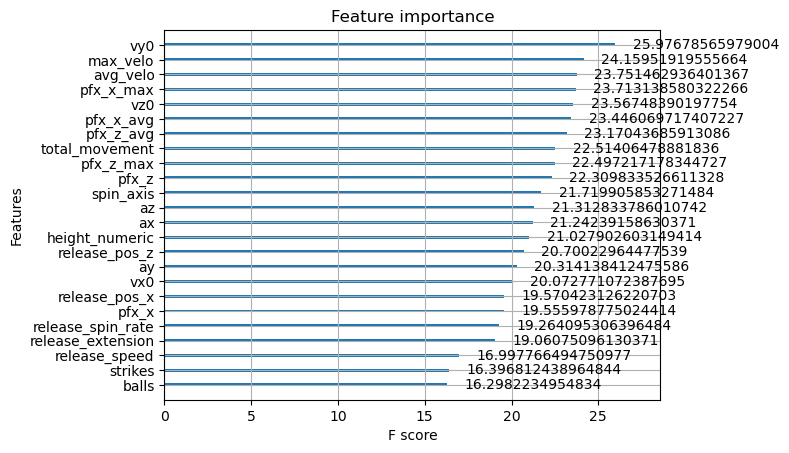

In [ ]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

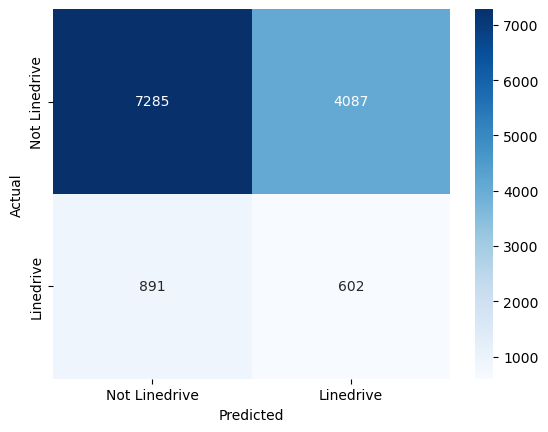

In [ ]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Linedrive', 'Linedrive'], yticklabels=['Not Linedrive', 'Linedrive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [ ]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'pfx_x_avg', 'pfx_z_avg', 'avg_velo', 'pfx_x_max', 'pfx_z_max',
       'max_velo', 'total_movement', 'height_numeric'],
      dtype='object')

In [ ]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [ ]:
y_pred = final_model.predict(predictions)

In [ ]:
testing_identifiers['xld'] = y_pred

ValueError: Length of values (452522) does not match length of index (64322)

In [ ]:
testing_identifiers.head()

pitch_id_raw       xld
0  663364_455139_617228_4_75_10  0.389227
1  663364_455139_617228_3_75_10  0.188634
2  663364_455139_617228_2_75_10  0.674035
3  663364_455139_617228_1_75_10  0.544043
5  663364_593428_605347_4_72_10  0.173958

In [ ]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/ld_2022&3_xld.csv")